# Генерація дерев

- Умови діріхлет із нулем на всіх границях
    - Прикладове дерево, котре генерувалося 8 годин
    - Такі самі дерева, в геометрії 1 на 1 і dx змінюємо від 0 до 1 із якимись кроком
    - Такі самі дерева, в геометрії 4 на 4 і dx змінюємо від 0 до 4 із якимись кроком
    - Такі самі дерева, в геометрії 4 на 20 і dx змінюємо від 0 до 4 із якимисьм кроком
    - Кругла геометрія із діаметром 2.
    - Кругла геометрія із діаметром 5.
 - Умови діріхлета, але з вільними умовами на границі
 - Умови лапласа
 - Для різних значеннь тета
 - Для різних значеннь порогу біфуркації
 - І все те саме тільки для статистичної біфуркації.

 Сумарно виходить десь біля 100 різних симуляцій..

 Візьмемо параметри із 8годинної моделі, оскільки я їх обговорював із Петром:

 - мінімальна відстань біфуркації - 0.01. Але це значення було все ж за великим, адже не гістограмі було видно, що в якийсь момент воно вперлося в цю межу. тому візьмемо 0.005.
 - крок симуляції теж візьмемо 0.005
 - мінімальну відстань росту так само 0.005

 тепер, що до інших чисельних параметрів:
 - квадратура може нехай буде 4и. 
 - додамо все ж одну адптацію сітки.

 Чисельні параметри сітки:
 - довжина ігнорування згладження - 0.02
 - кут згладження - 0.2


## Функції

### Симуляція і візуалізація

In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def plot(fig, ax, model, figsize = [40, 40]):

    ax.set_aspect('equal')

    plt.rcParams['figure.figsize'] = figsize
    
    ax.cla()

    xmin = 0
    xmax = 0
    ymin = 0
    ymax = 0

    for river_pr in model.rivers:
        x = ([v.x for v in river_pr.data().vertices])
        y = ([v.y for v in river_pr.data().vertices])
        ax.plot(x, y)
        if min(x) < xmin:
            xmin = min(x)
        if max(x) > xmax:
            xmax = max(x)
        if min(y) < ymin:
            ymin = min(y)
        if max(y) > ymax:
            ymax = max(y)

    
    for boundary_pr in model.region:
        x = ([v.x for v in boundary_pr.data().vertices])
        y = ([v.y for v in boundary_pr.data().vertices])
        x.append(boundary_pr.data().vertices[0].x)
        y.append(boundary_pr.data().vertices[0].y)
        if min(x) < xmin:
            xmin = min(x)
        if max(x) > xmax:
            xmax = max(x)
        if min(y) < ymin:
            ymin = min(y)
        if max(y) > ymax:
            ymax = max(y)
        ax.plot(x, y)

    ax.set_xlim(xmin - 0.1, xmax + 0.1)
    ax.set_ylim(ymin - 0.1, ymax + 0.1)
    #plt.xlim(xmin - 0.1, xmax + 0.1)
    #plt.ylim(ymin - 0.1, ymax + 0.1)
    #plt.show()
    display(fig)
    clear_output(wait = True)
    #plt.pause(0.001)

import riversim as rs

def growRiver(m, plot_period = 50):

    solver = rs.Solver(m.solver_params, verbose=False)
    triangle = rs.Triangle(m.mesh_params)
    mesh = rs.TethexMesh()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    dynamic_river_ids = m.rivers.tipBranchesIds()

    for i in range(m.number_of_steps):
        if i % 10 == 0:
            print(i)
        # boundary generation: Combines boundary and river 
        # geometry into one(or several) closed boundary lines
        m.boundary = rs.BoundaryGenerator(\
            m.sources, \
            m.region, \
            m.rivers, \
            m.river_width, \
            m.mesh_params.smoothness_degree, \
            m.mesh_params.ignored_smoothness_length)
    
        # mesh will be refined aroud growing tip points
        tip_points = rs.t_PointList()
        for id in dynamic_river_ids:
            tip_points.append(m.rivers[id].tipPoint())
        triangle.mesh_params.tip_points = tip_points
        mesh = triangle.generate(m.boundary, m.region.holes)
    
        # reset solver values
        # solver.clear() lets try without it
        solver.openMesh(mesh)
    
        for j in range(m.solver_params.adaptive_refinment_steps + 1):
            if j > 0:
                solver.refineGrid()
            solver.setupSystem()
            solver.assembleSystem(m.boundary_conditions)
            solver.solve()
    
        #series parameters evaluation
        id_series_params = rs.t_ids_series_params()
        max_a1 = 0
        for id in dynamic_river_ids:
            tip_point = m.rivers[id].tipPoint()
            tip_angle = m.rivers[id].tipAngle()
            id_series_params[id] = solver.integrate_new(m.integr_params, tip_point, tip_angle)
            if id_series_params[id][0] > max_a1:
                max_a1 = id_series_params[id][0]
    
        for id_series_param in id_series_params:
            id = id_series_param.key()
            series_param = id_series_param.data()
            if m.qGrowth(series_param):
                l = m.rivers[id].lenght()
                if m.qBifurcate(series_param, l):
                    tip_point = m.rivers[id].tipPoint()
                    tip_angle = m.rivers[id].tipAngle()
                    br_left = rs.Branch(tip_point, tip_angle + m.bifurcation_angle)
                    br_left.addPoint(rs.Polar(m.ds, 0), m.river_boundary_id)
                    br_right = rs.Branch(tip_point, tip_angle - m.bifurcation_angle)
                    br_right.addPoint(rs.Polar(m.ds, 0), m.river_boundary_id)
                    ids = m.rivers.addSubBranches(id, br_left, br_right)

                    # add new branches
                    dynamic_river_ids.append(ids.left)
                    dynamic_river_ids.append(ids.right)
                    
                    # and remove parent from growth evaluation
                    for f in range(len(dynamic_river_ids)):
                        if dynamic_river_ids[f] == id:
                            del dynamic_river_ids[f]
                            break
                else: 
                    m.rivers[id].addPoint(\
                        m.nextPoint(series_param, l, max_a1),\
                        m.river_boundary_id)
            else:
                # remove river from growth evaluation
                for f in range(len(dynamic_river_ids)):
                    if dynamic_river_ids[f] == id:
                        del dynamic_river_ids[f]
                        break
        if i % plot_period == 0:
            plot(fig, ax, m)

        # nothing to grow
        if not dynamic_river_ids:
            break

## Умови діріхлет із нулем на всіх границях

### Дерева в геометрії 1 на 1 і dx змінюємо від 0 до 1 із достатньо малим кроком

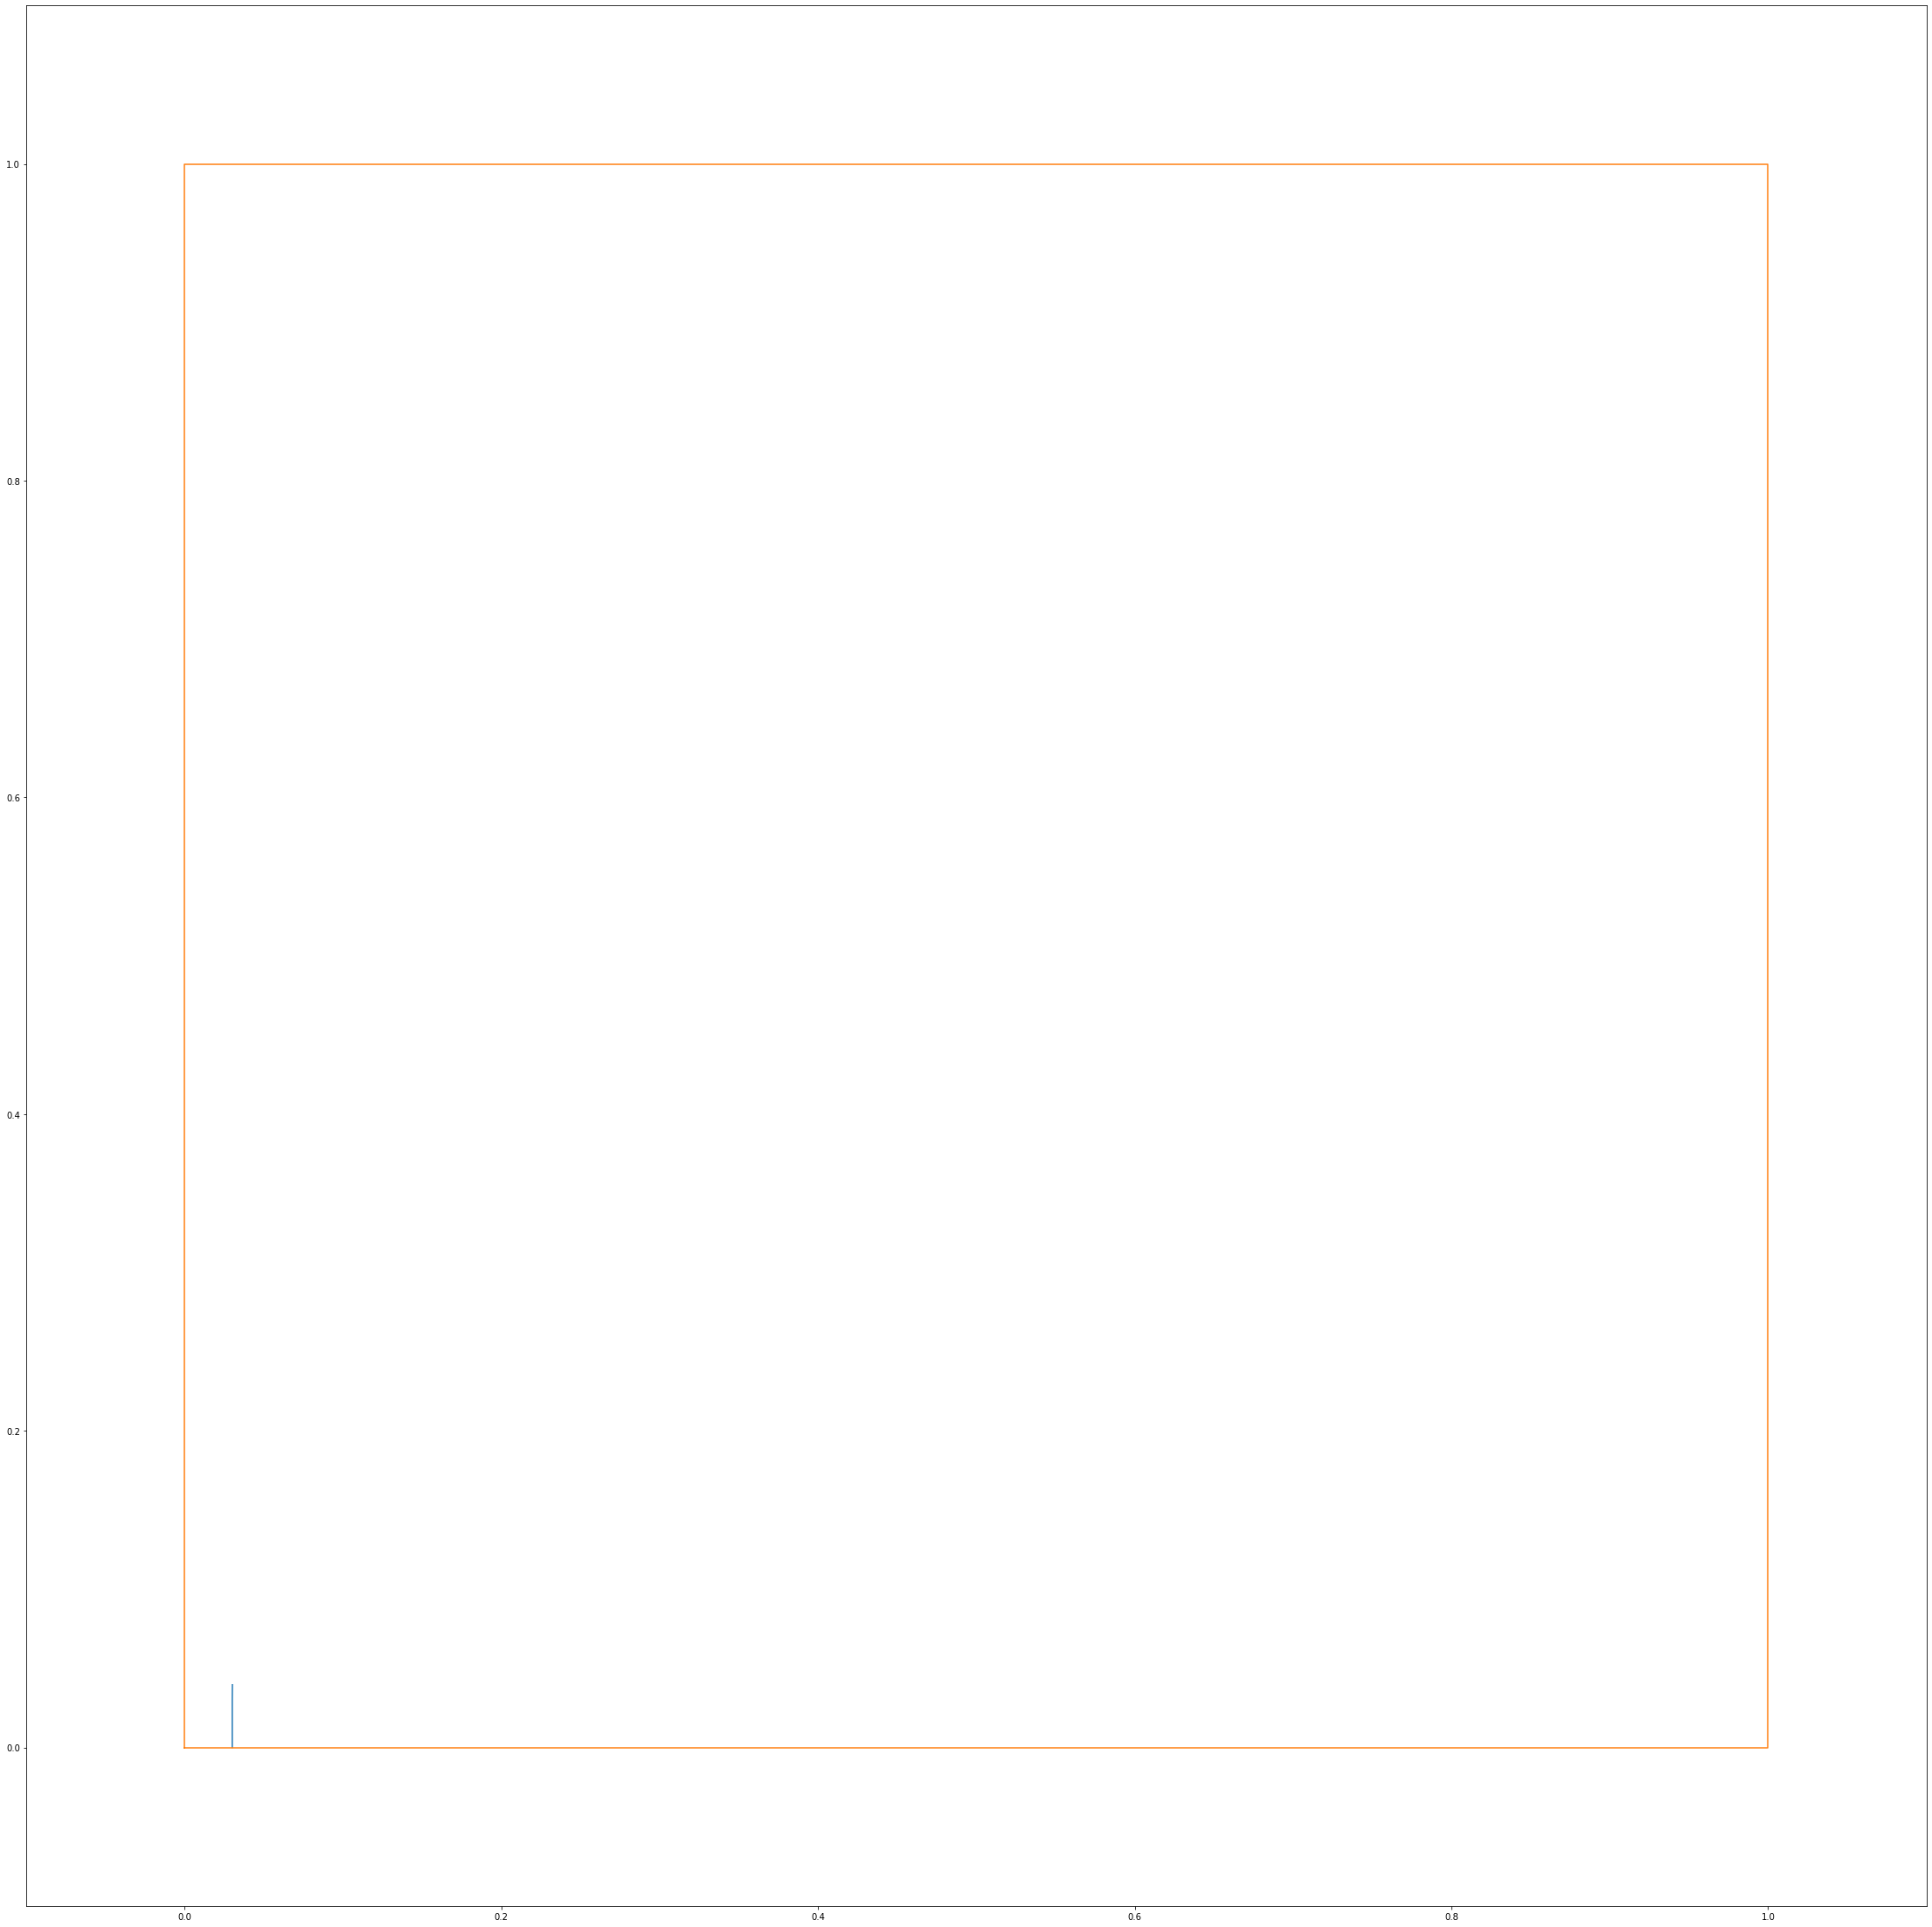

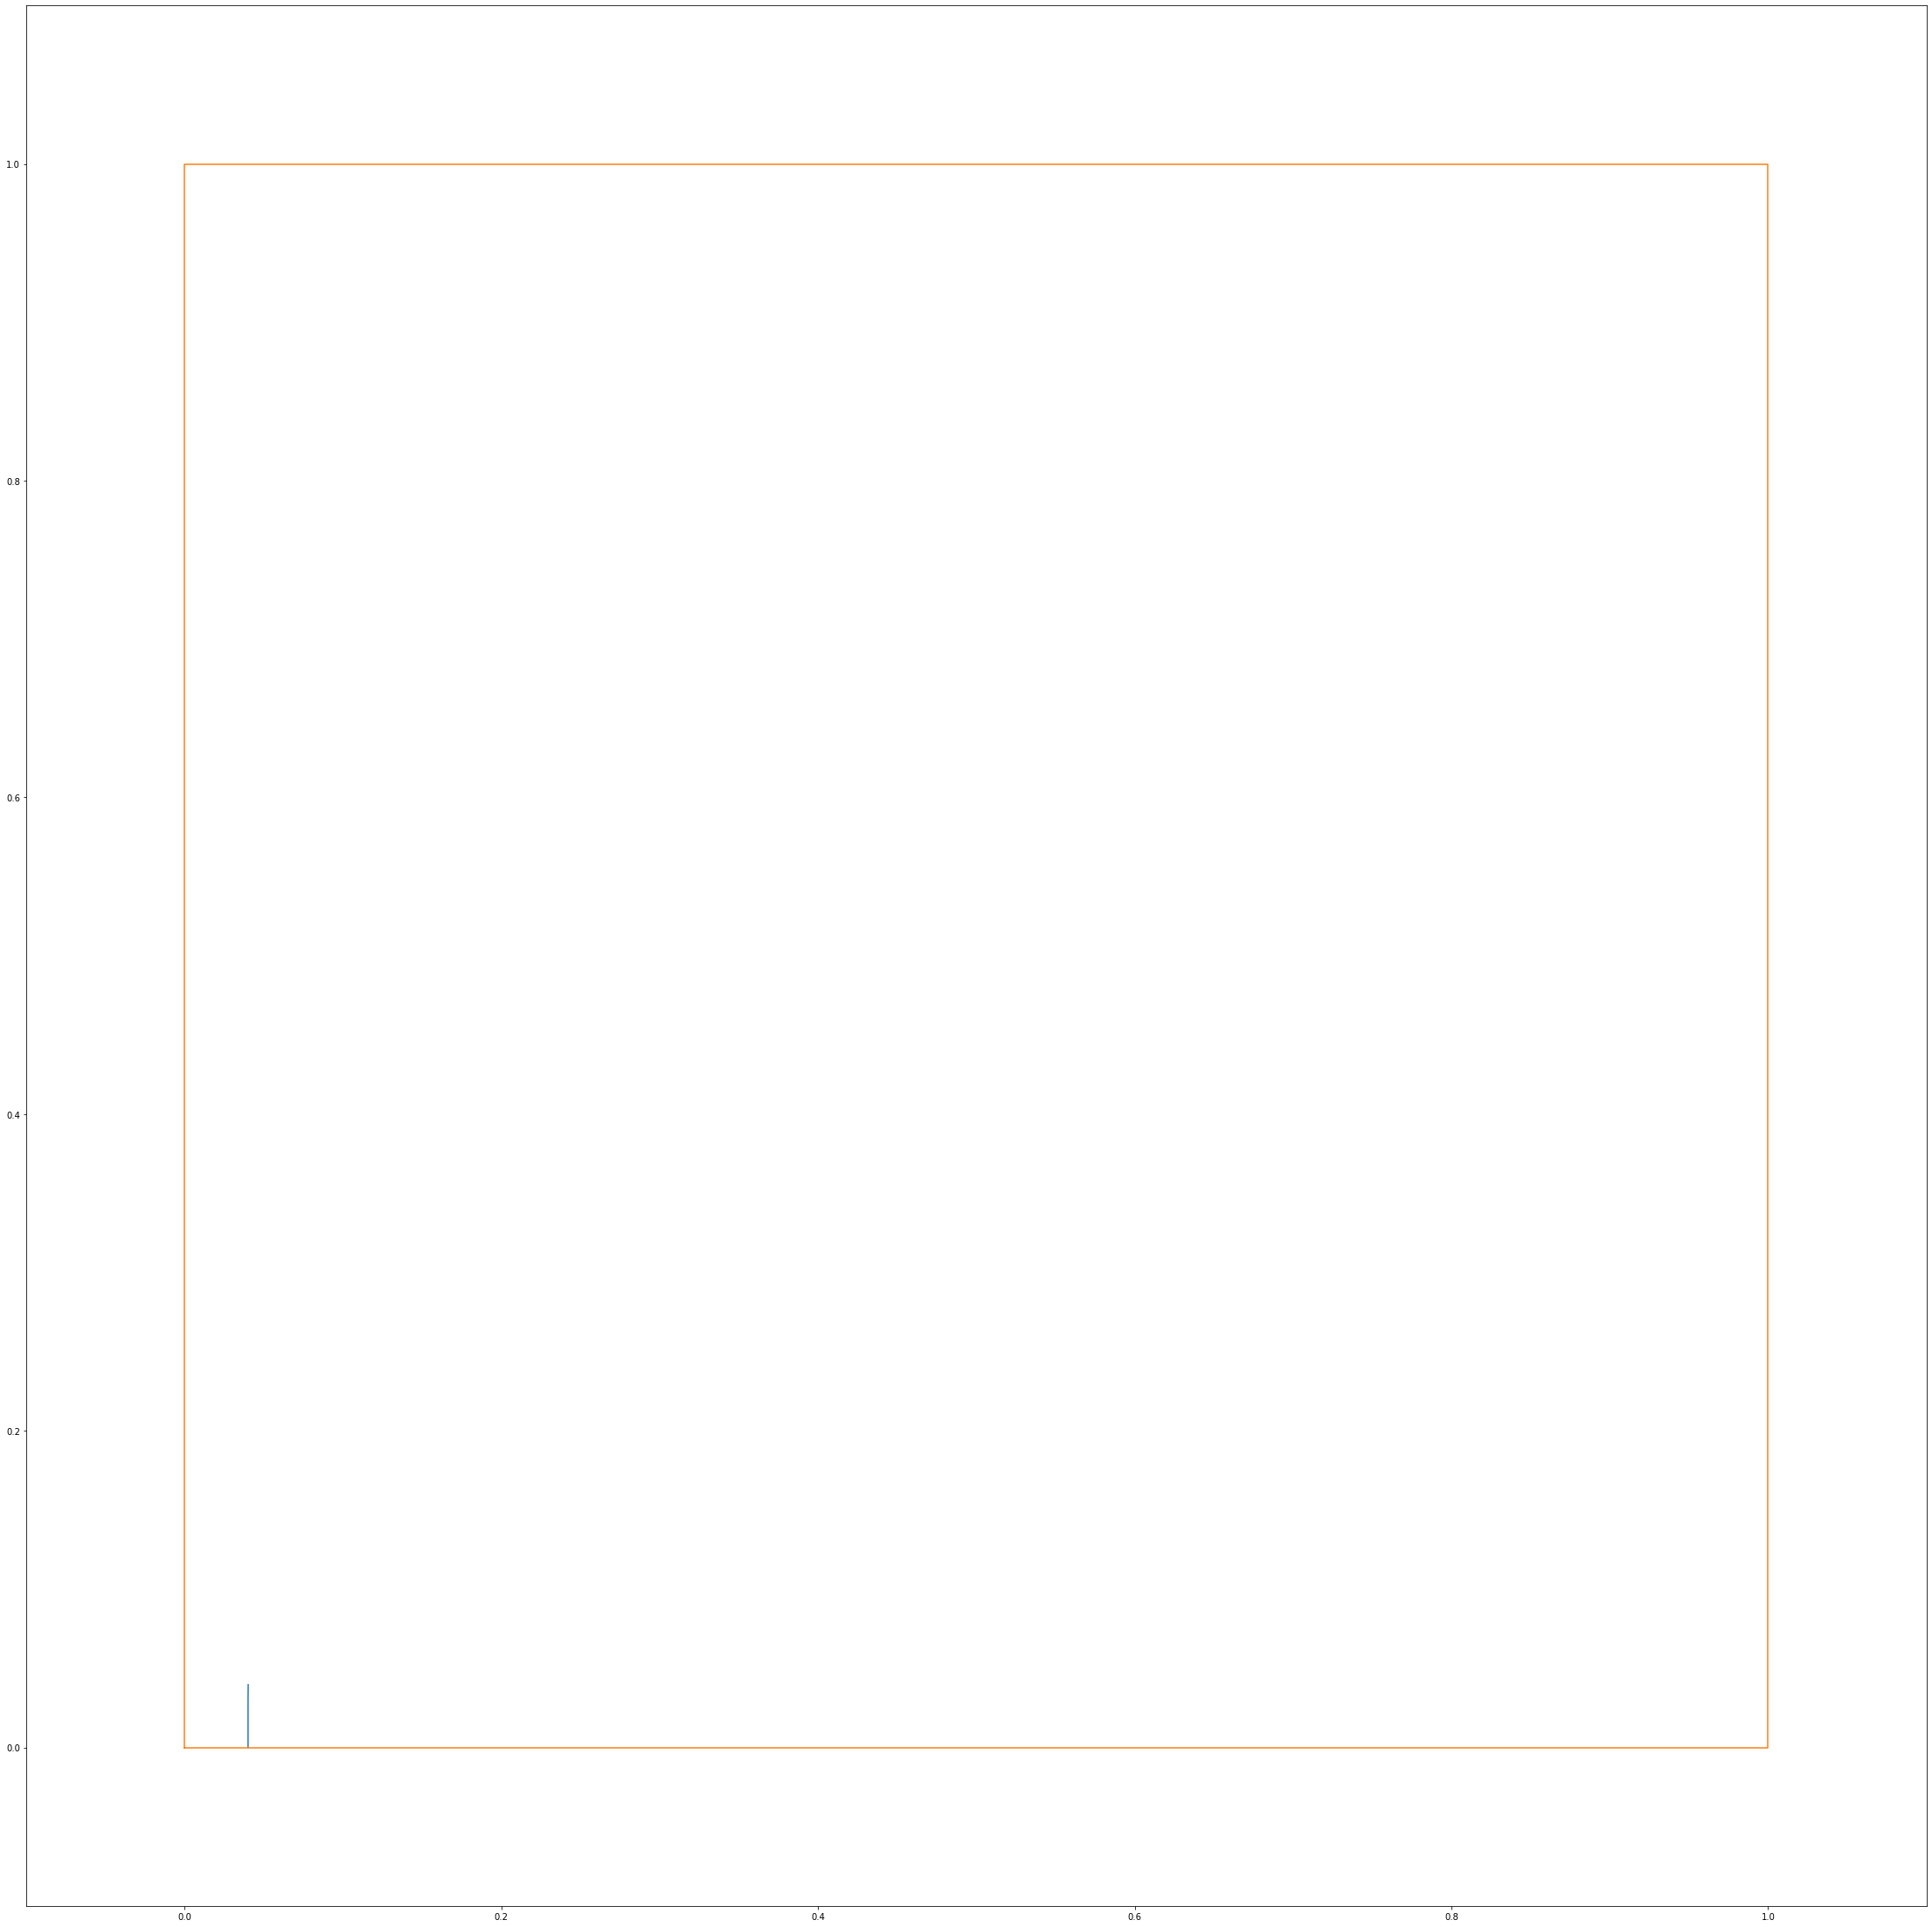

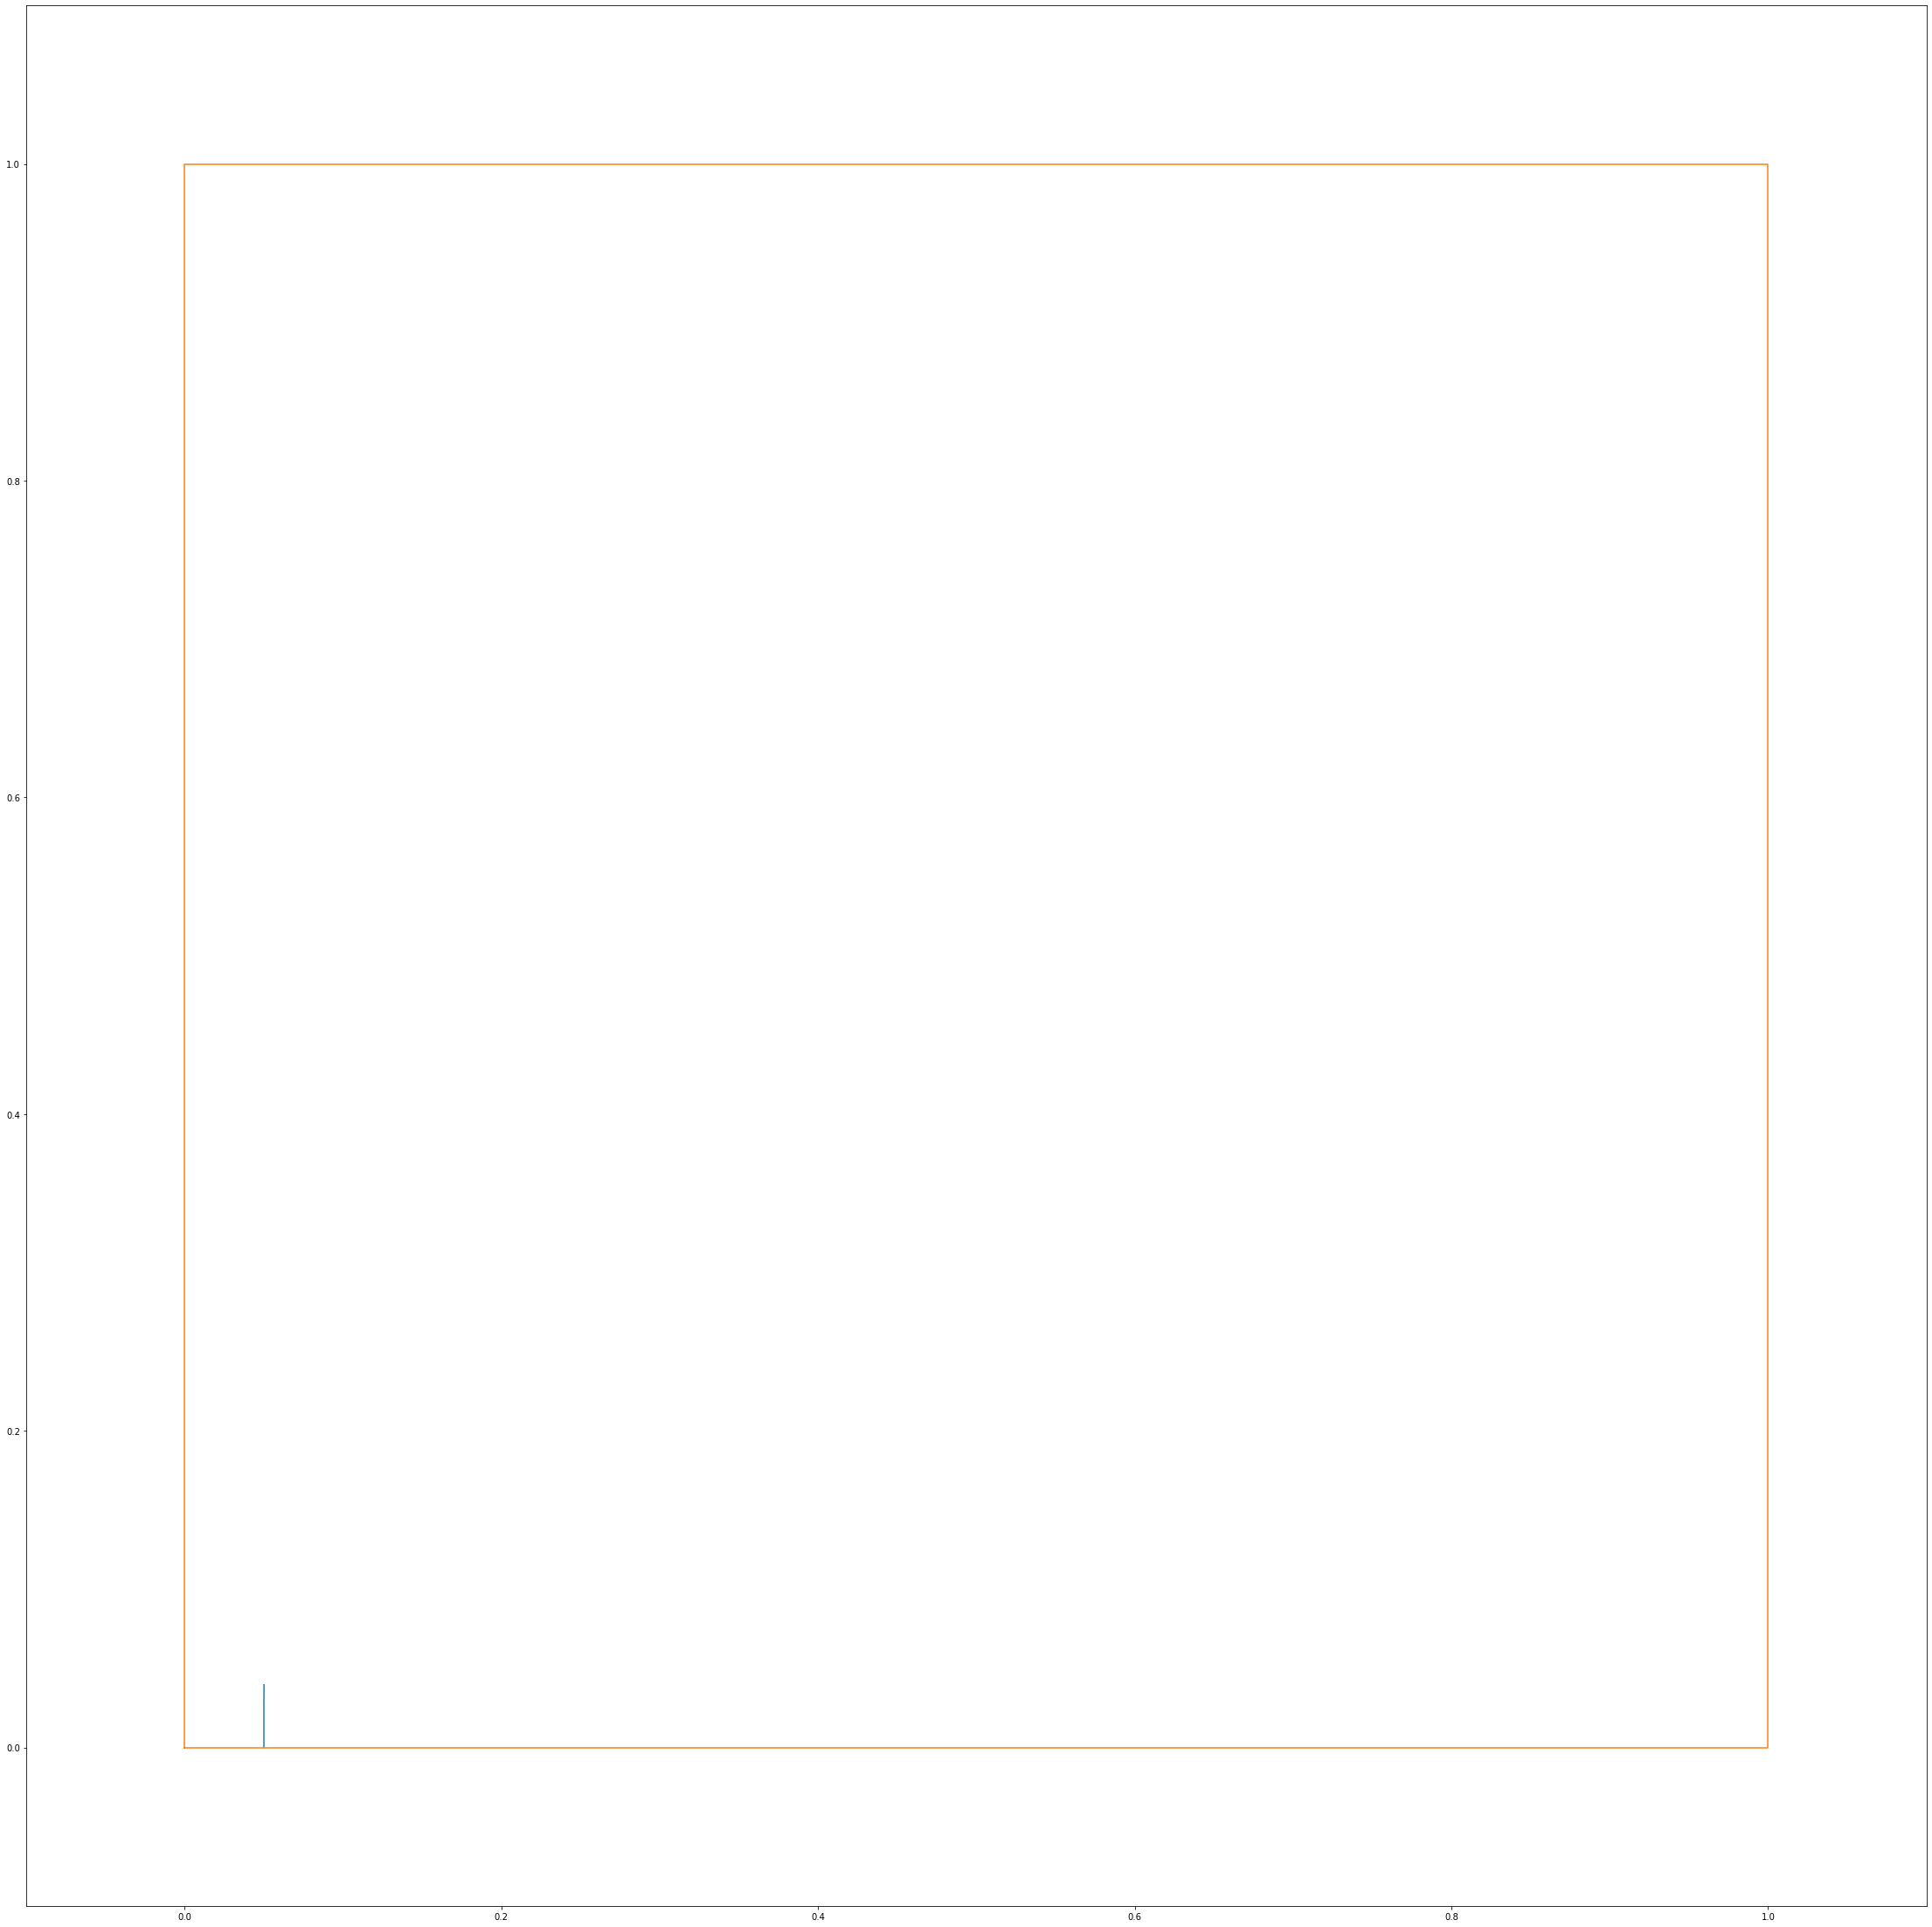

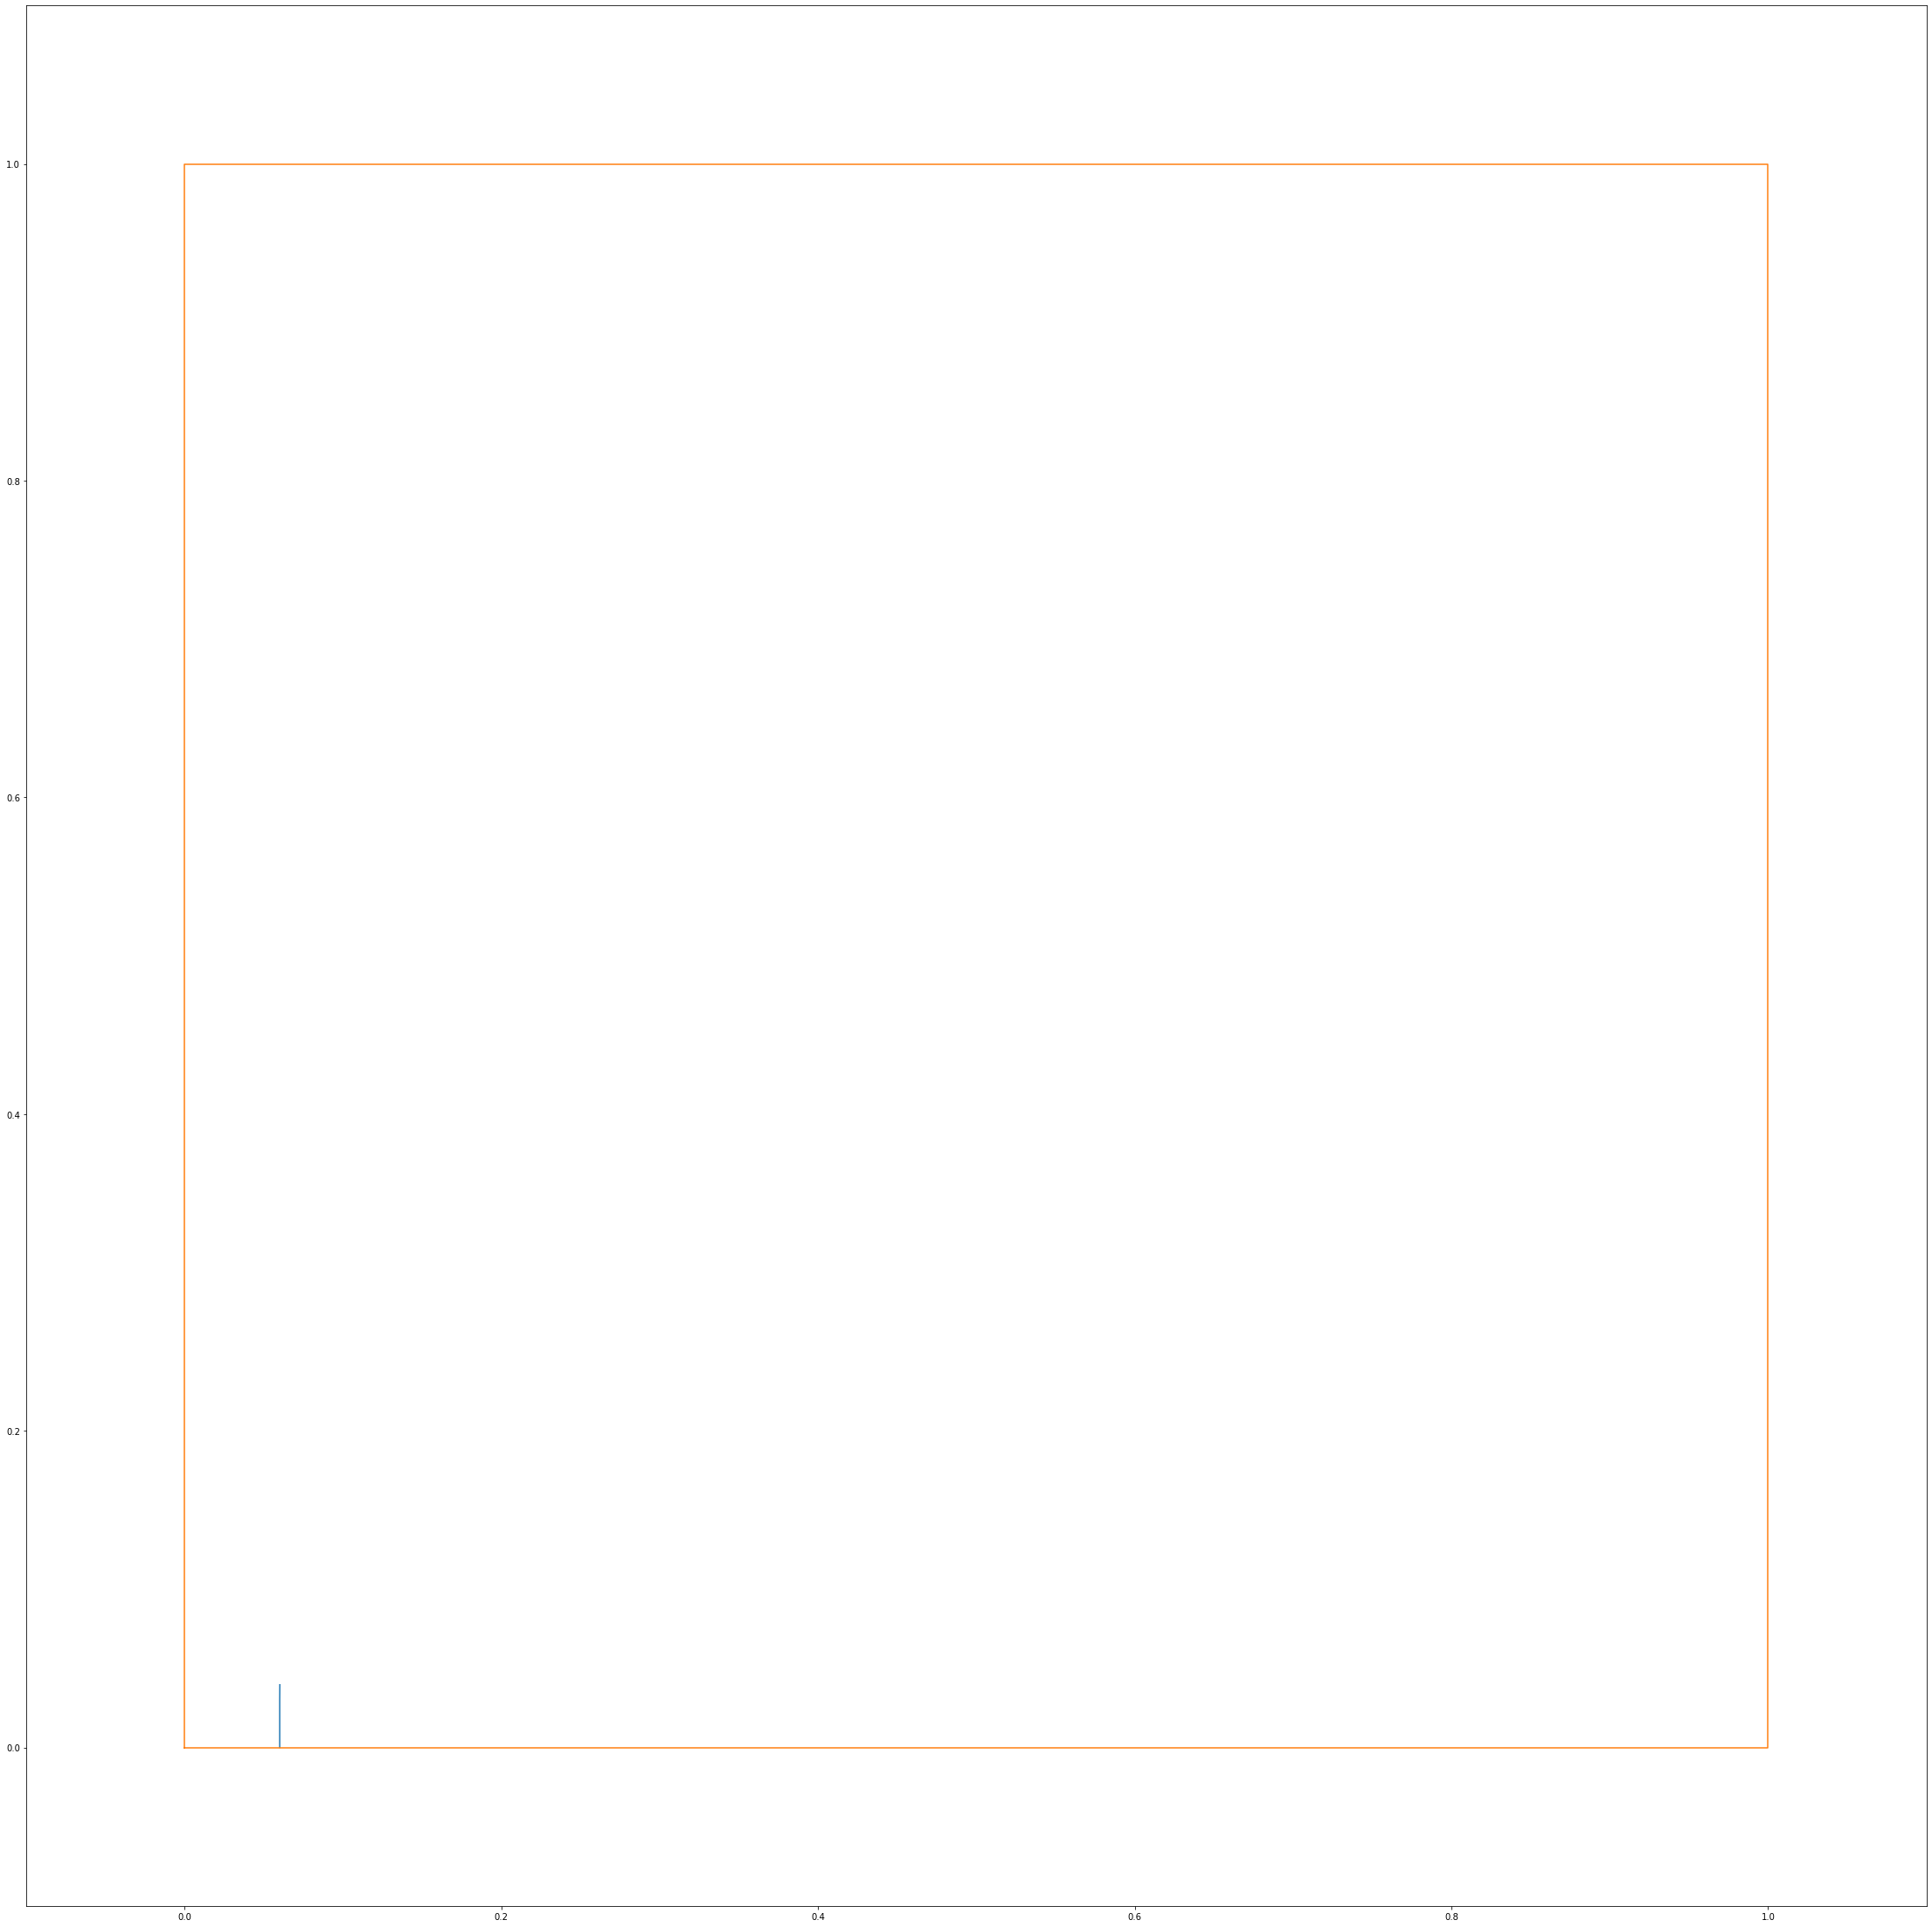

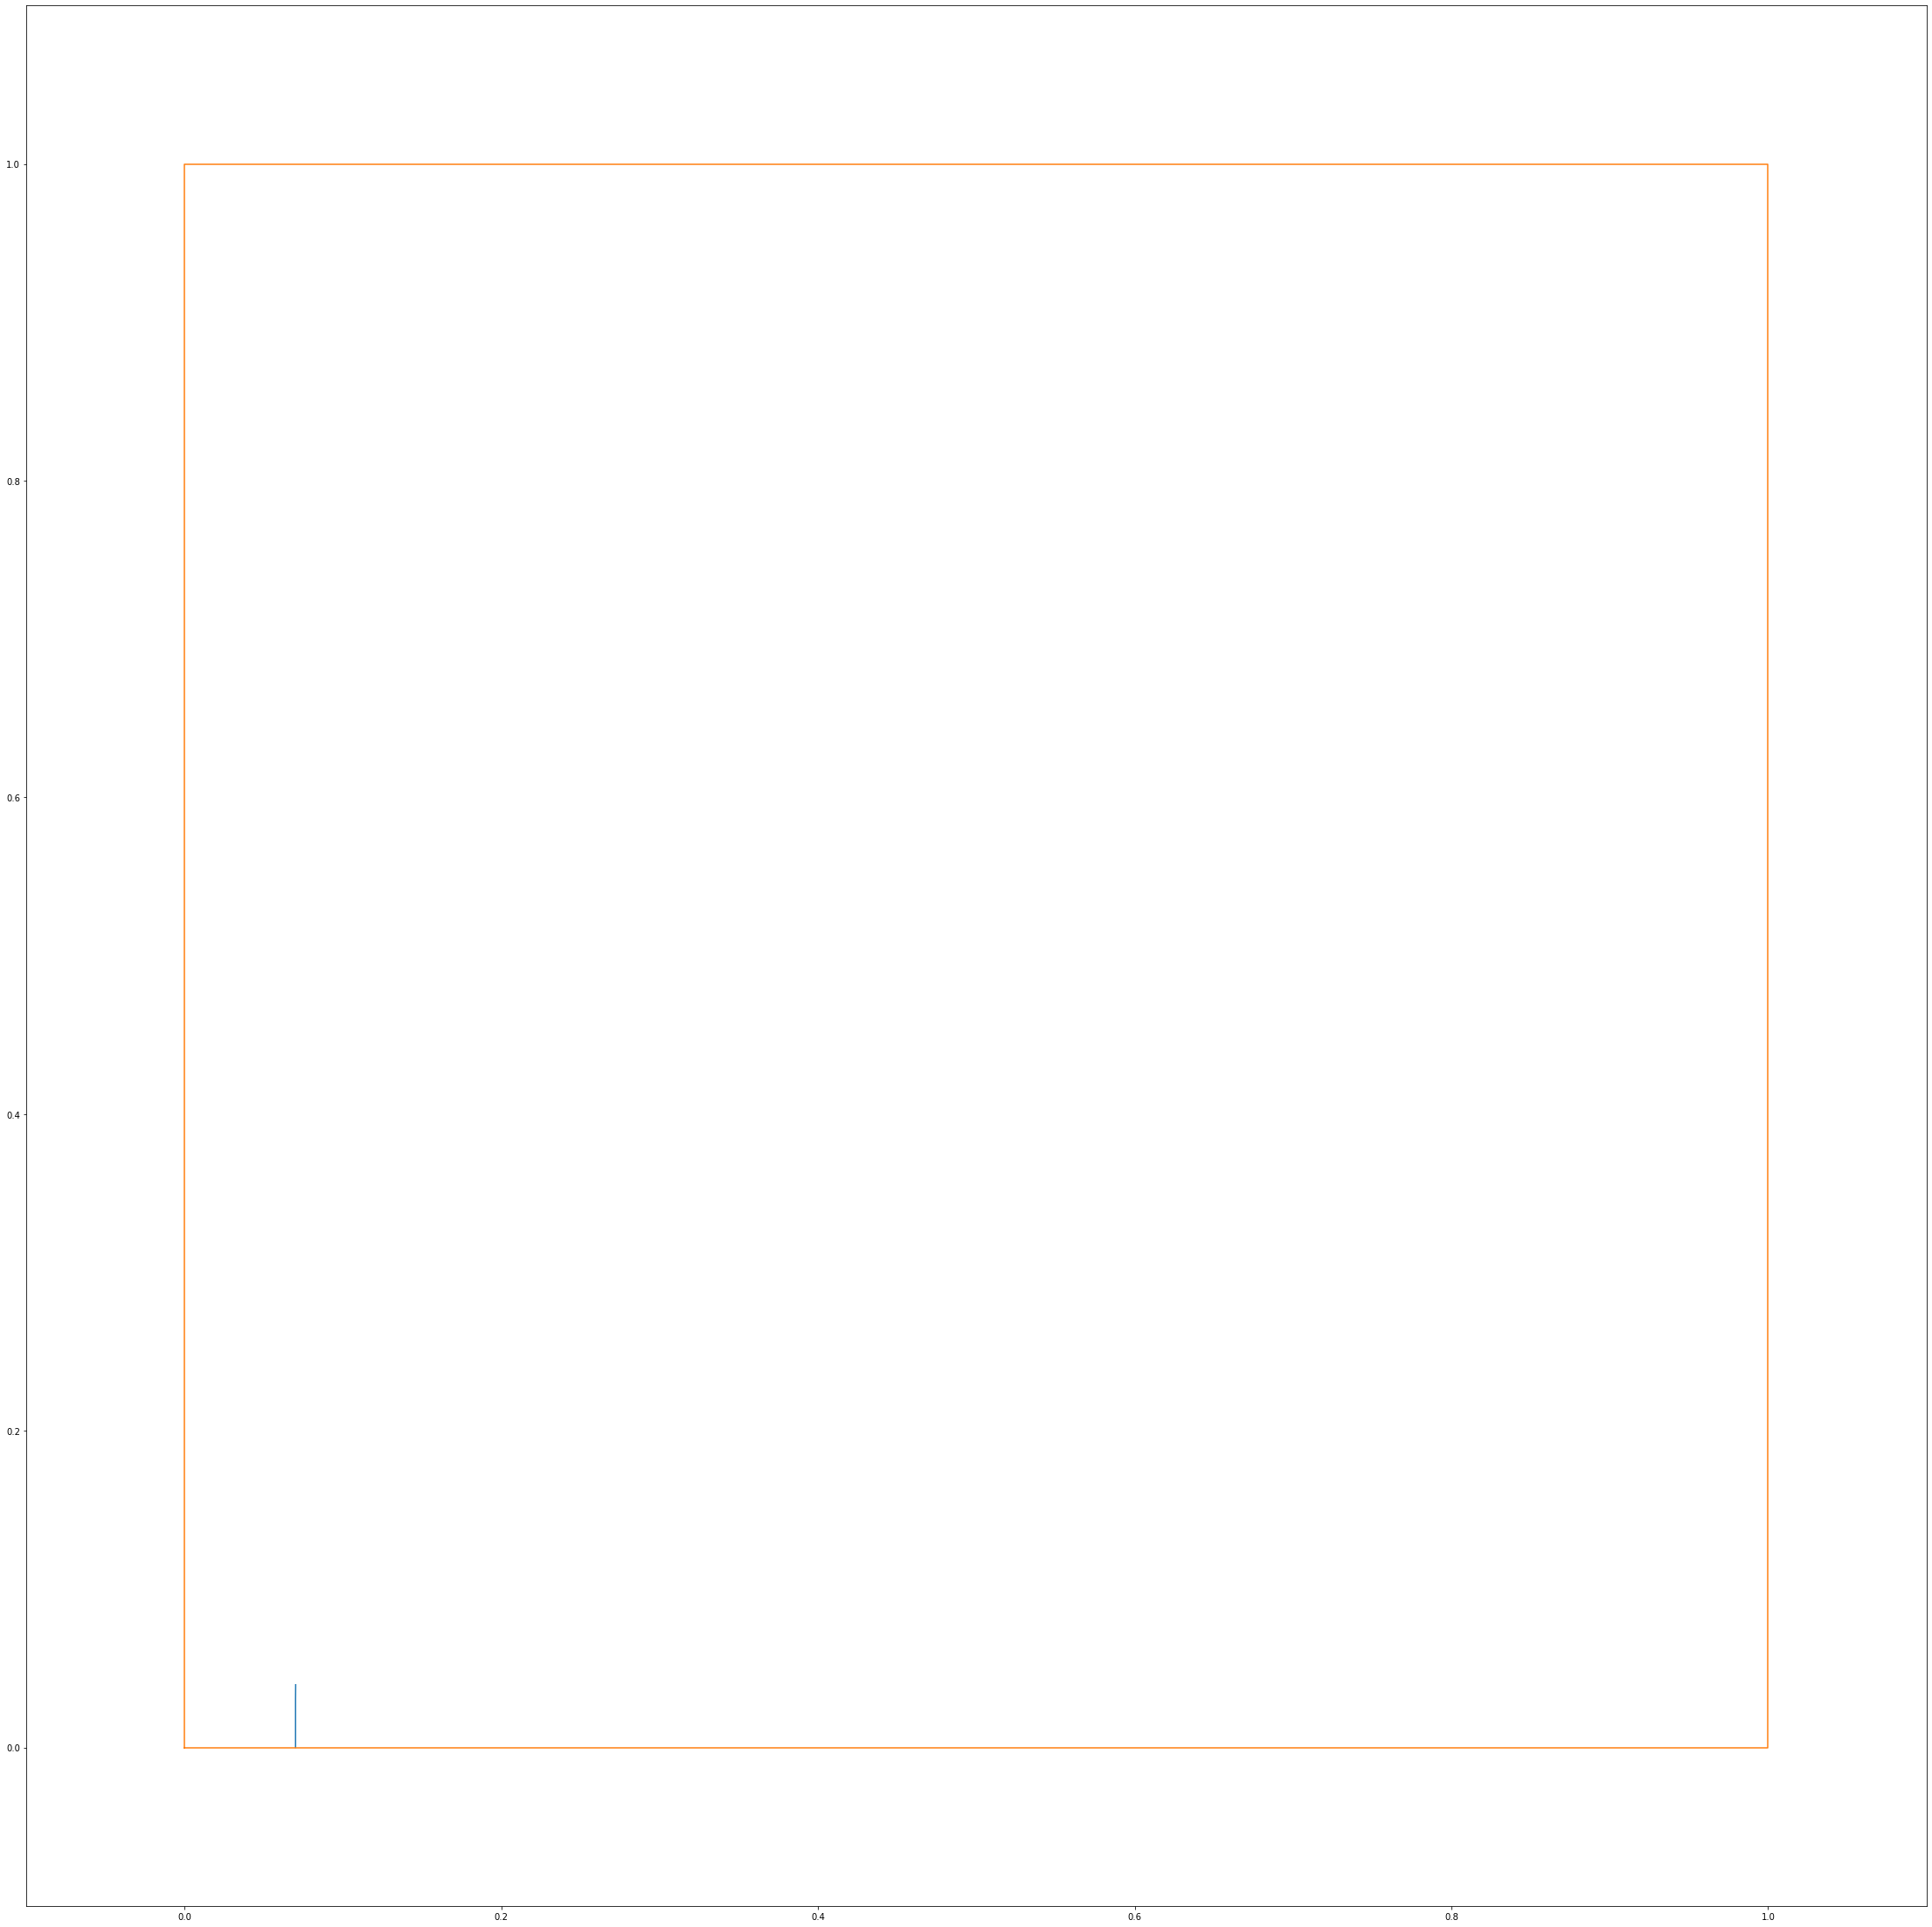

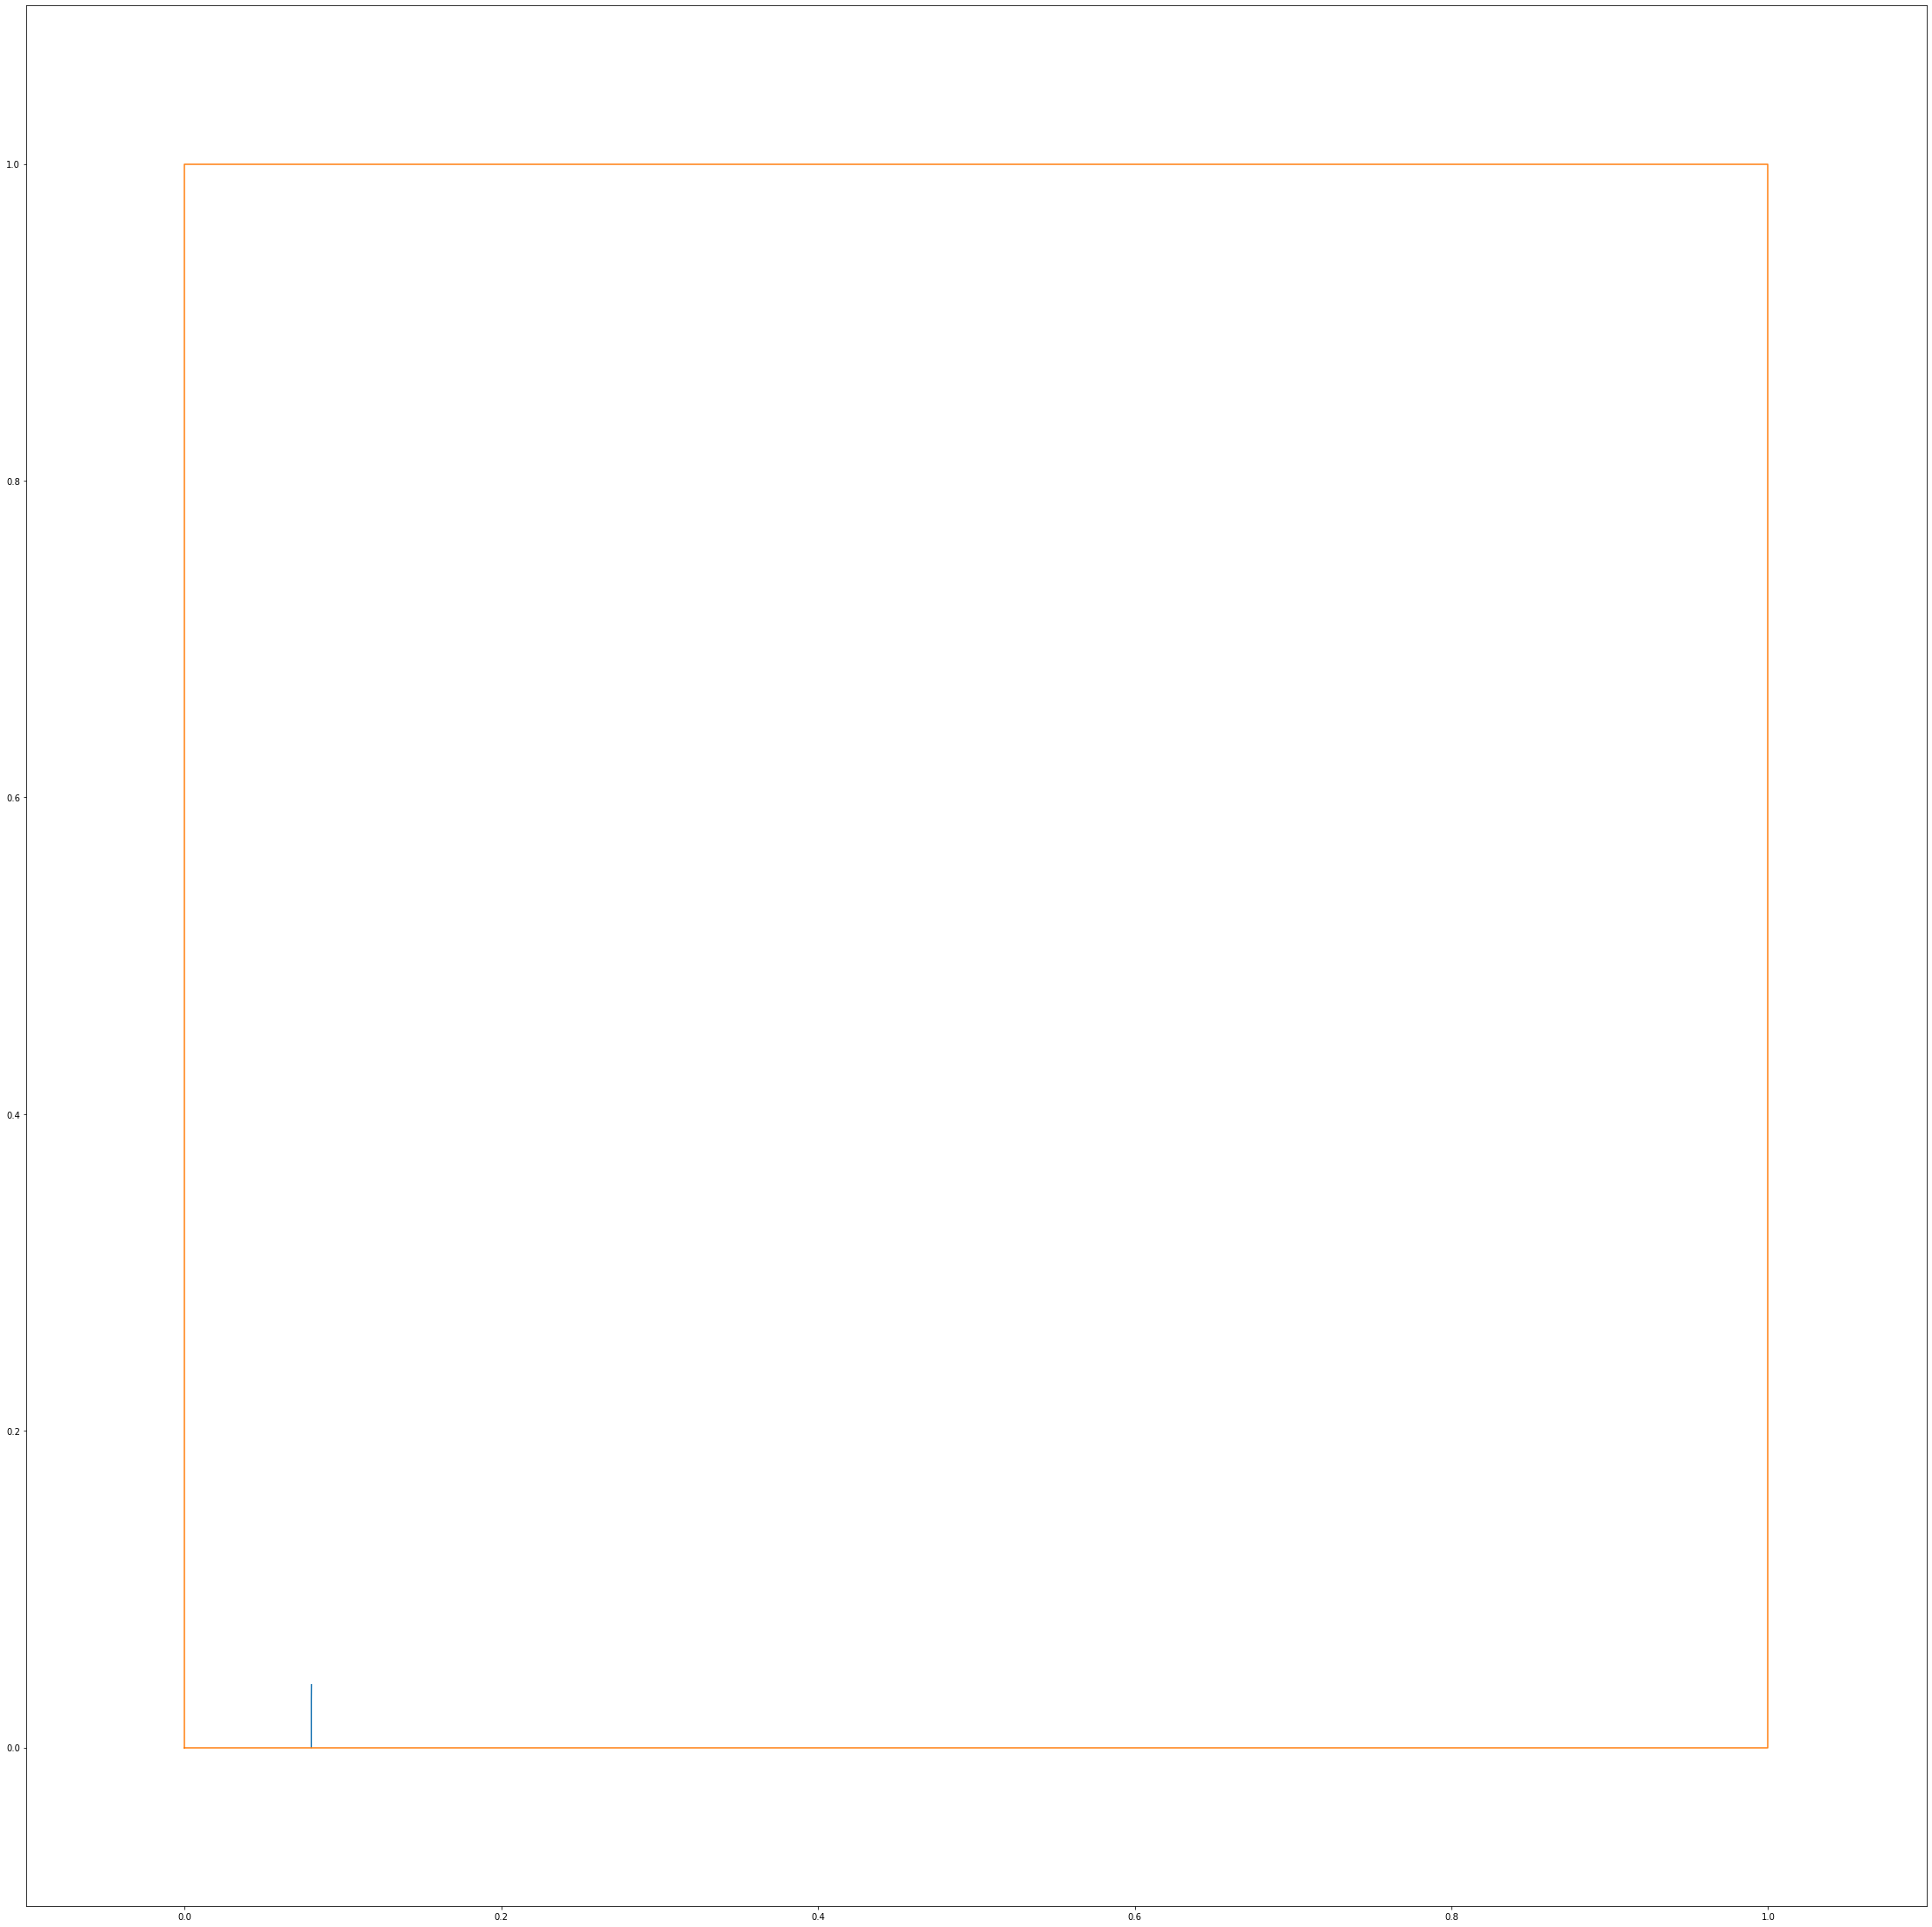

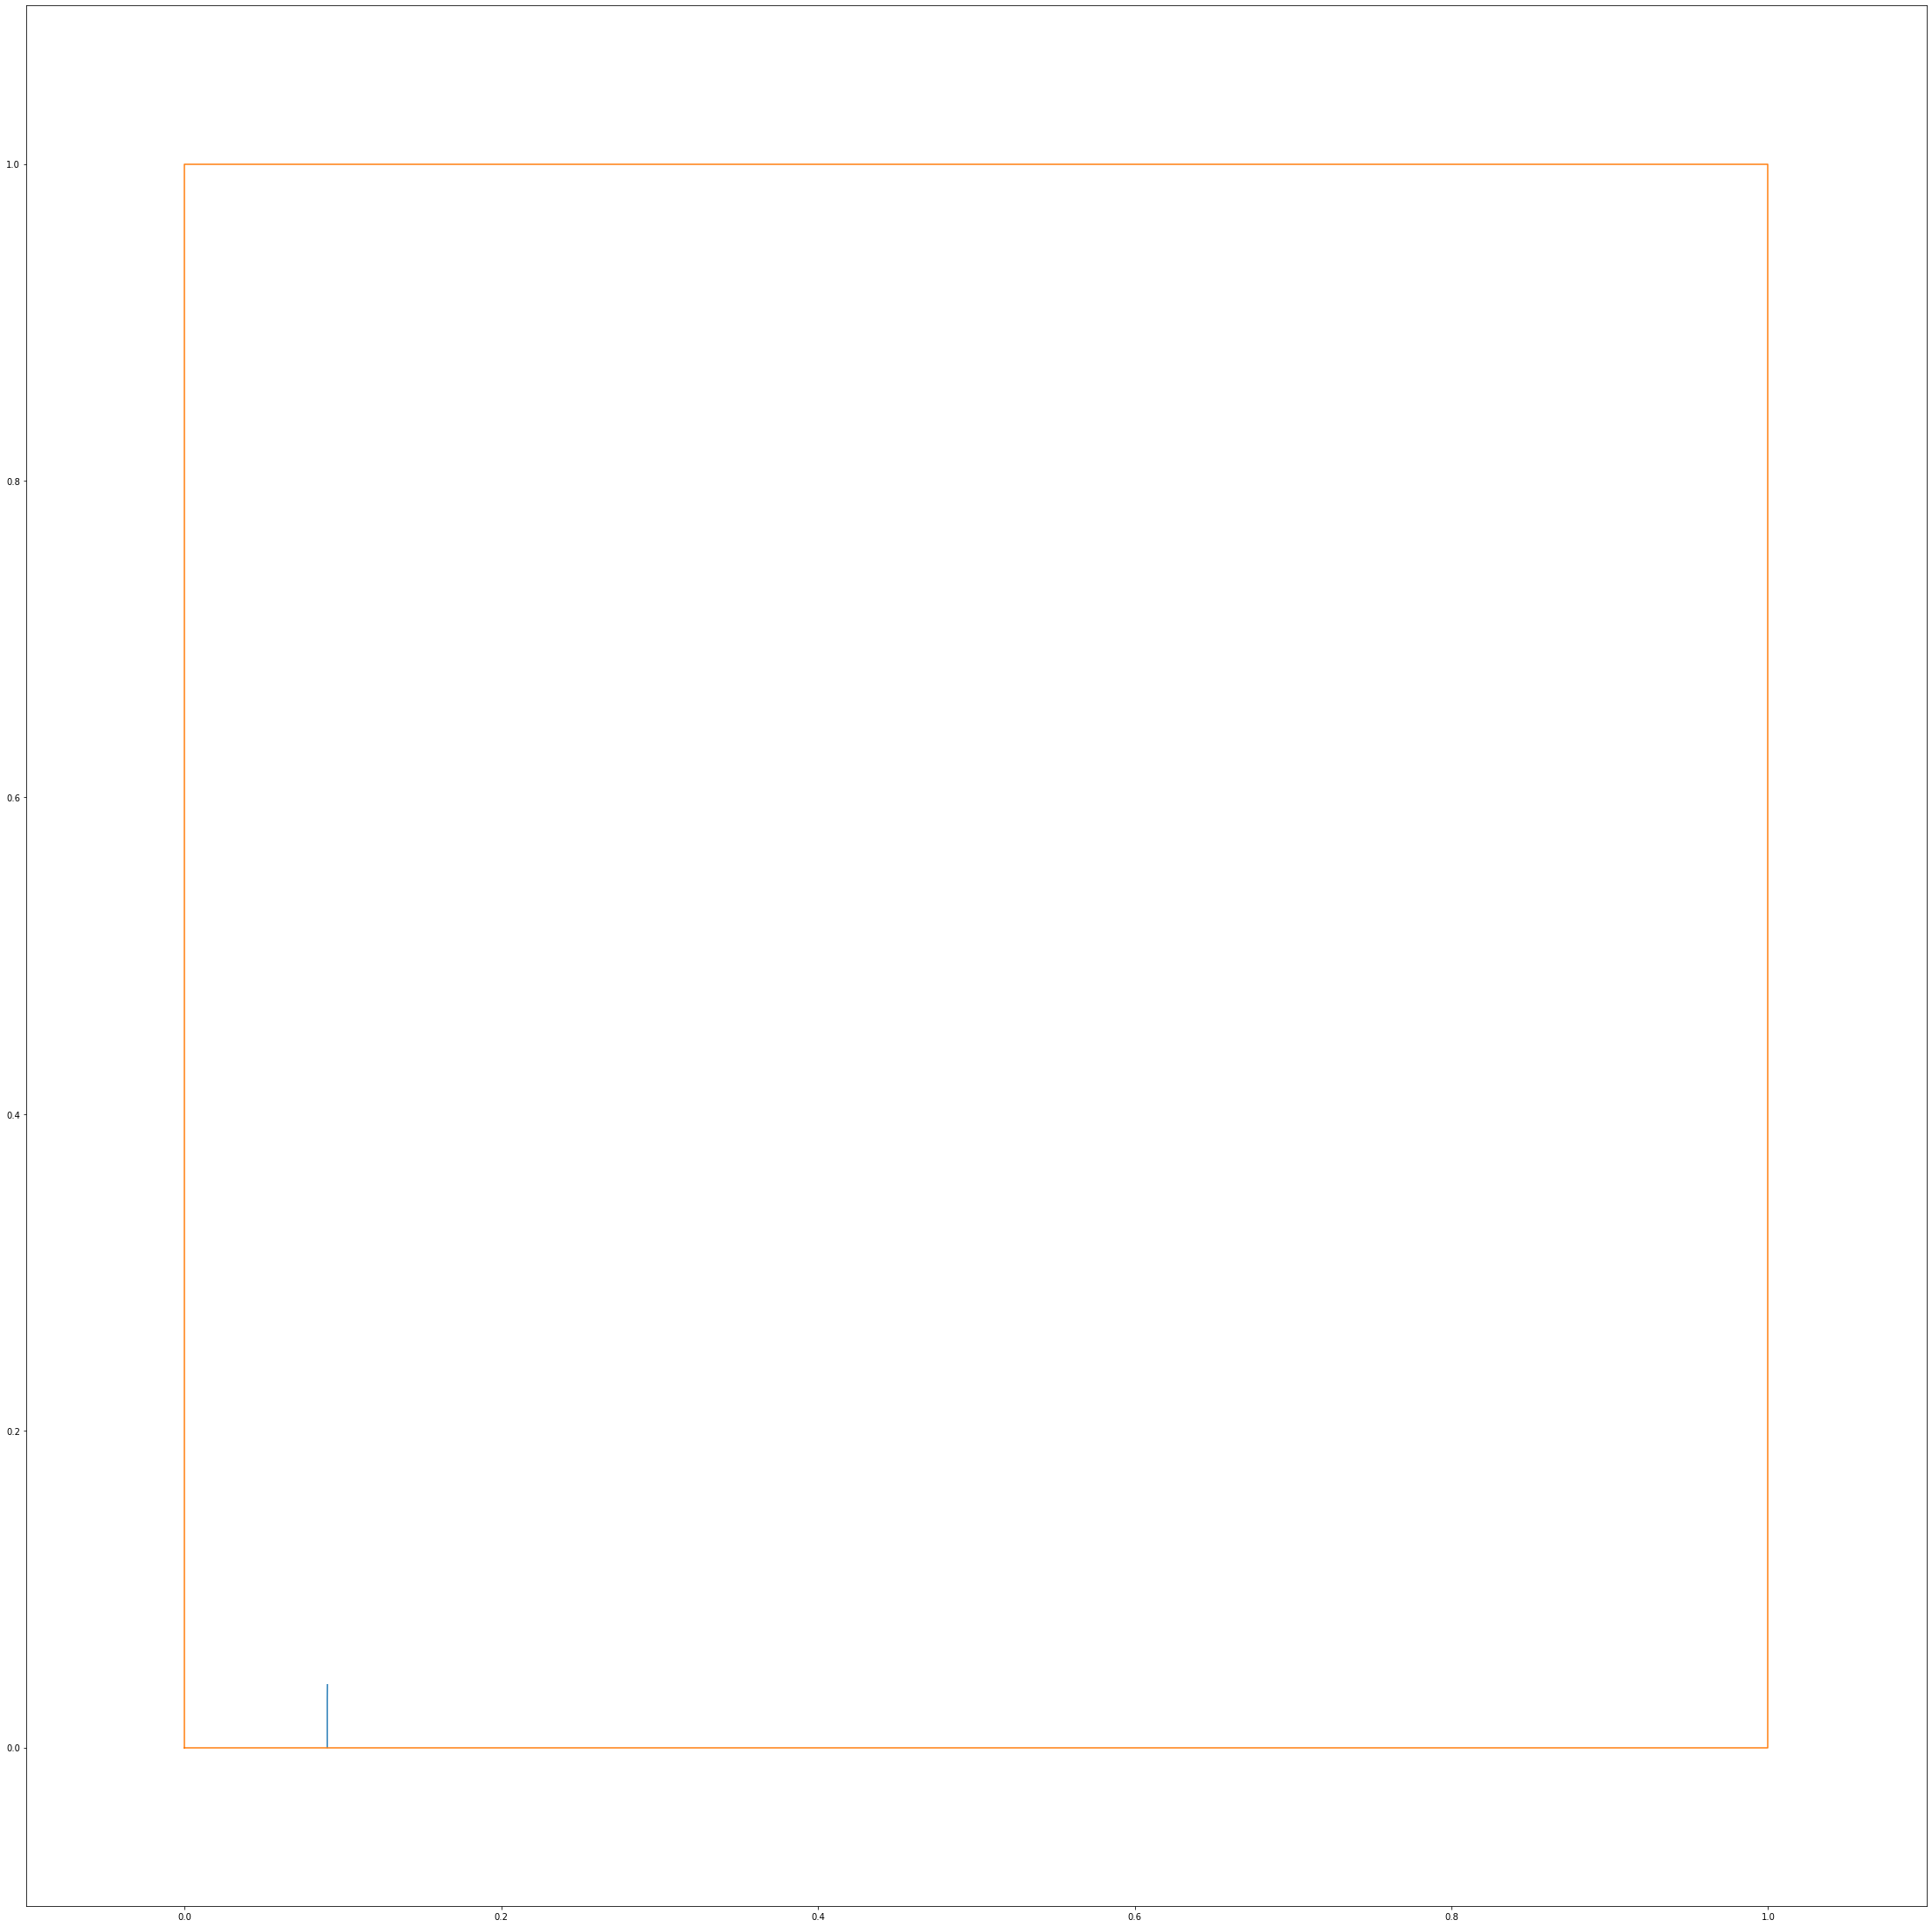

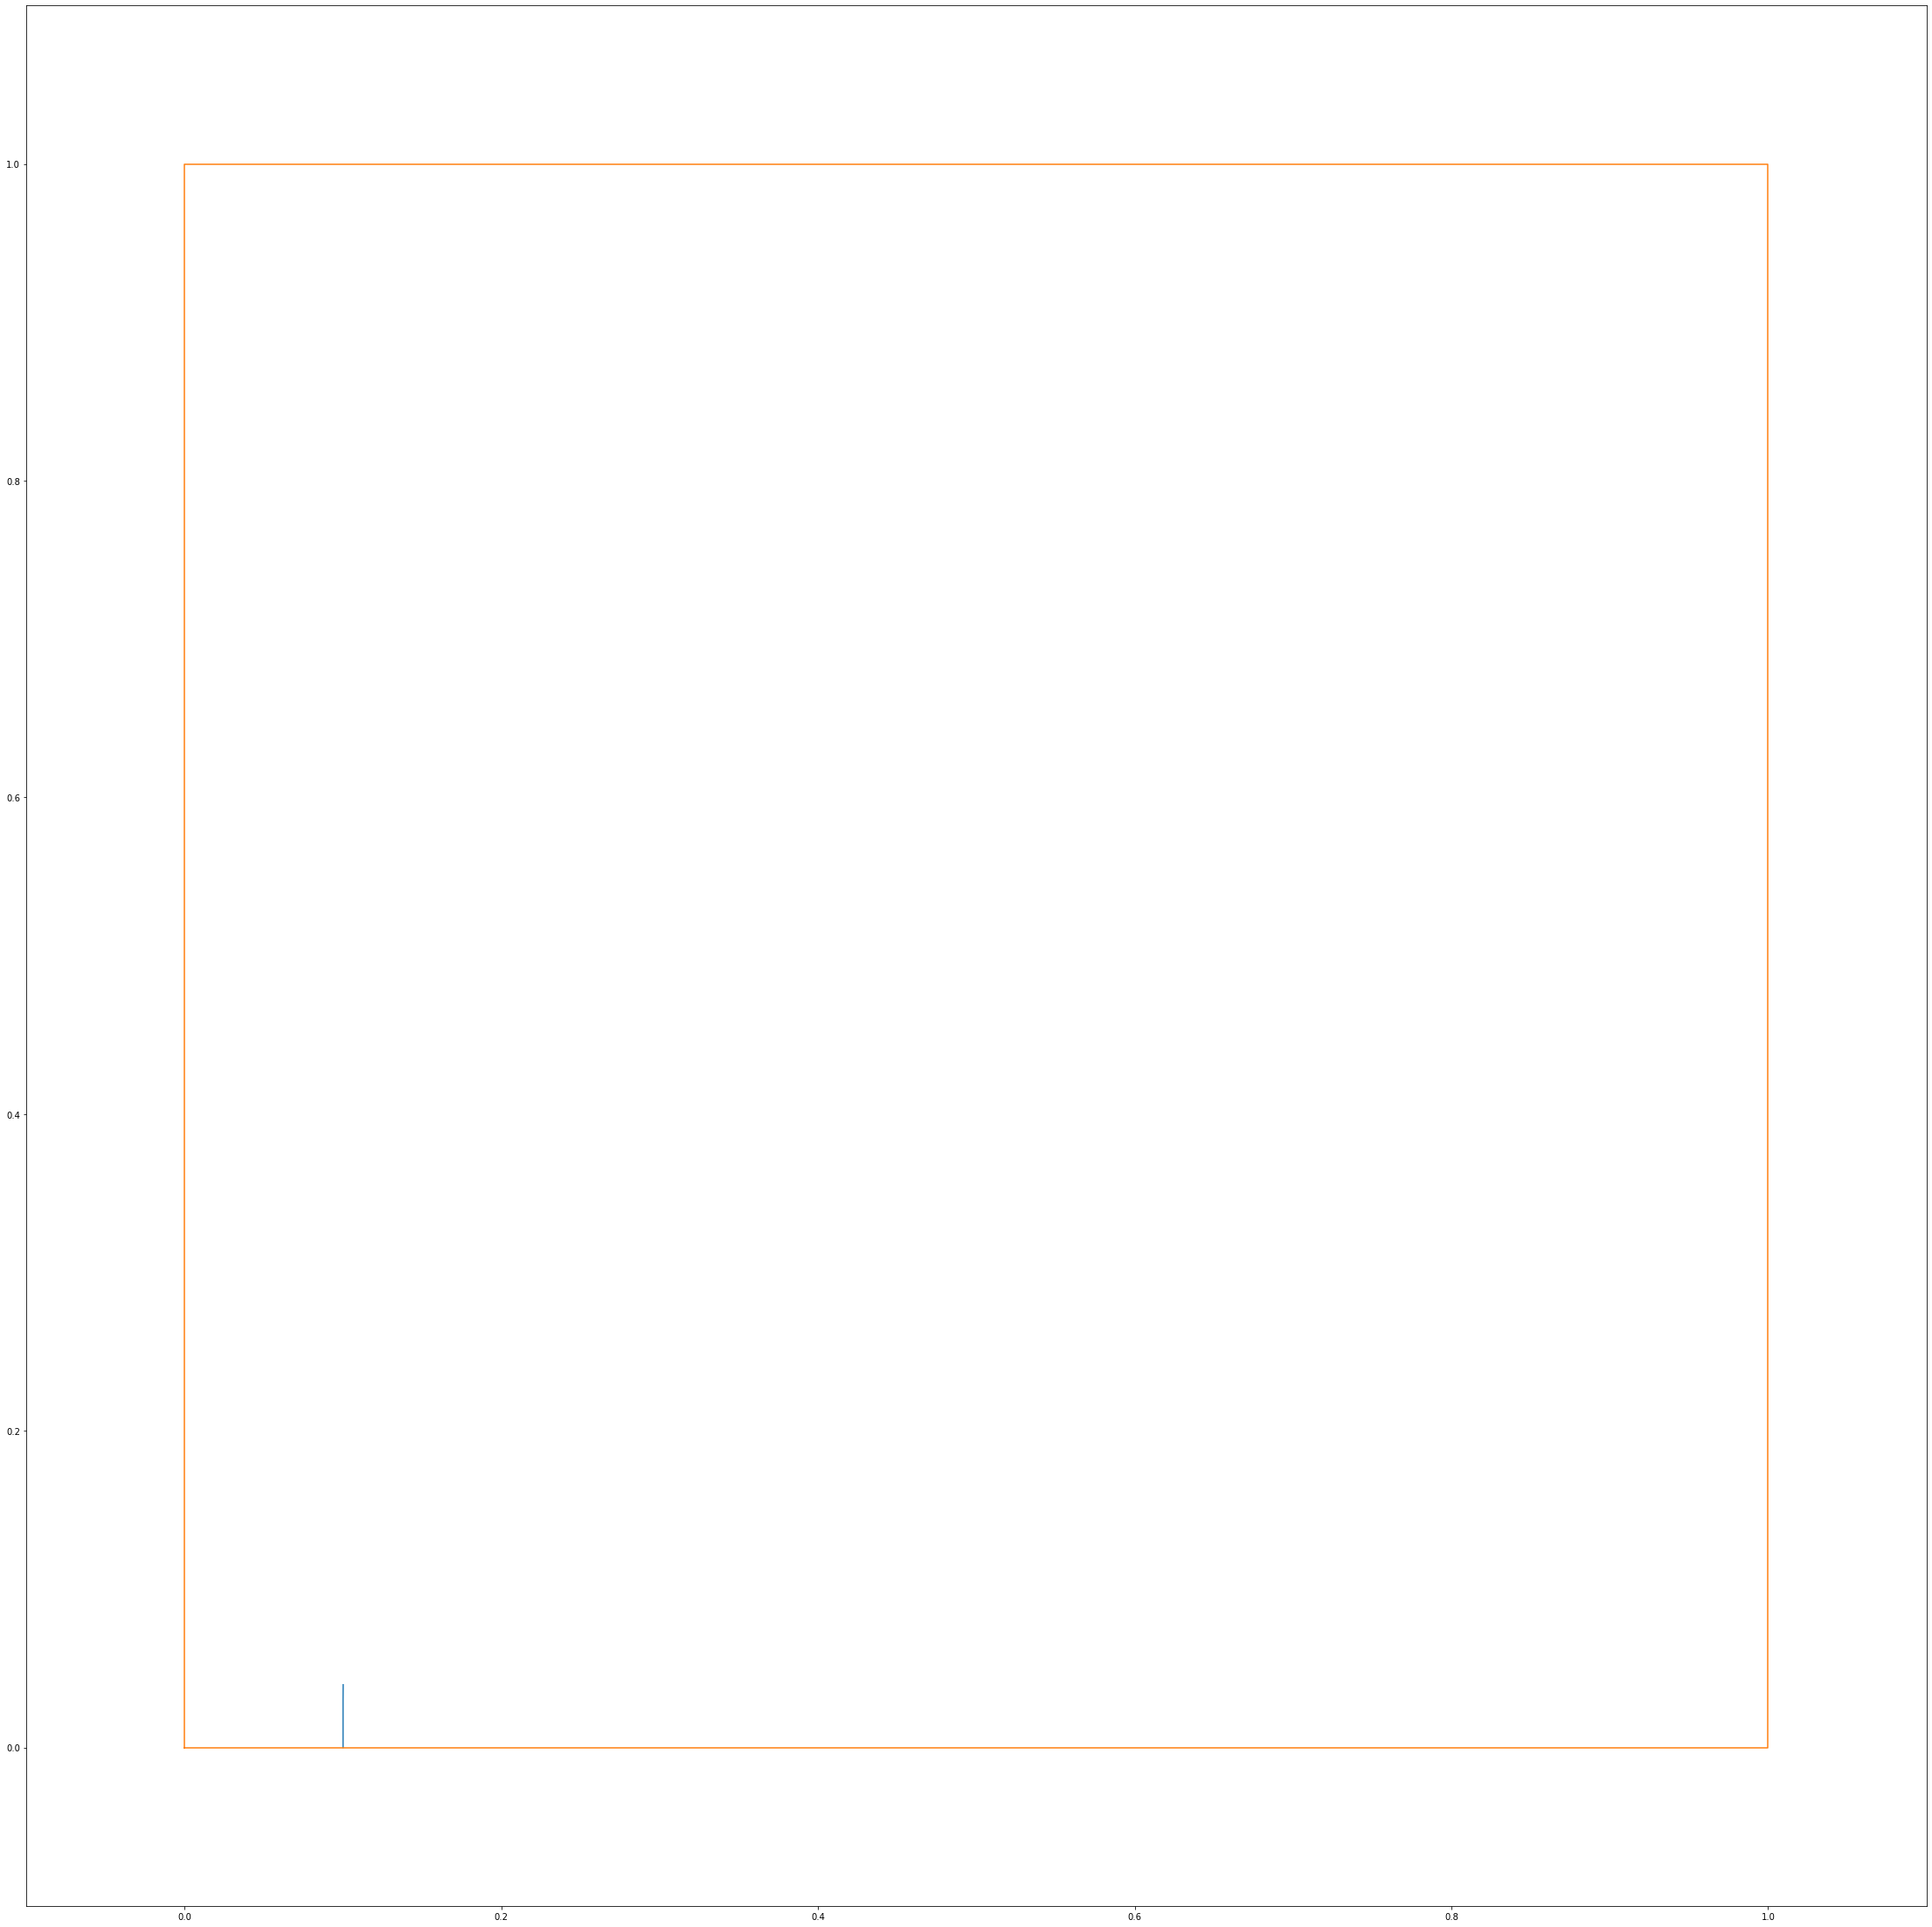

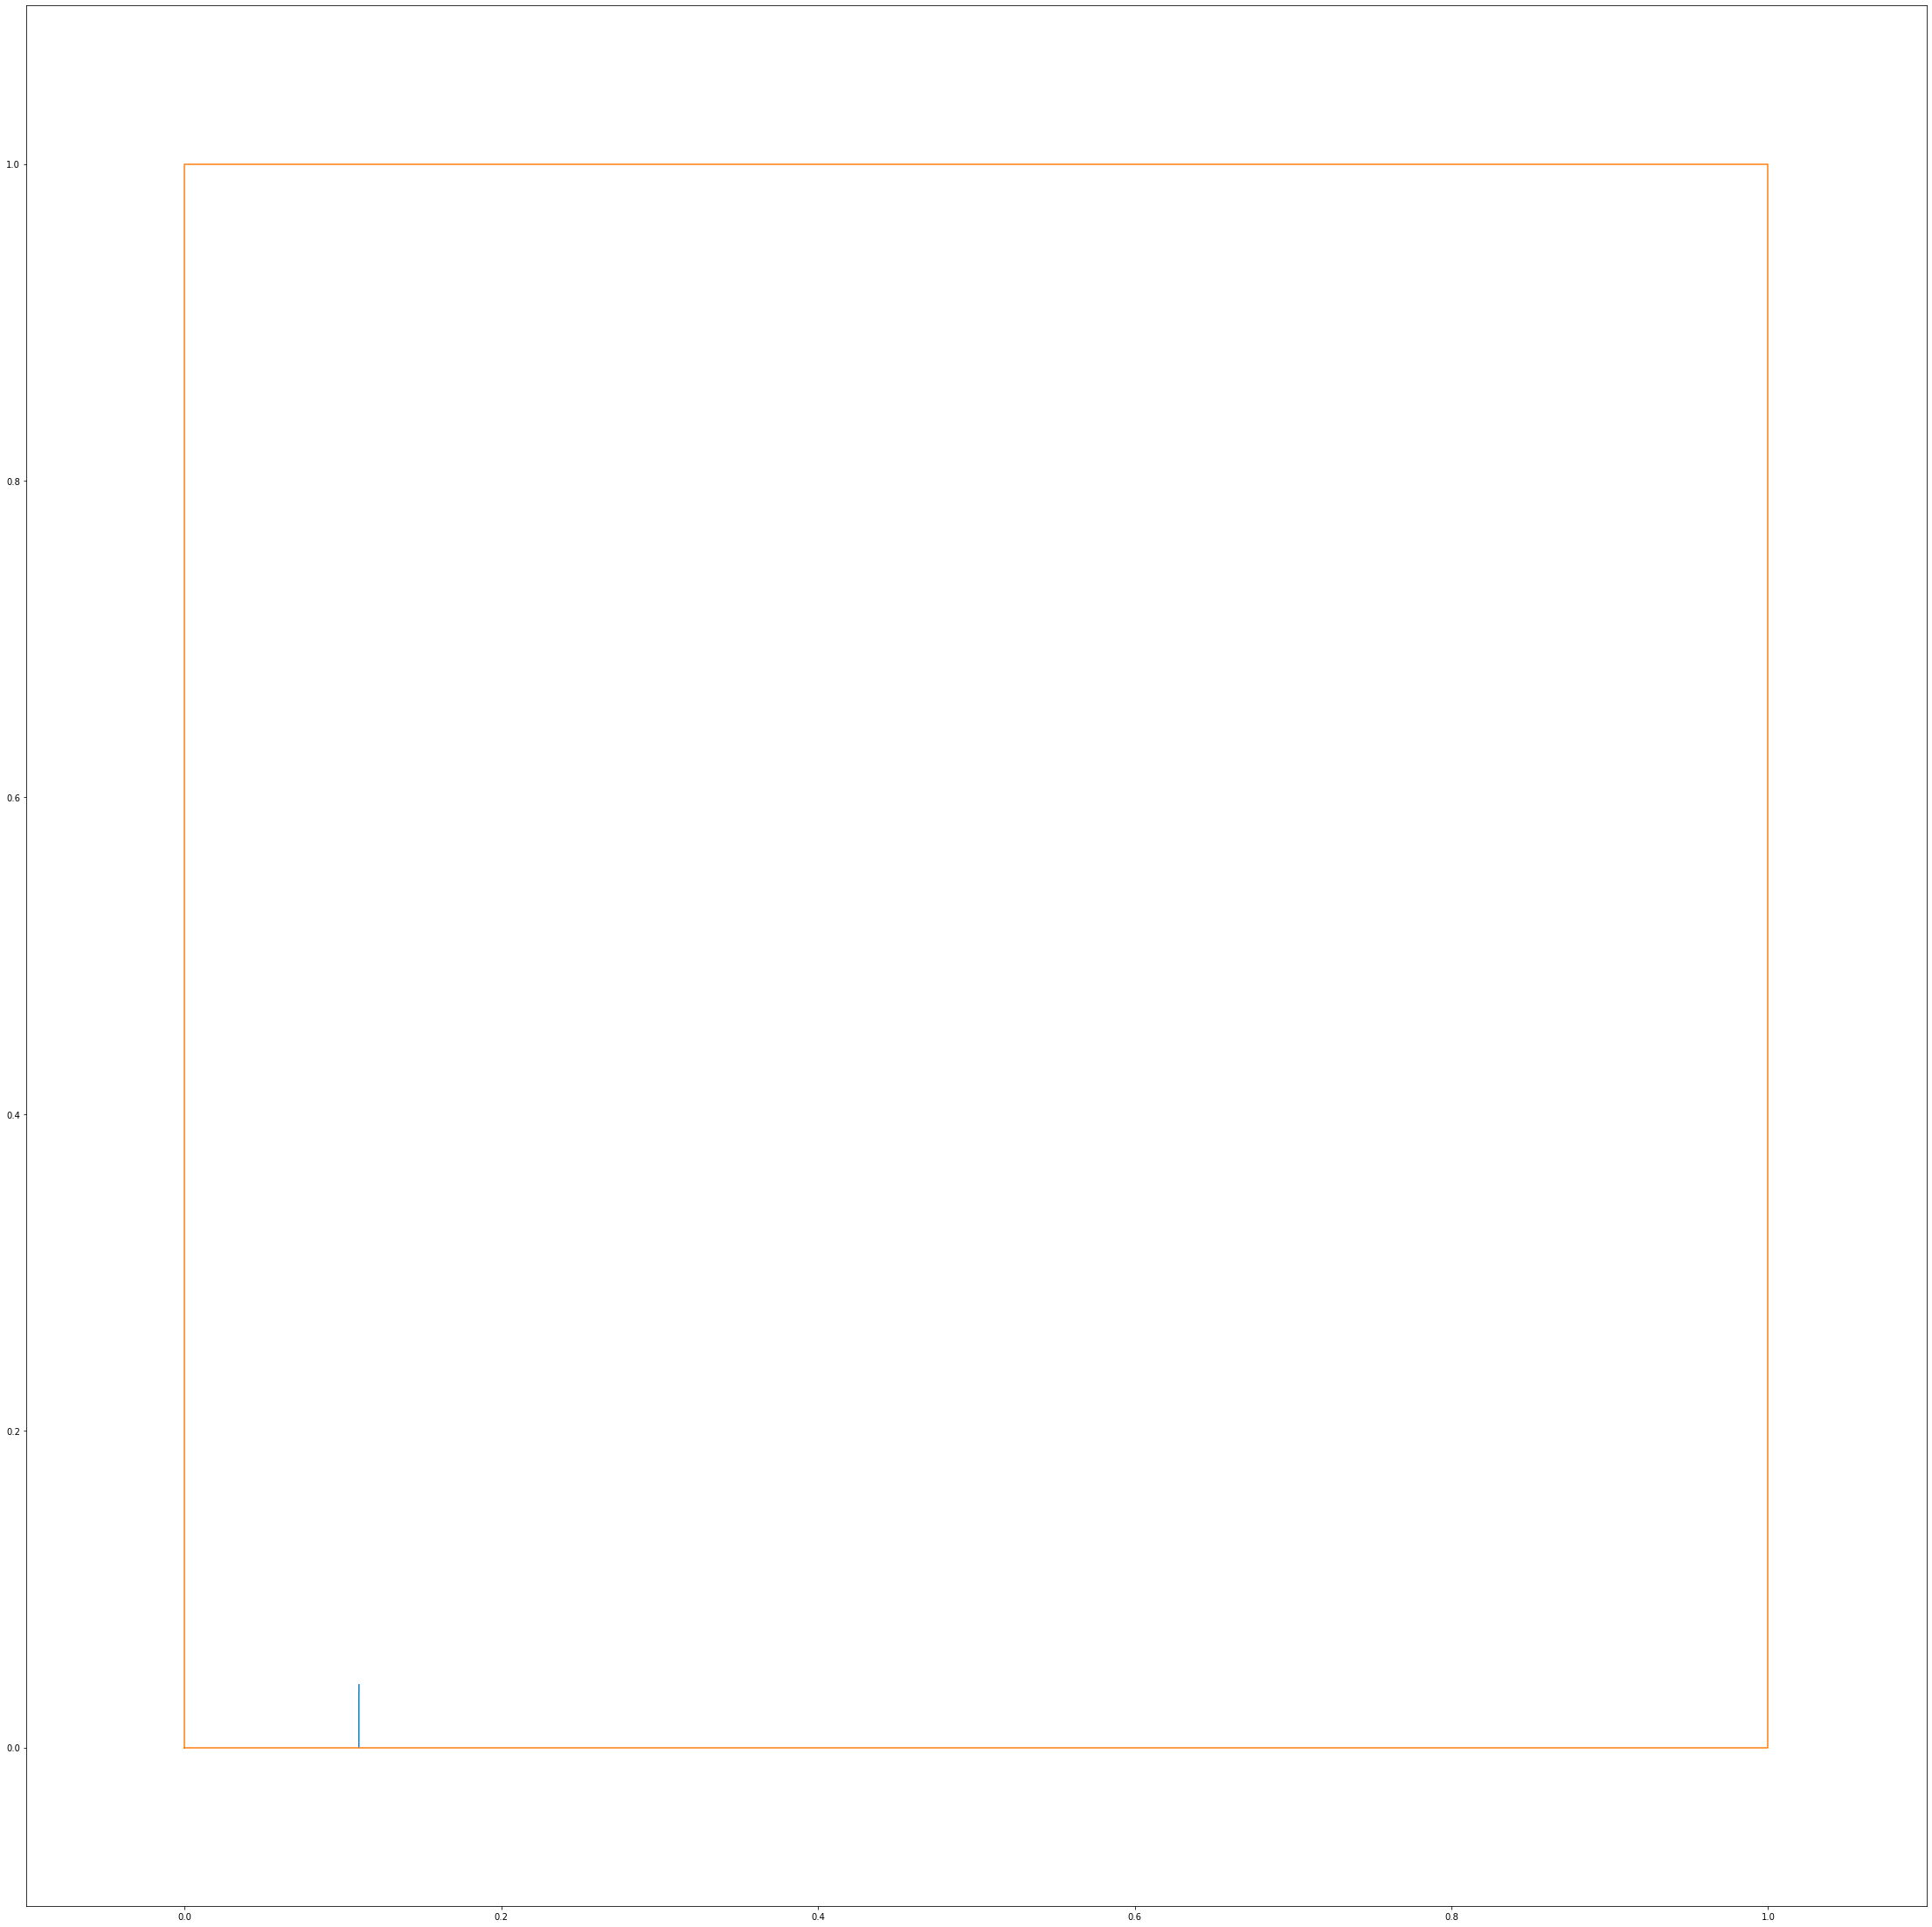

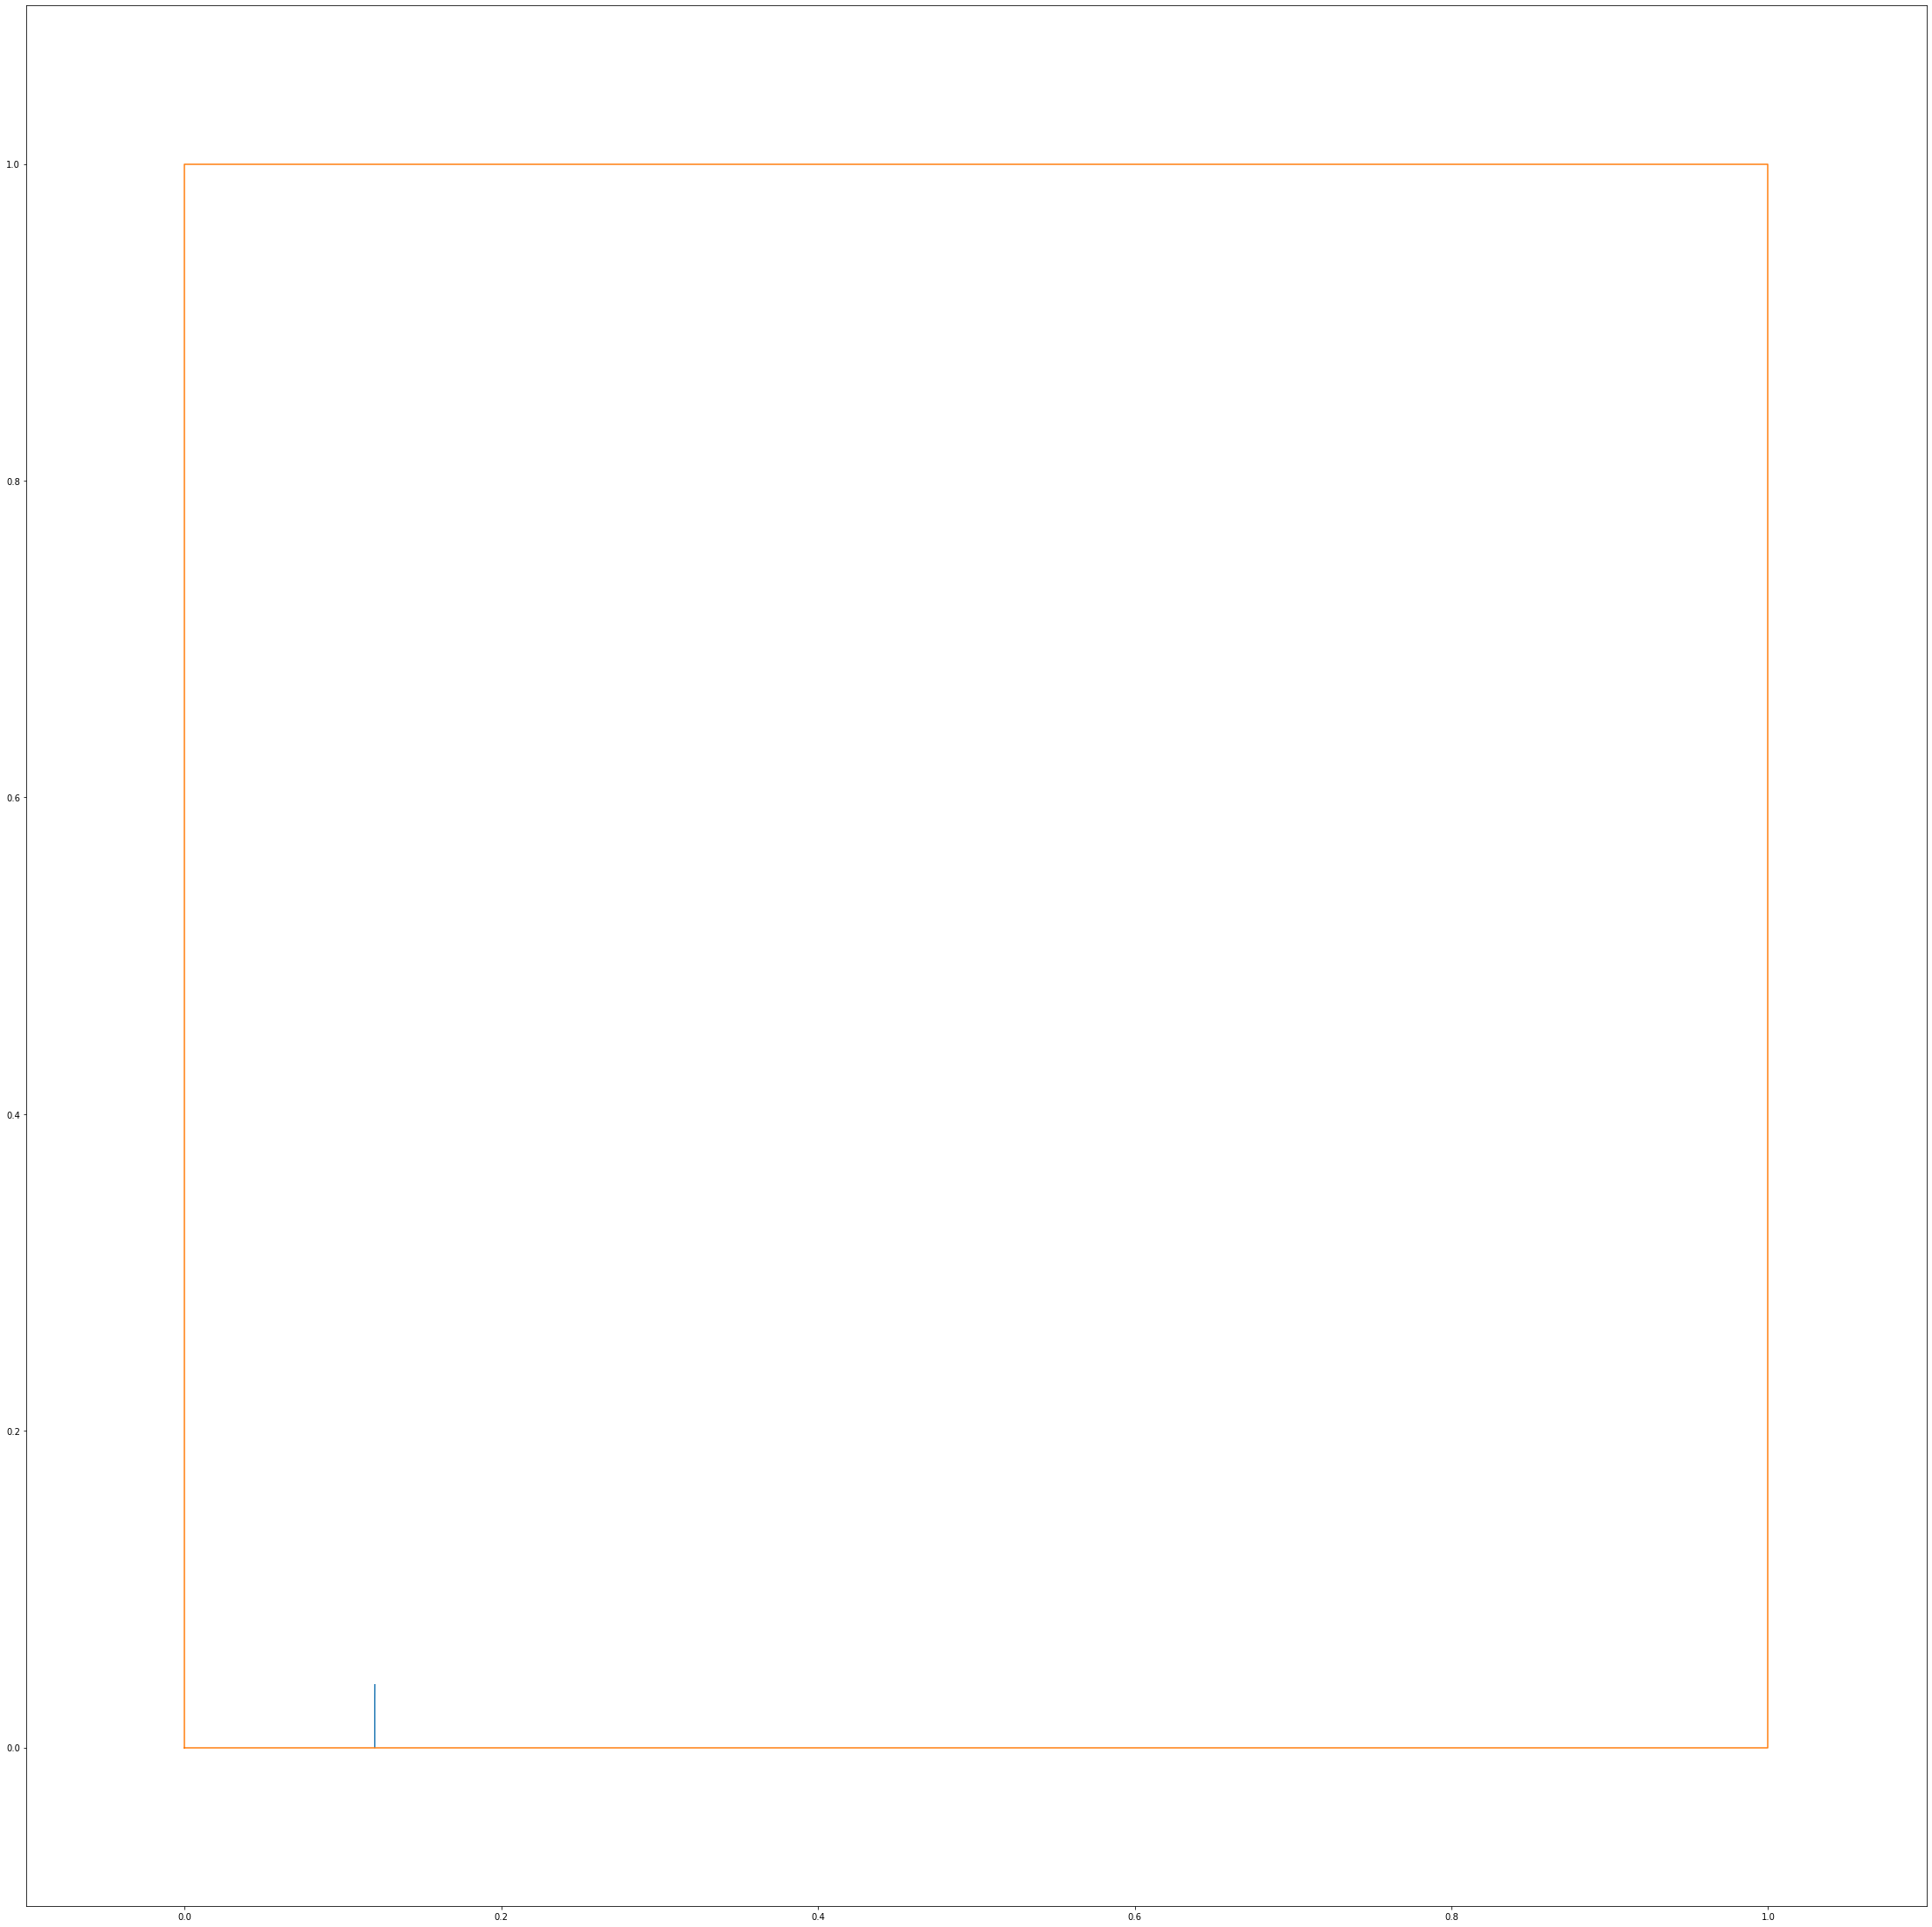

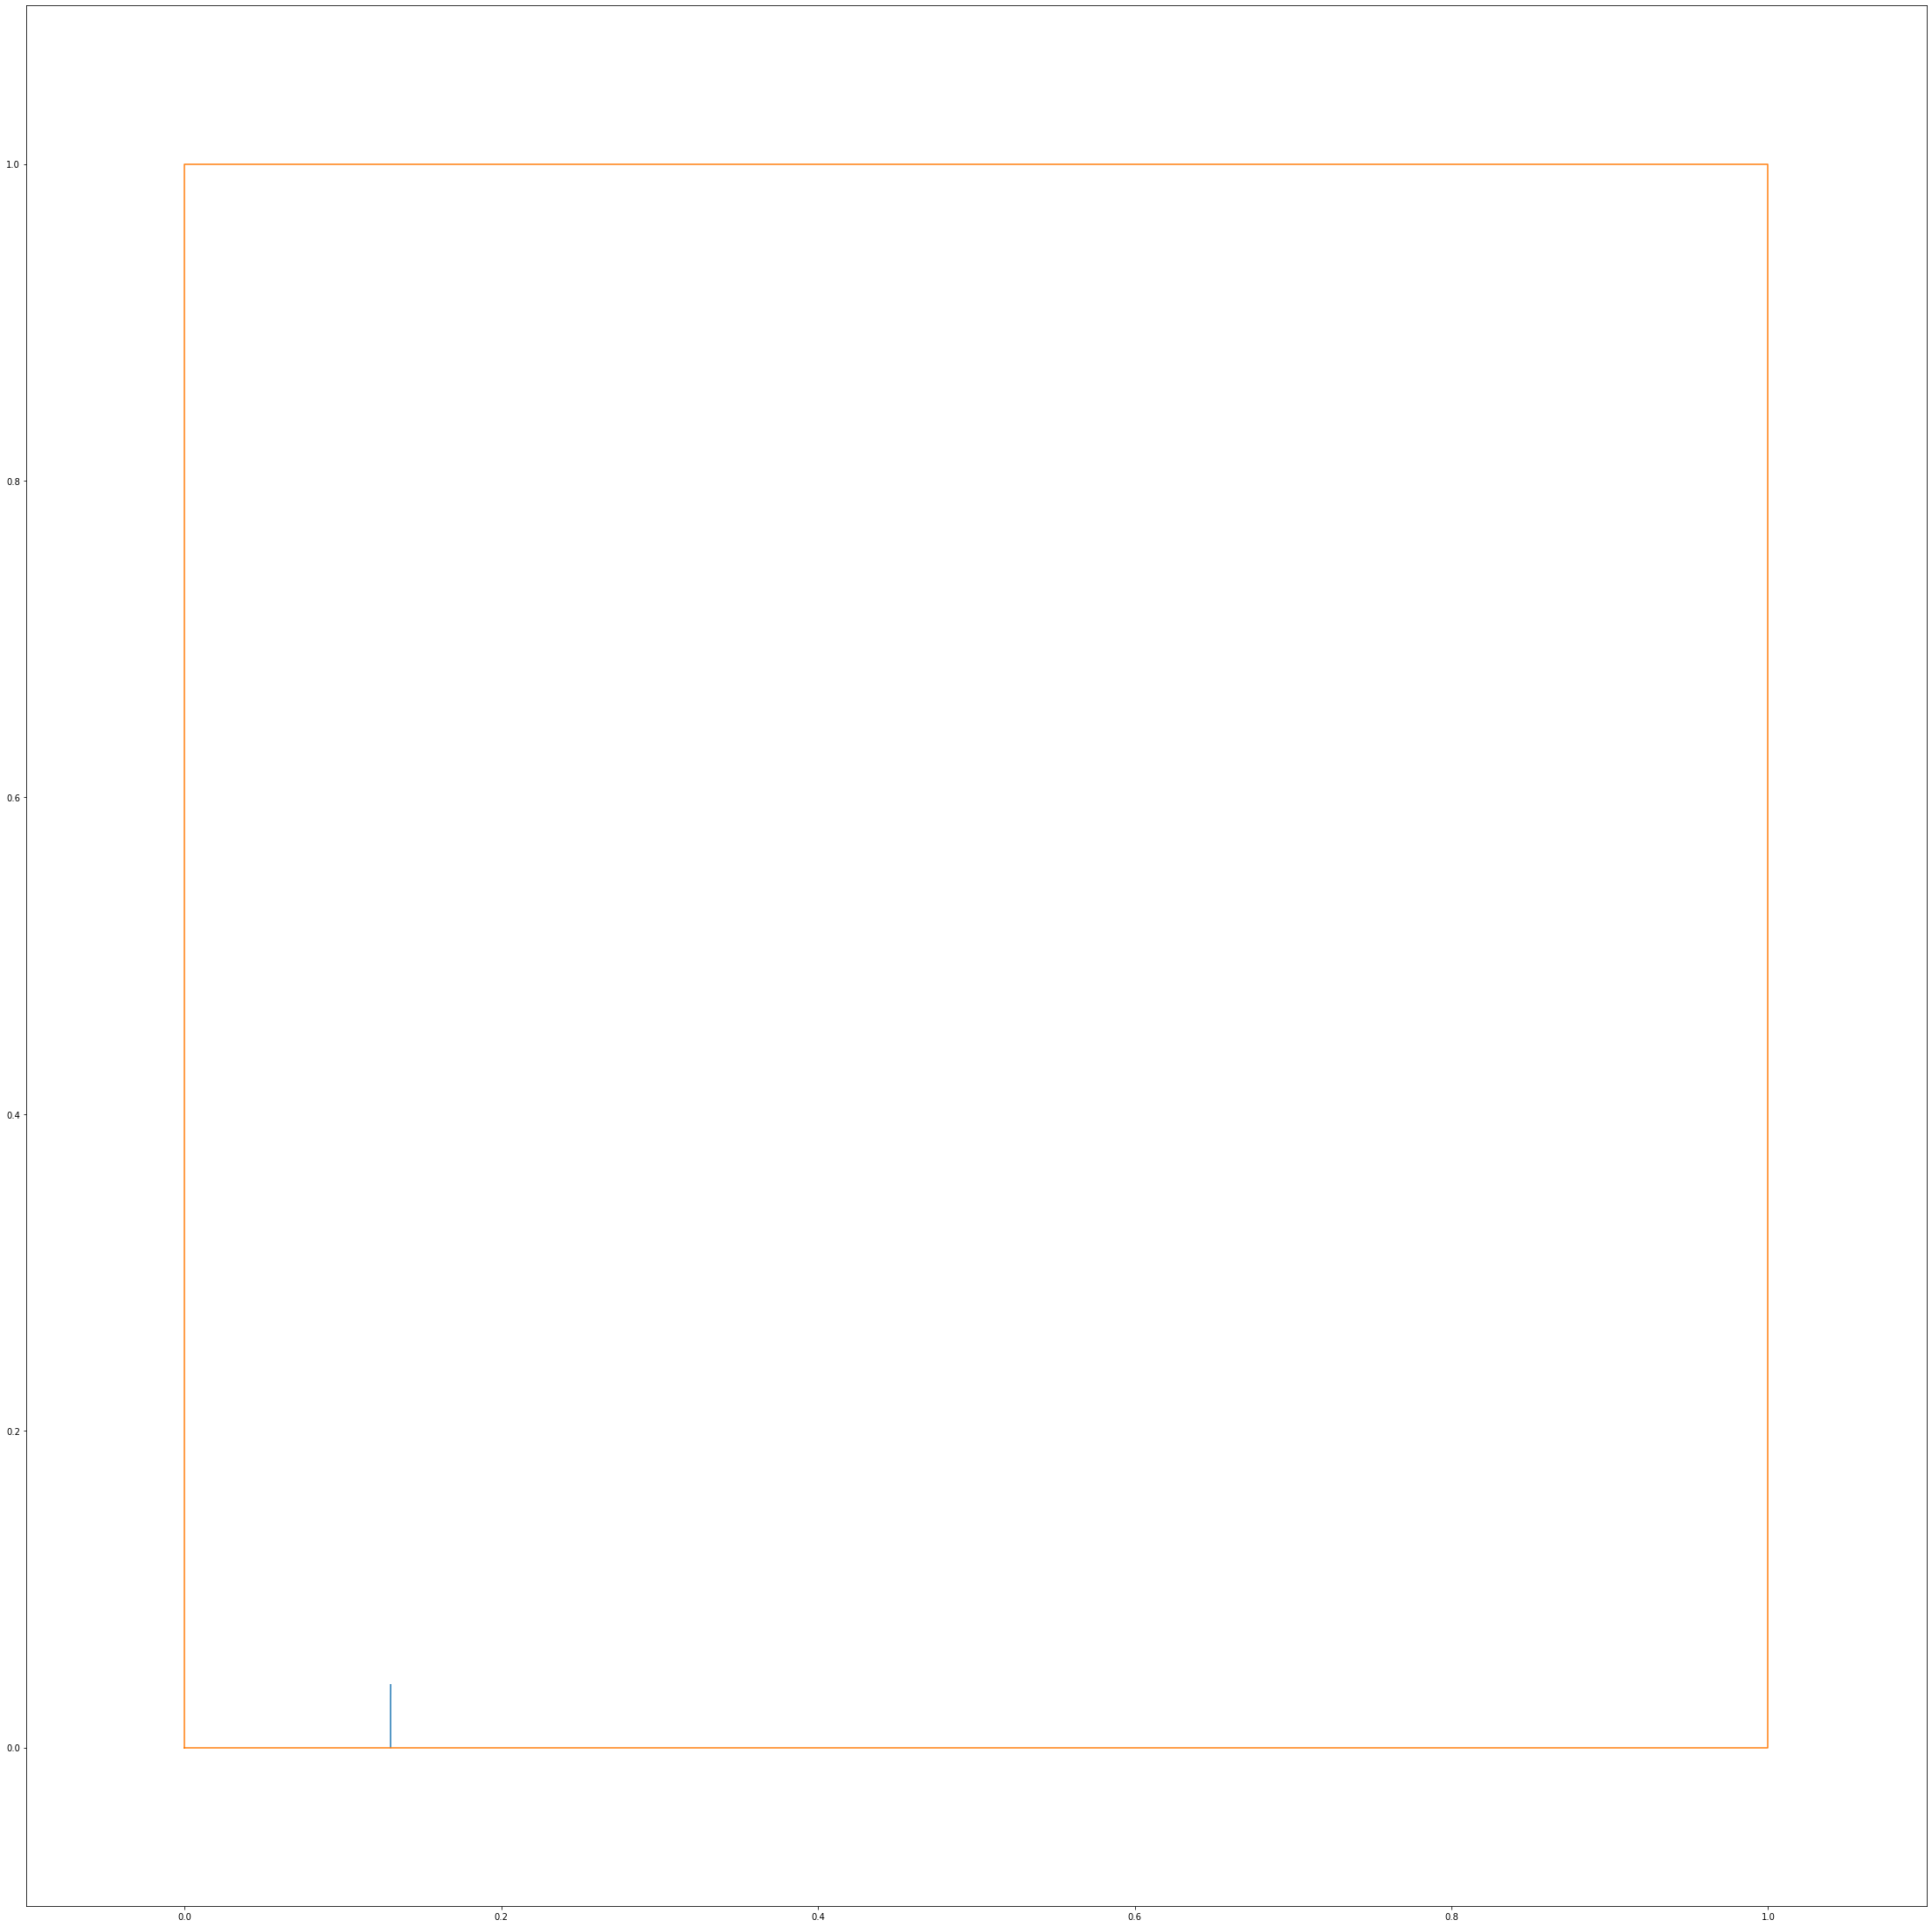

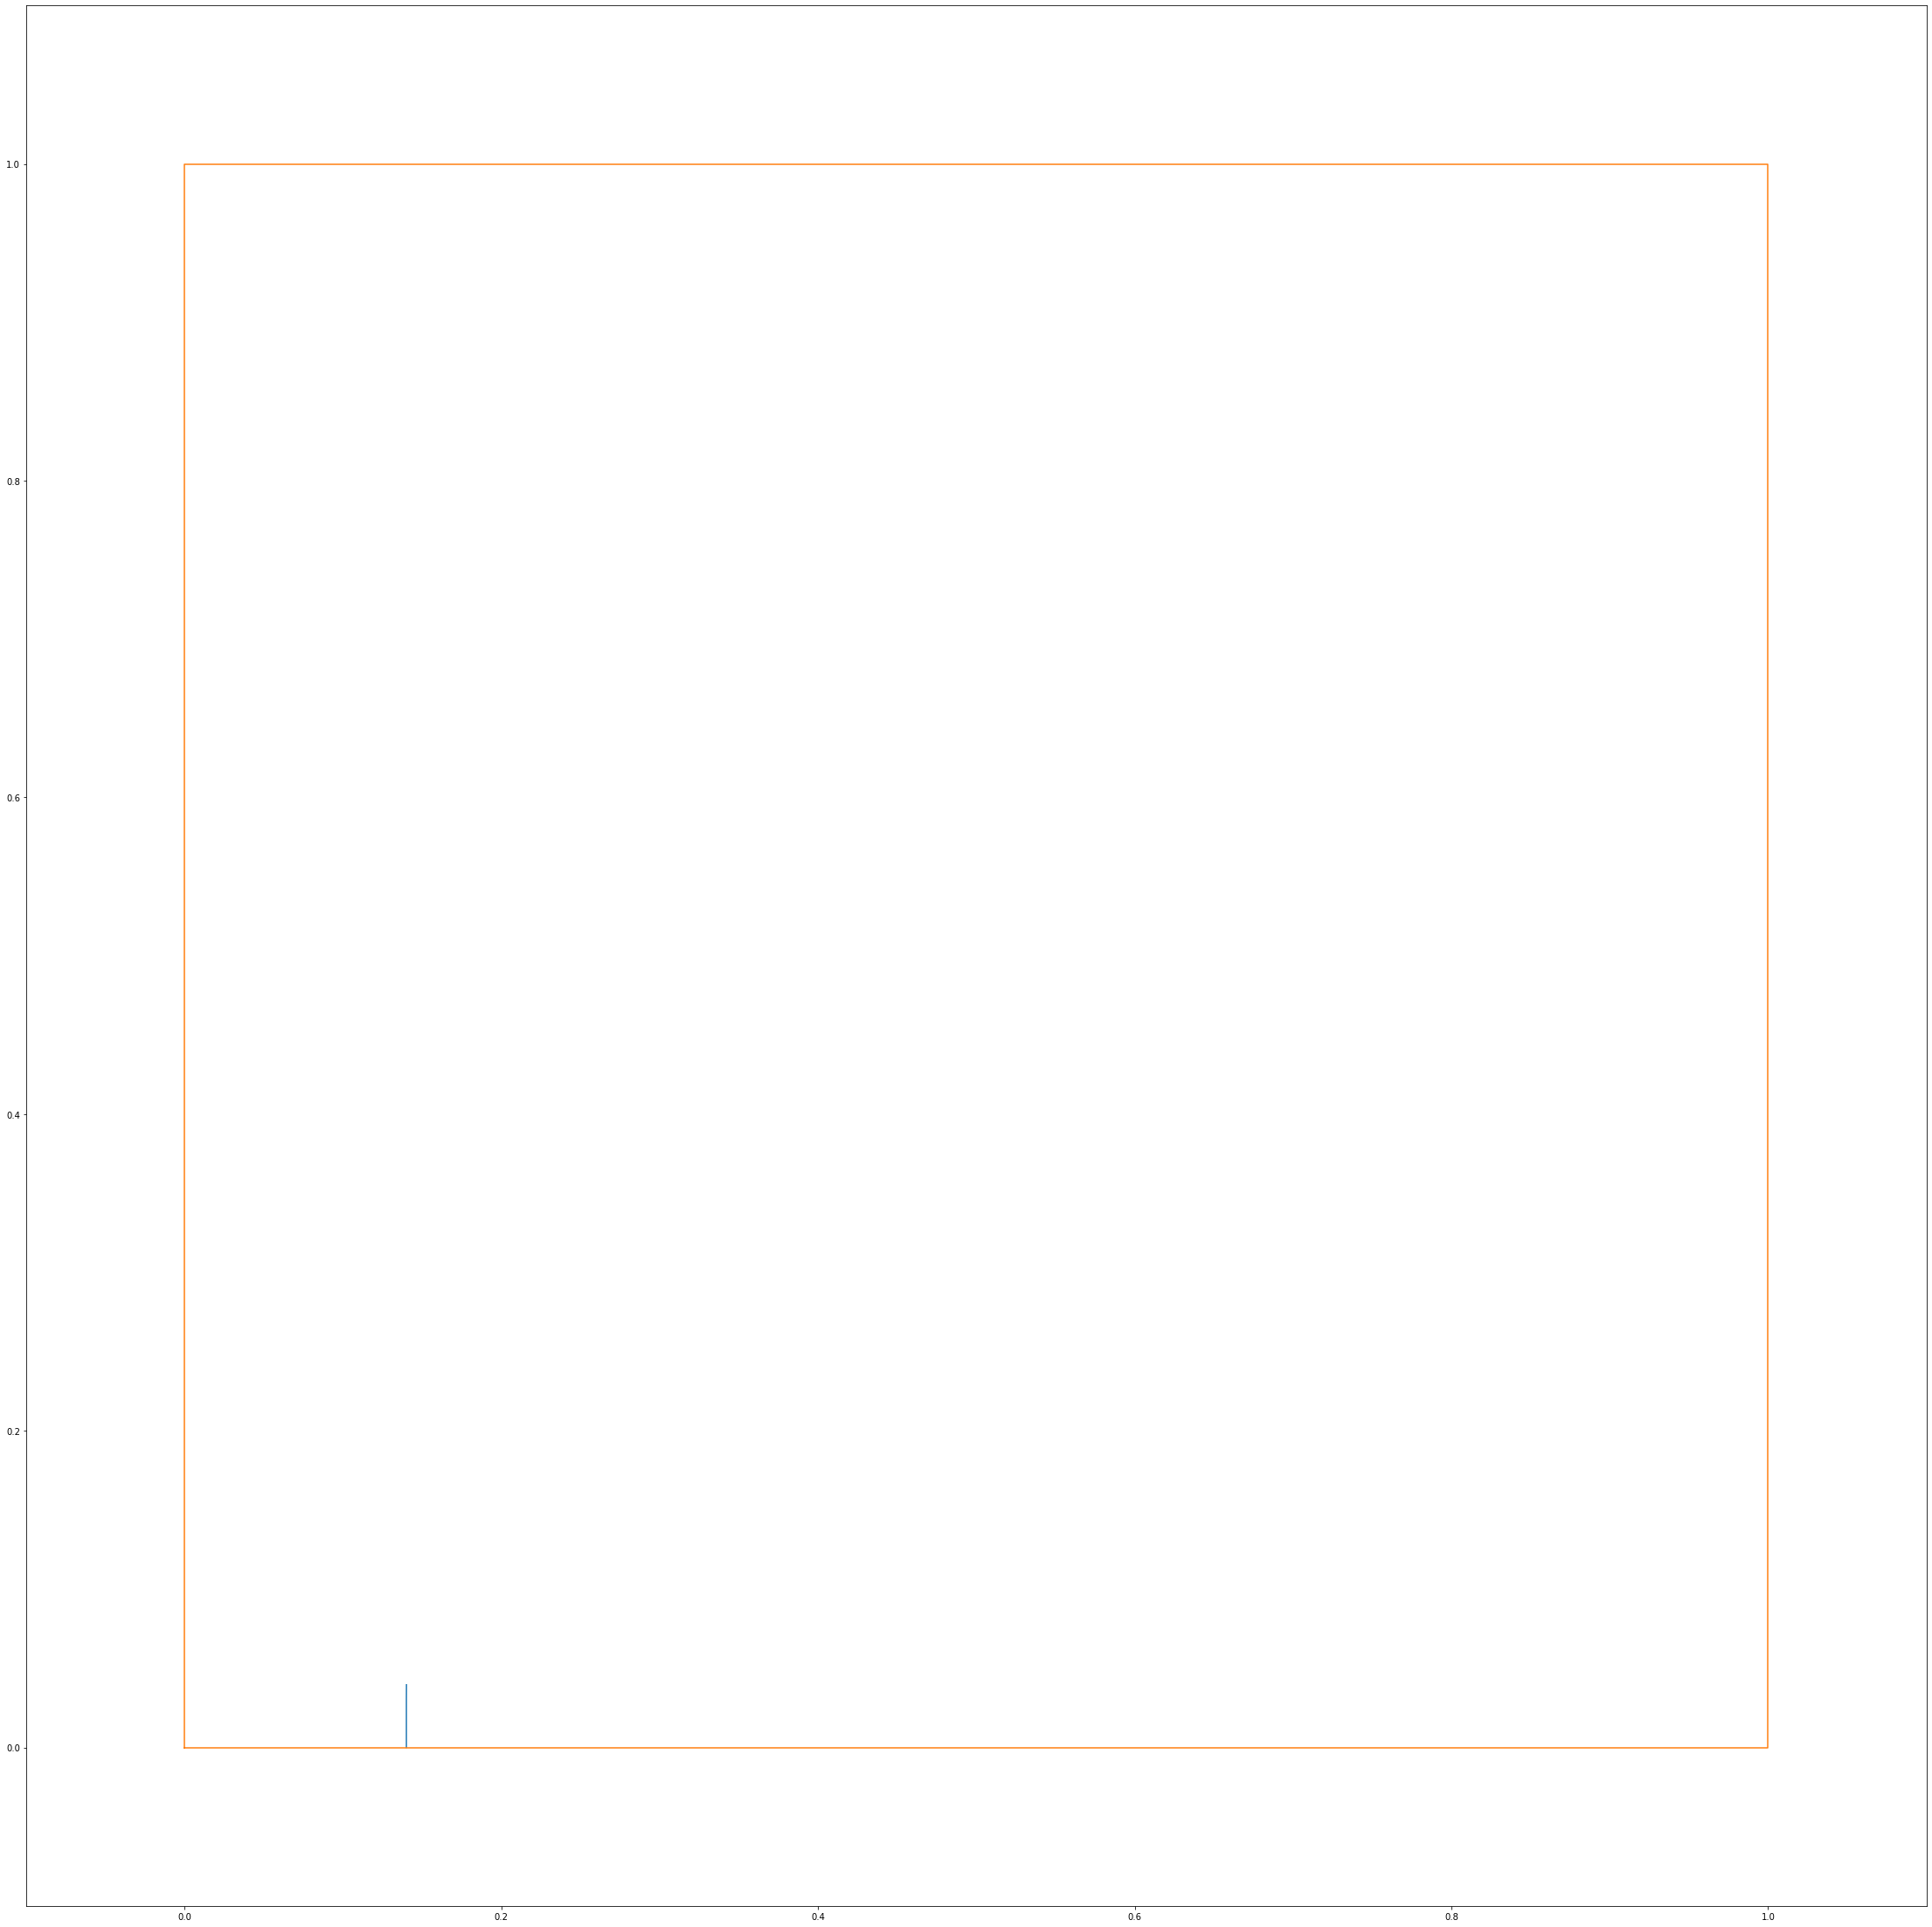

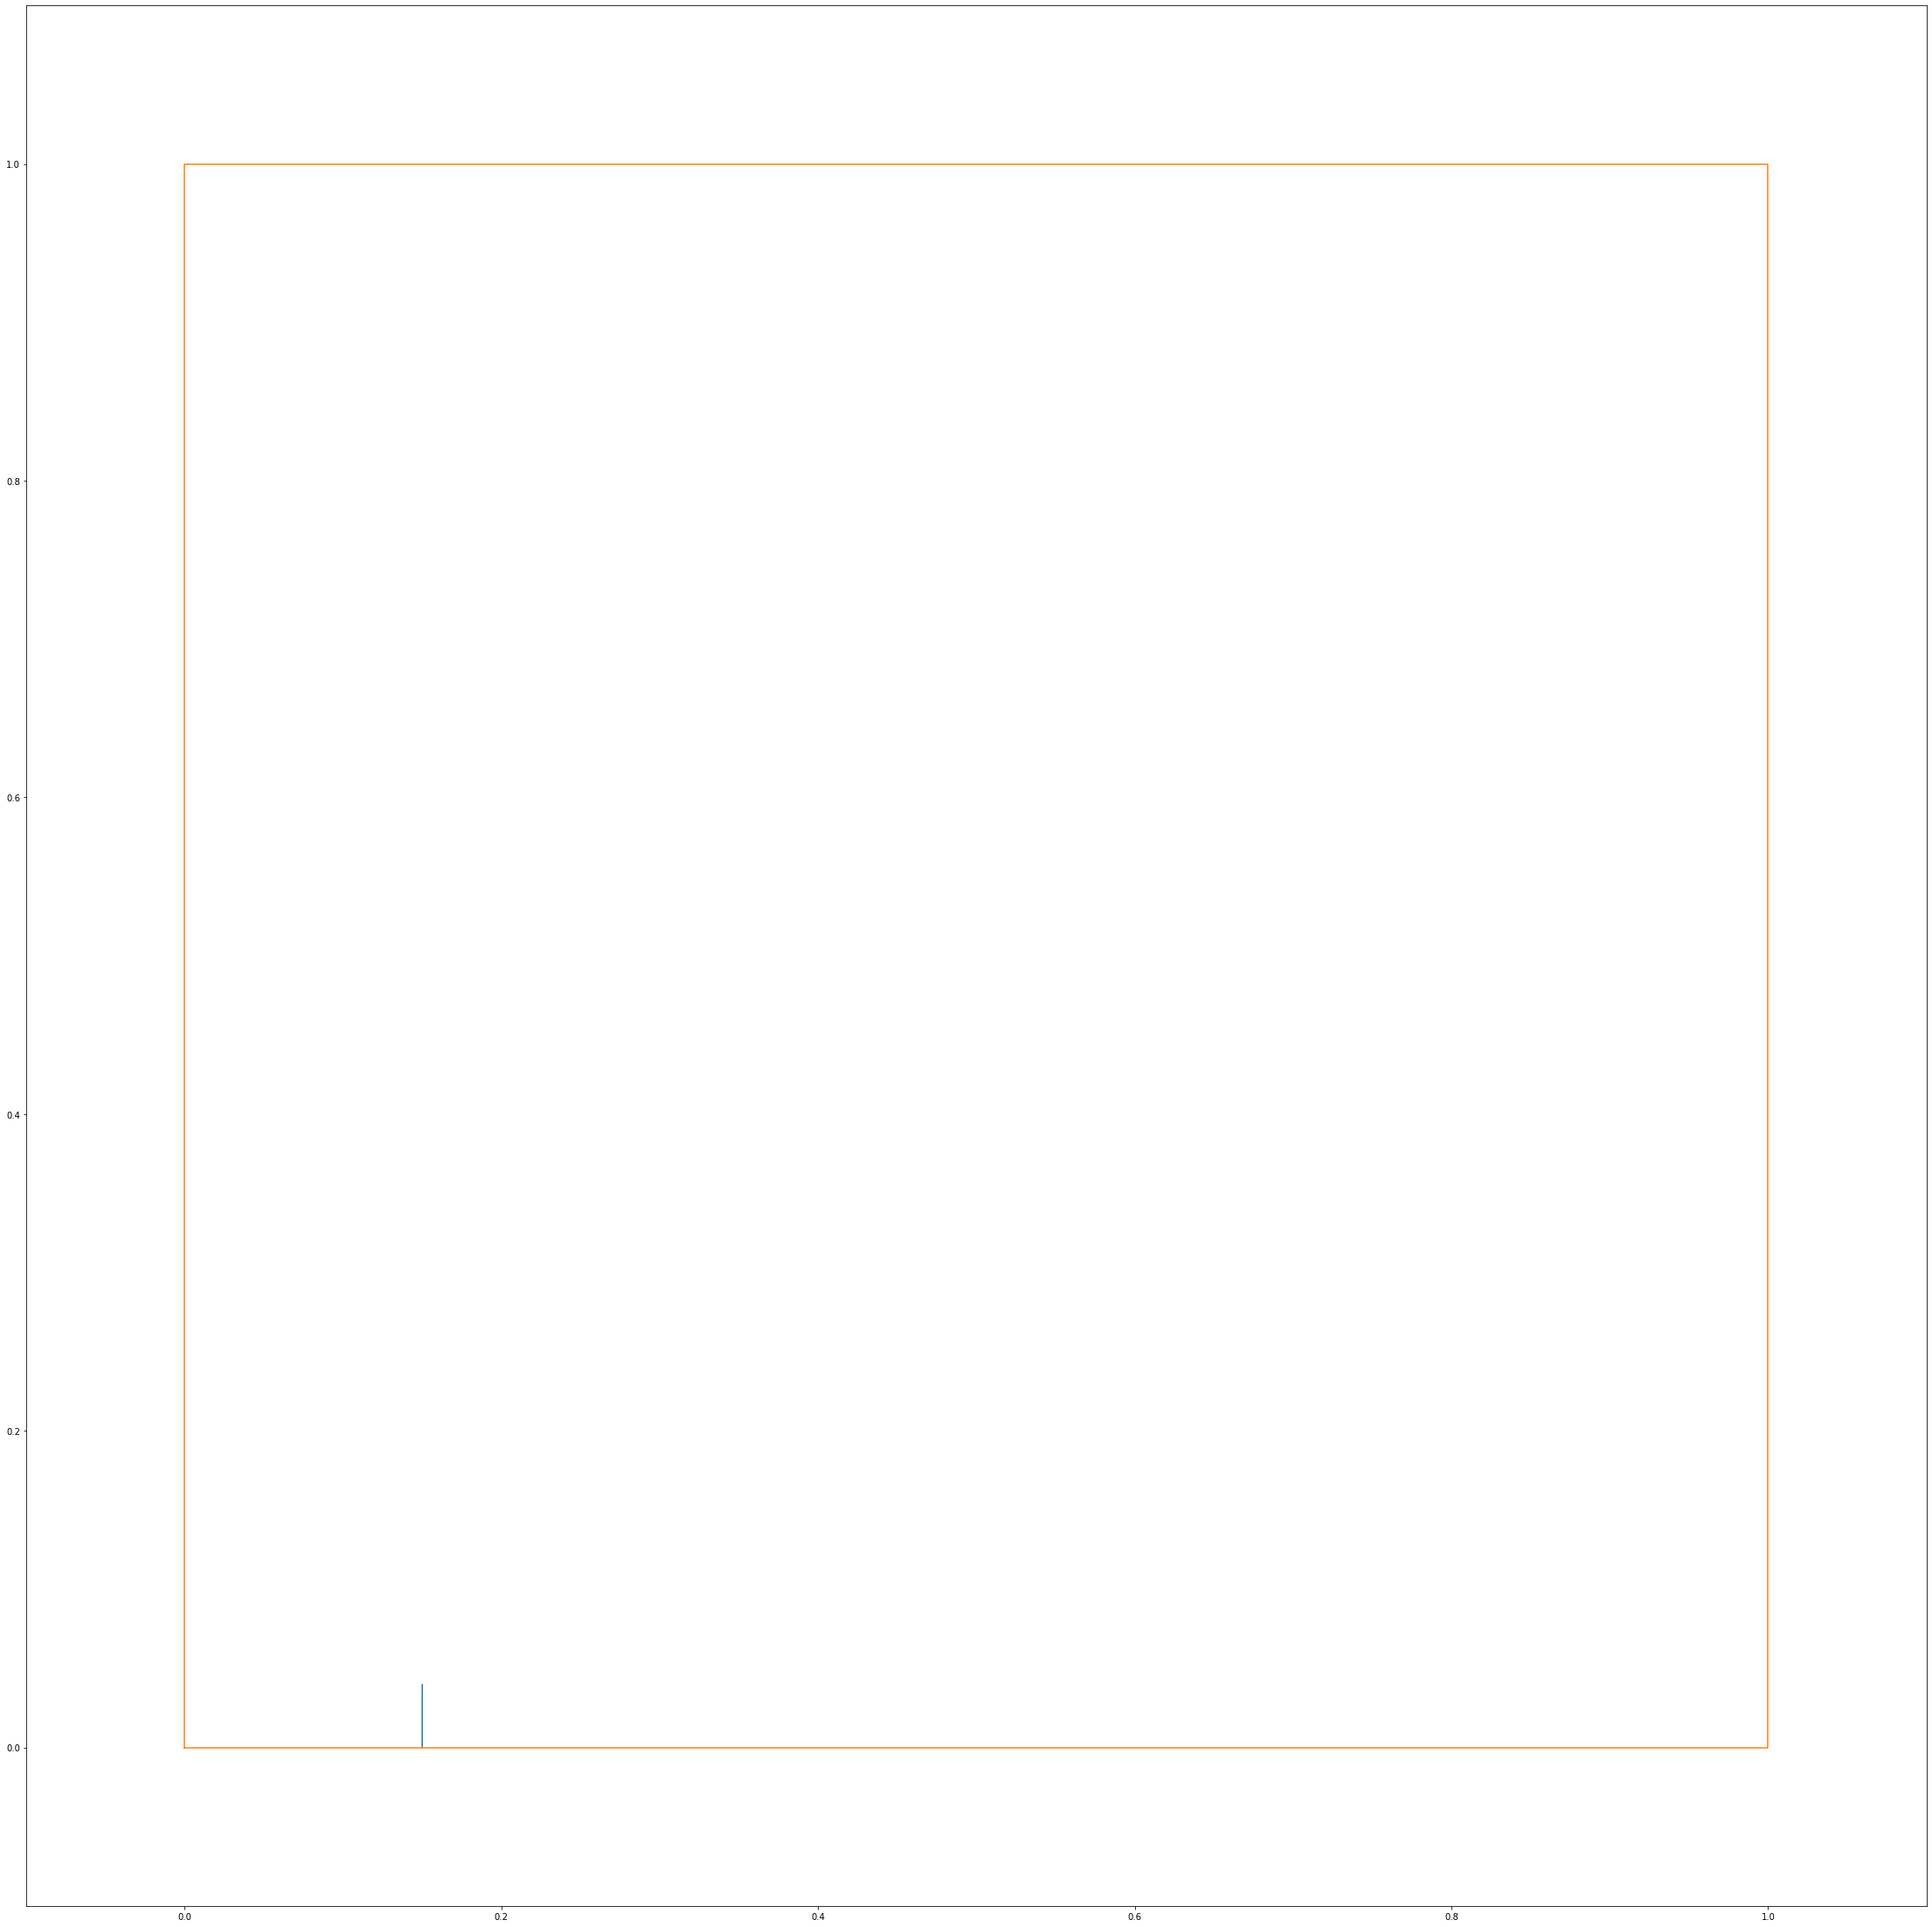

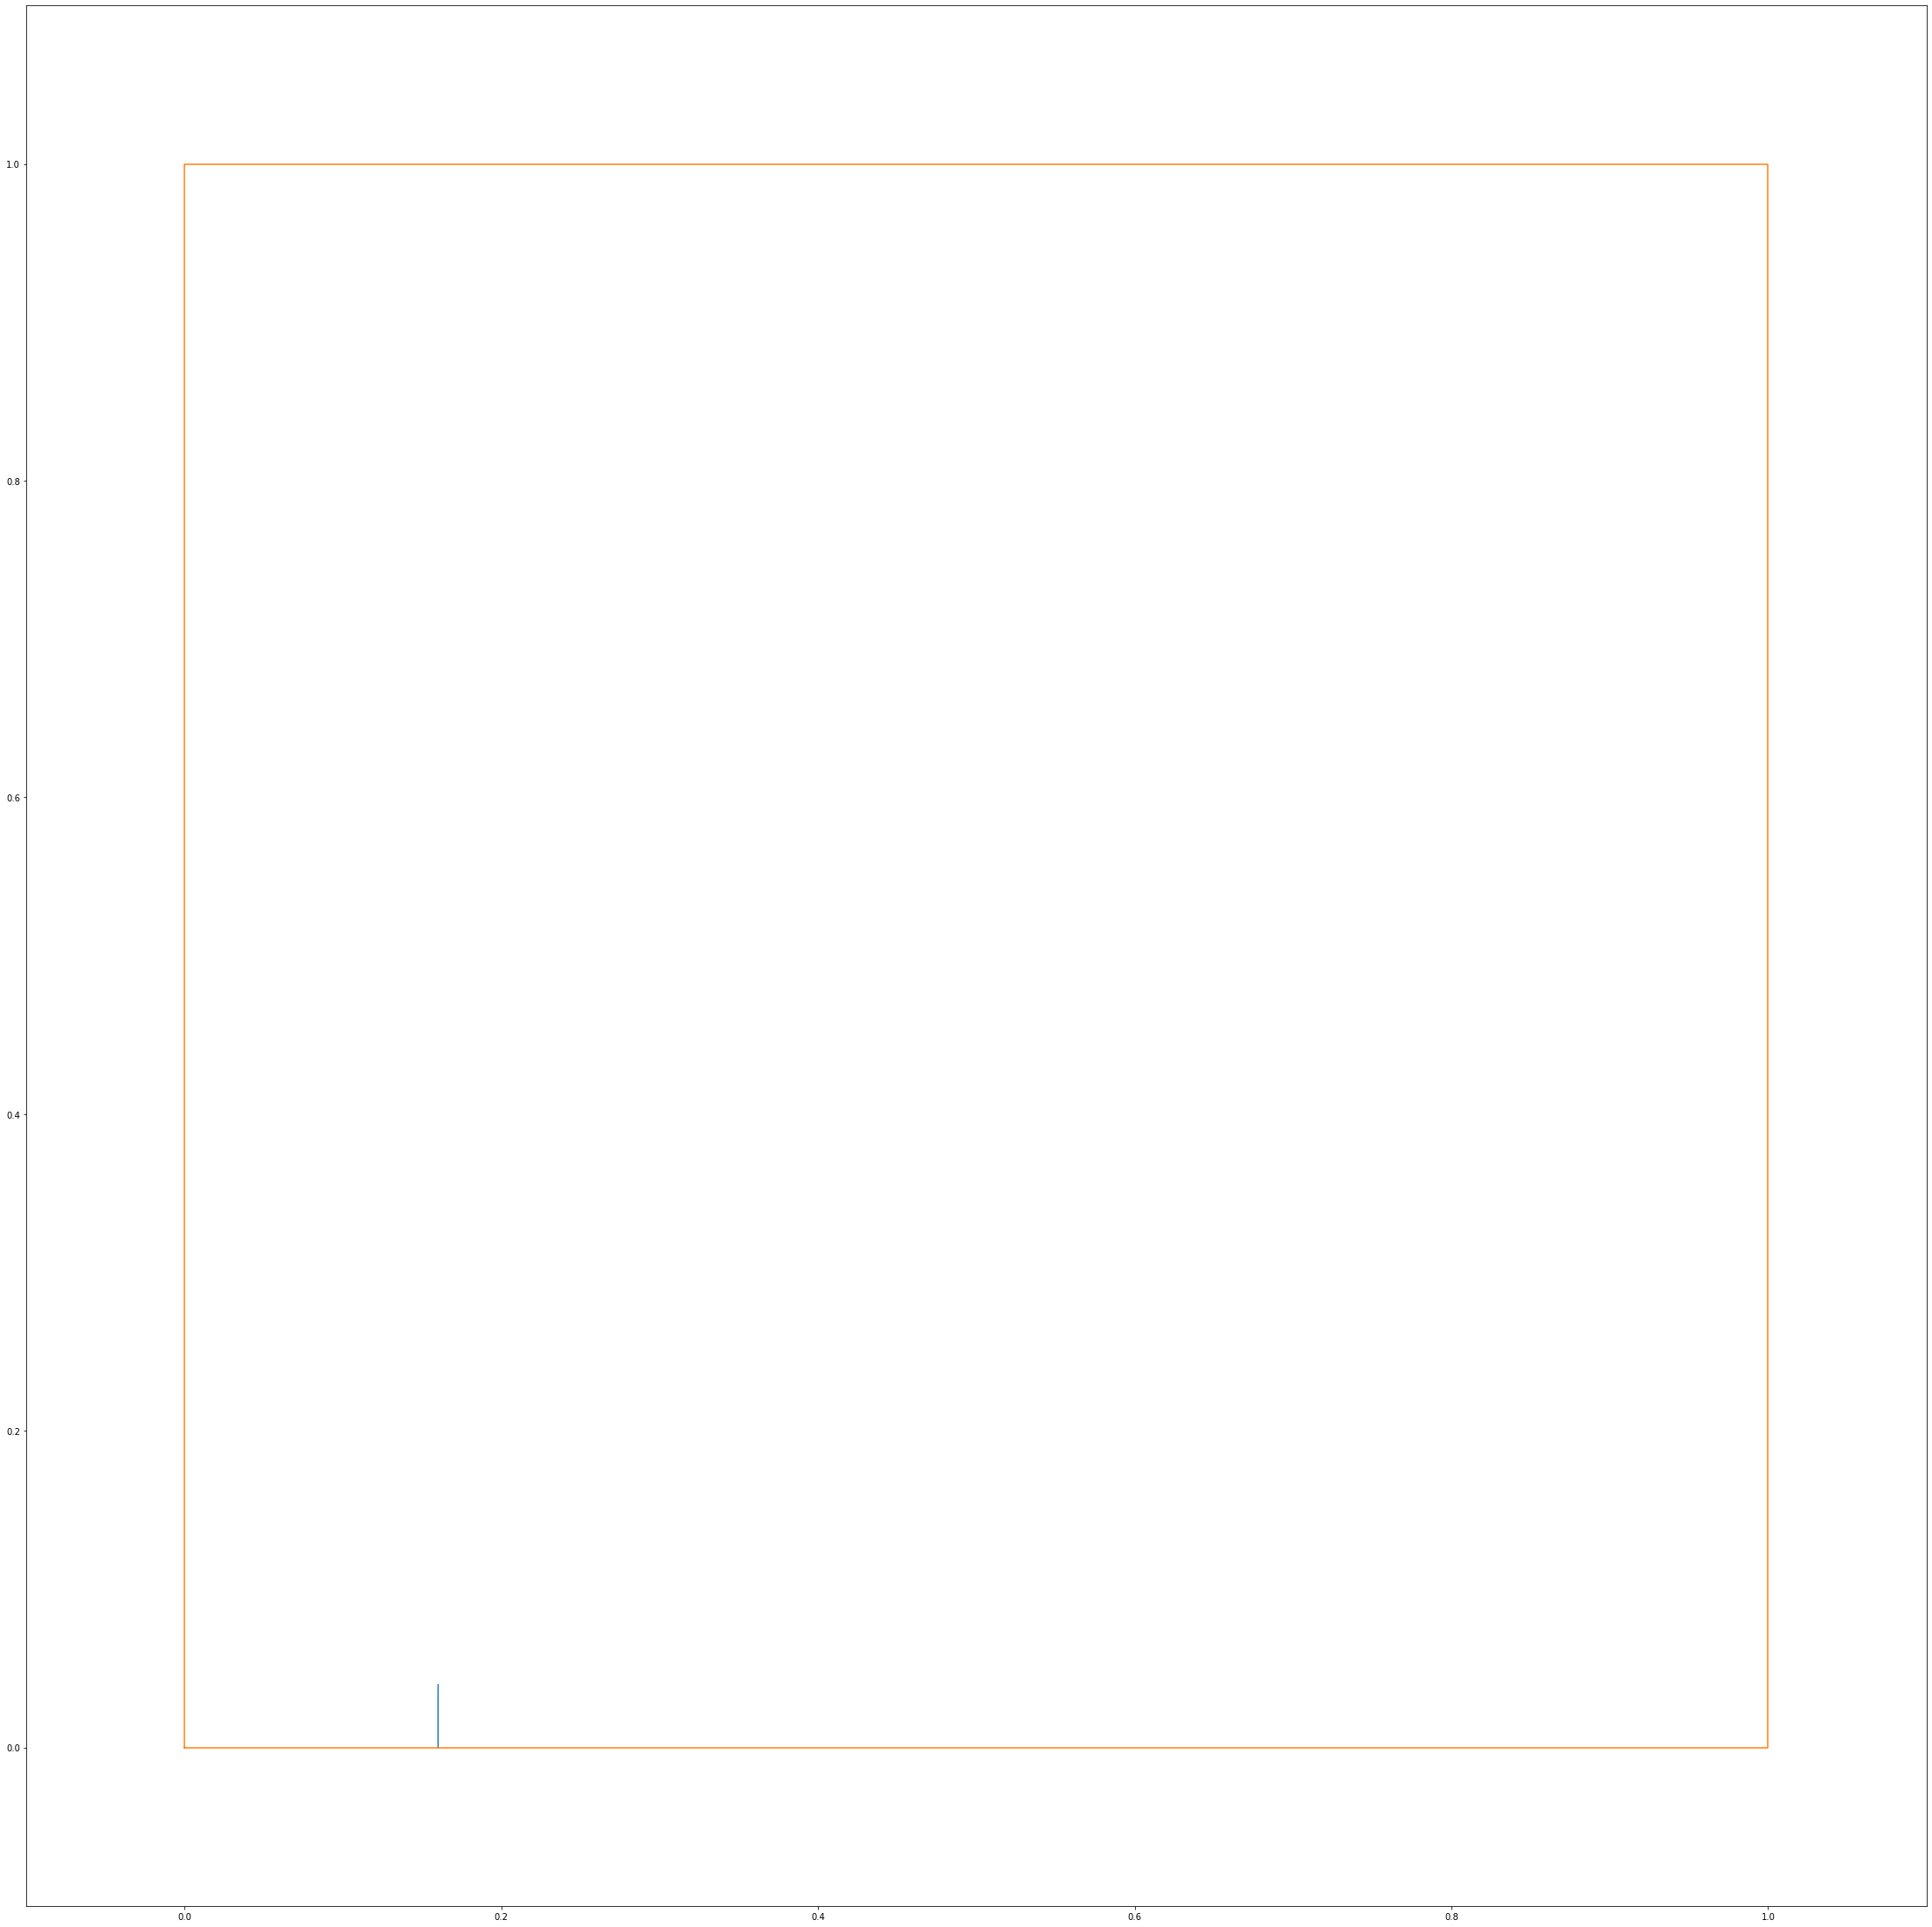

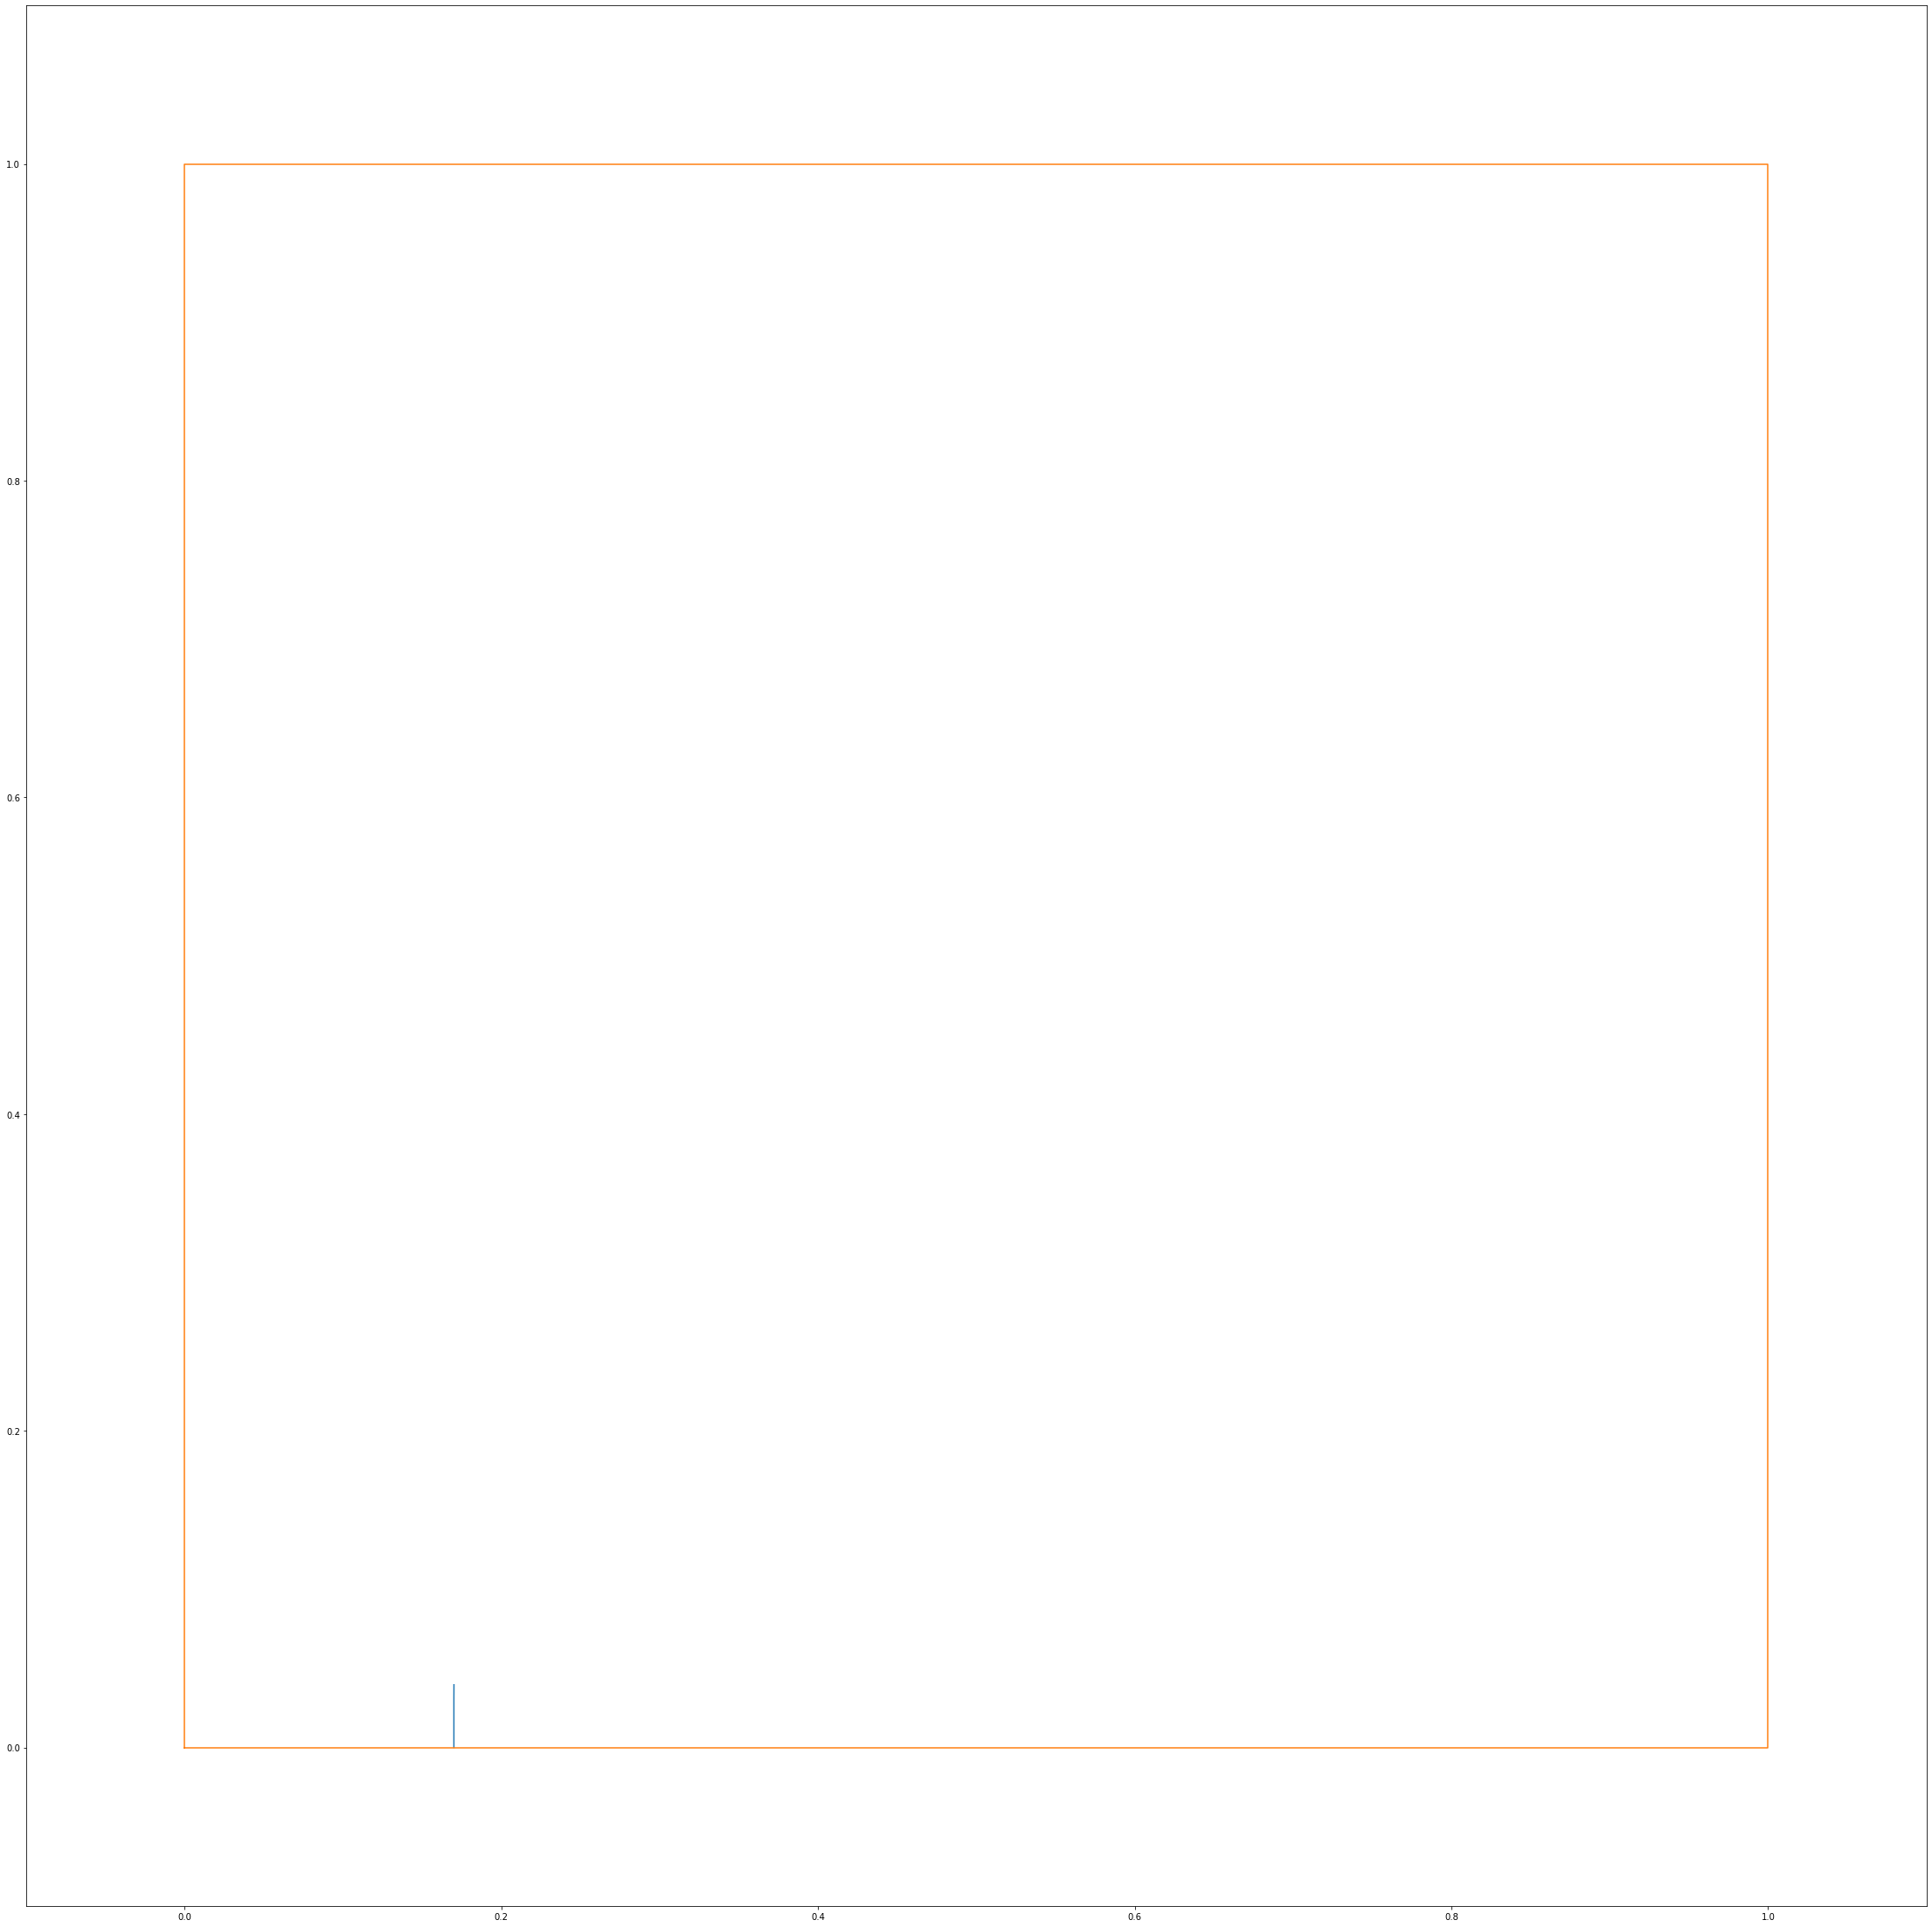

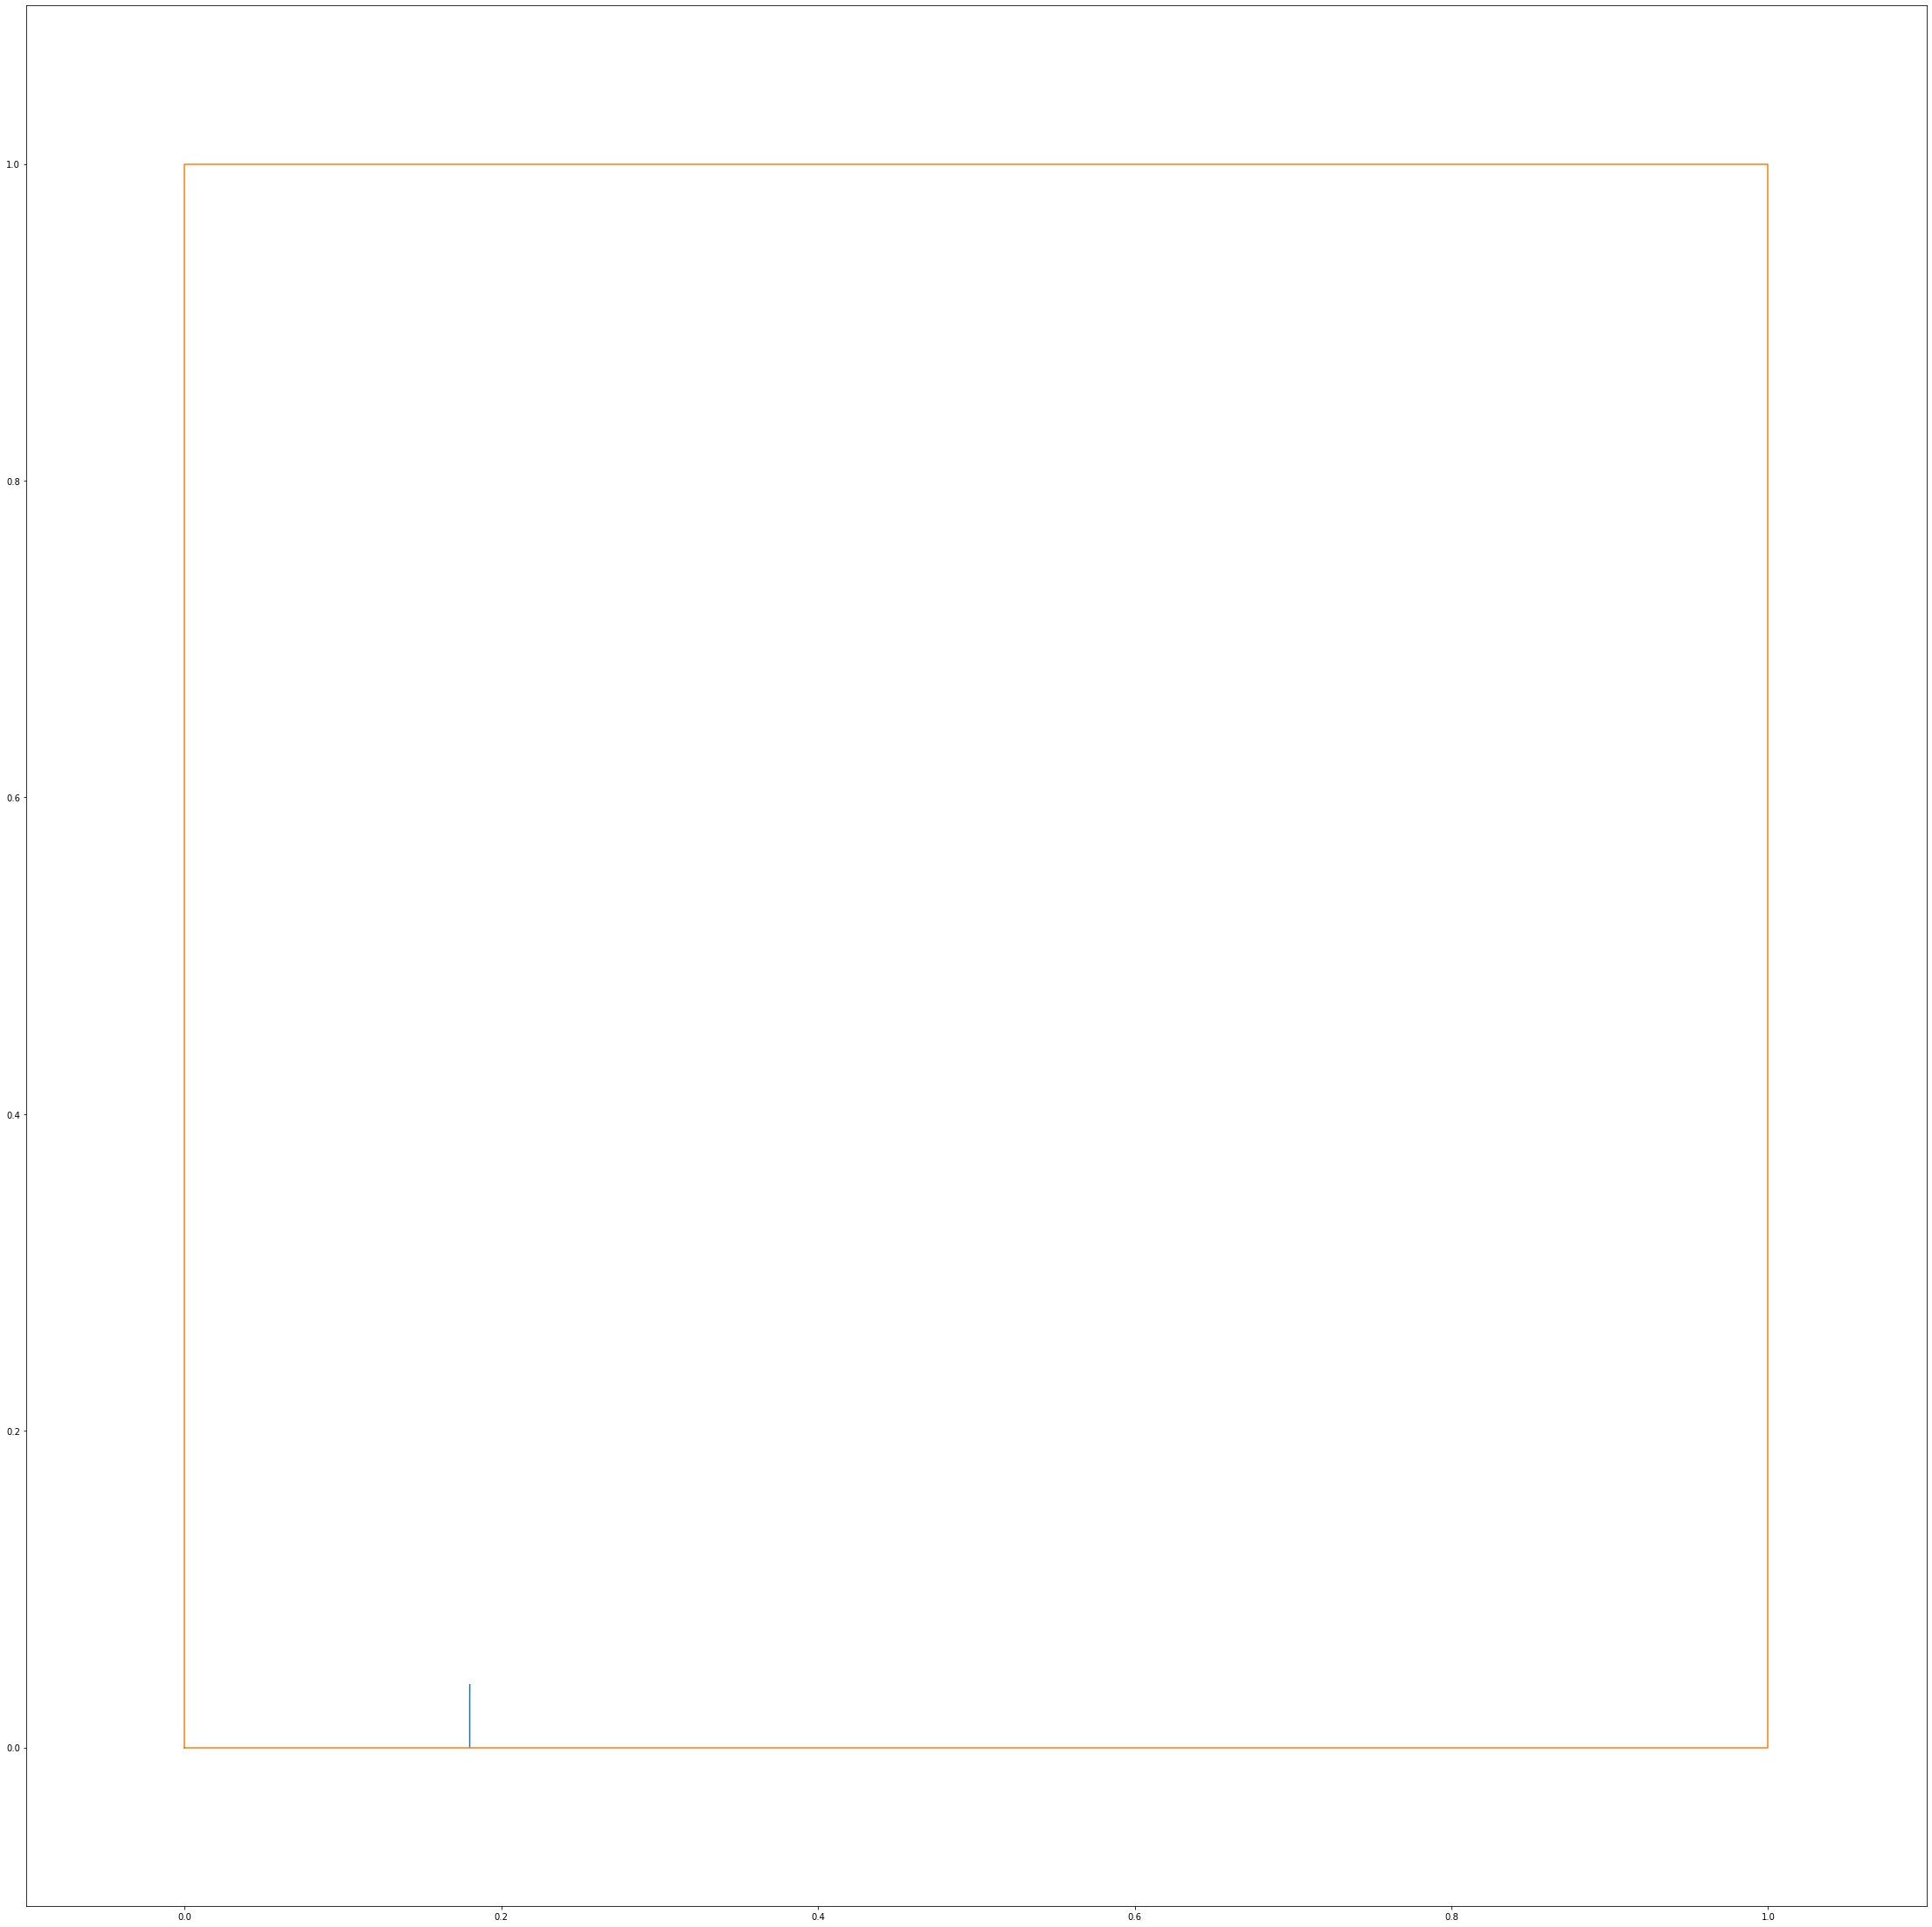

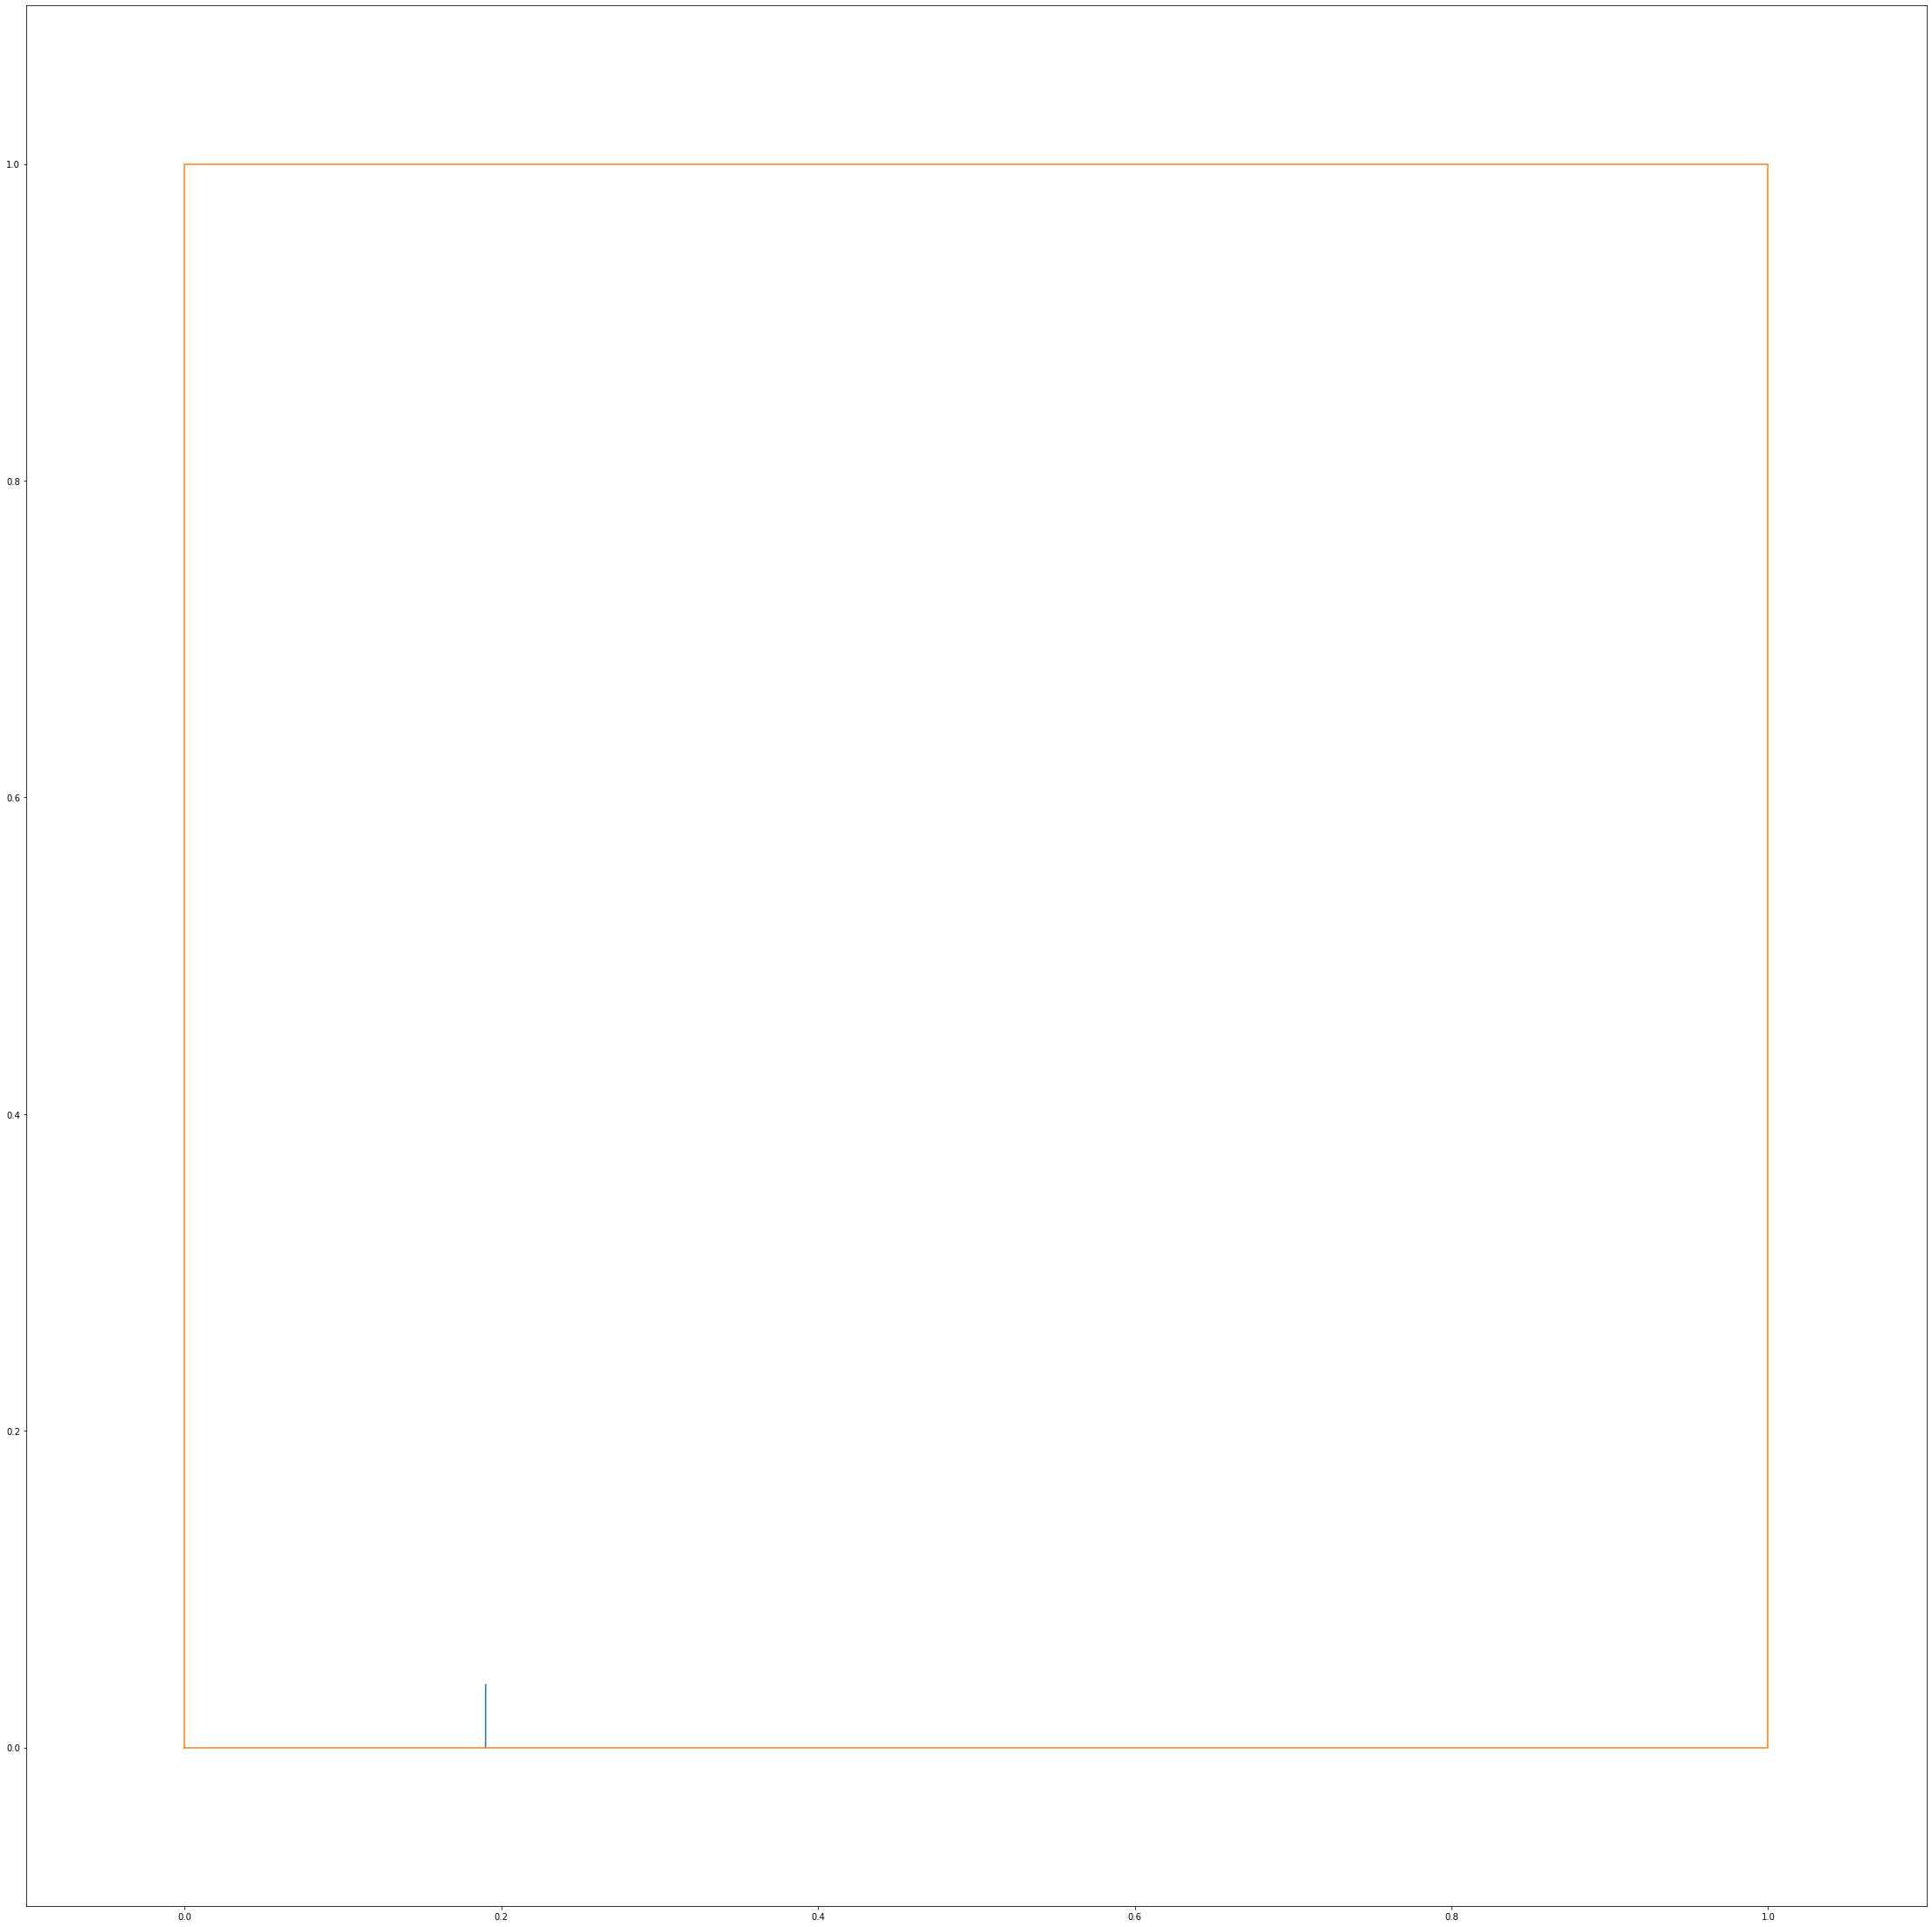

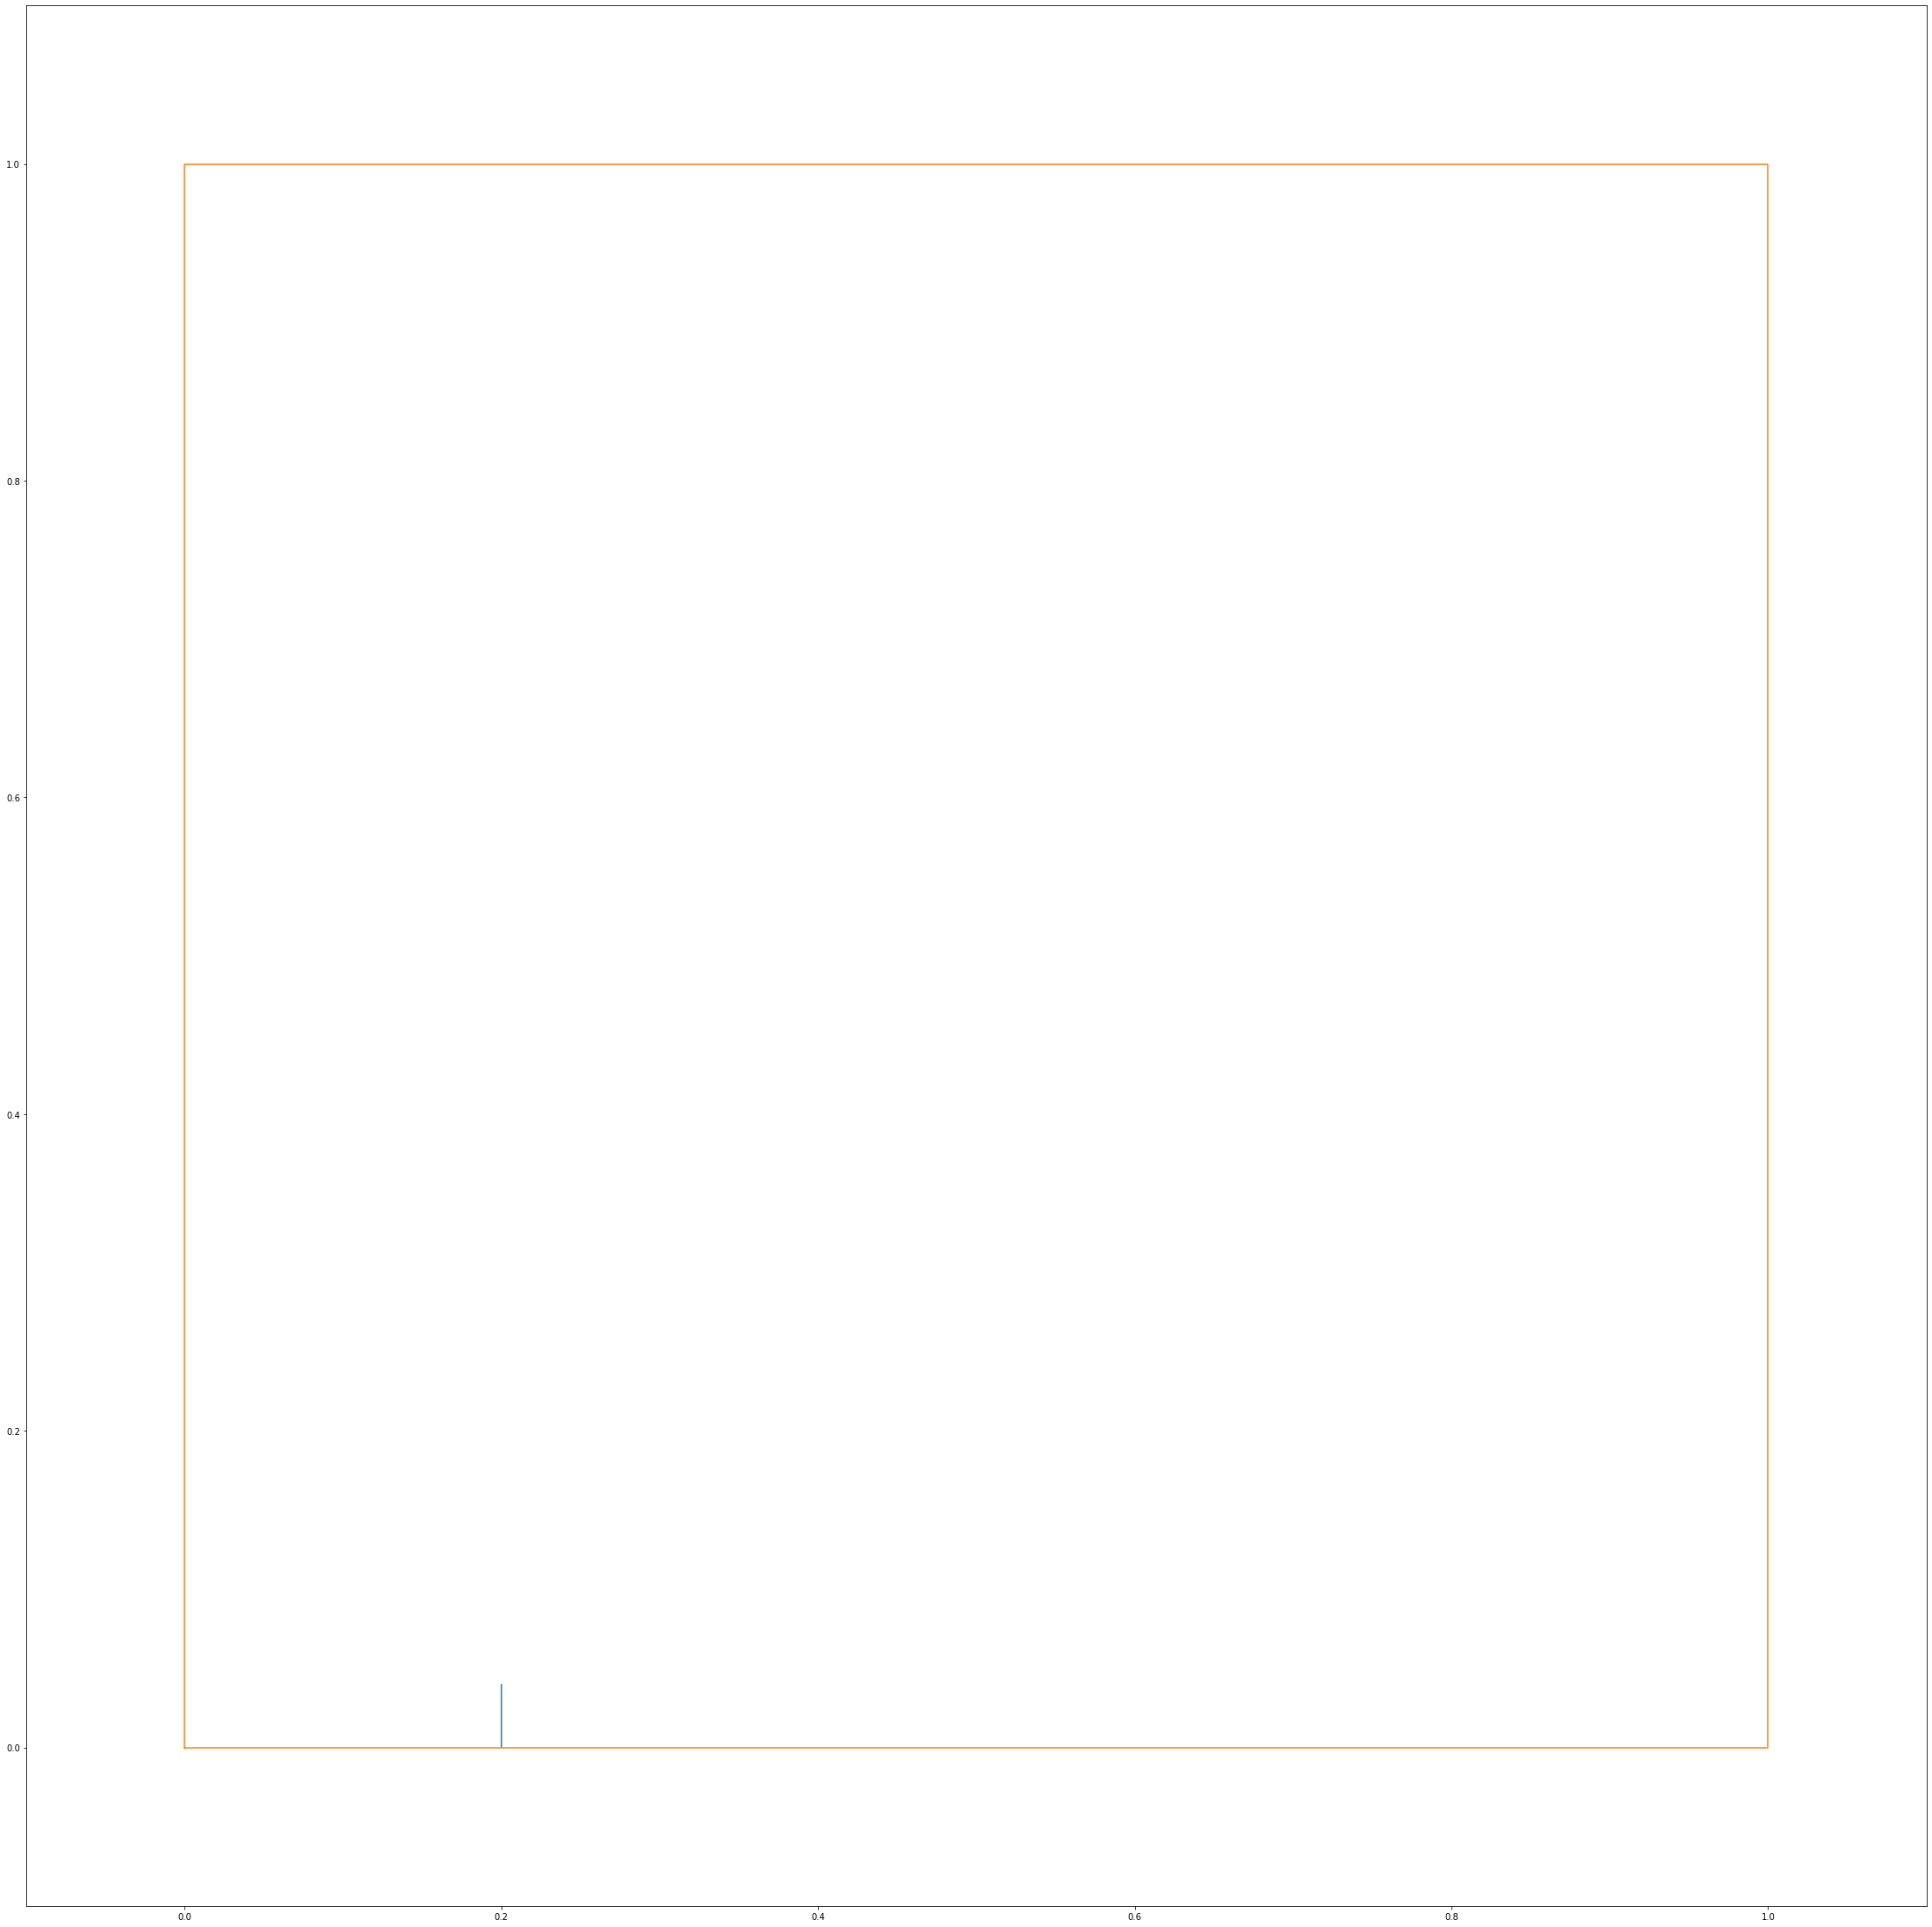

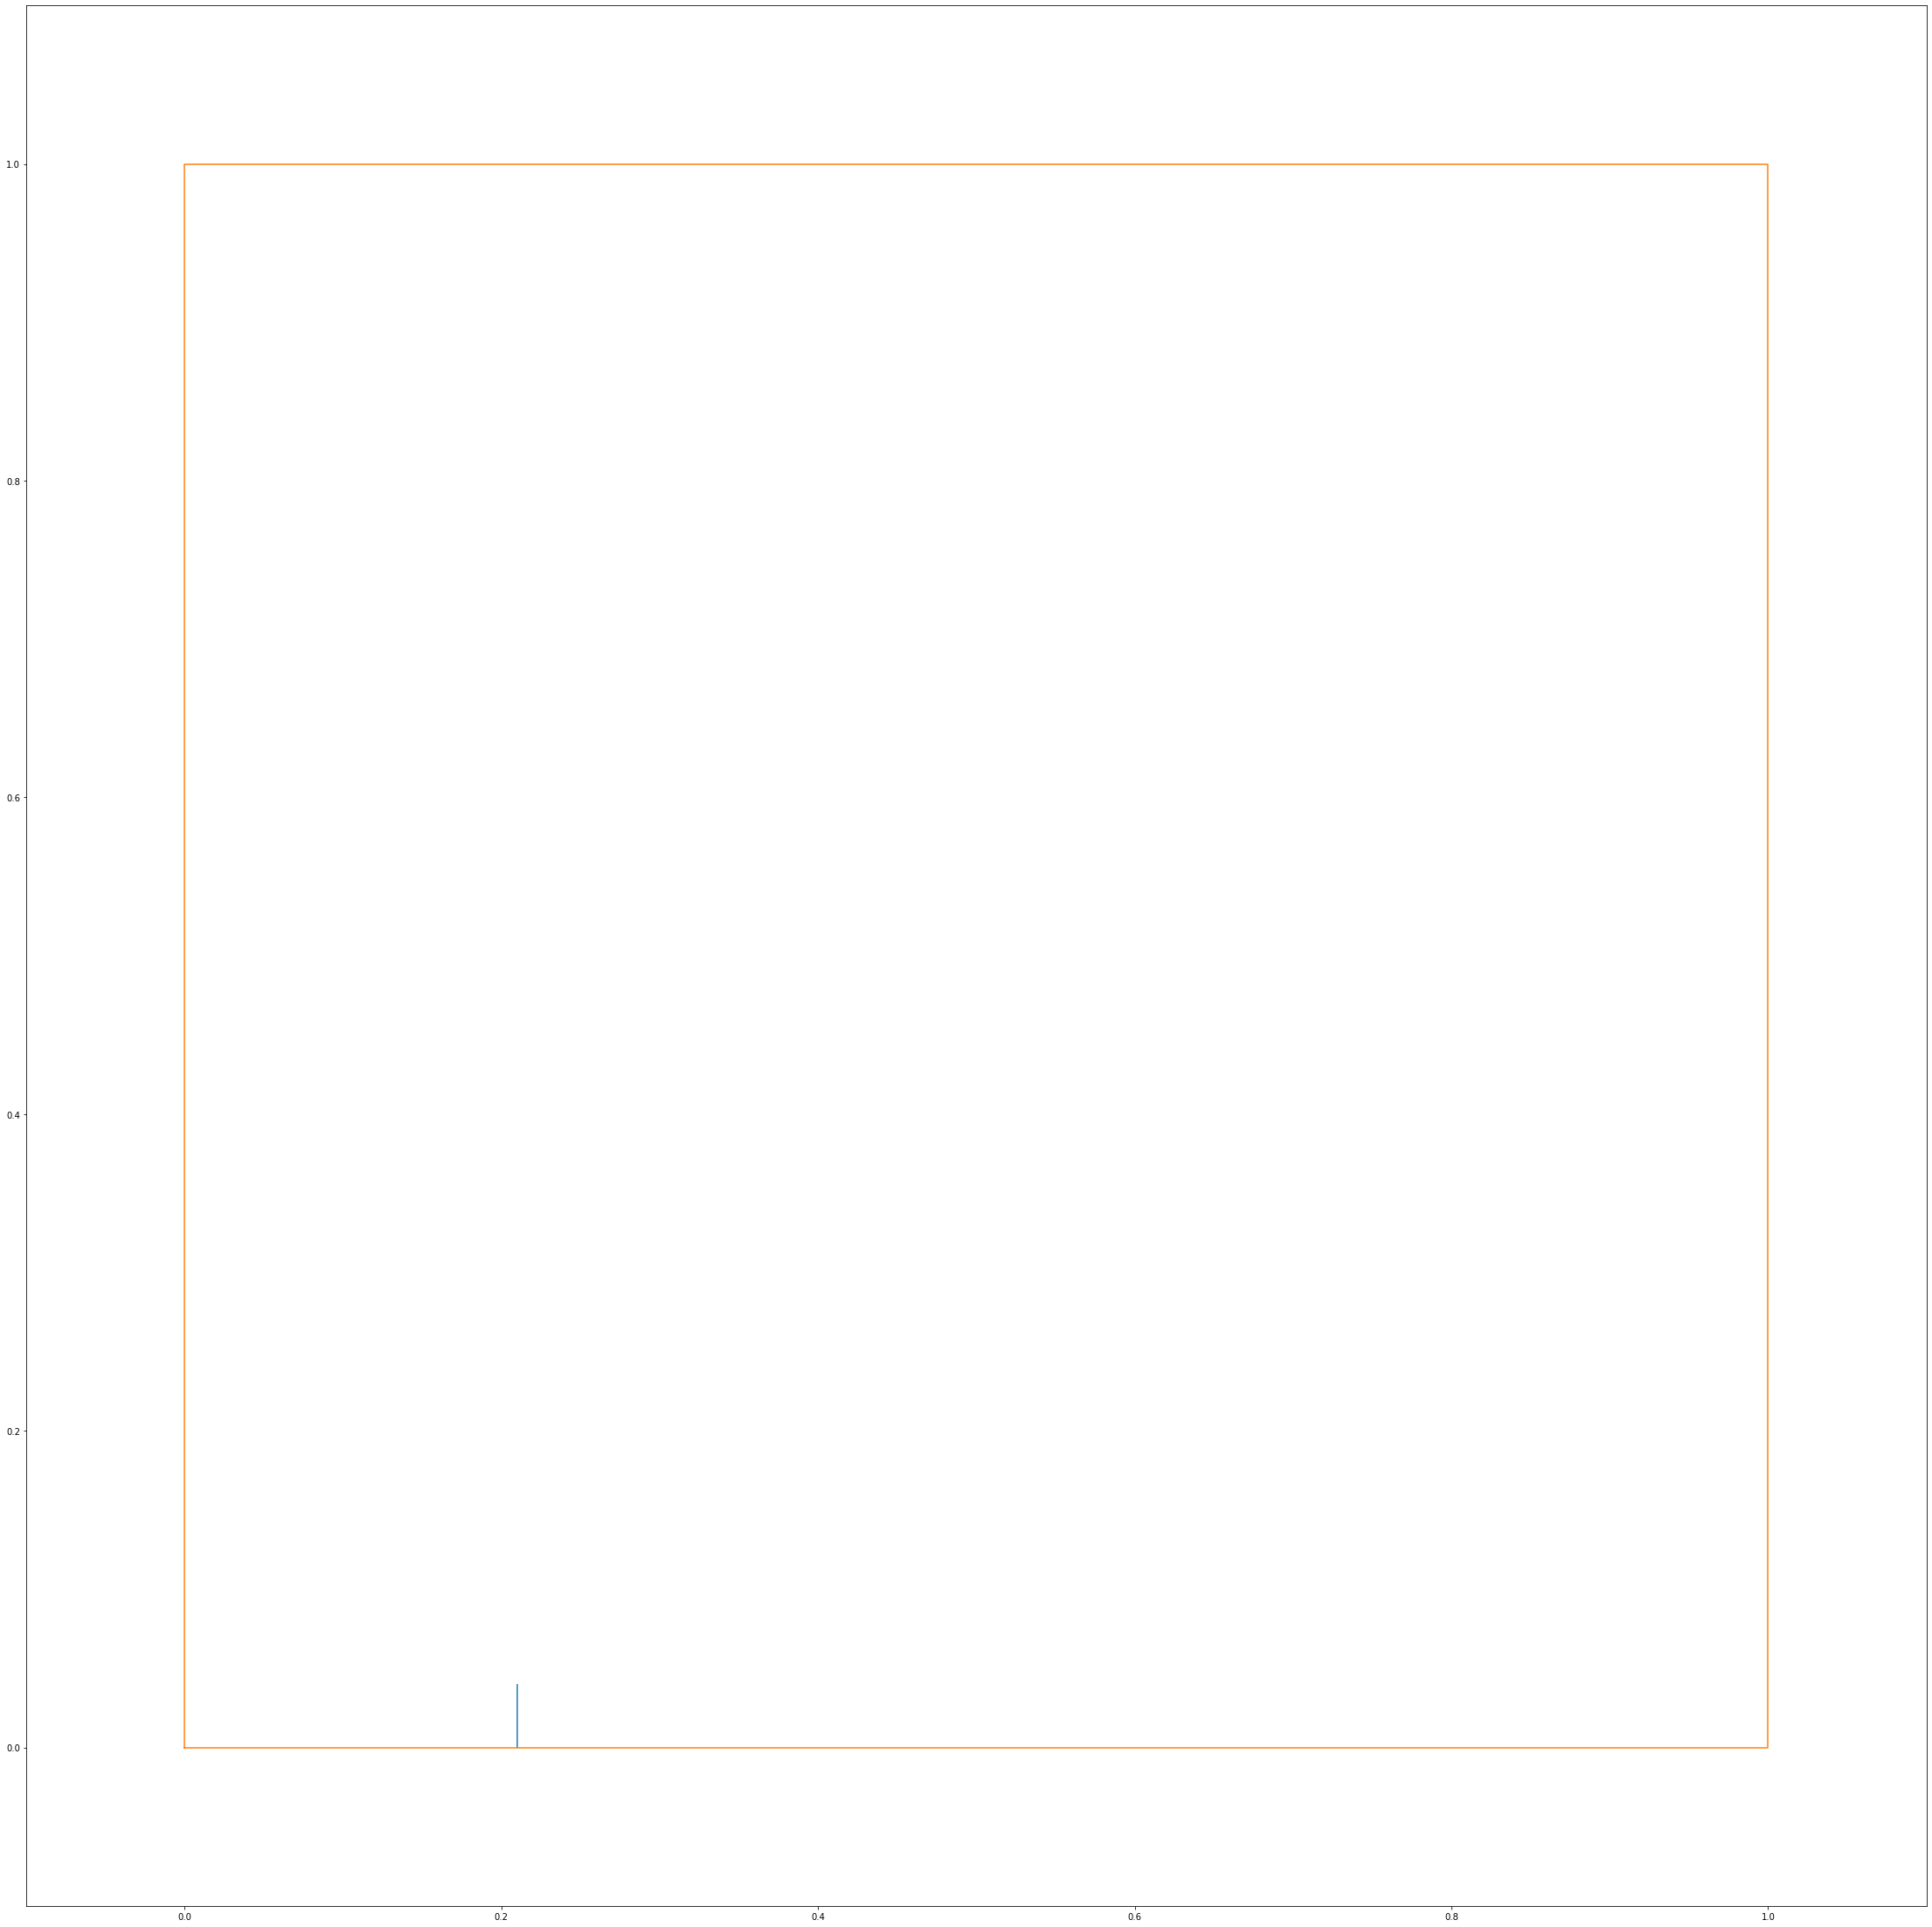

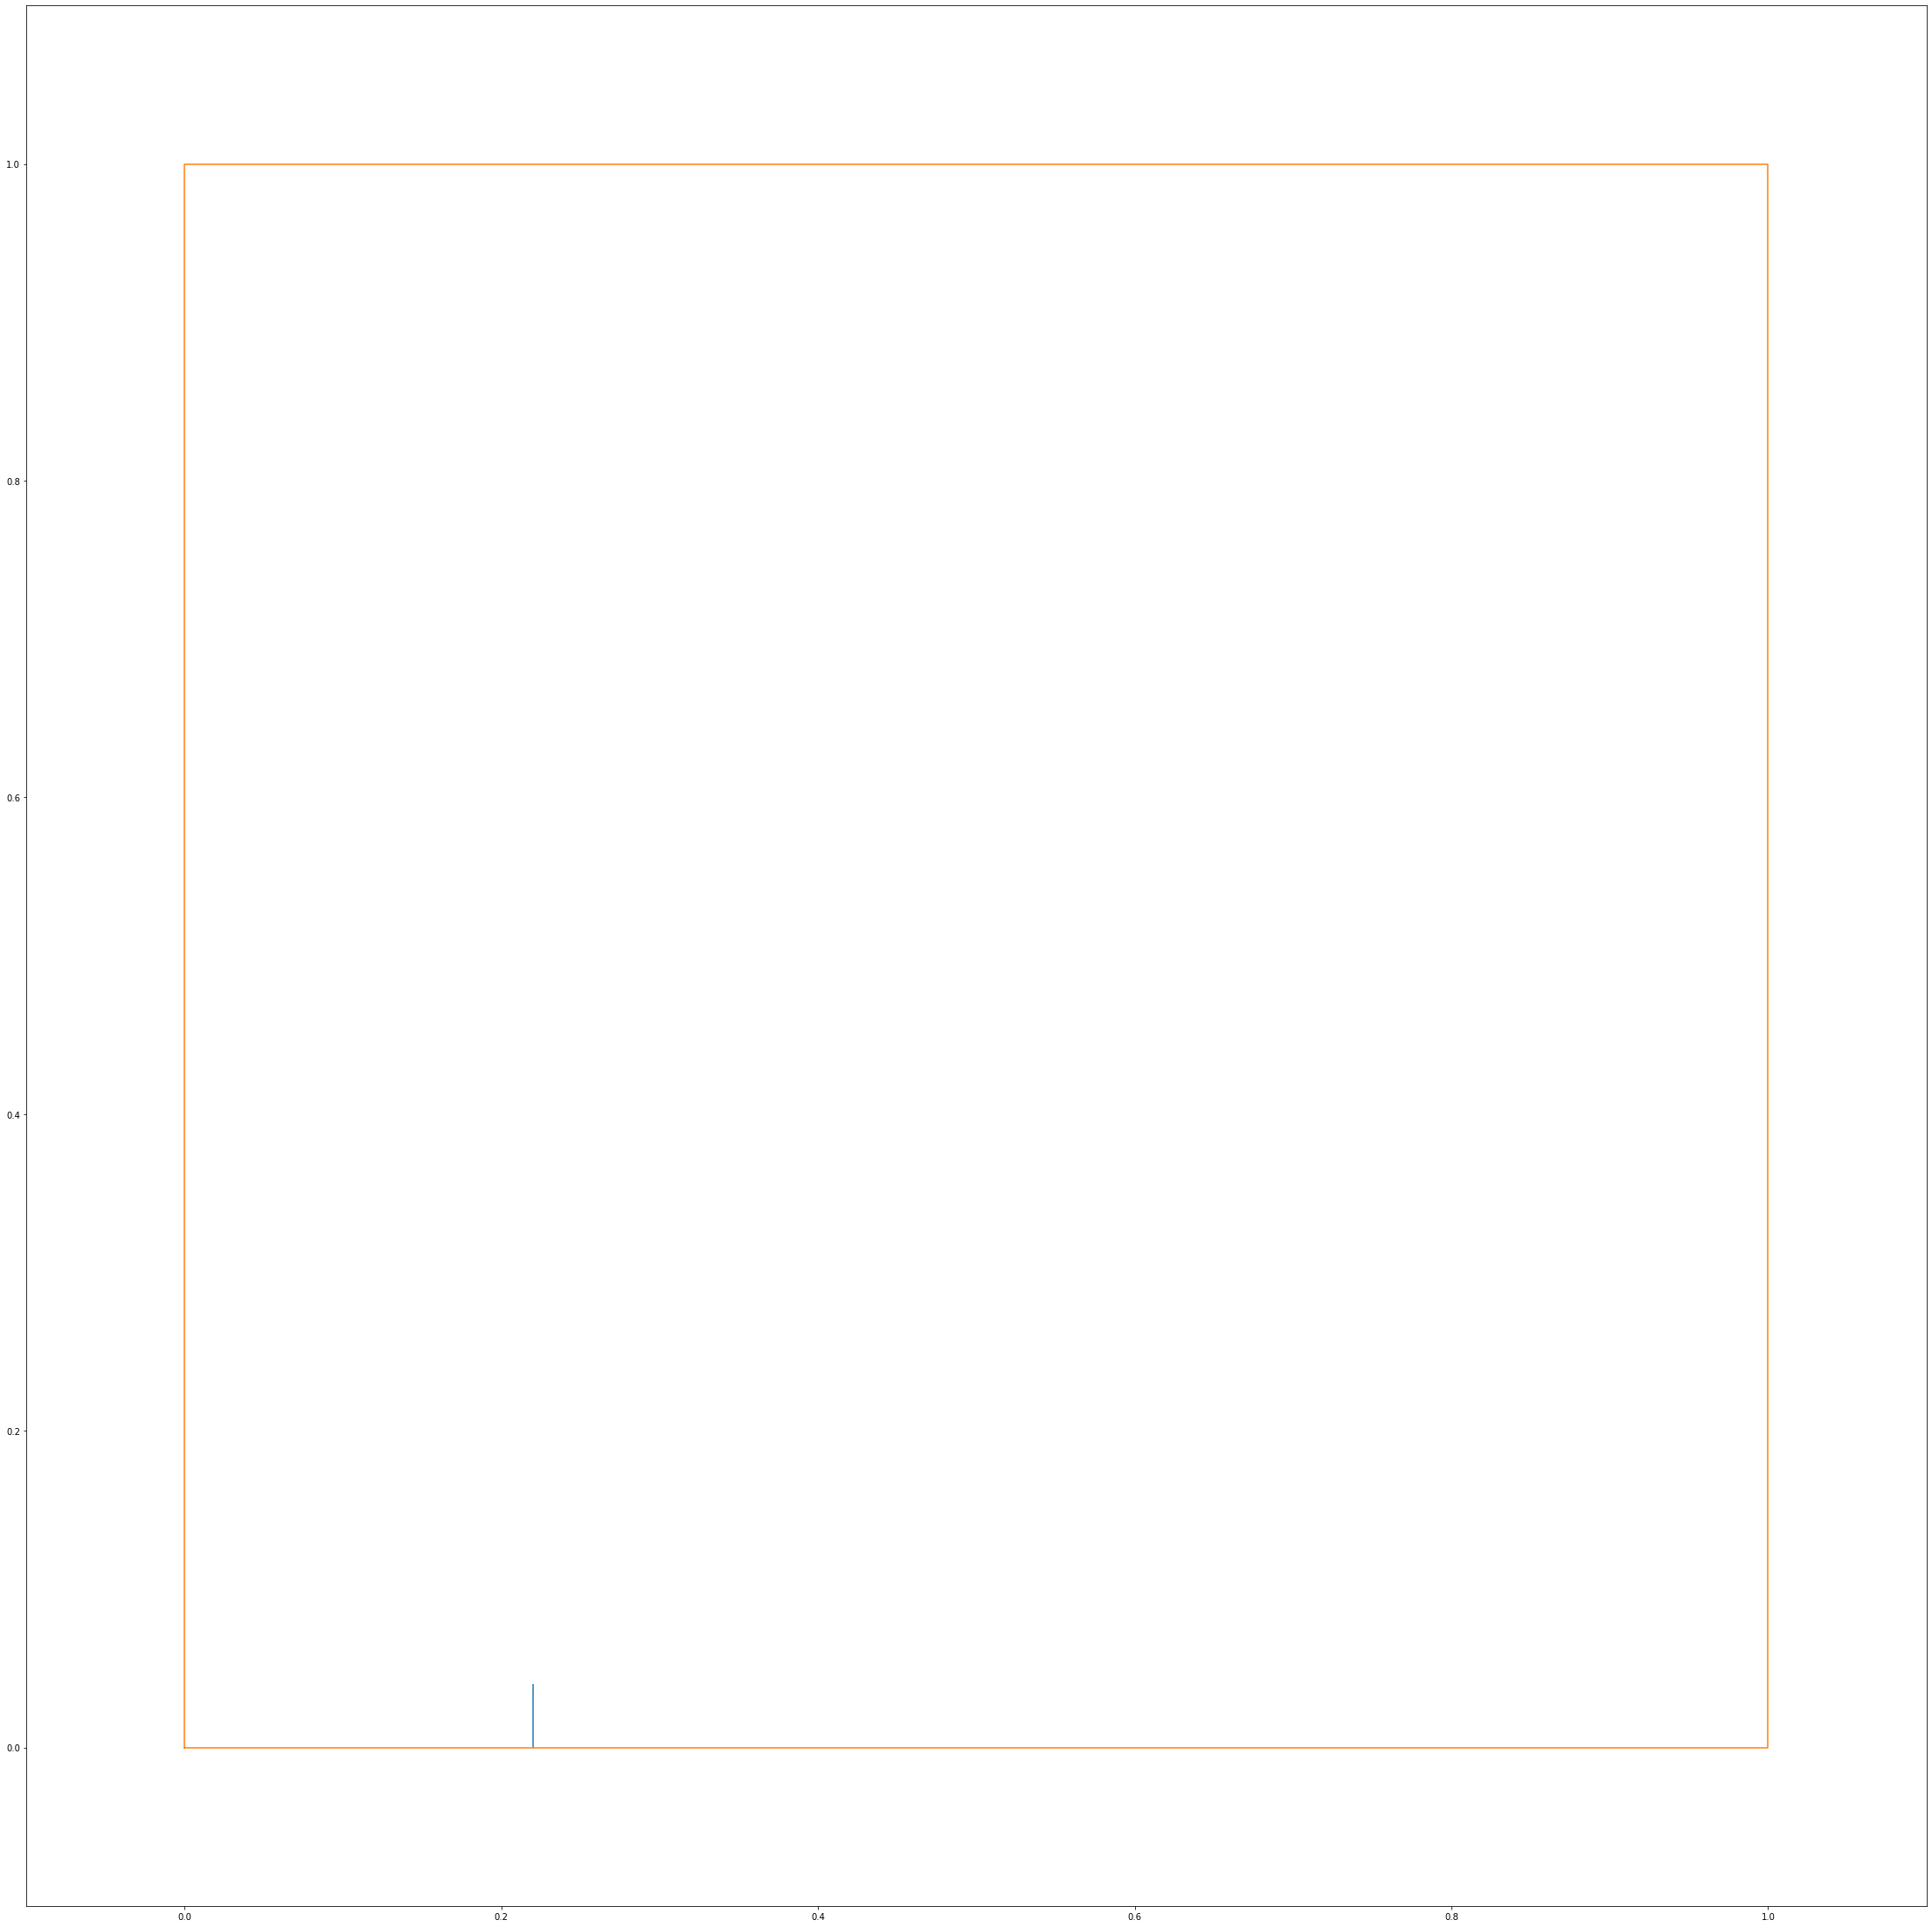

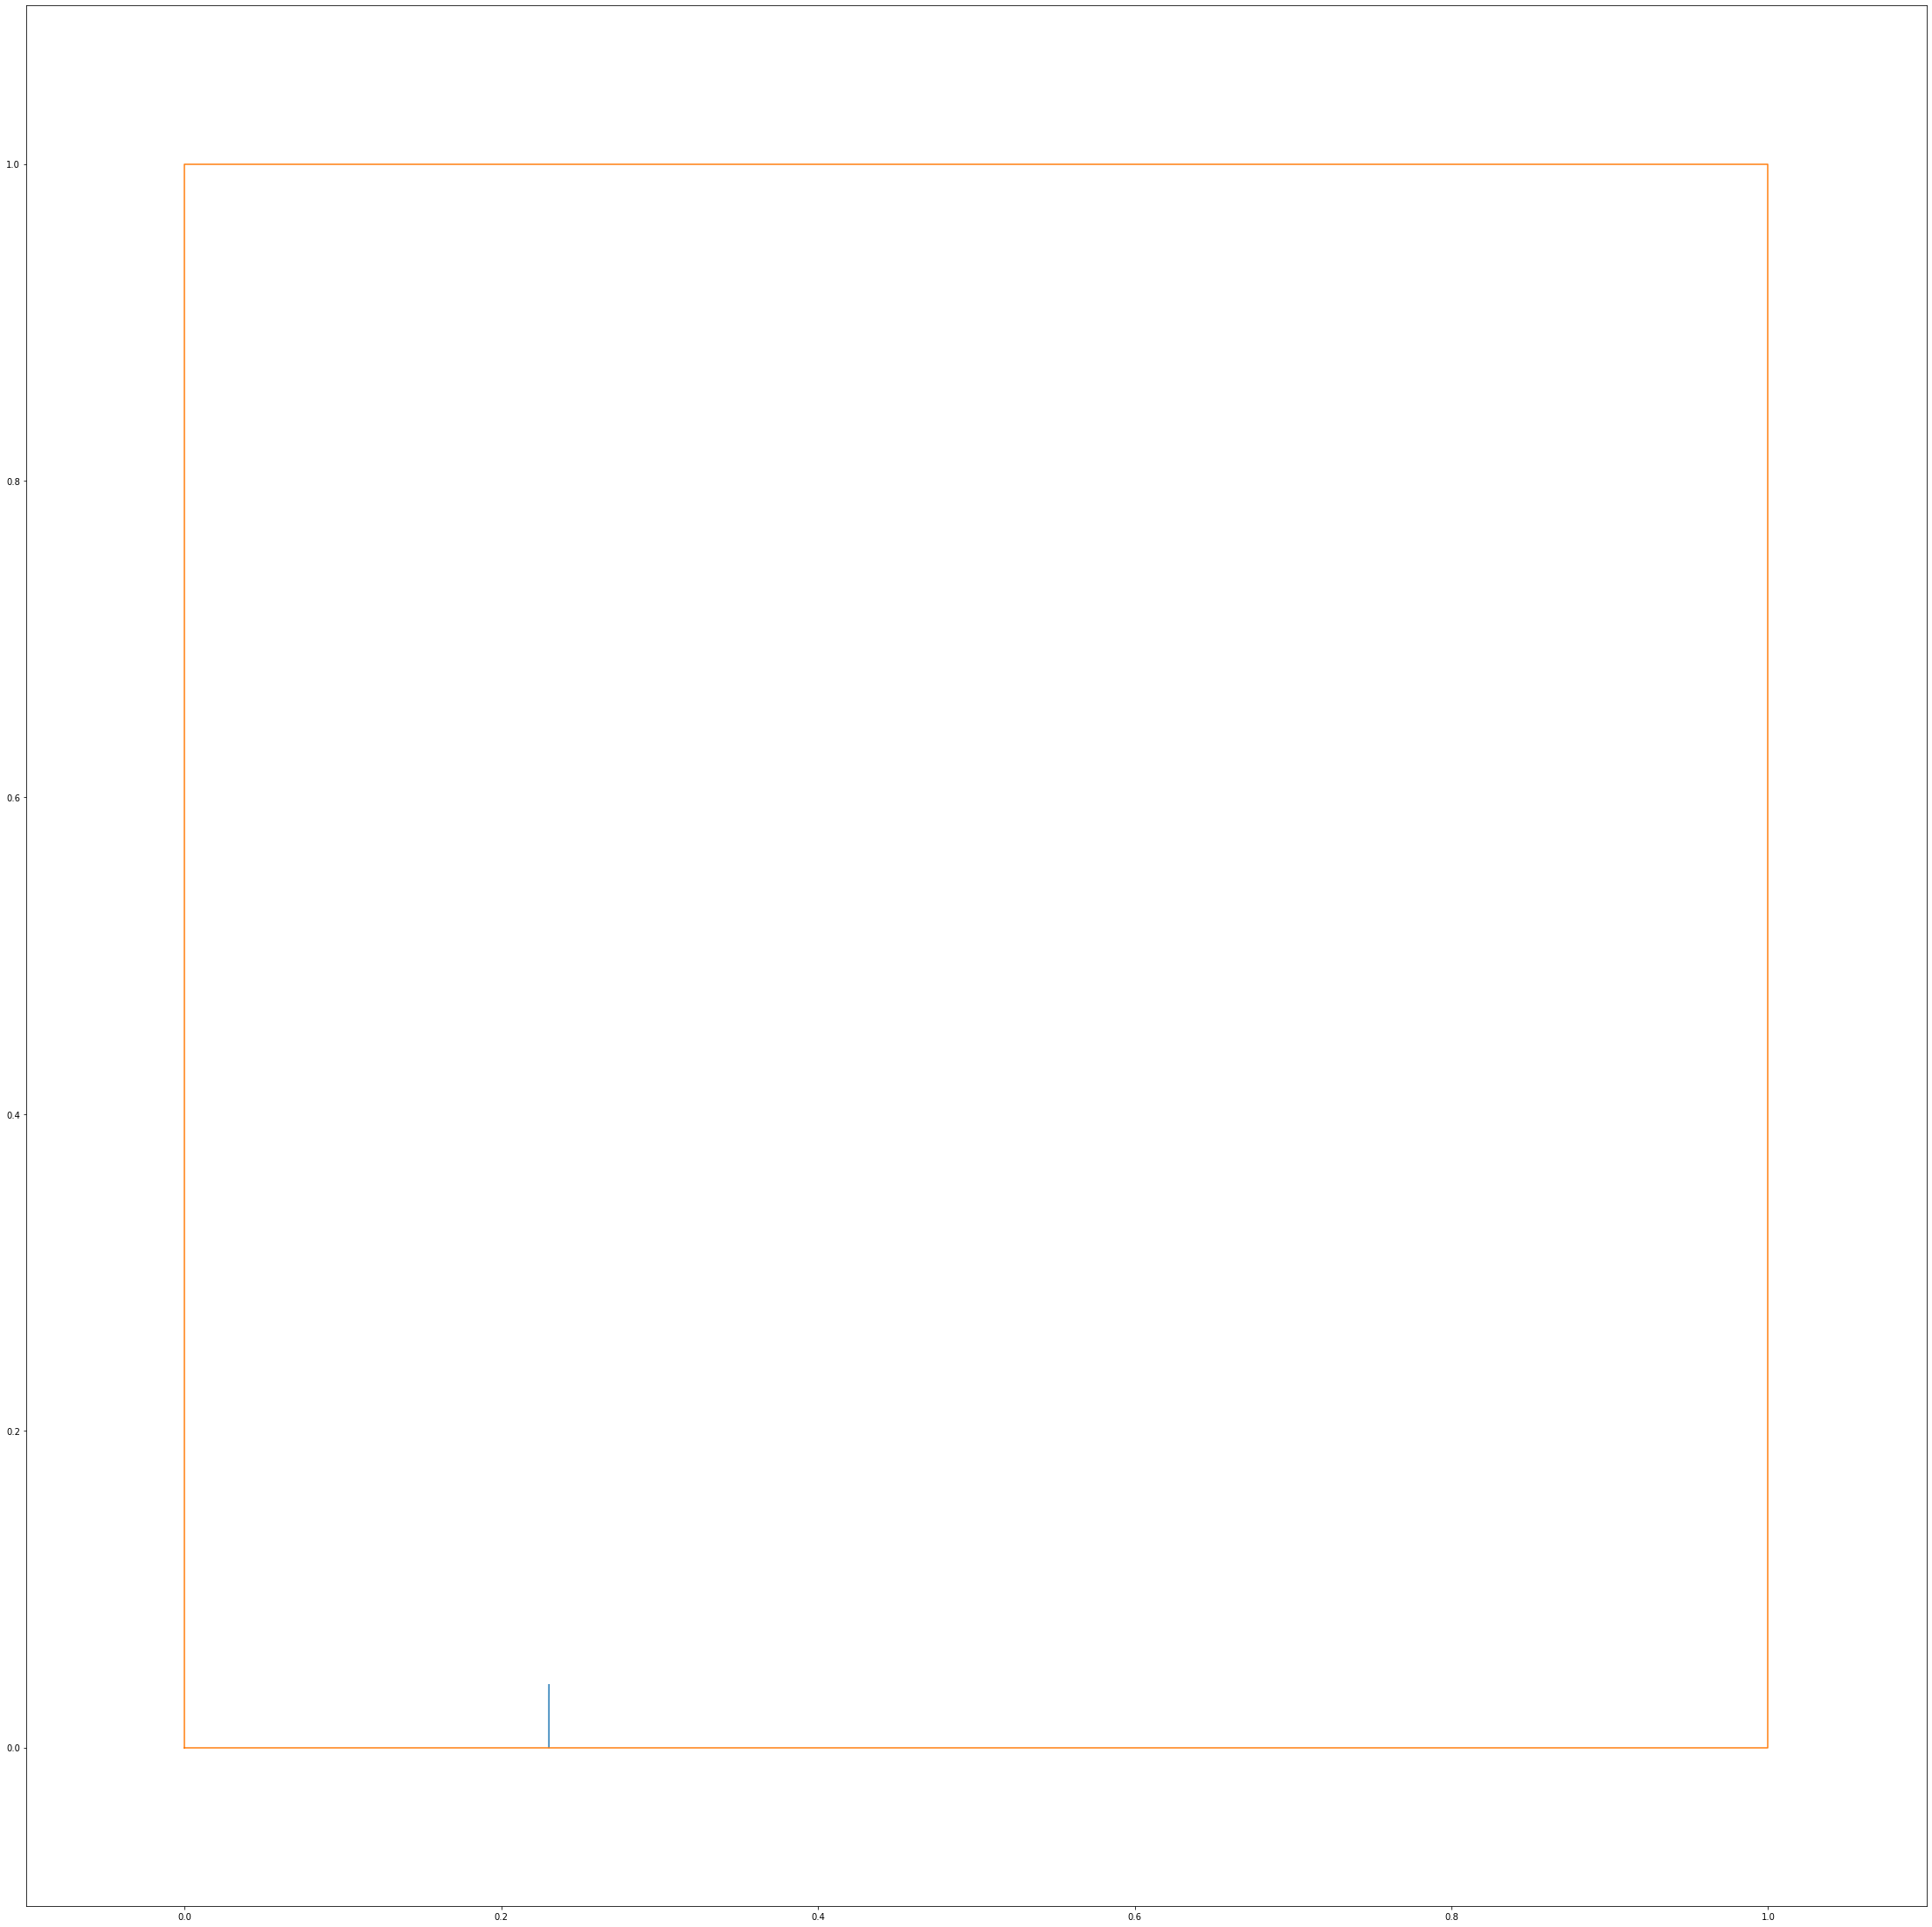

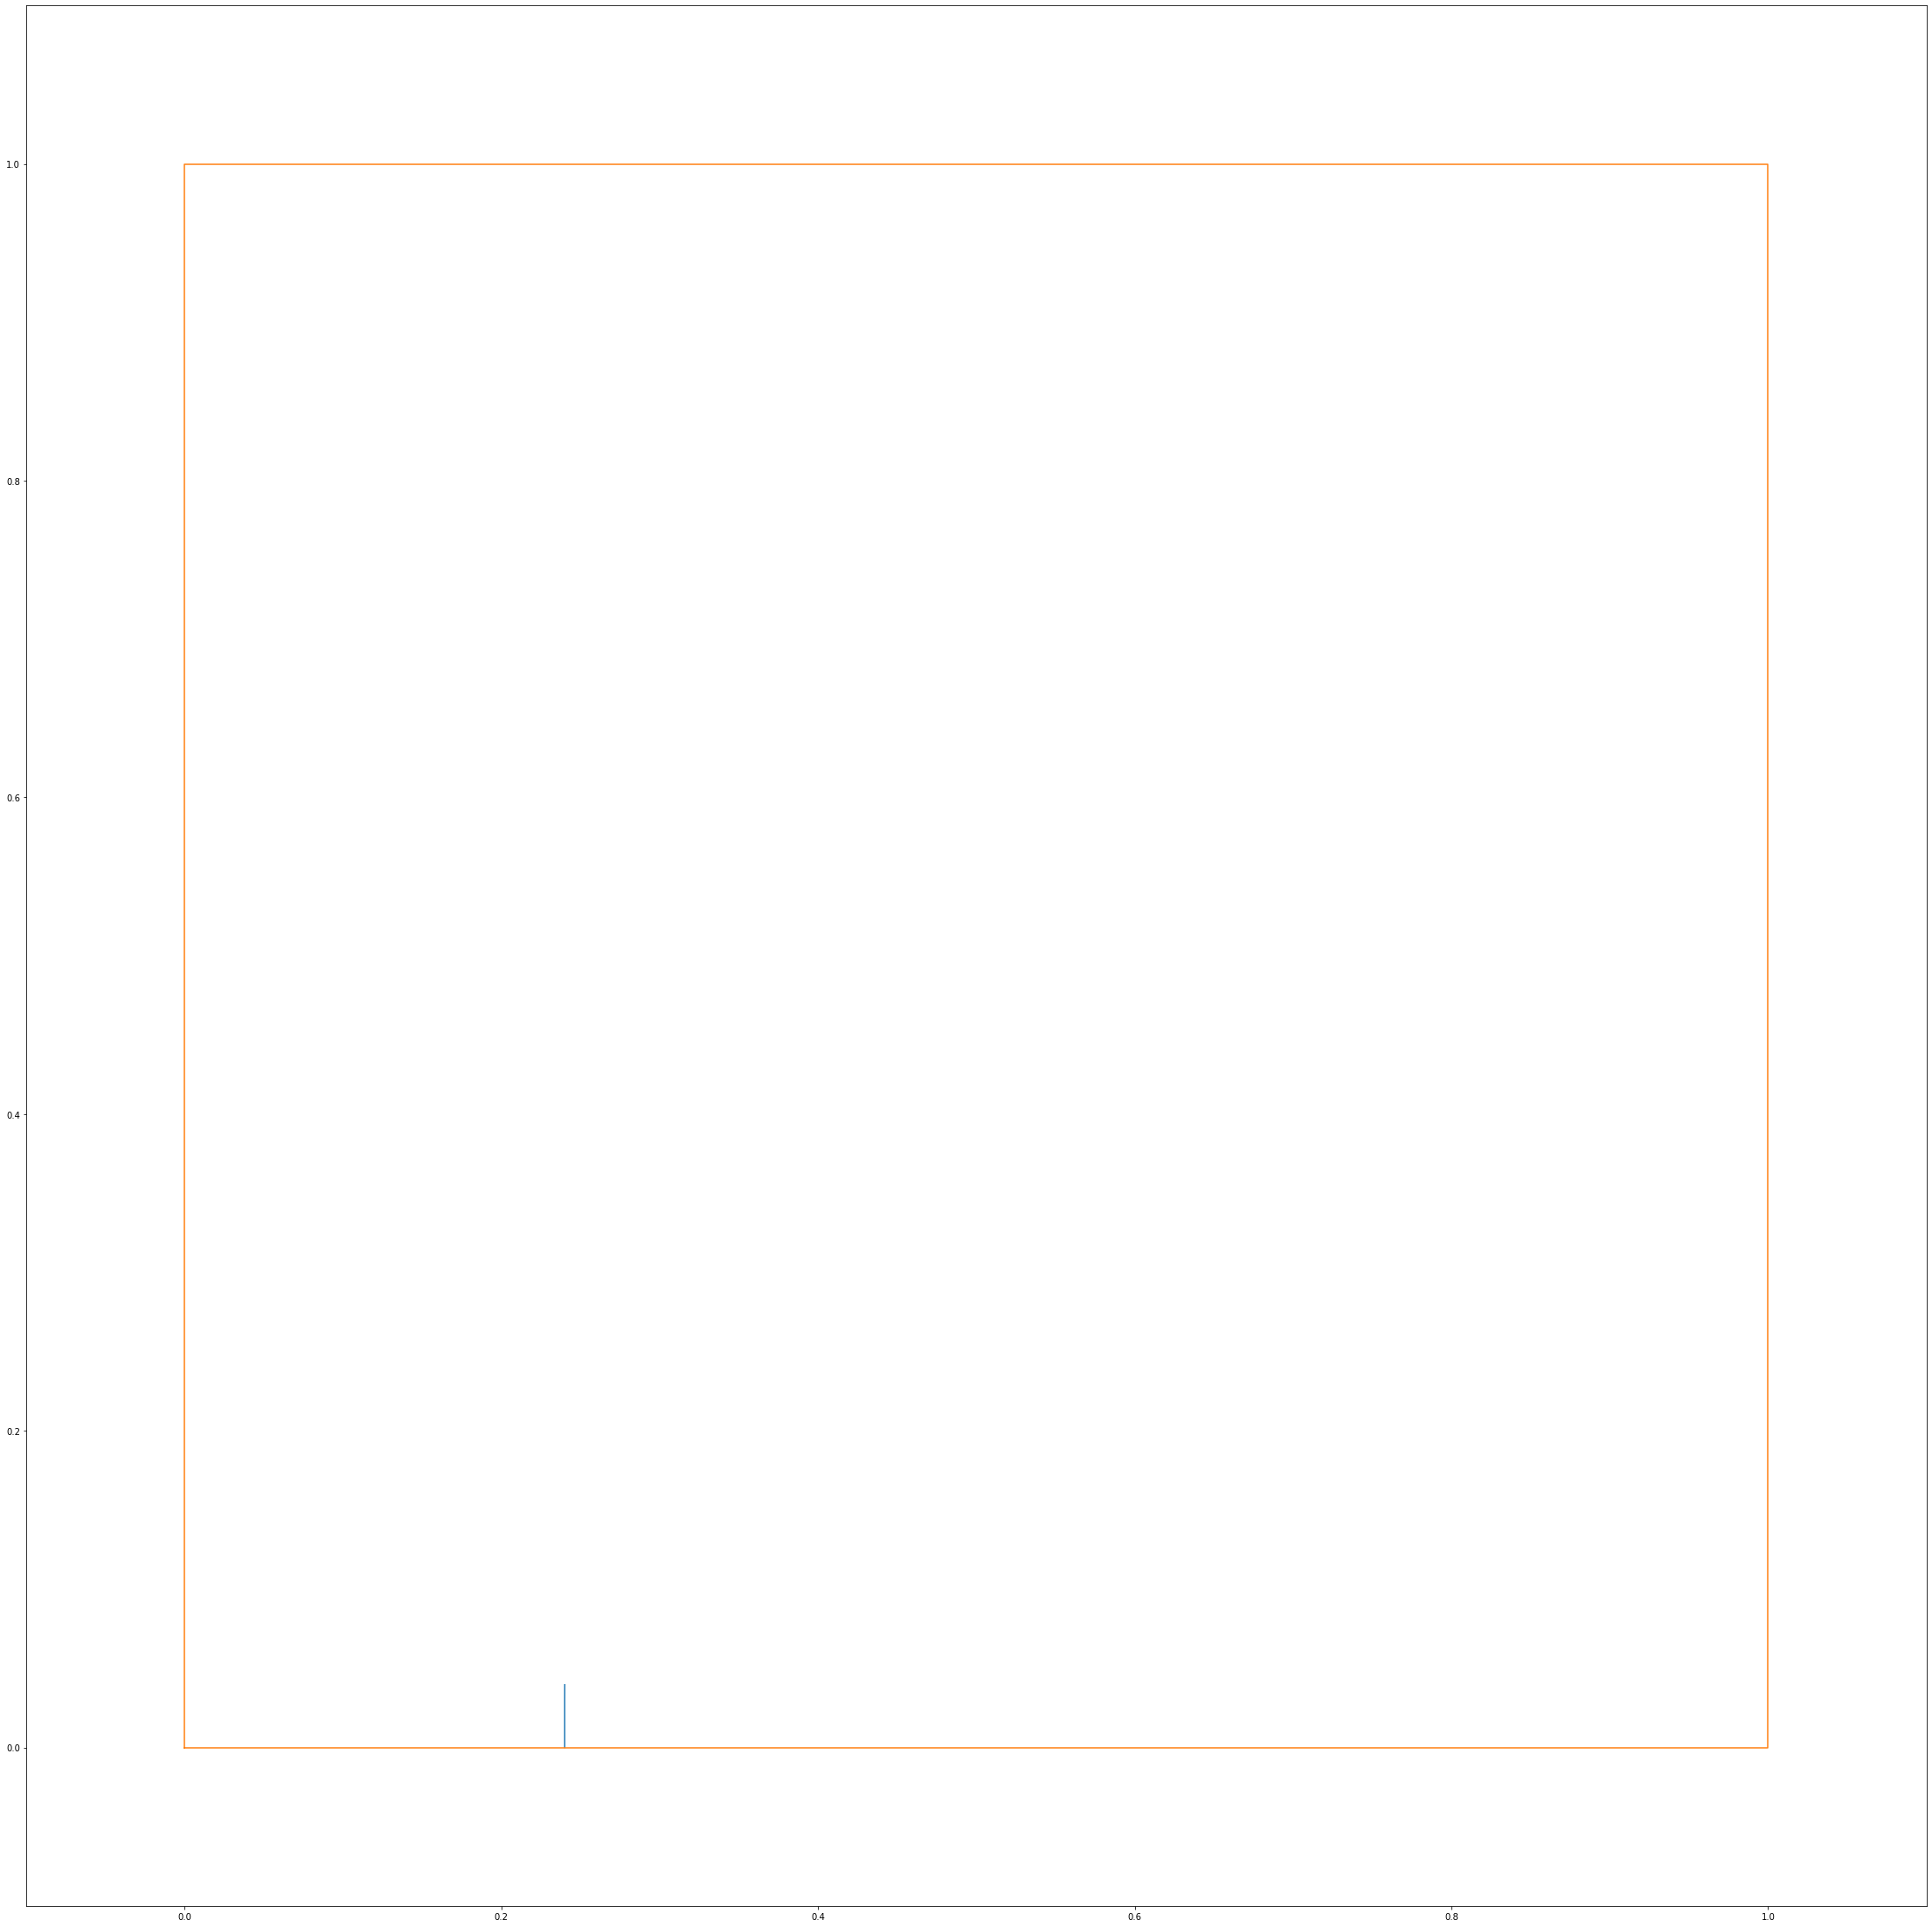

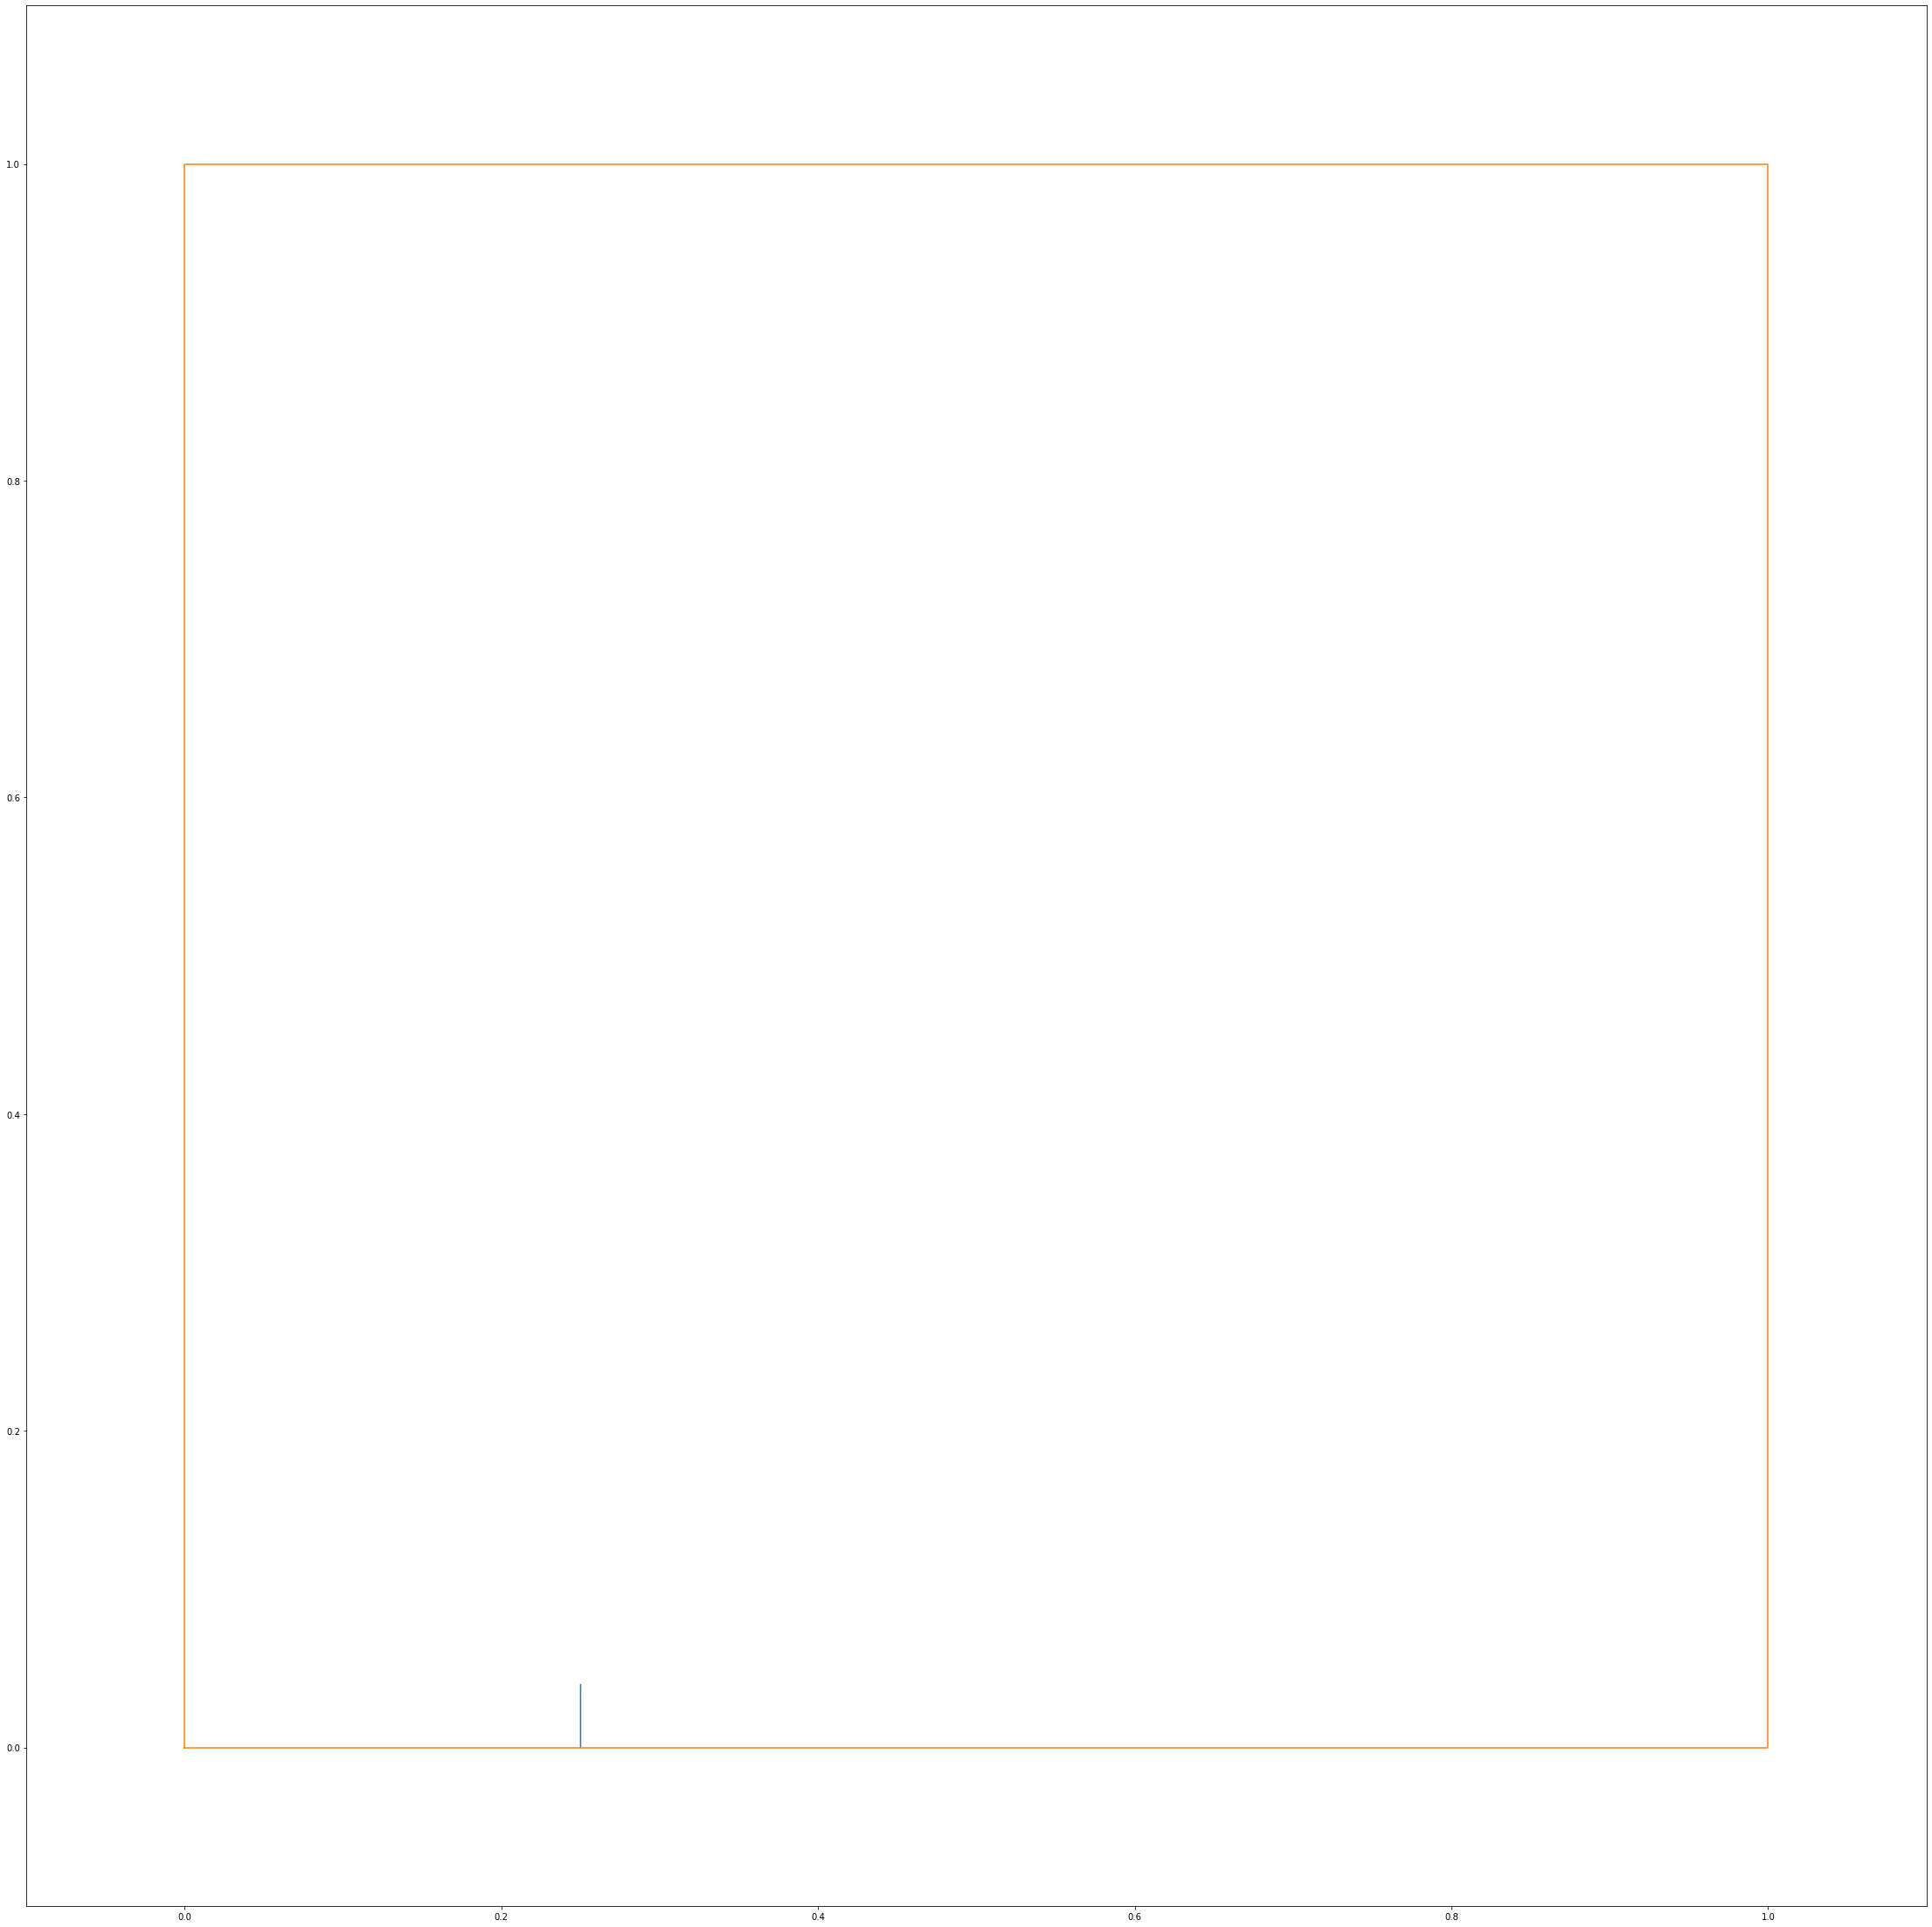

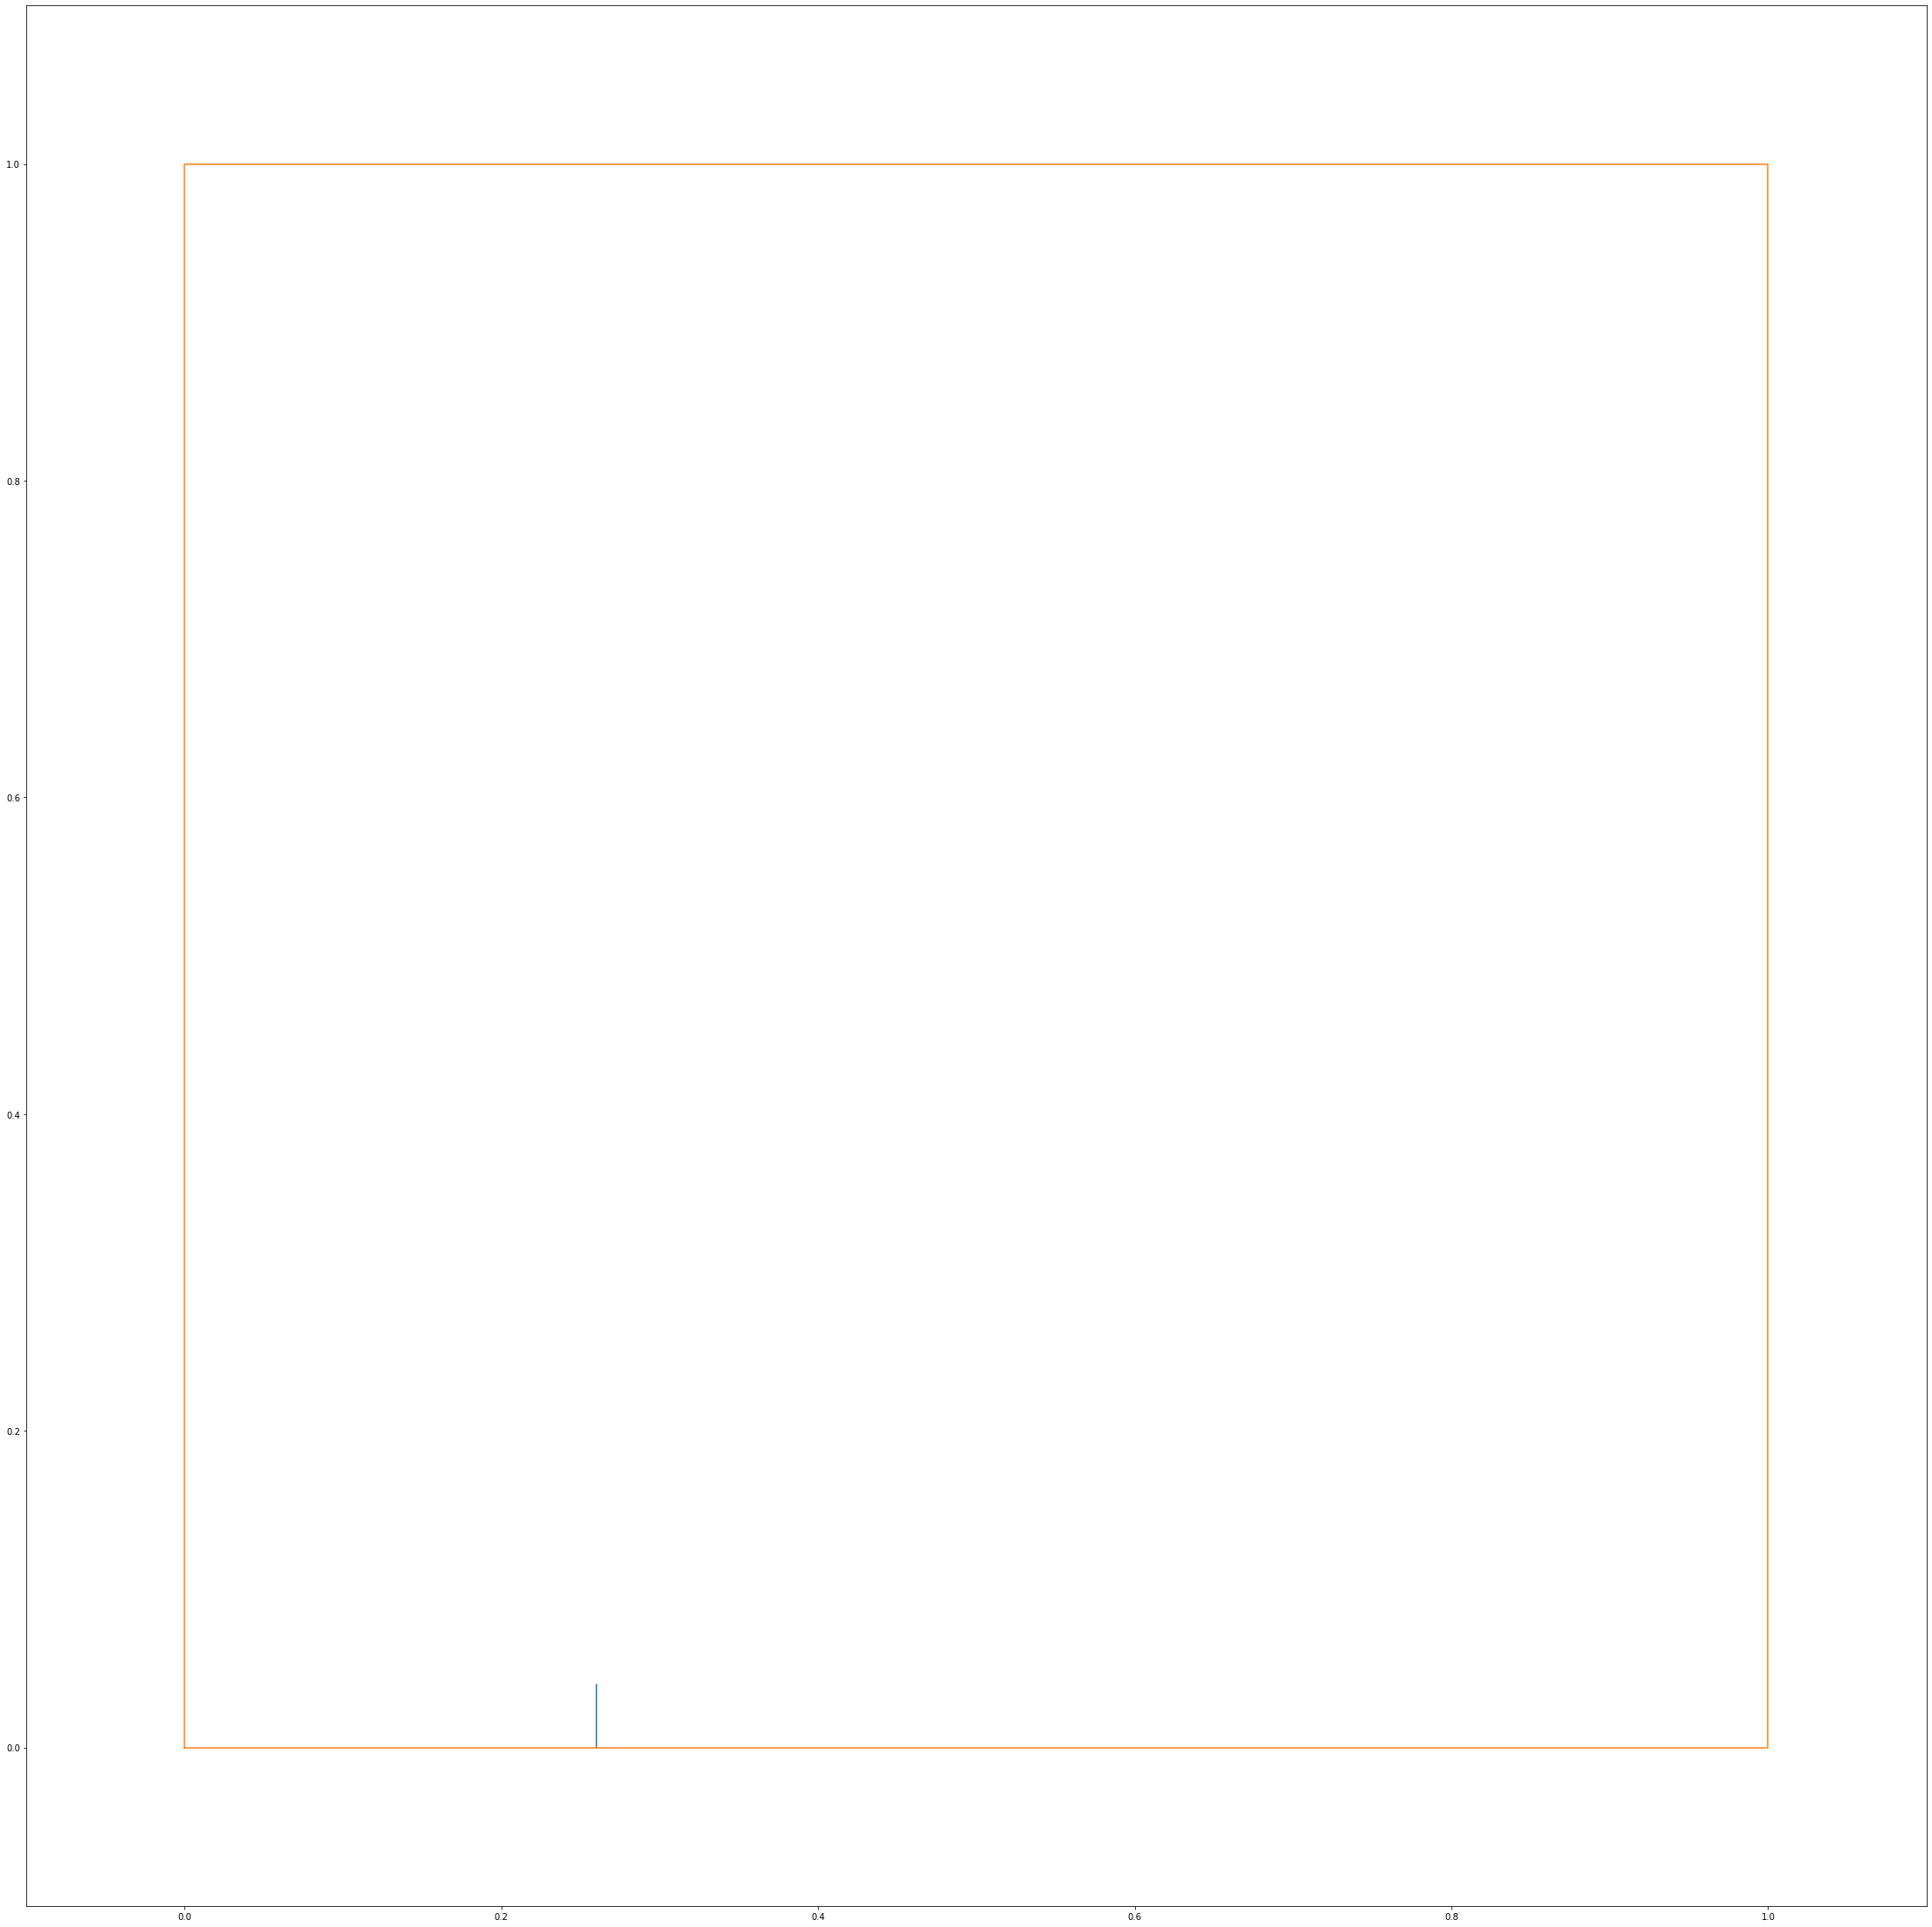

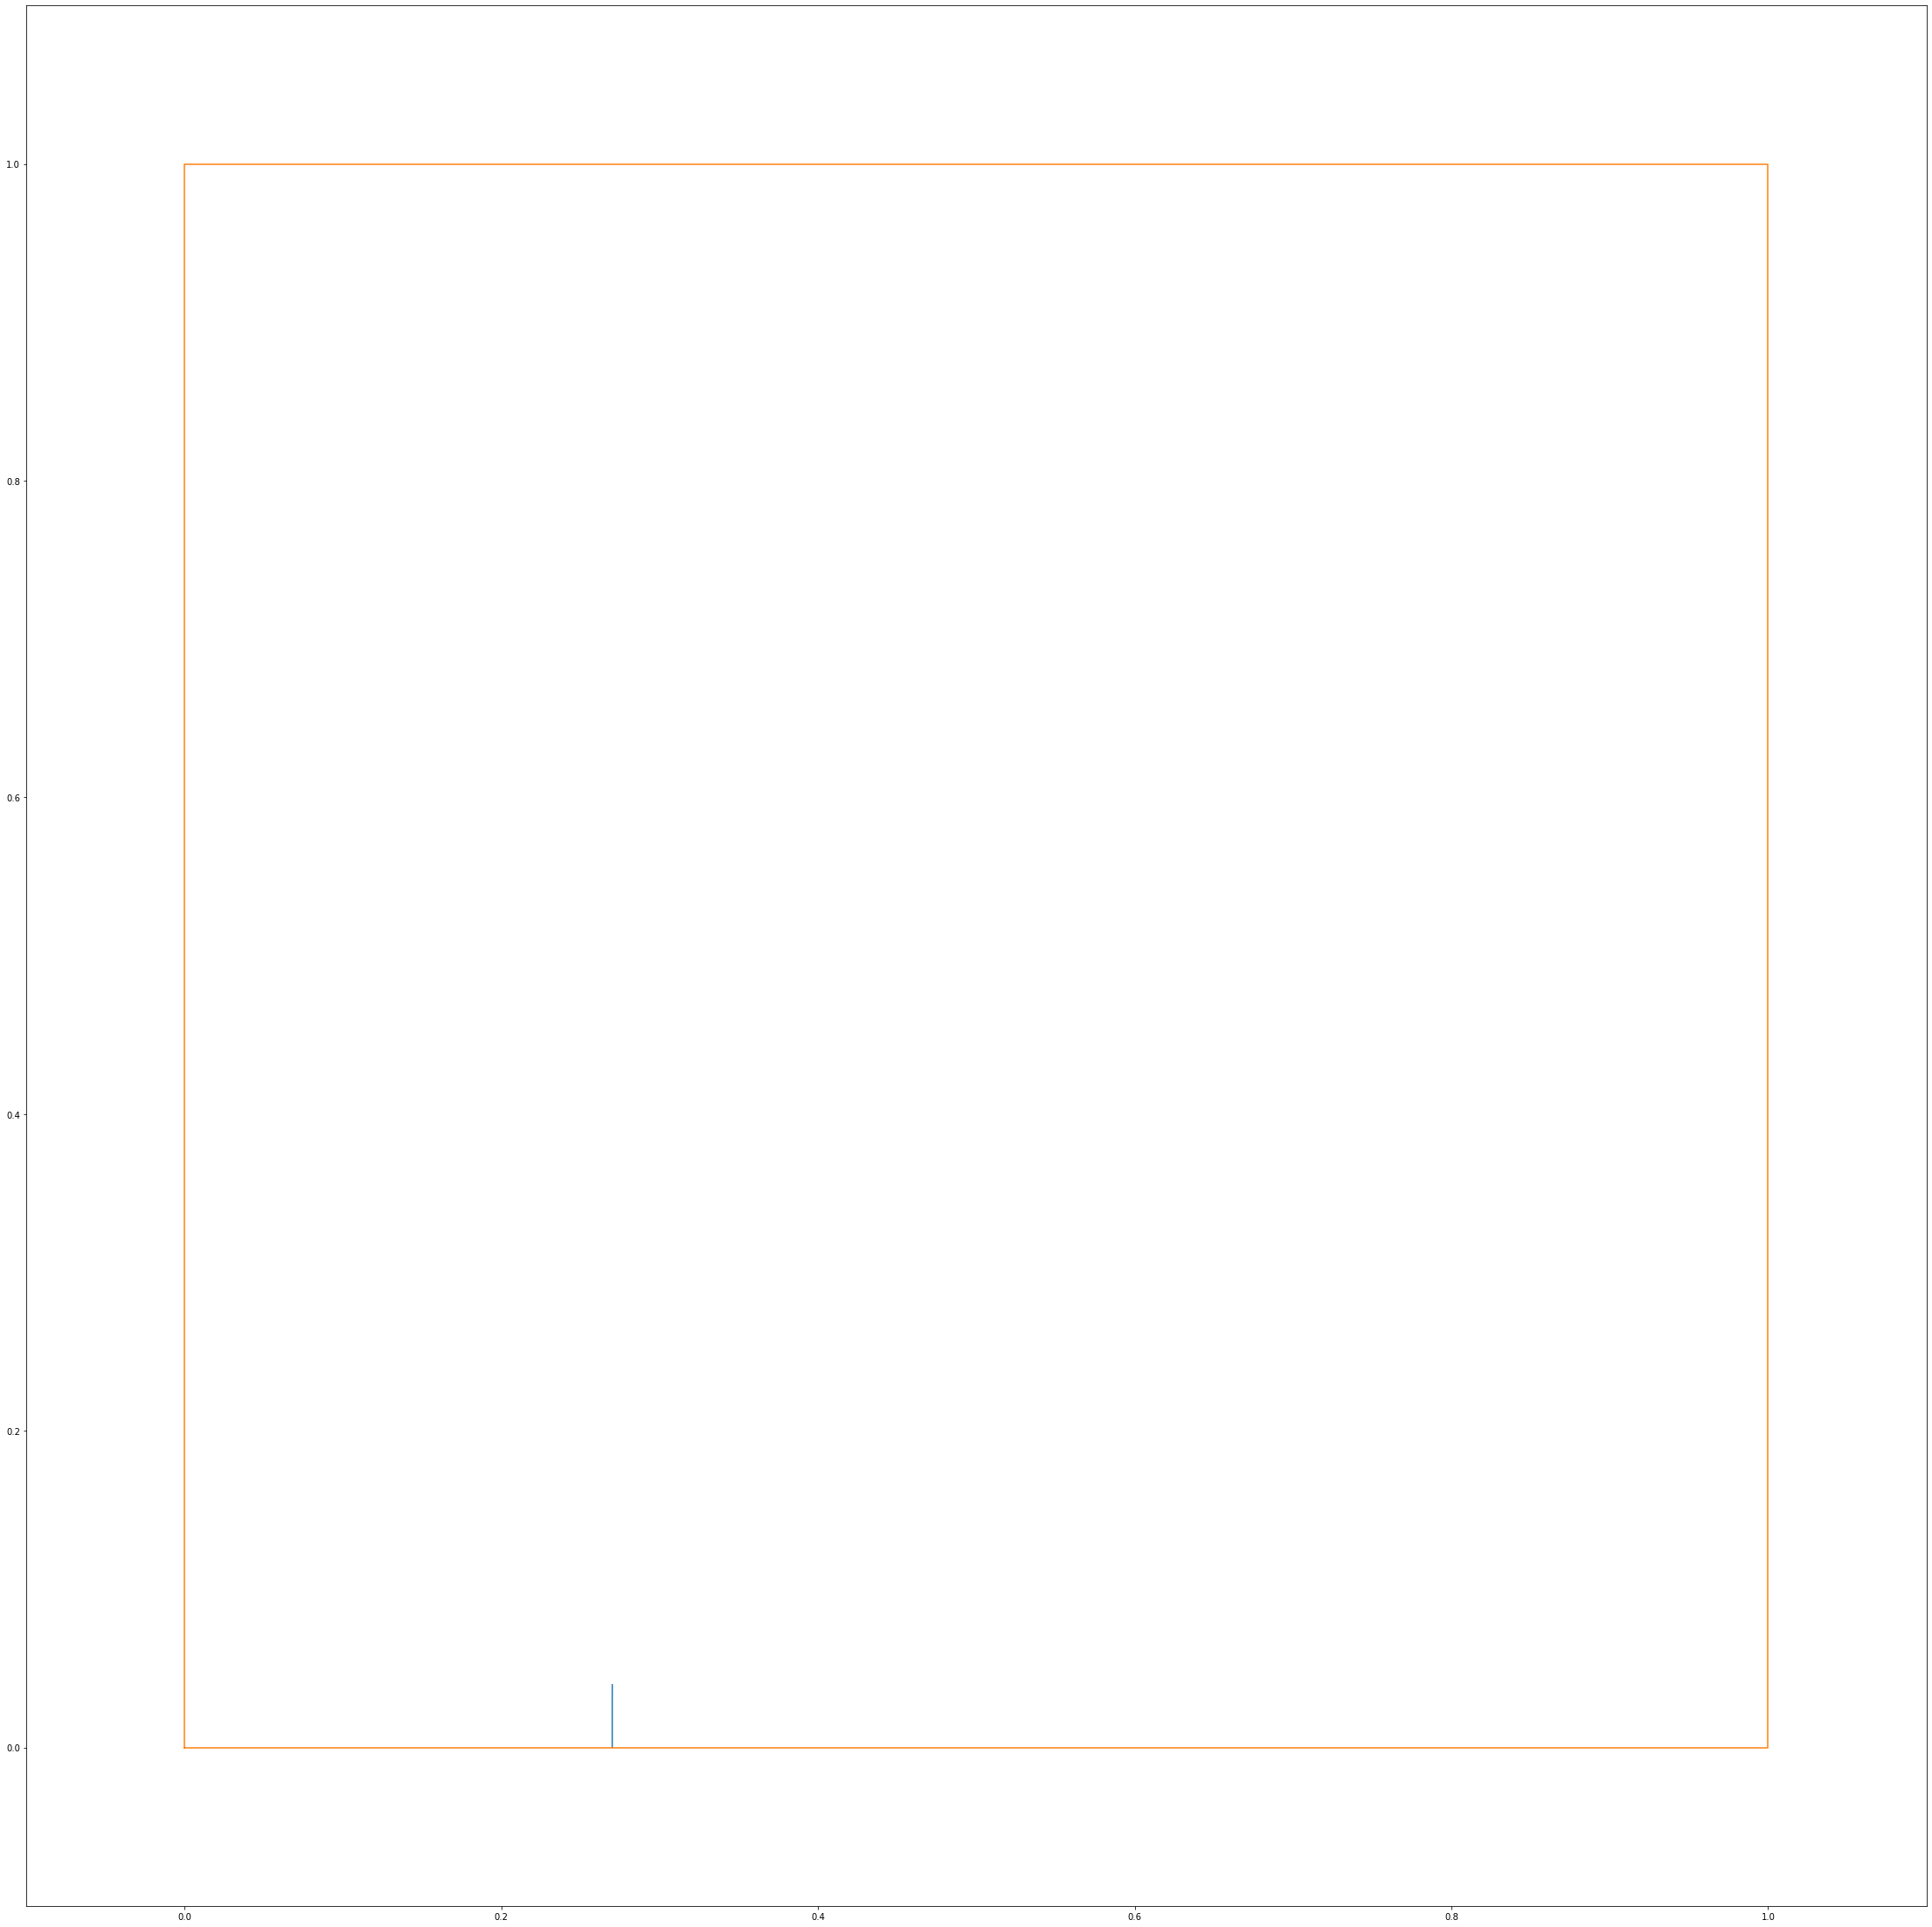

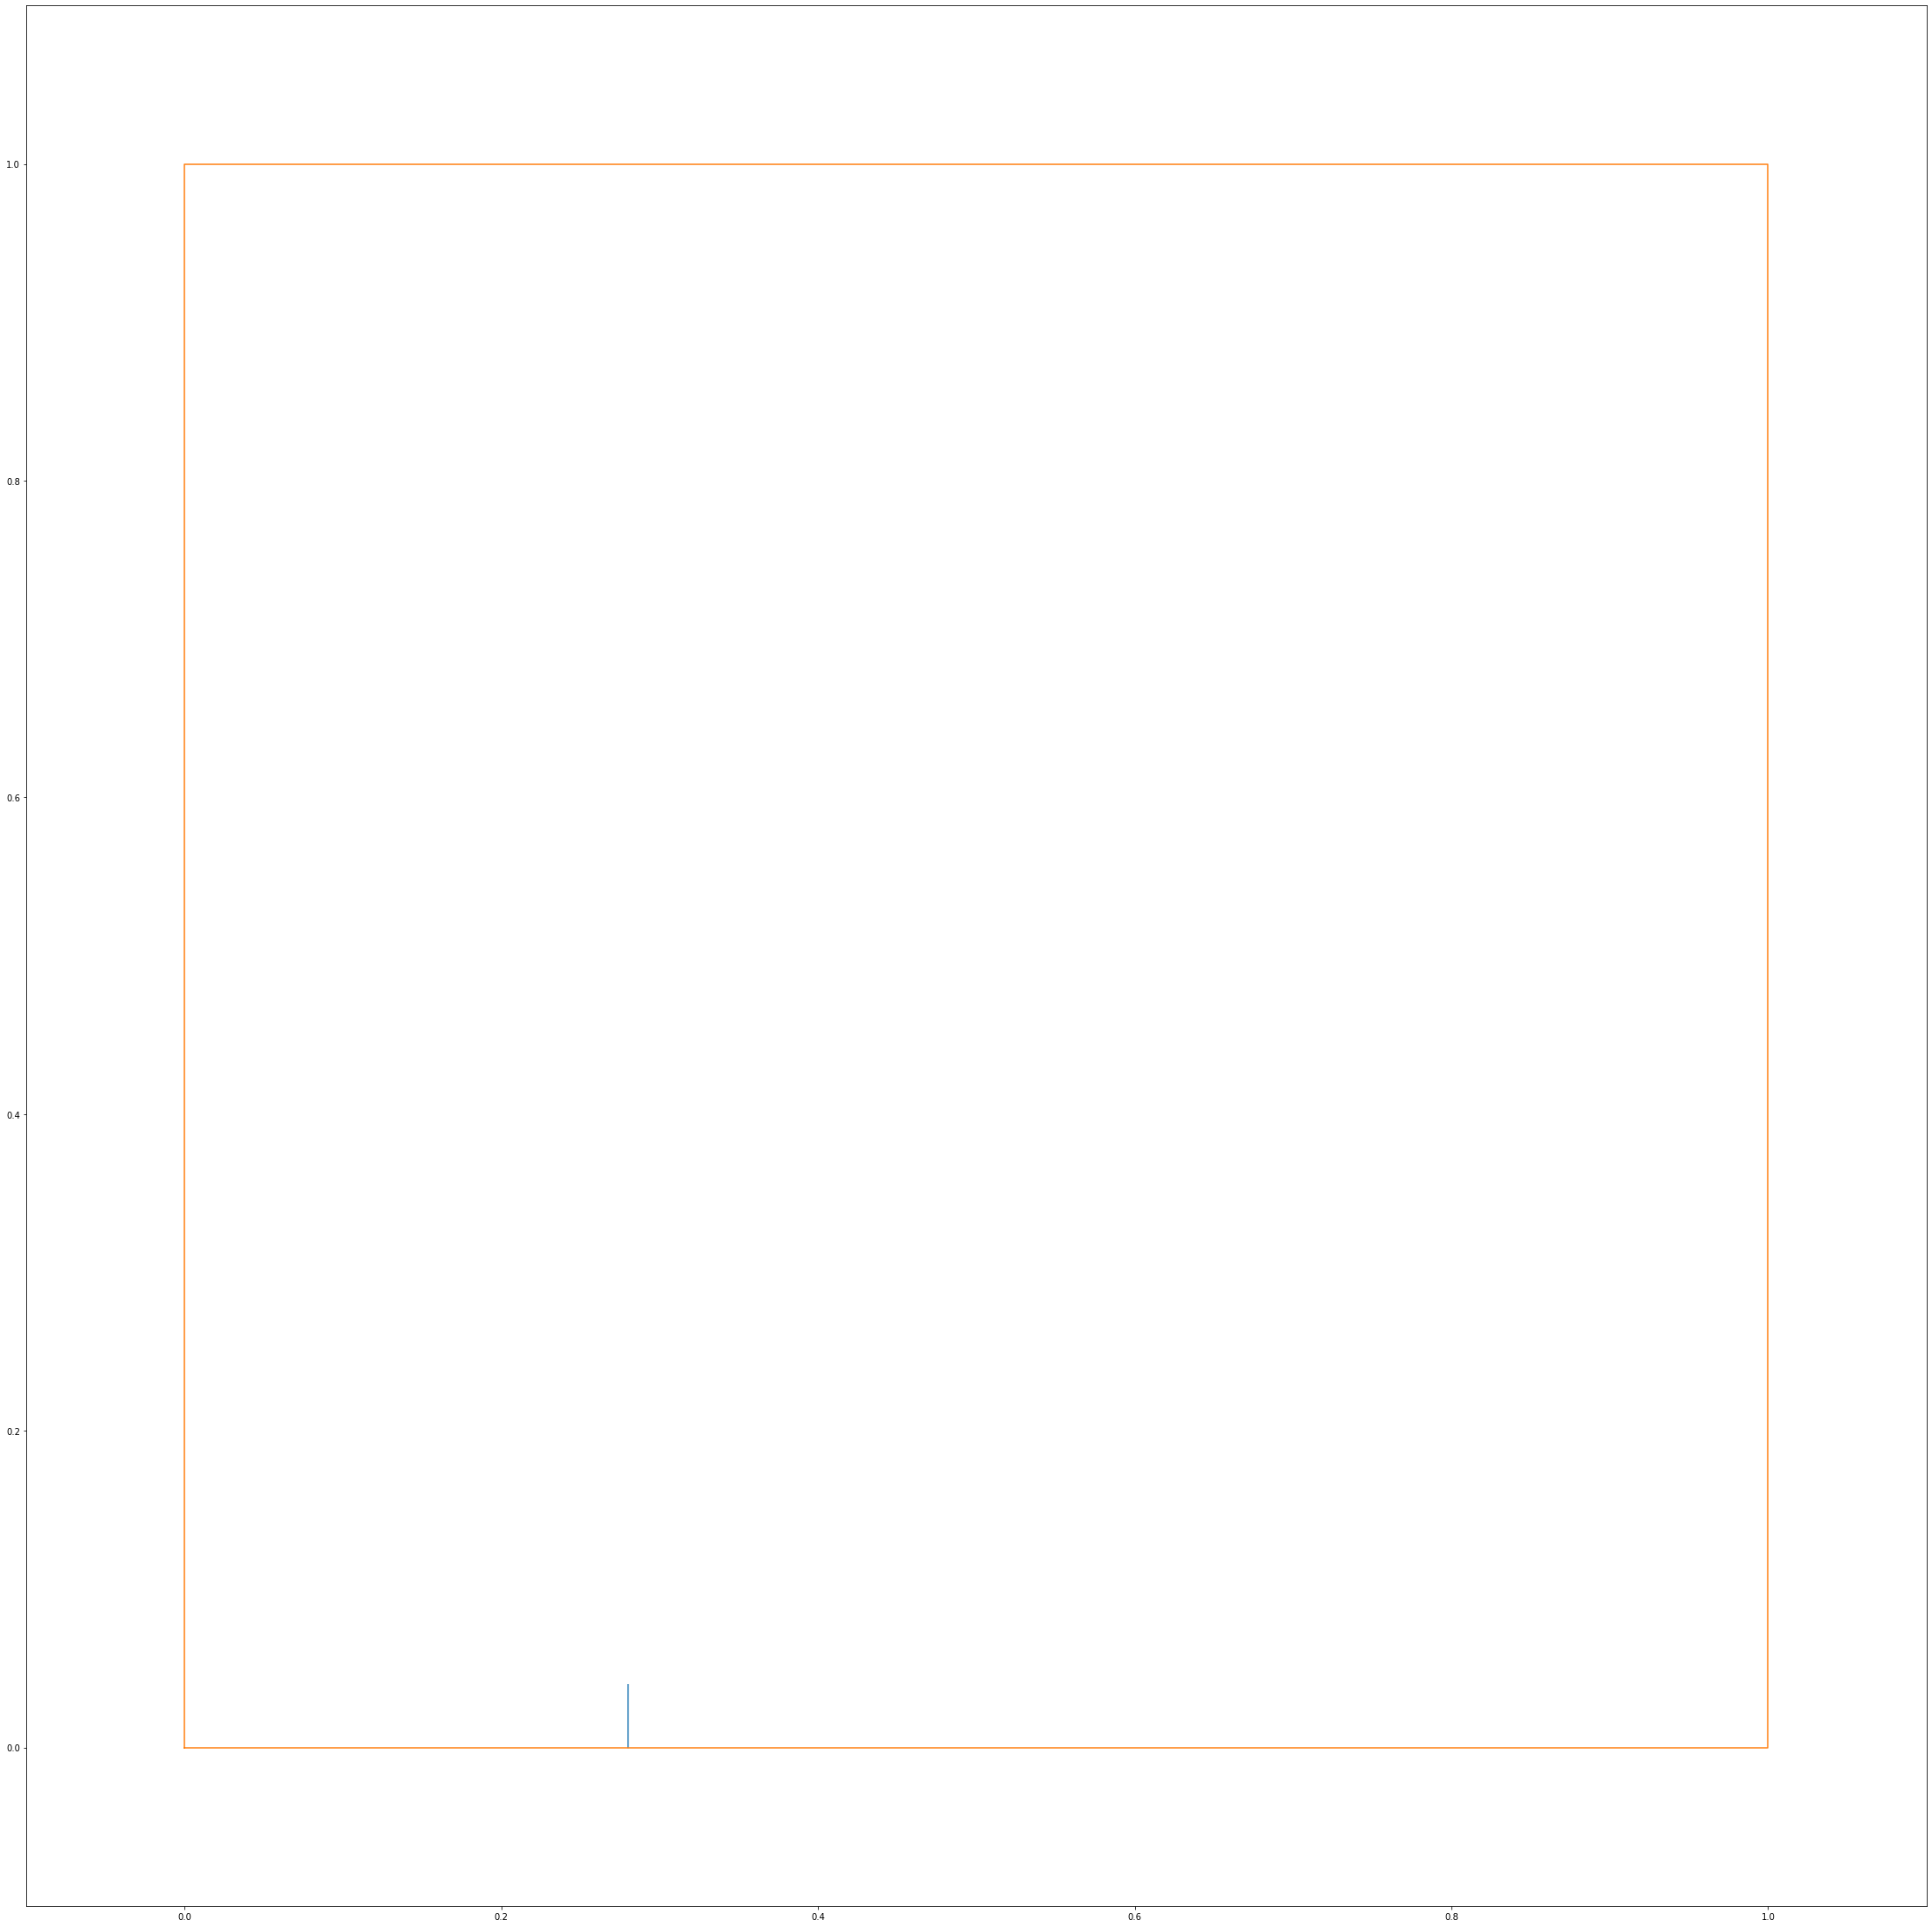

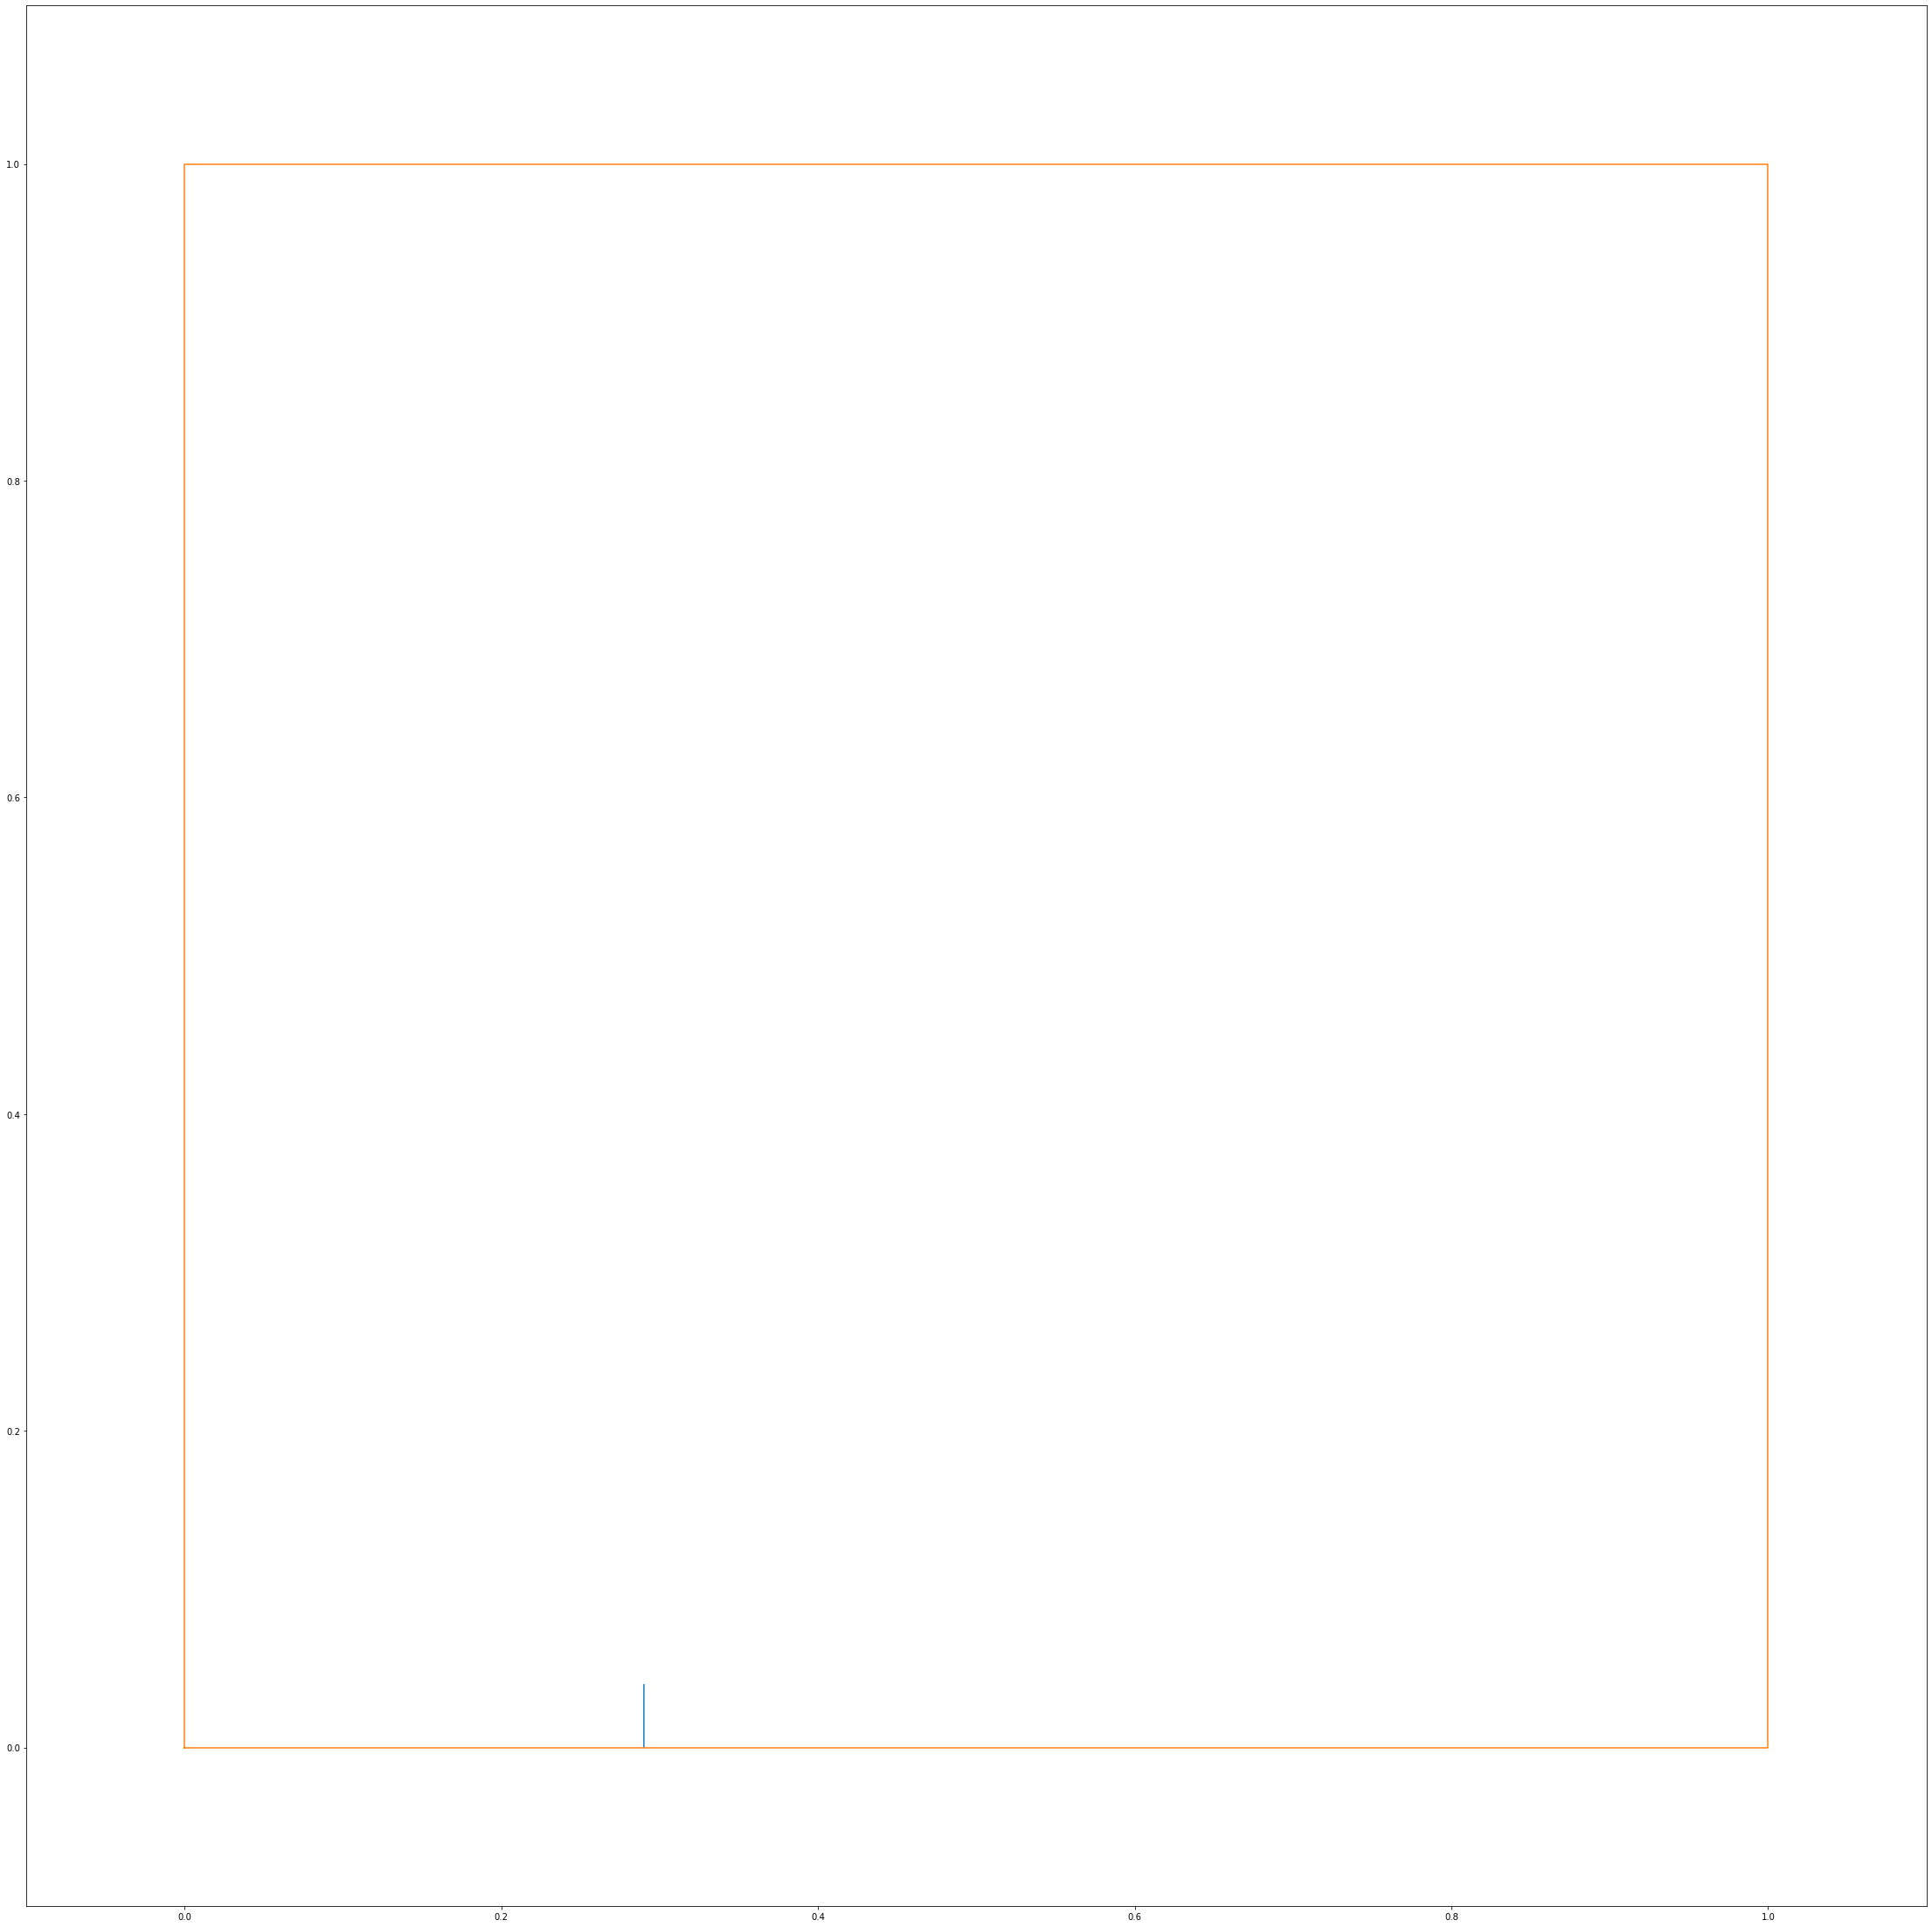

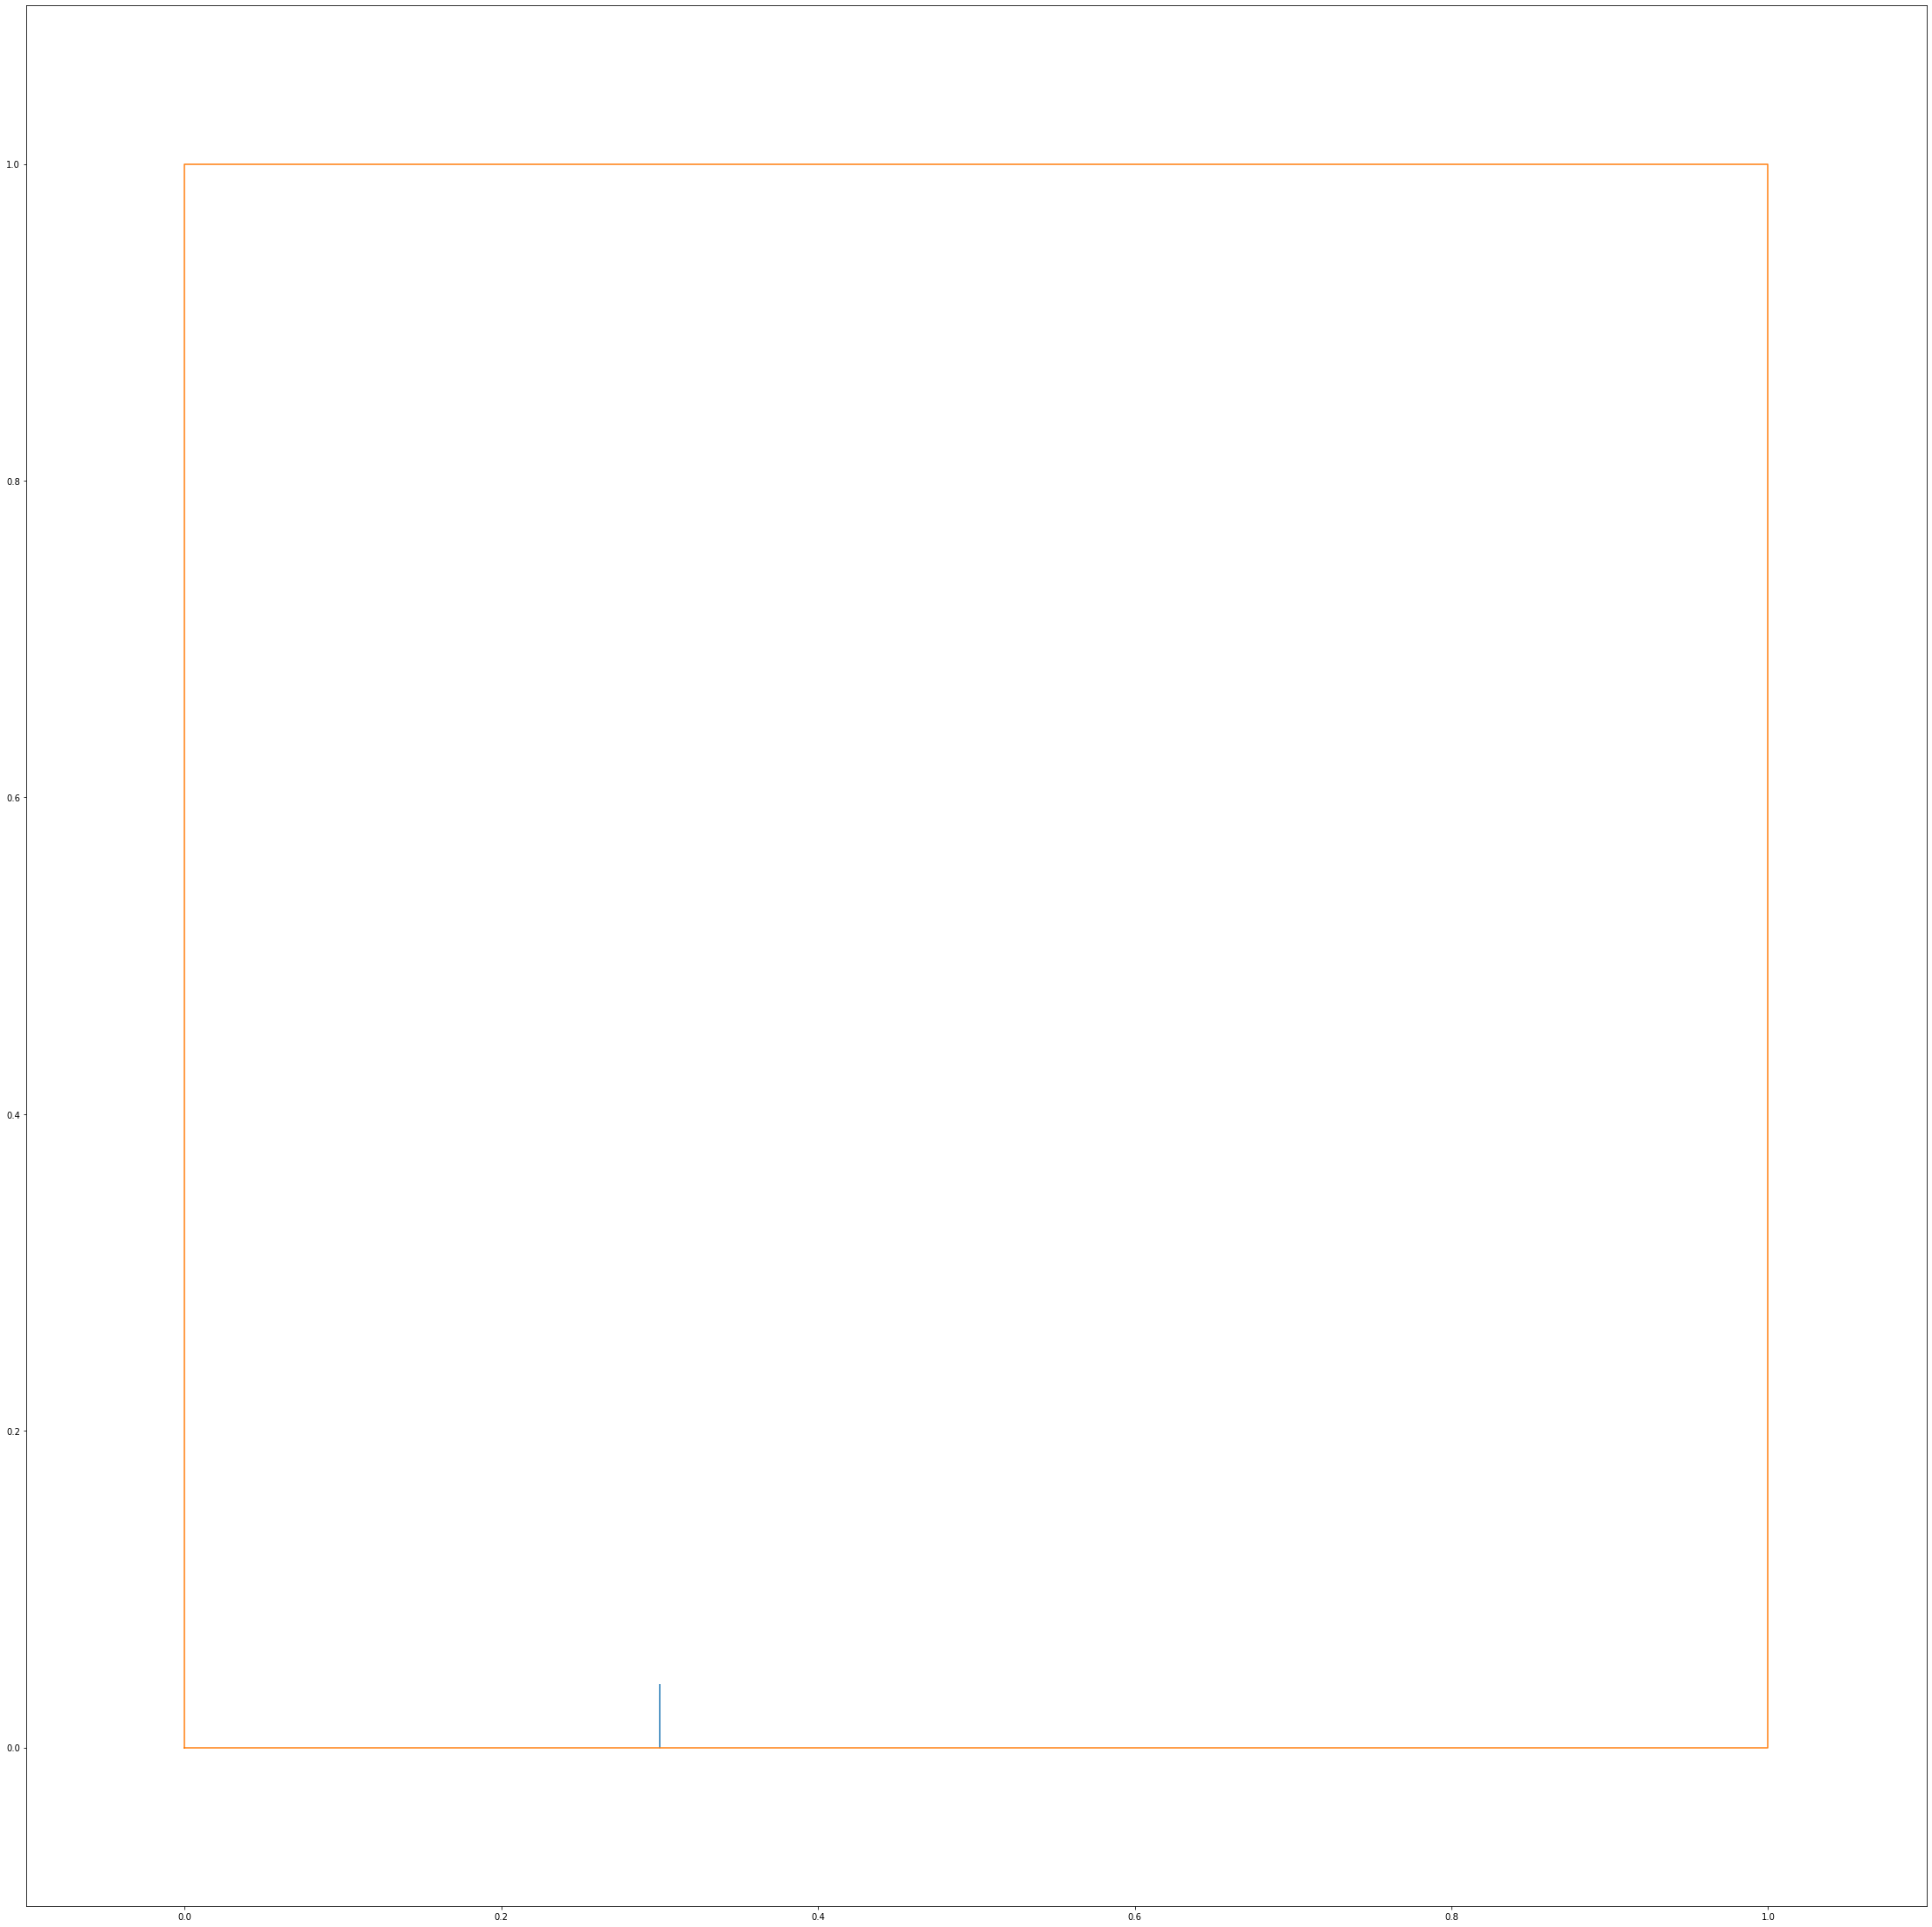

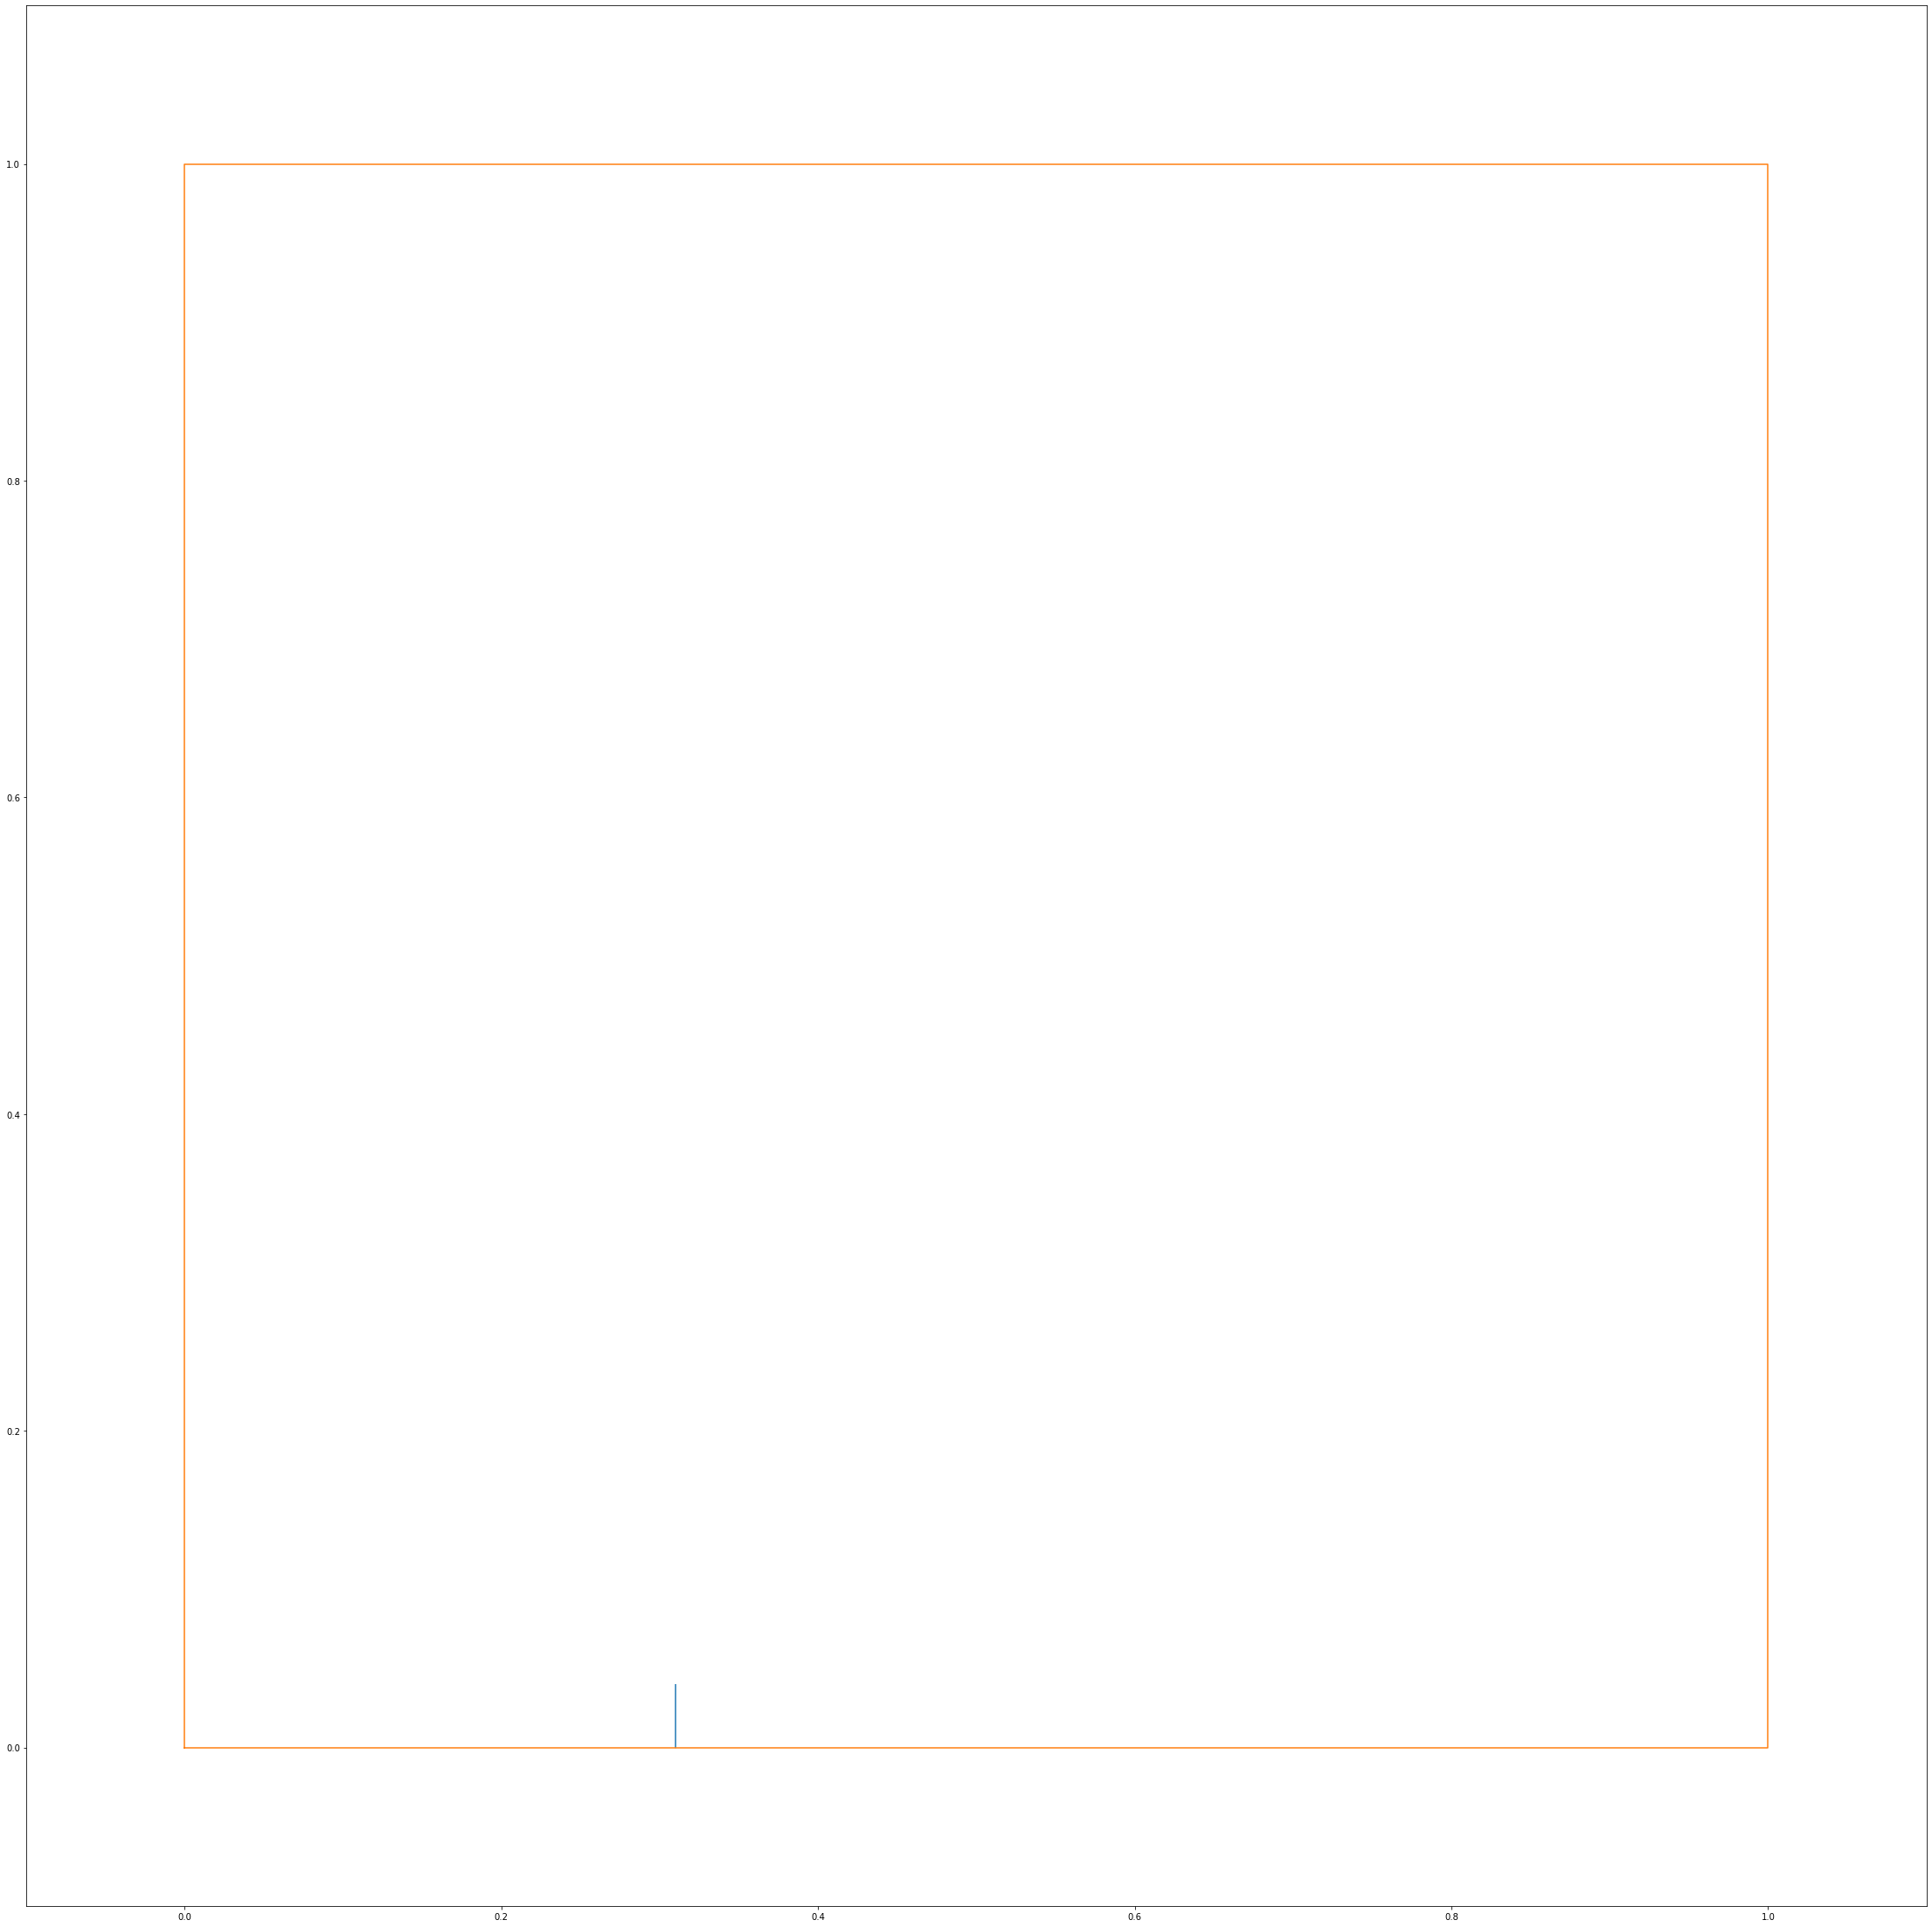

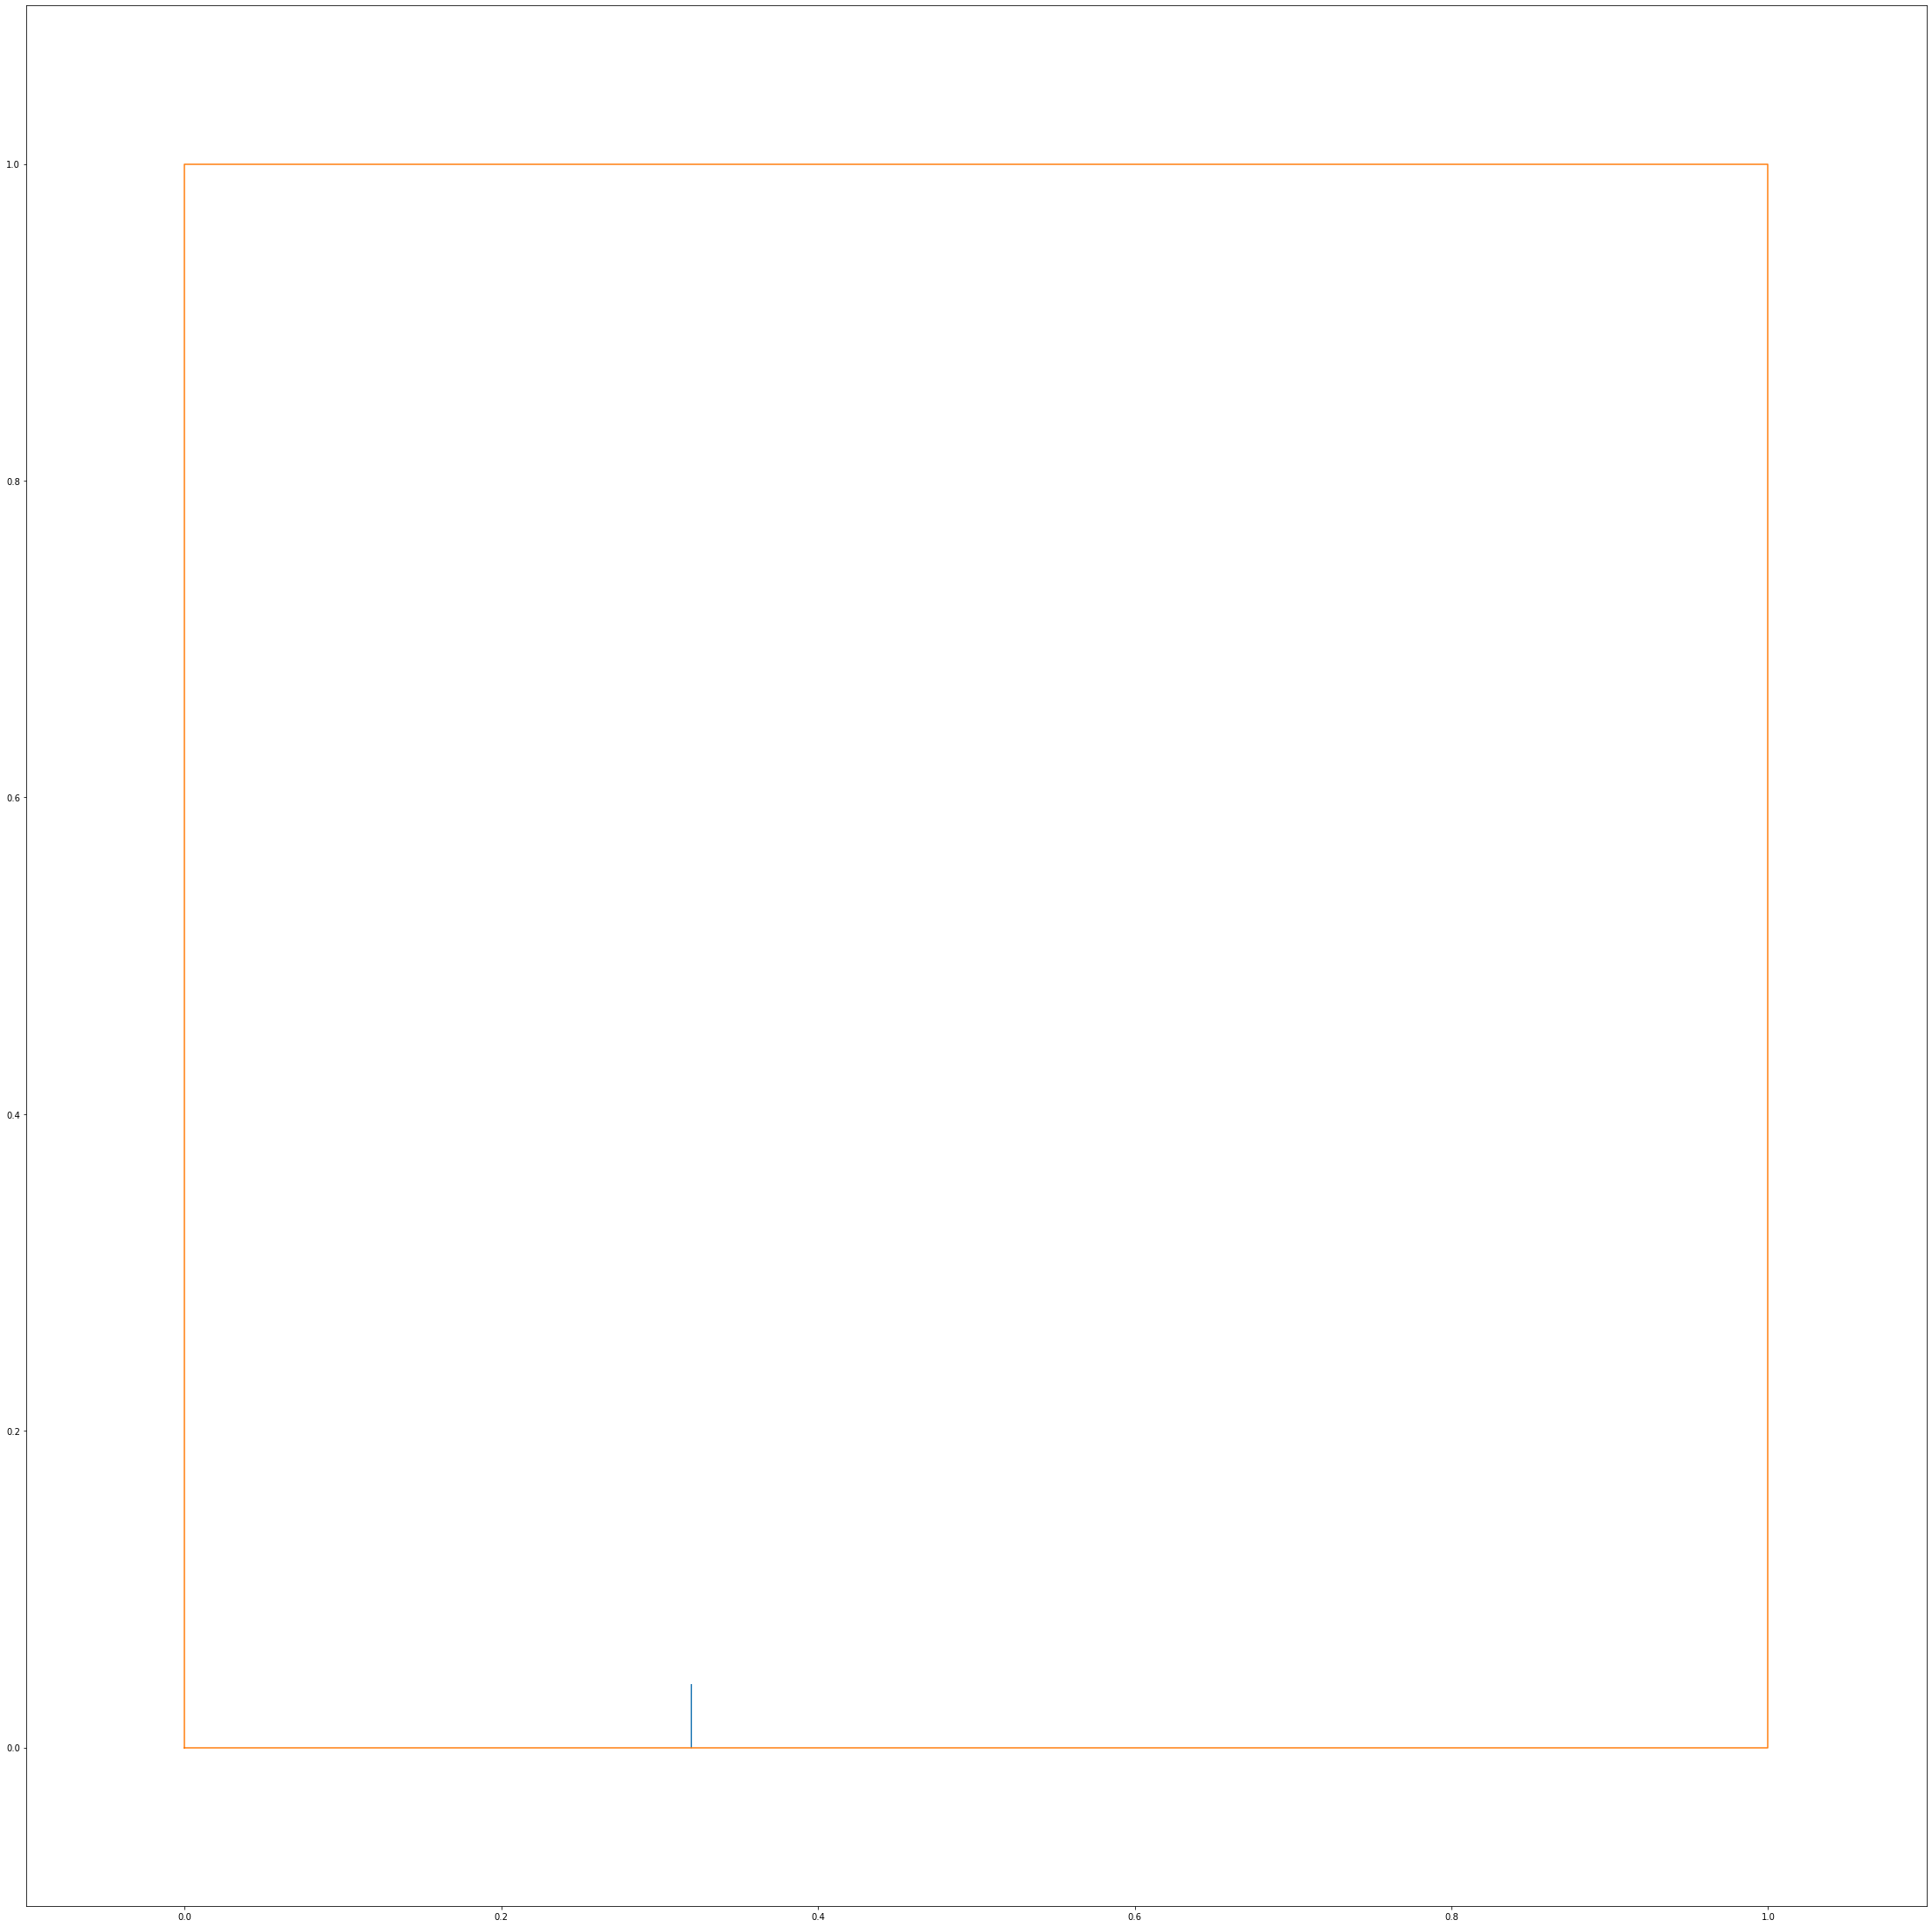

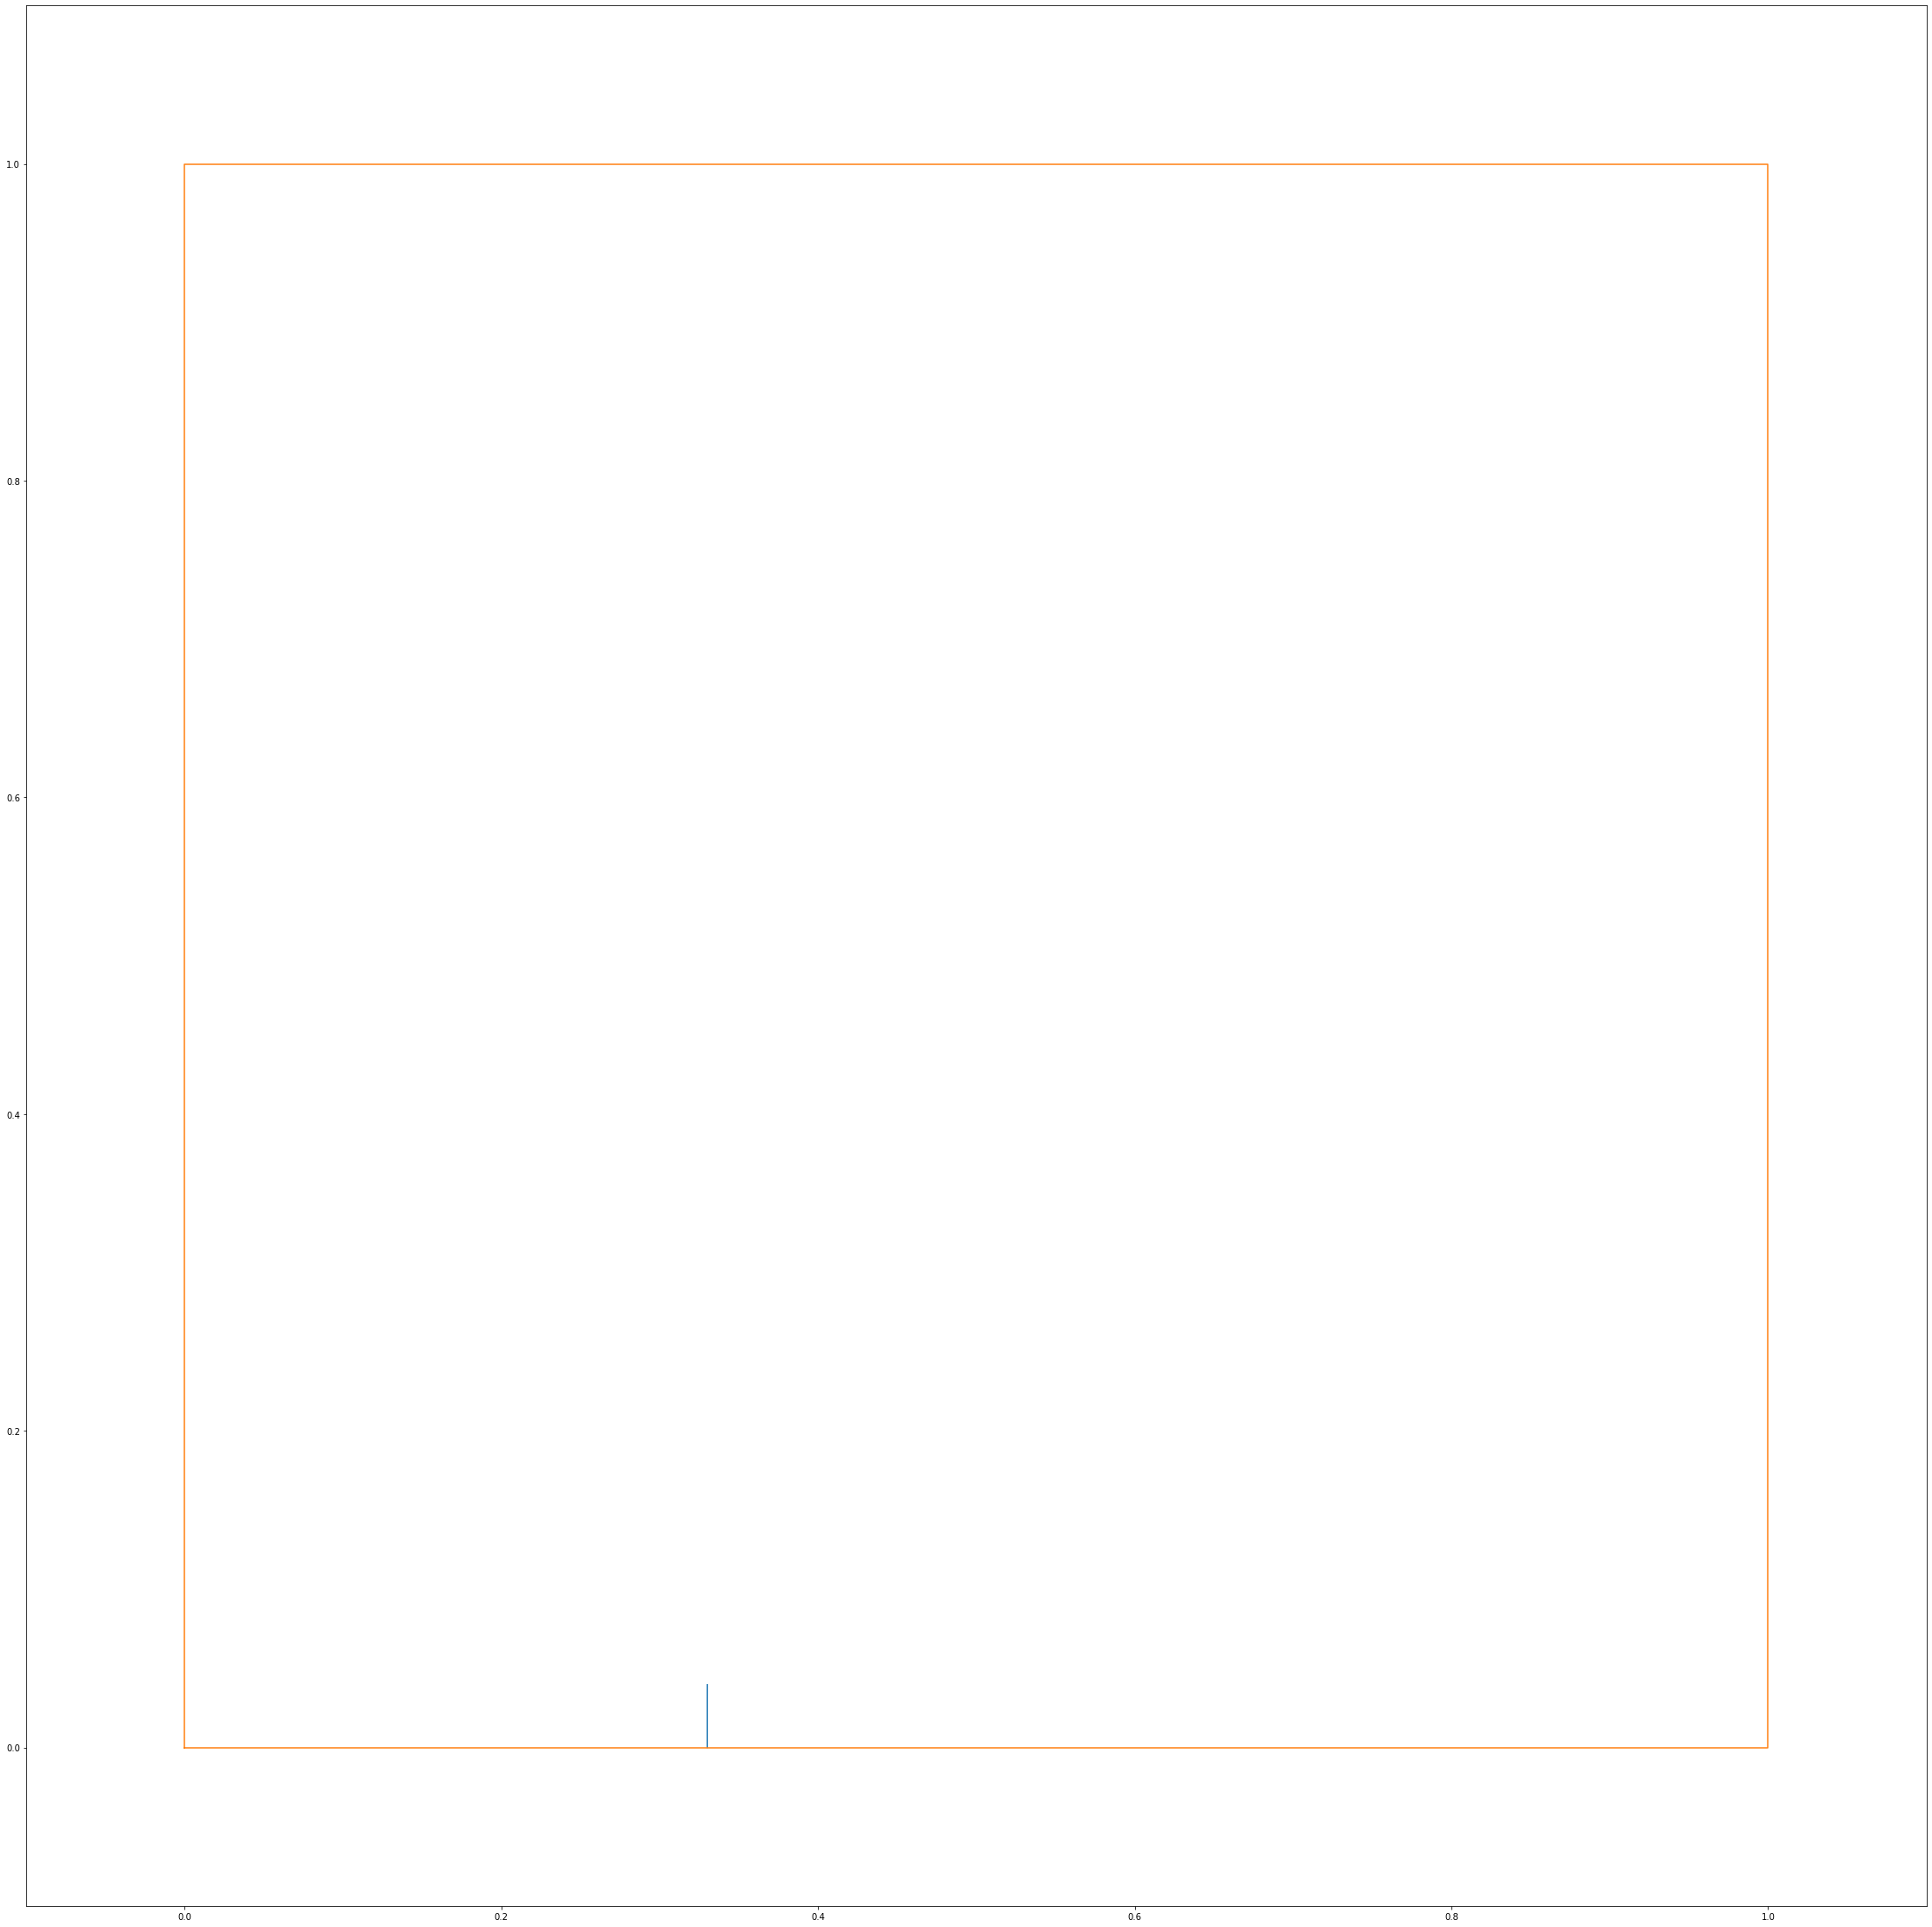

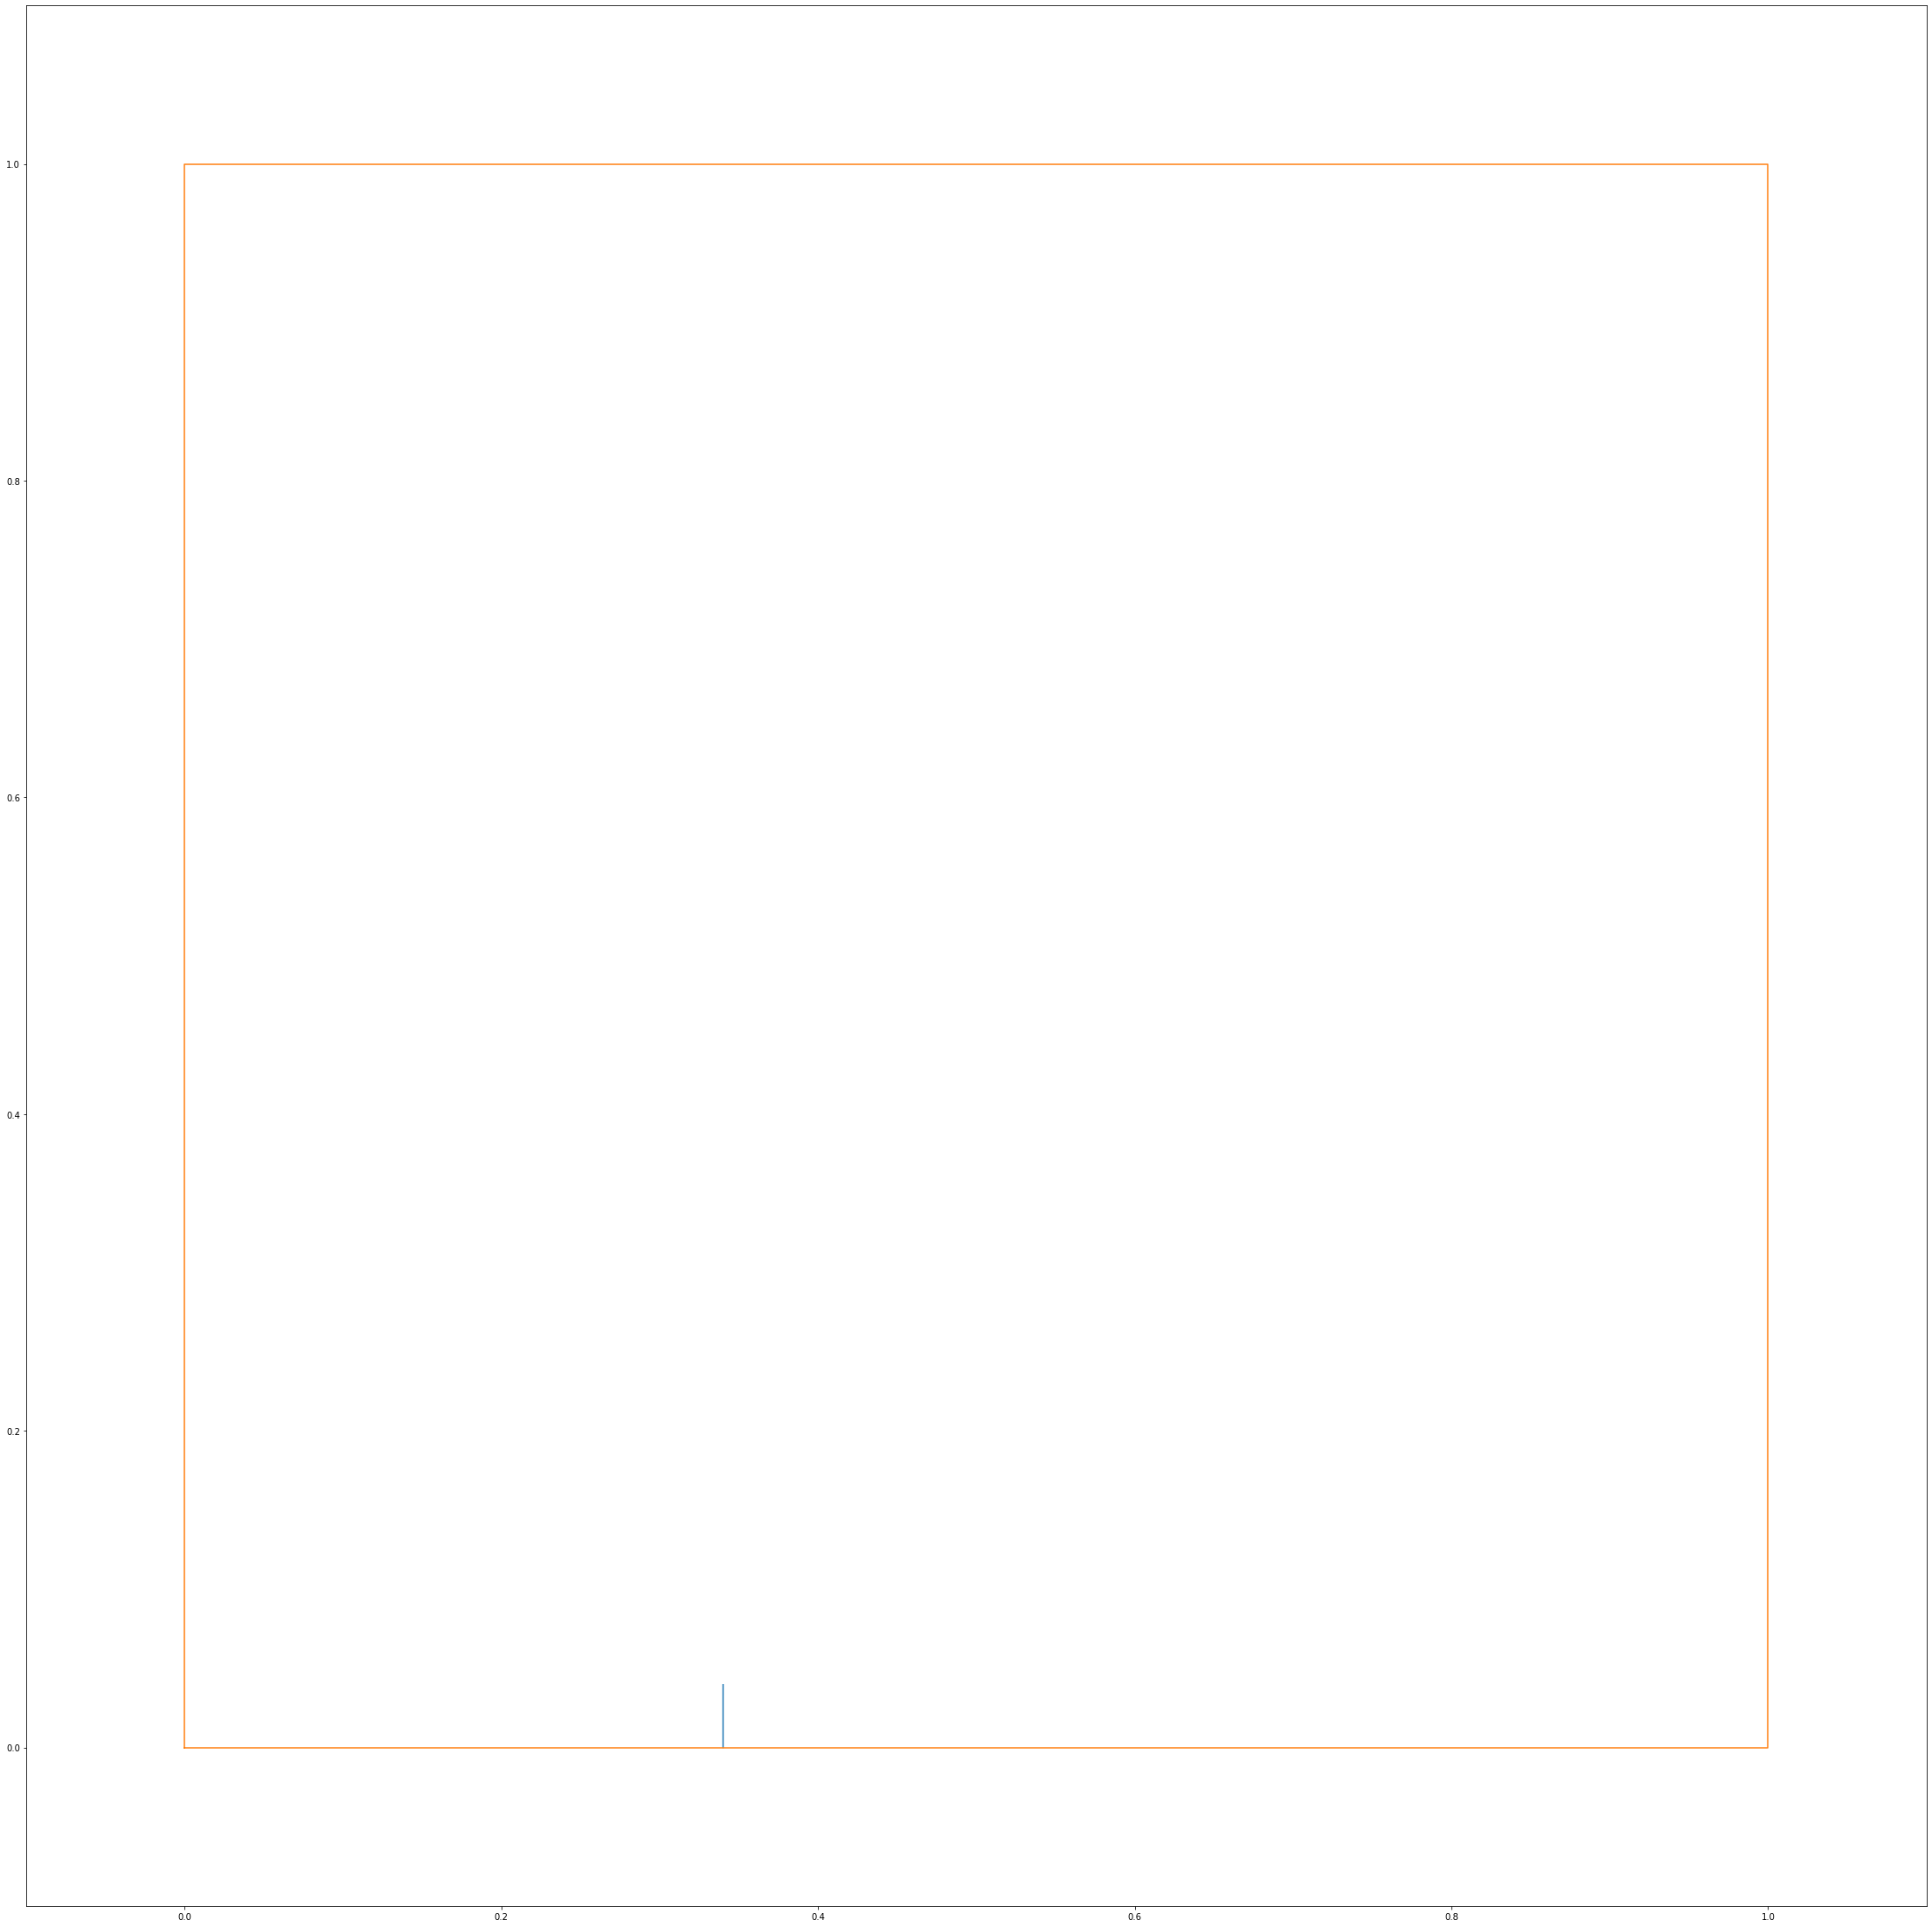

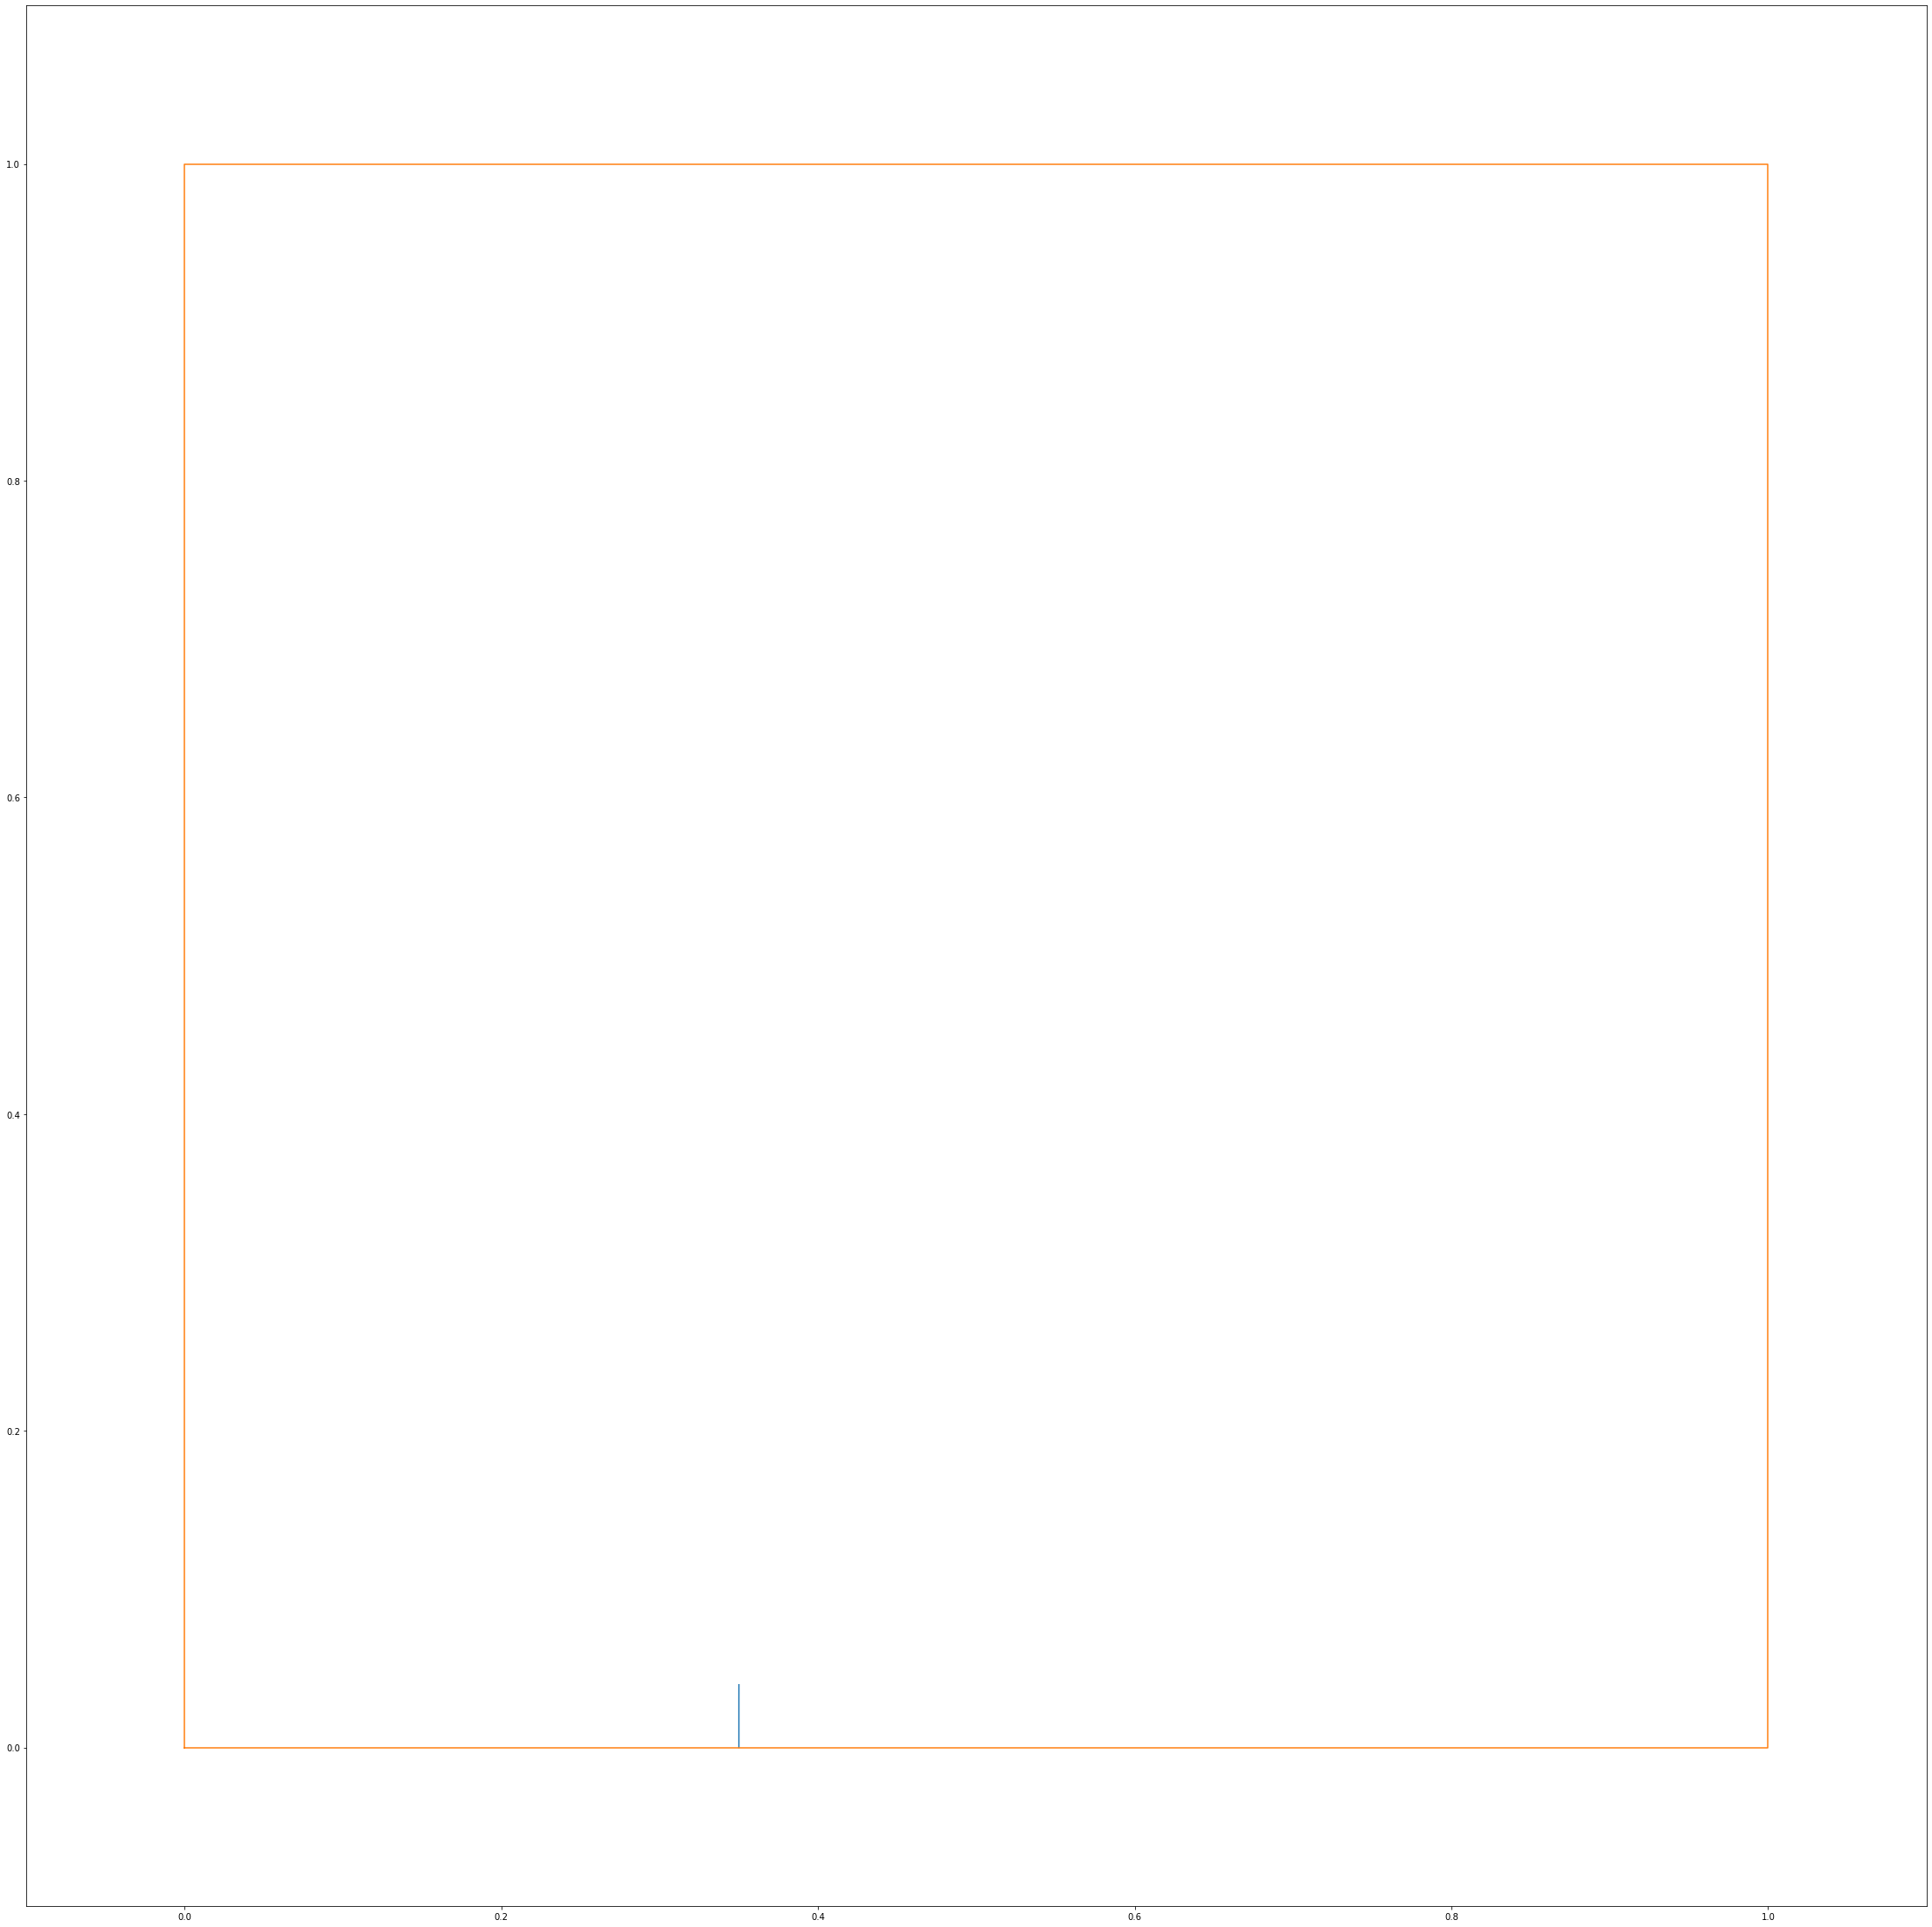

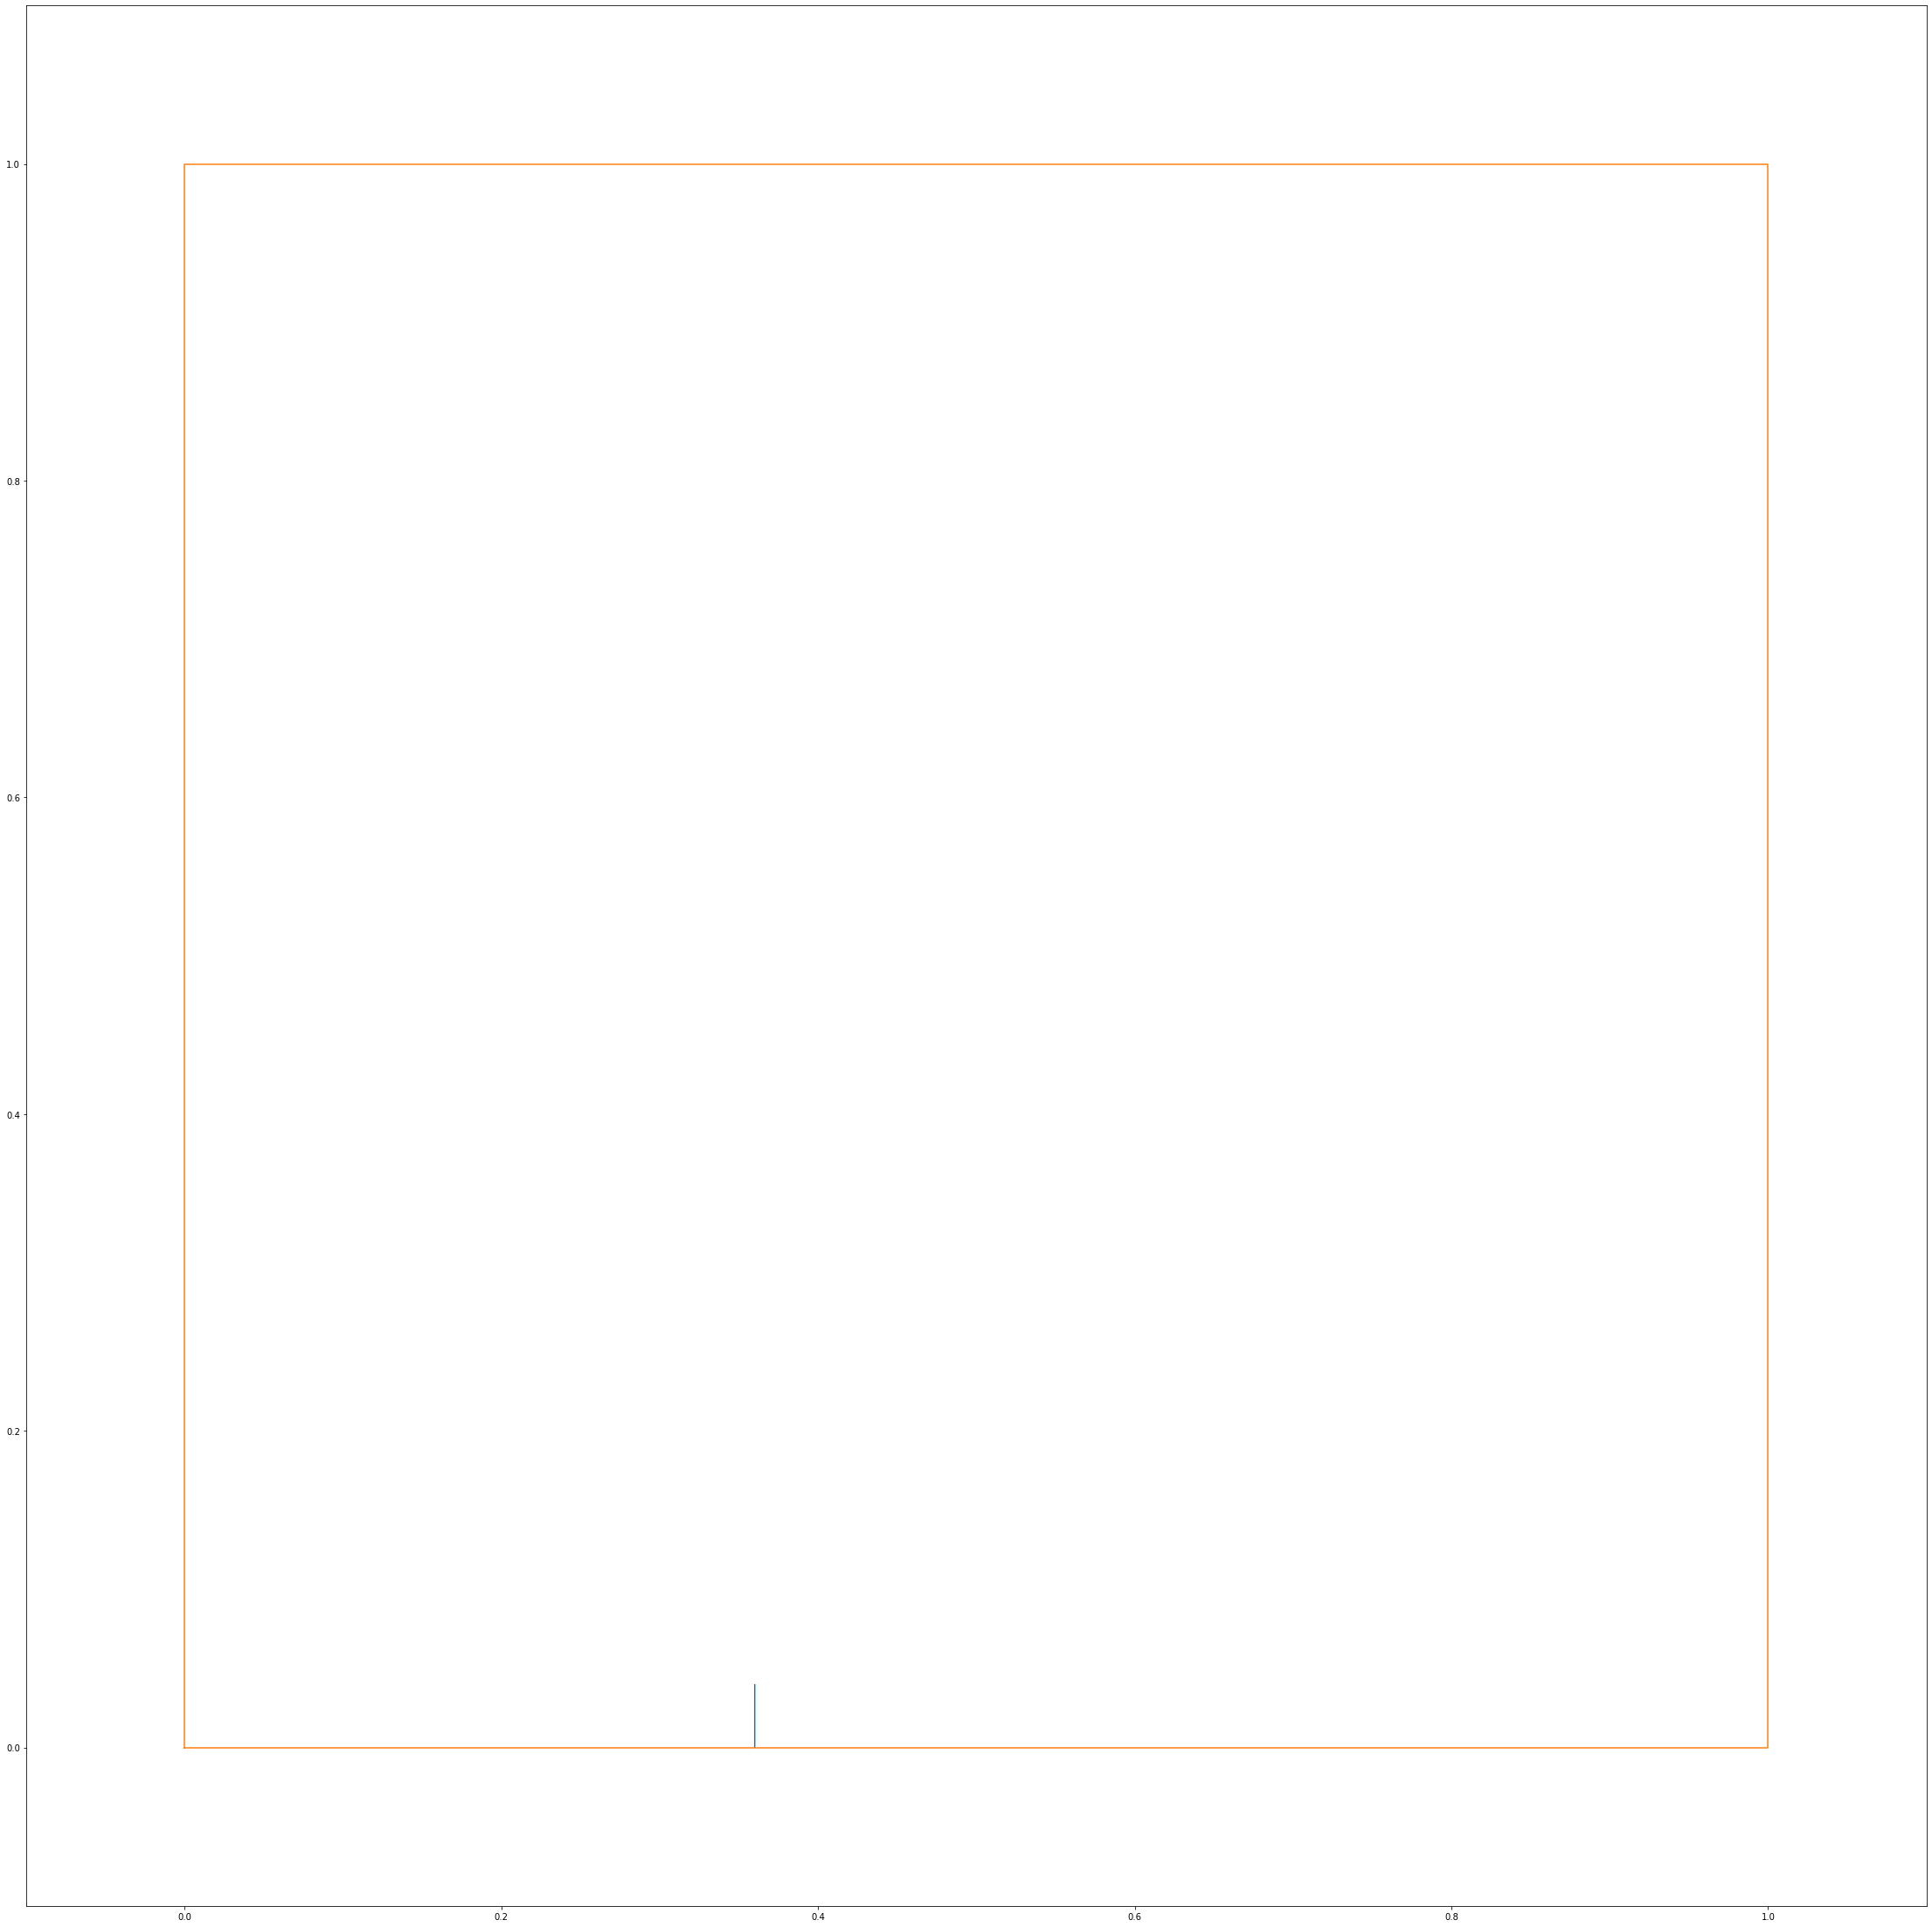

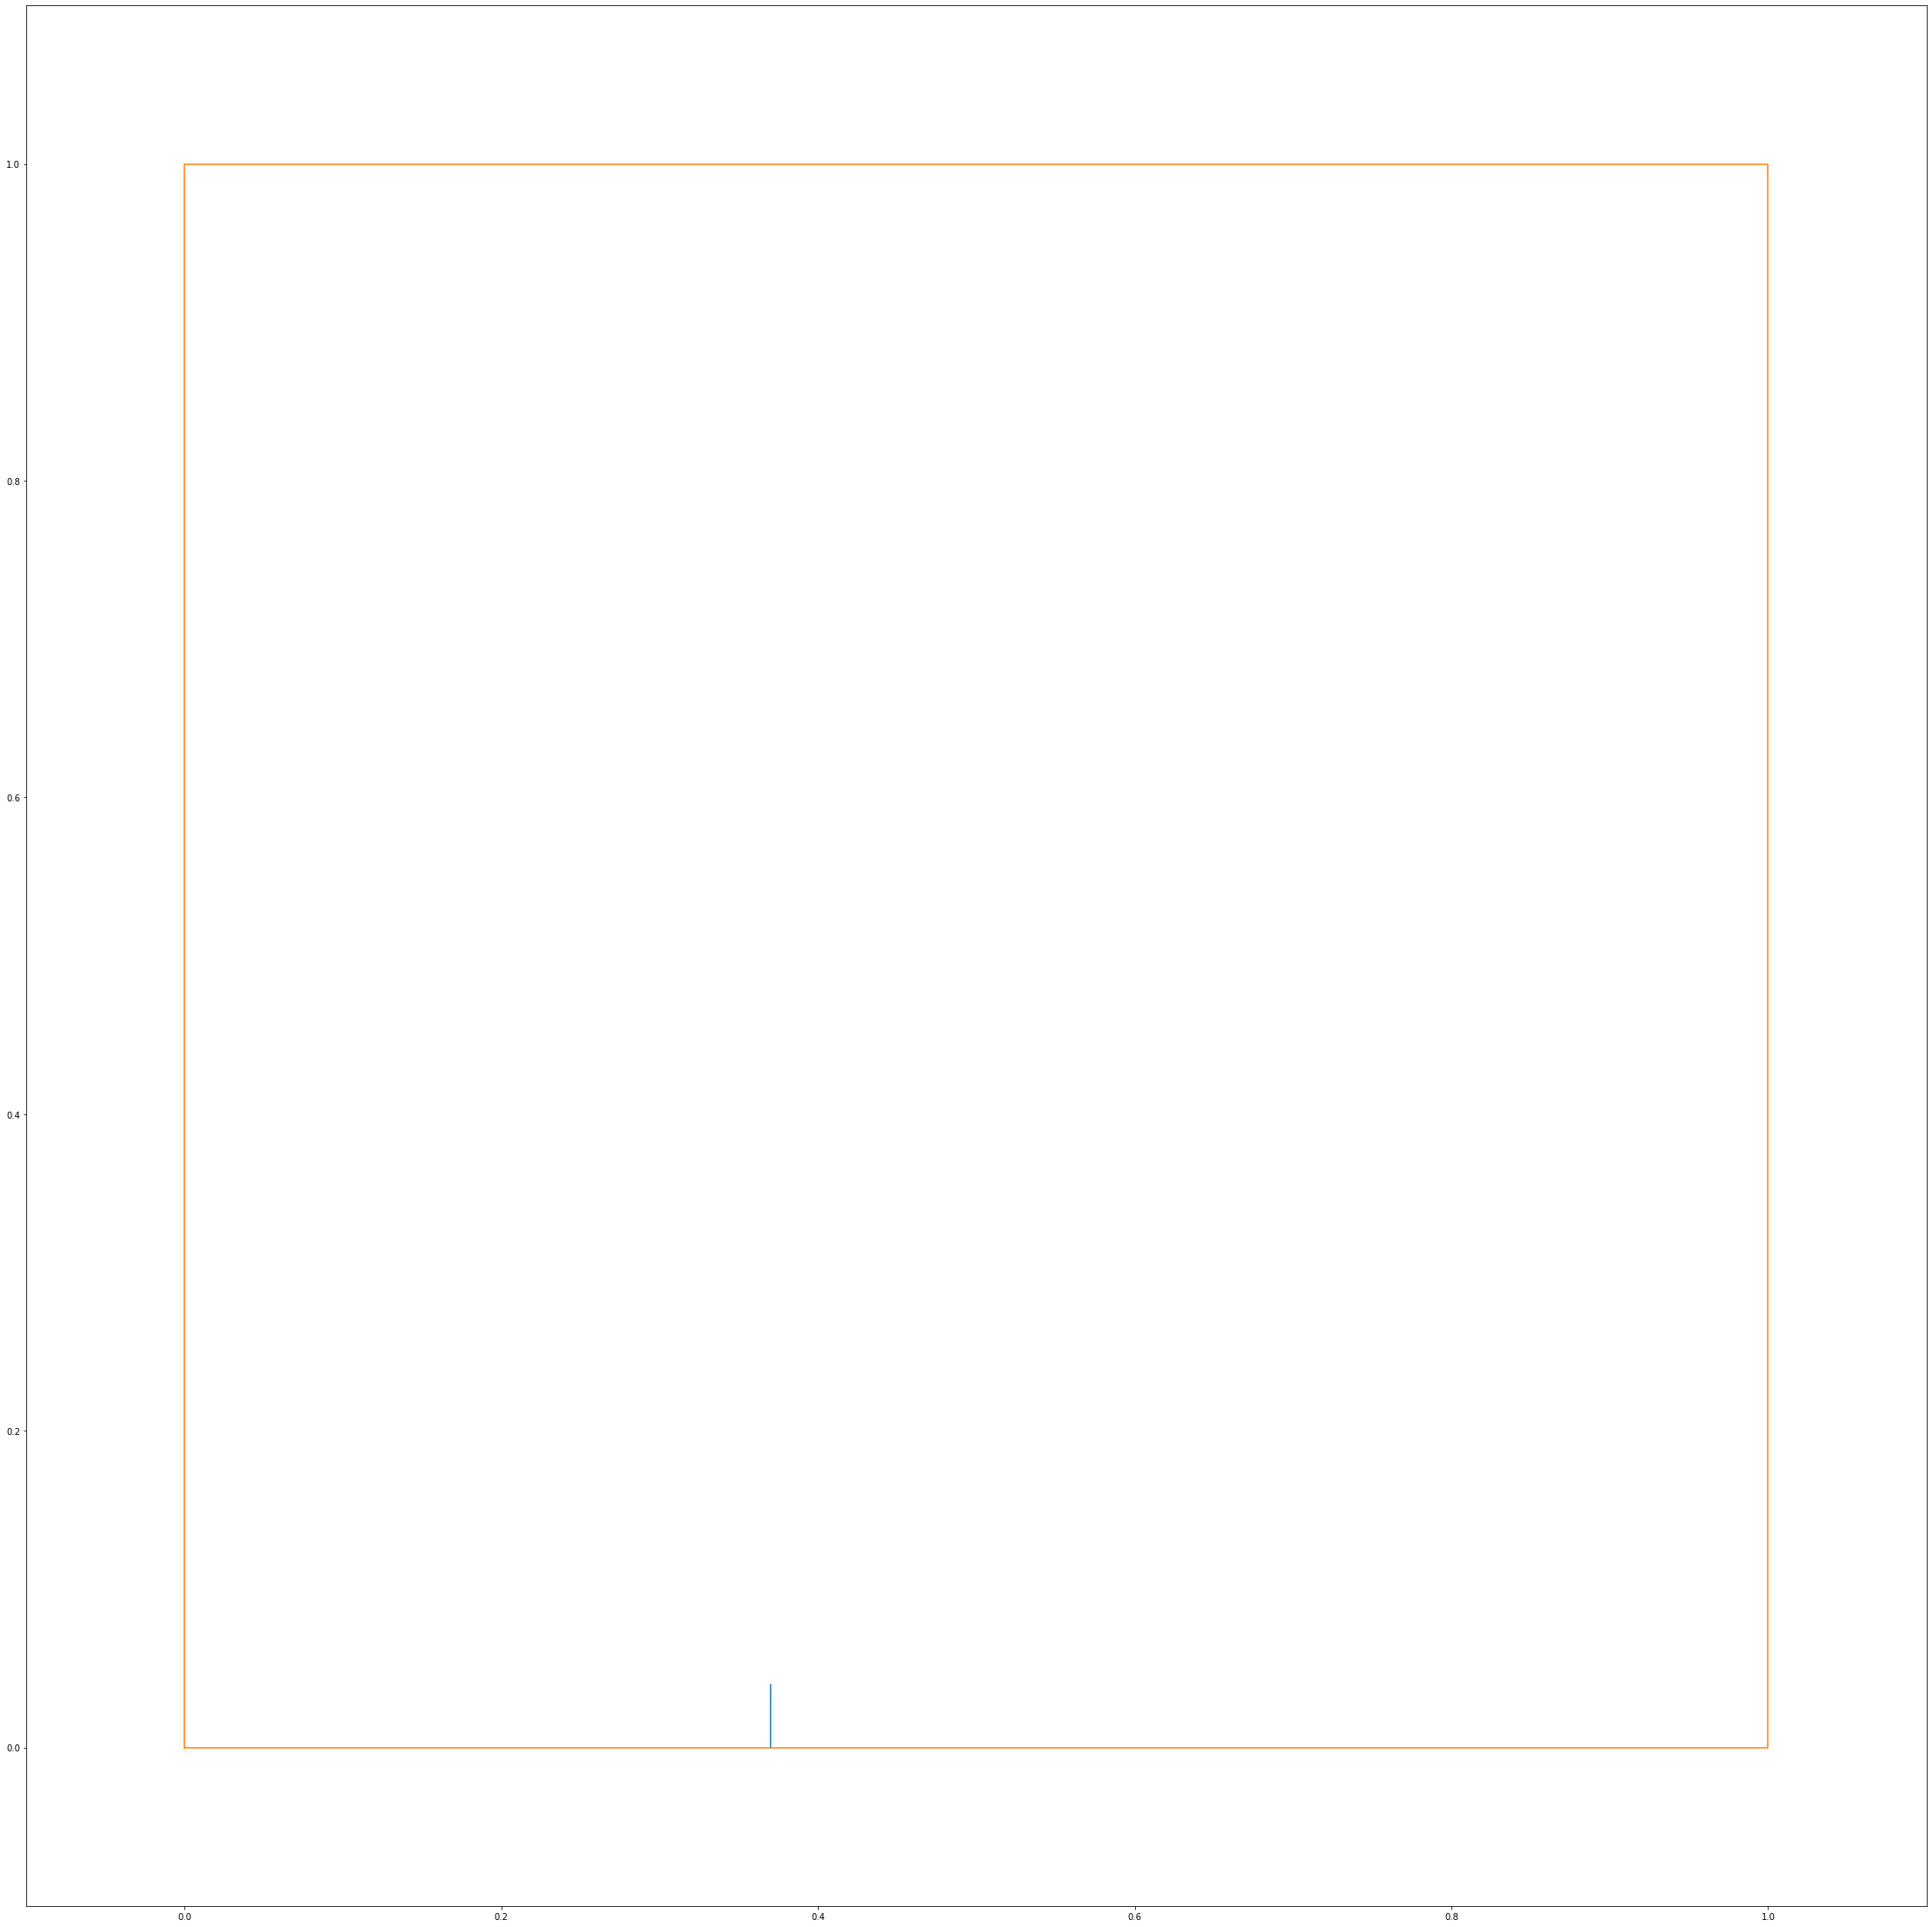

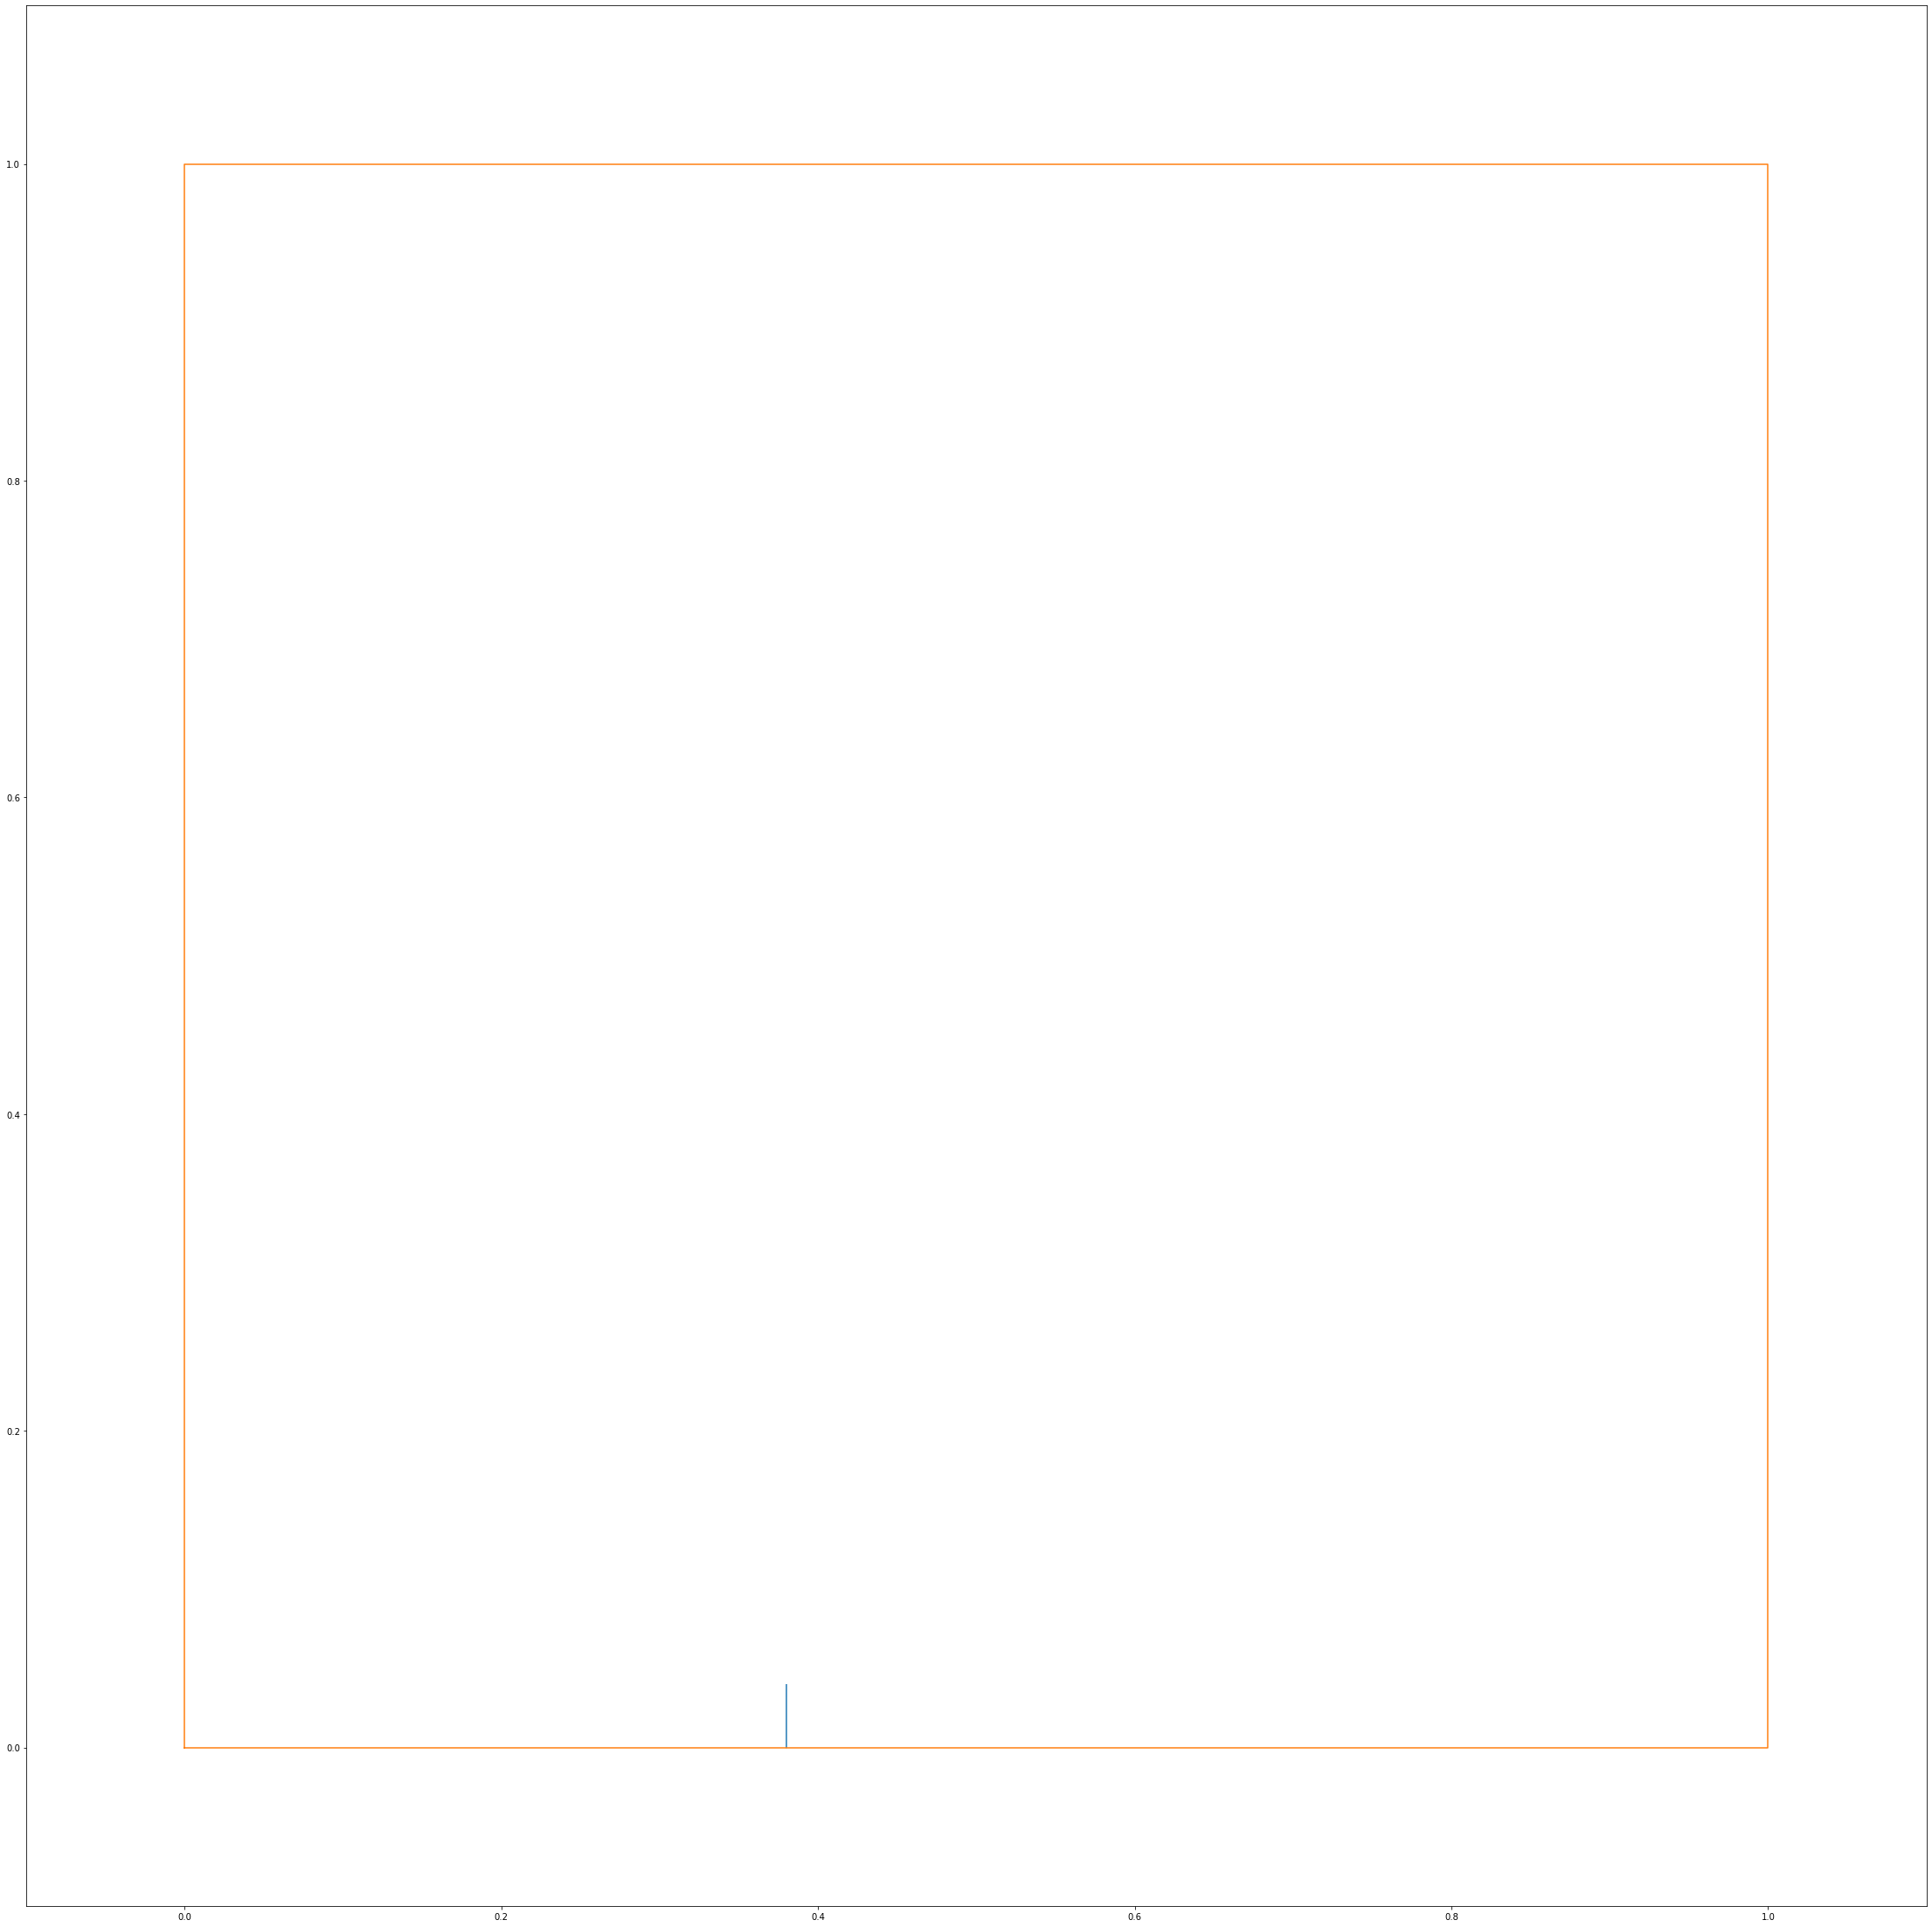

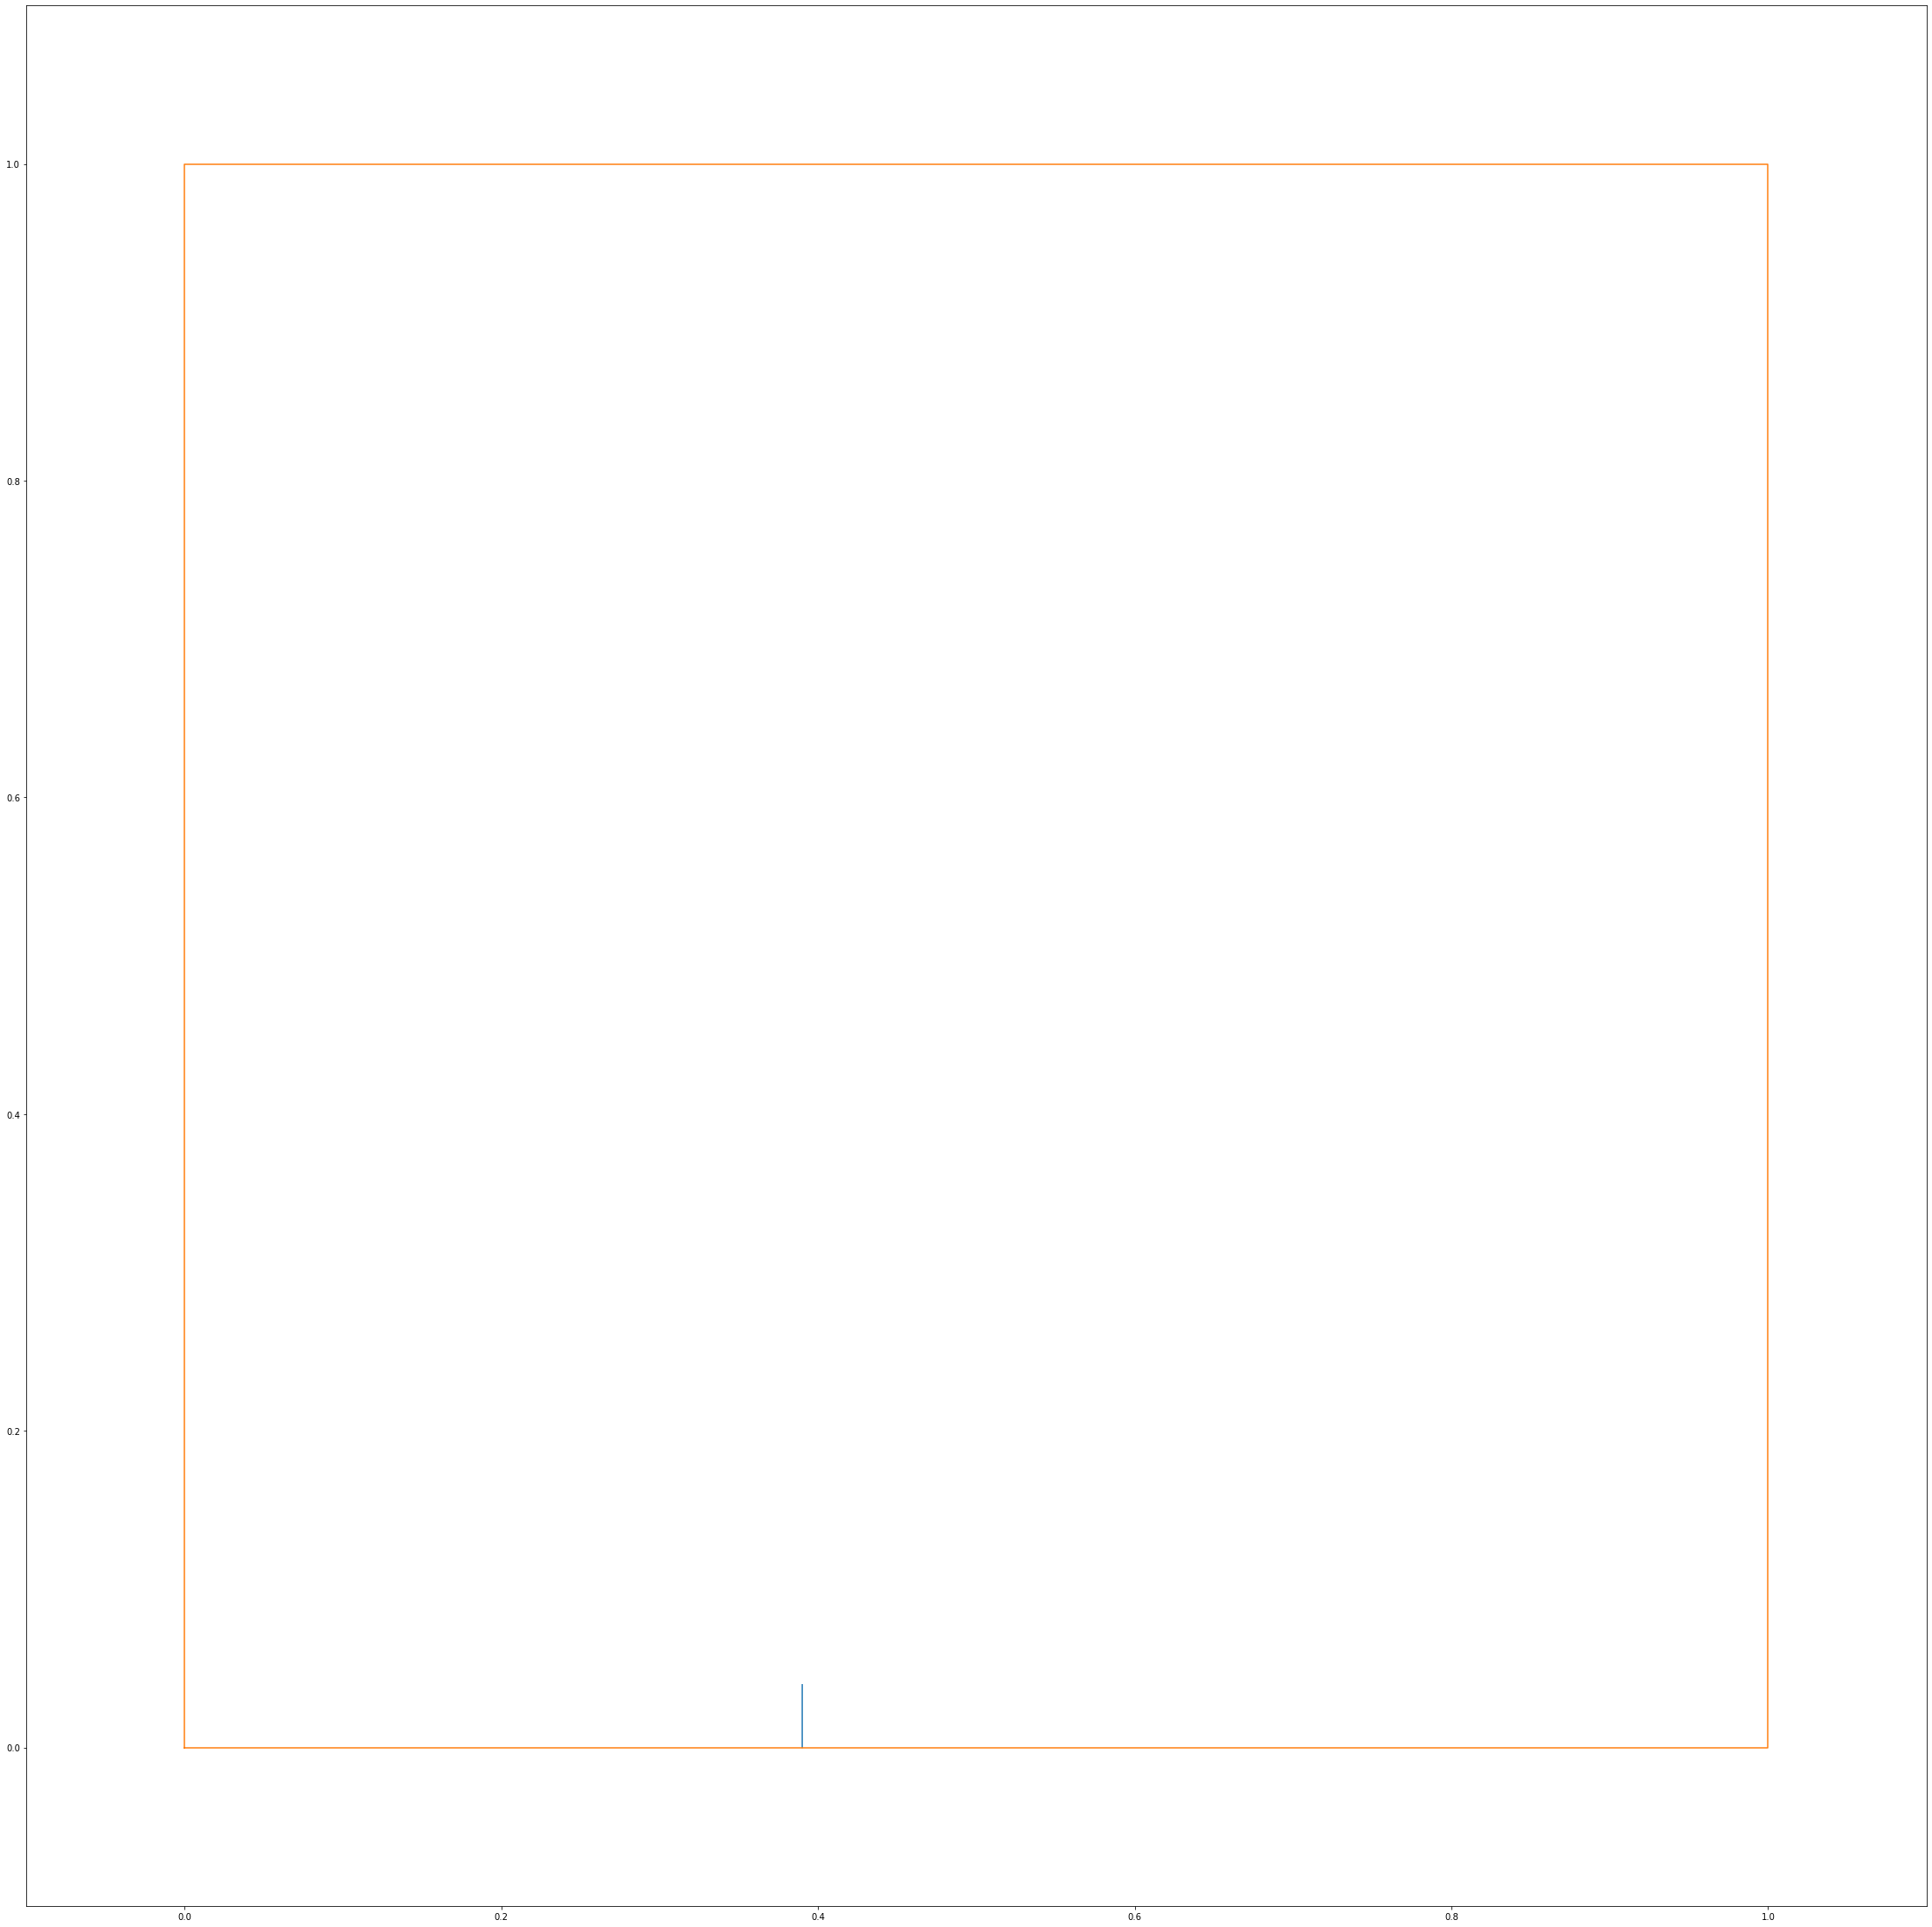

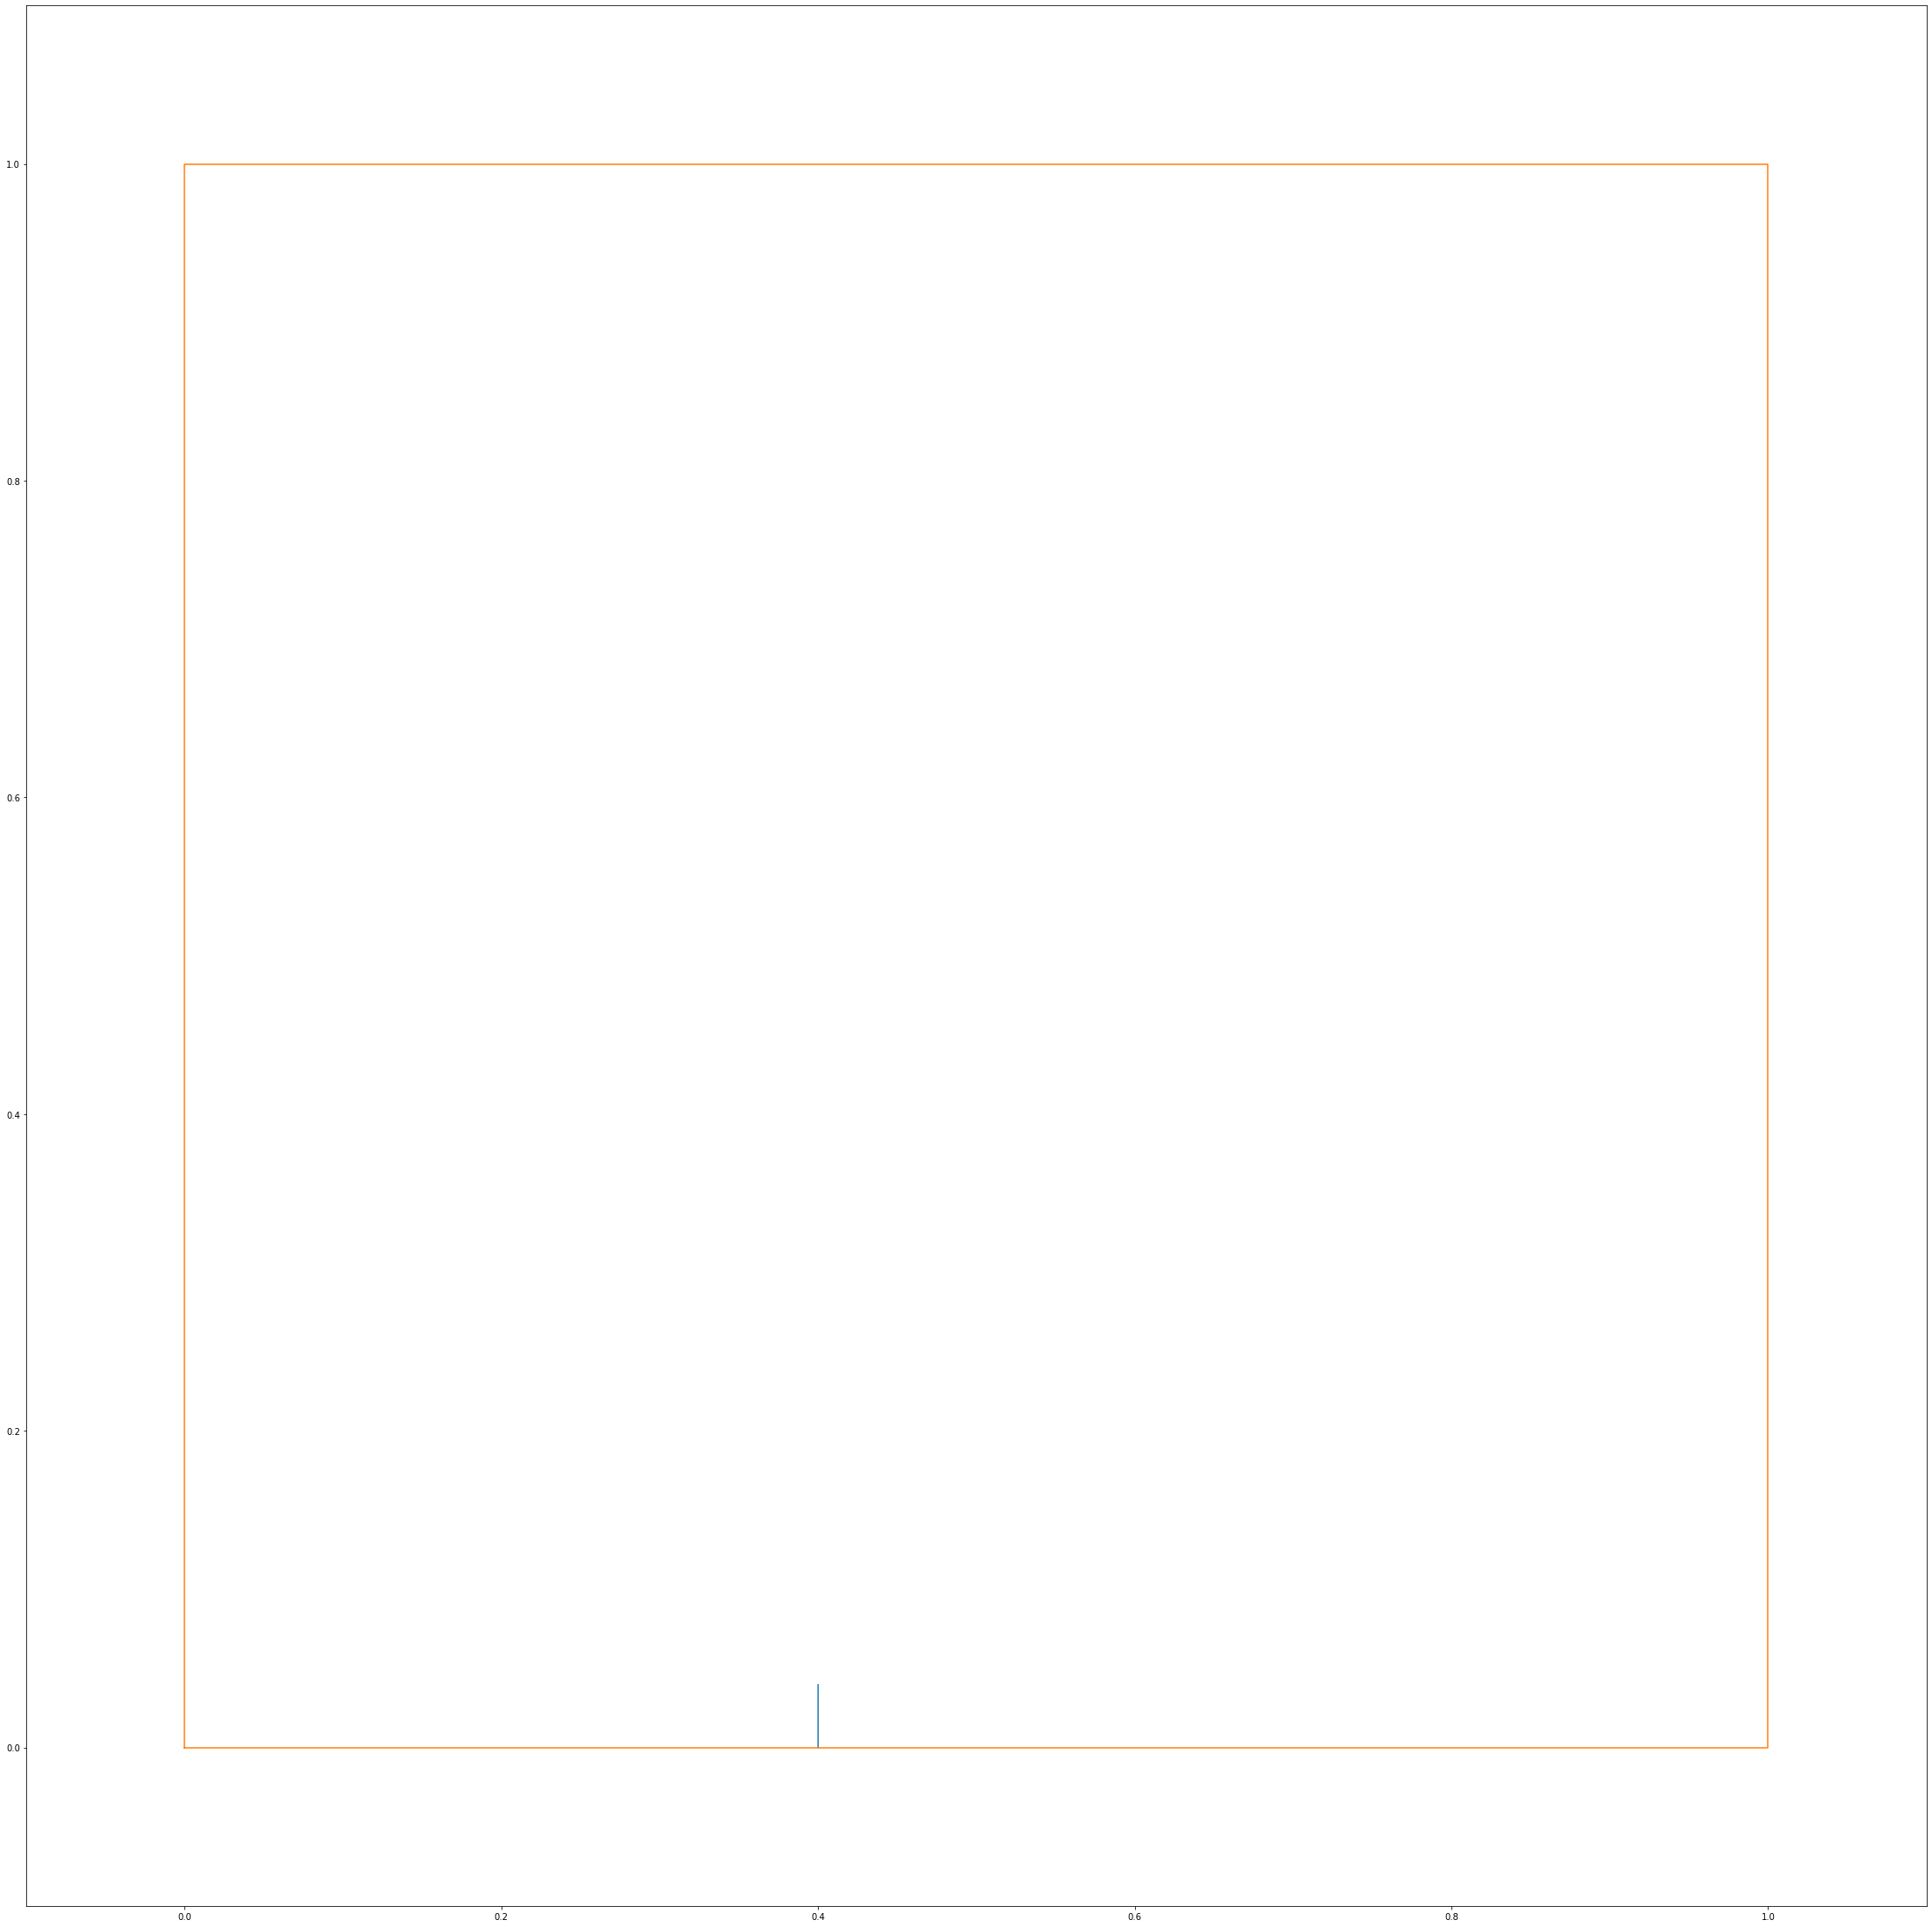

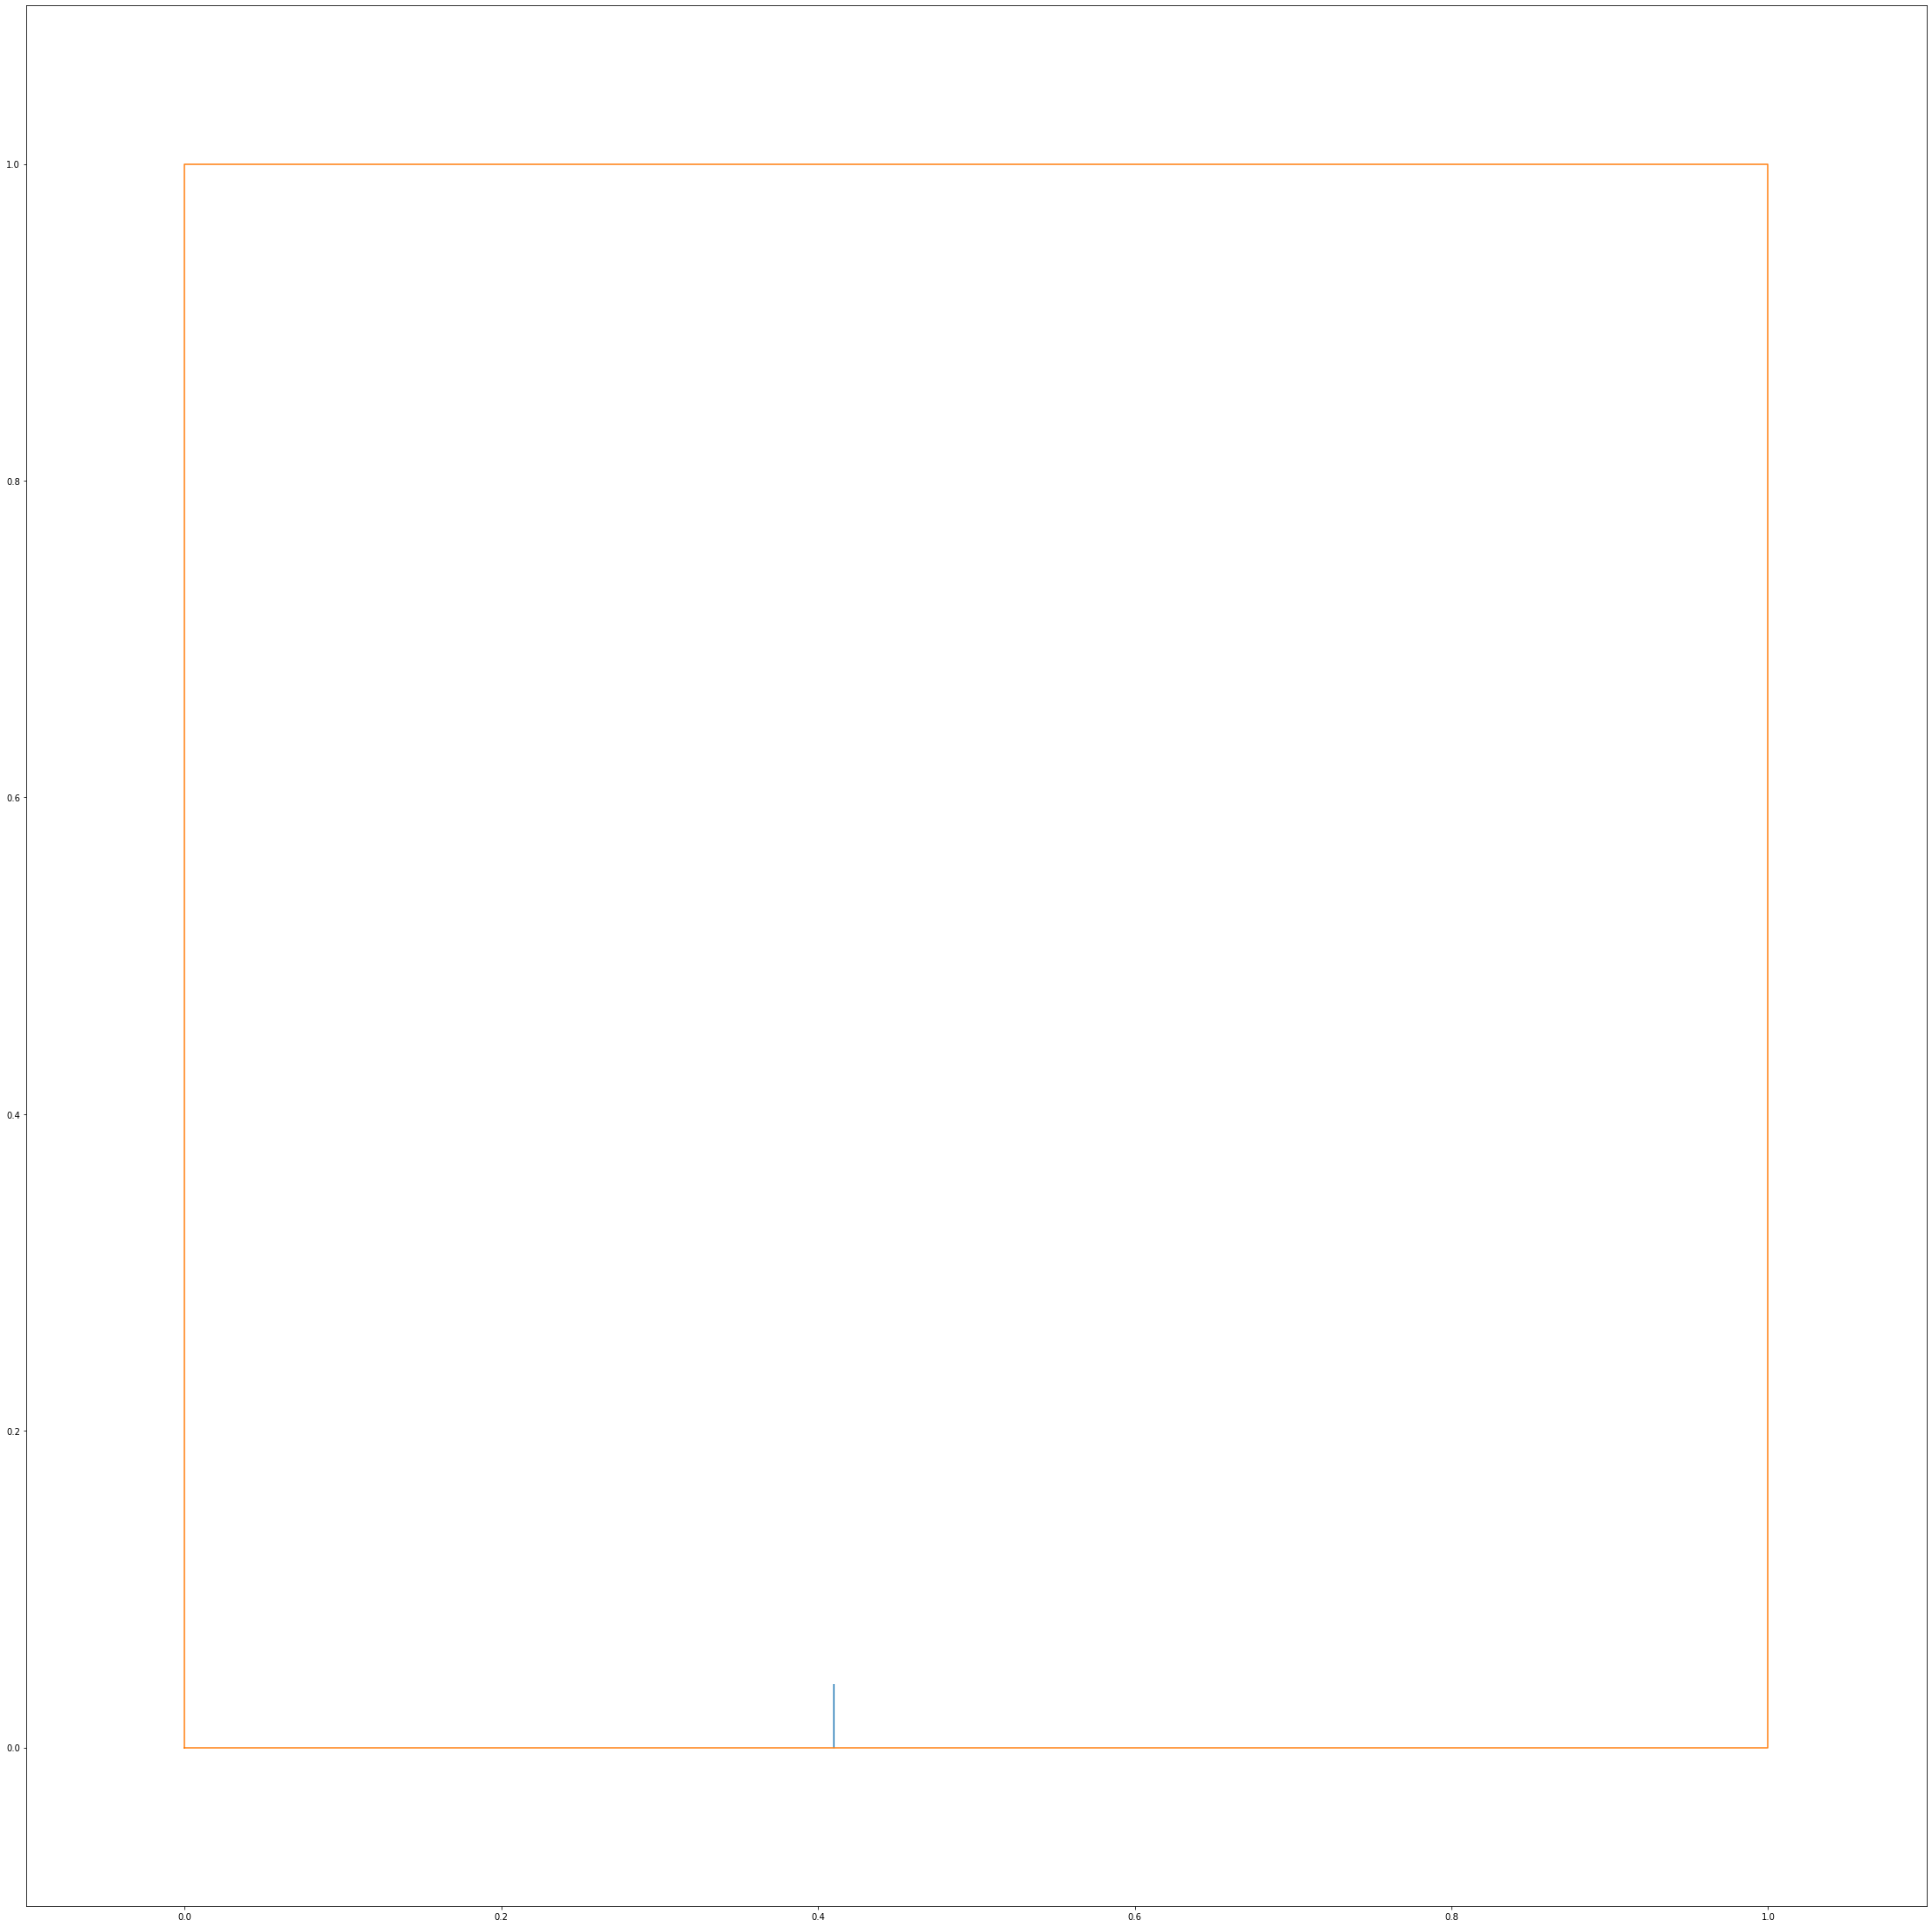

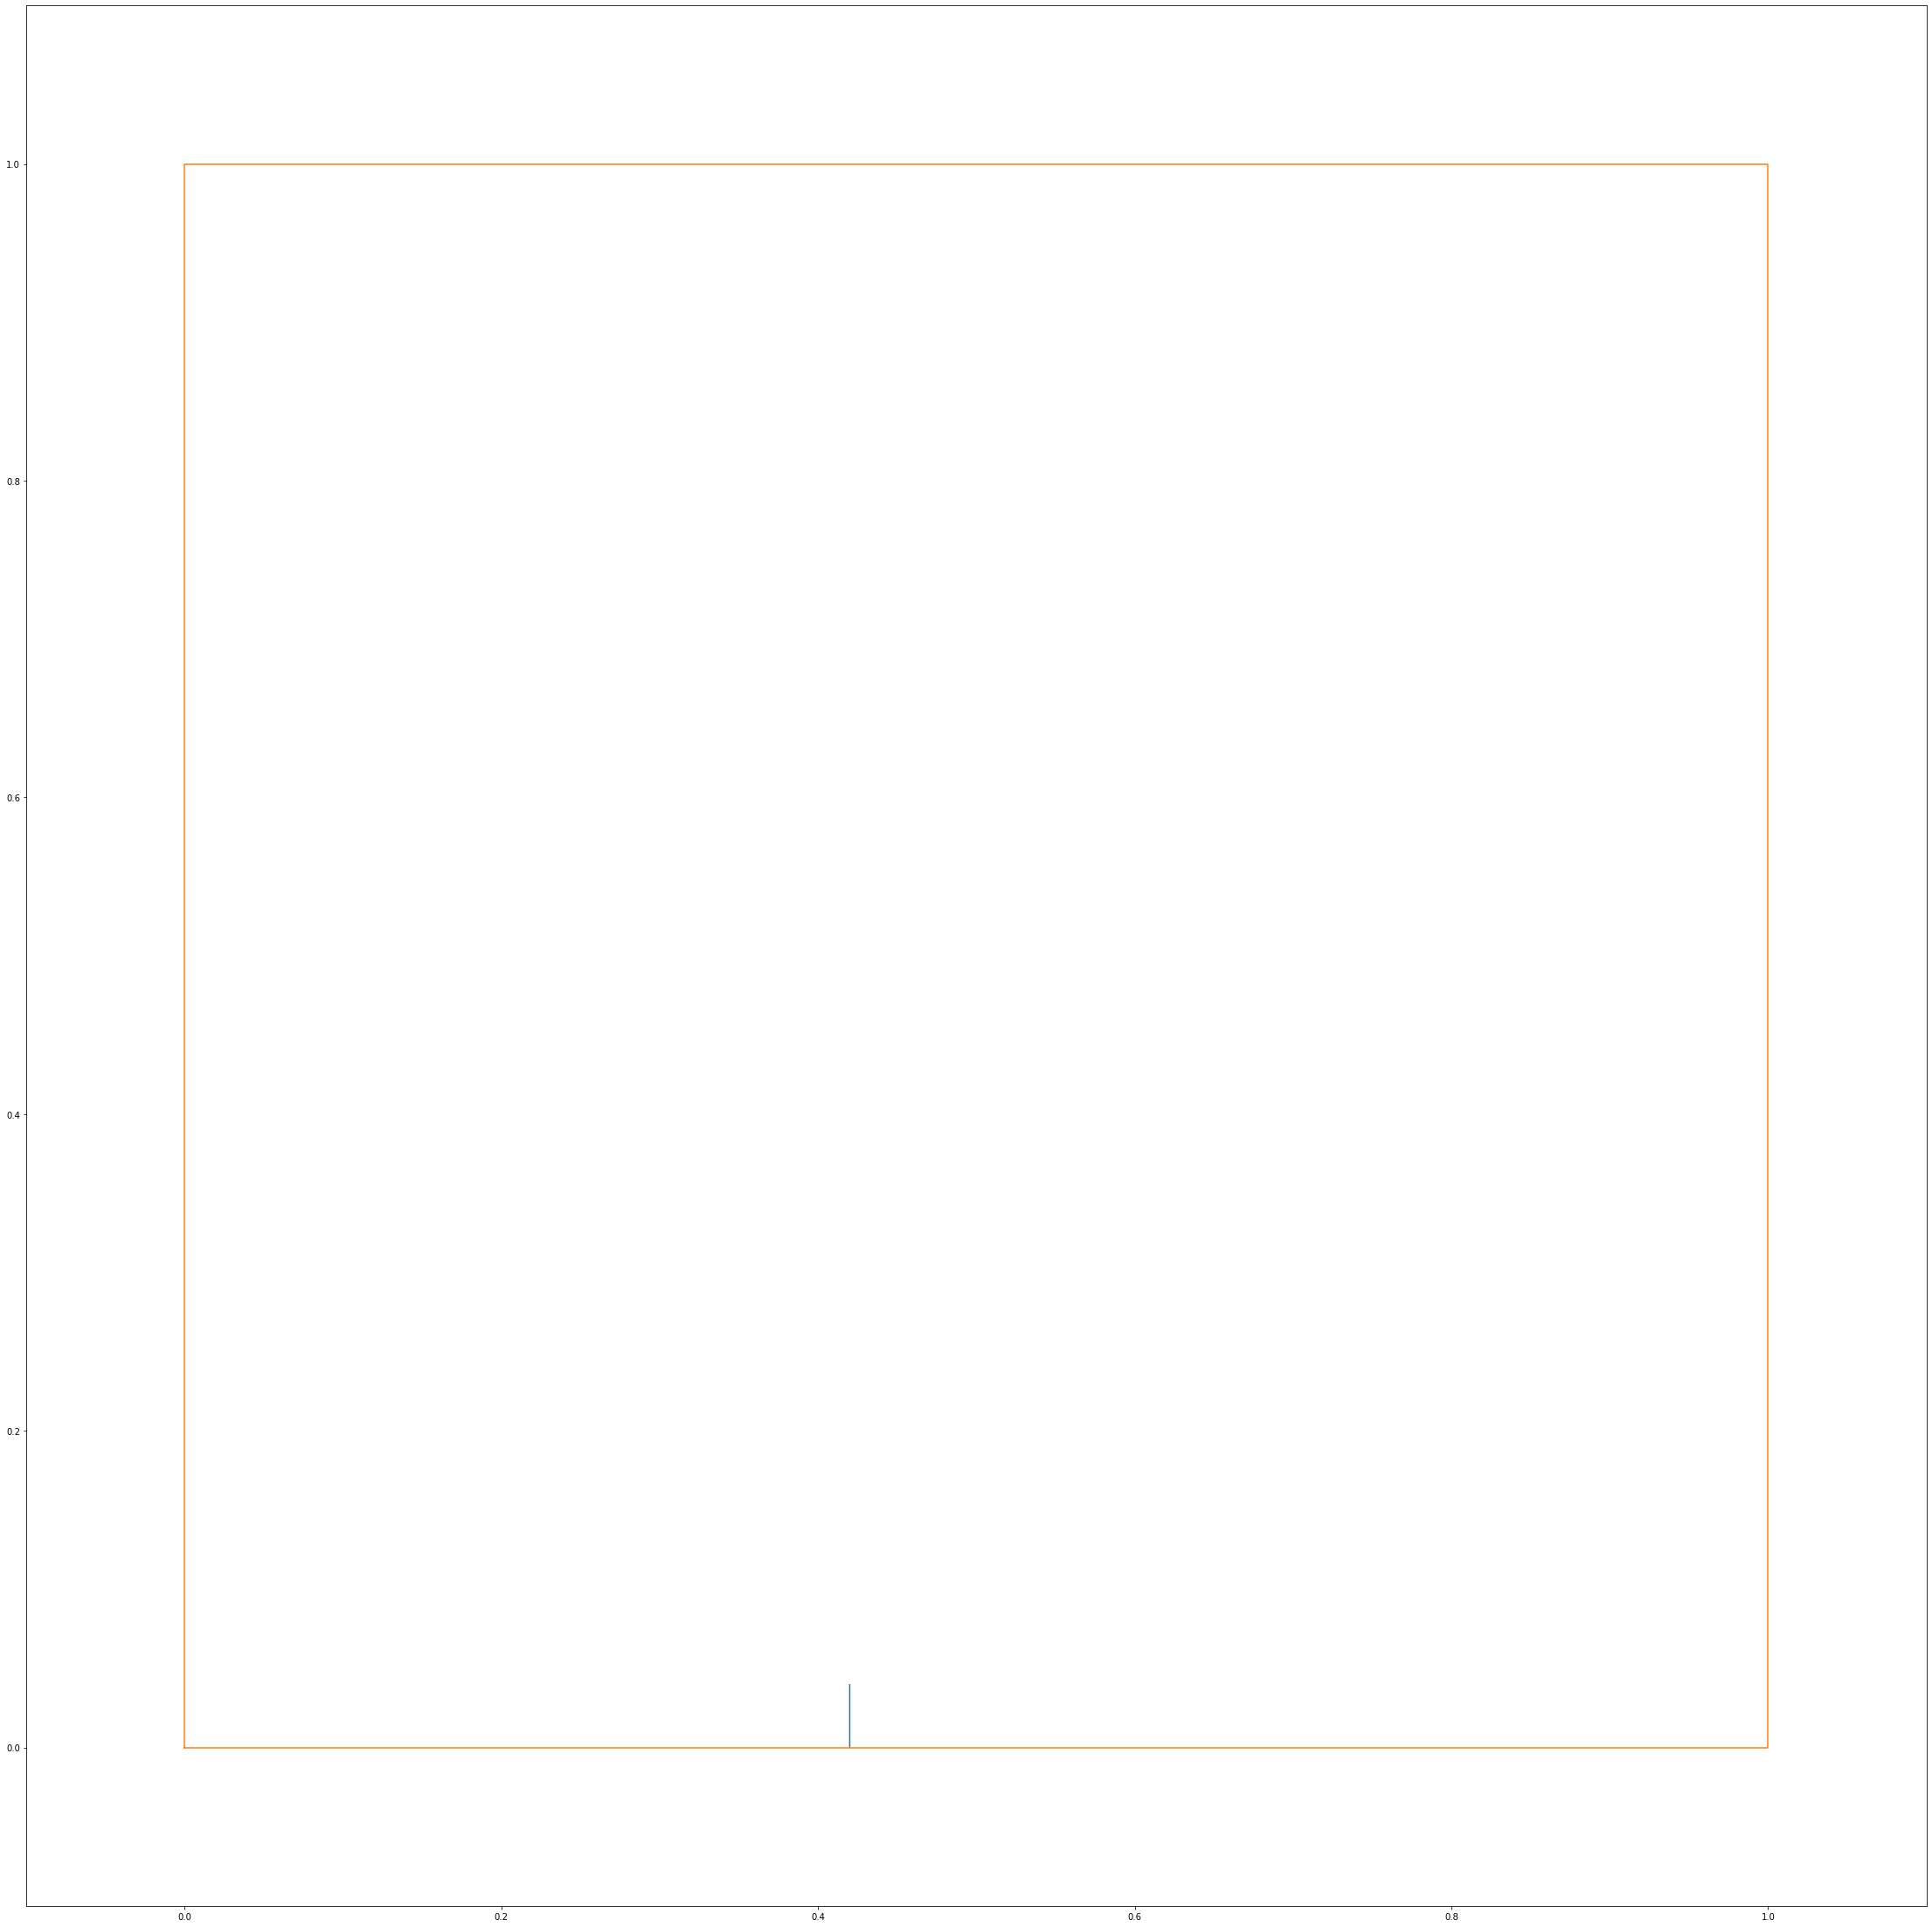

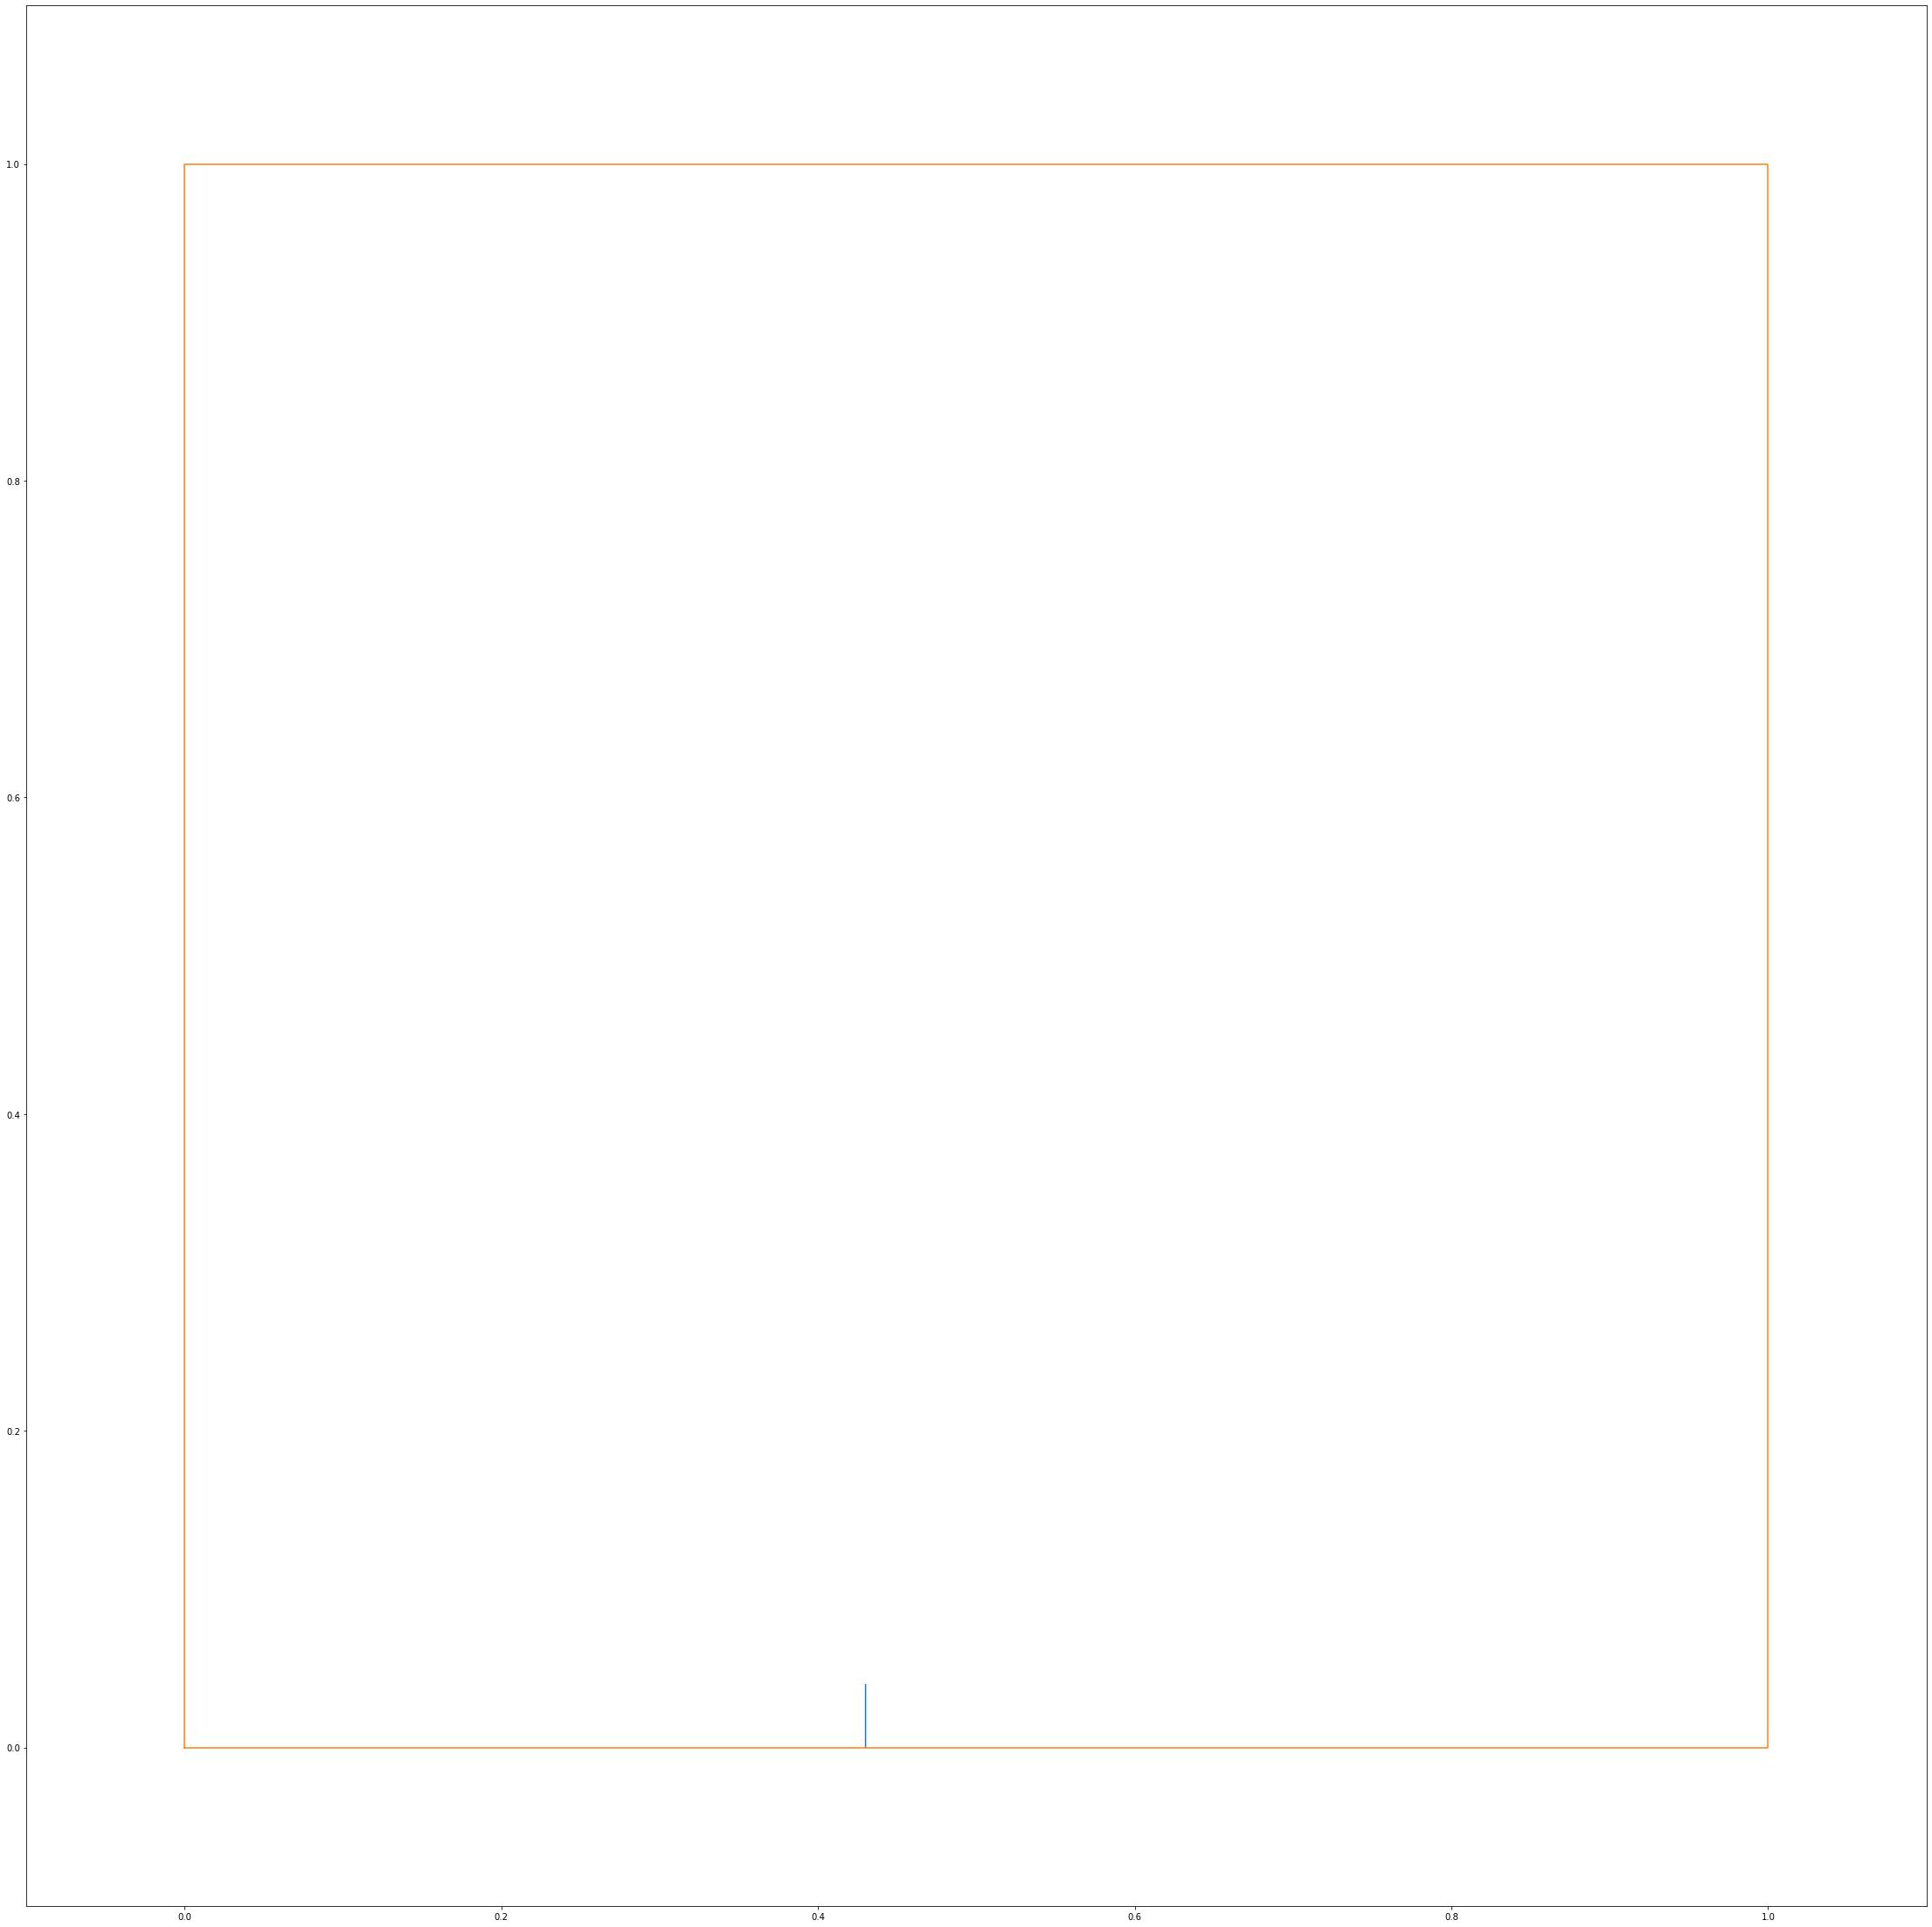

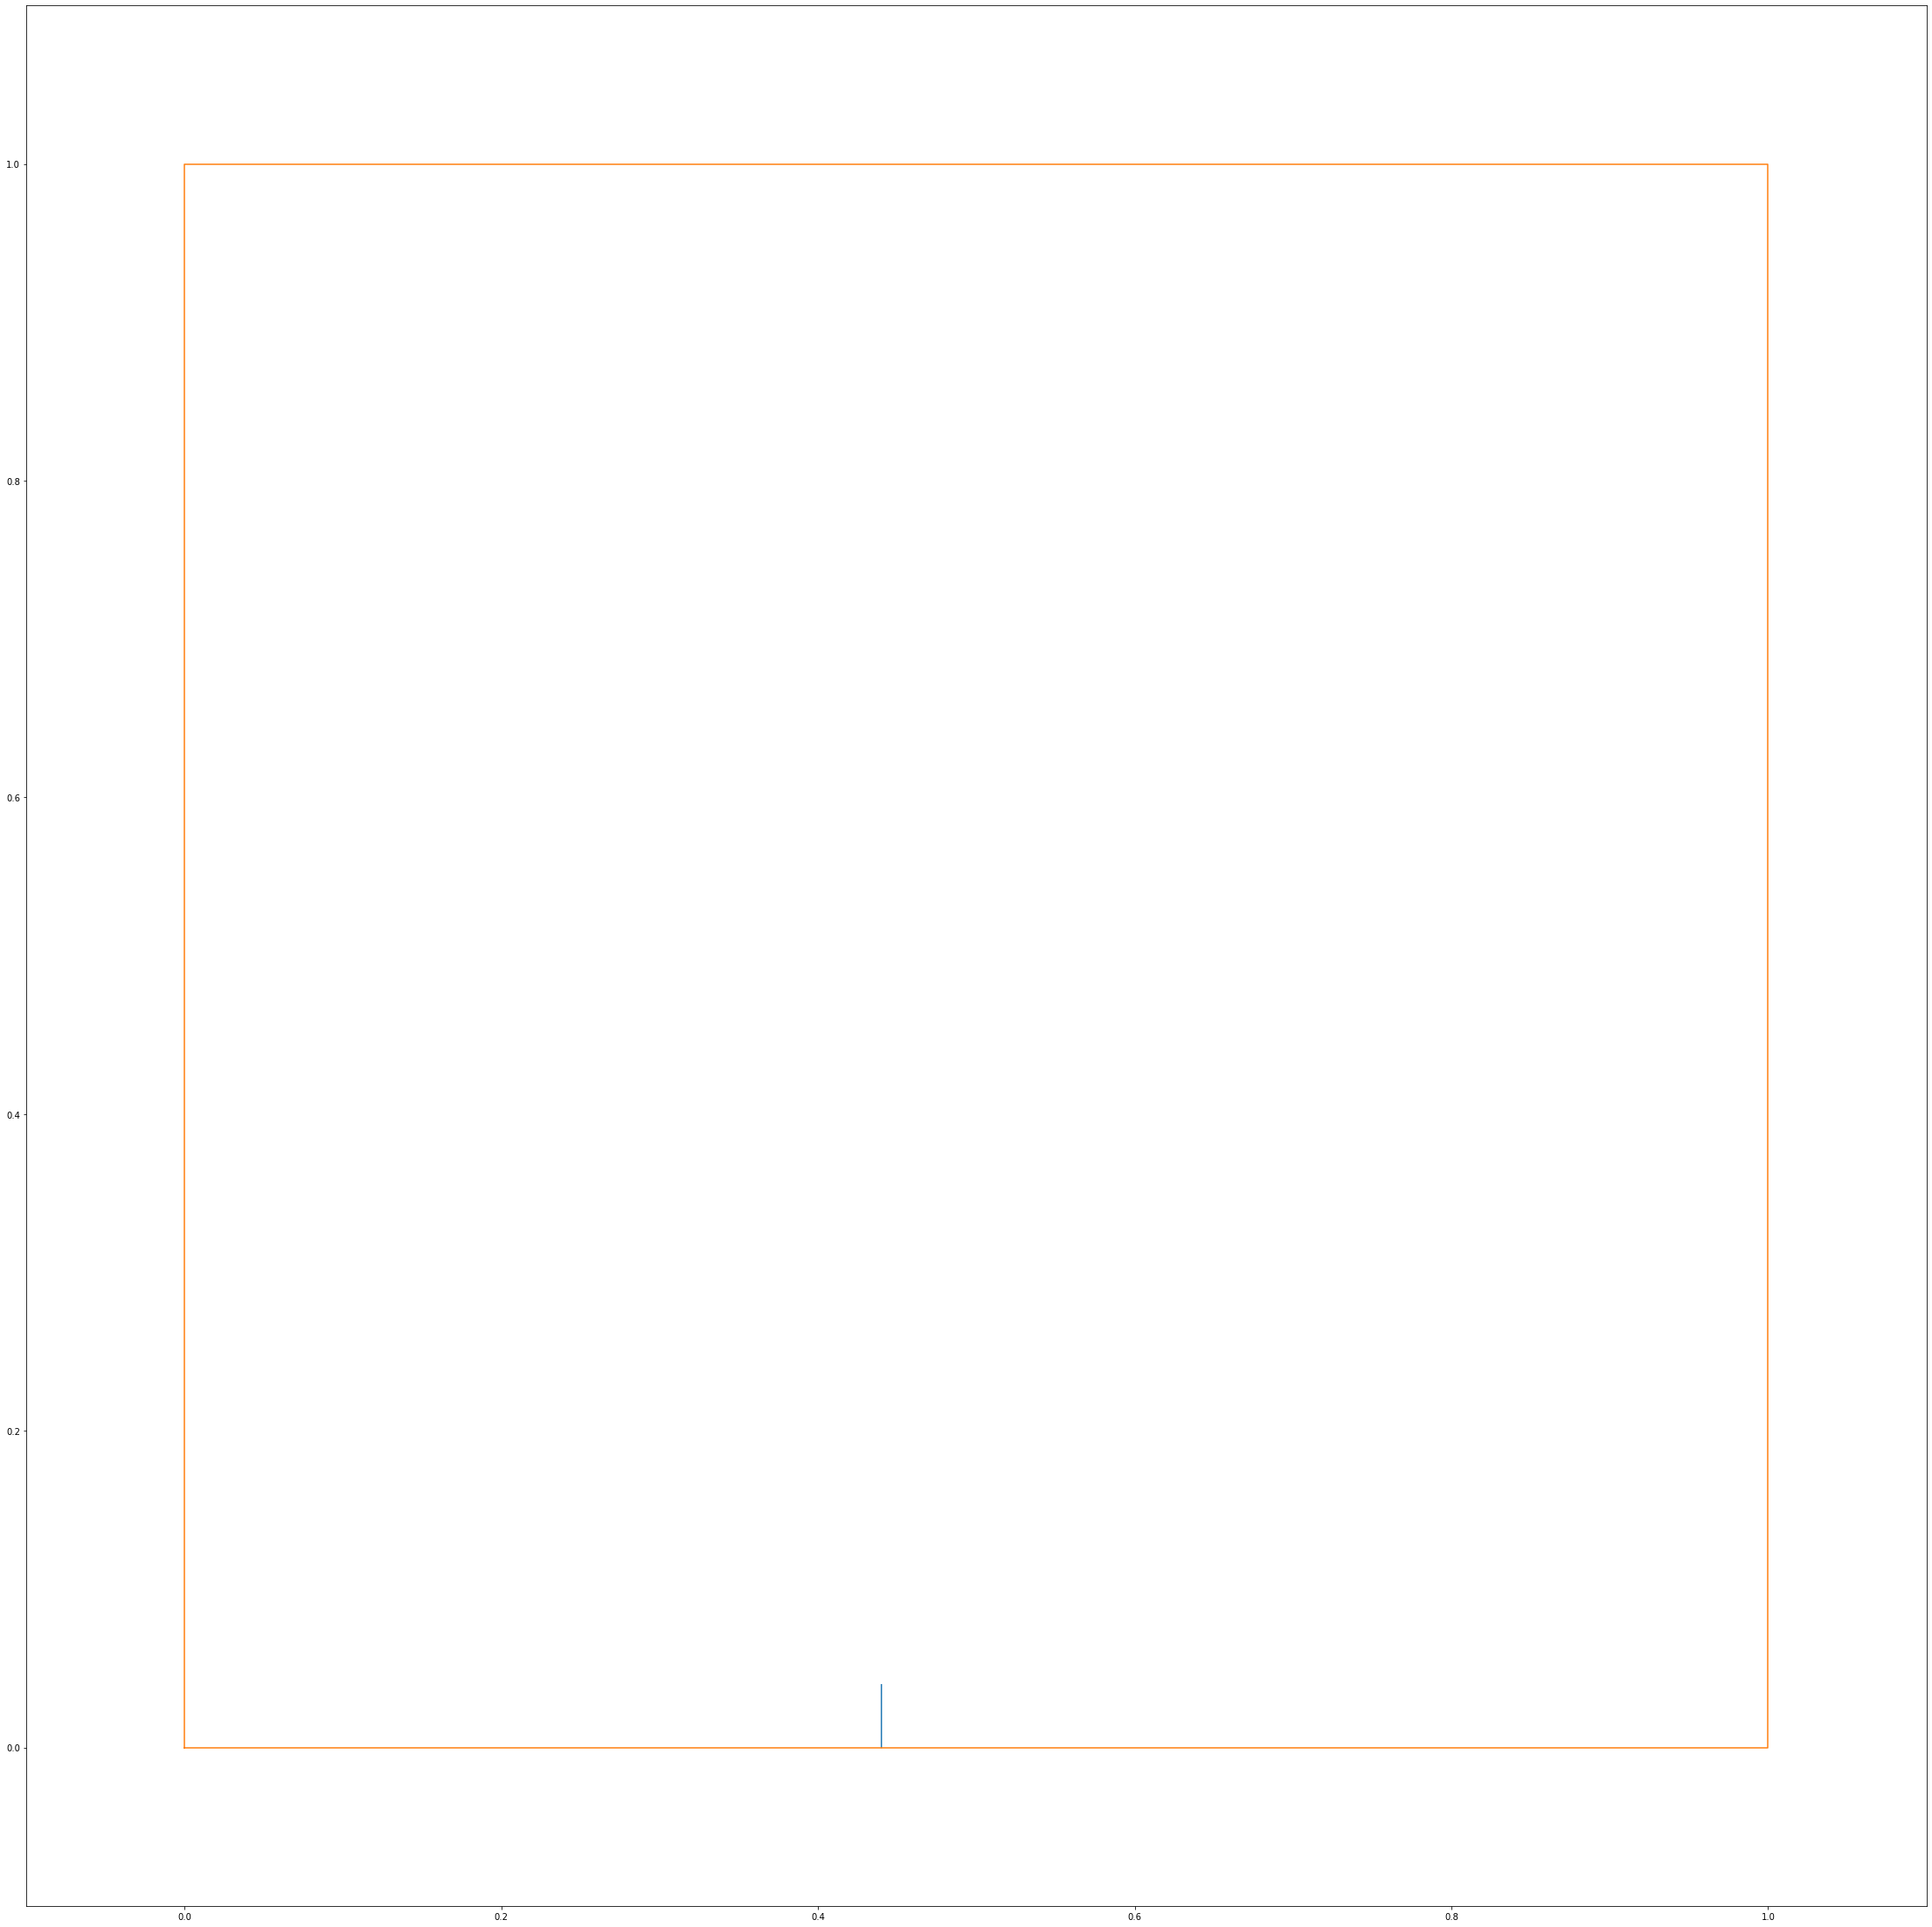

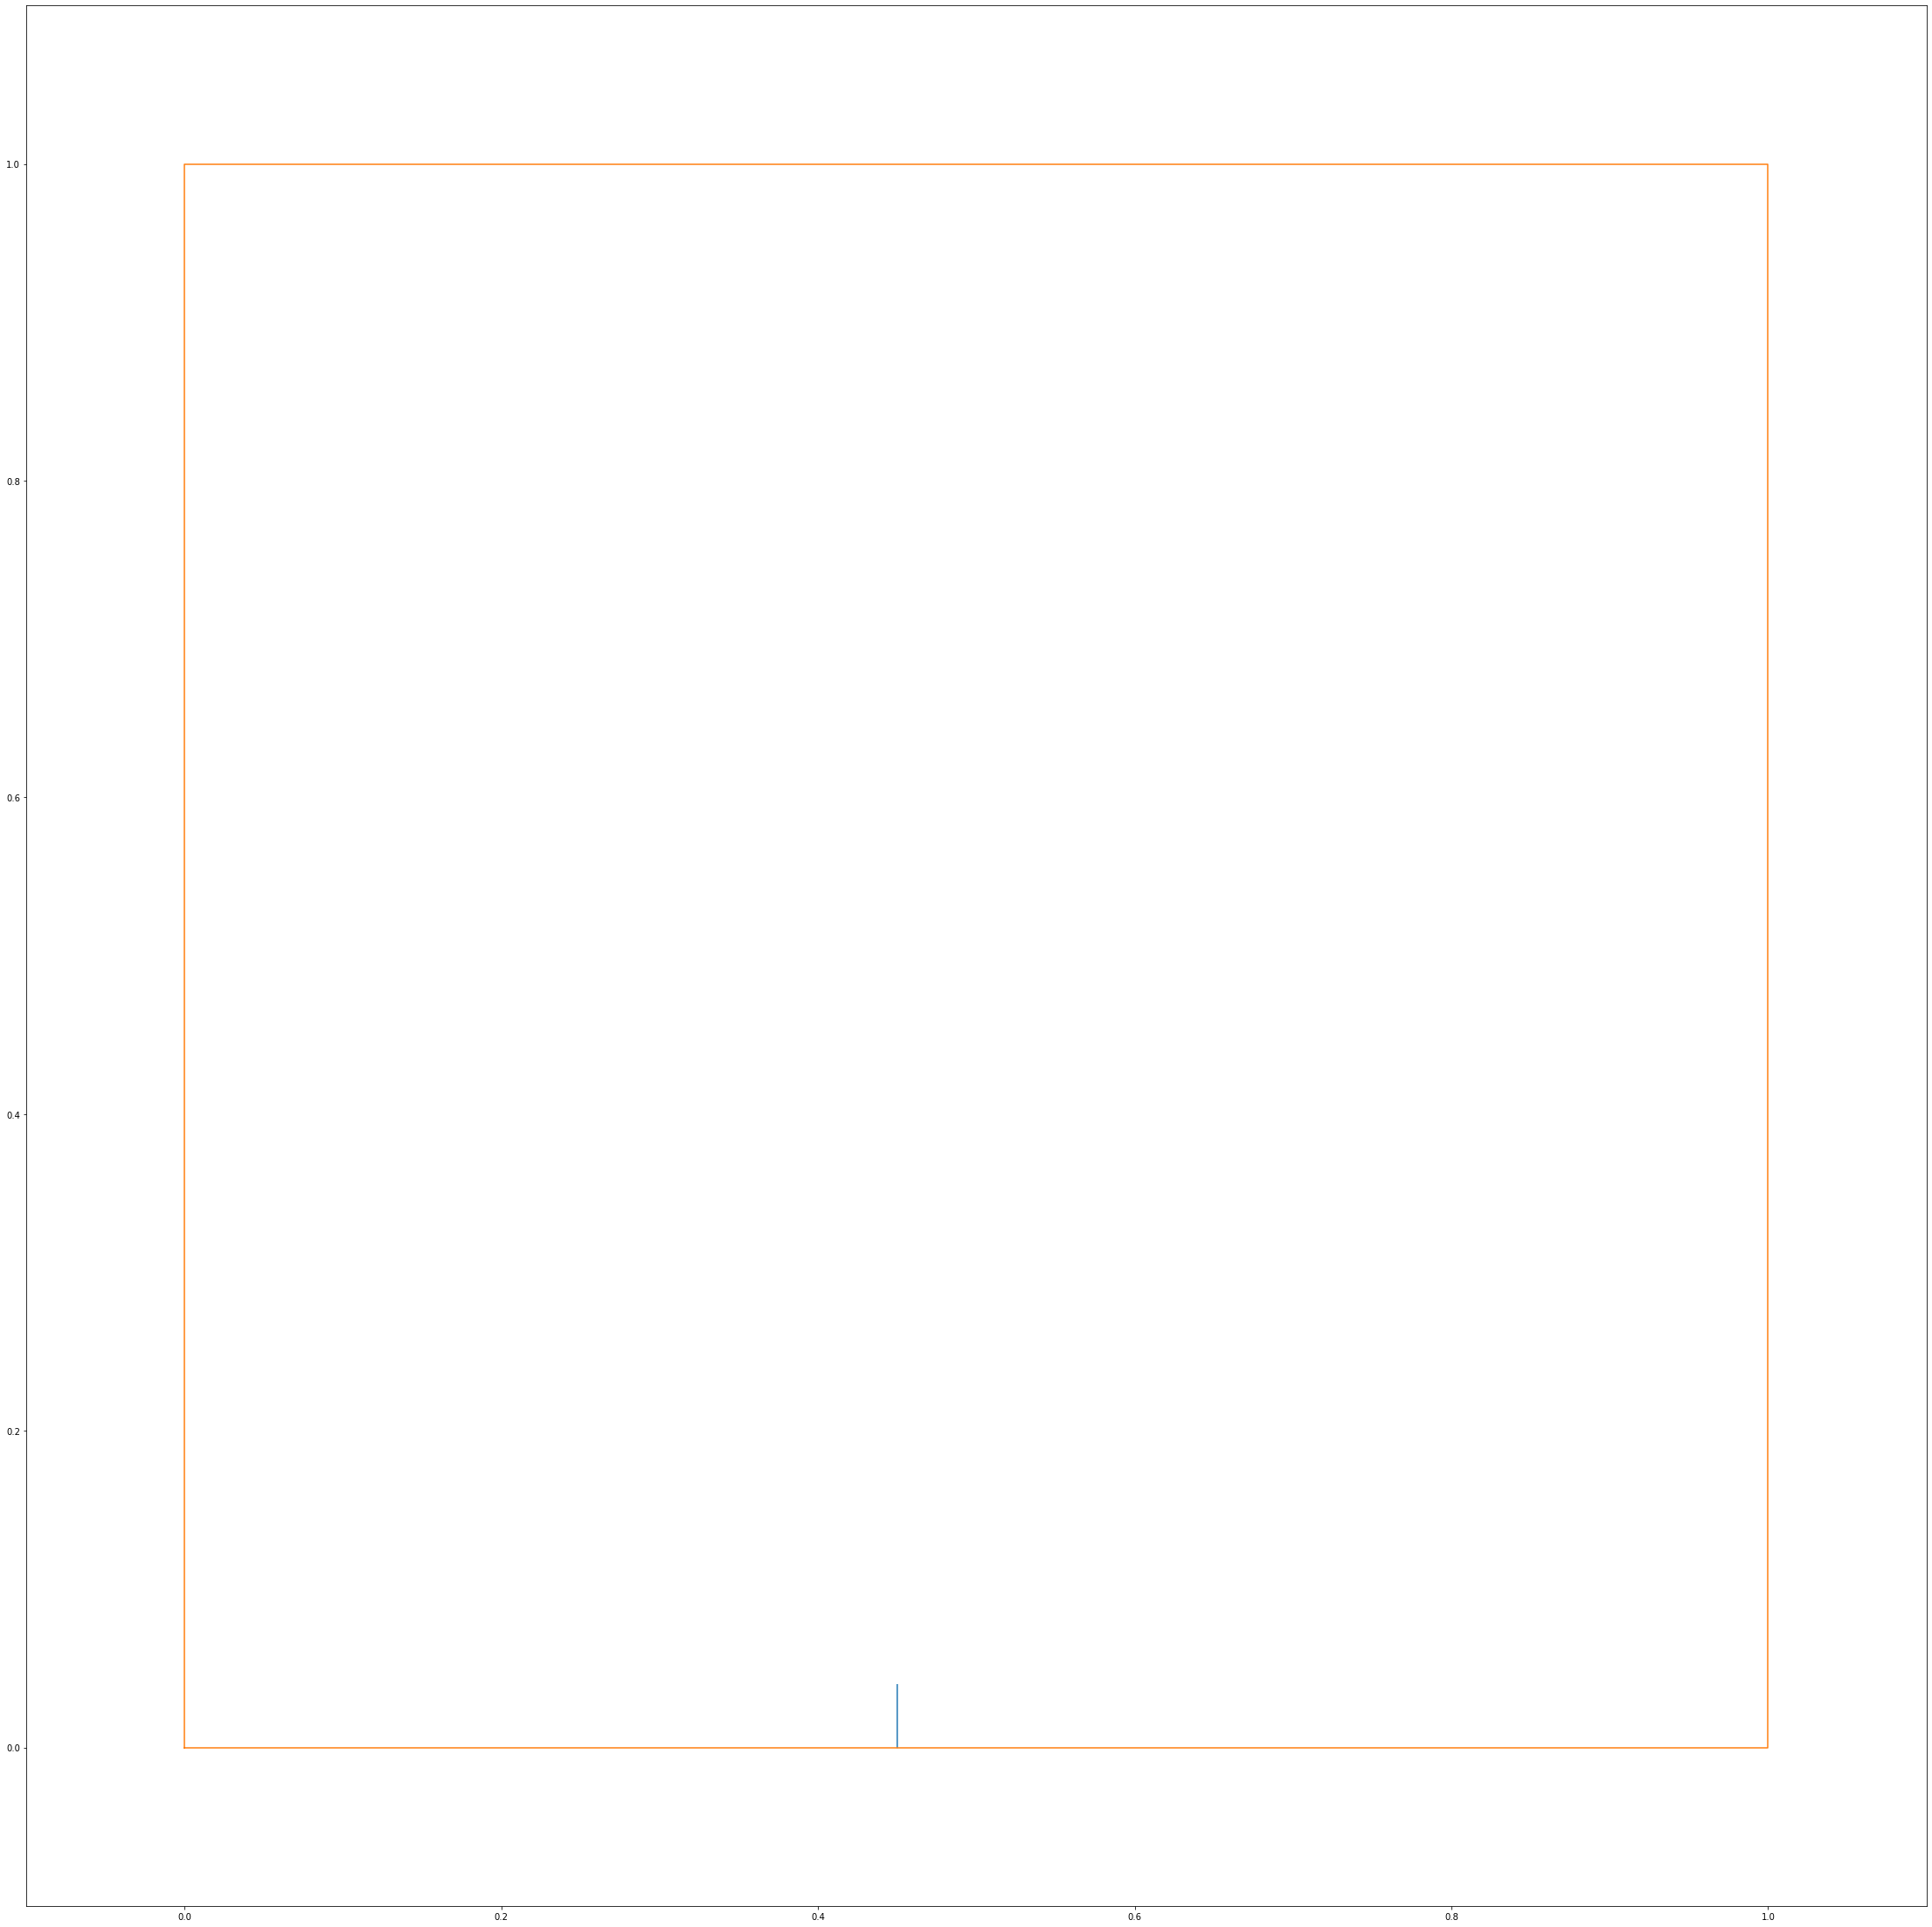

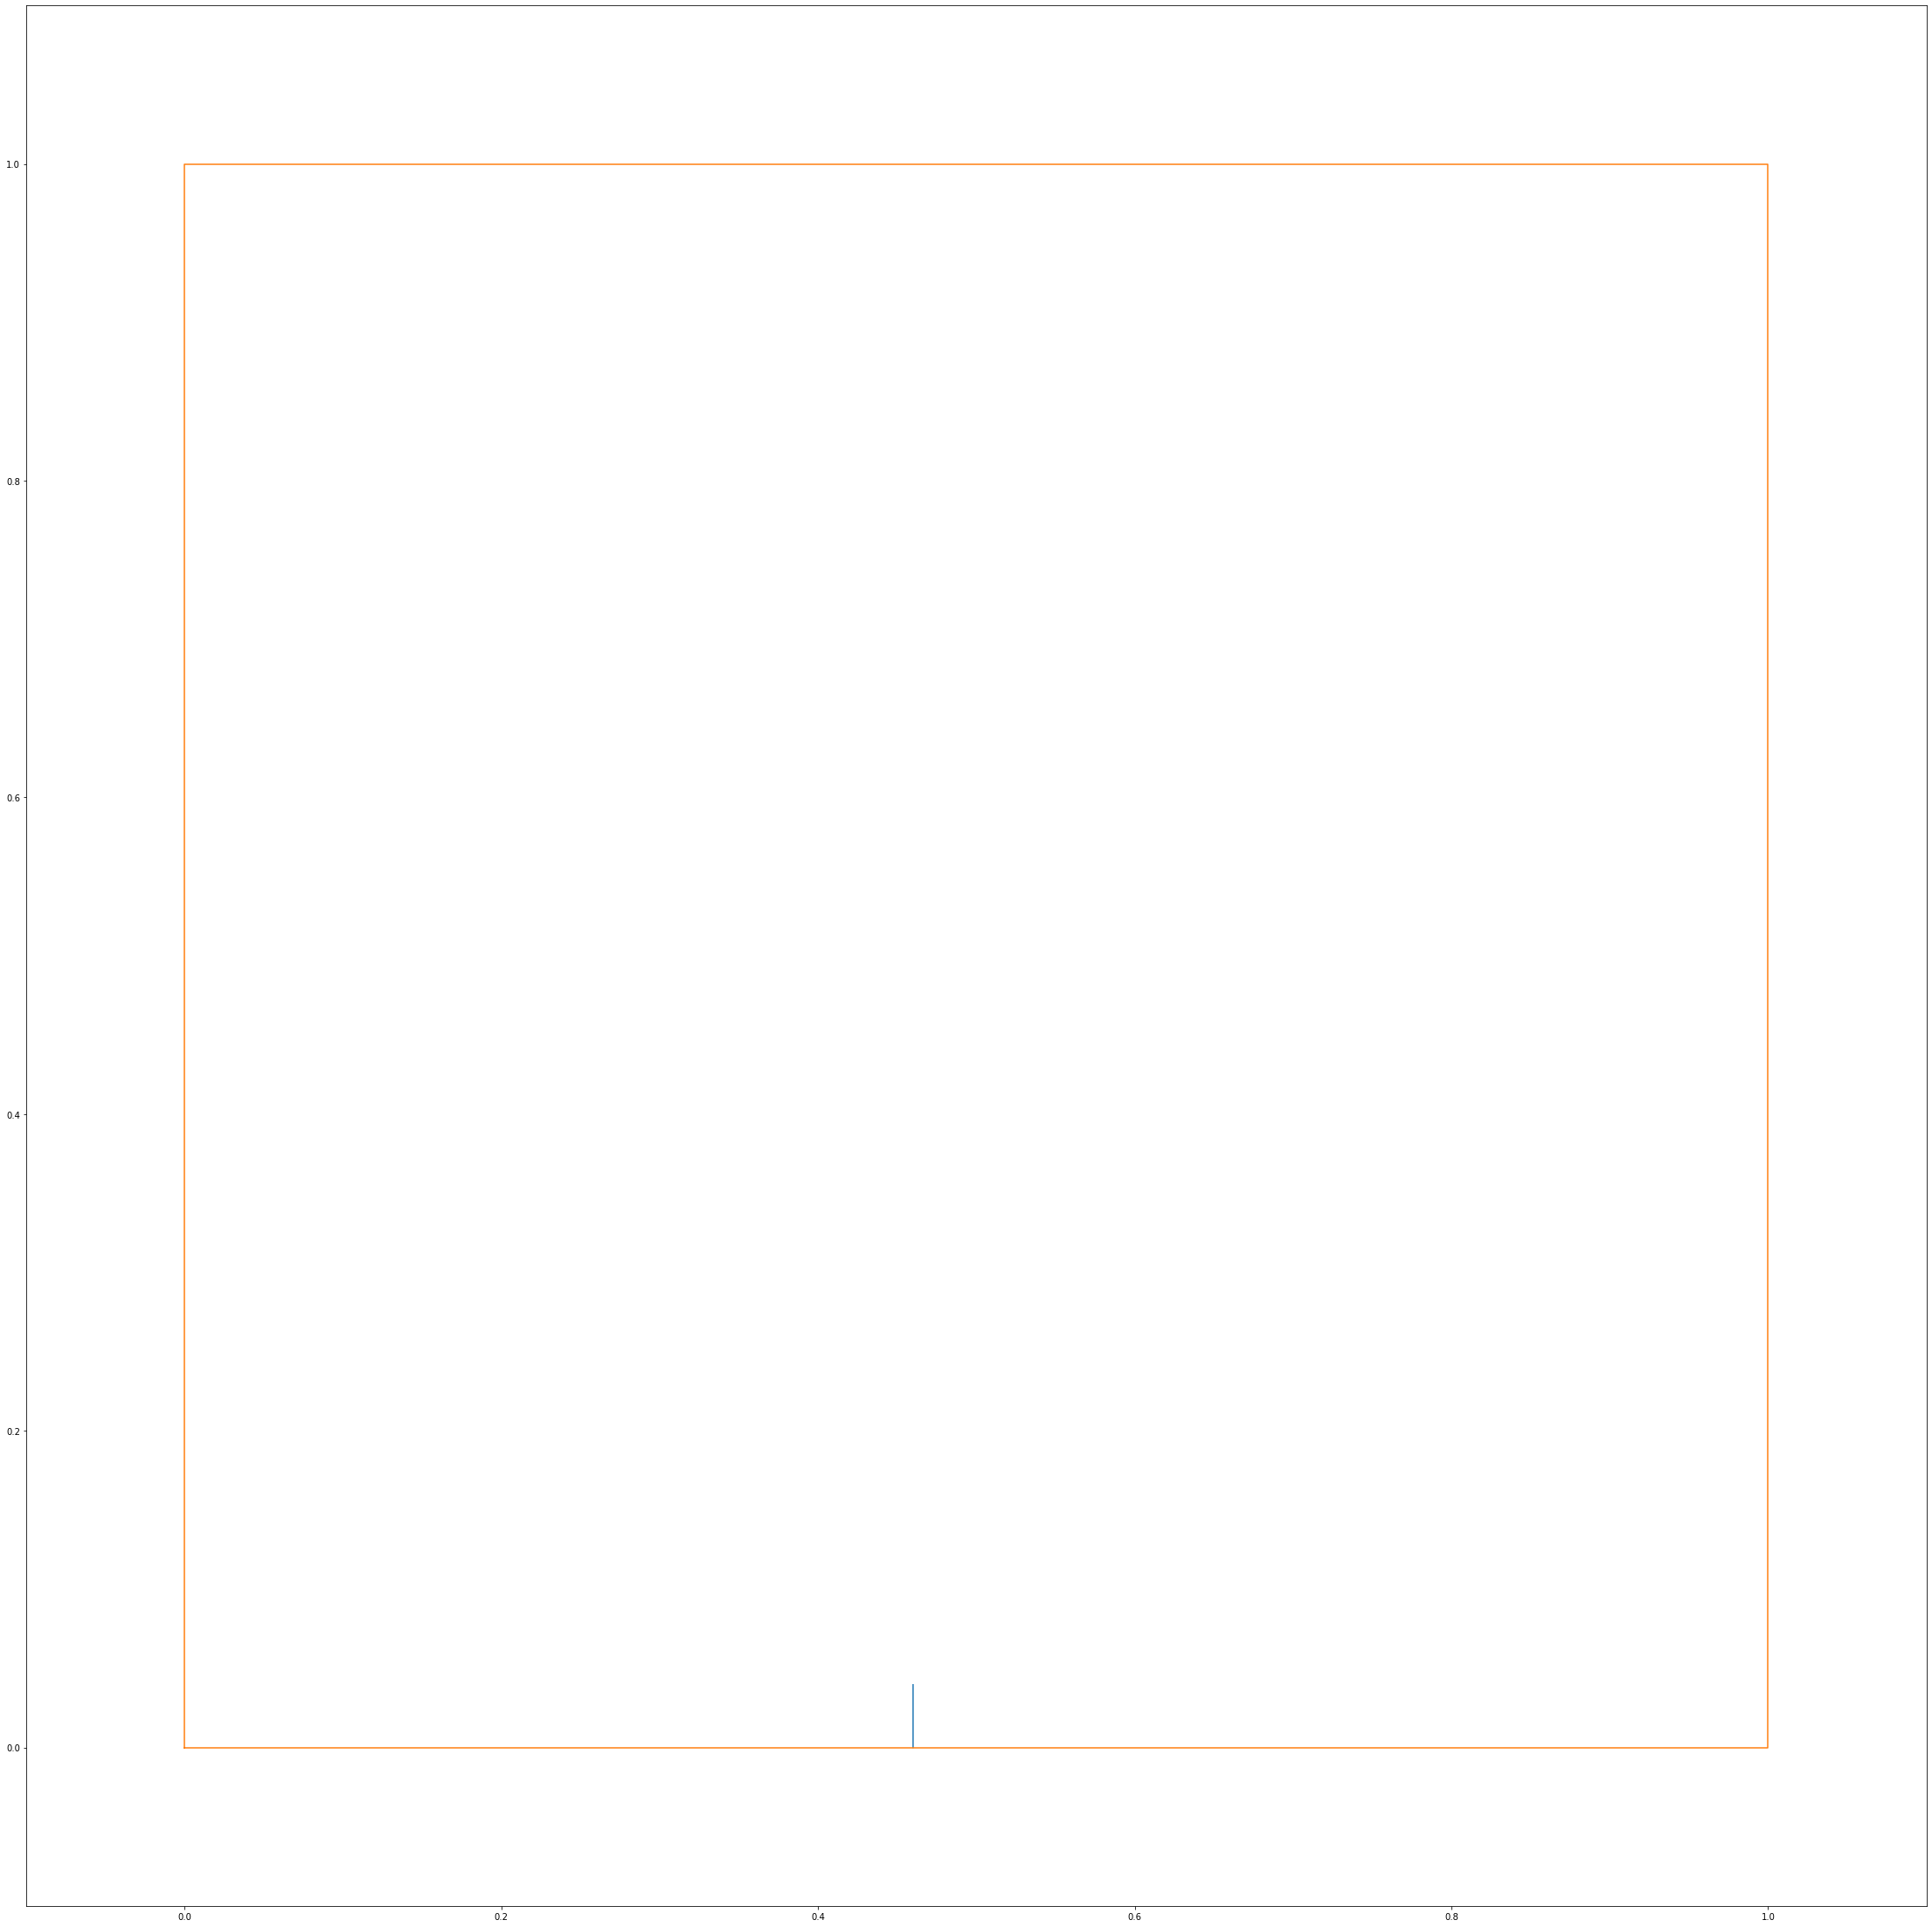

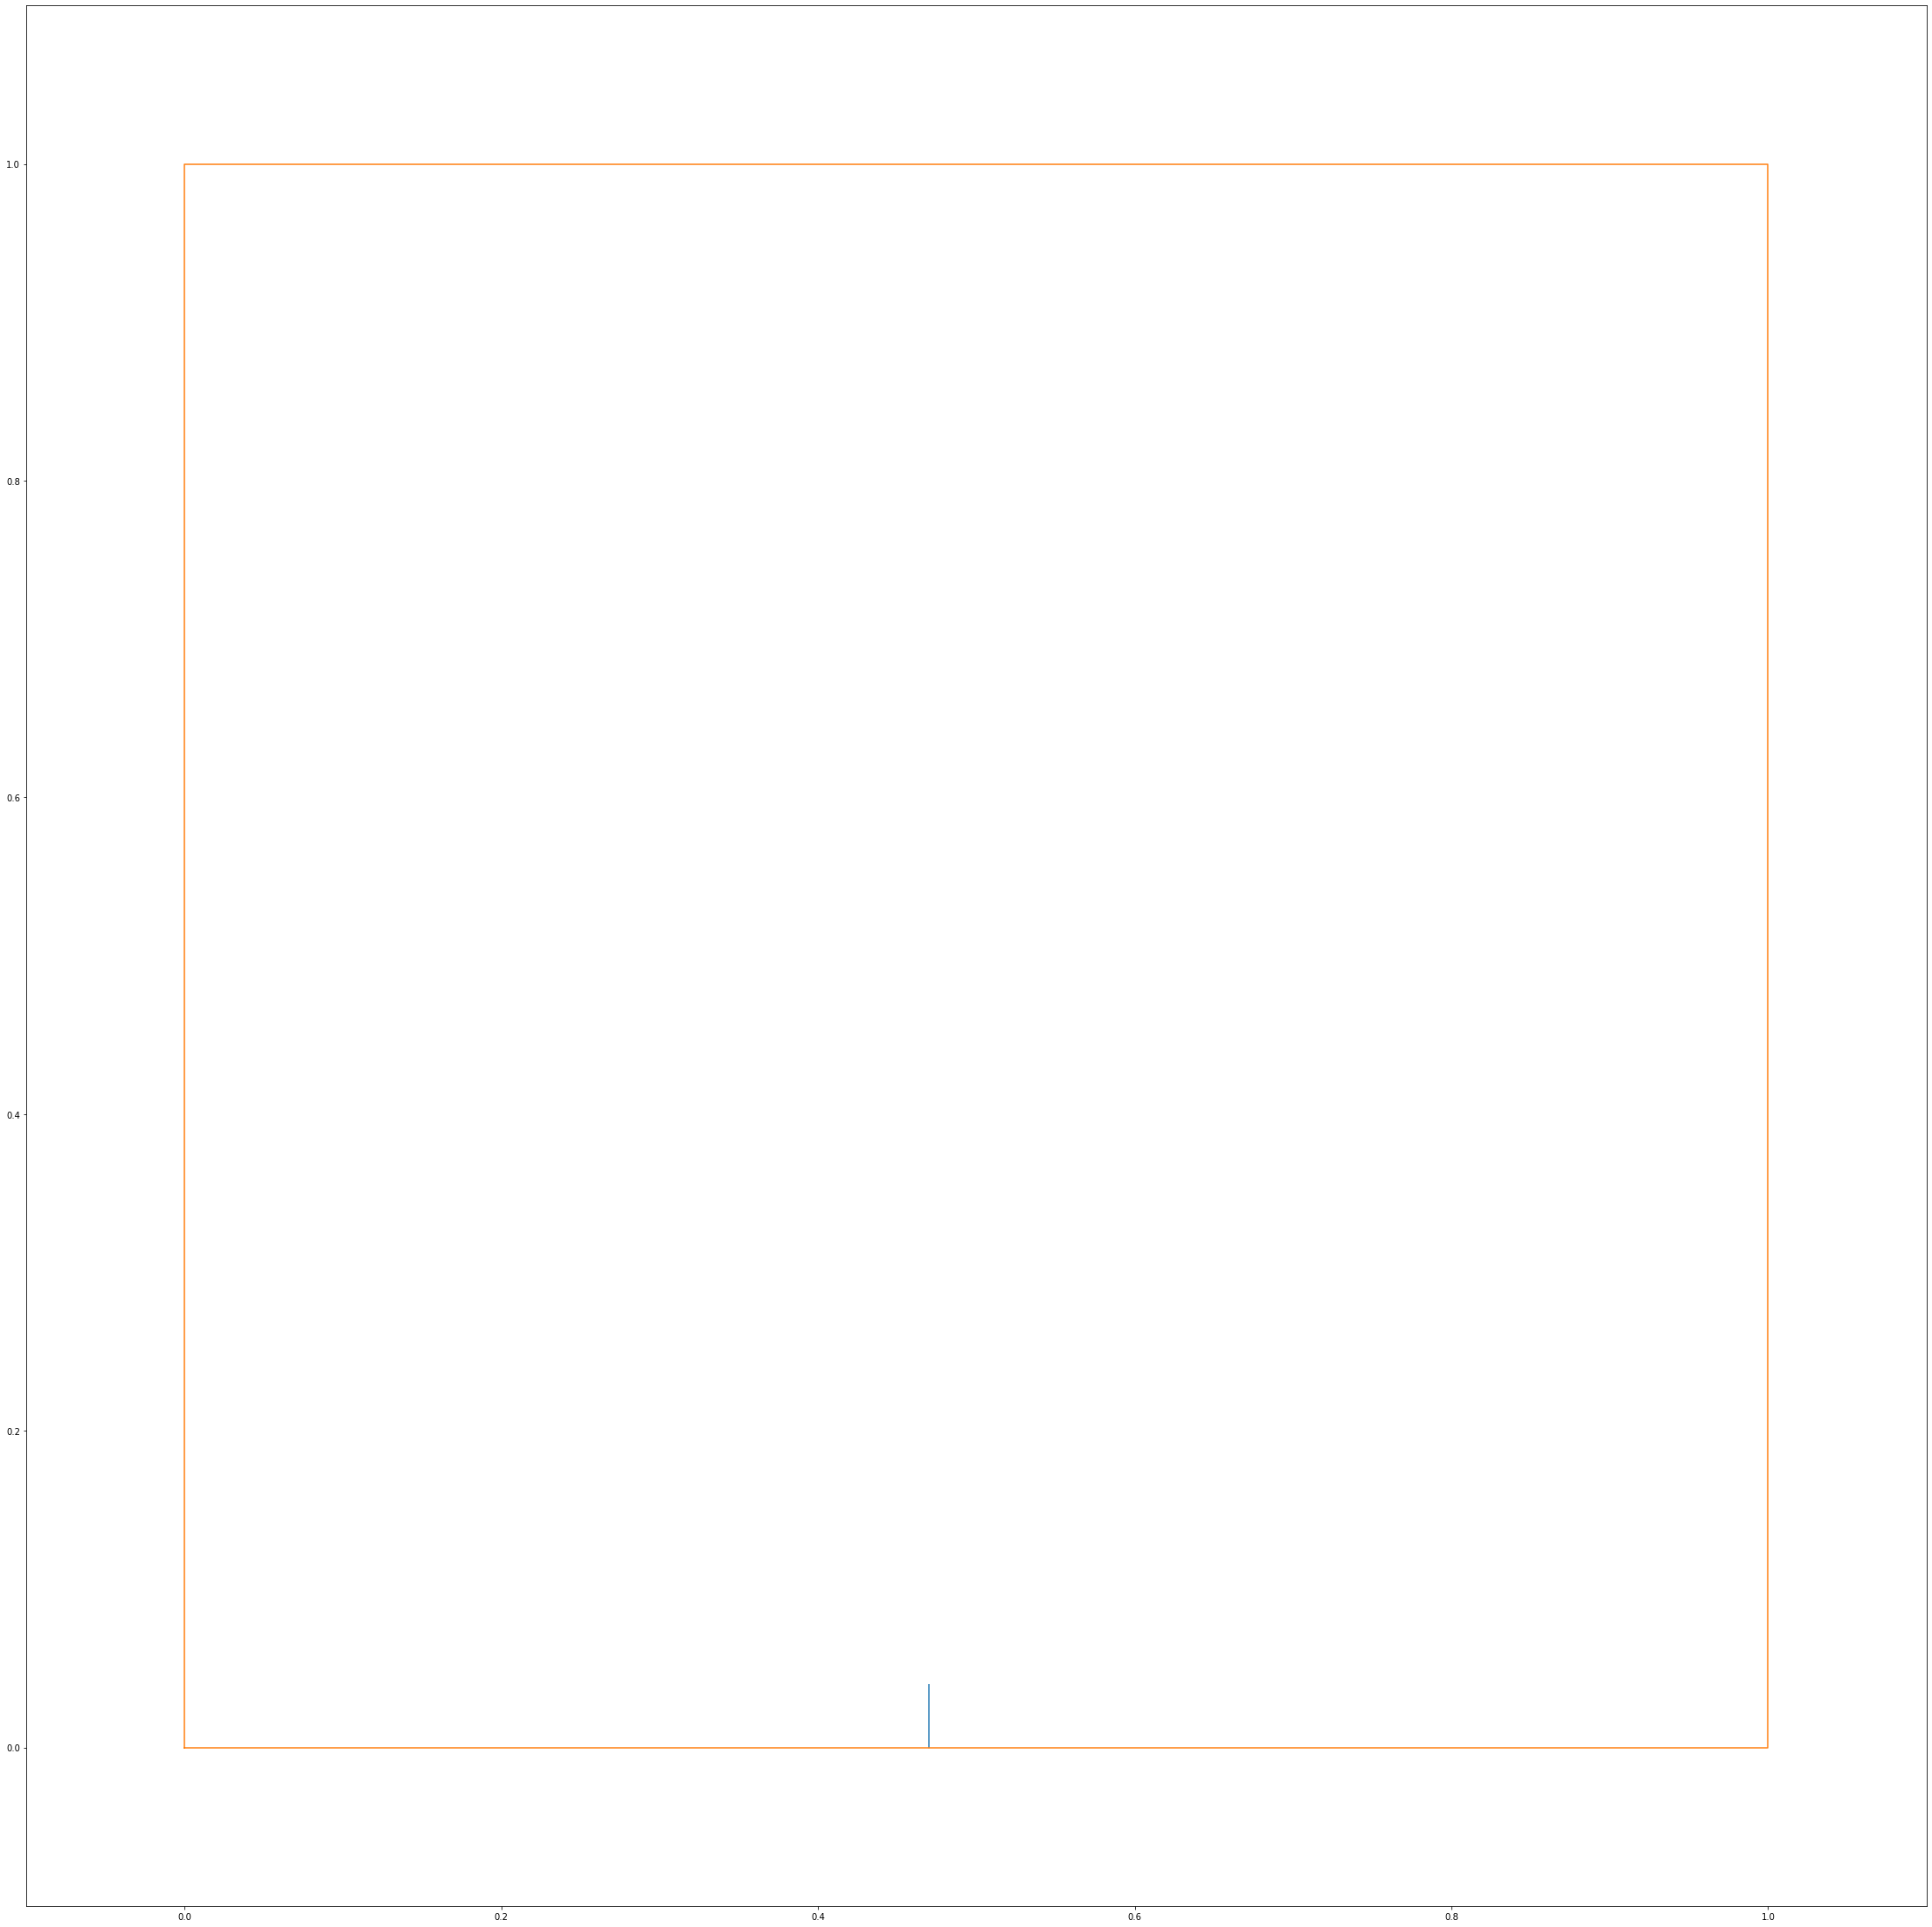

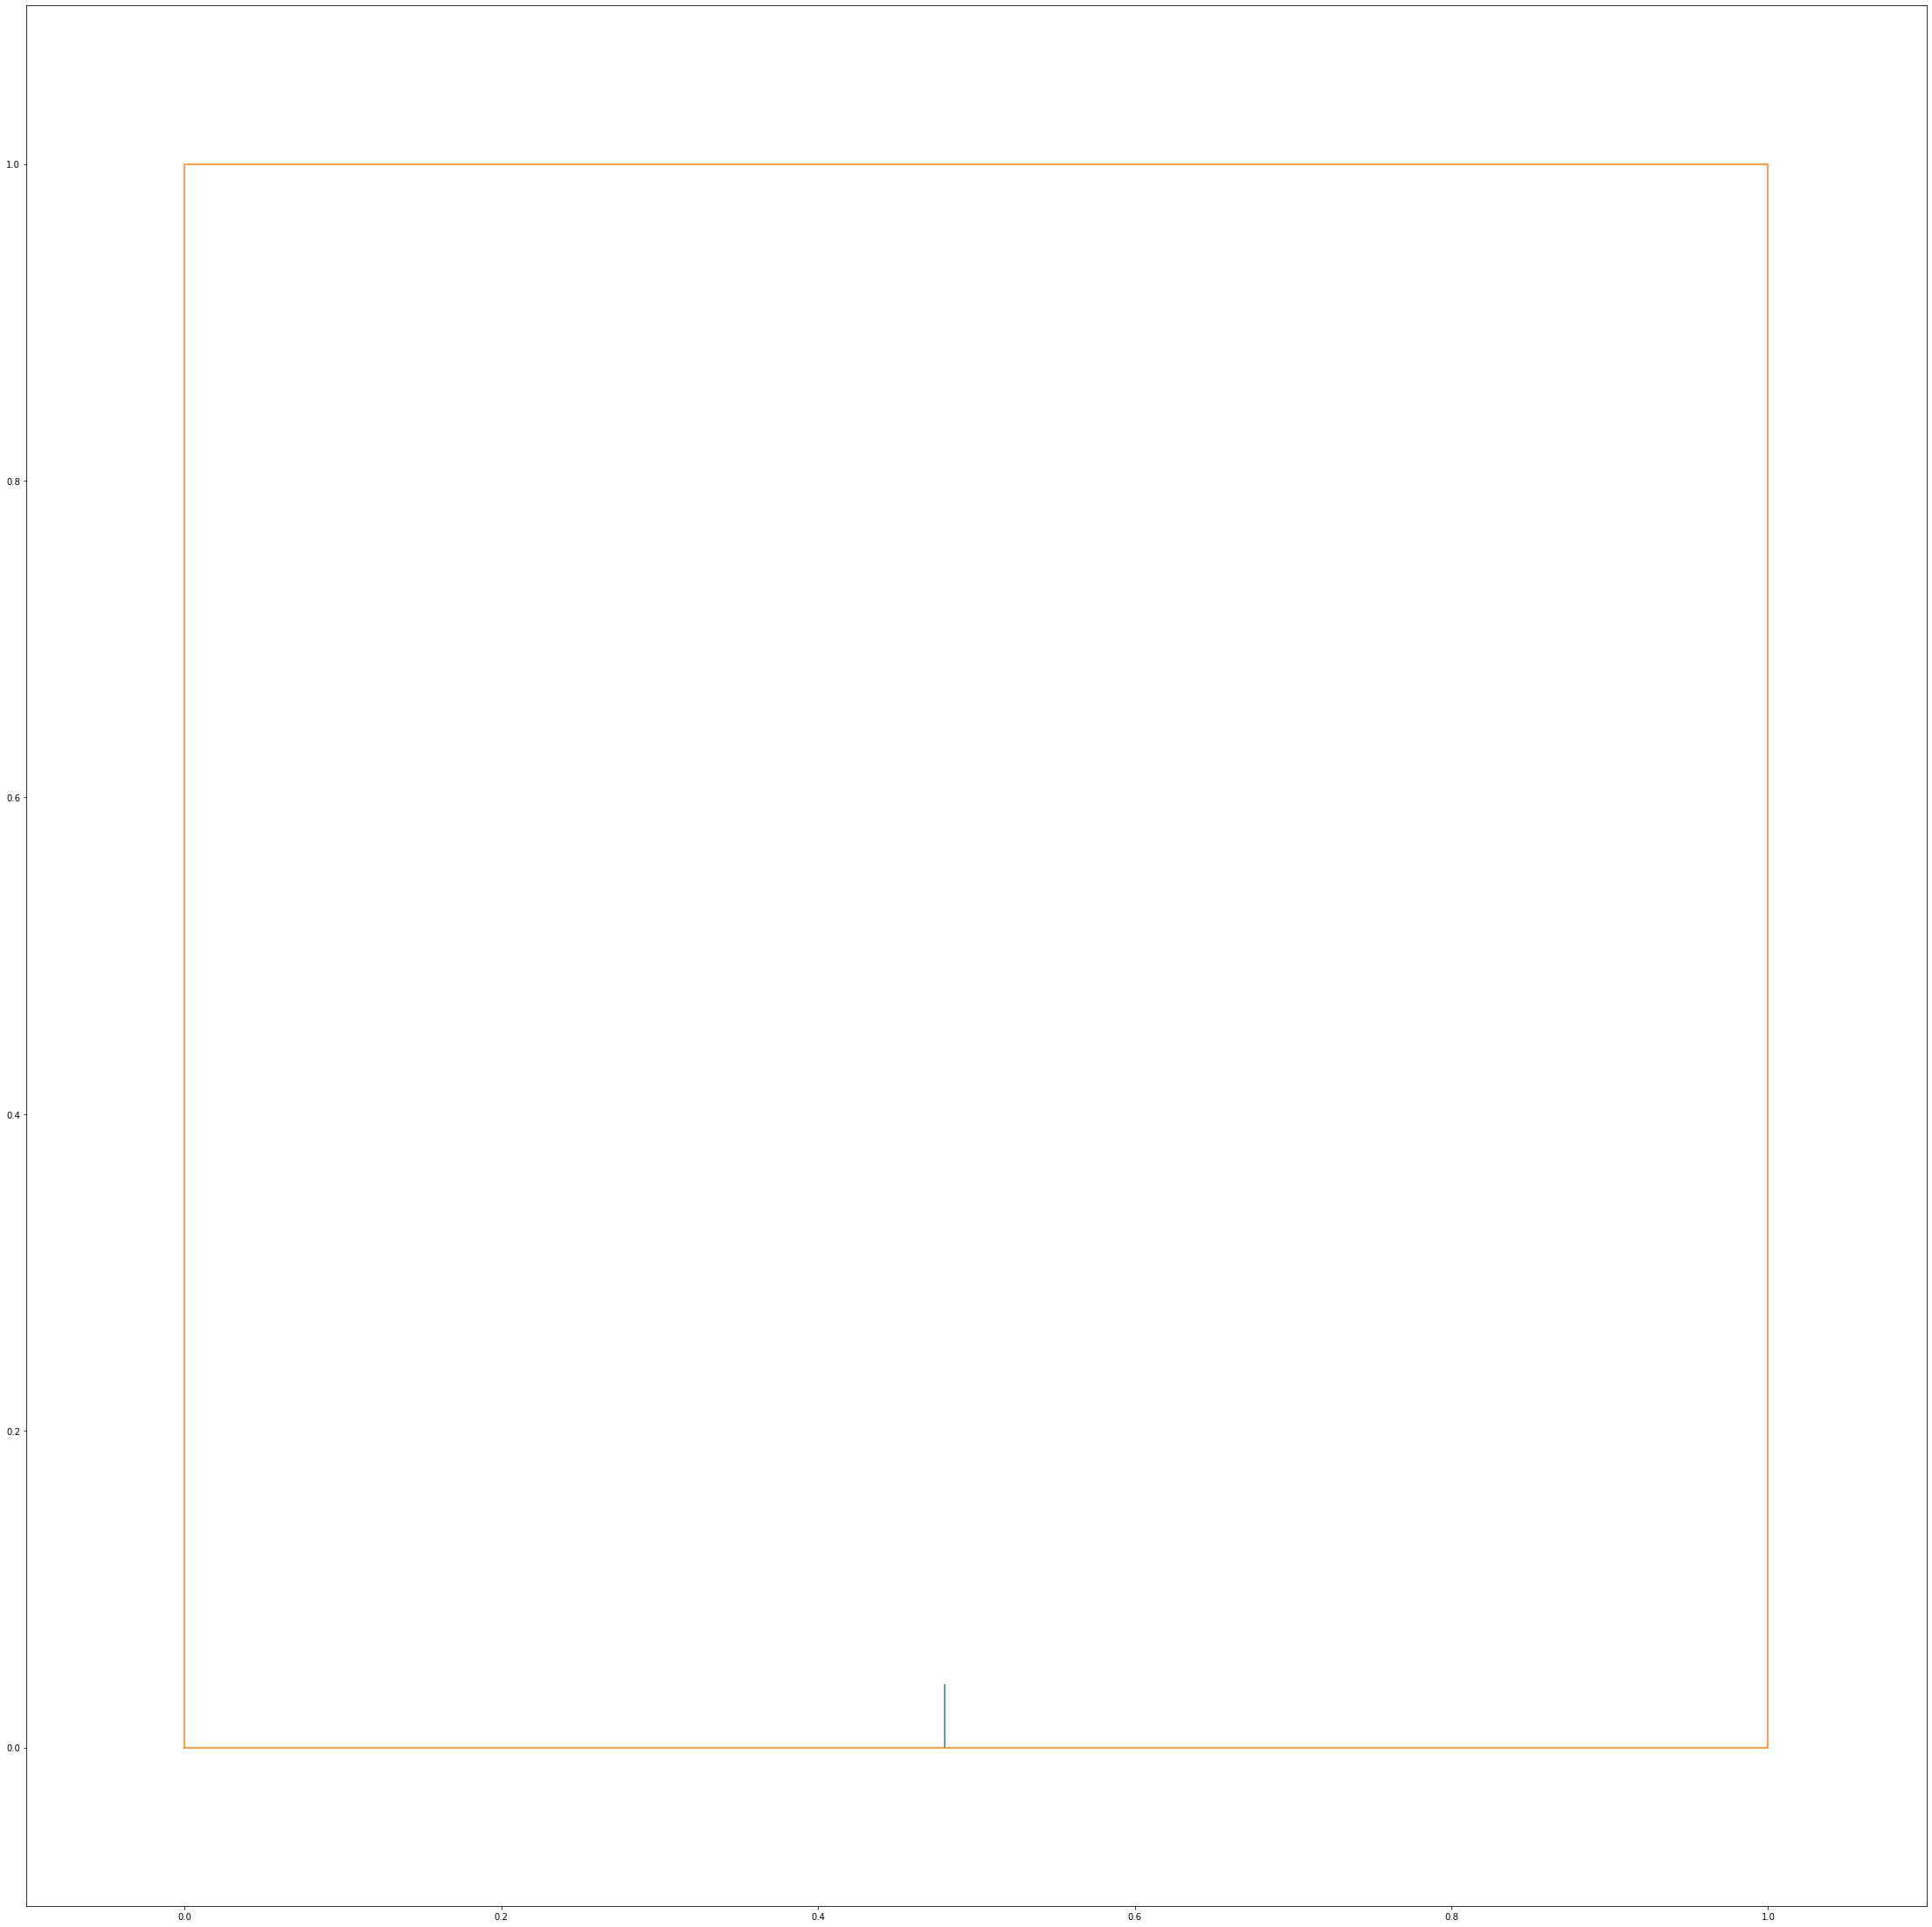

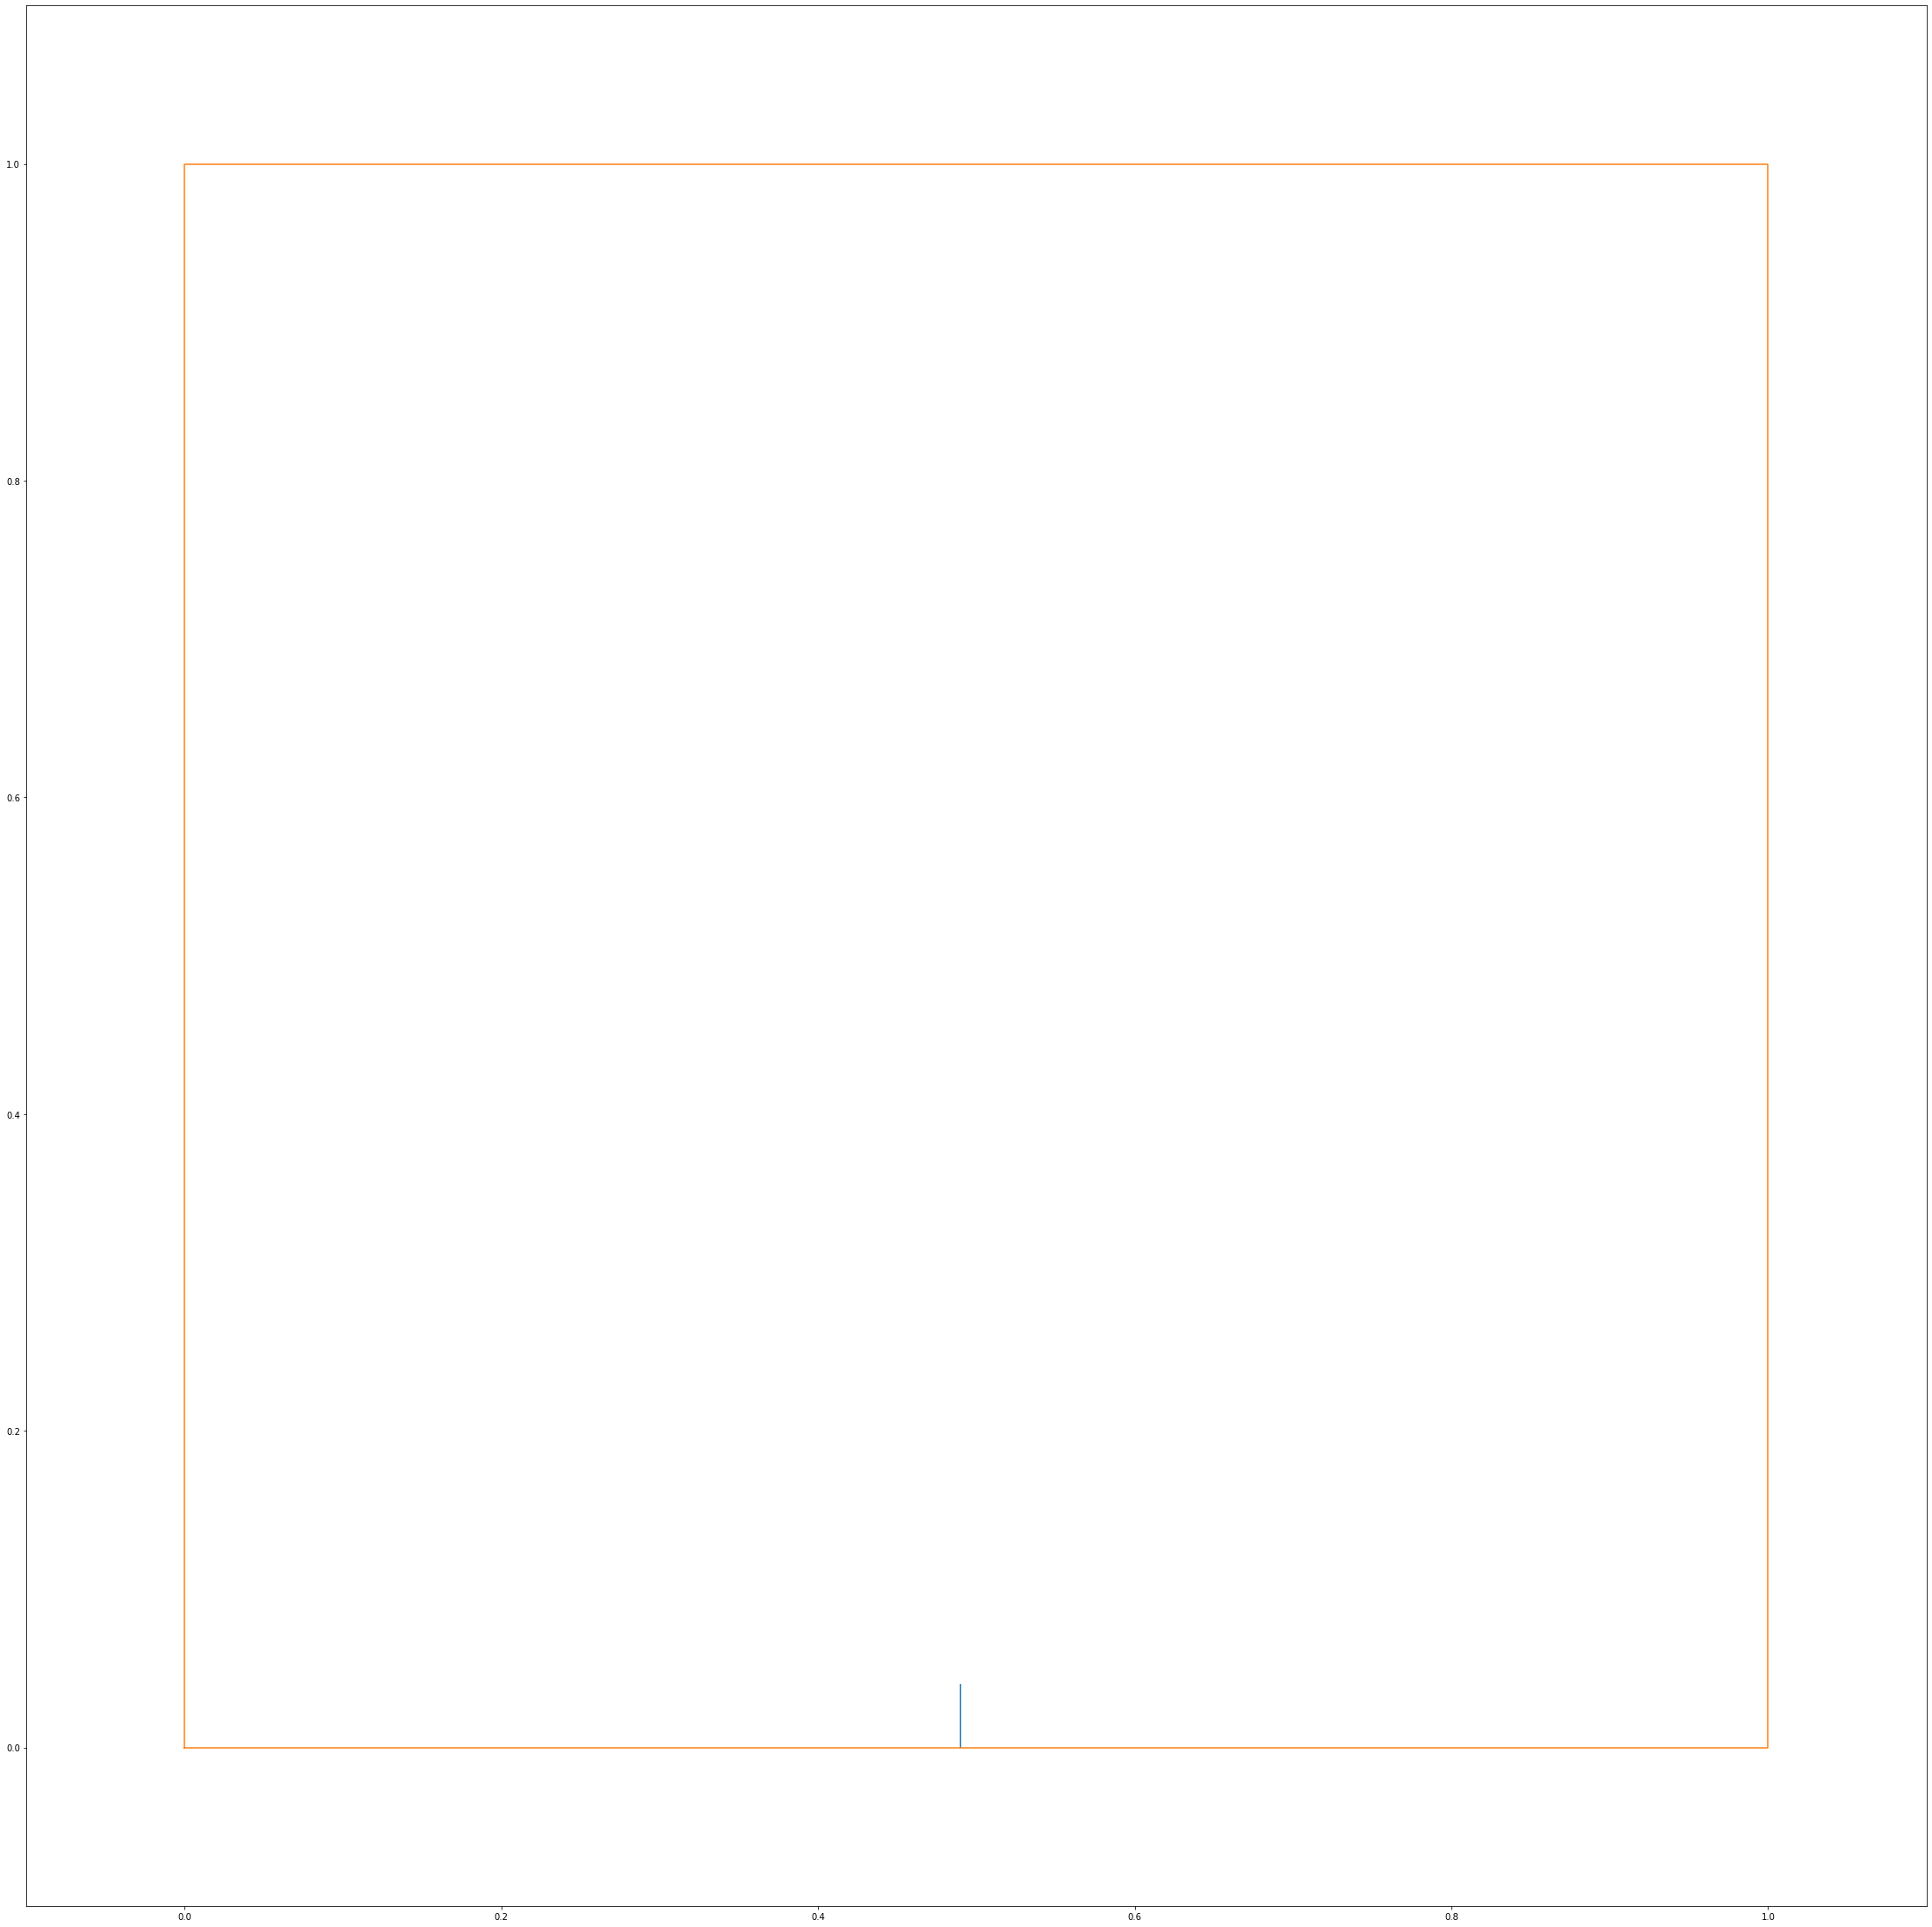

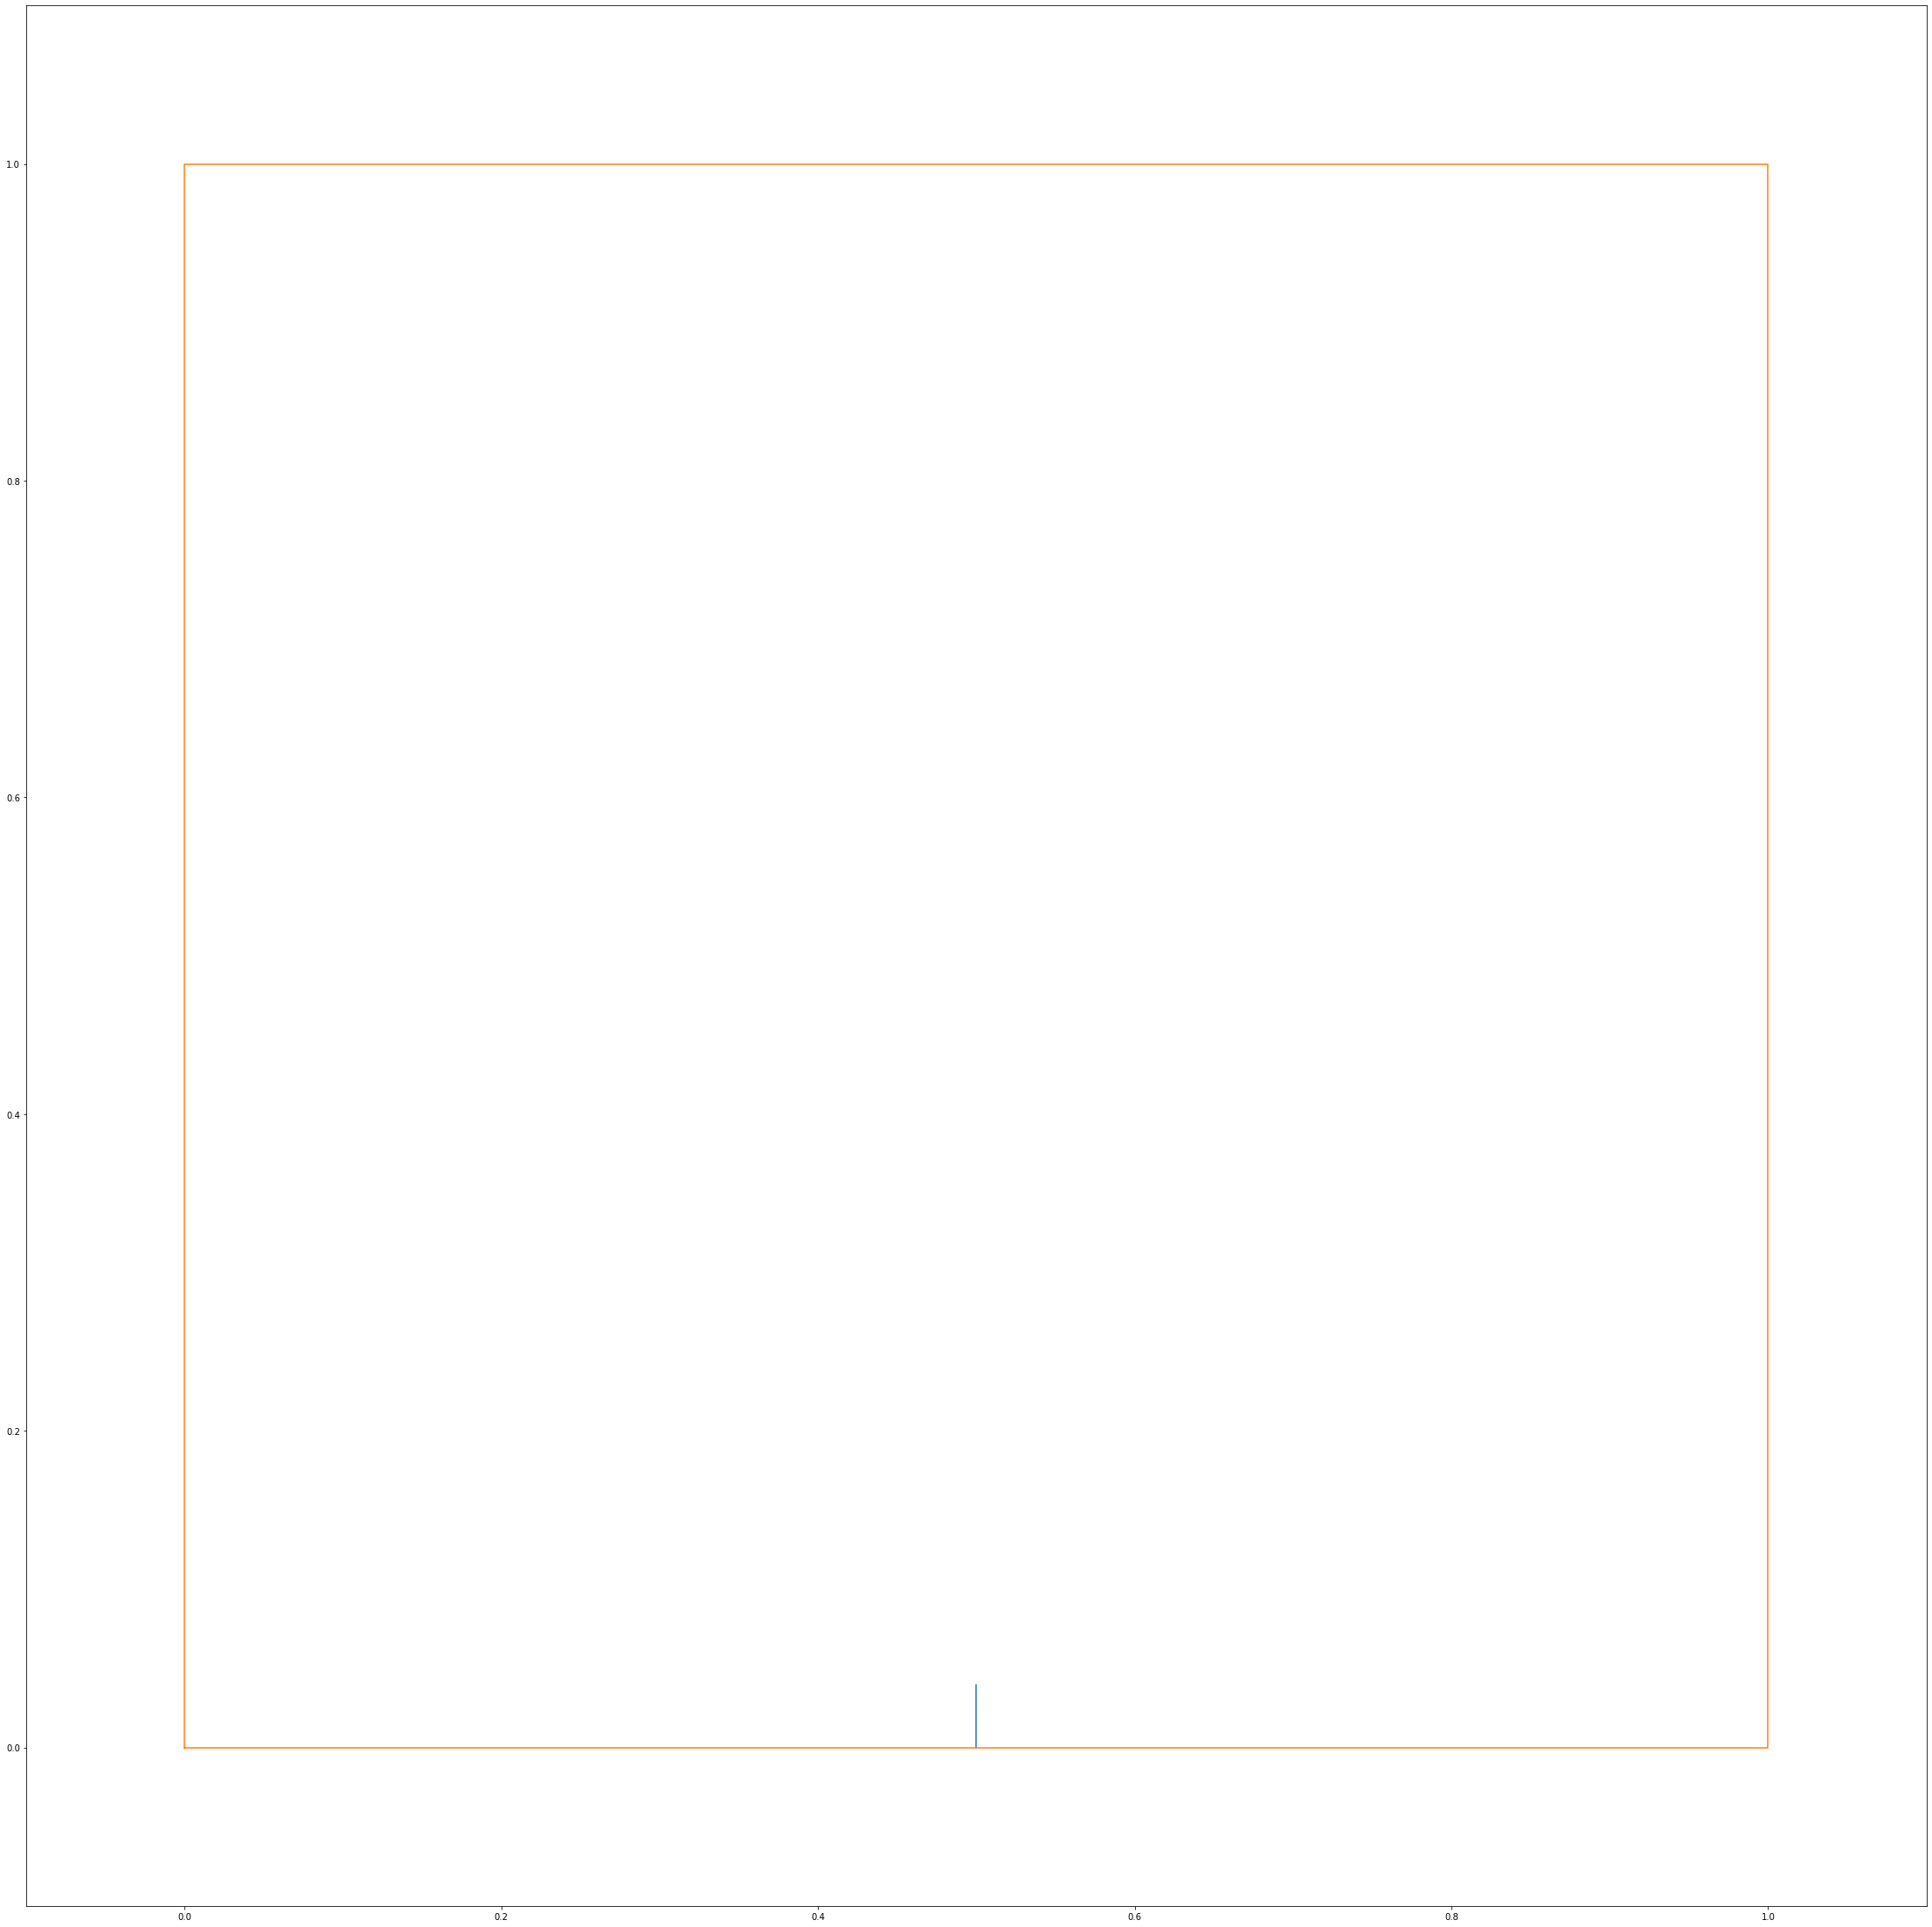

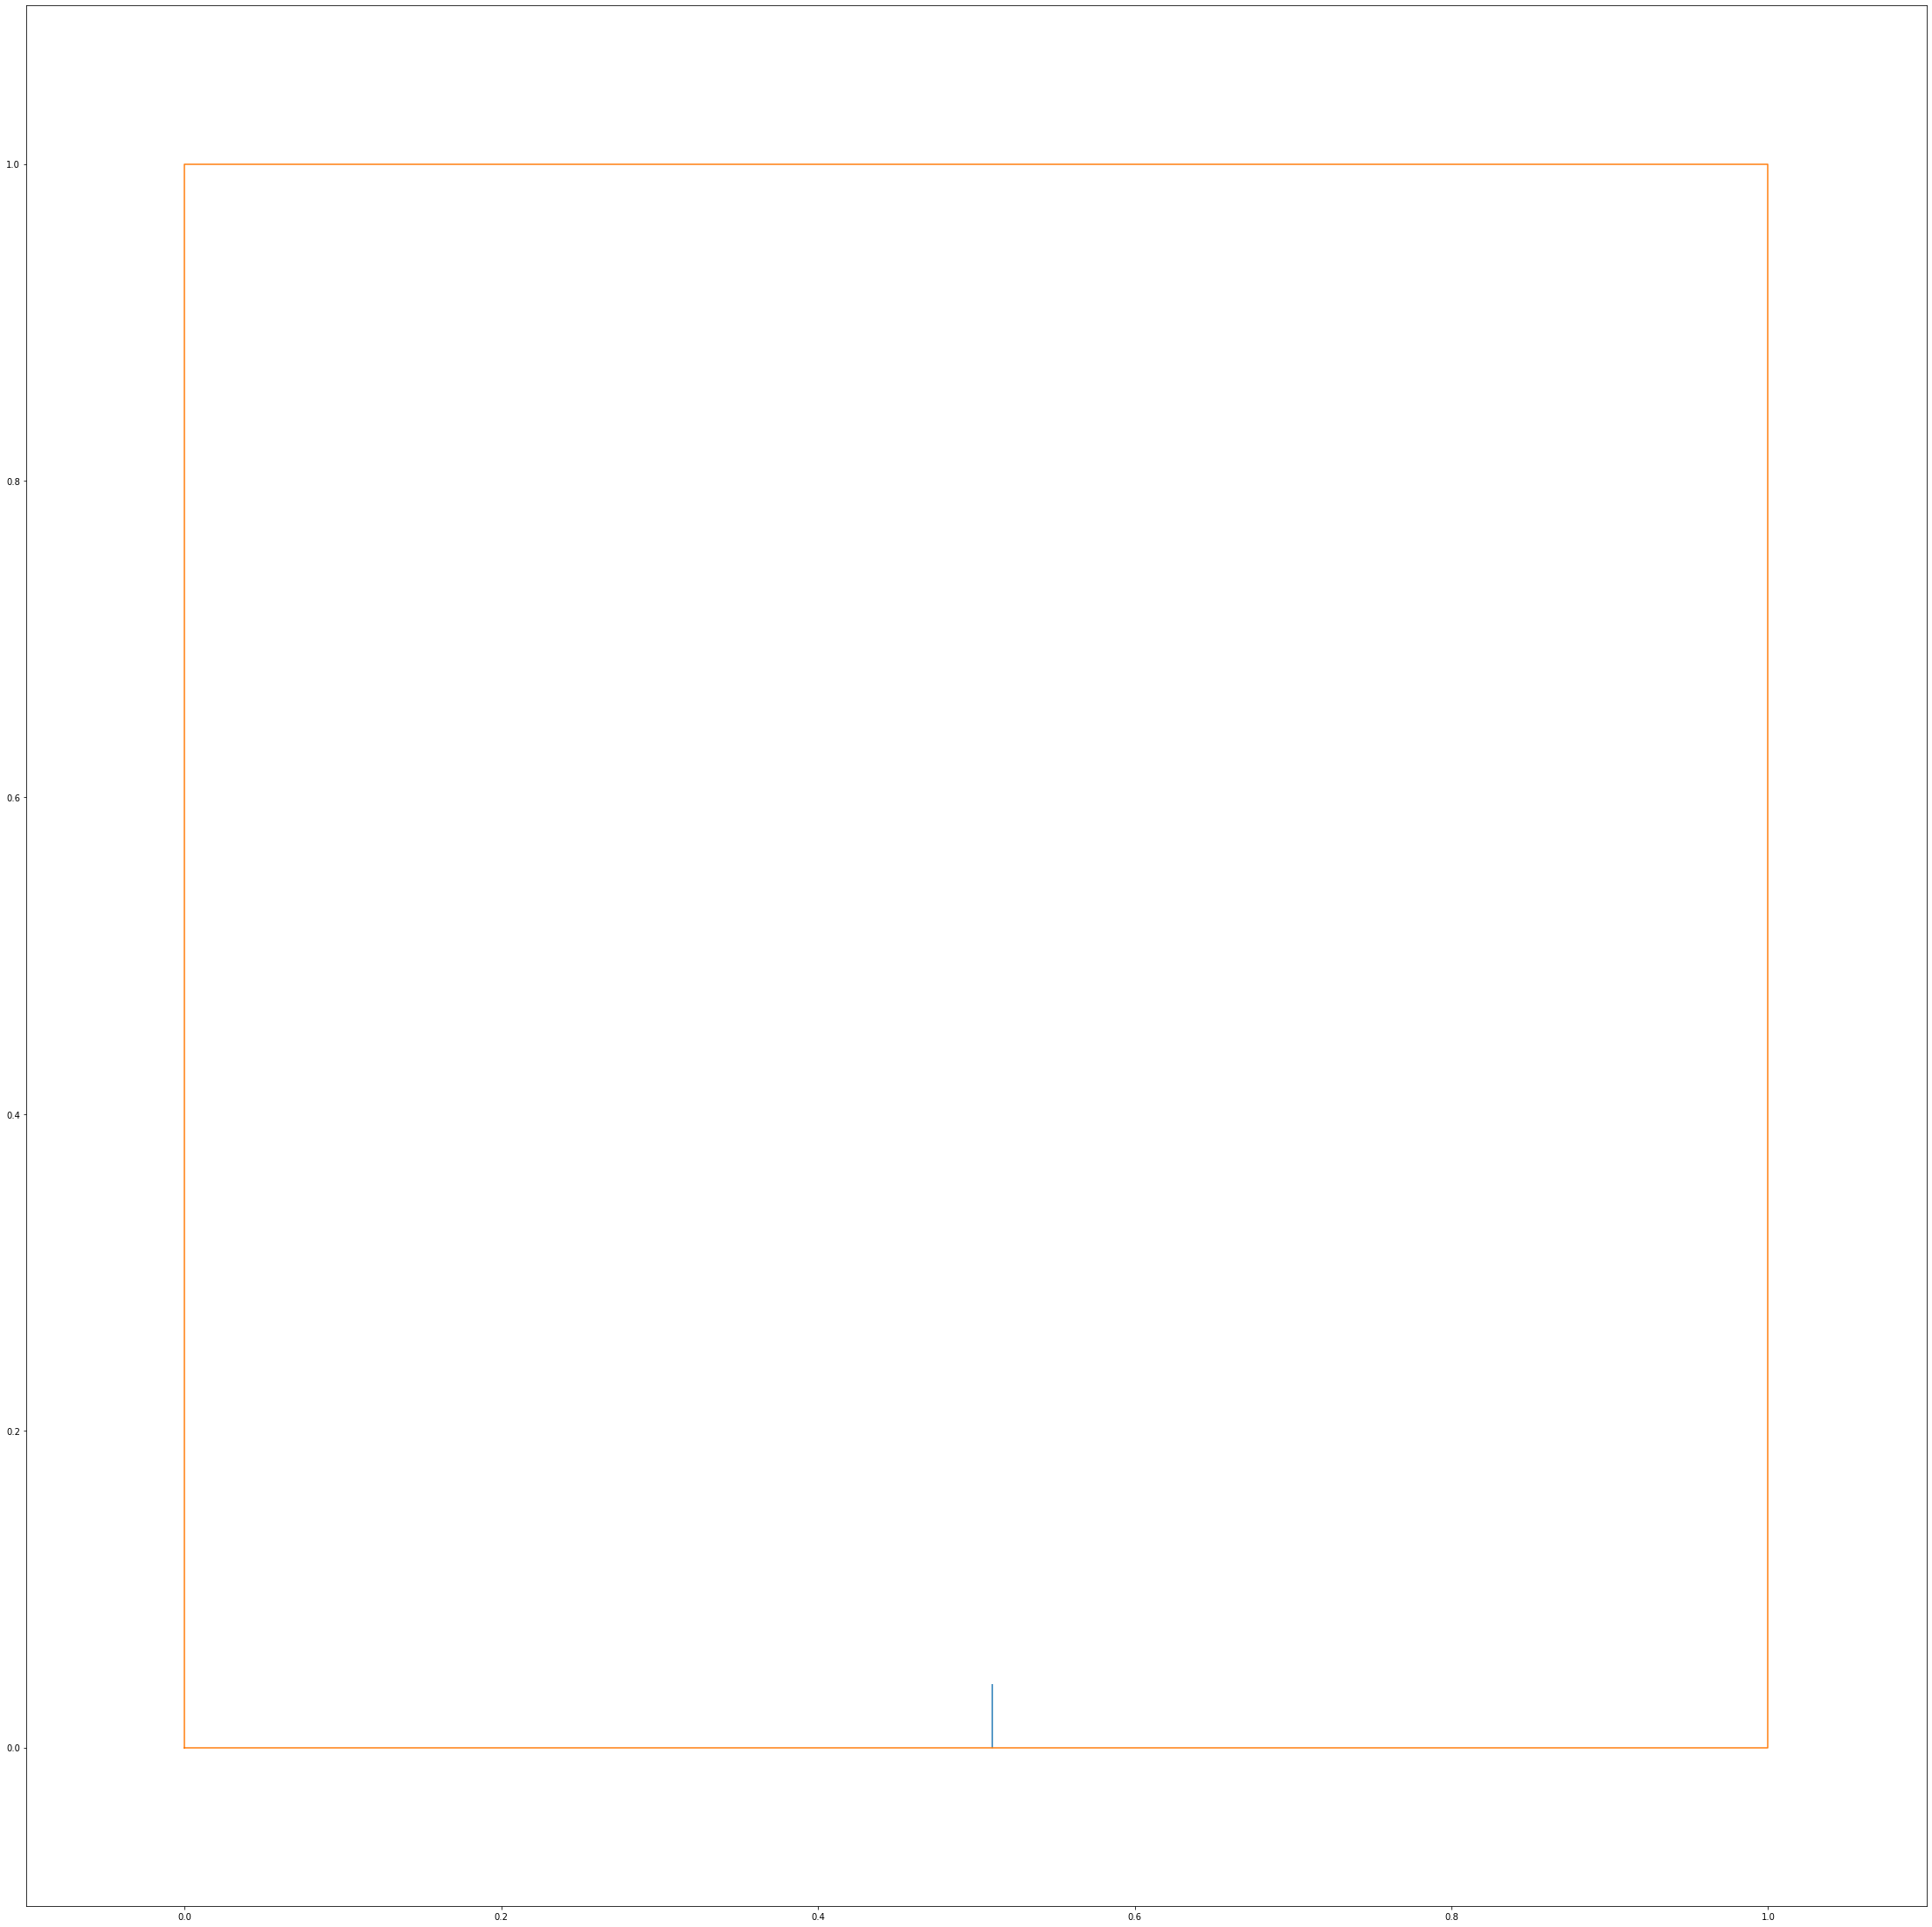

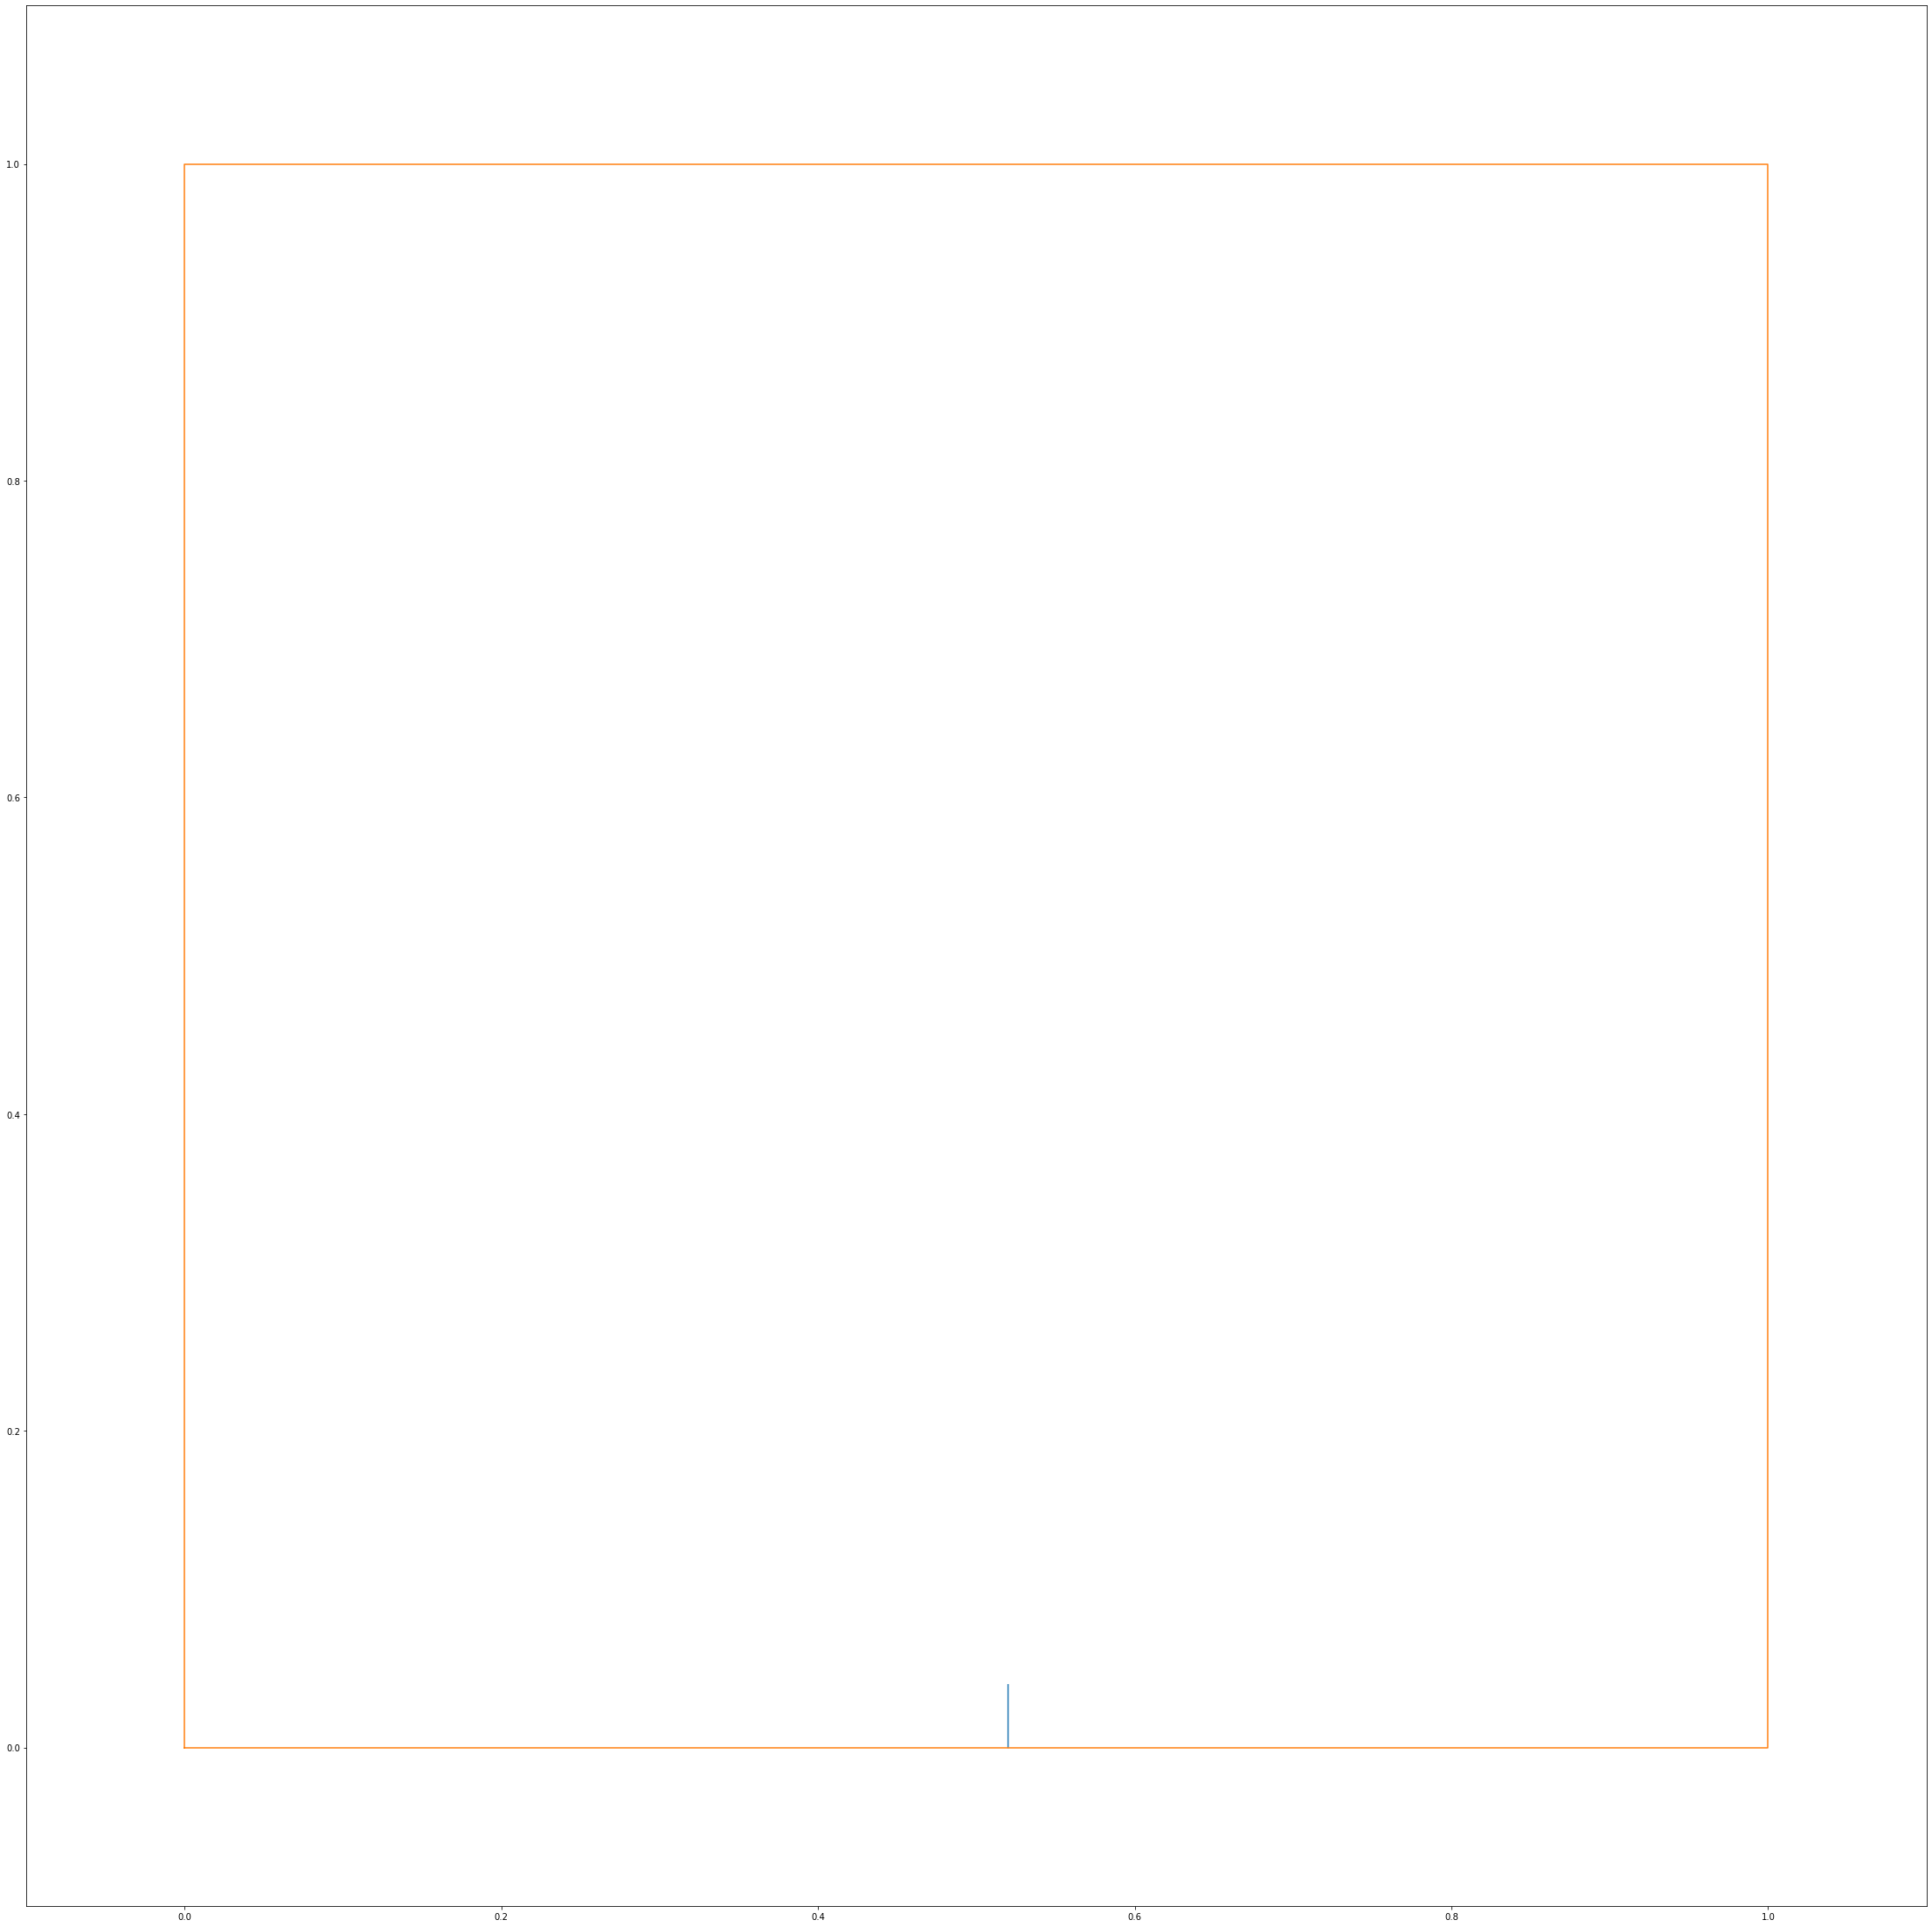

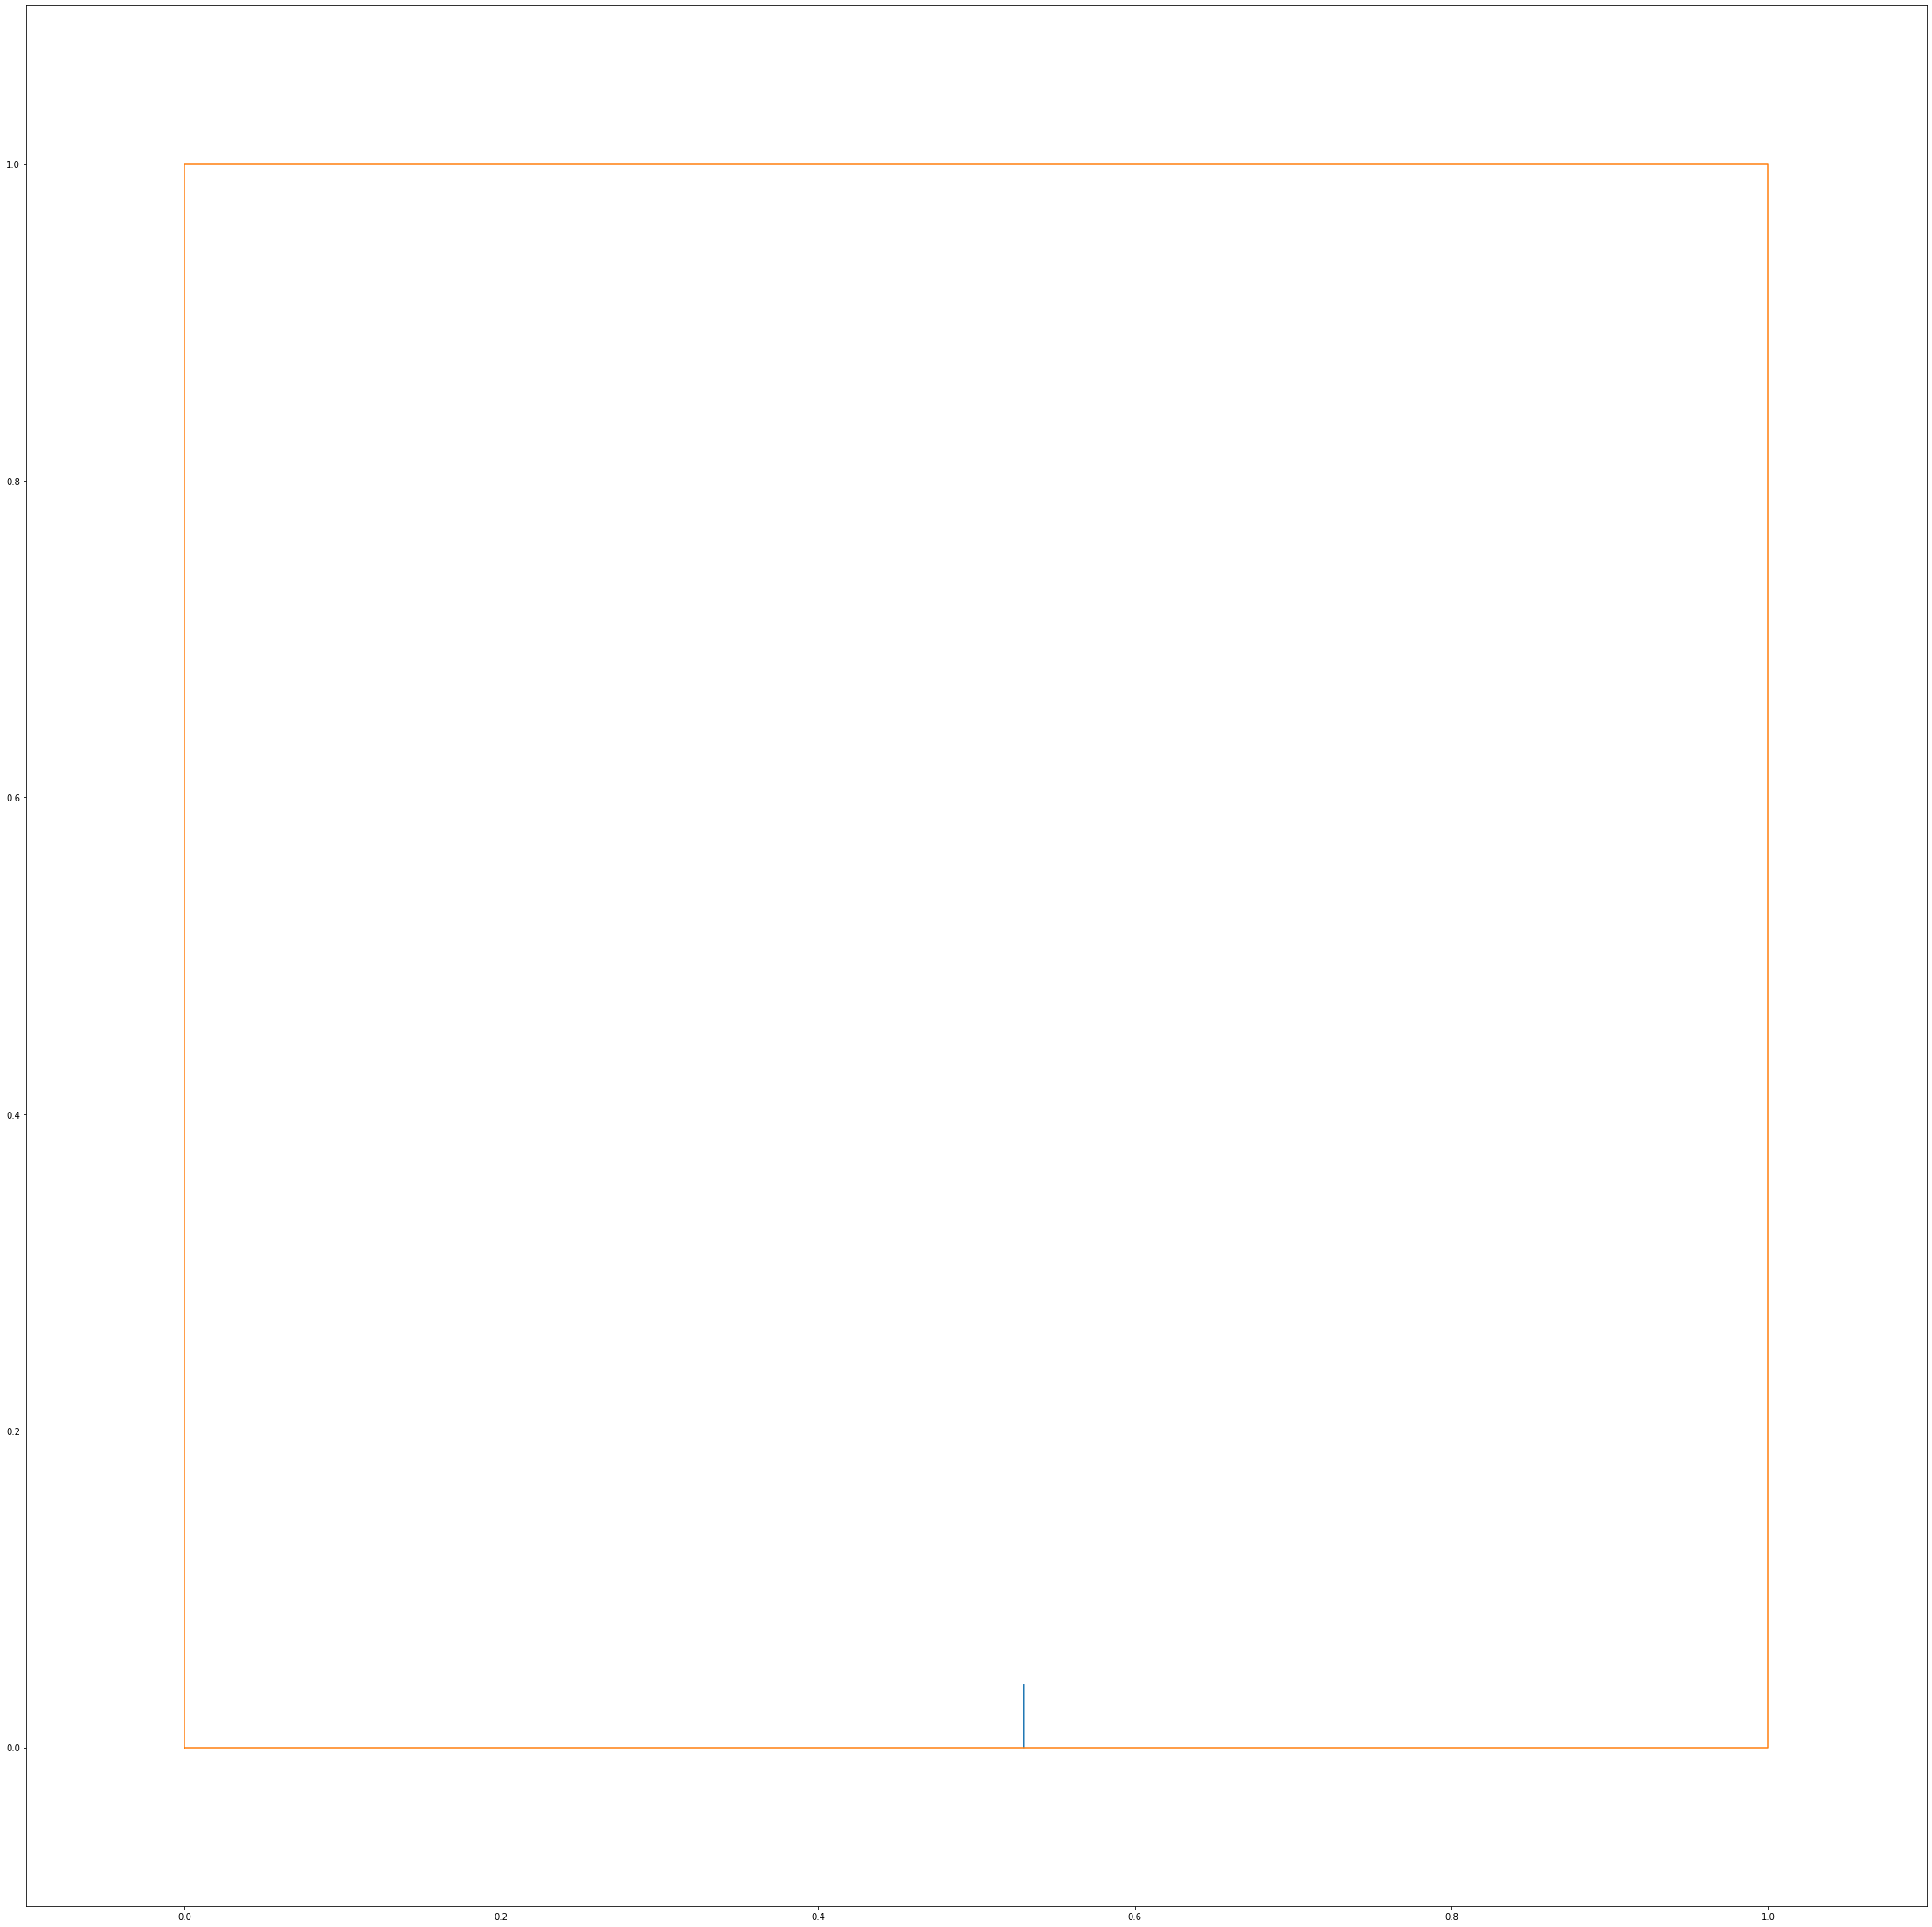

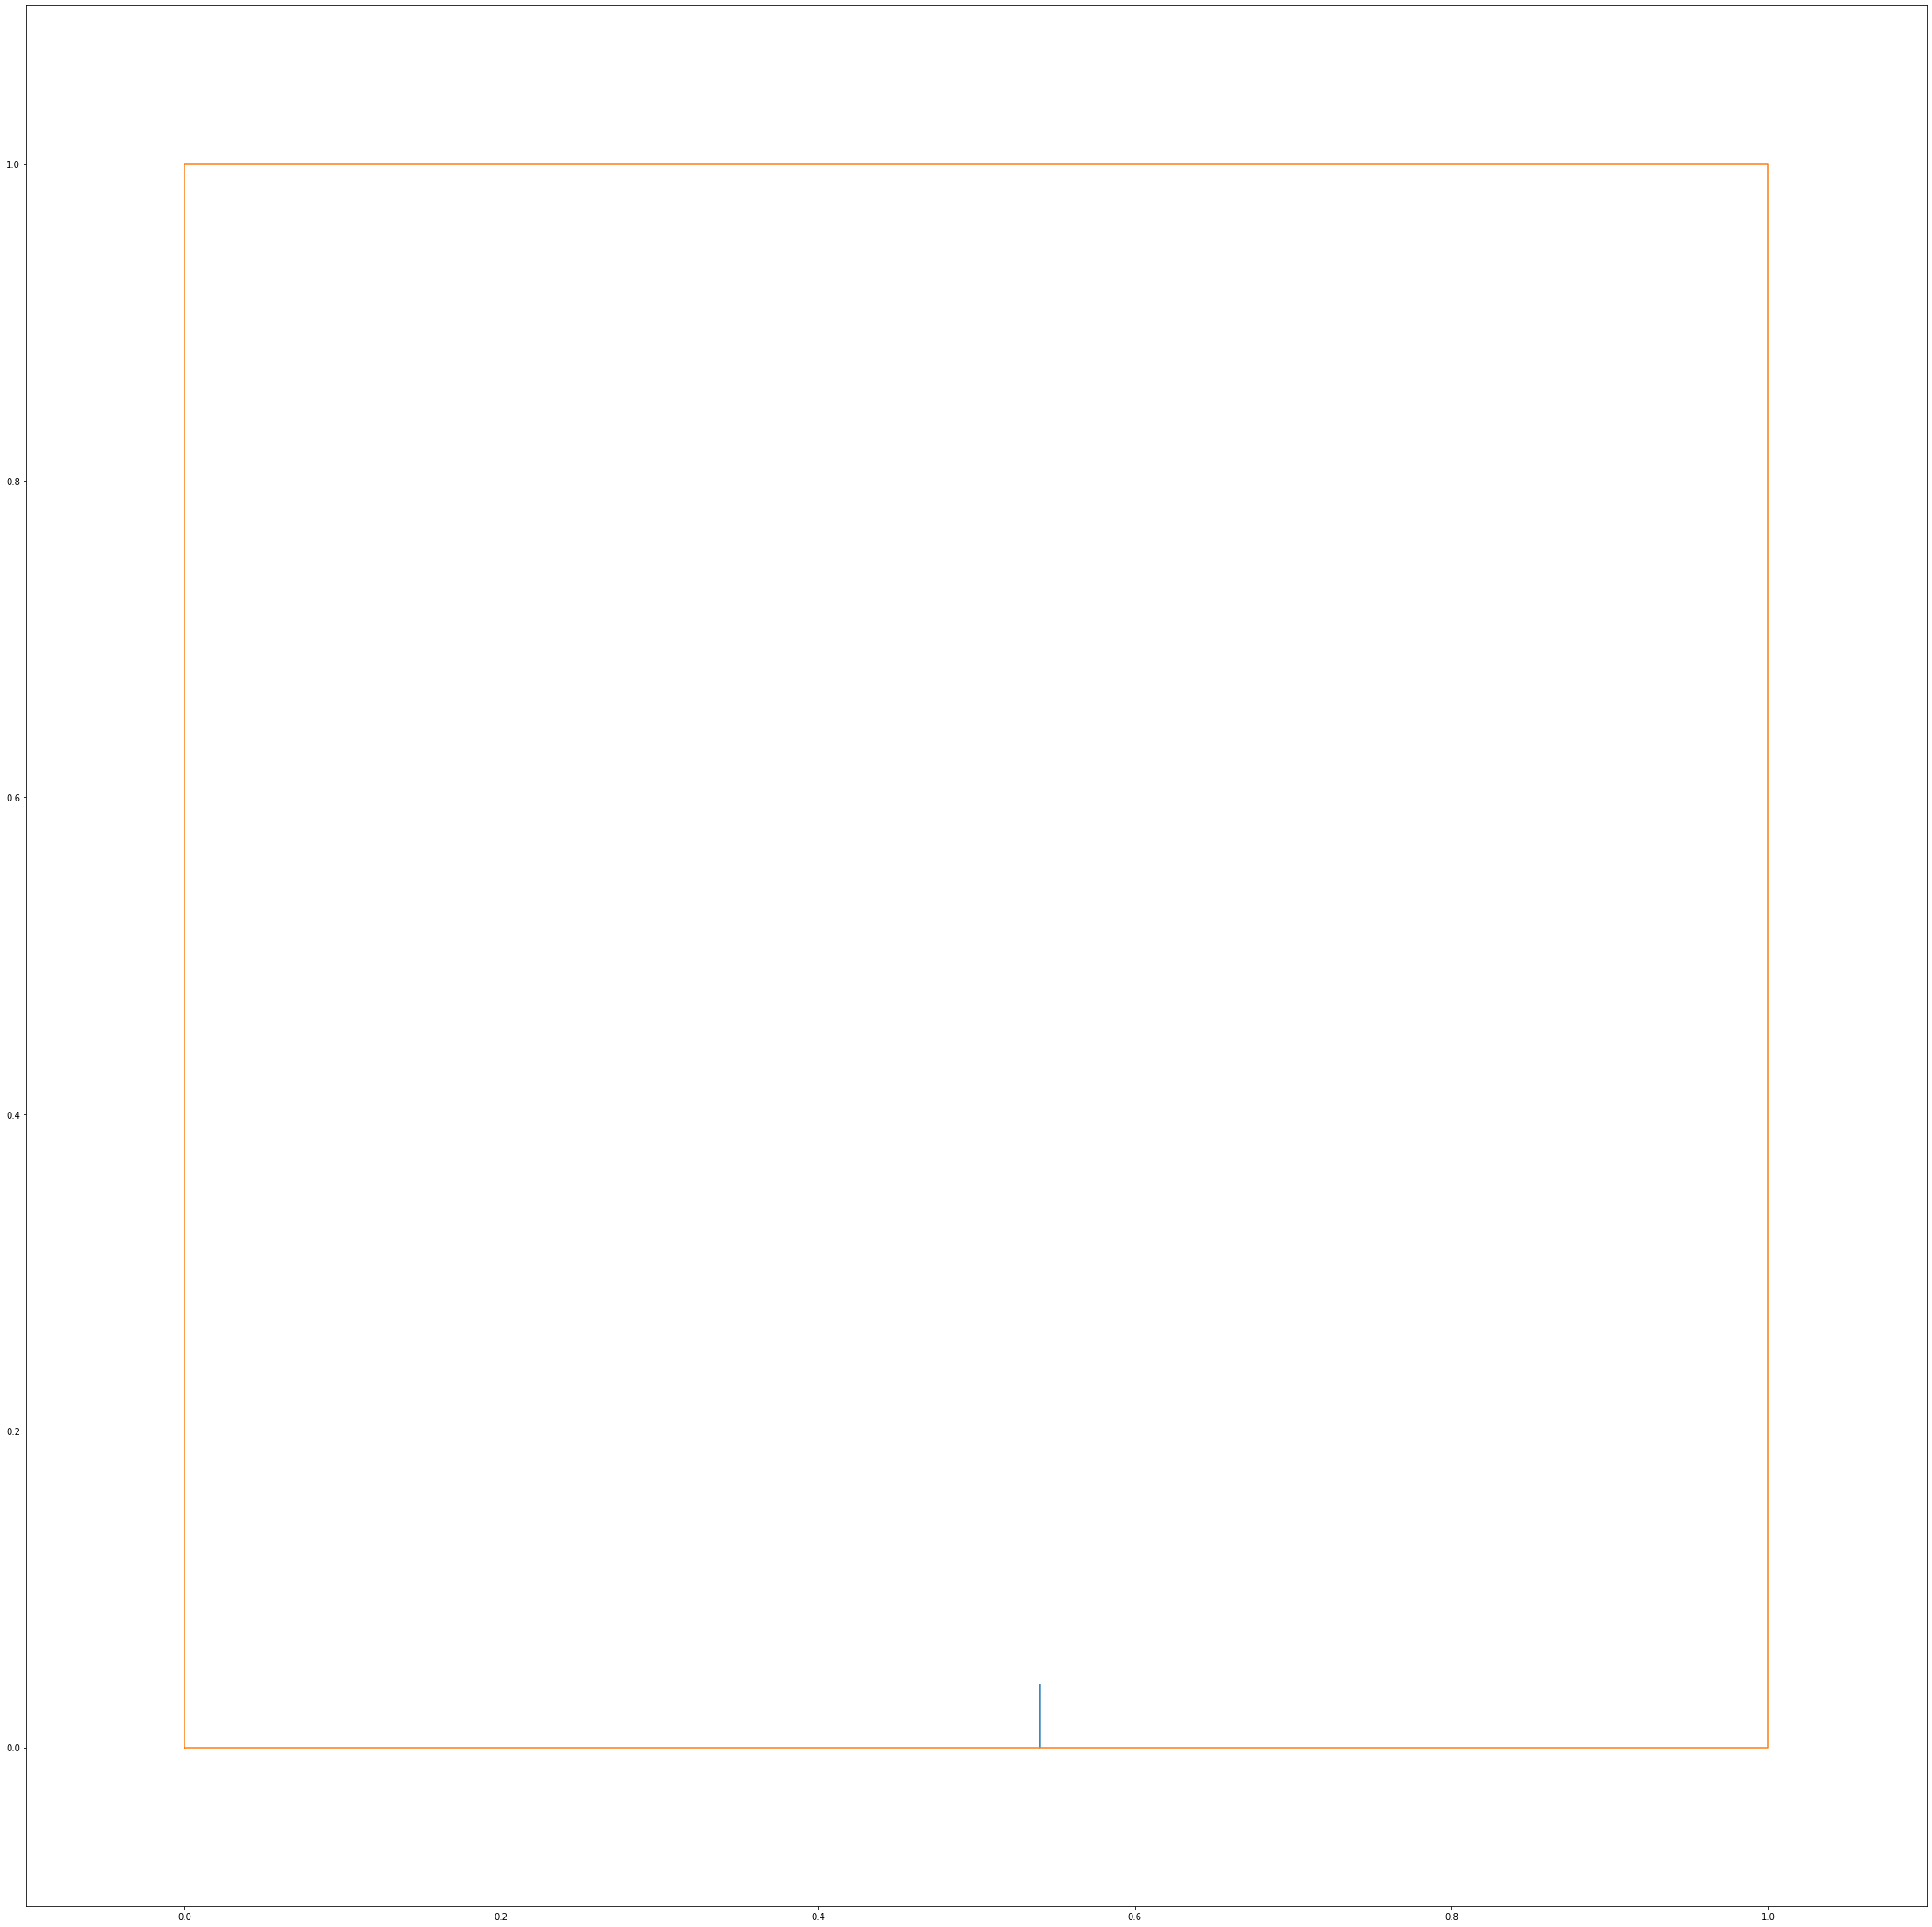

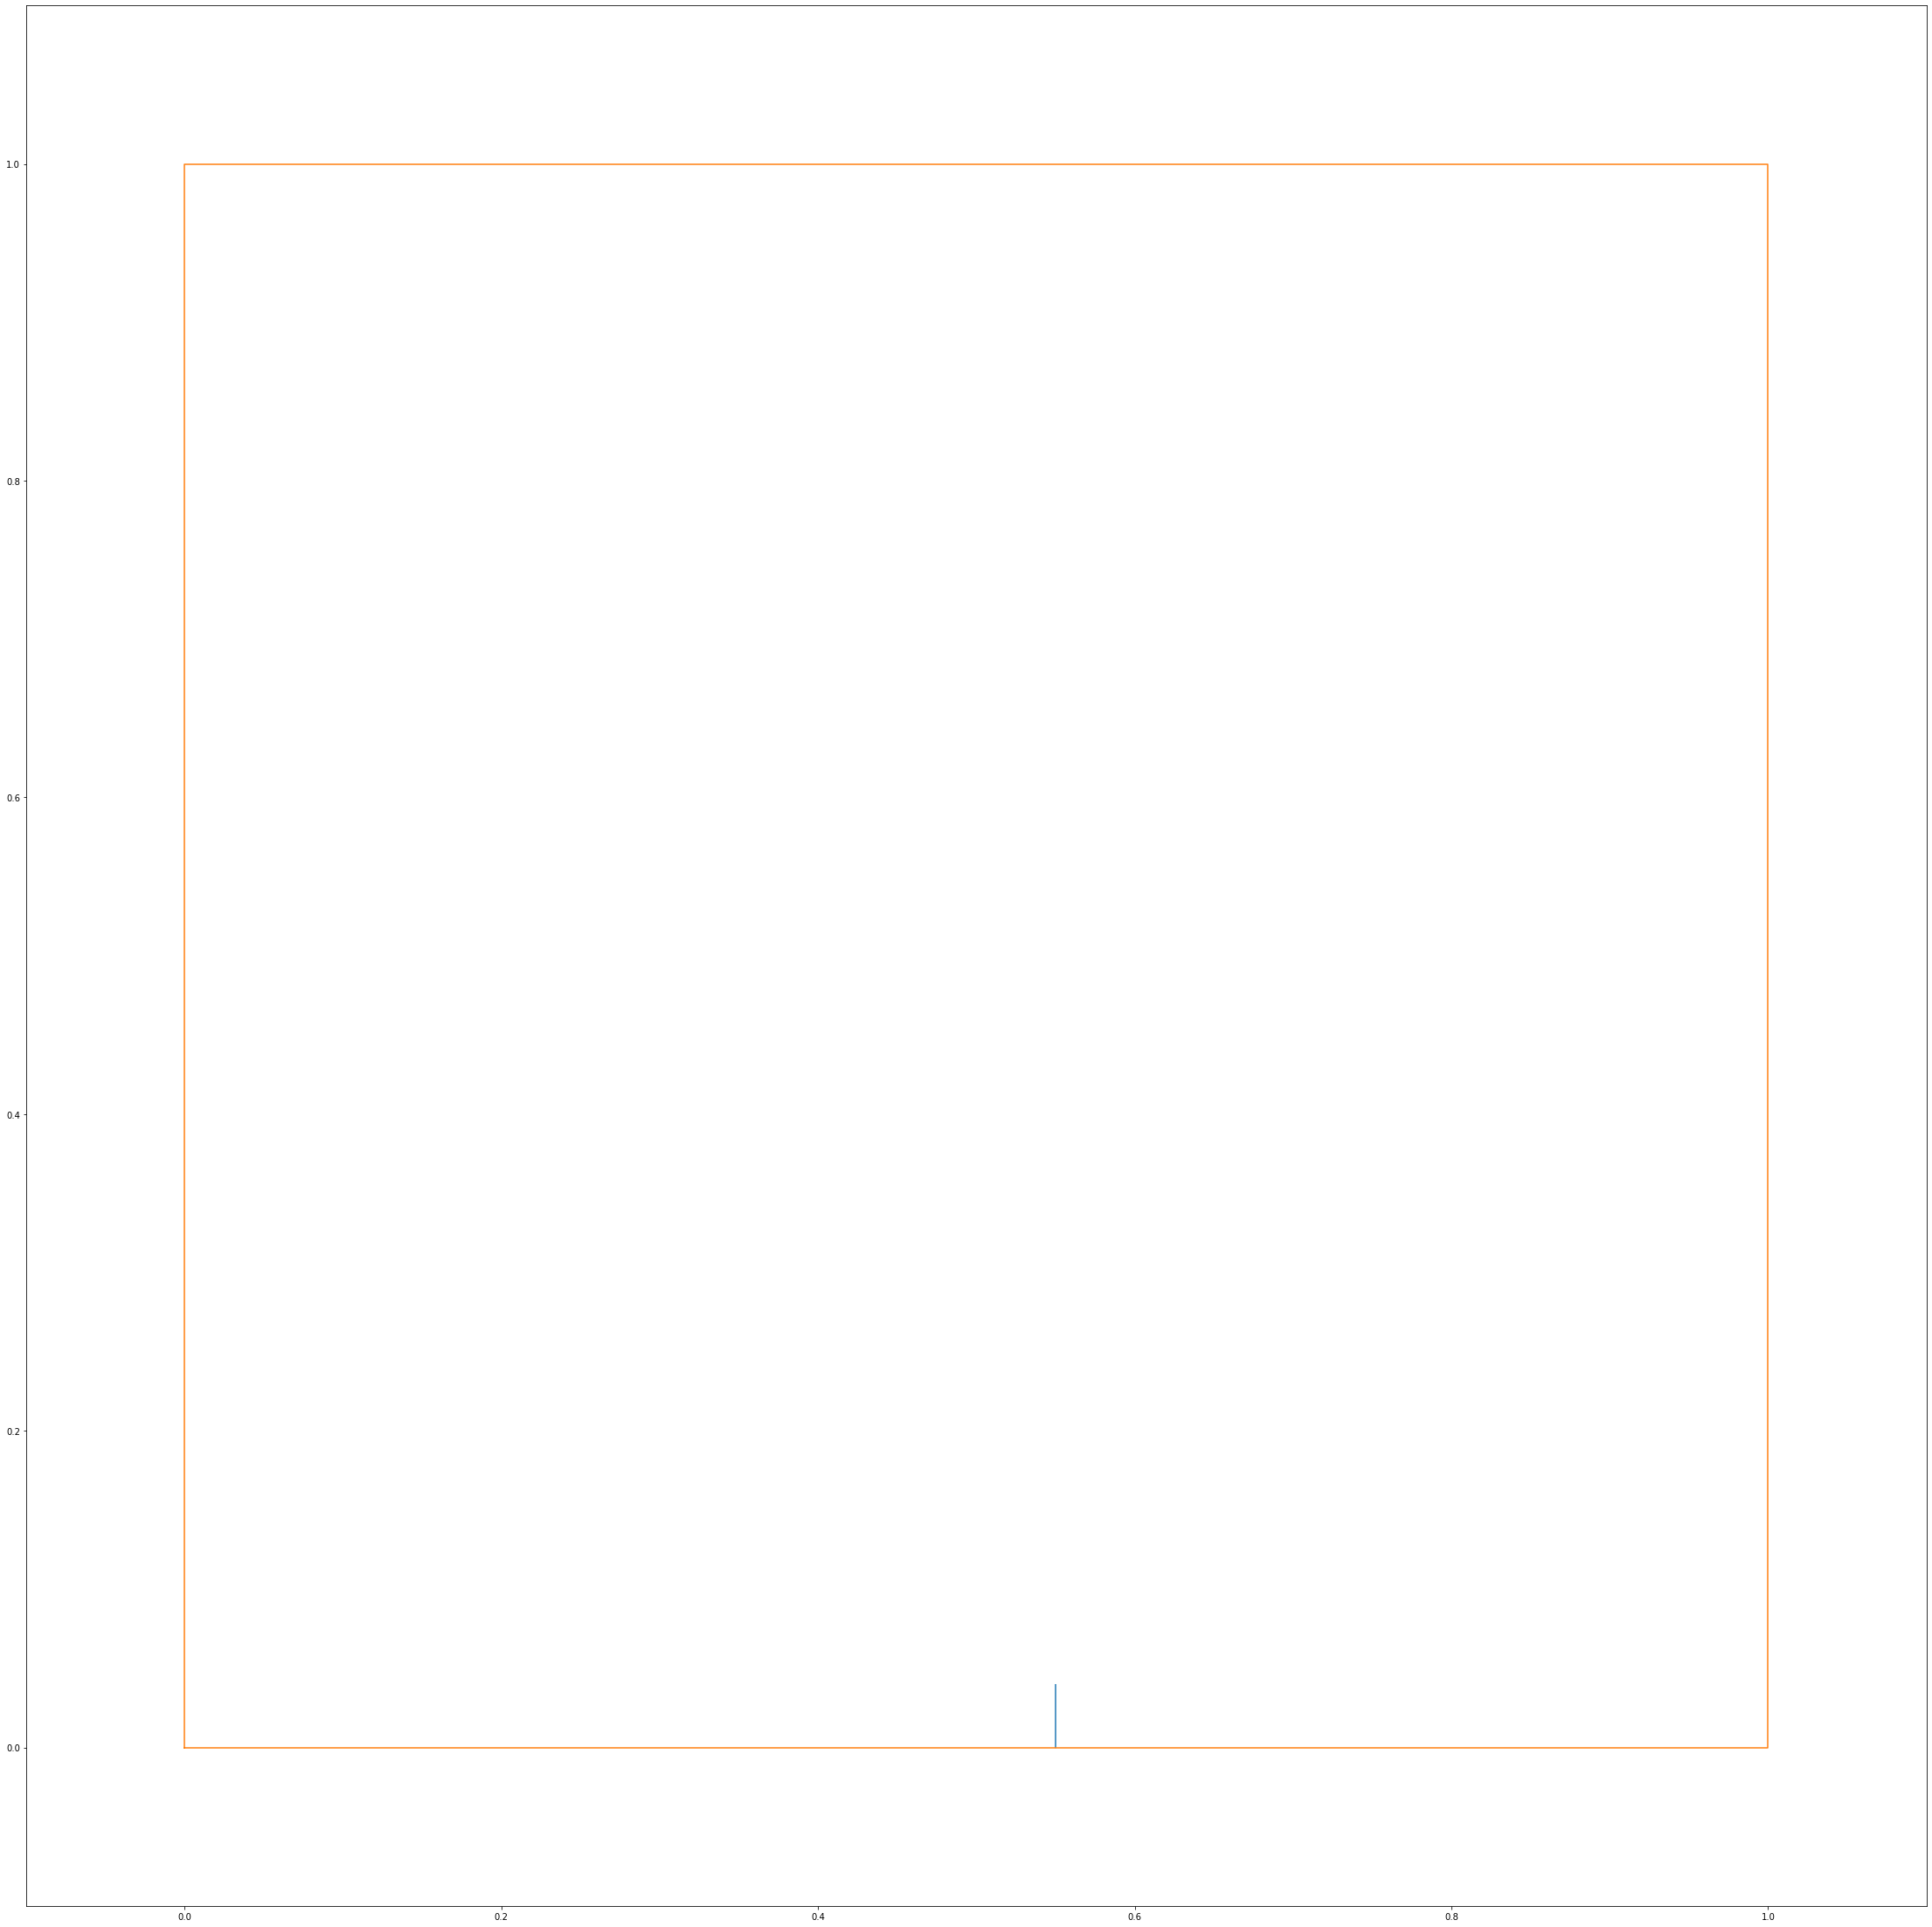

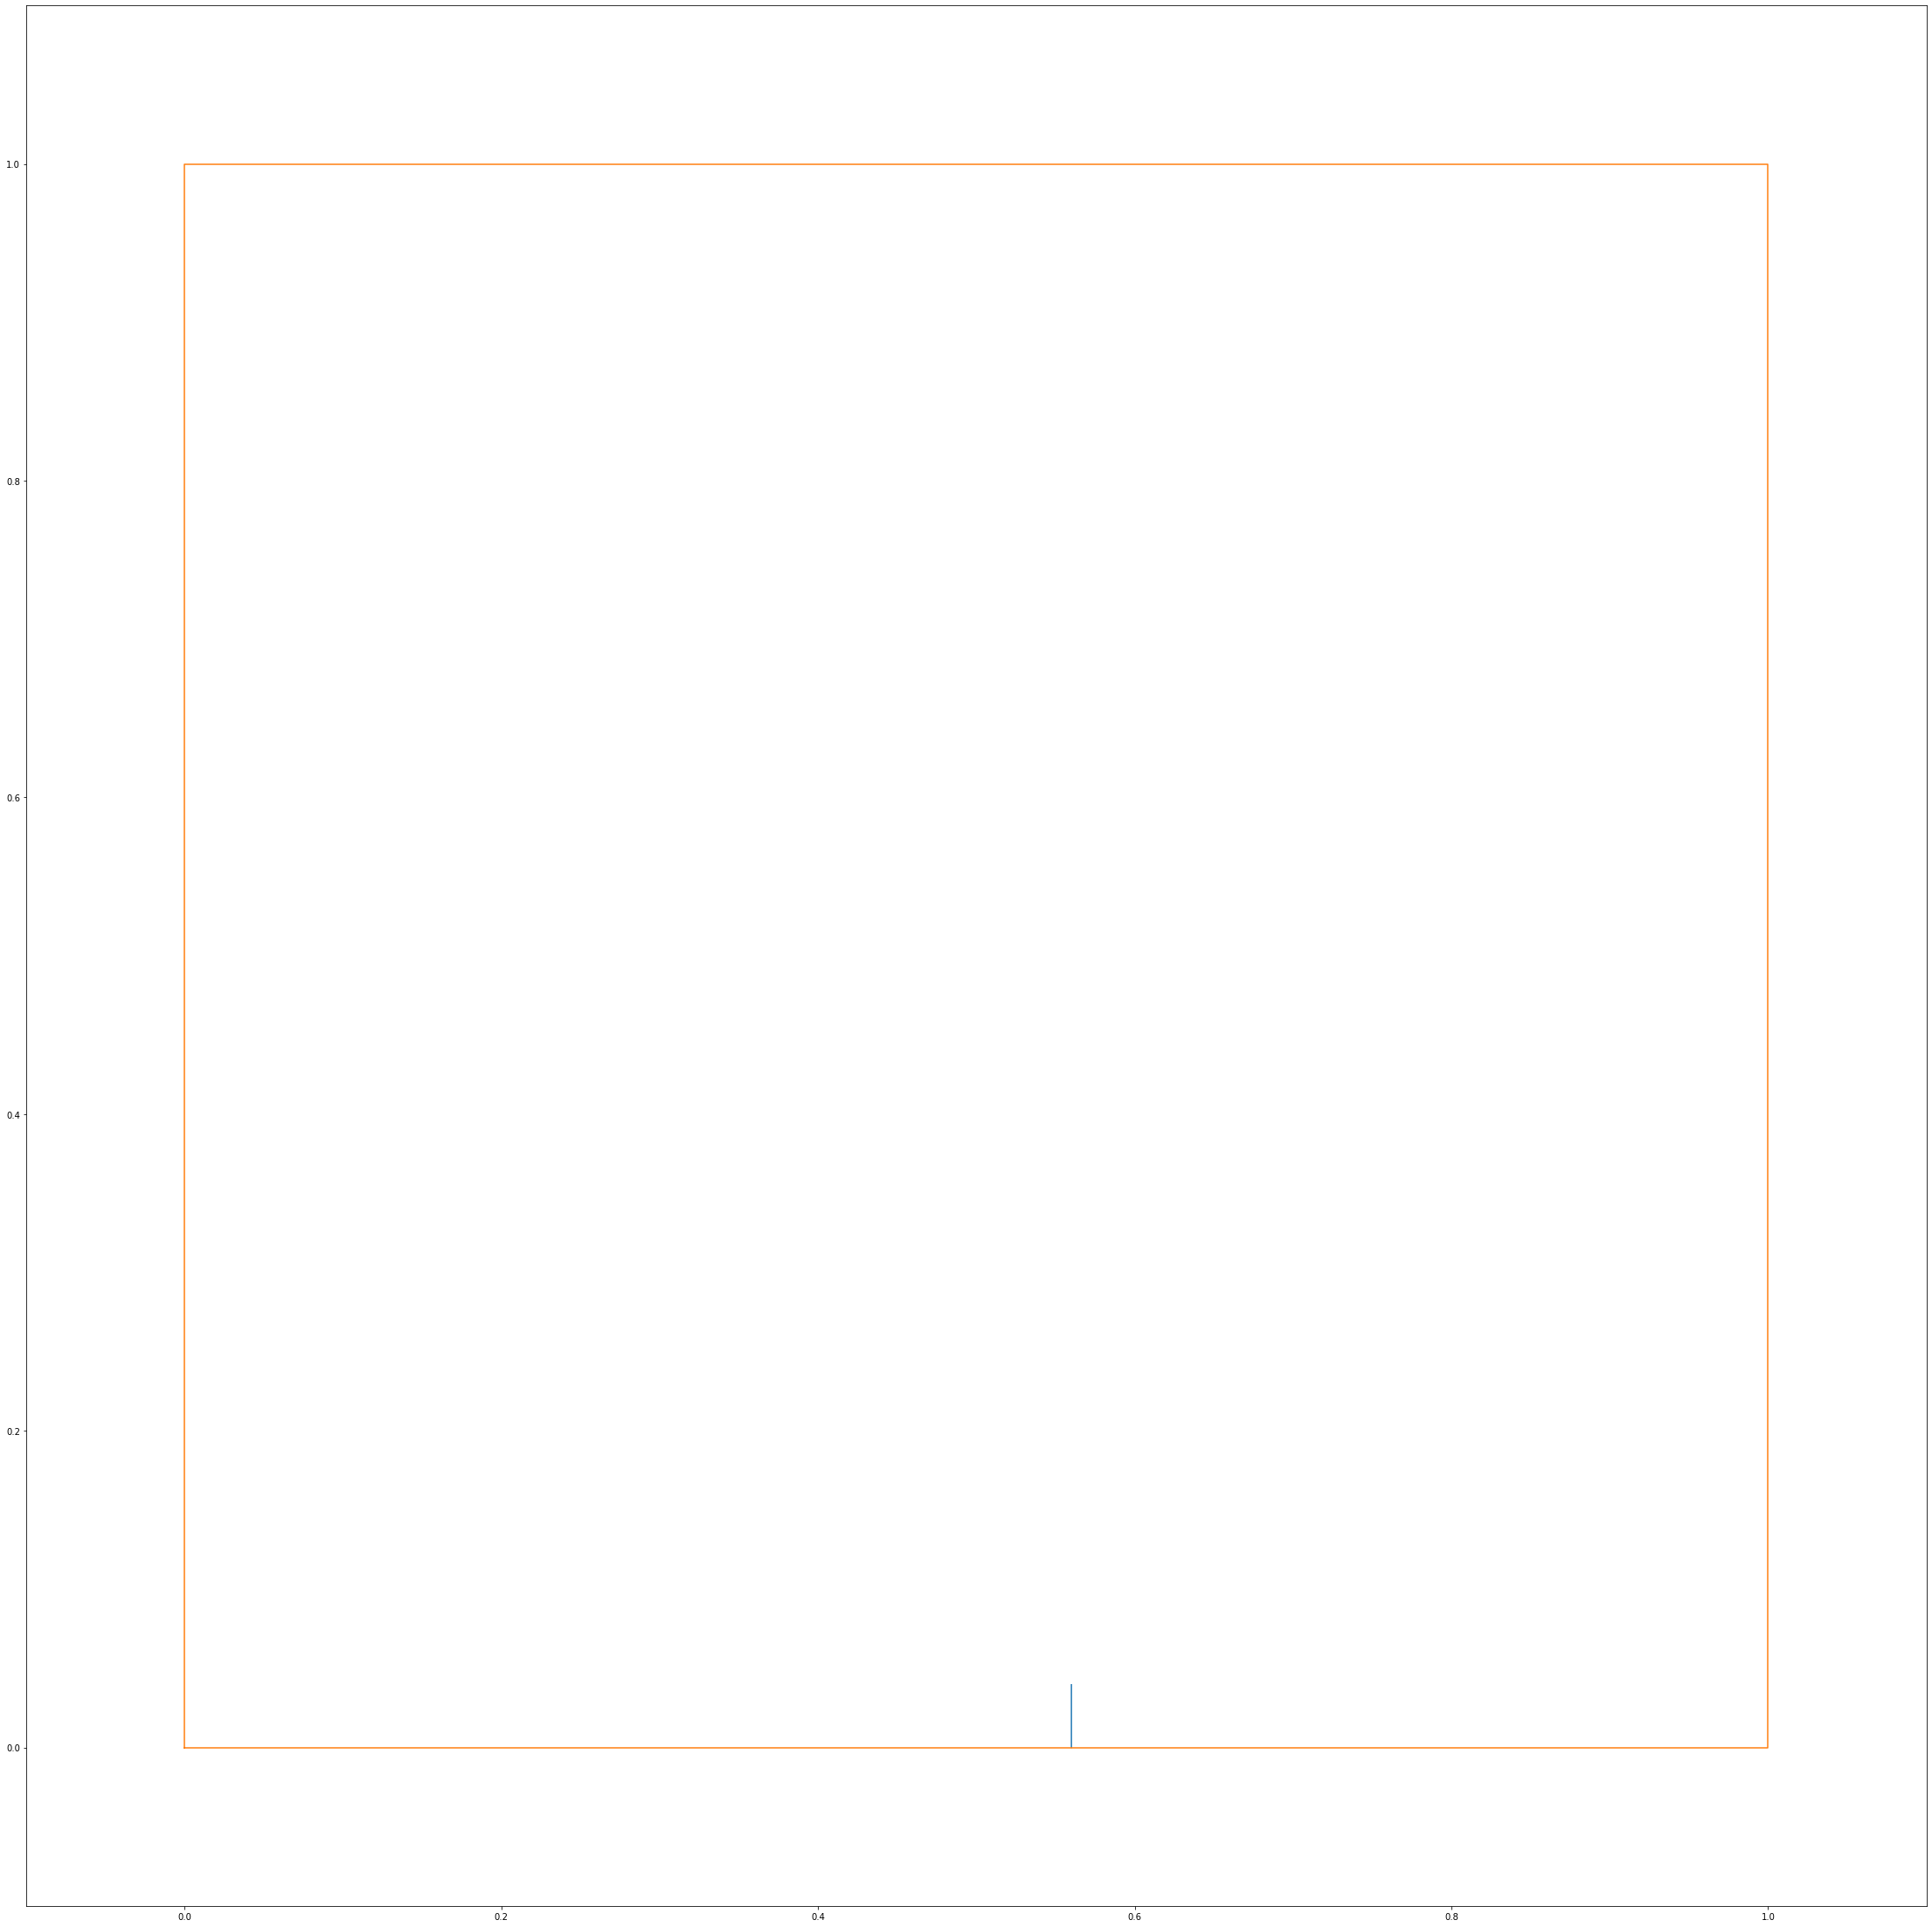

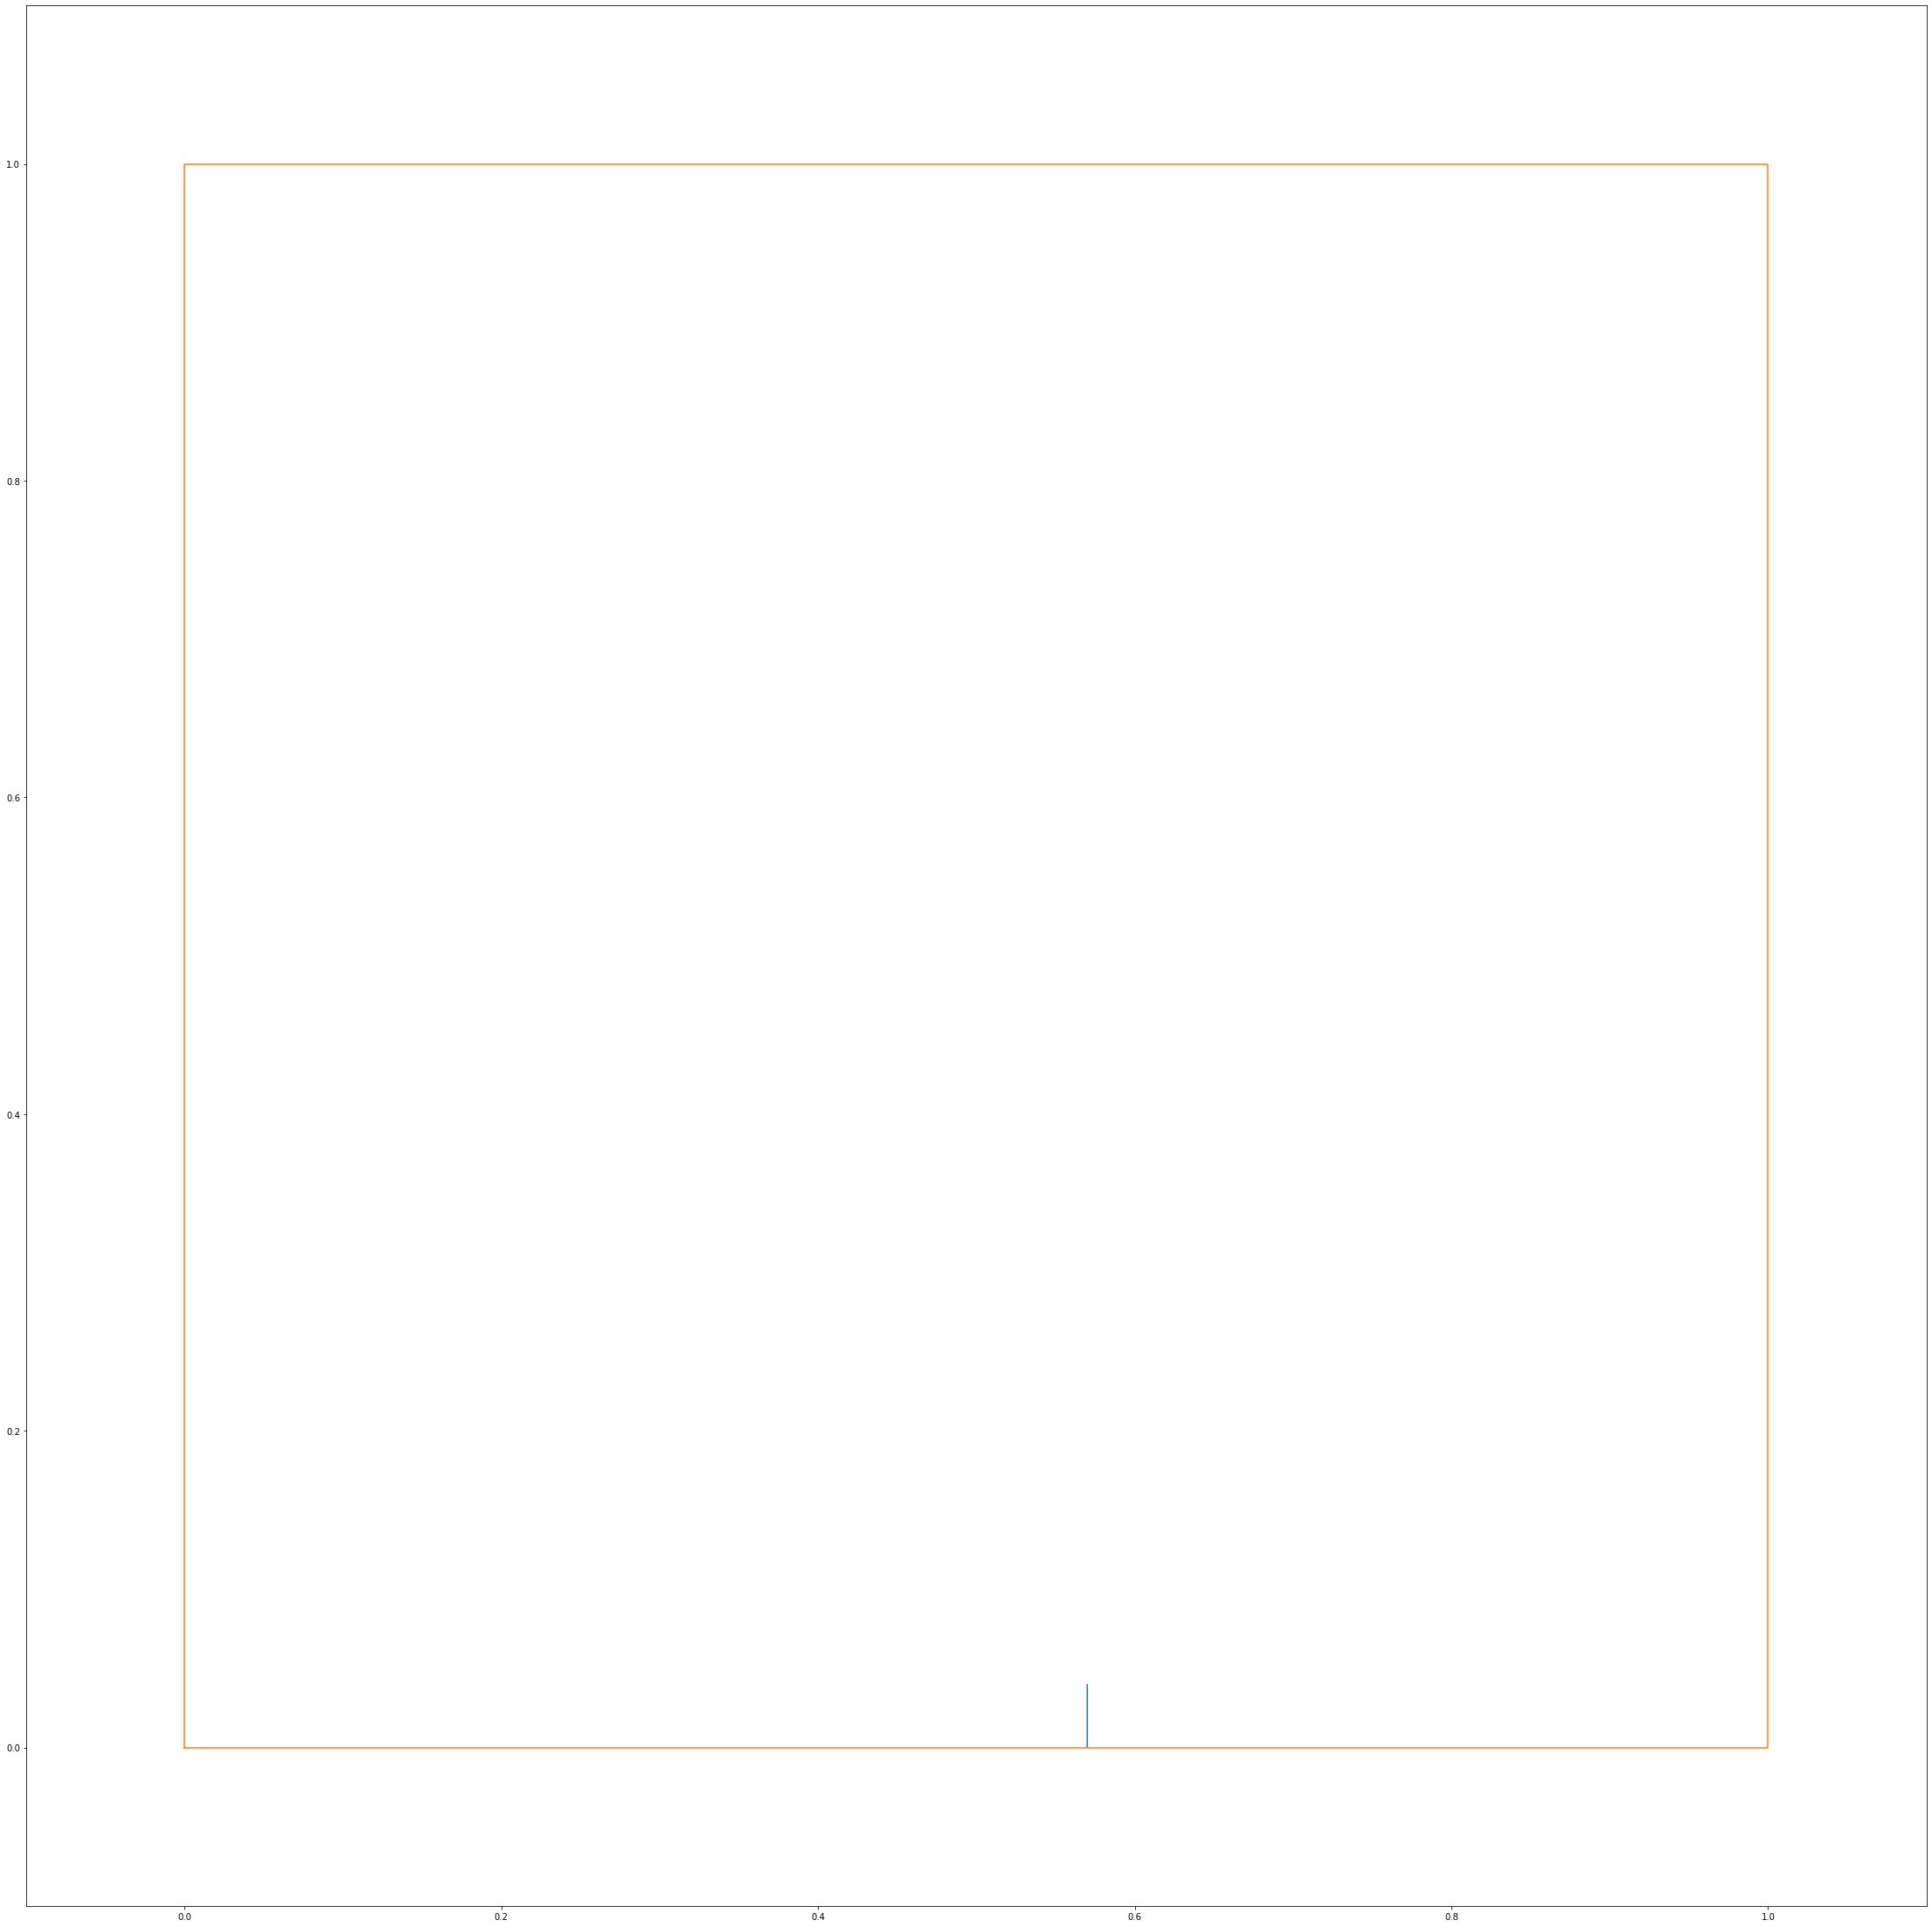

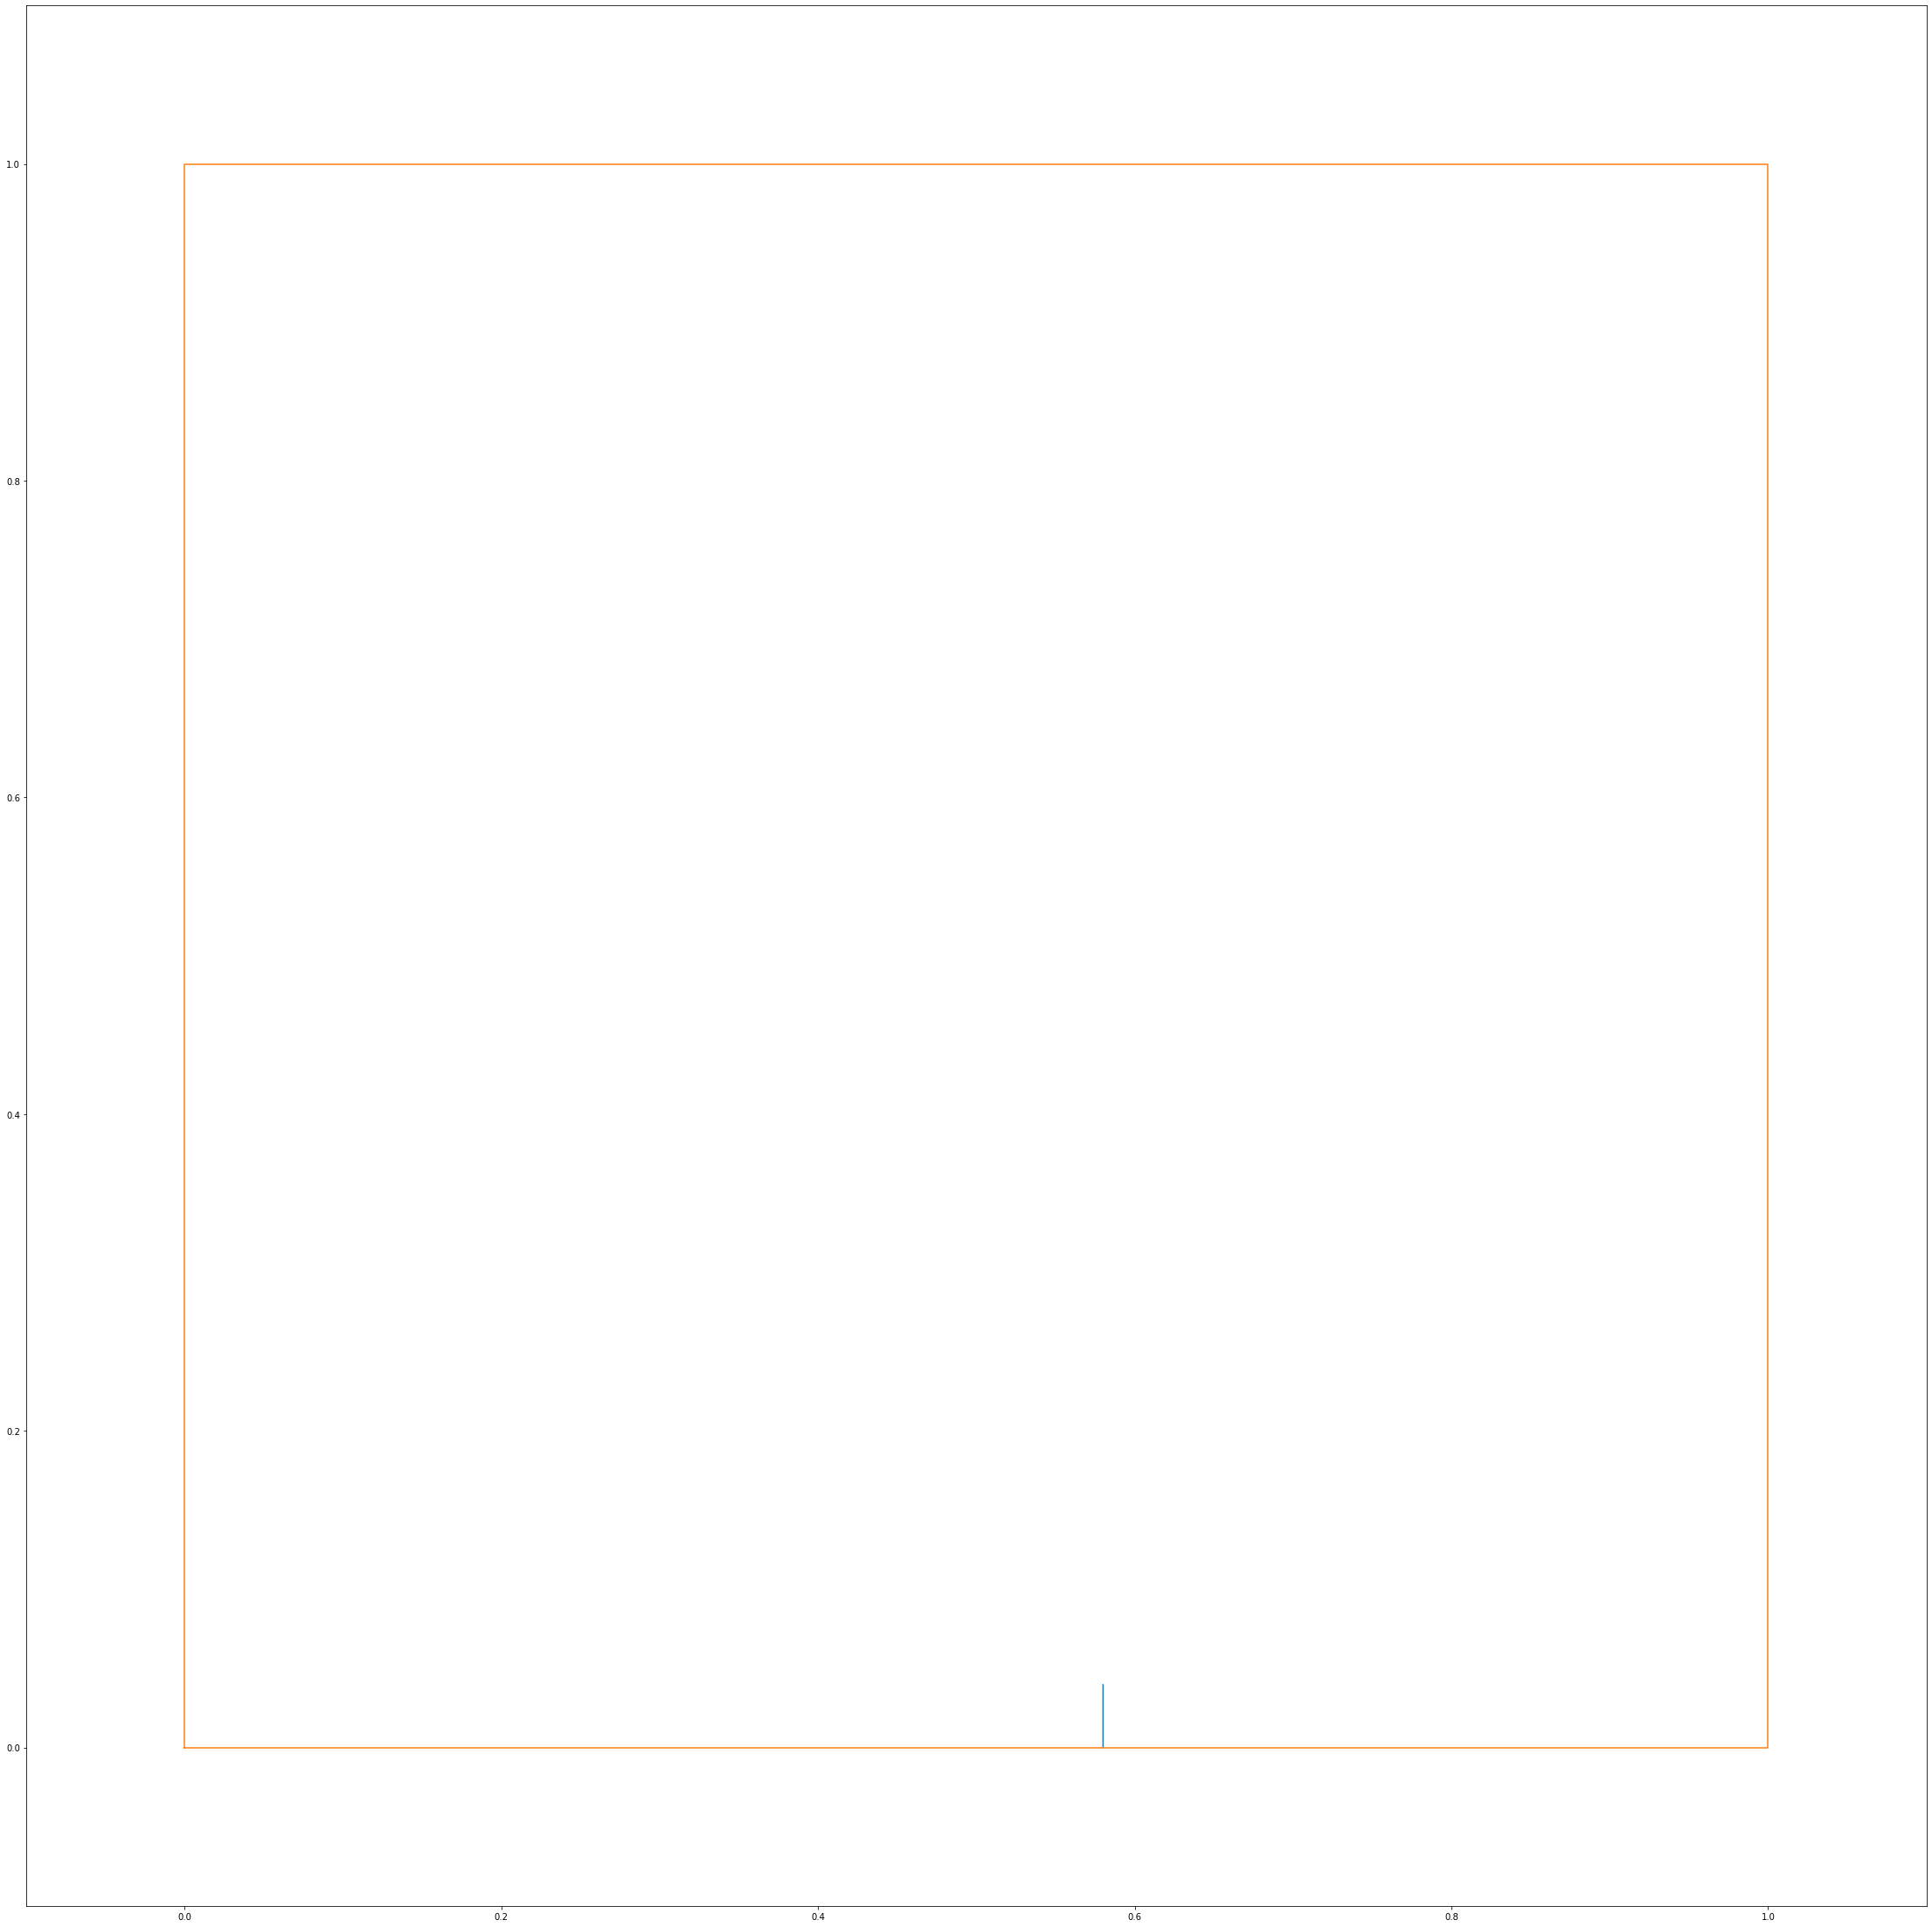

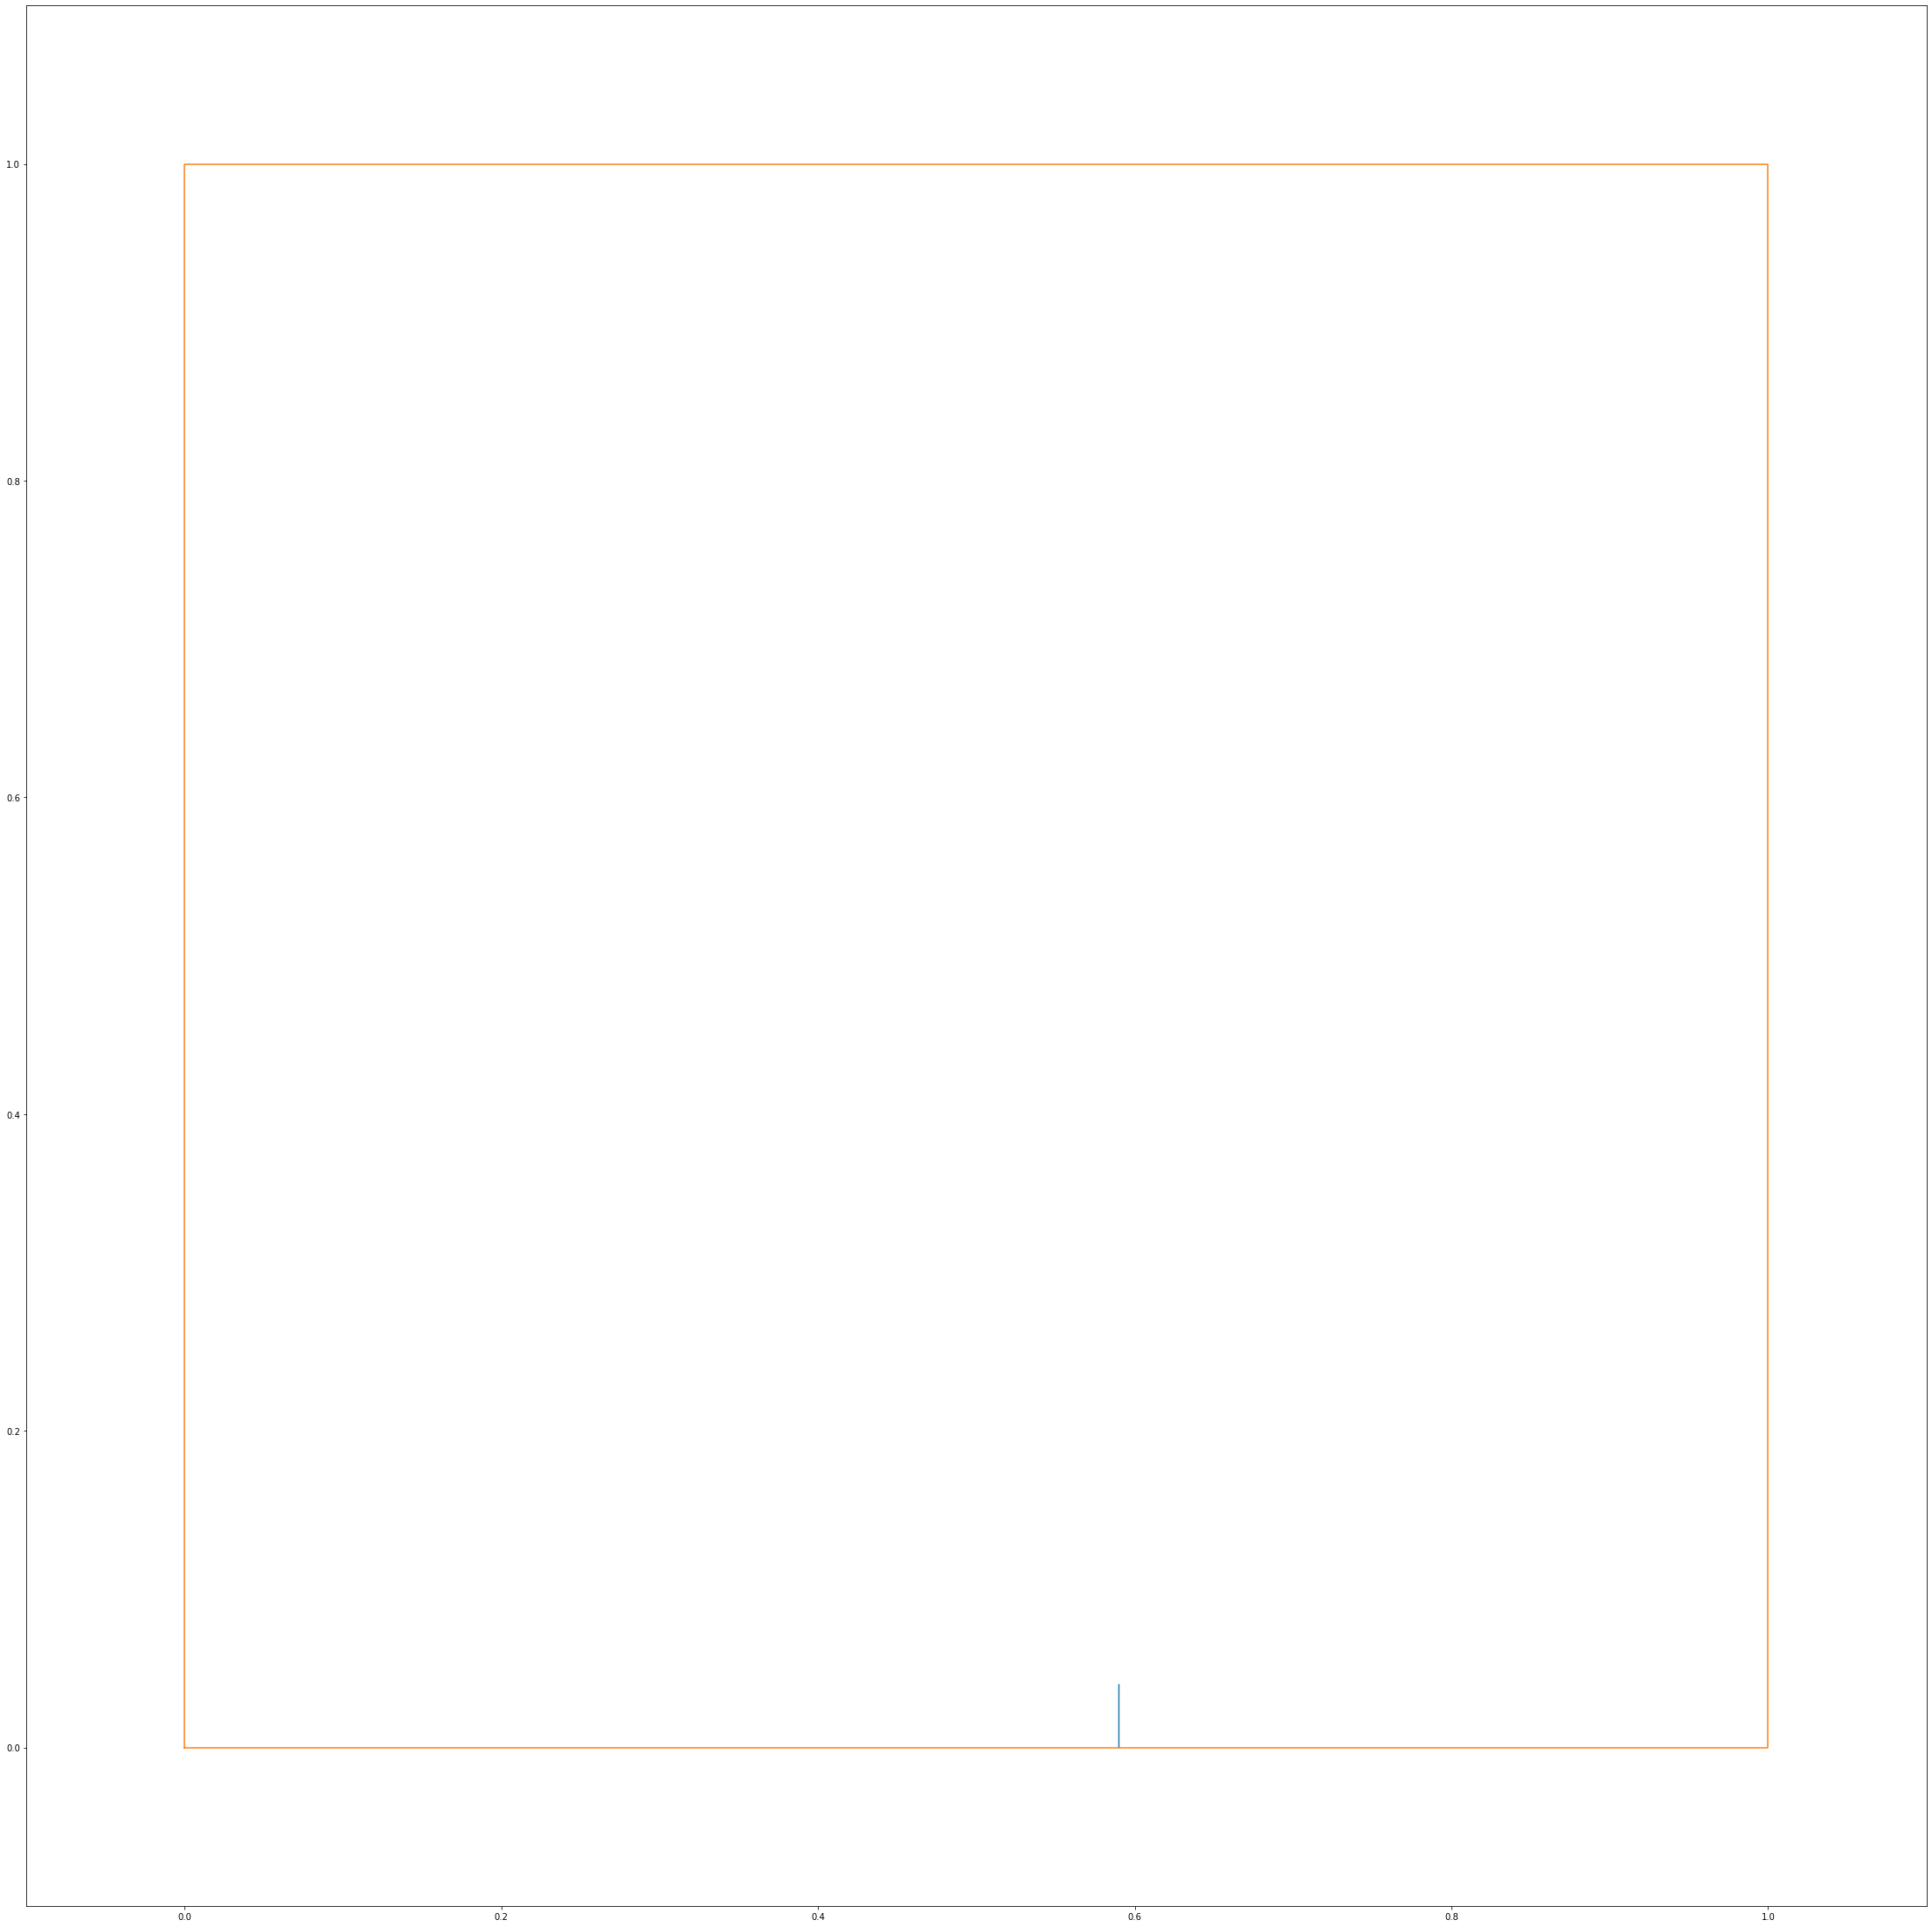

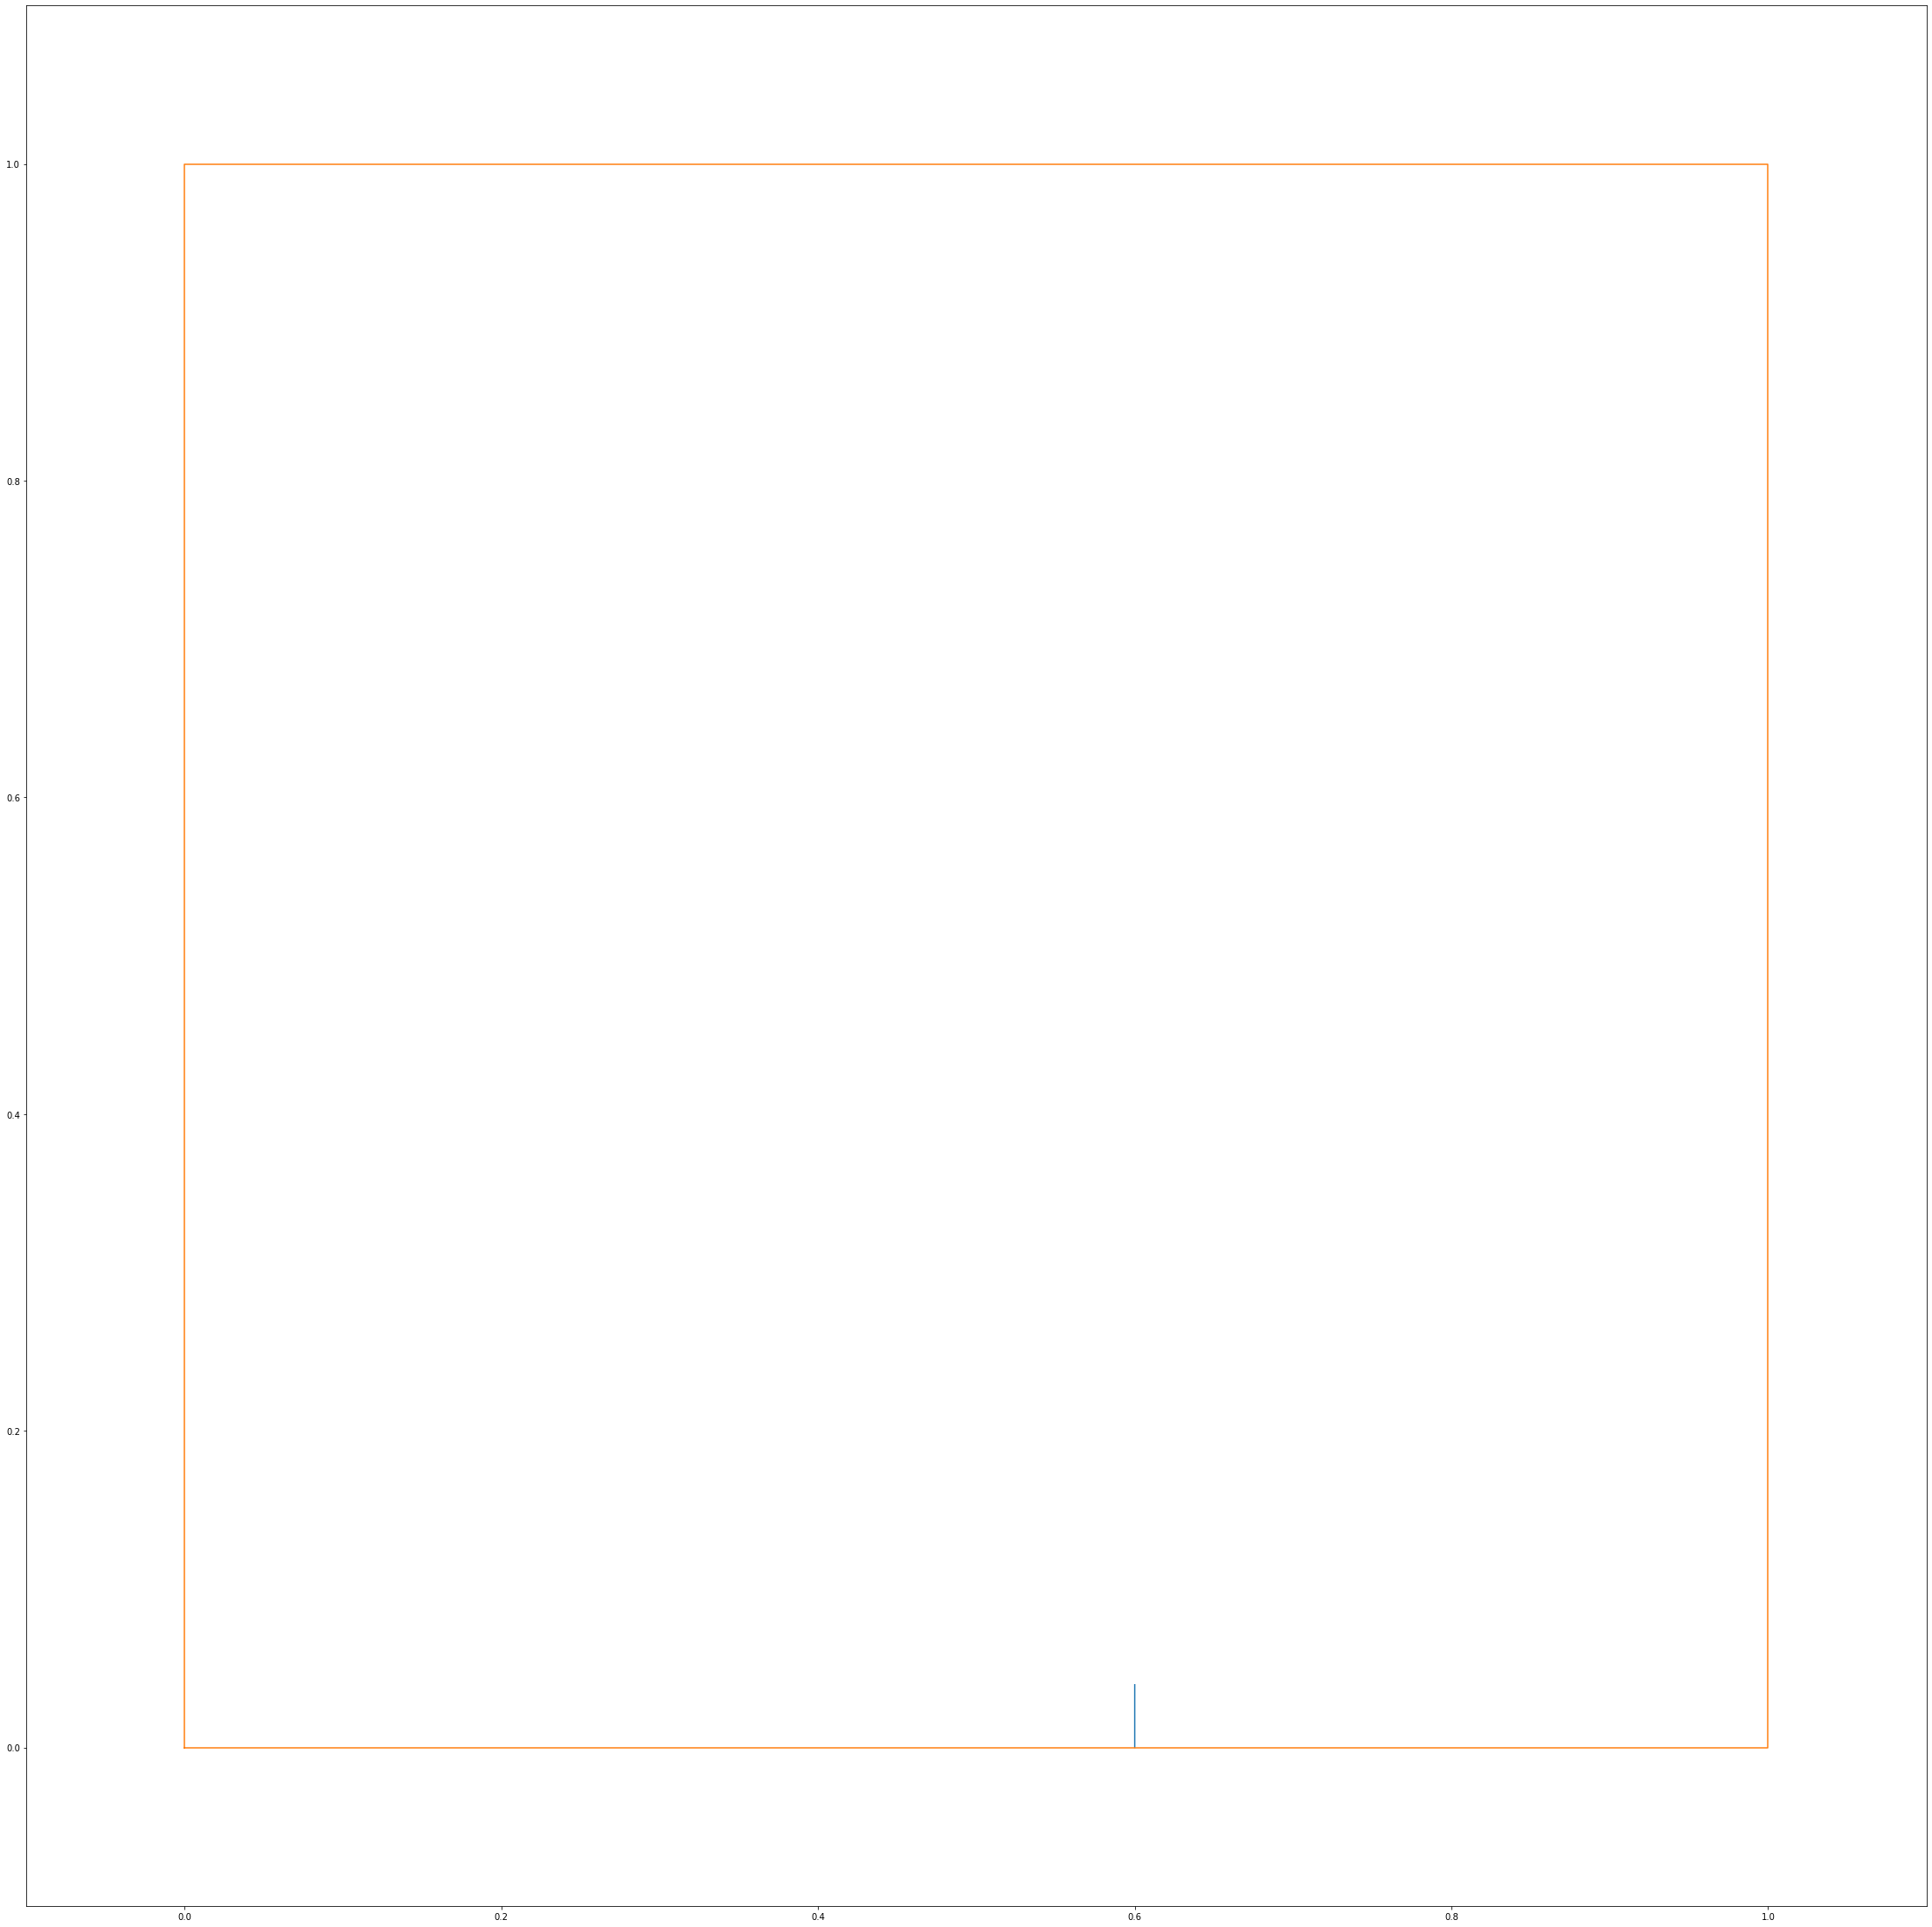

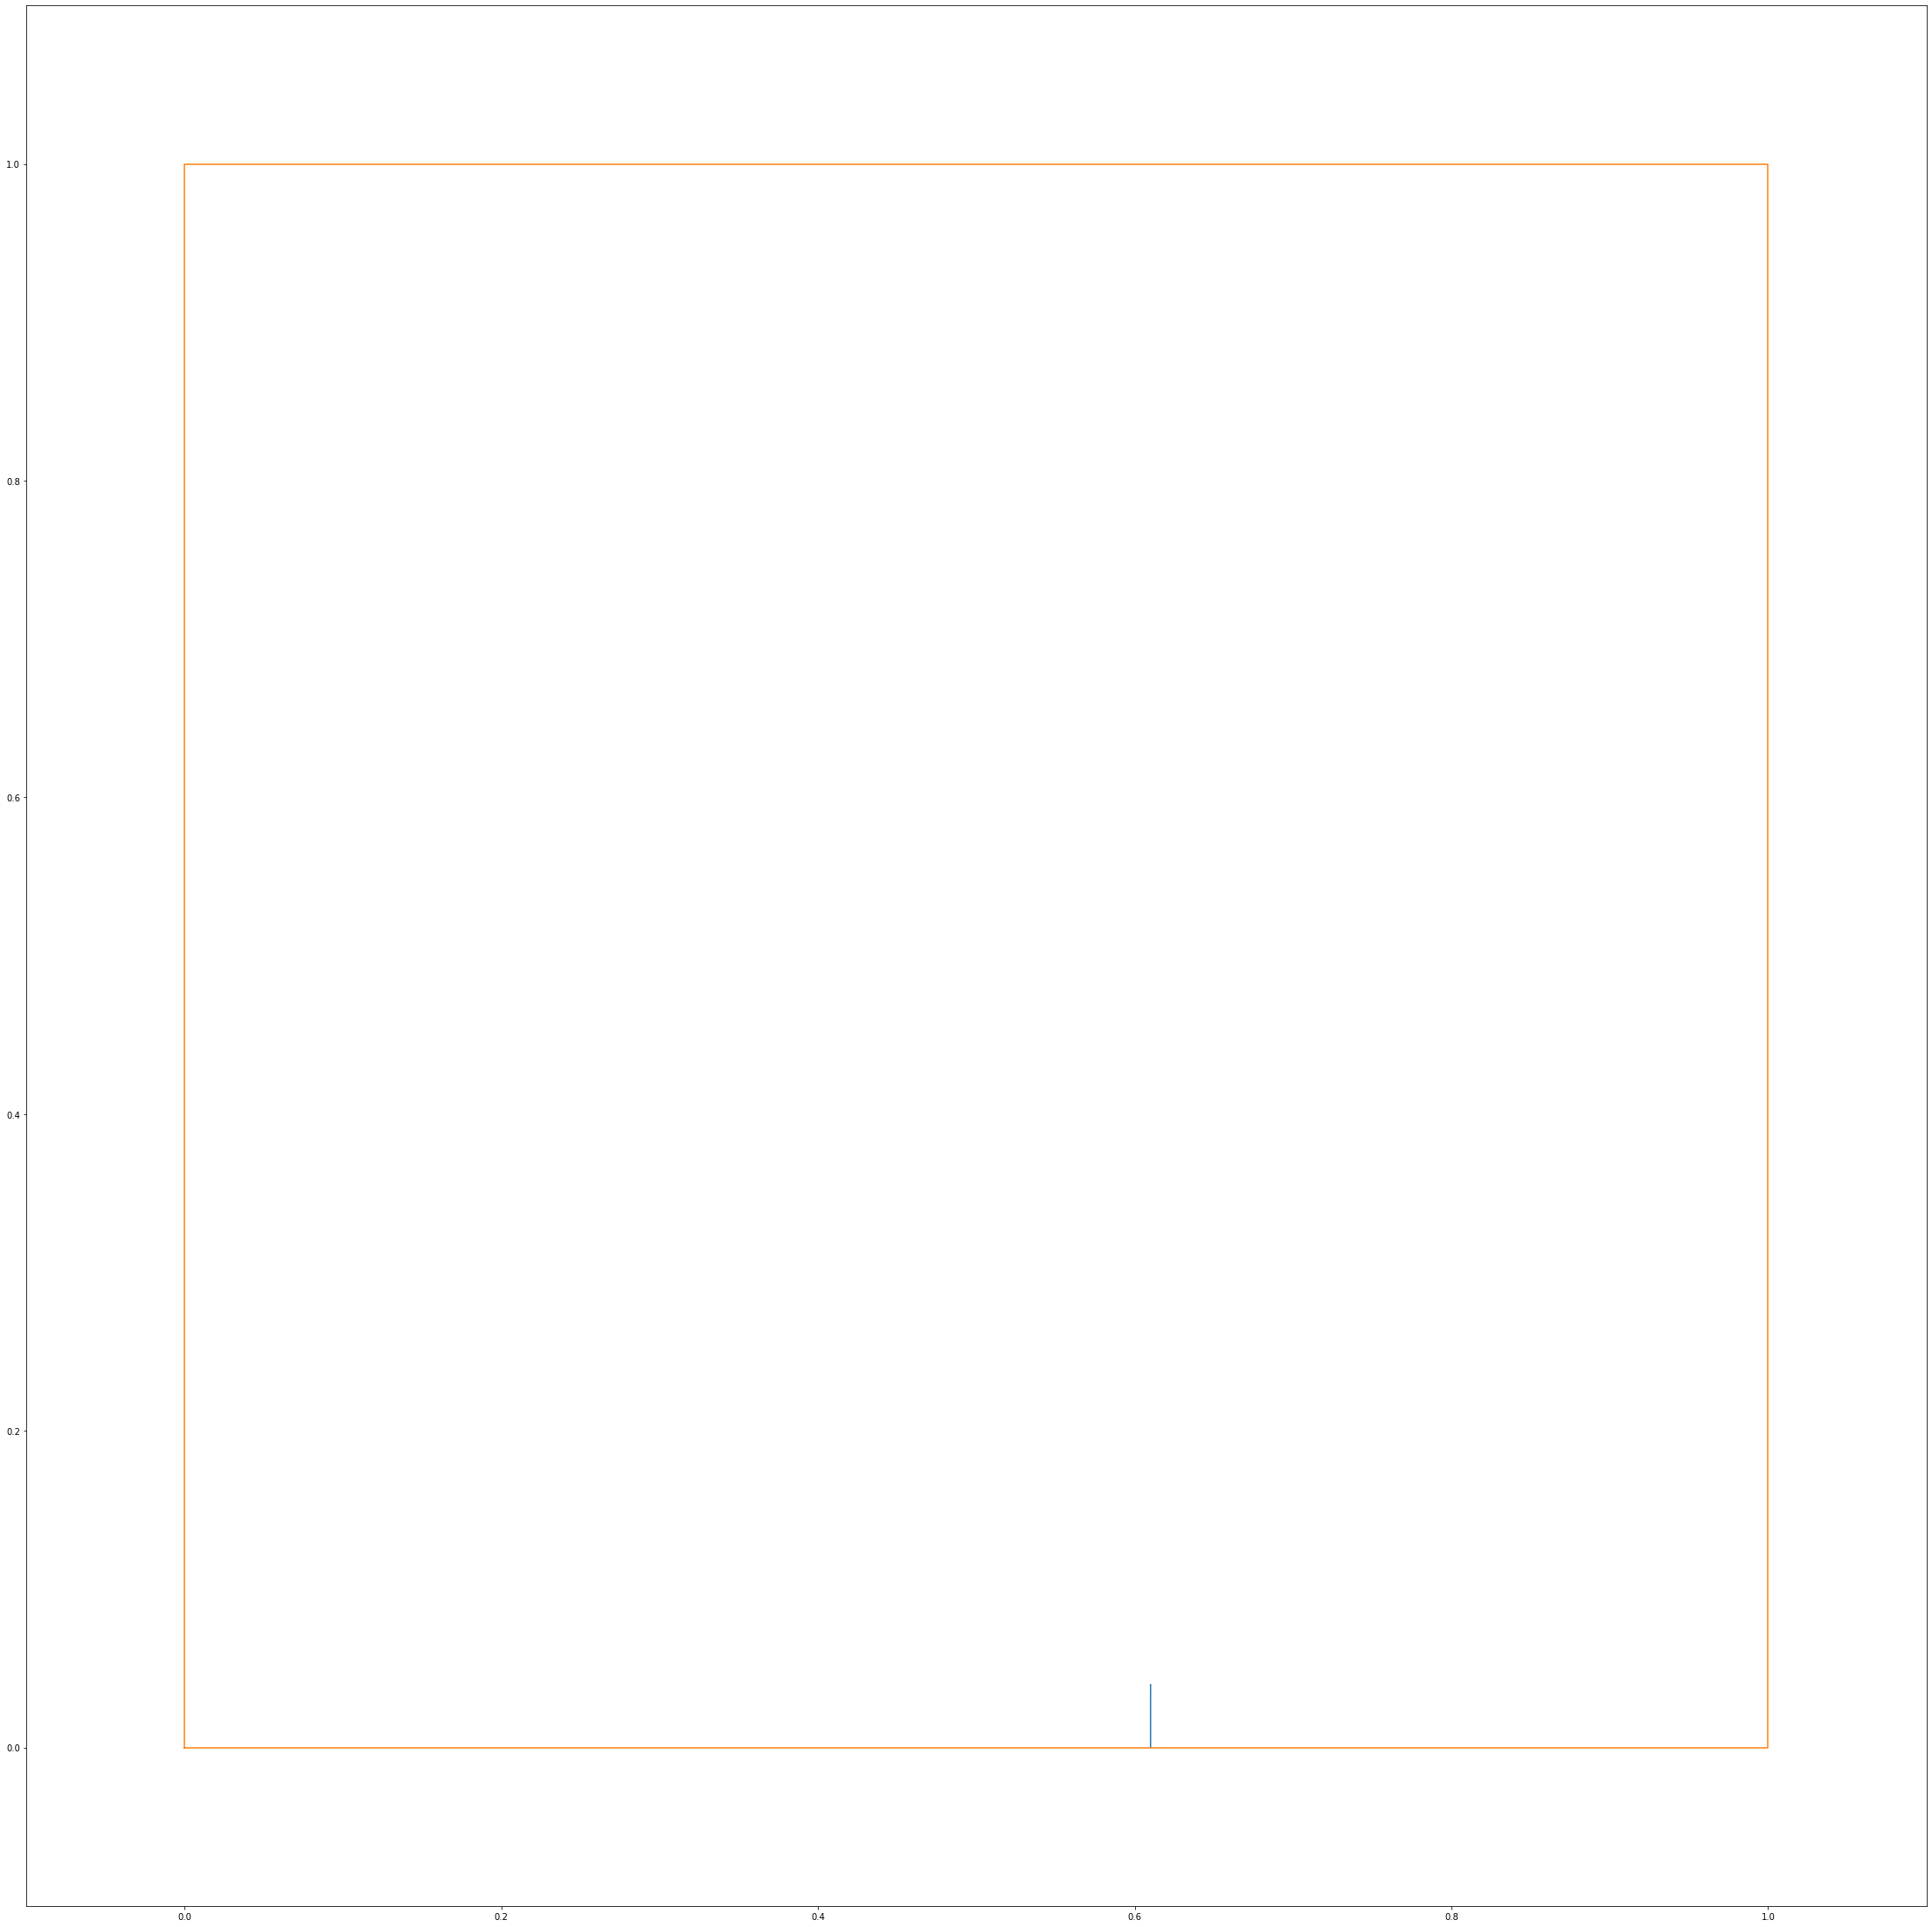

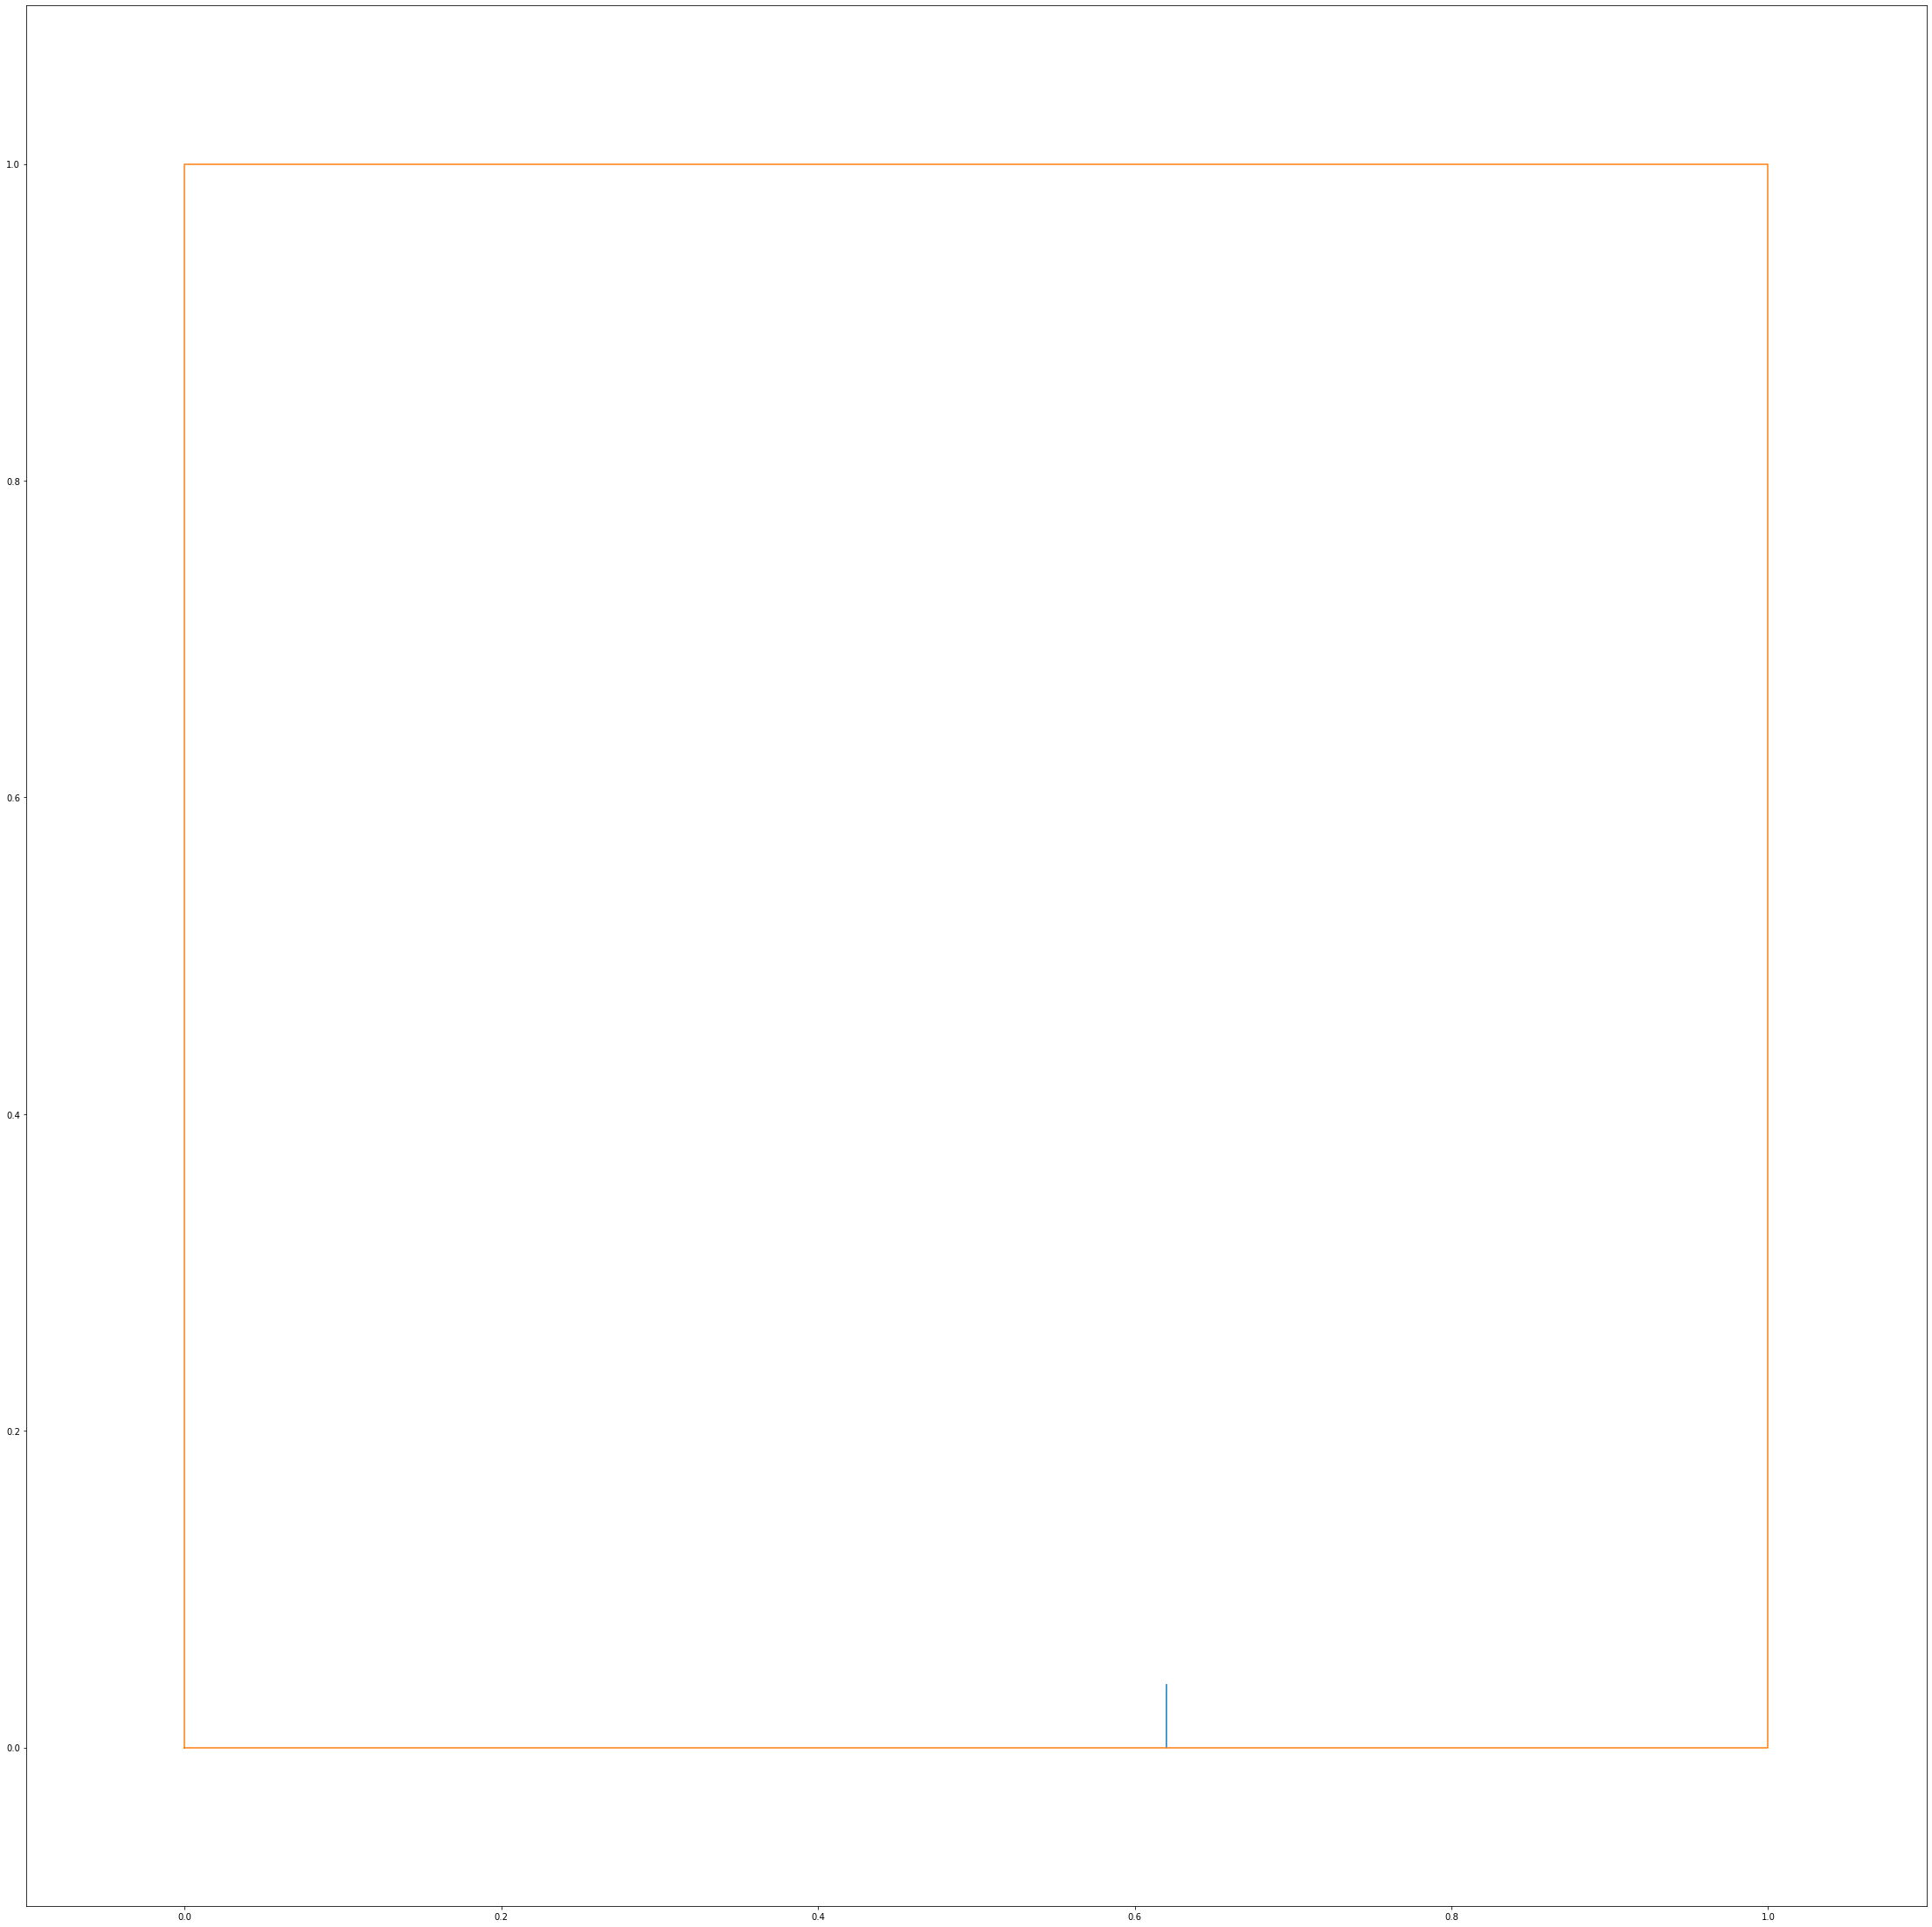

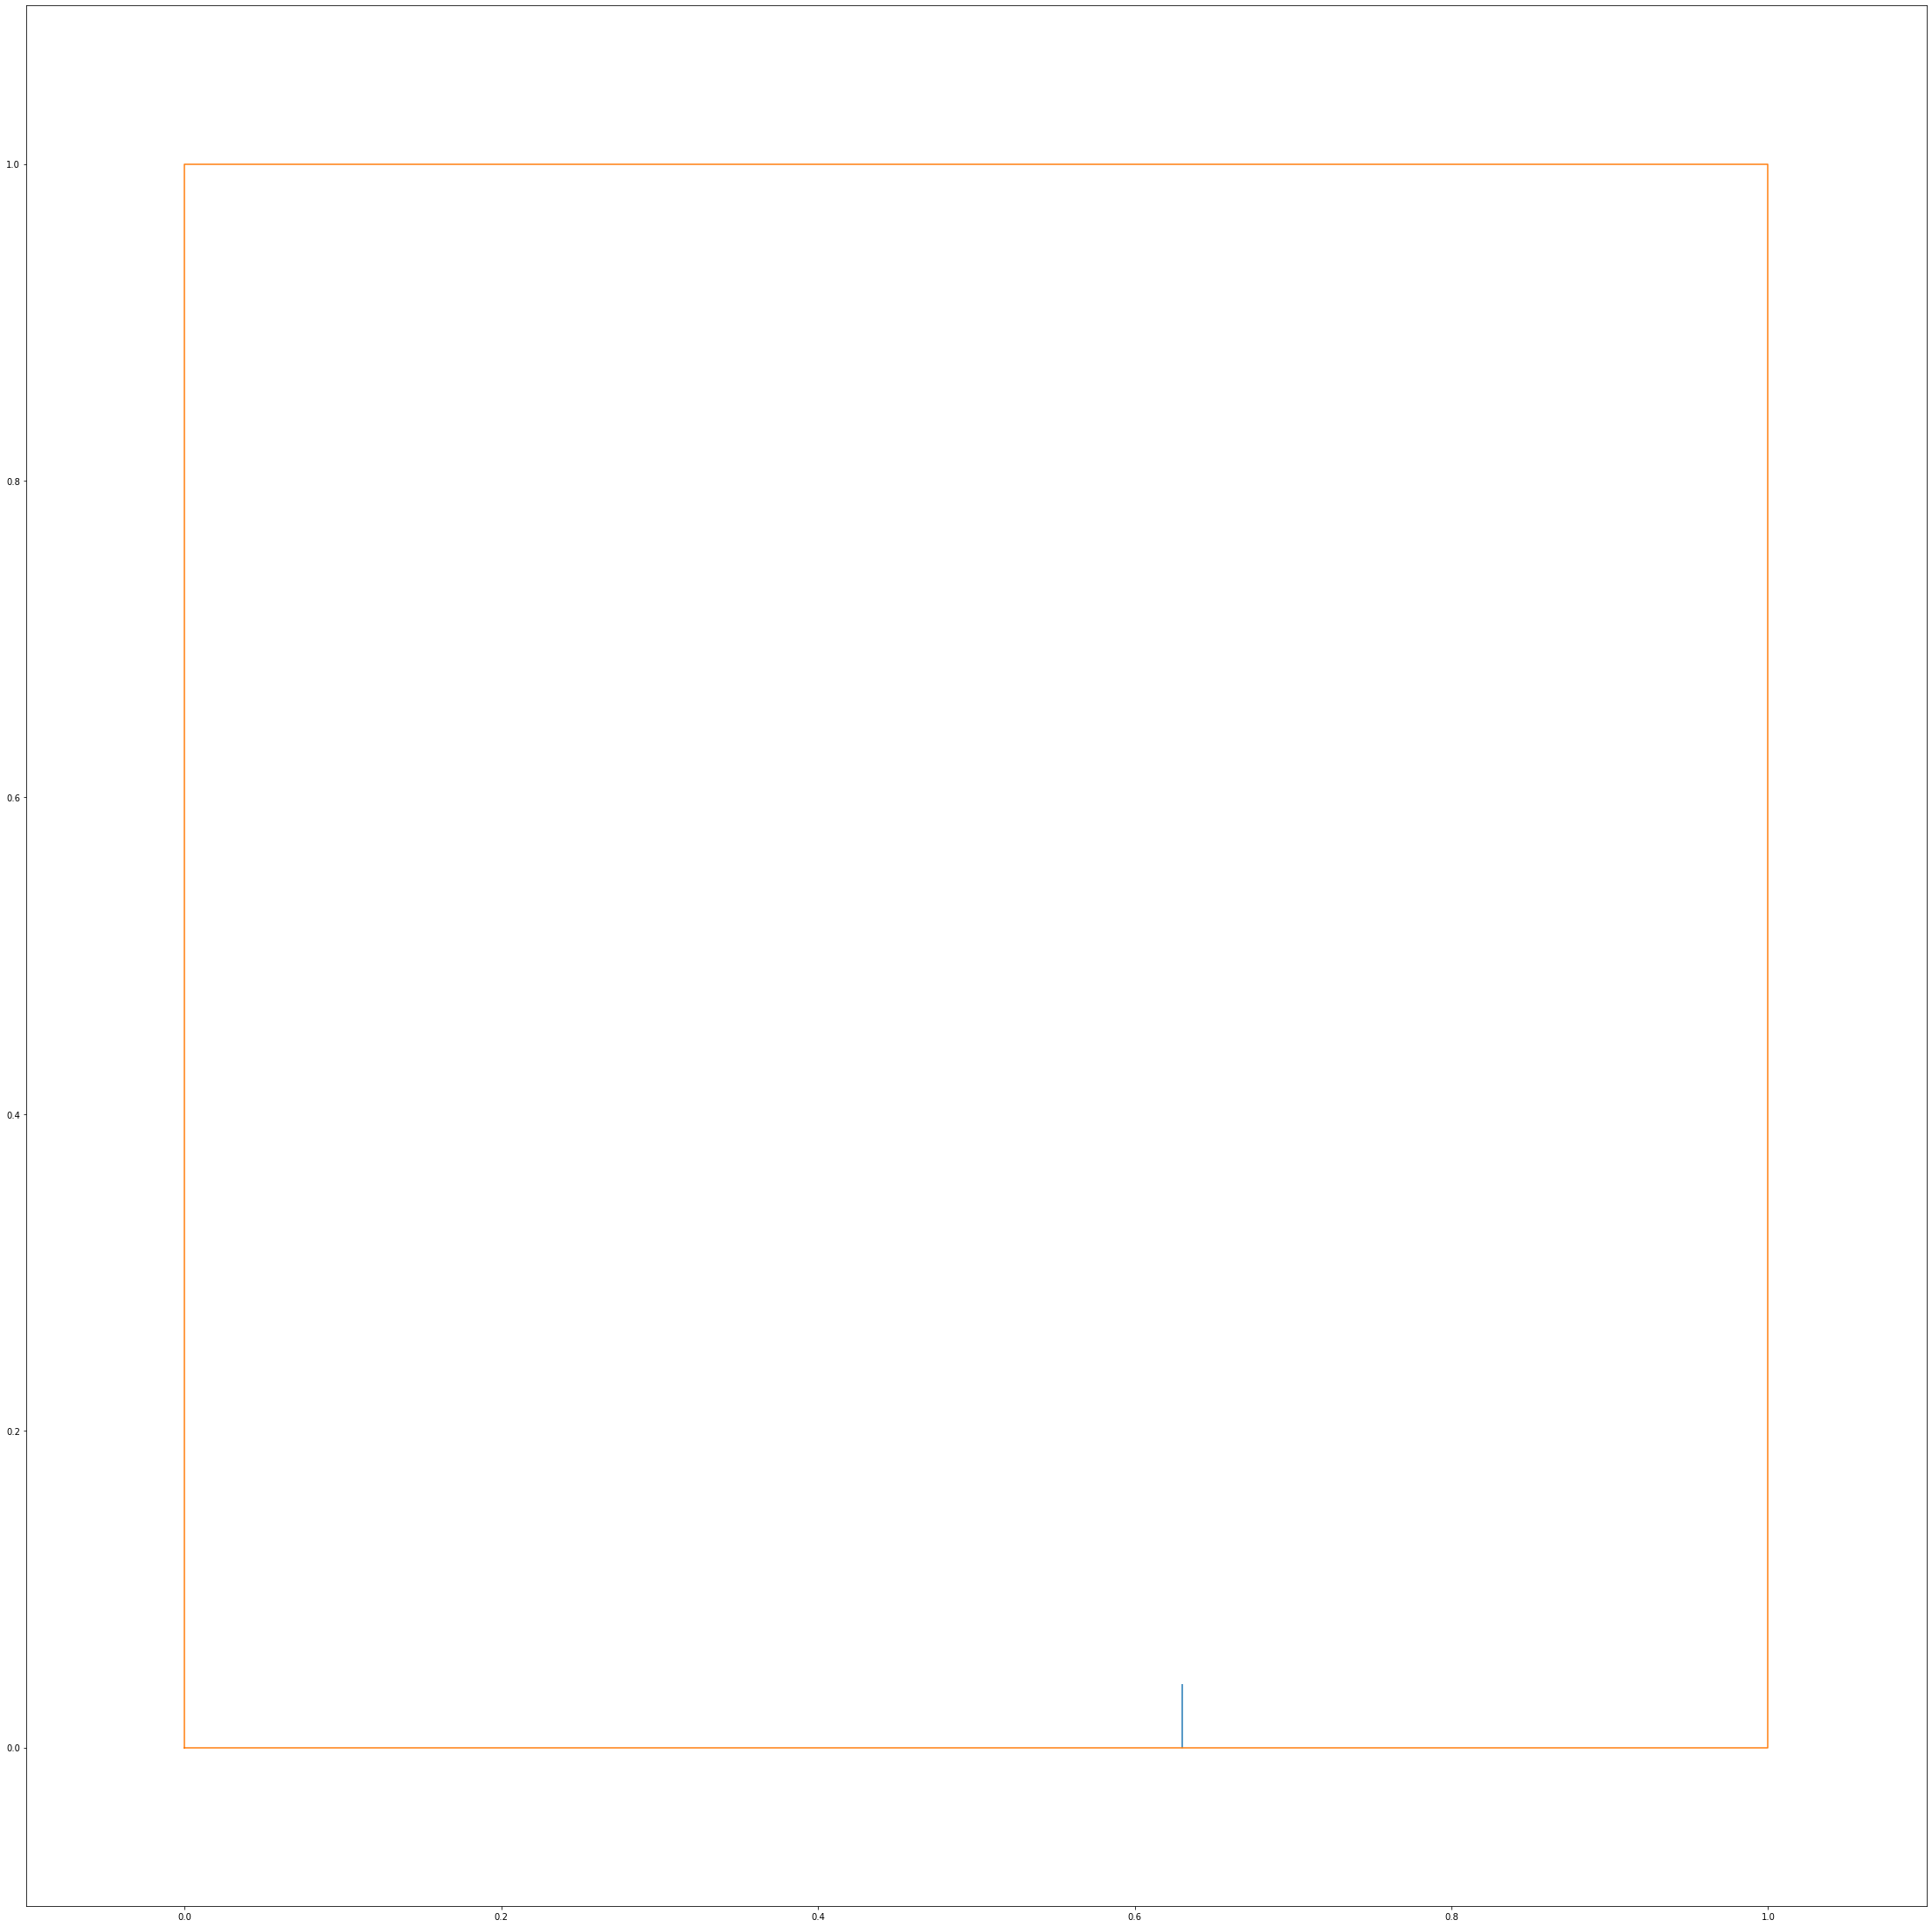

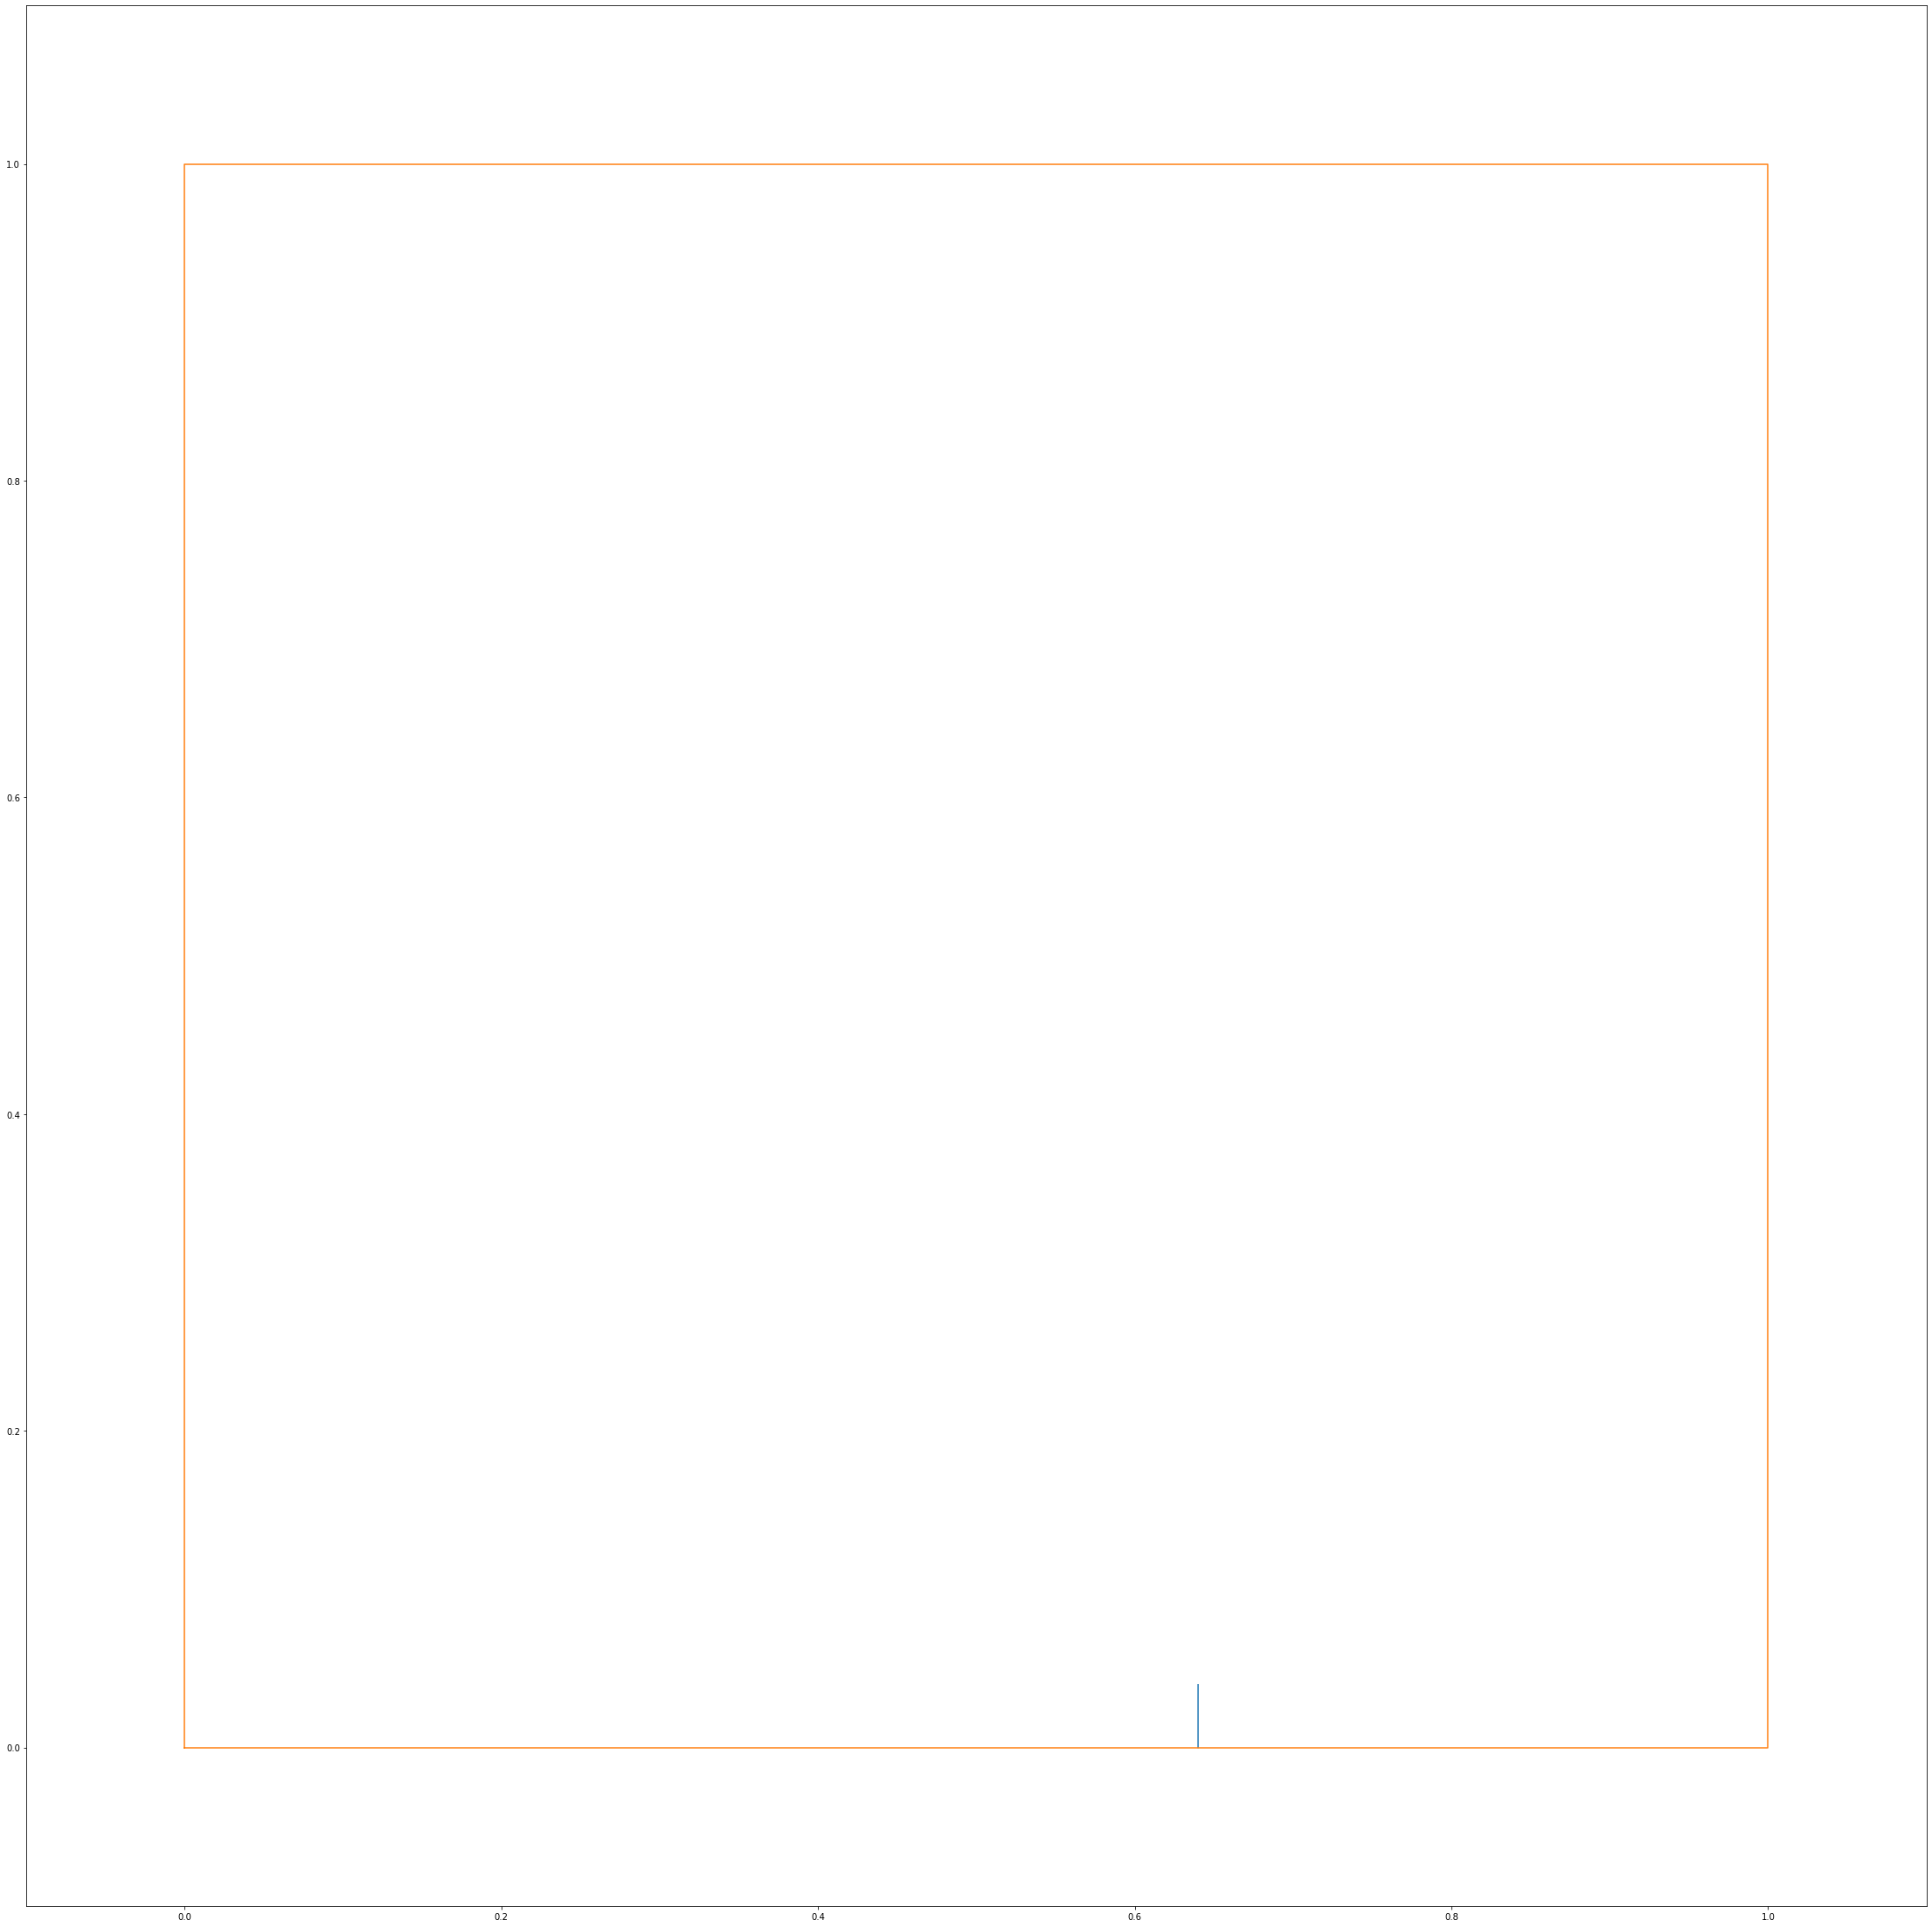

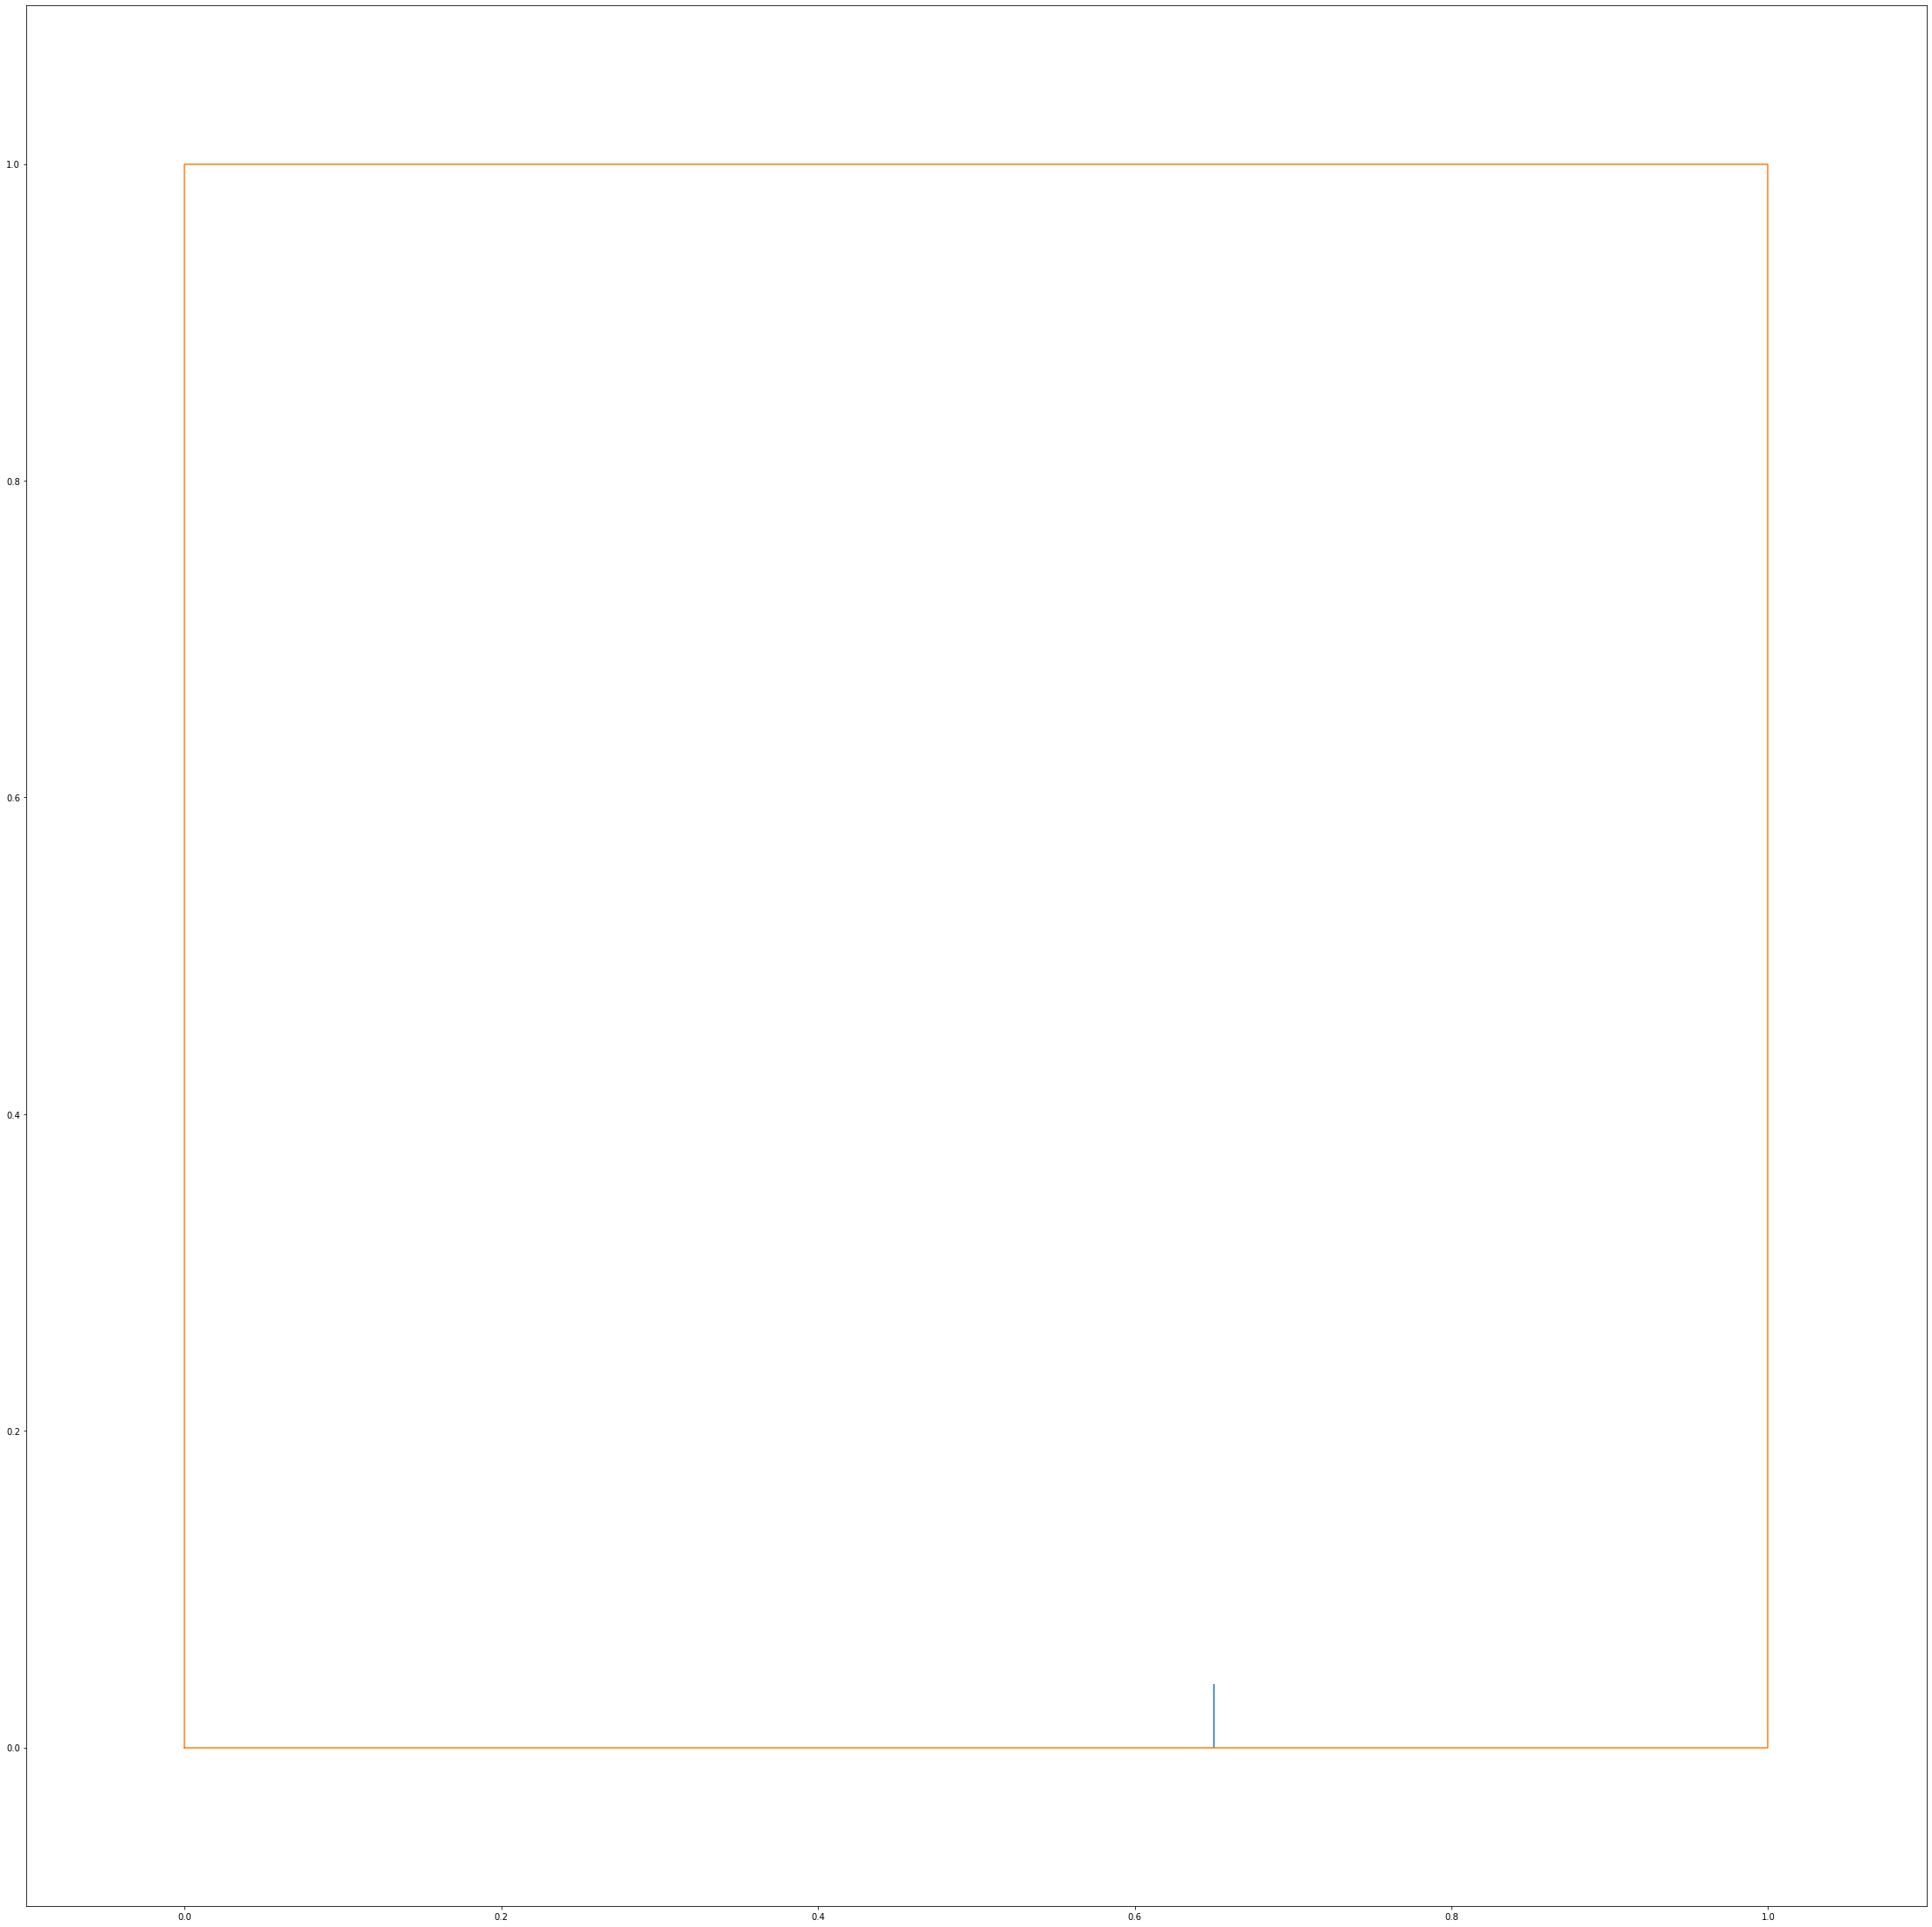

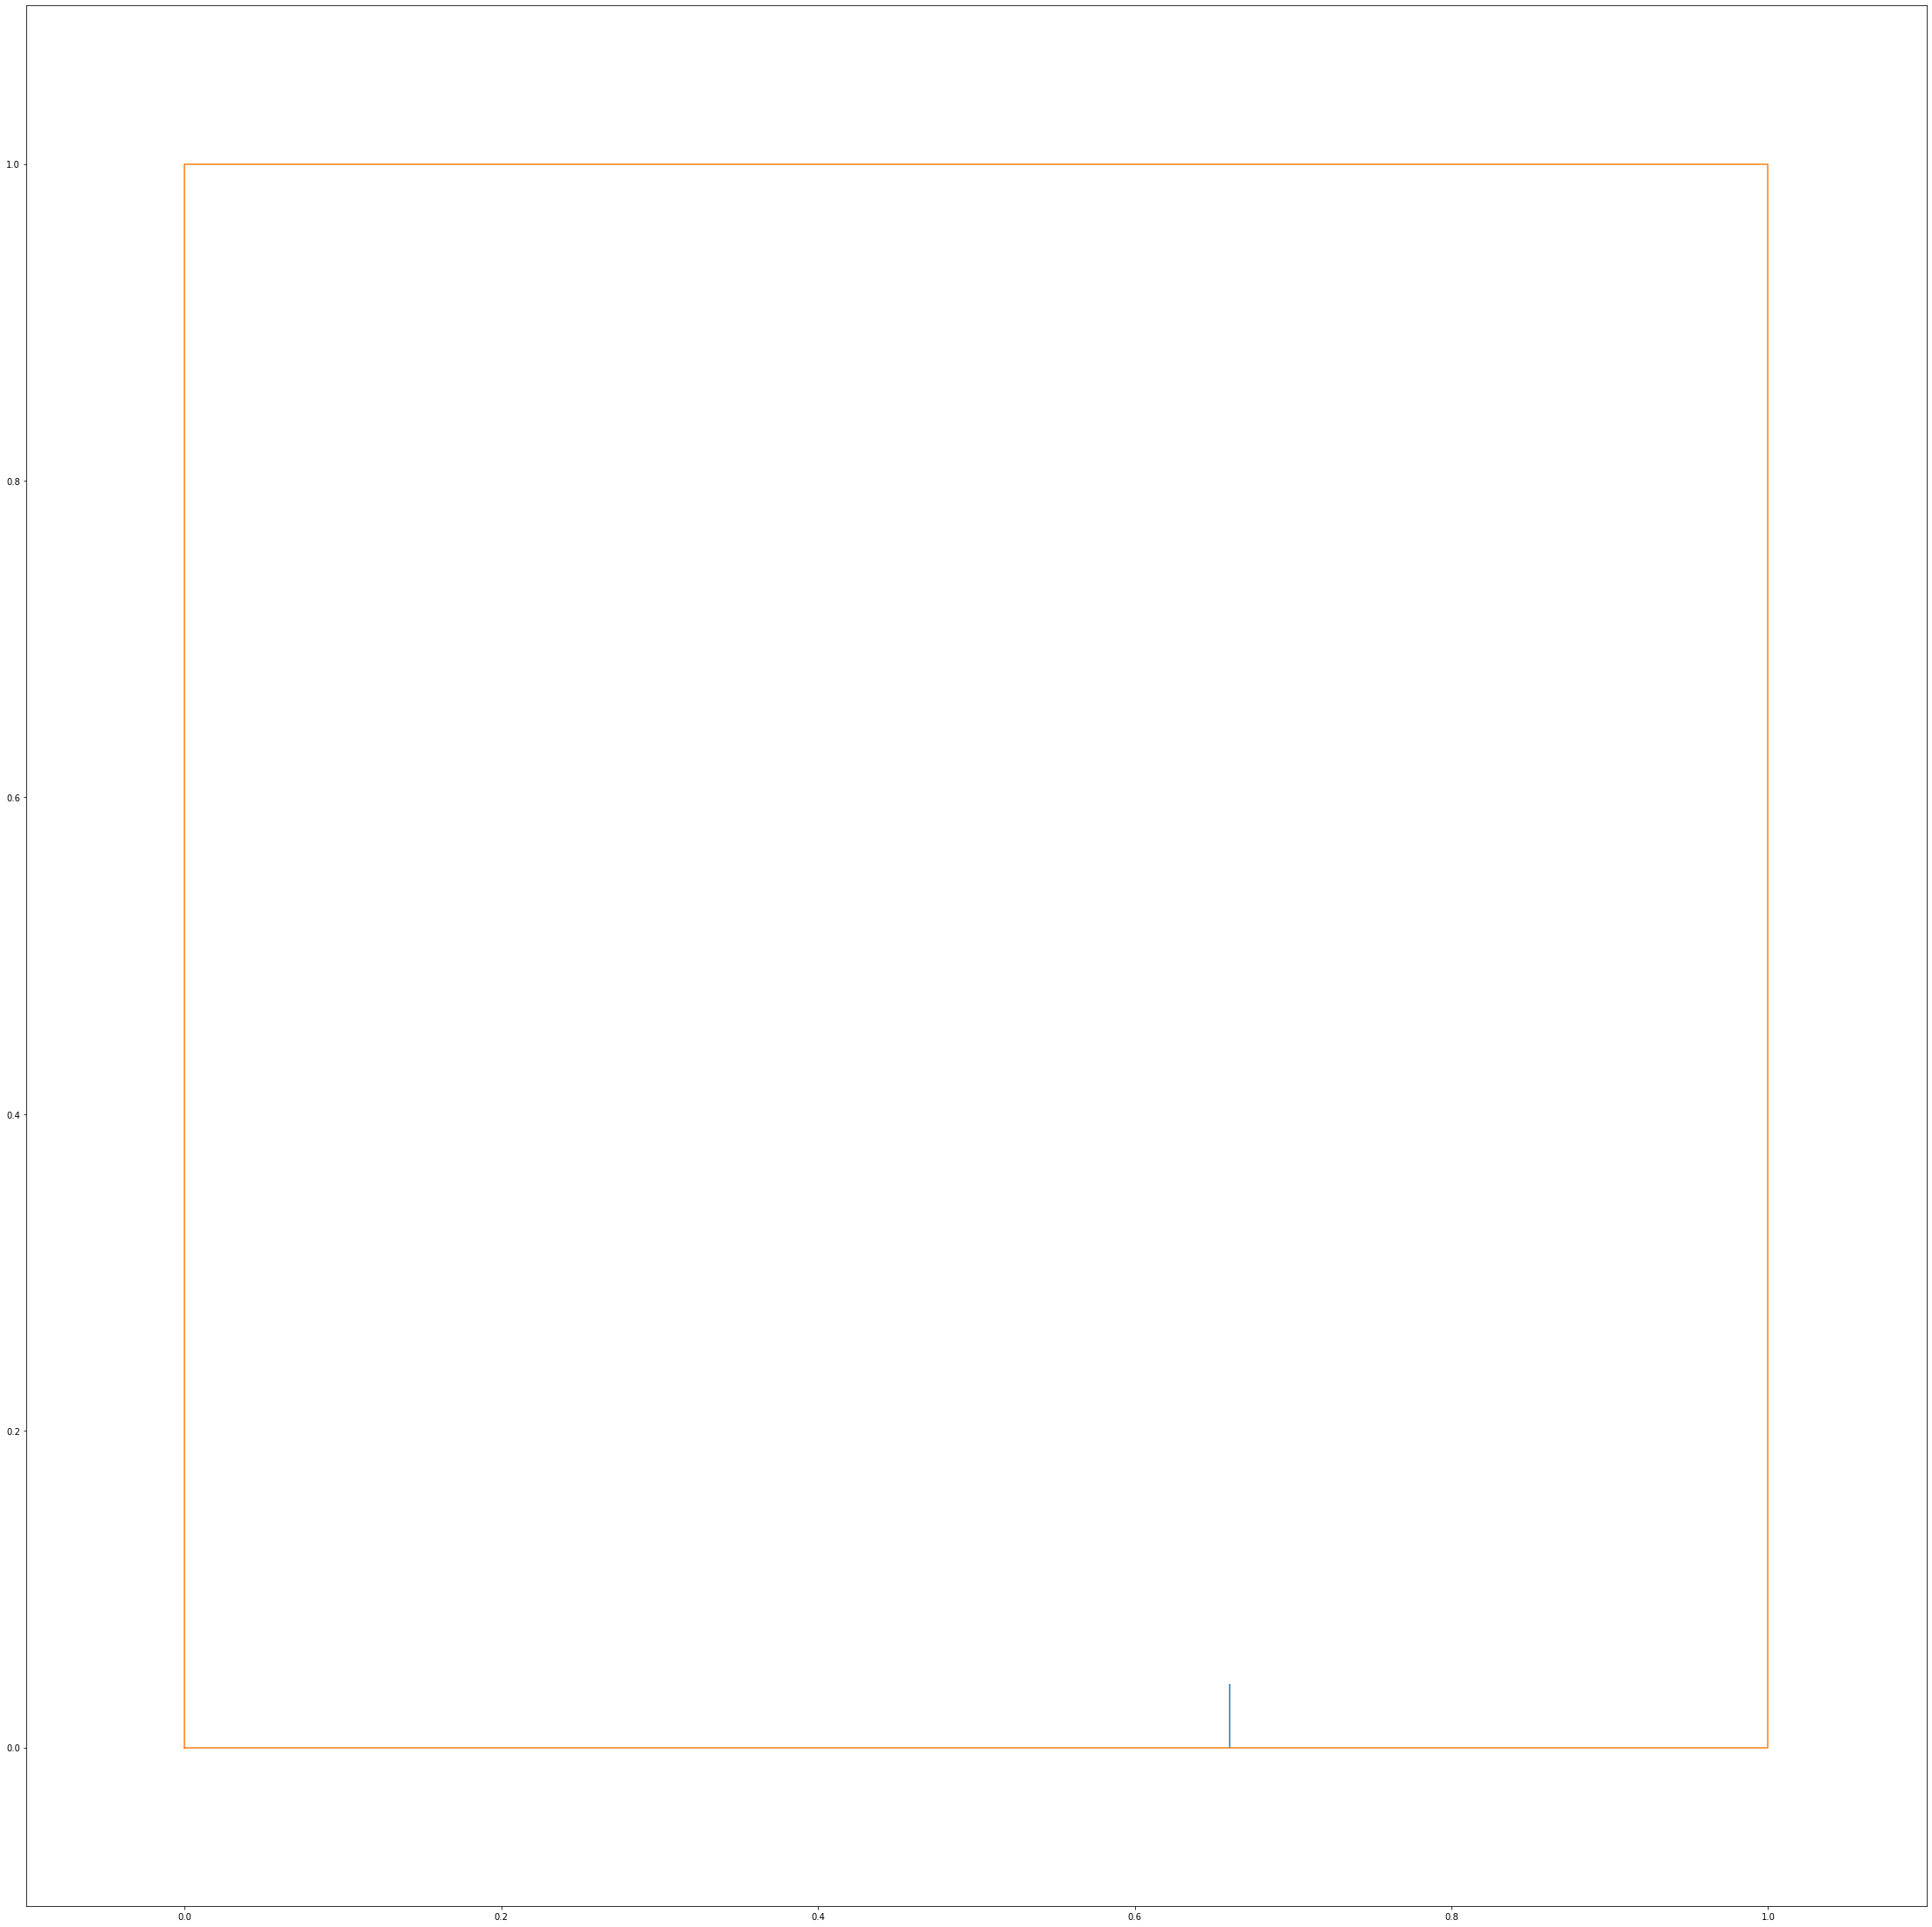

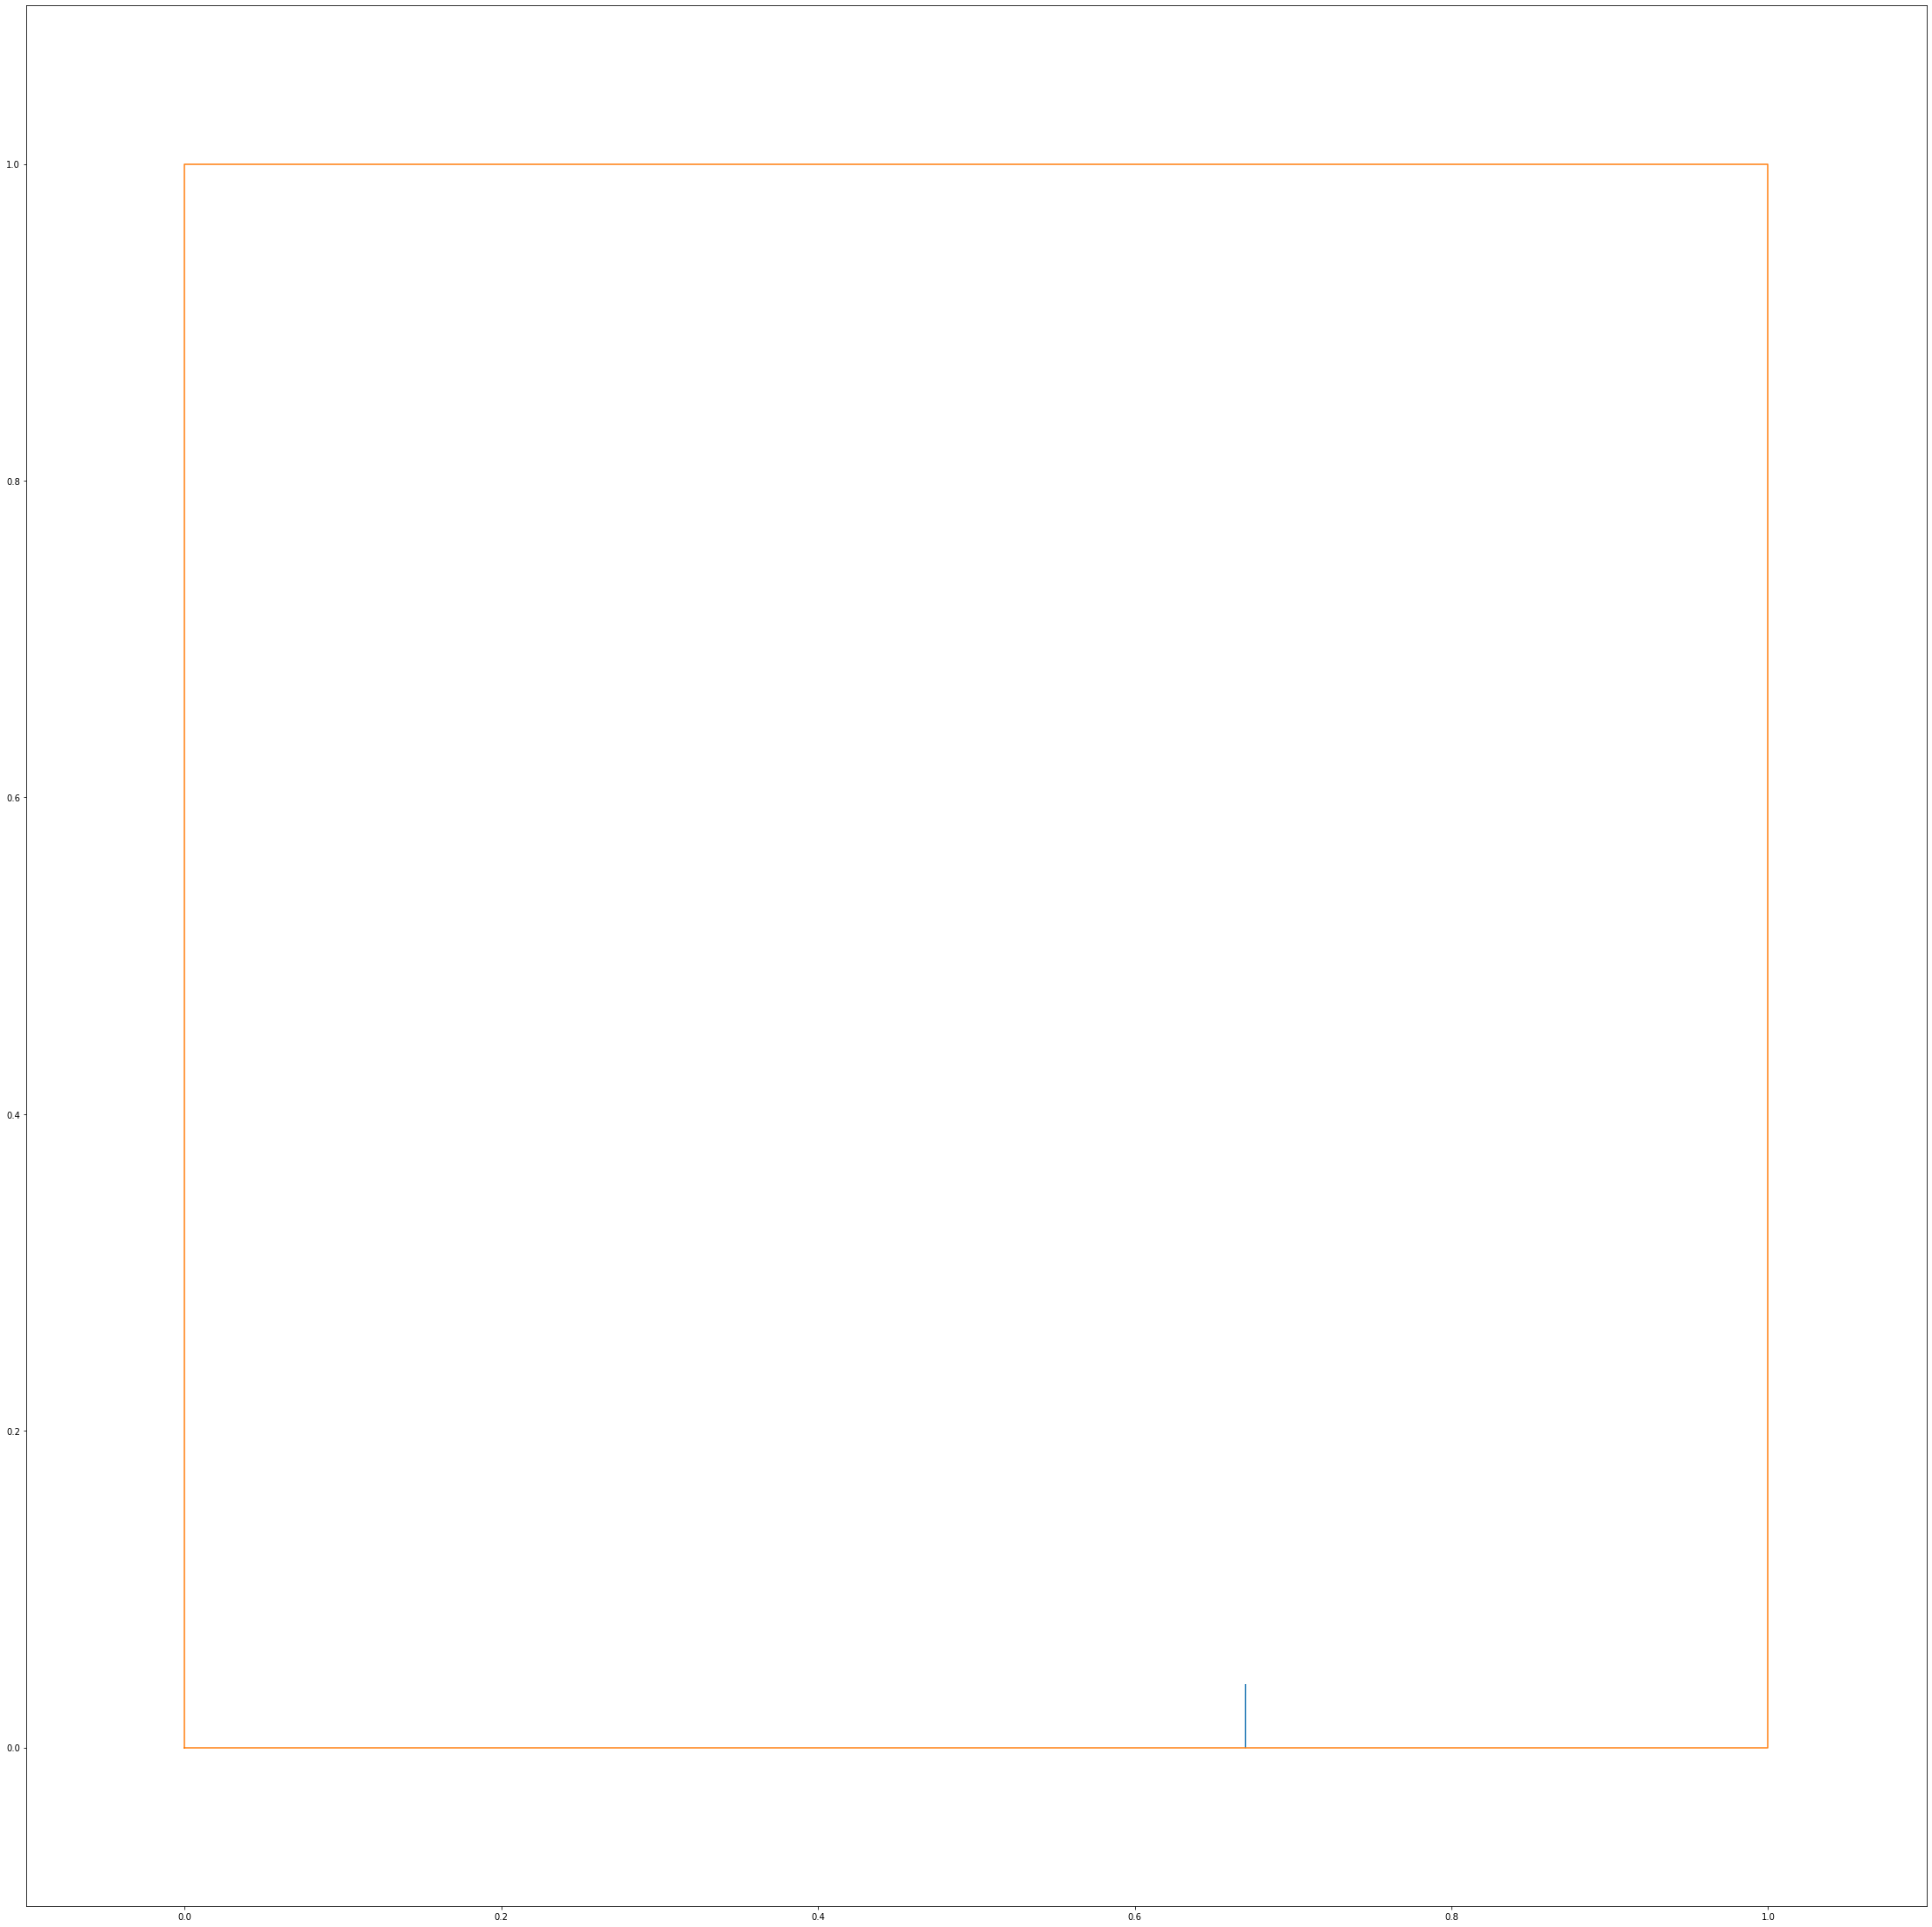

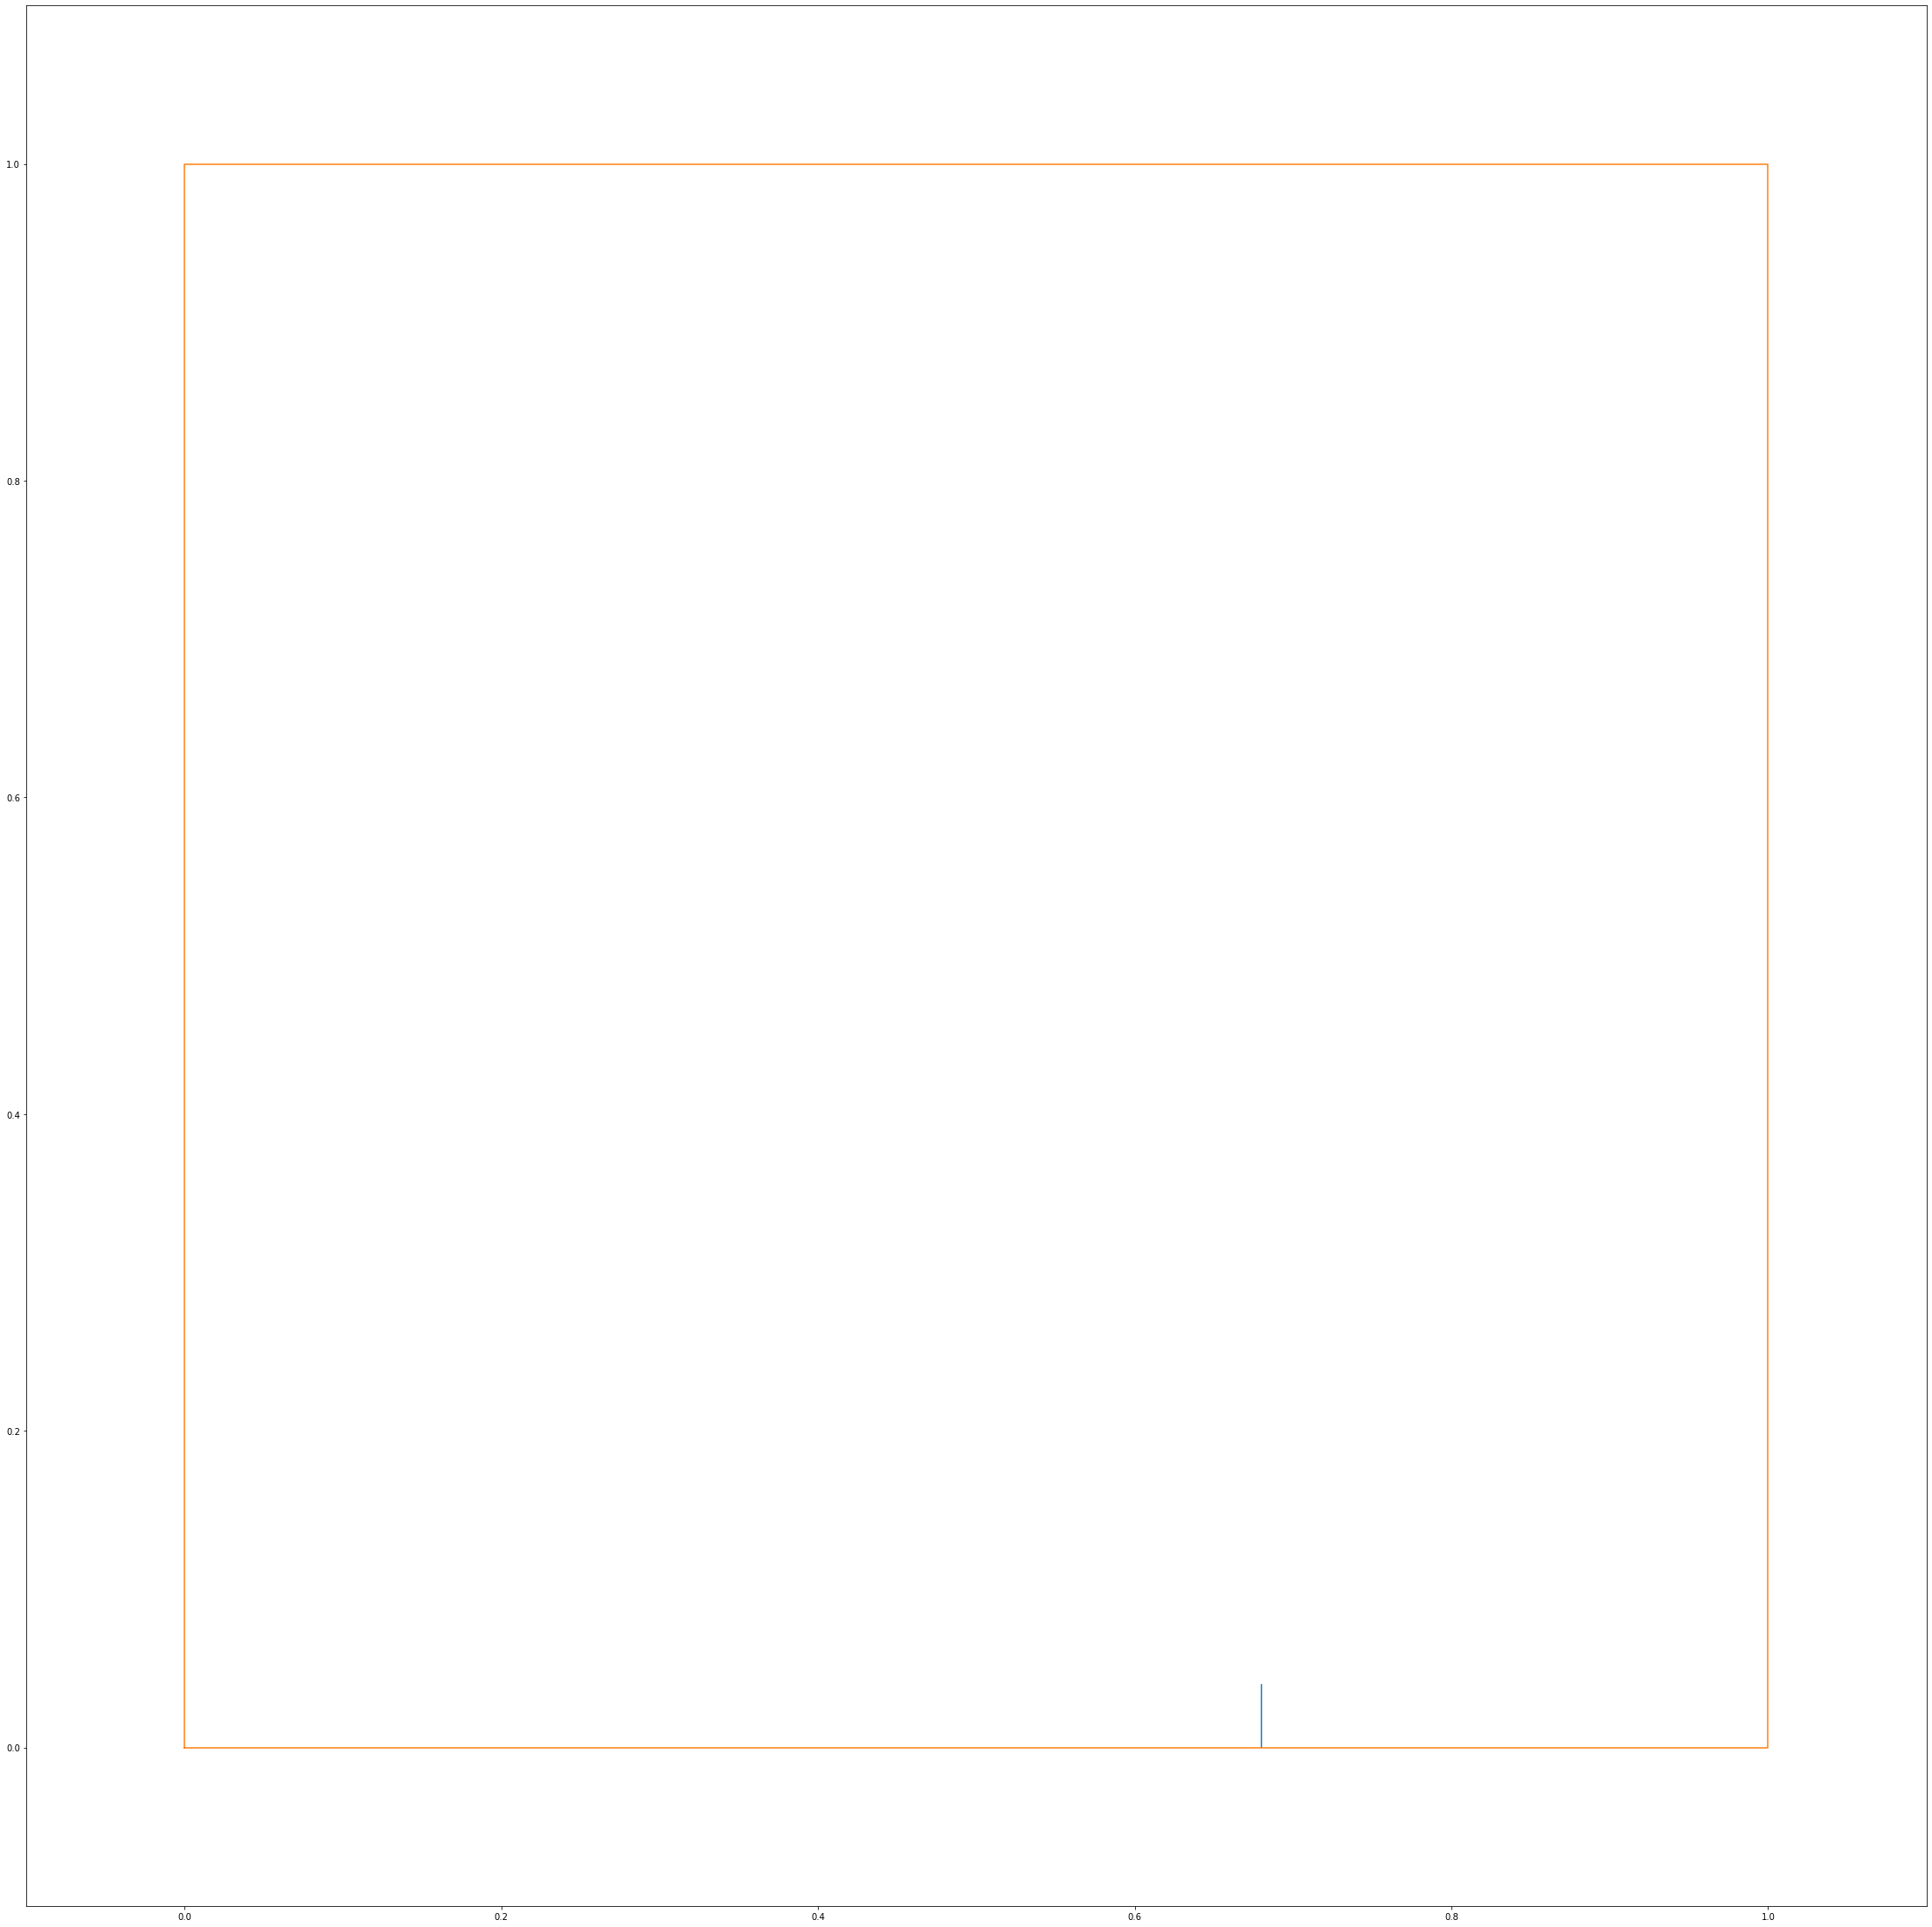

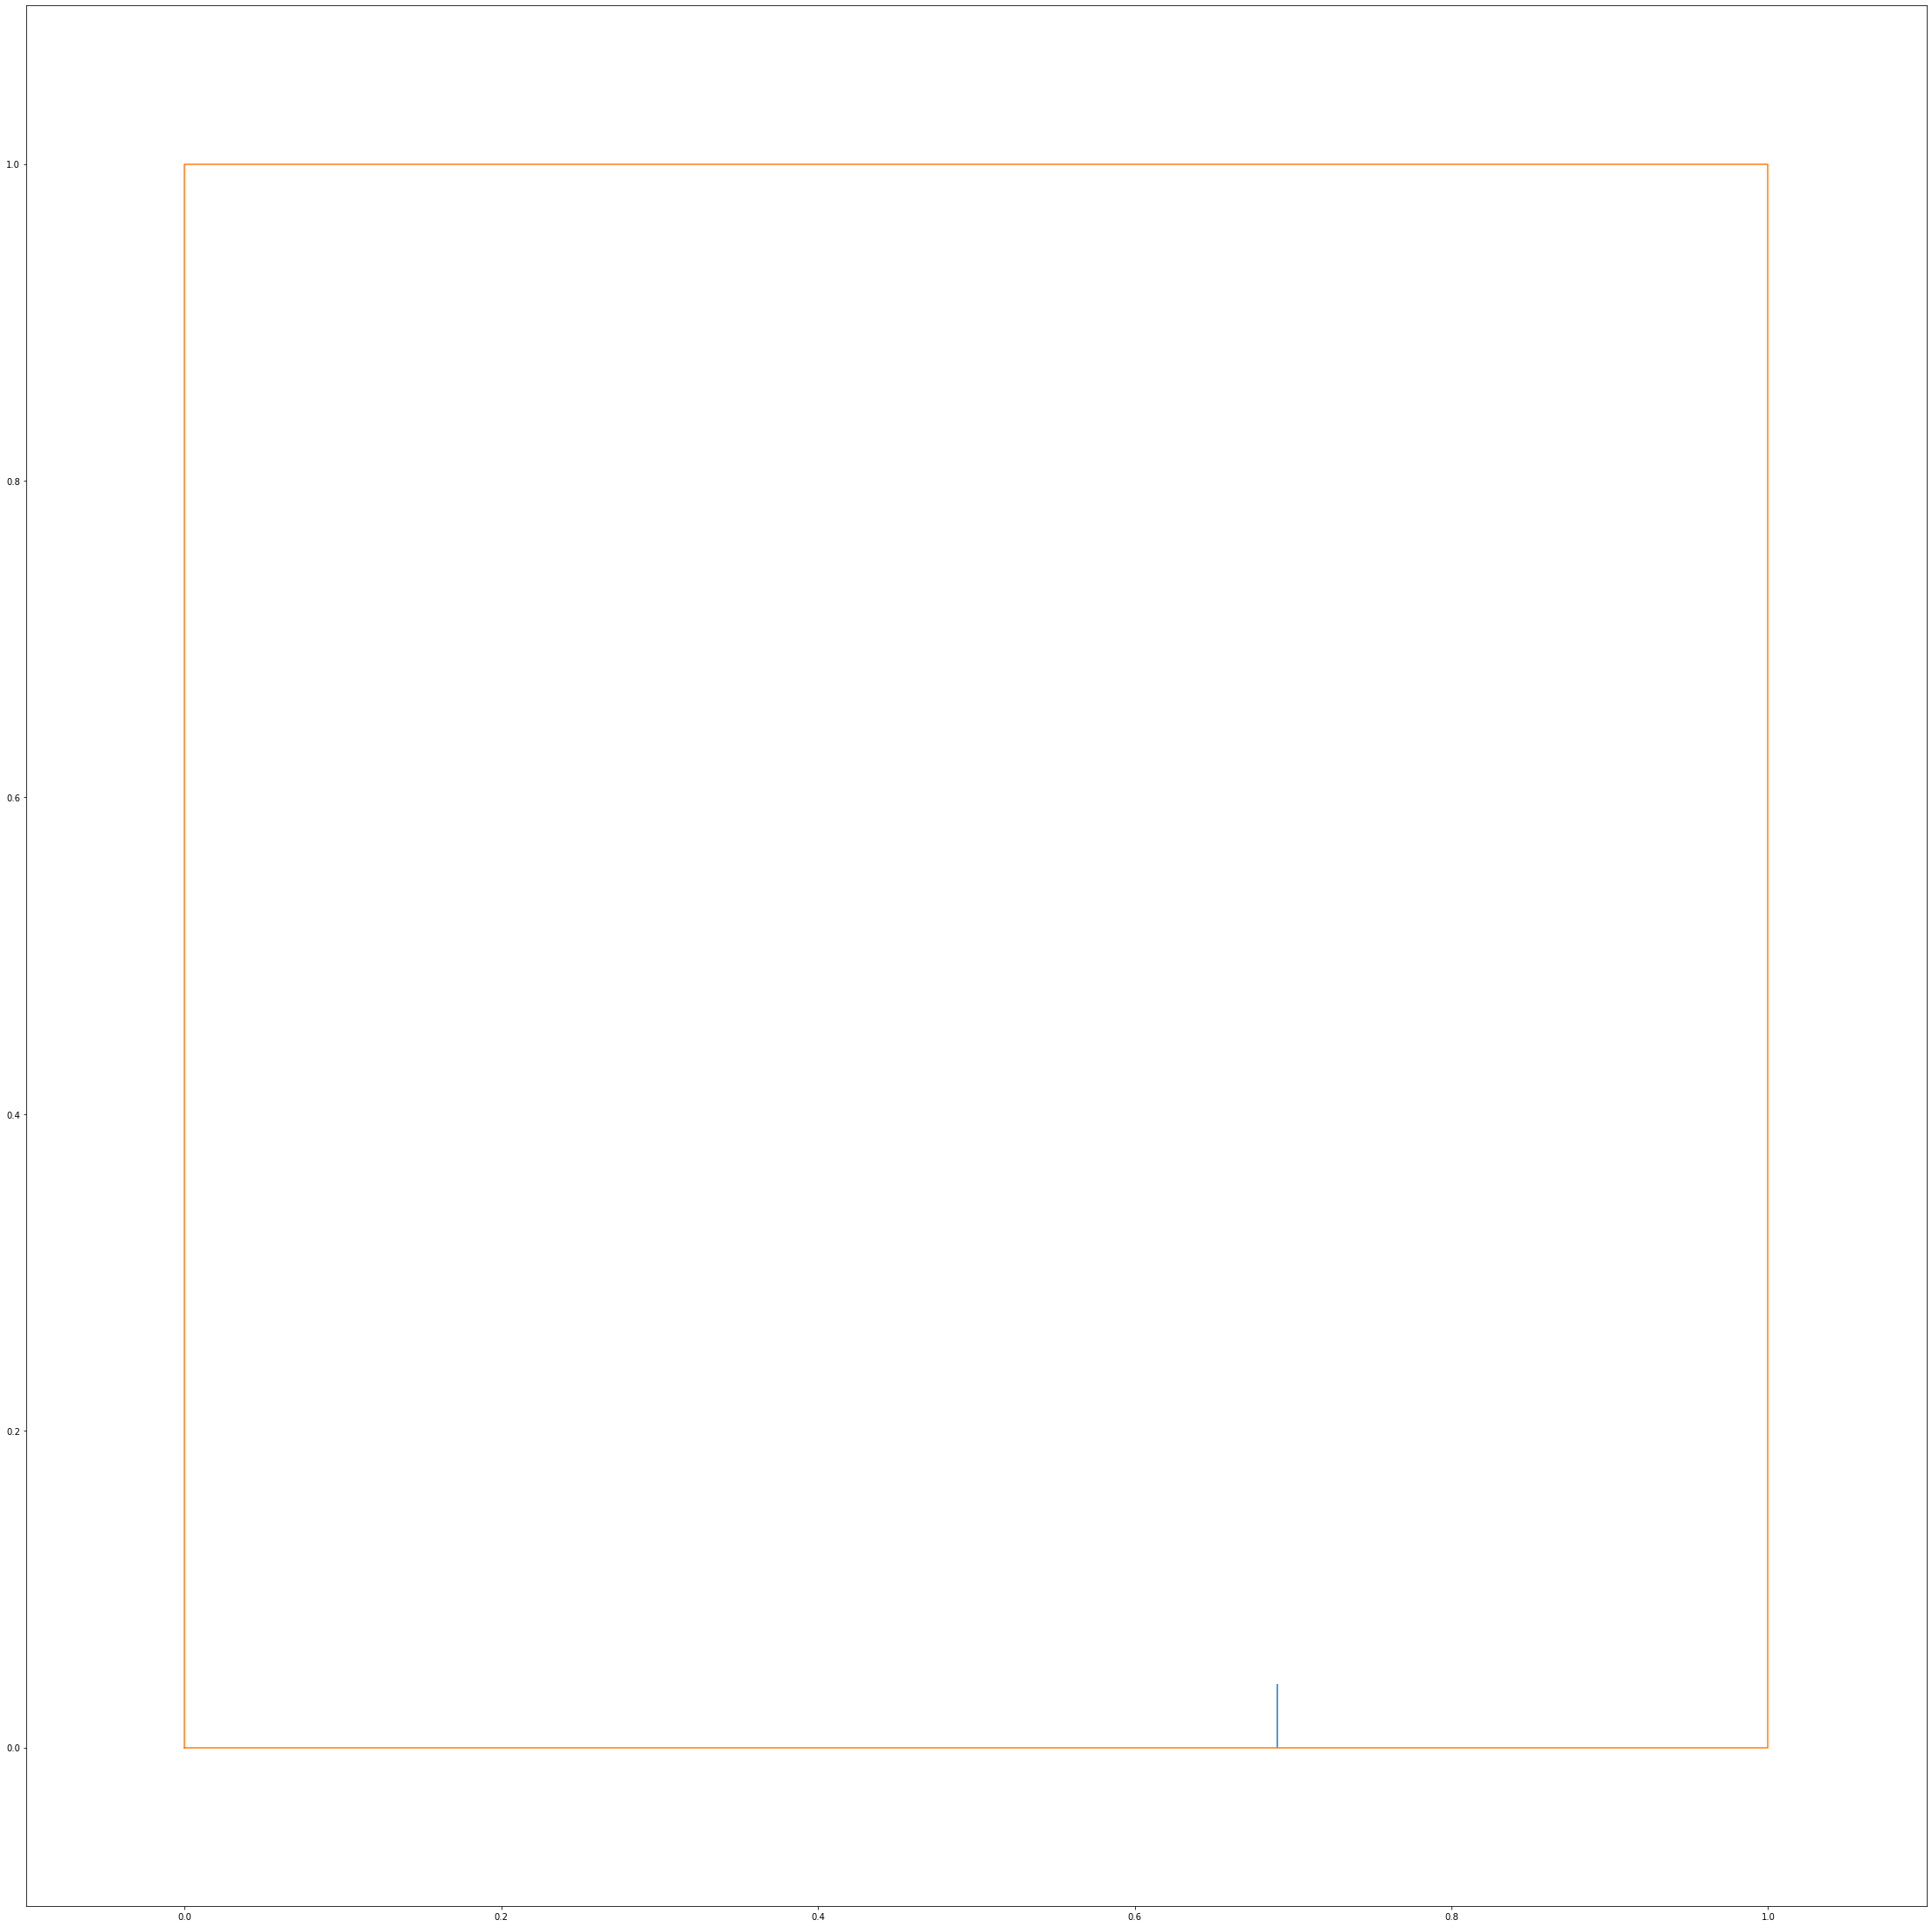

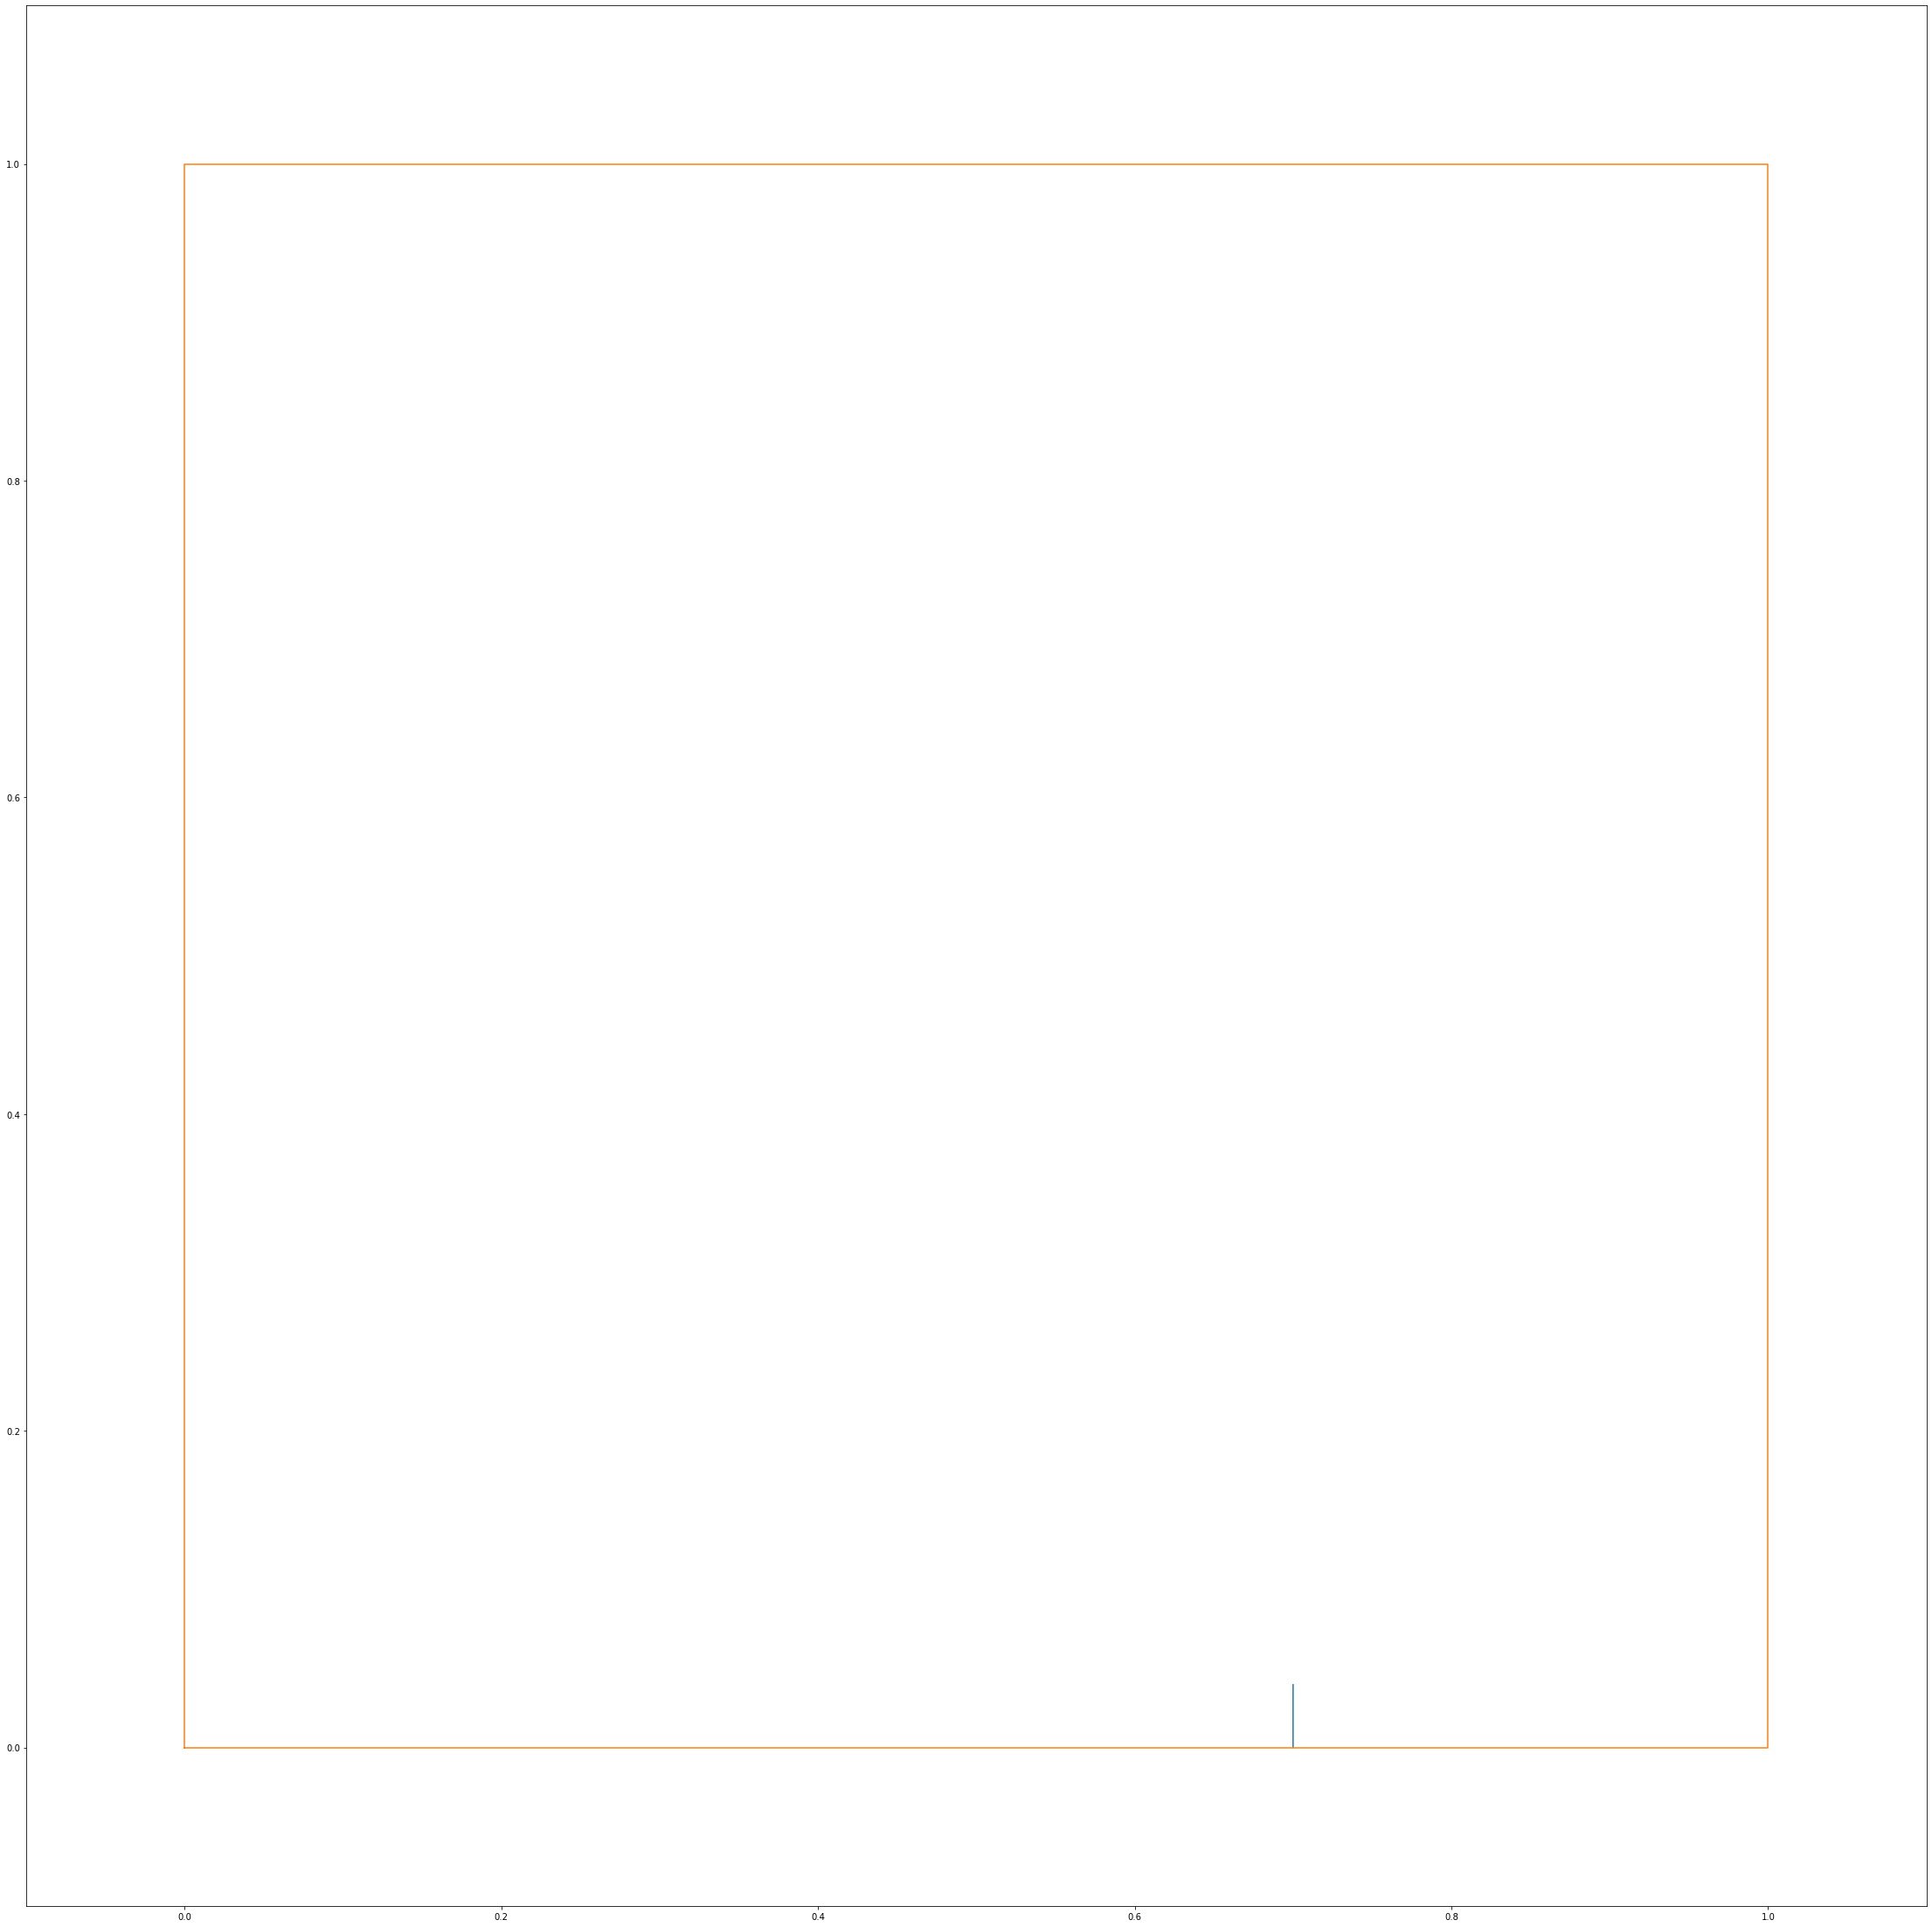

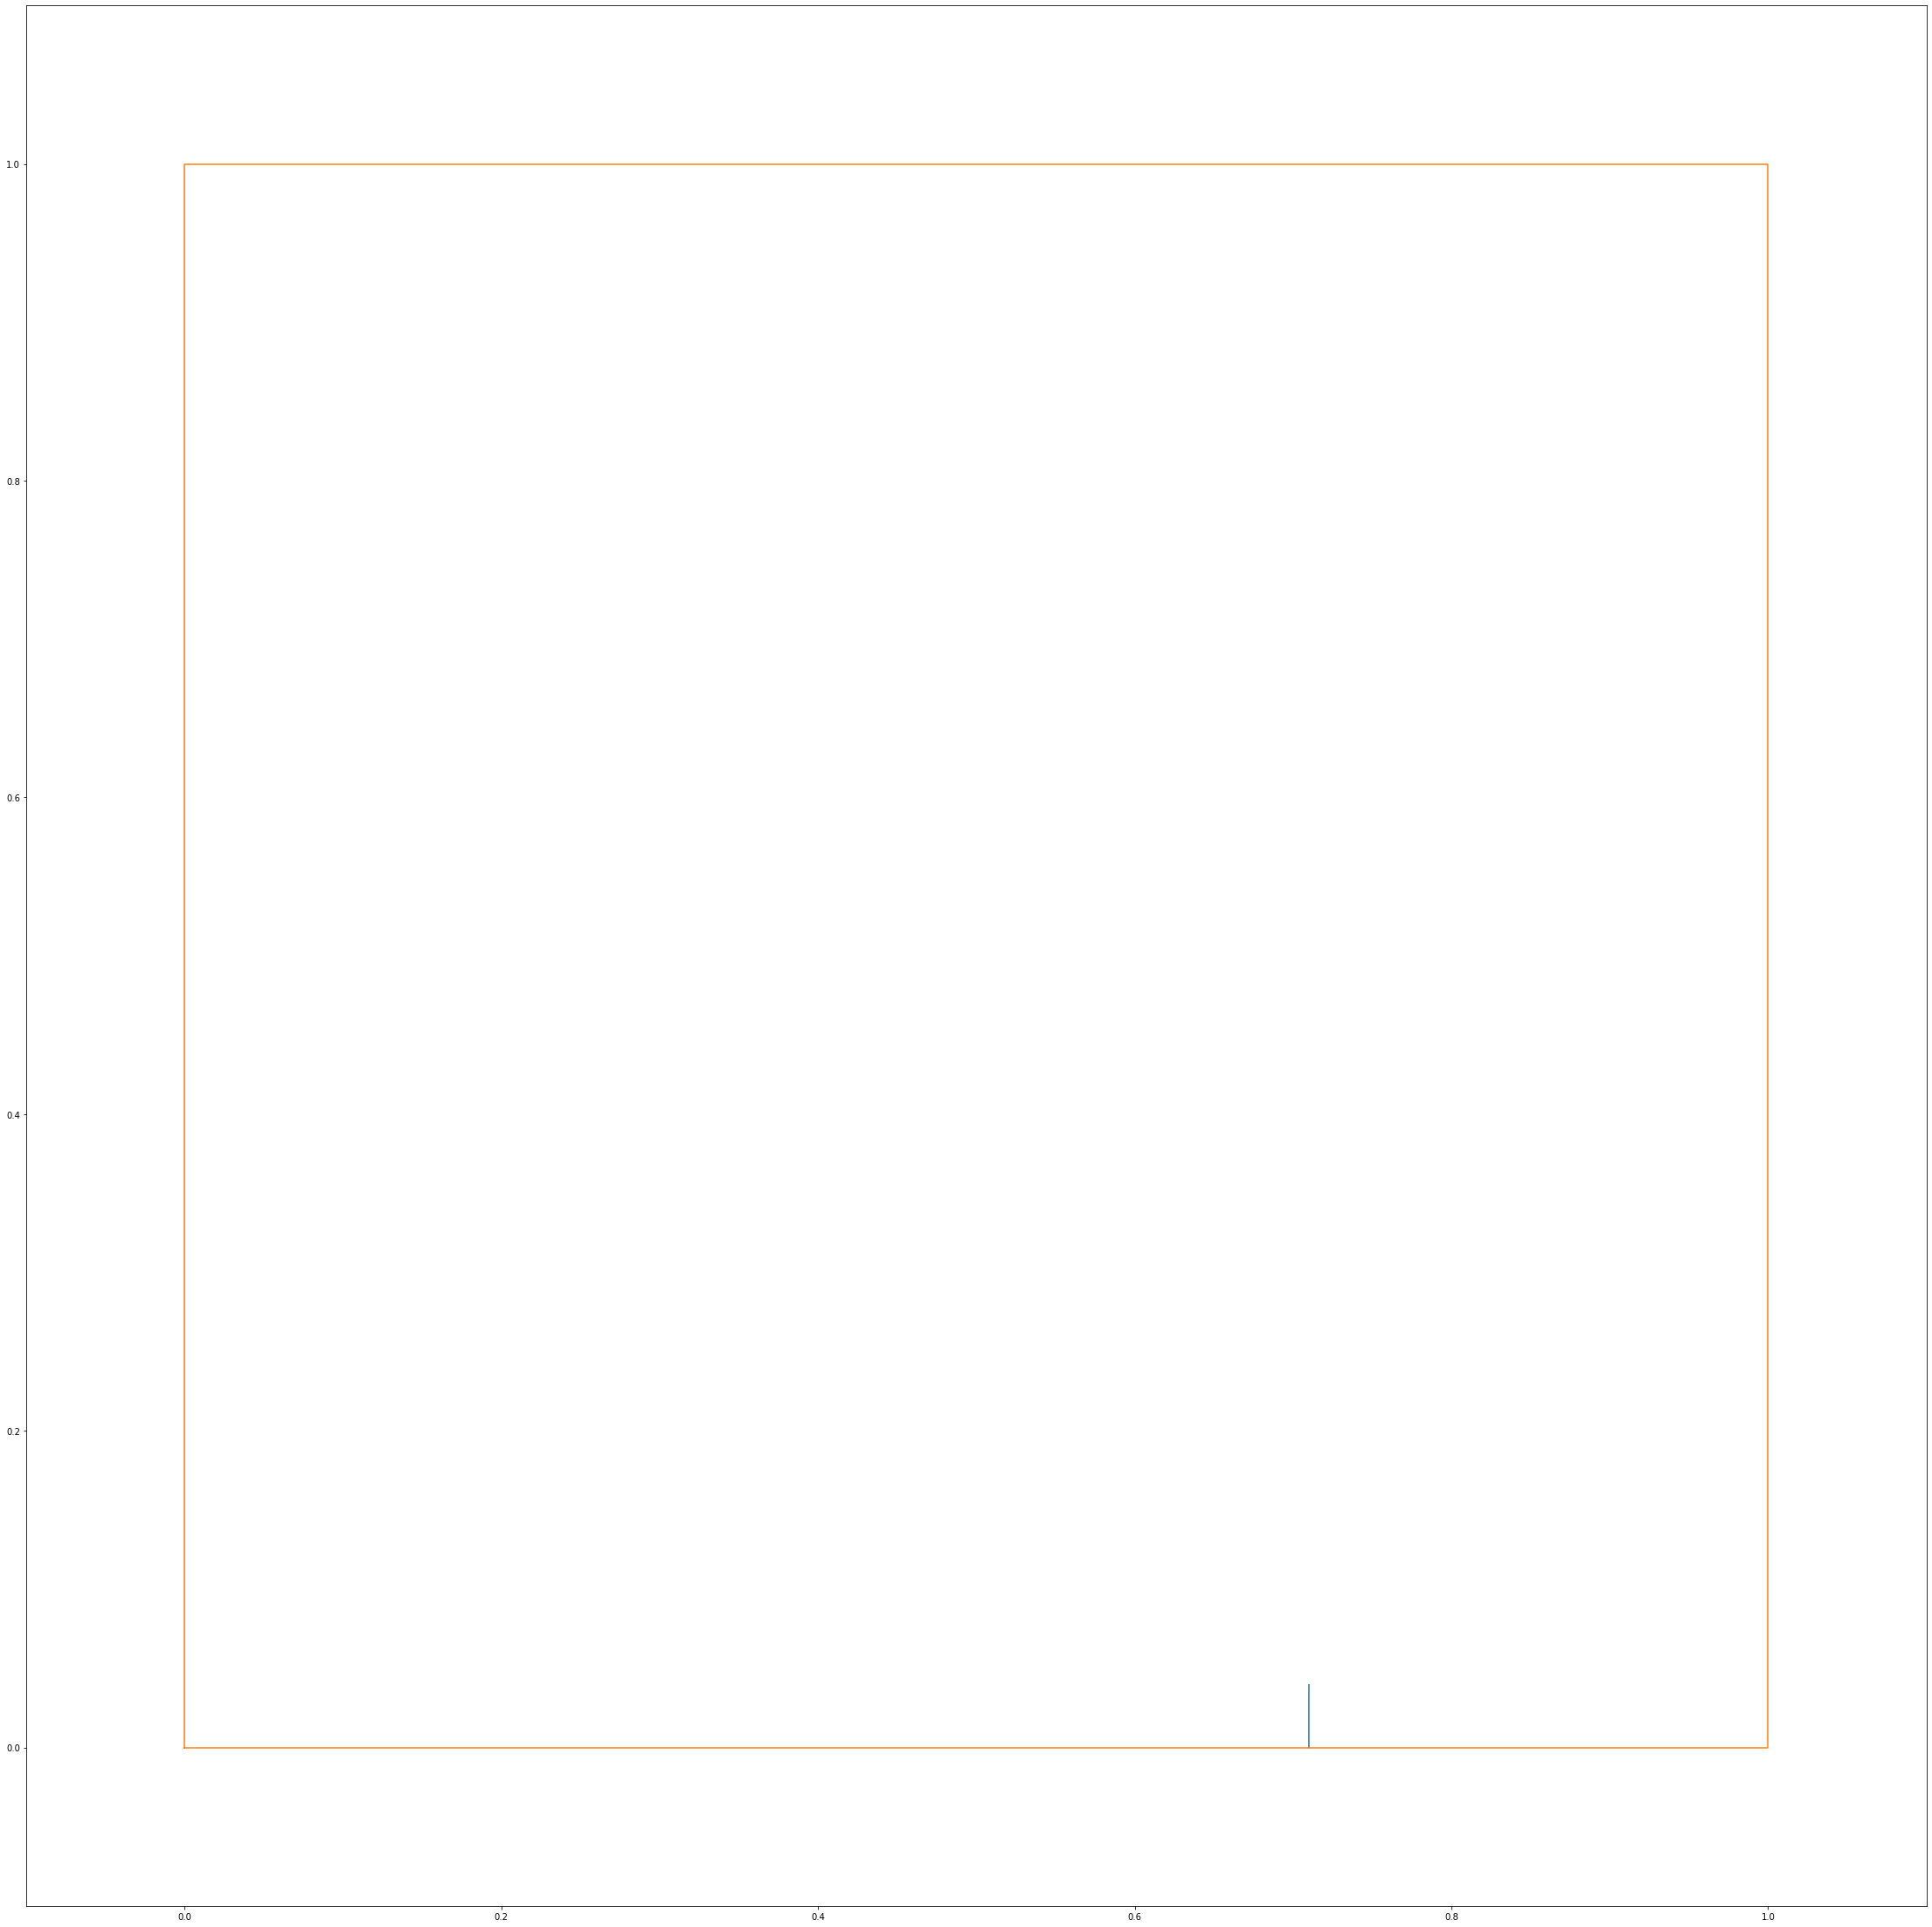

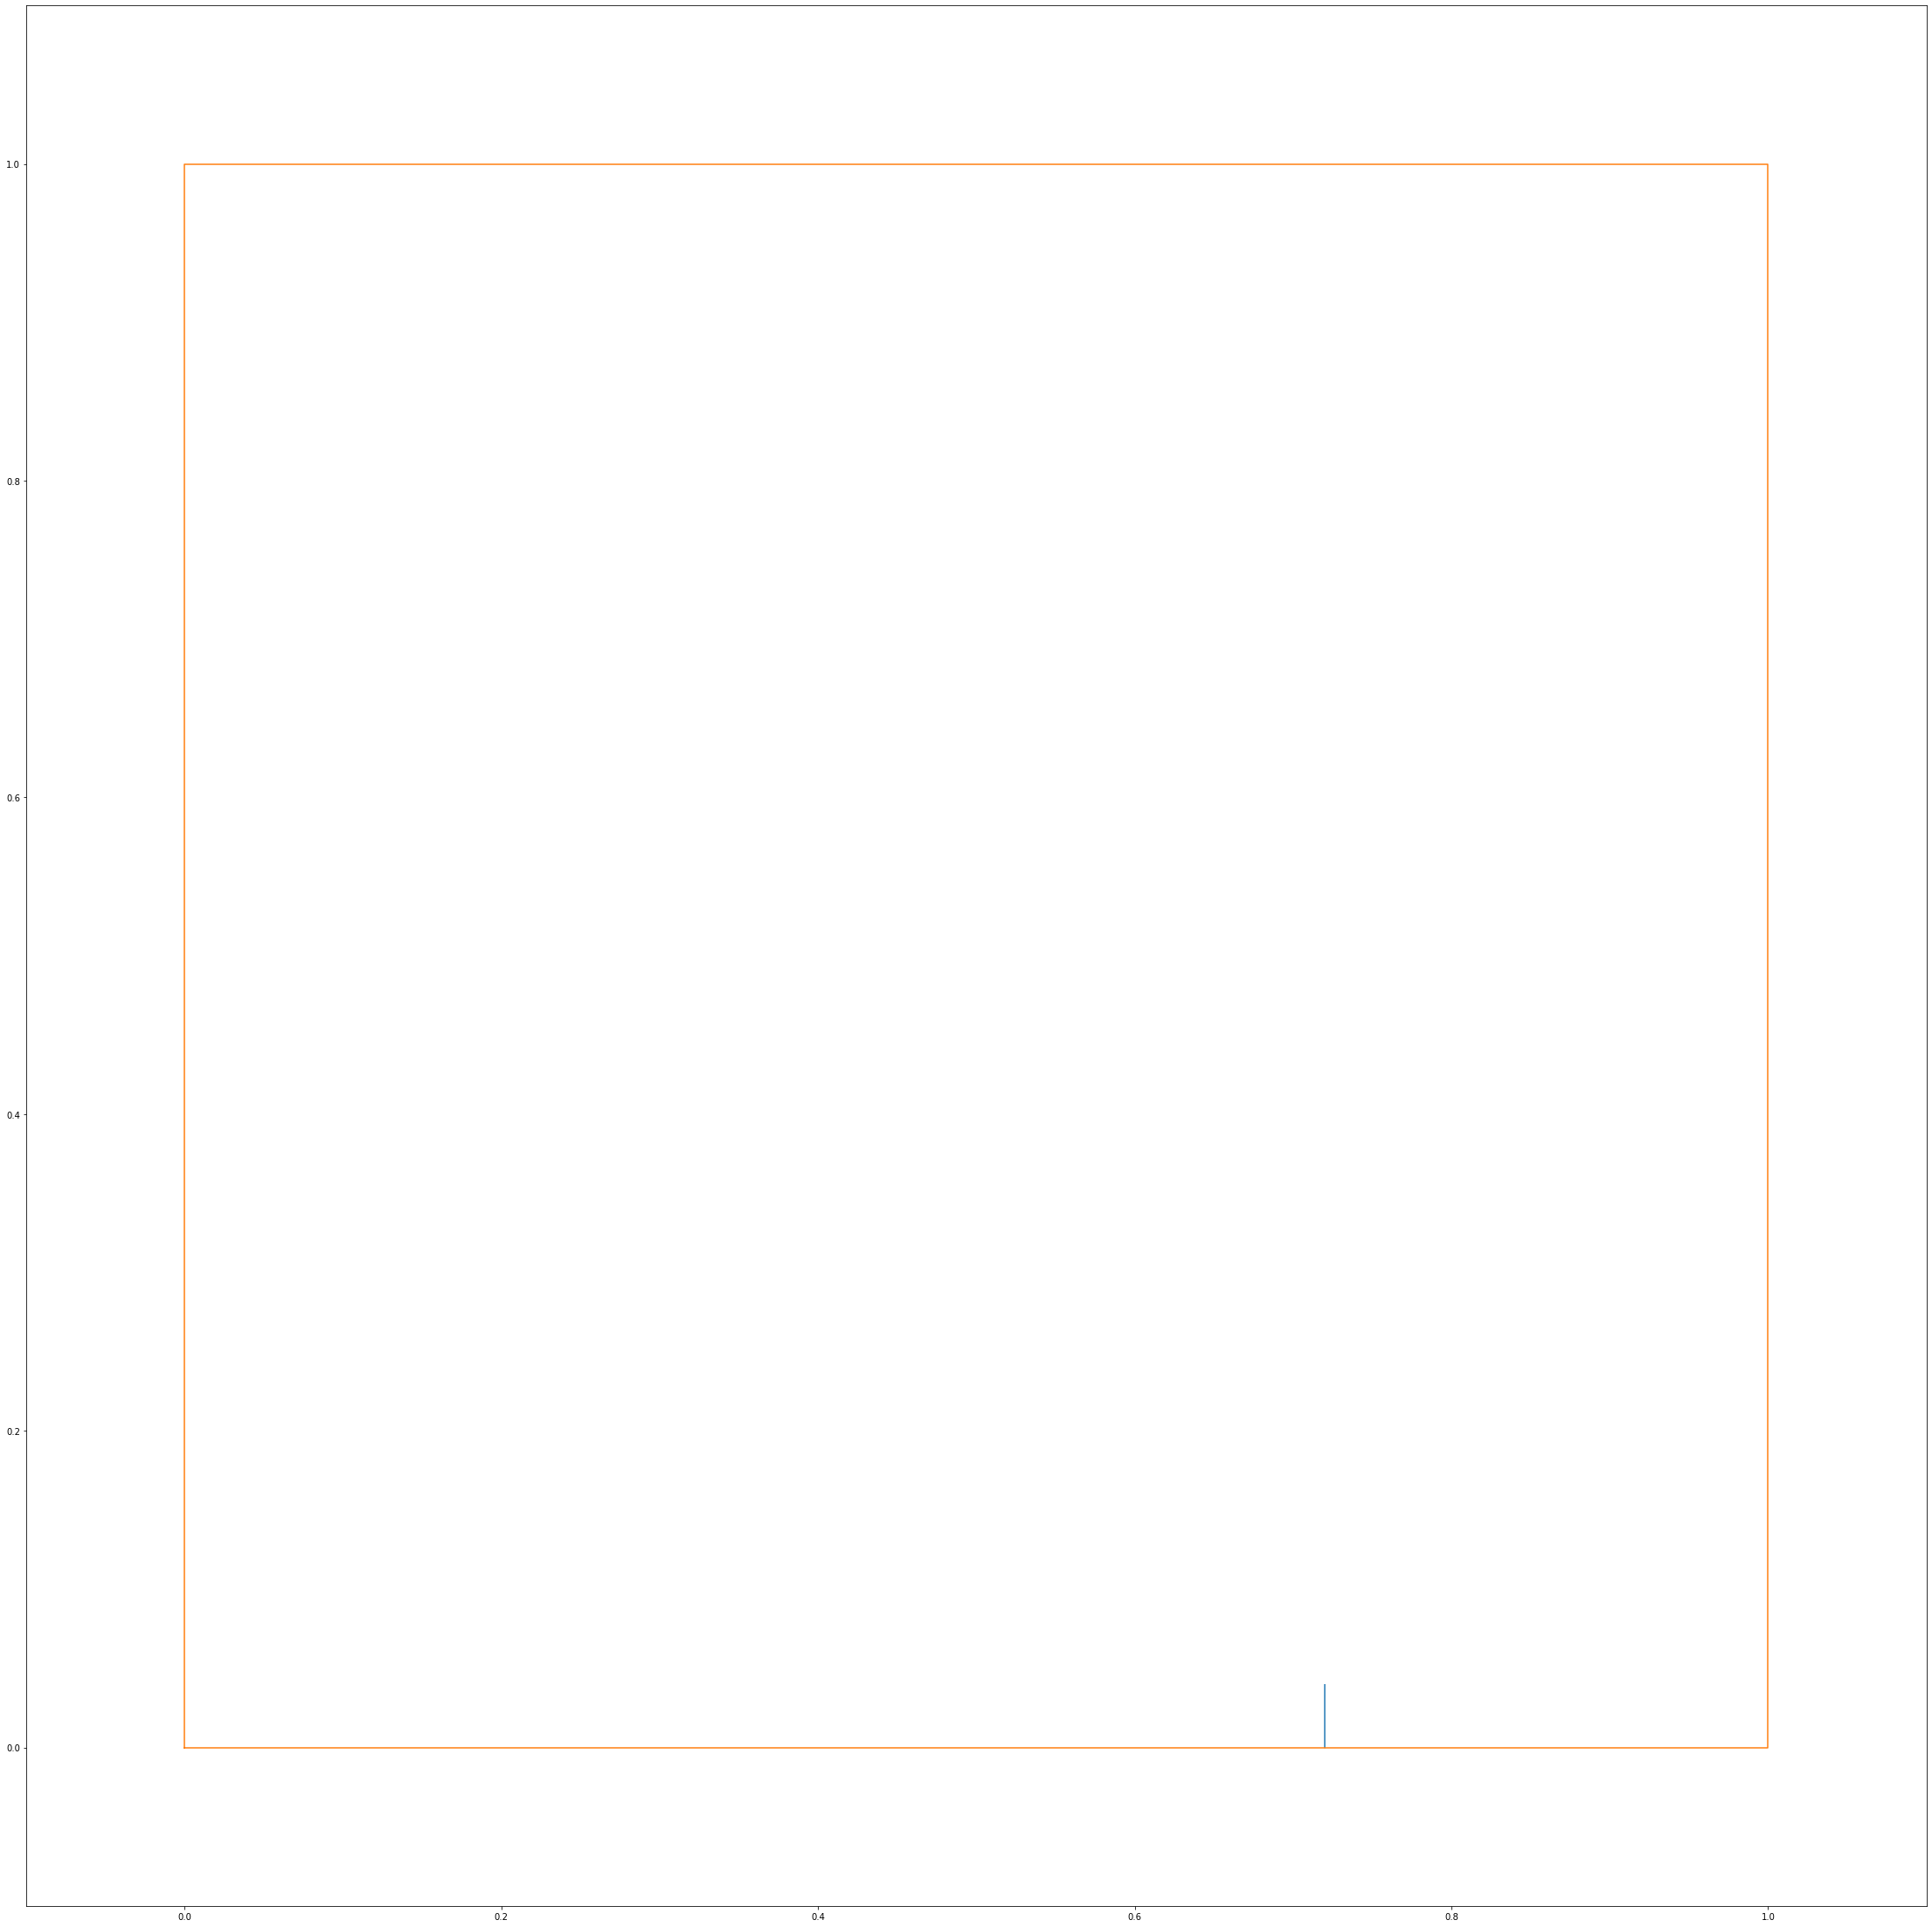

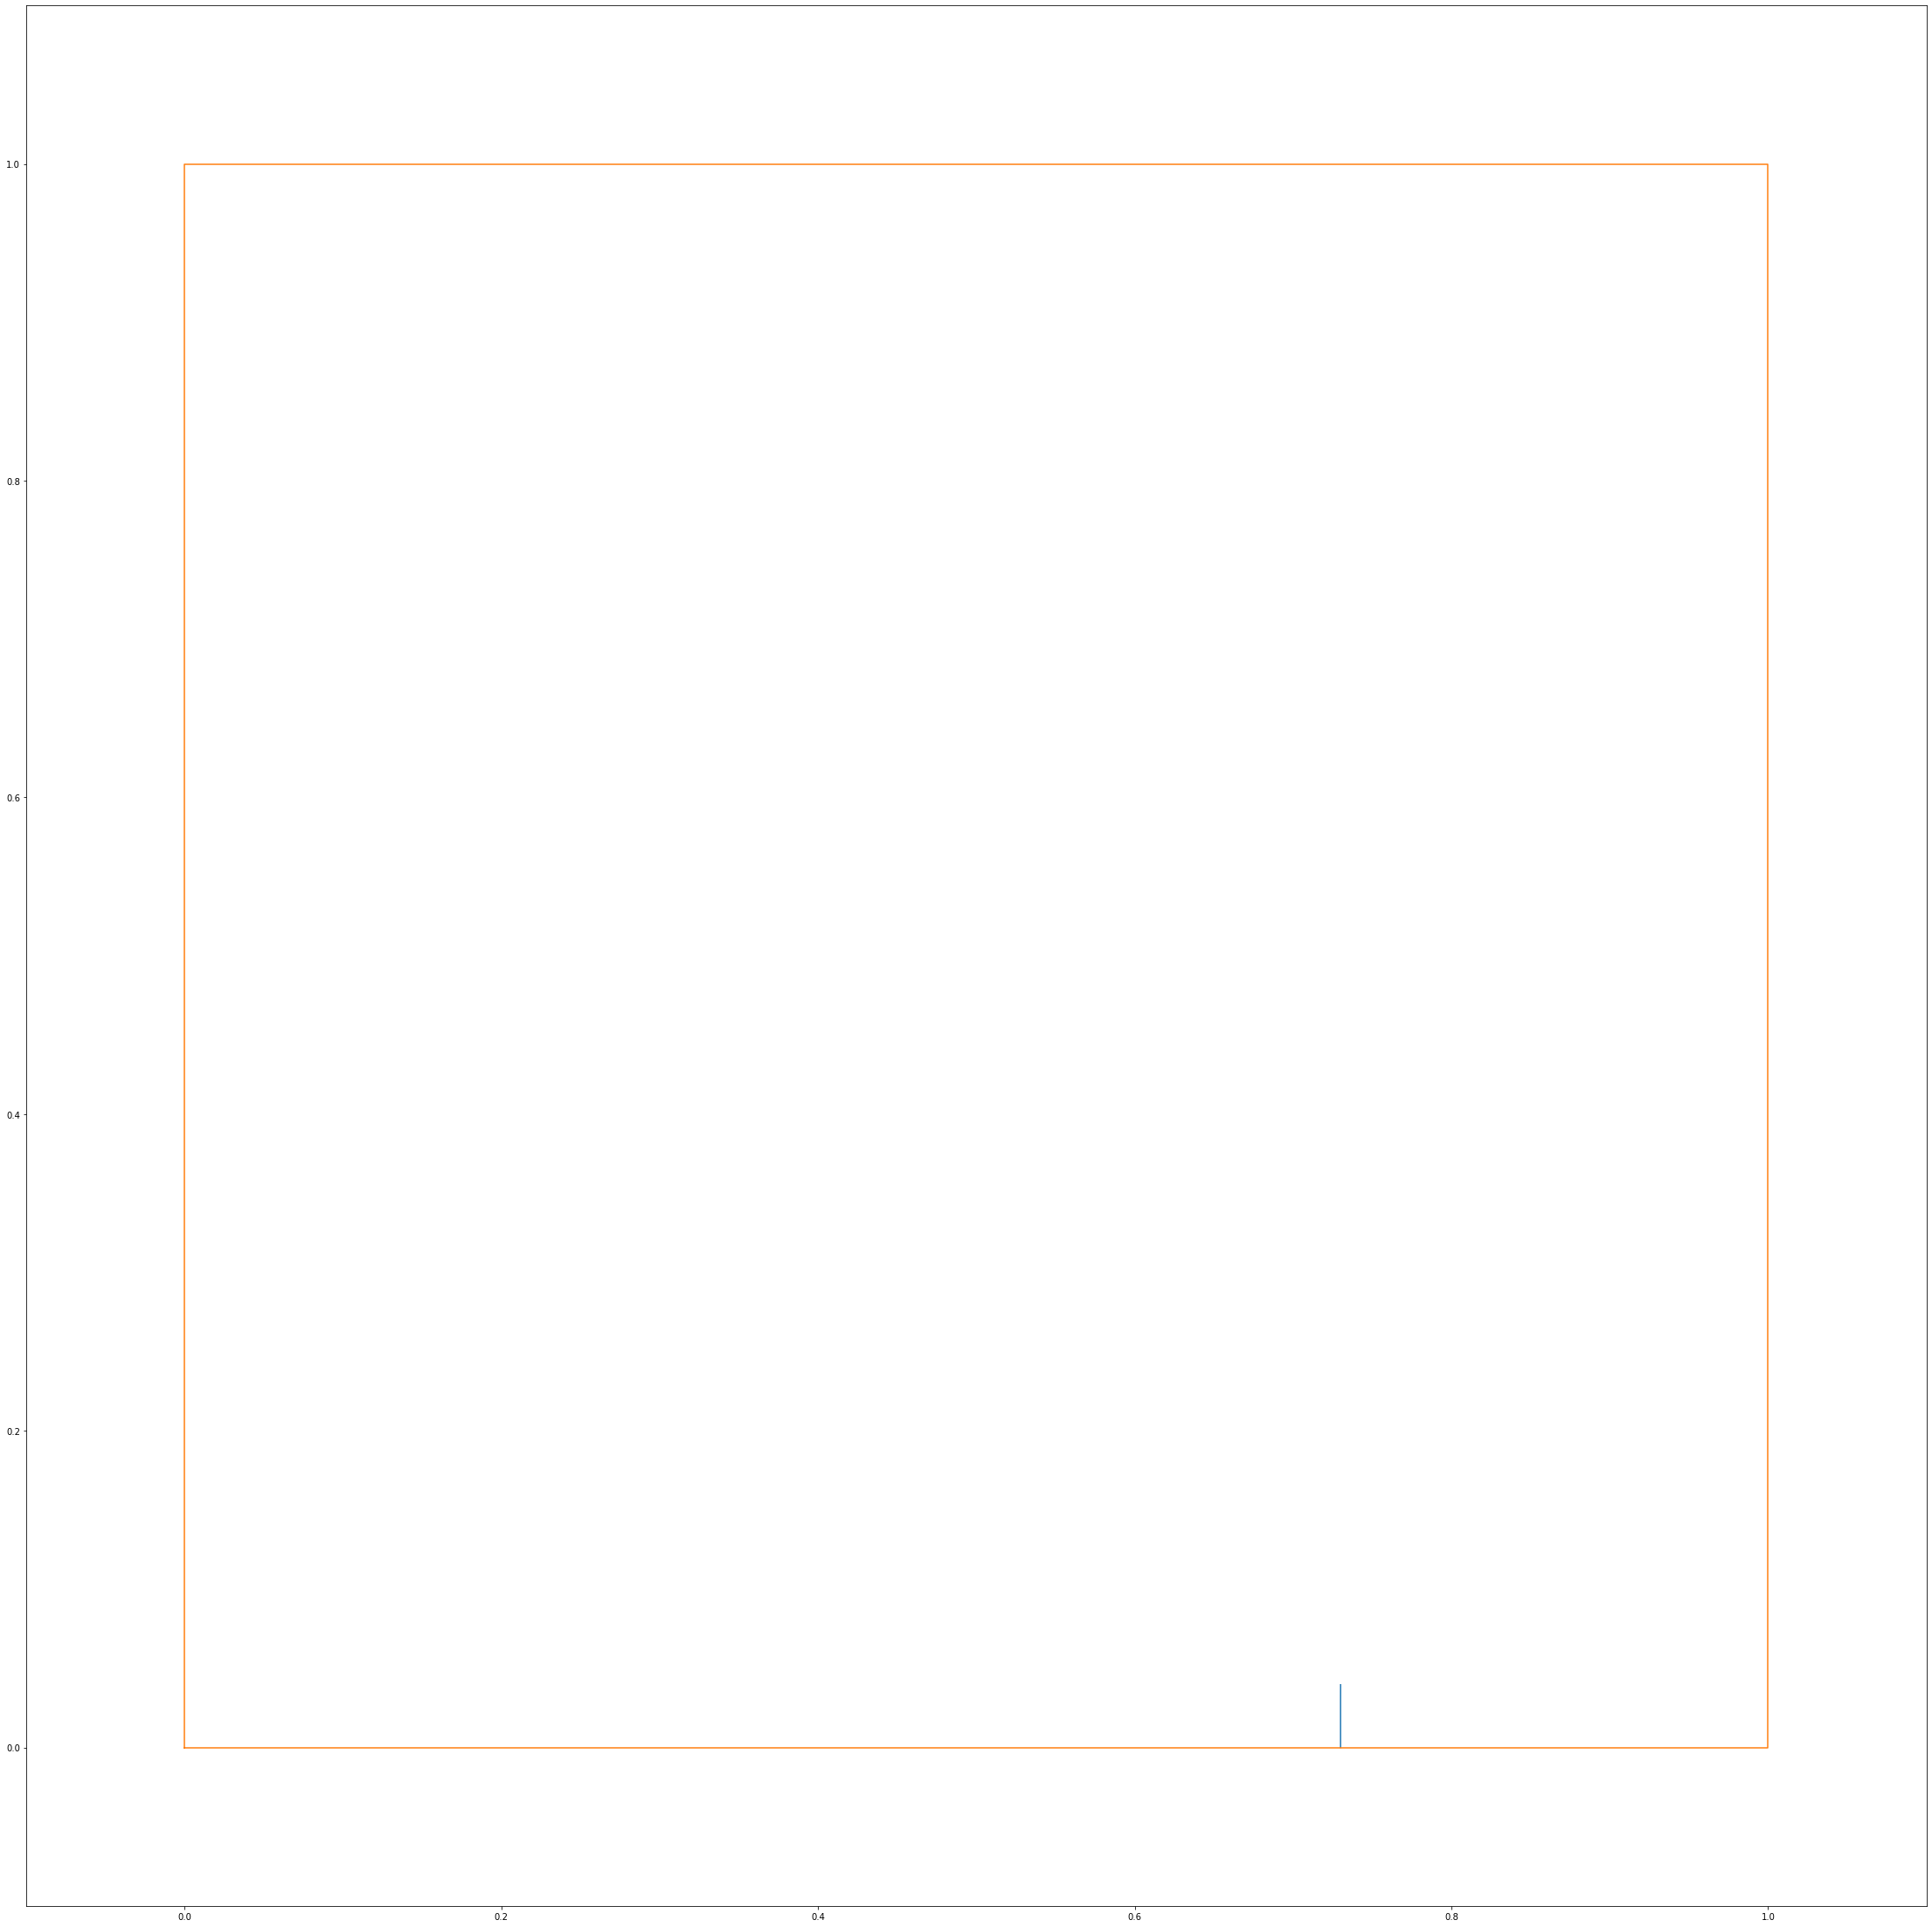

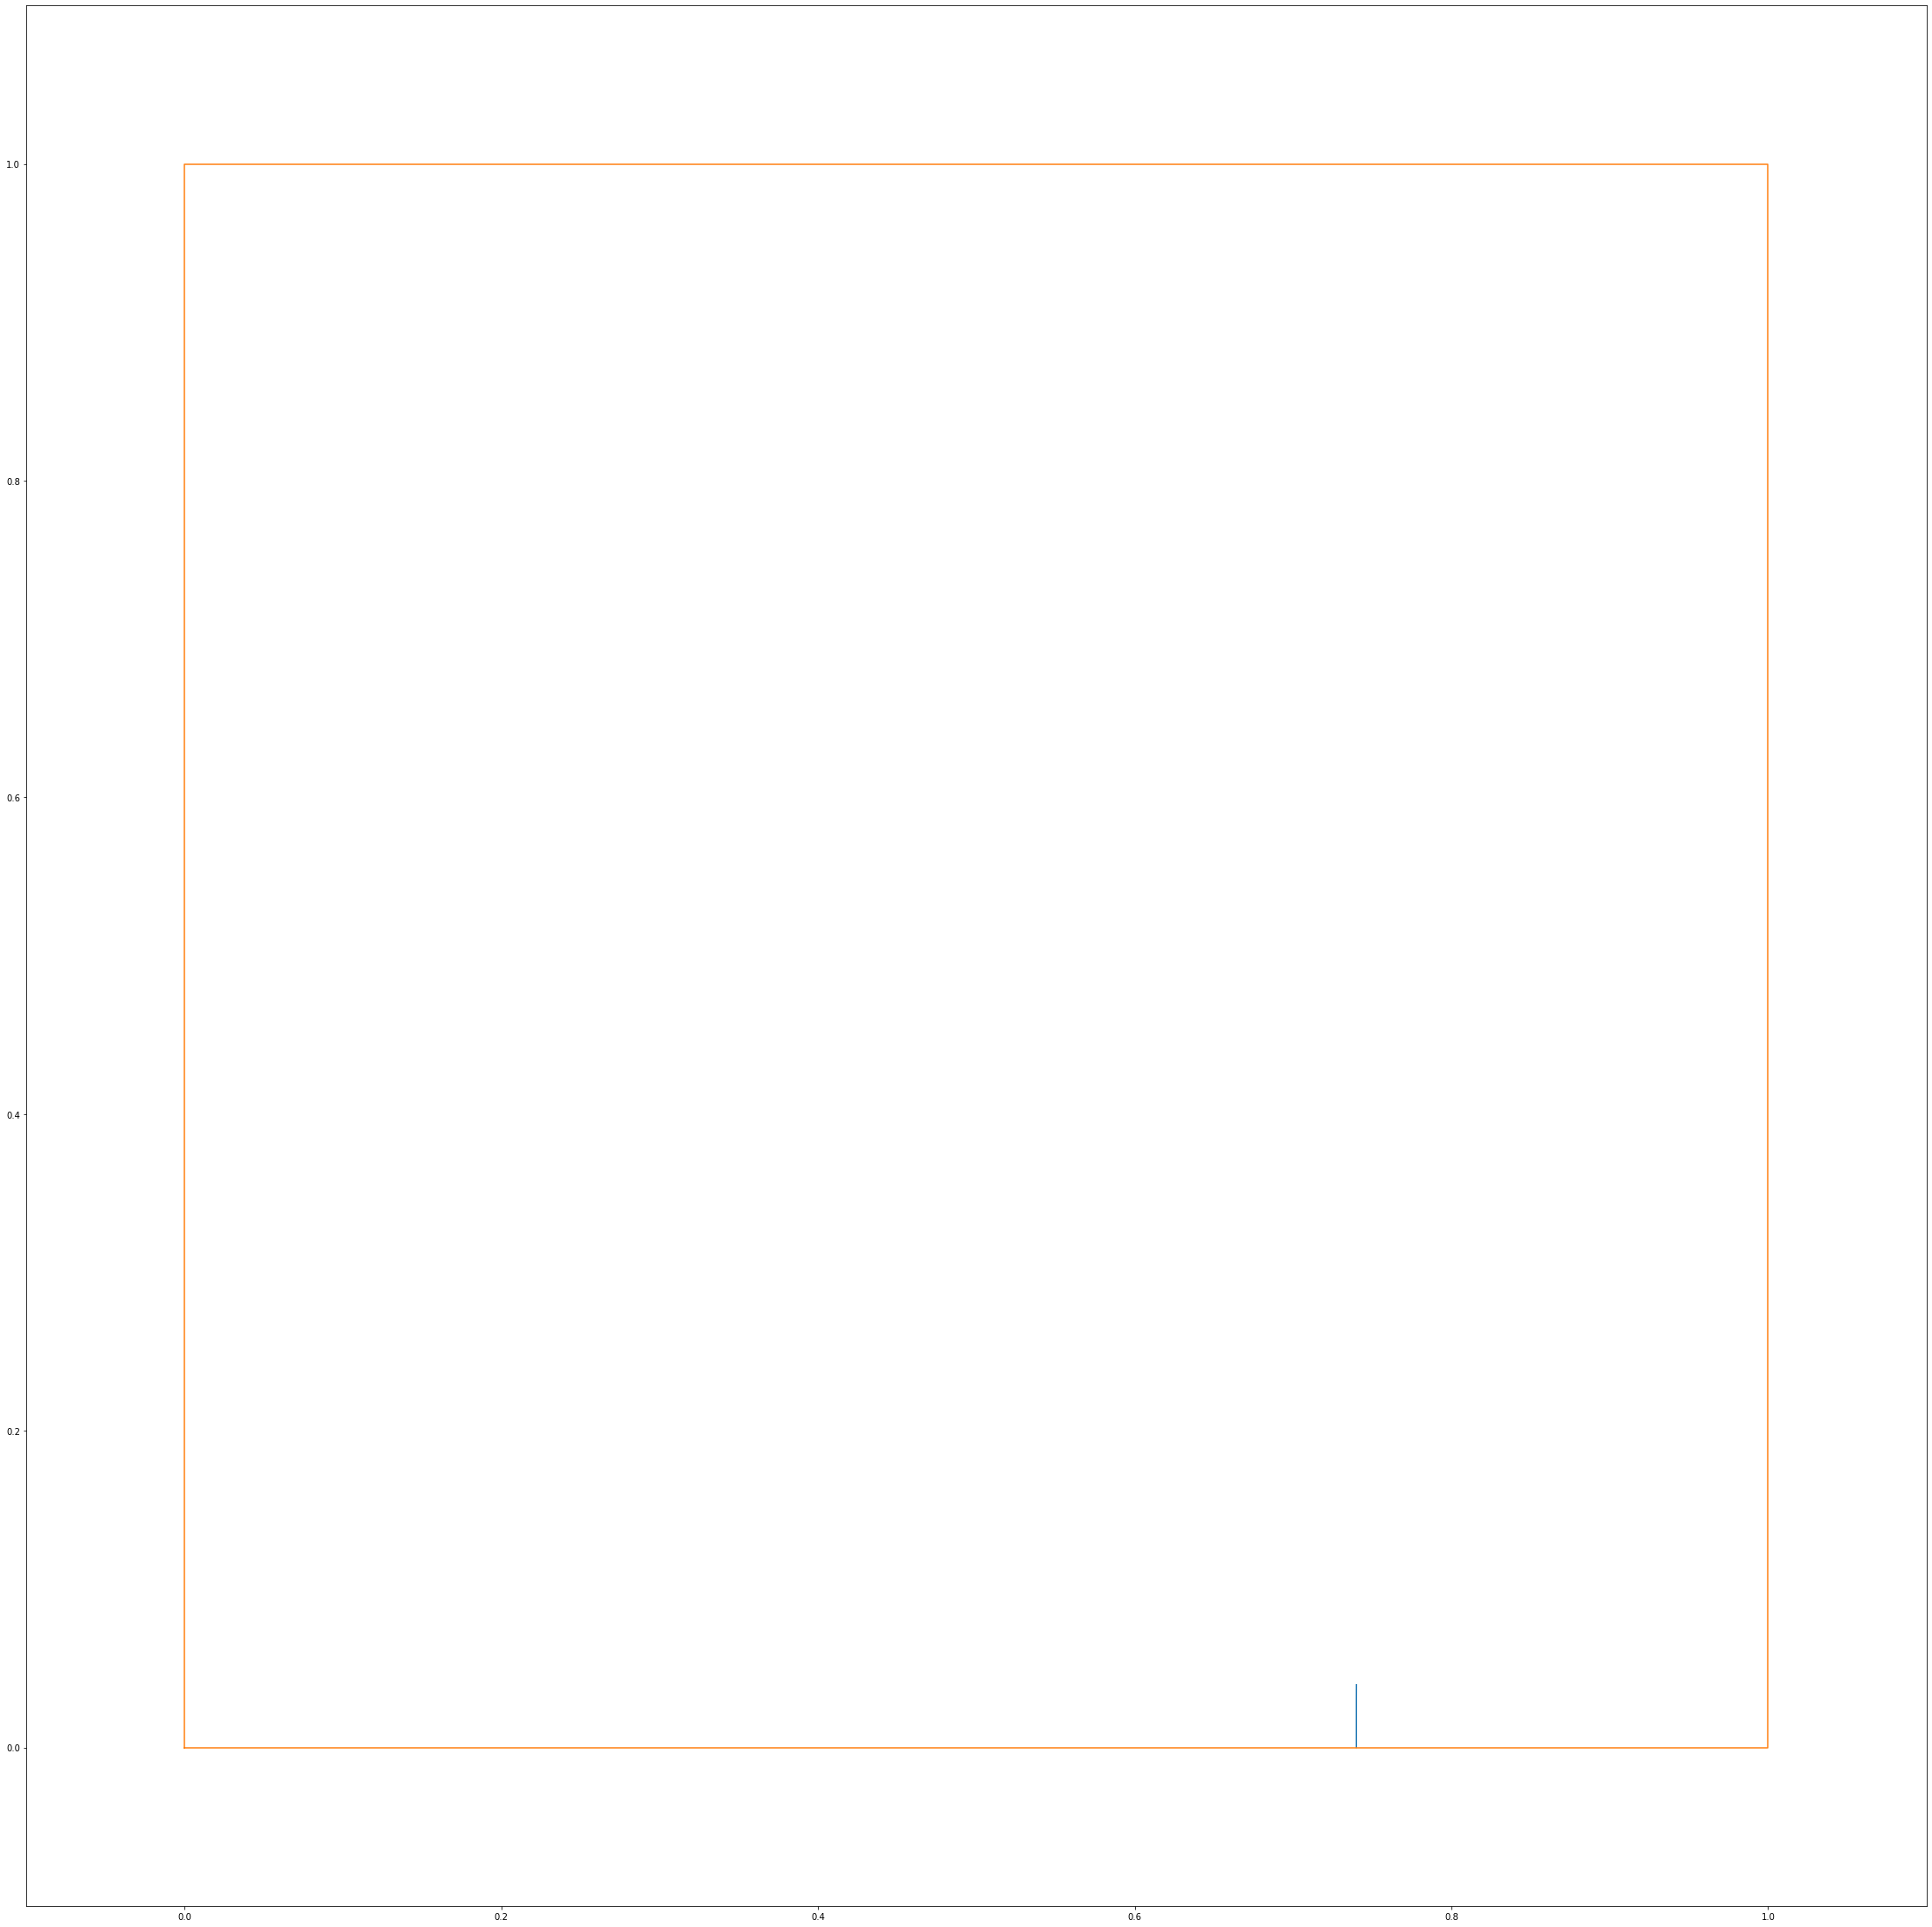

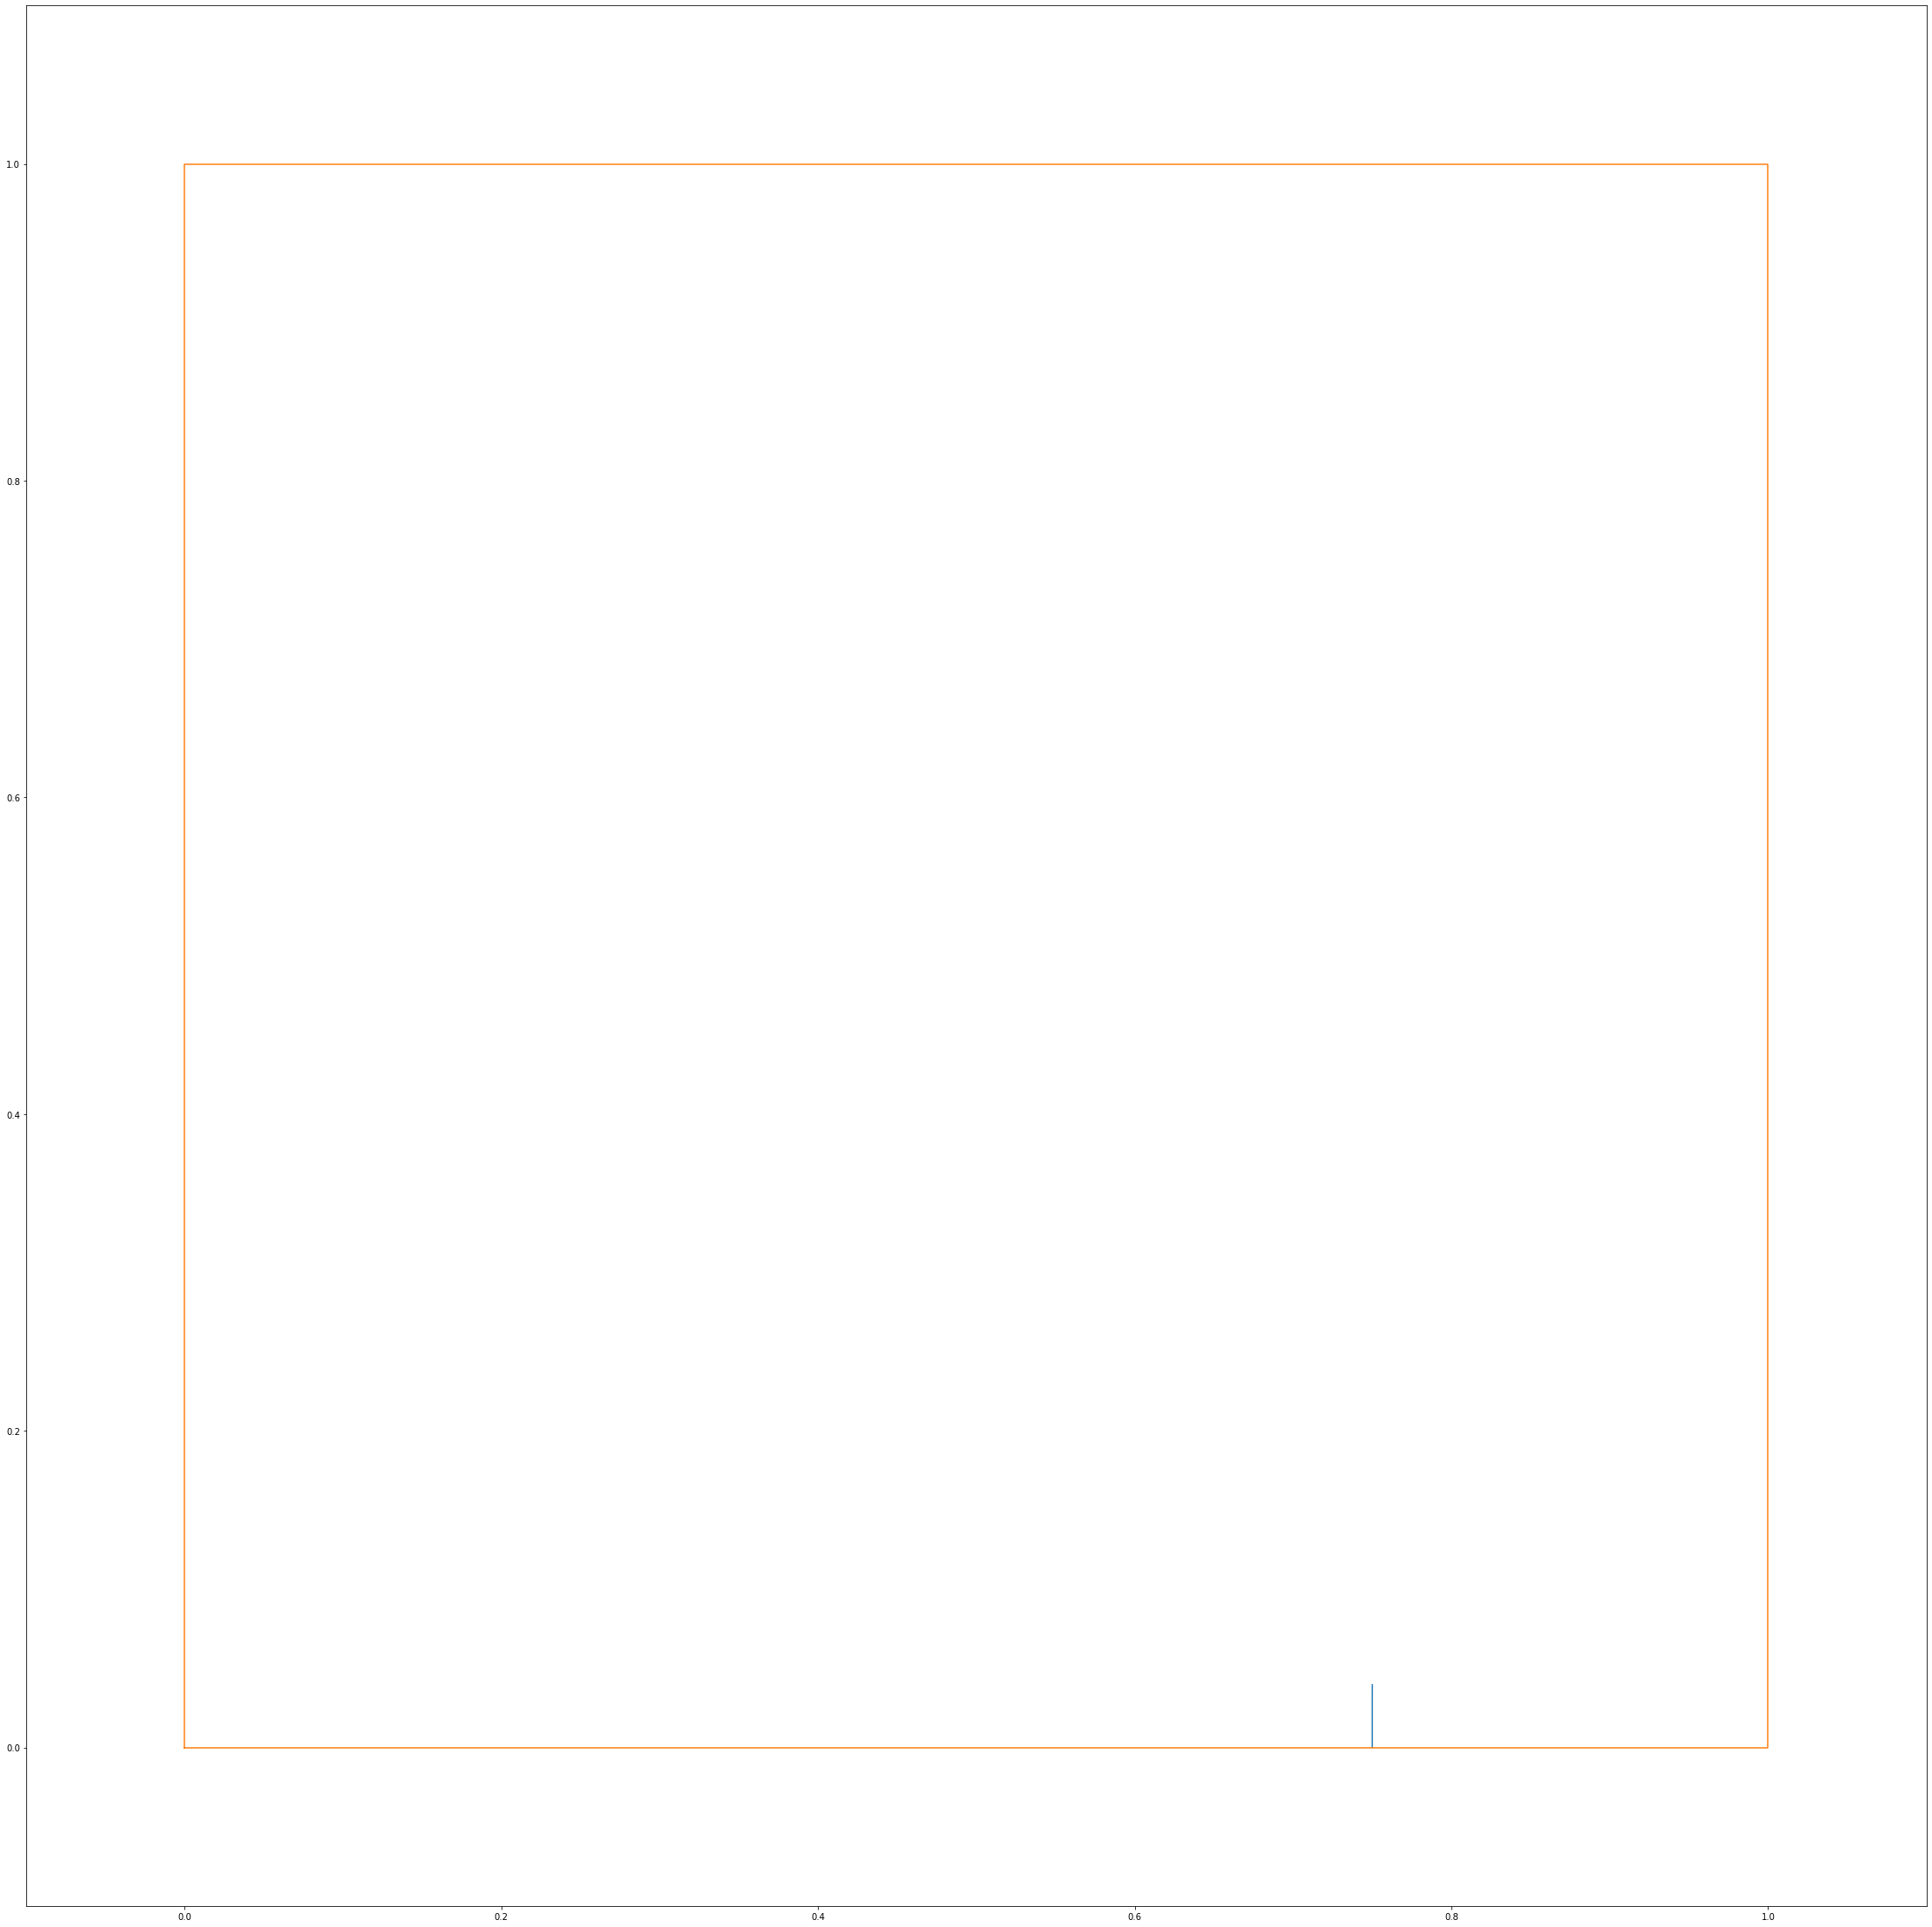

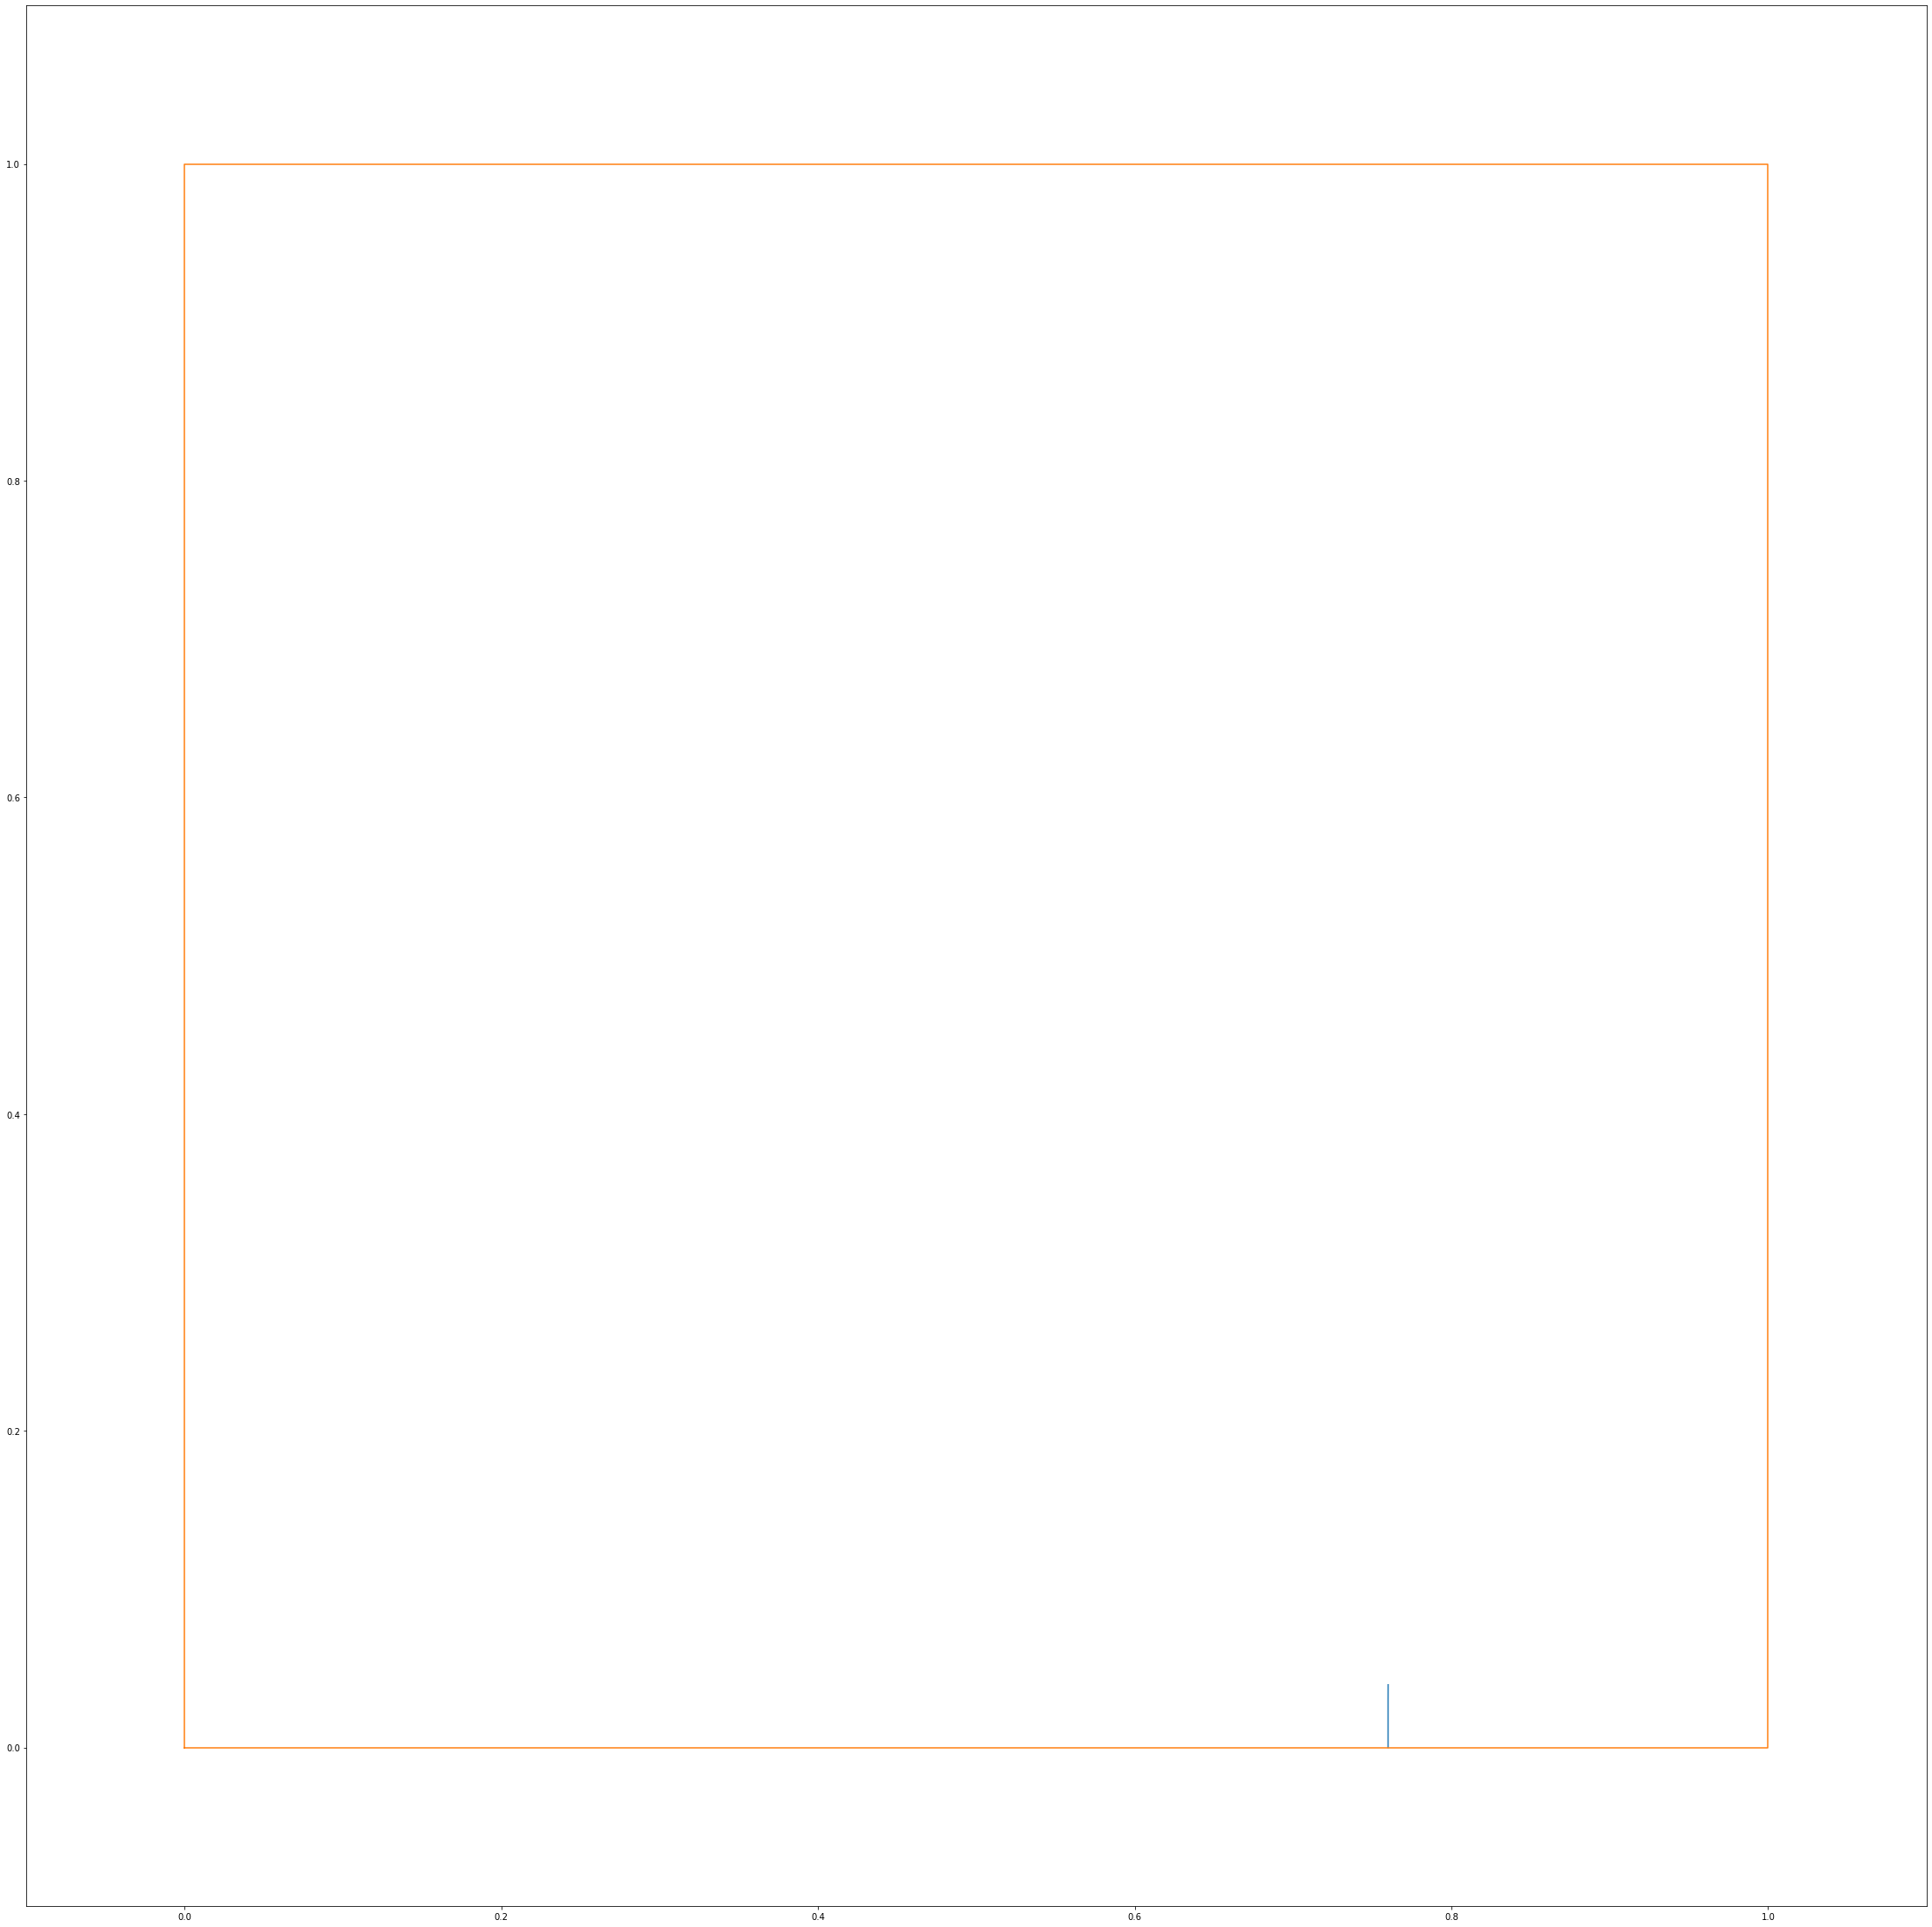

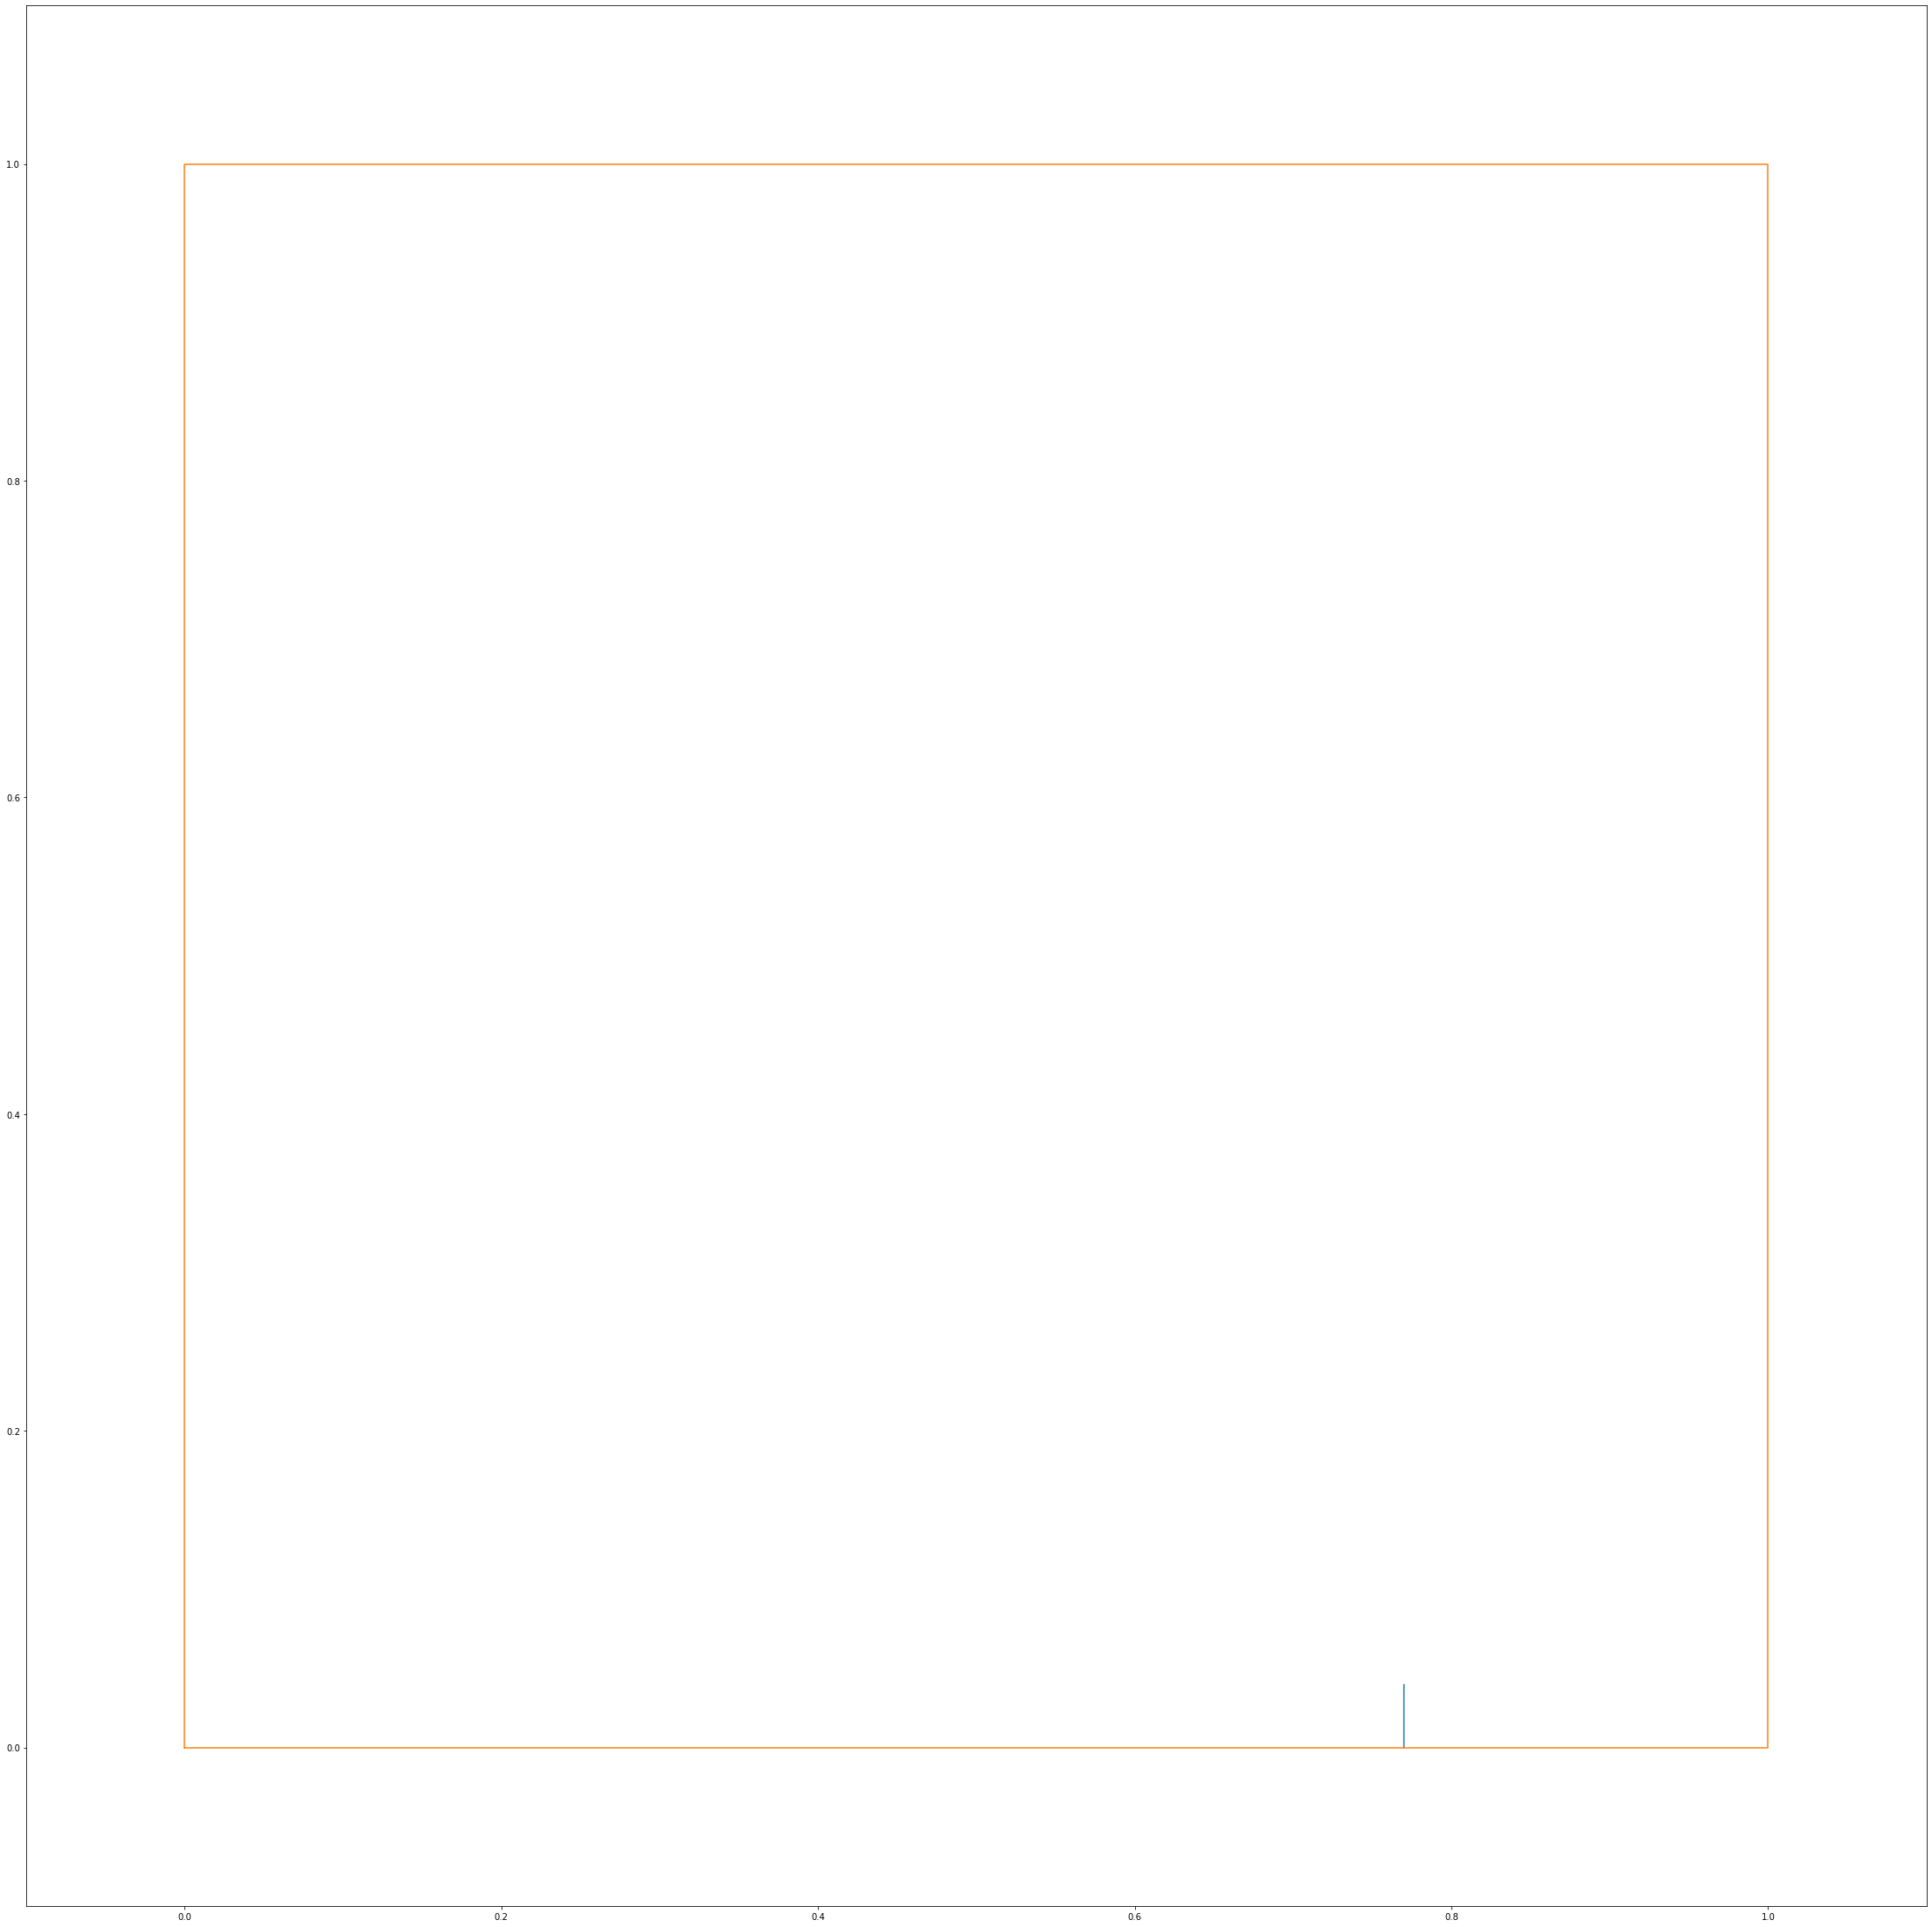

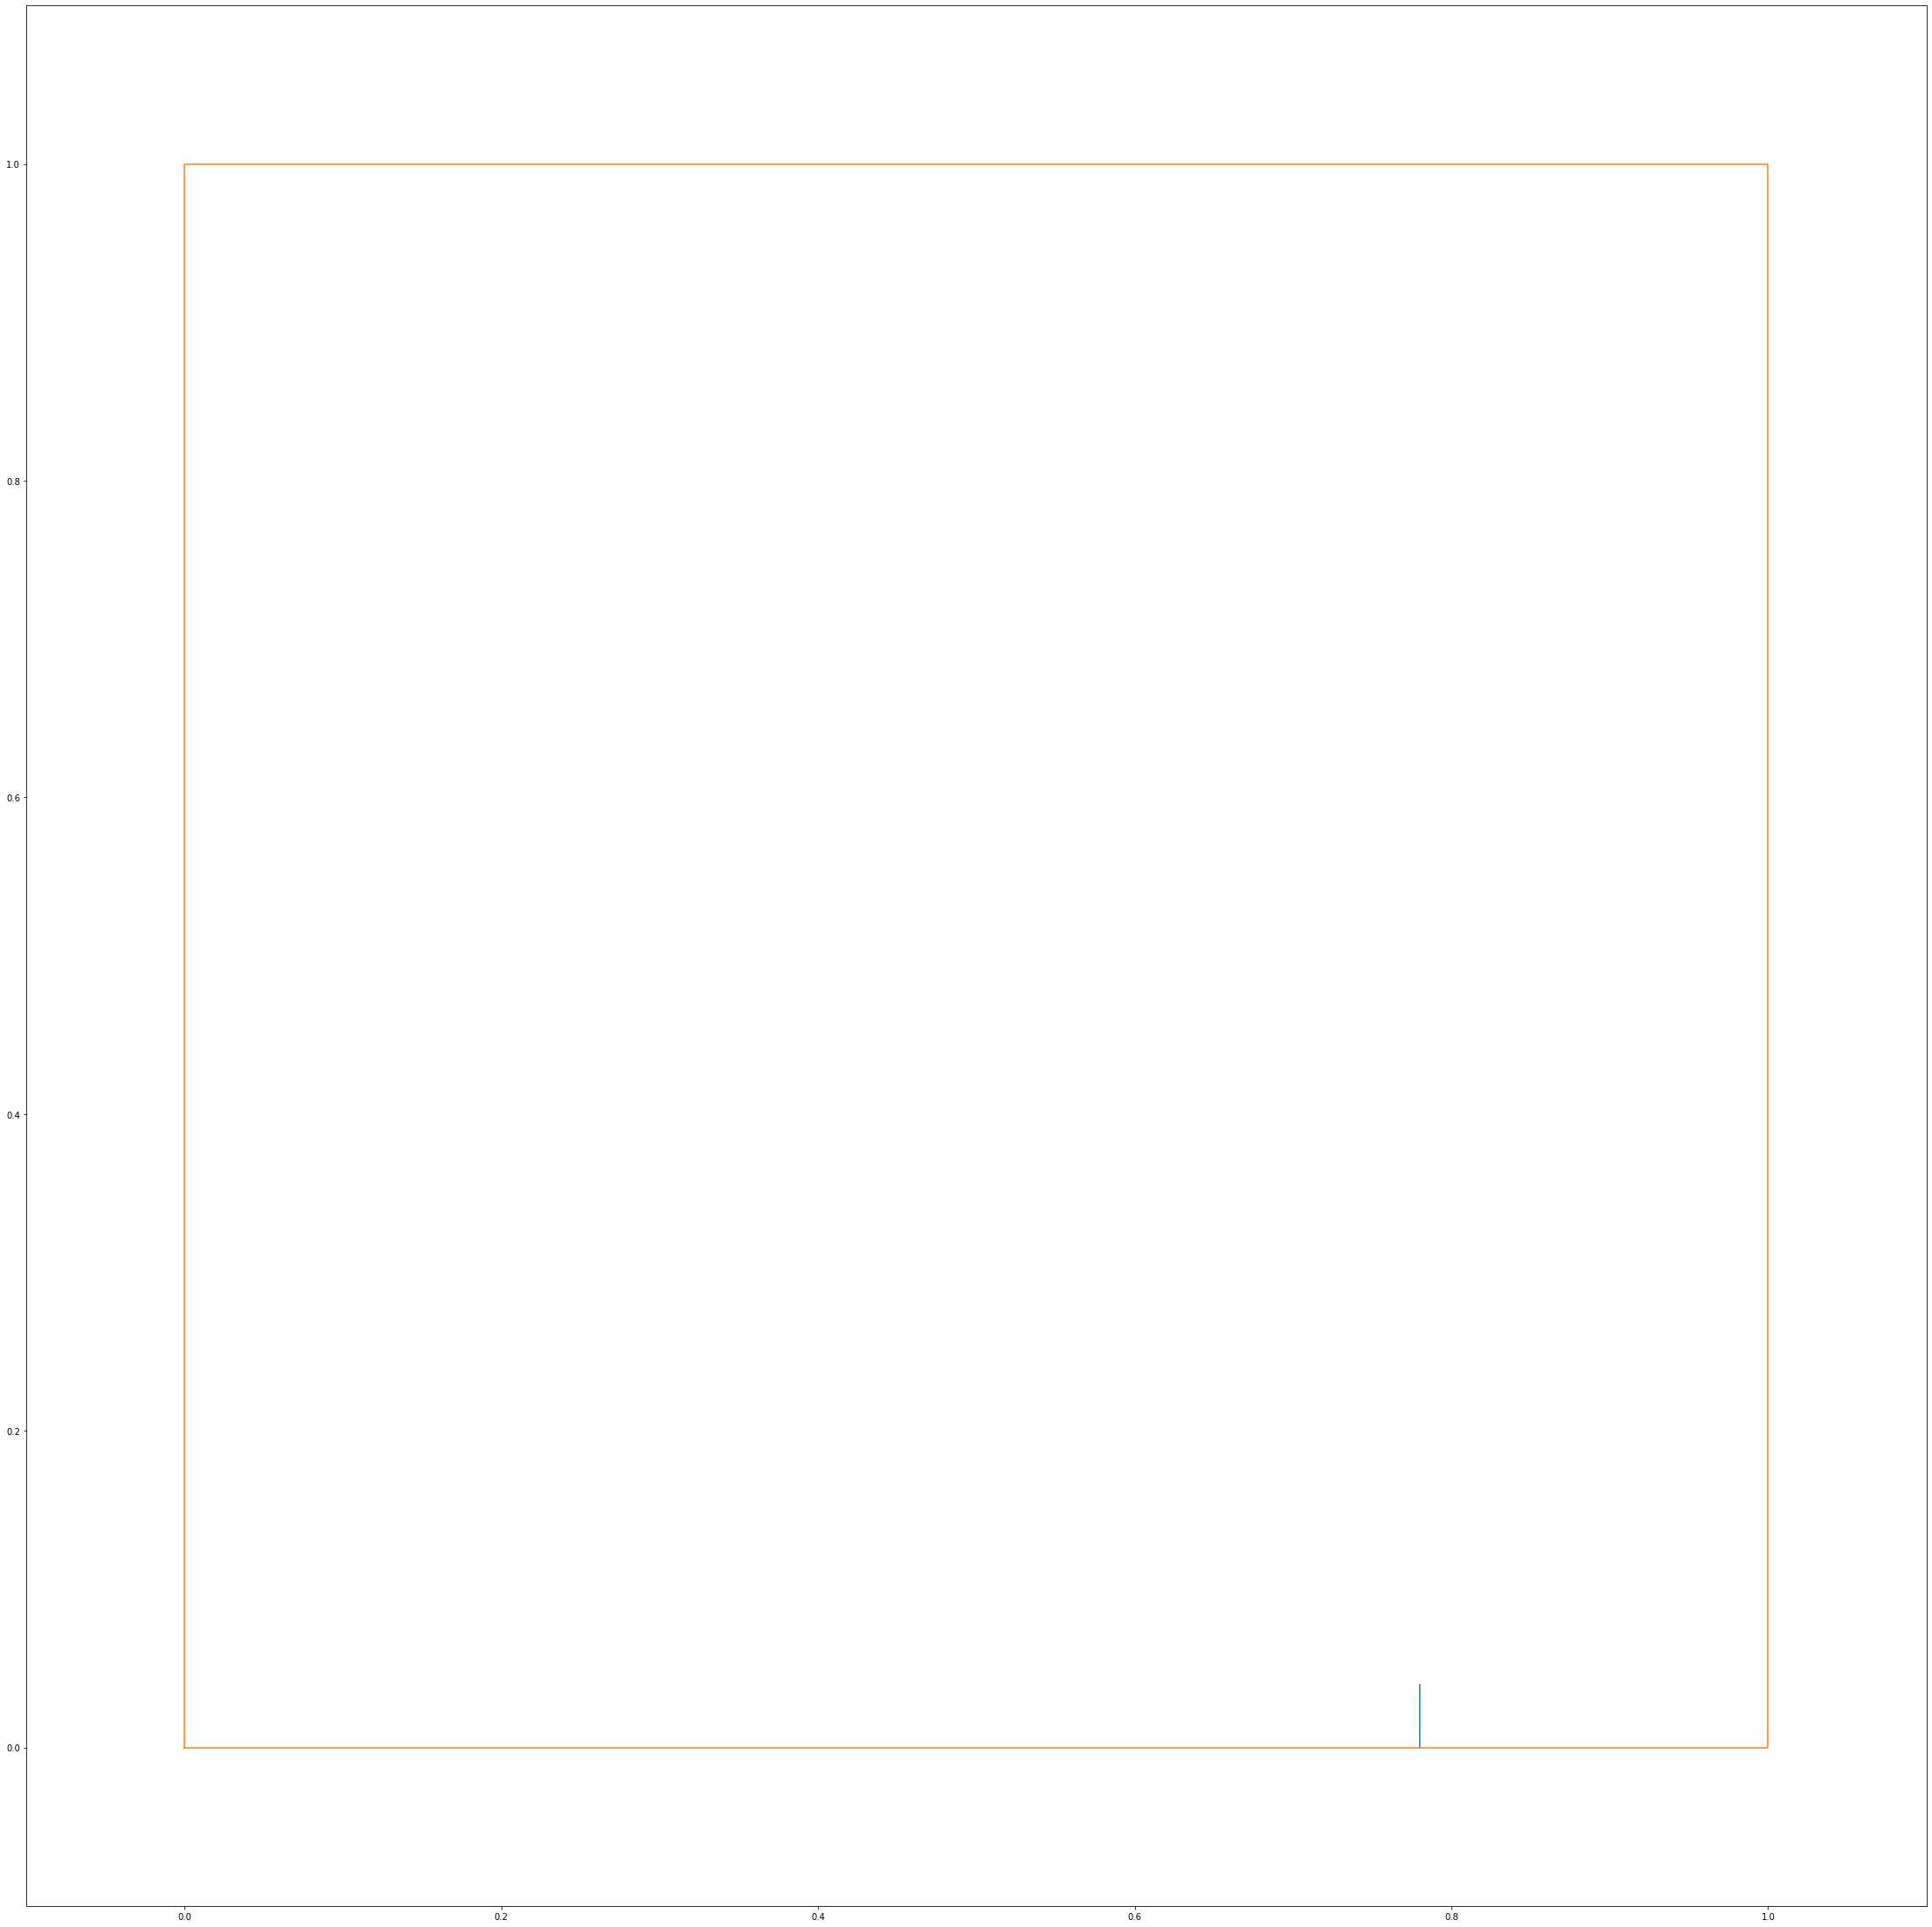

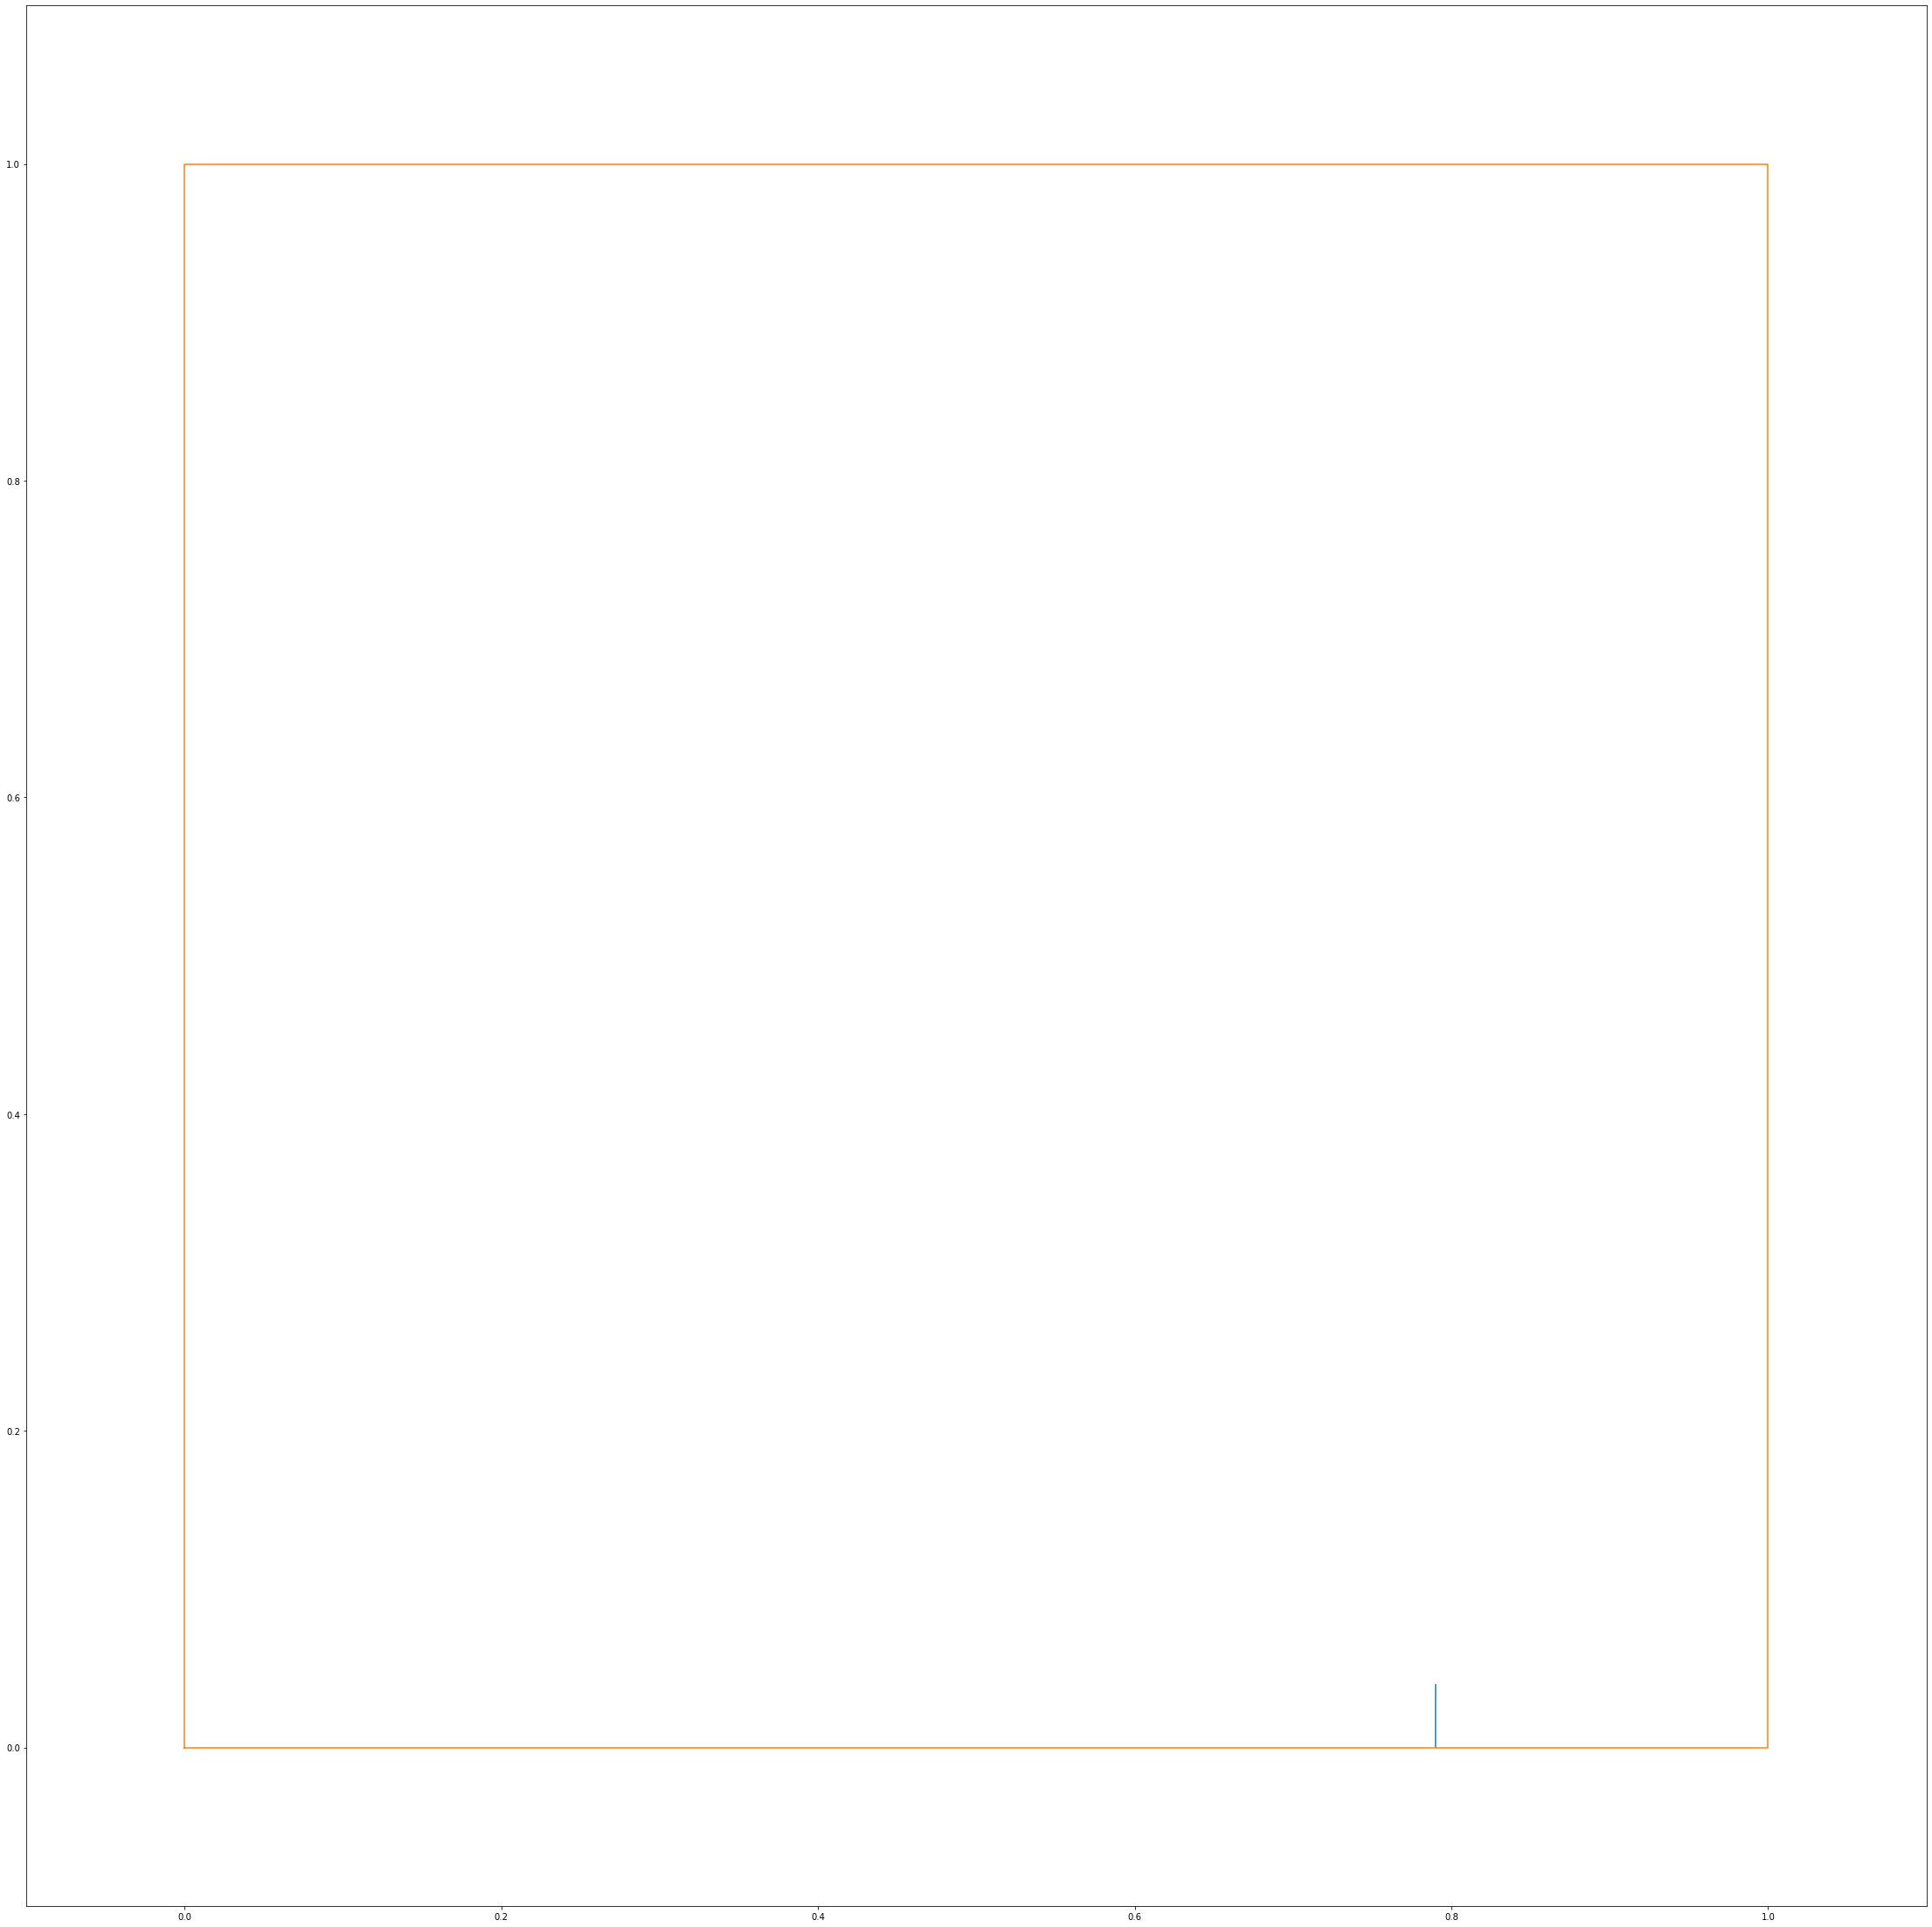

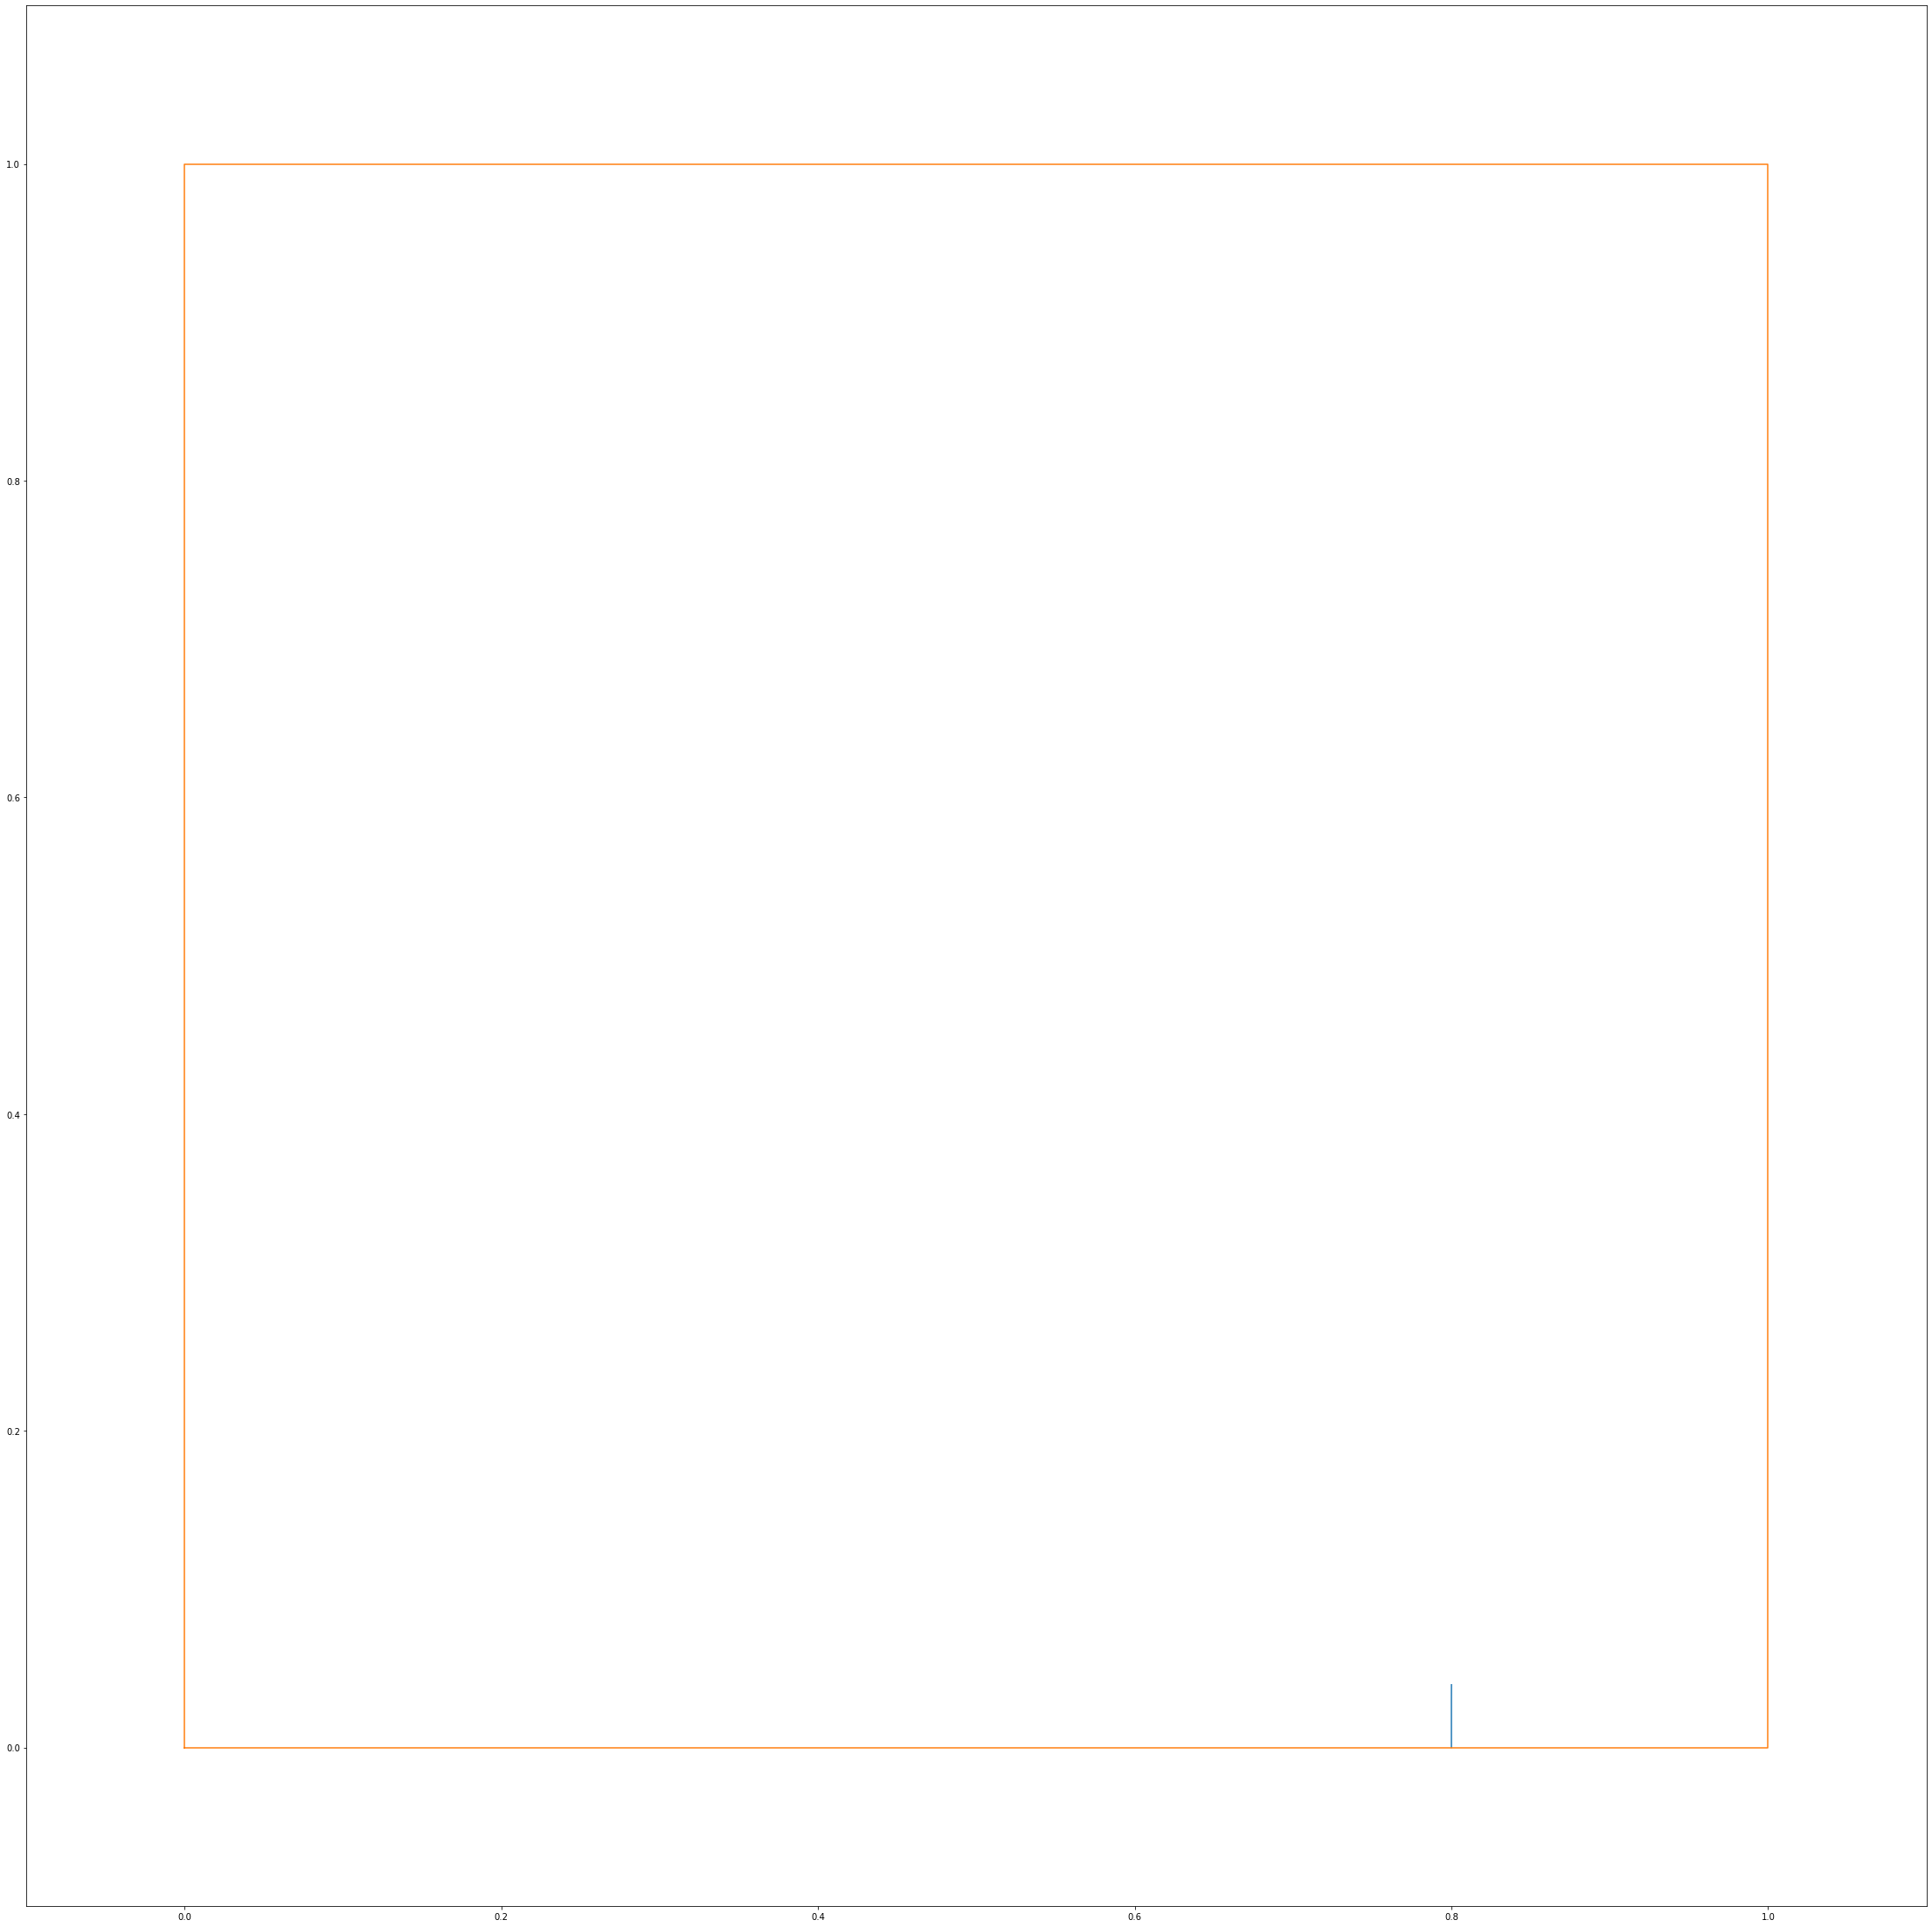

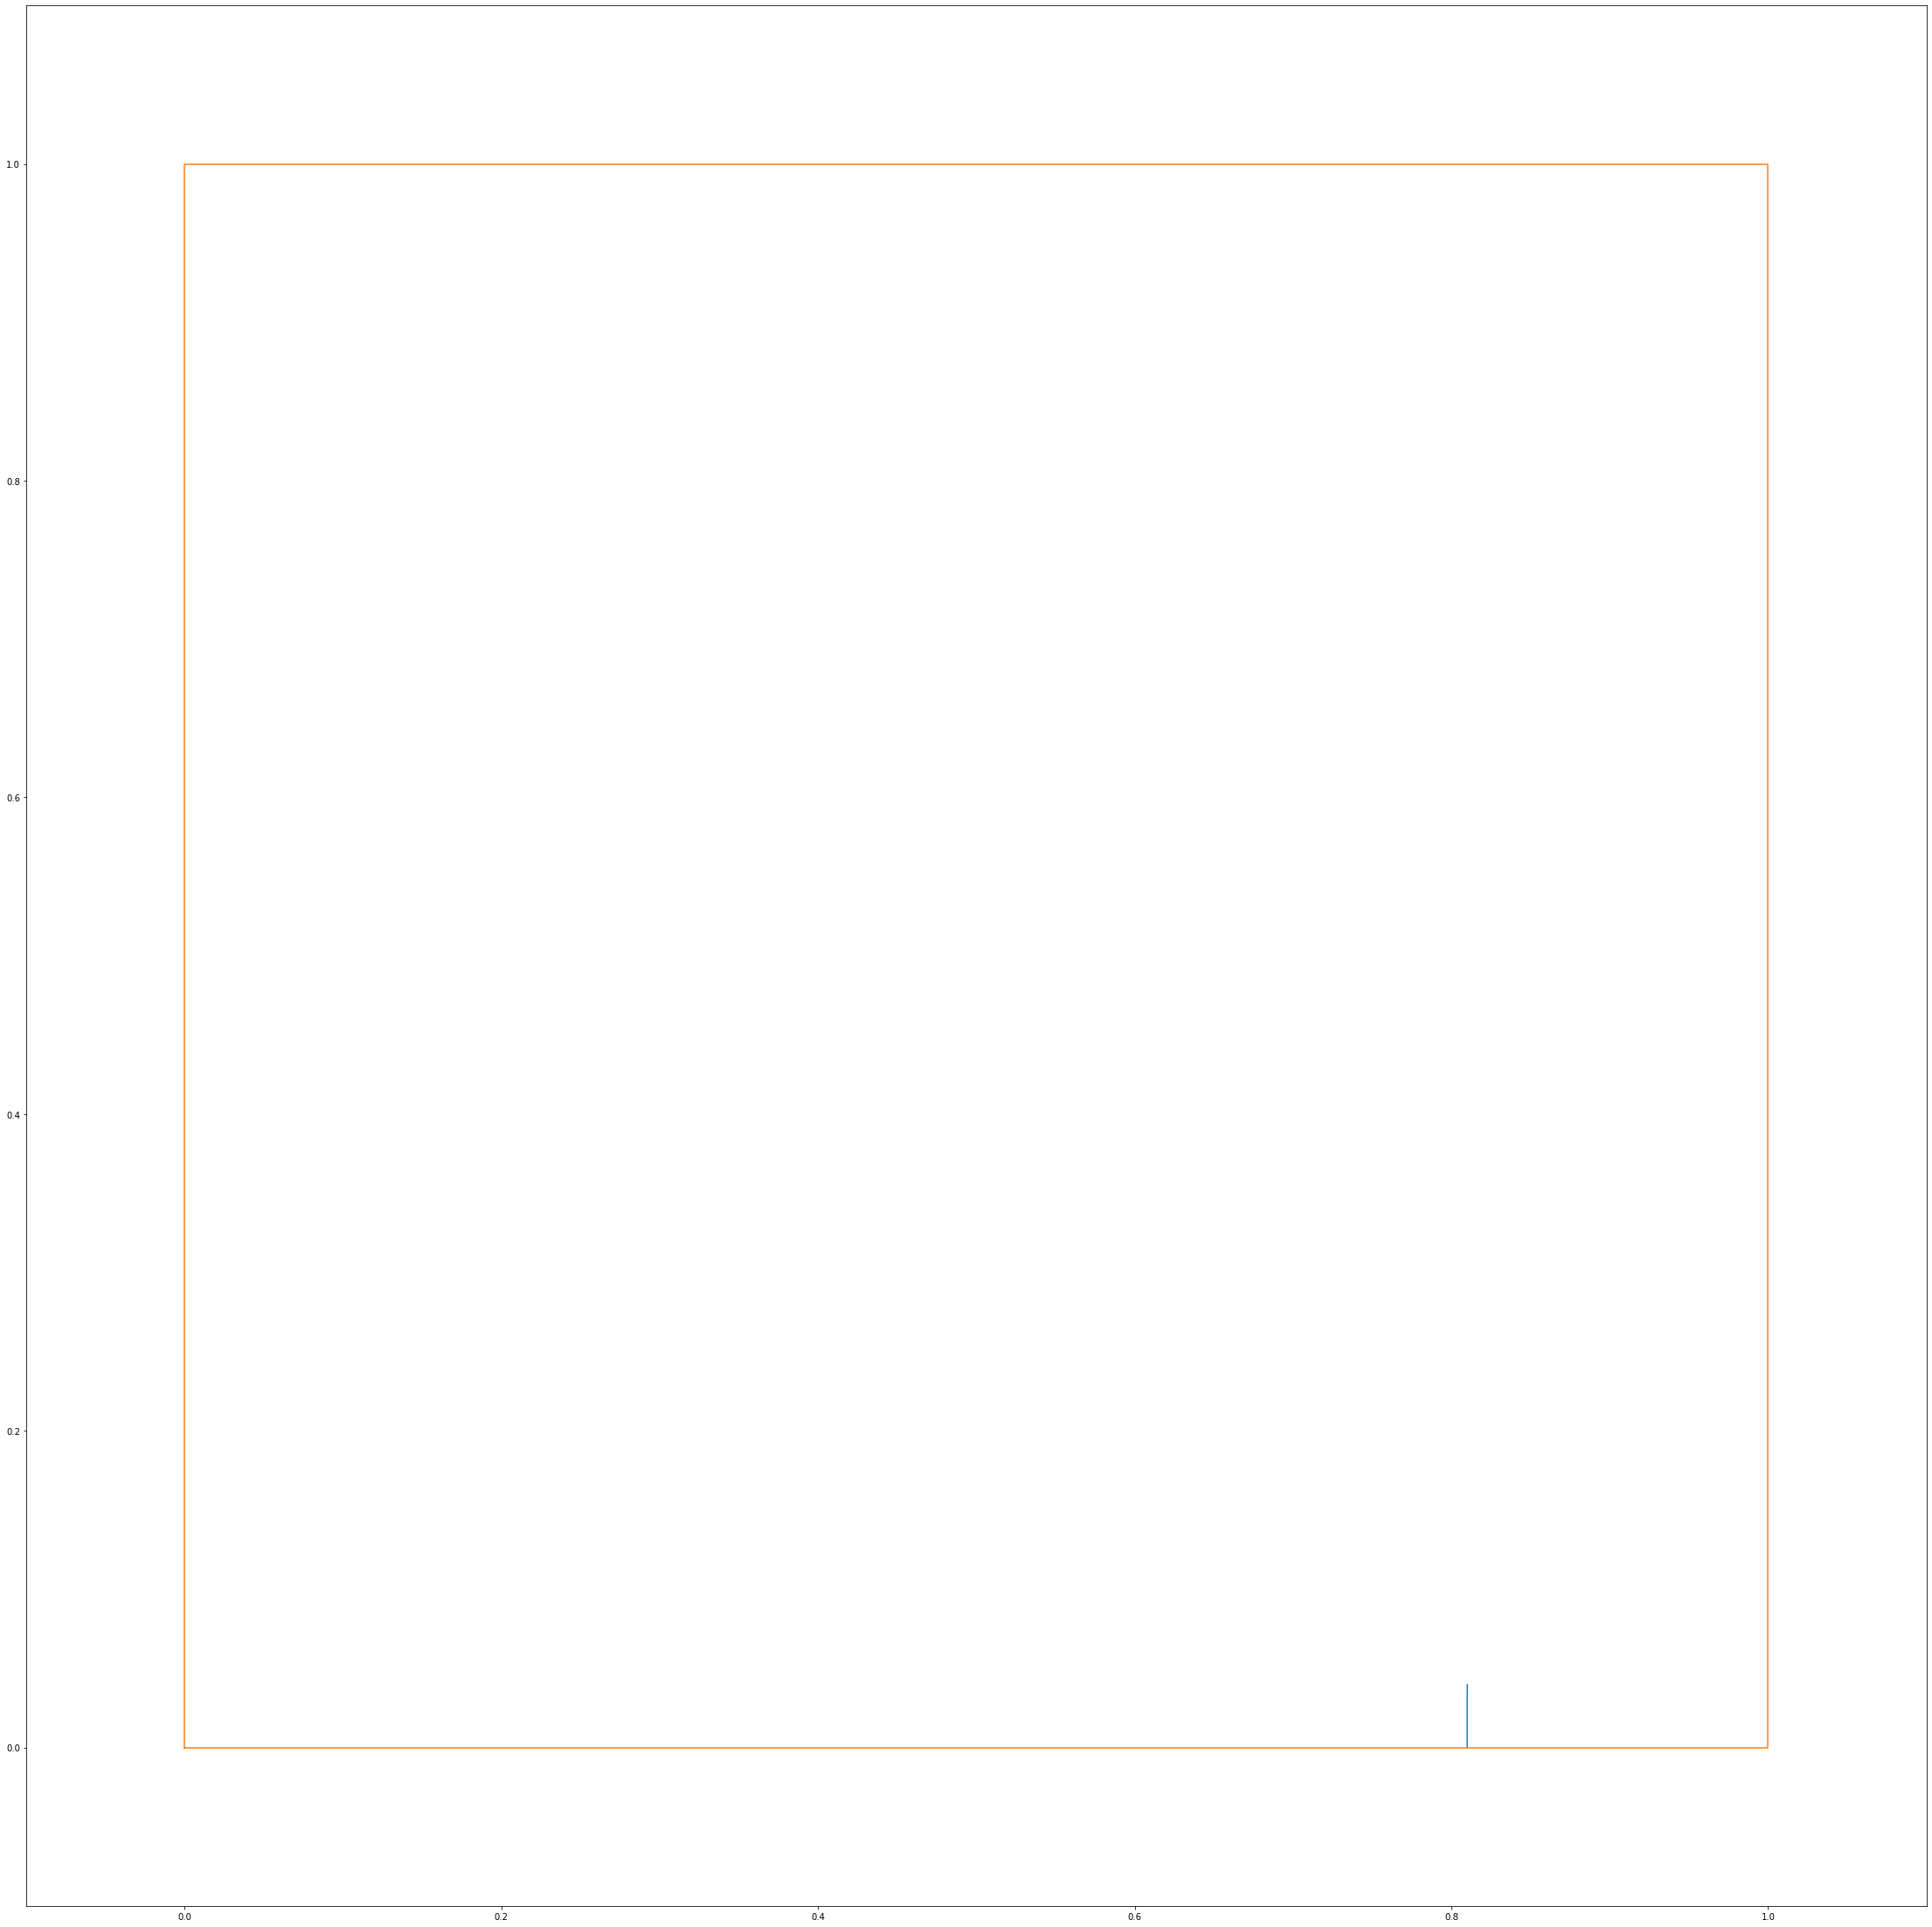

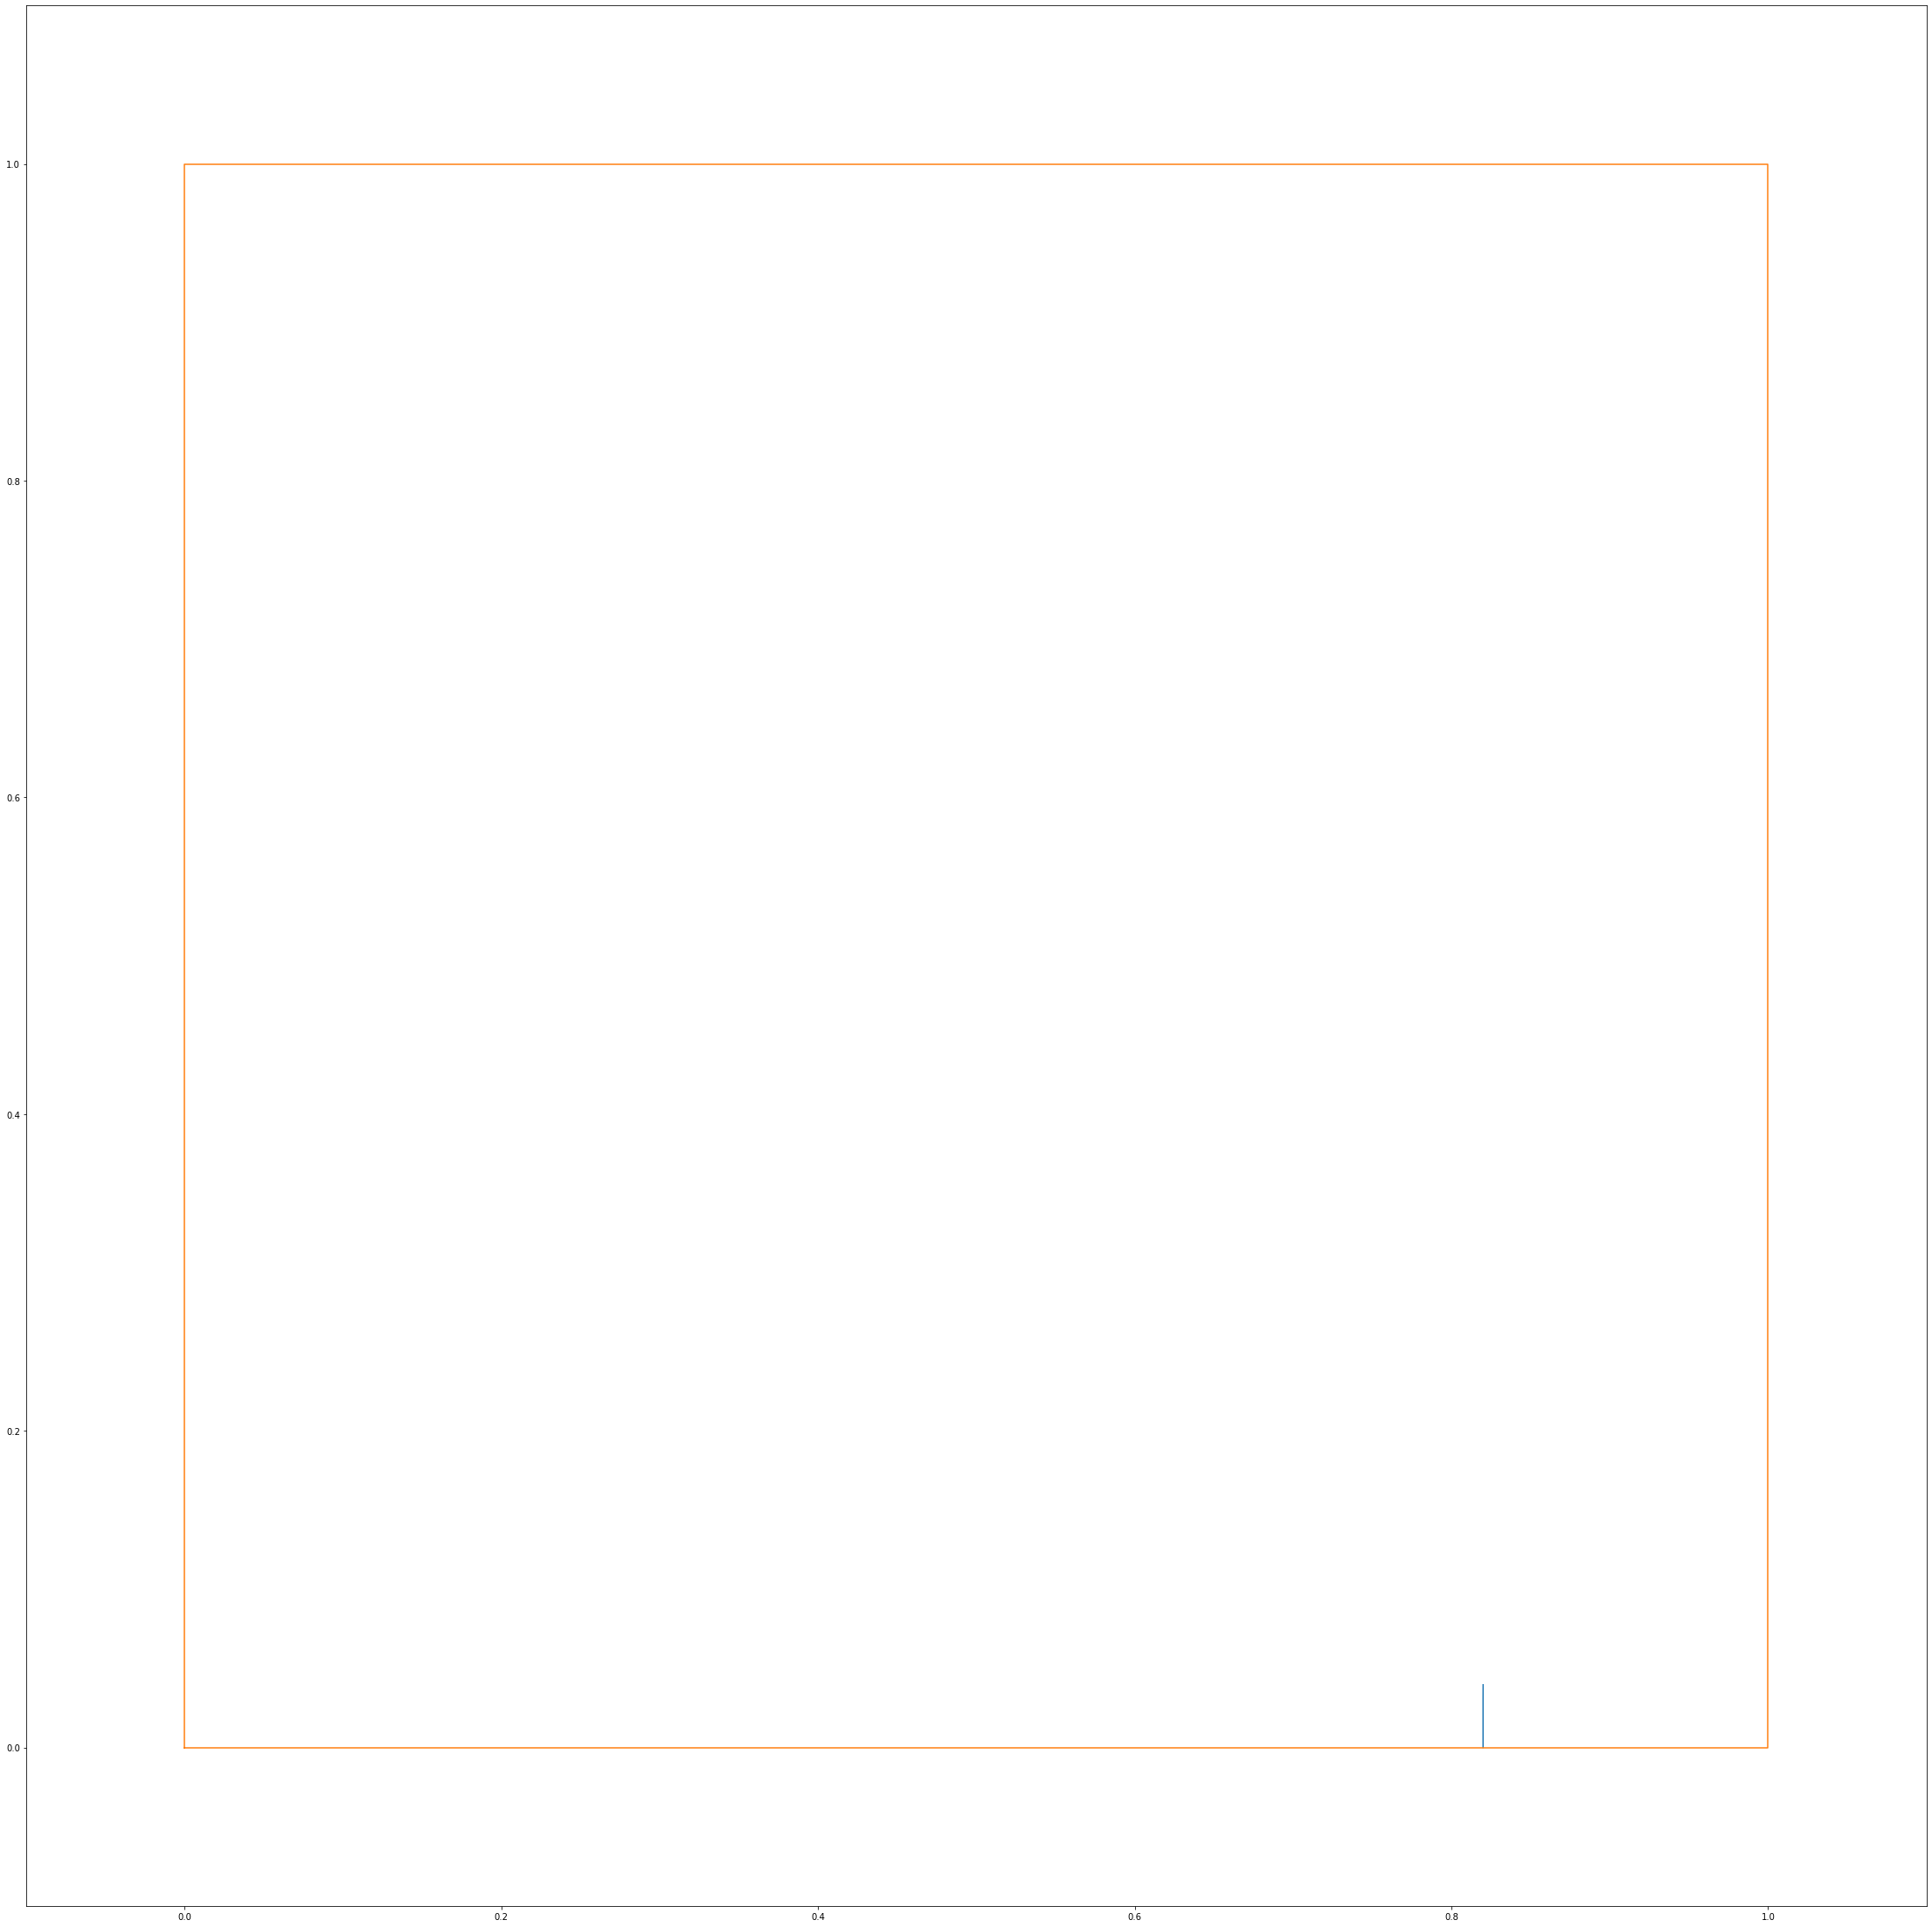

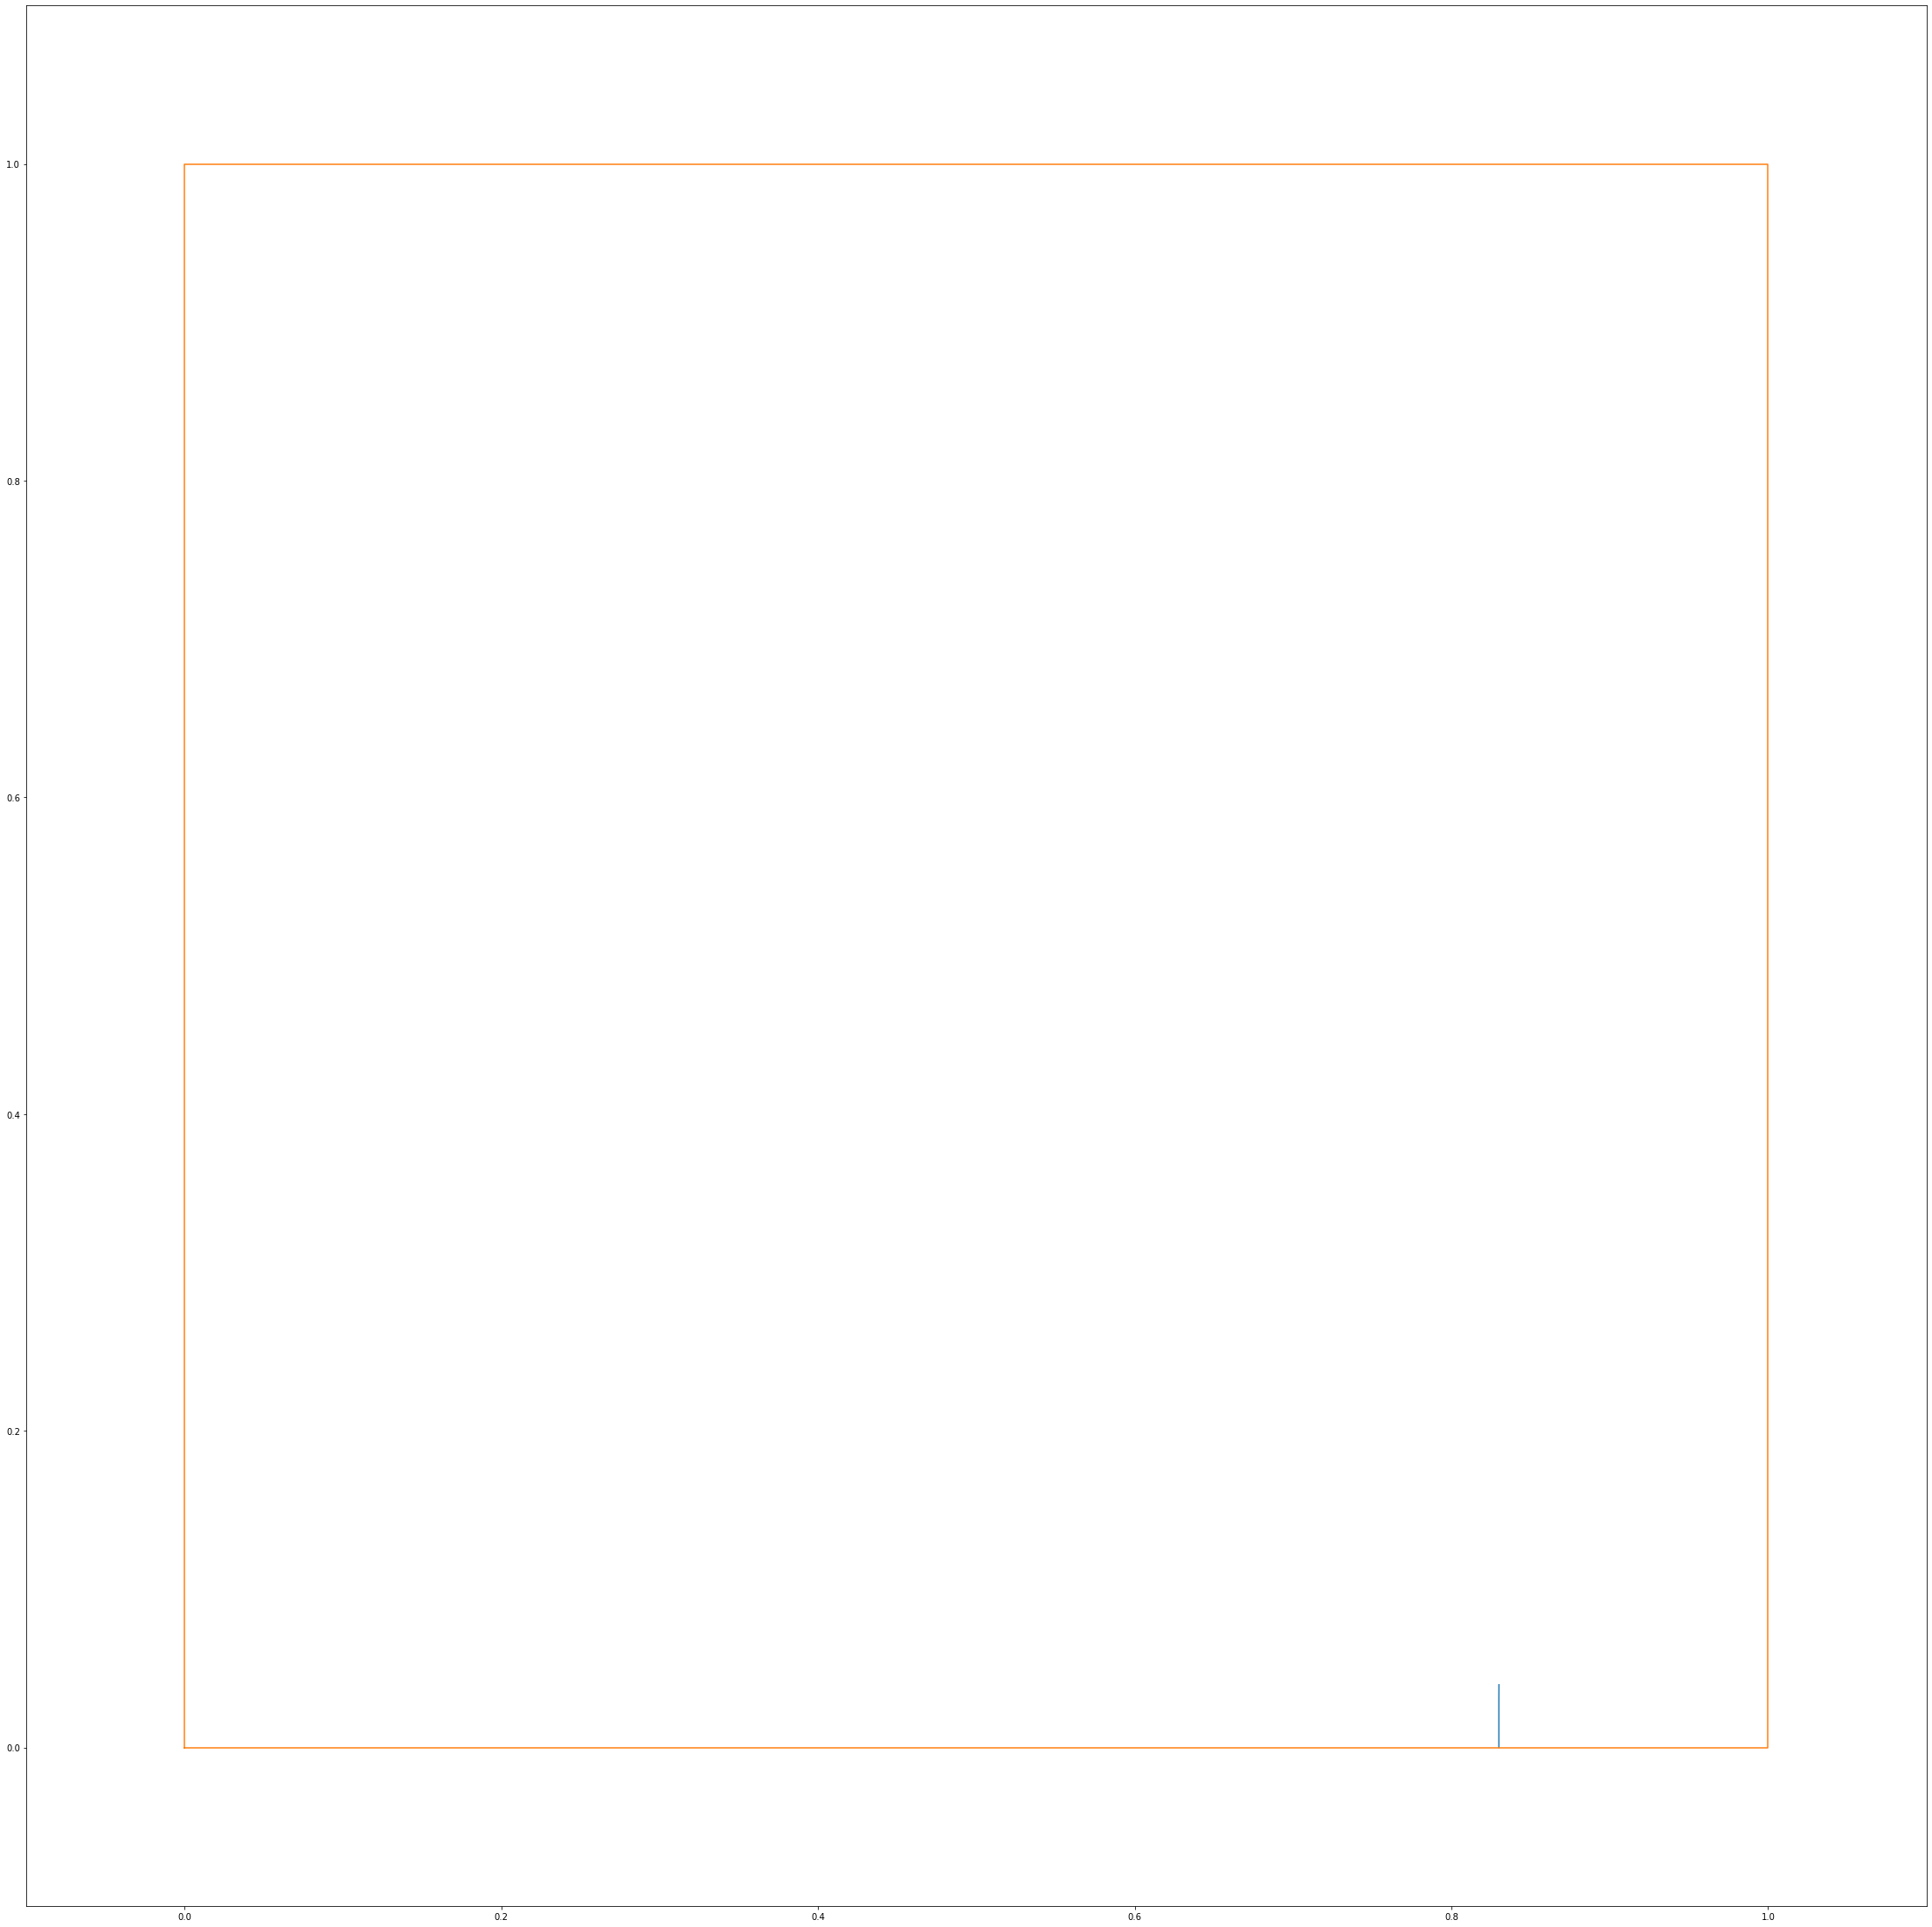

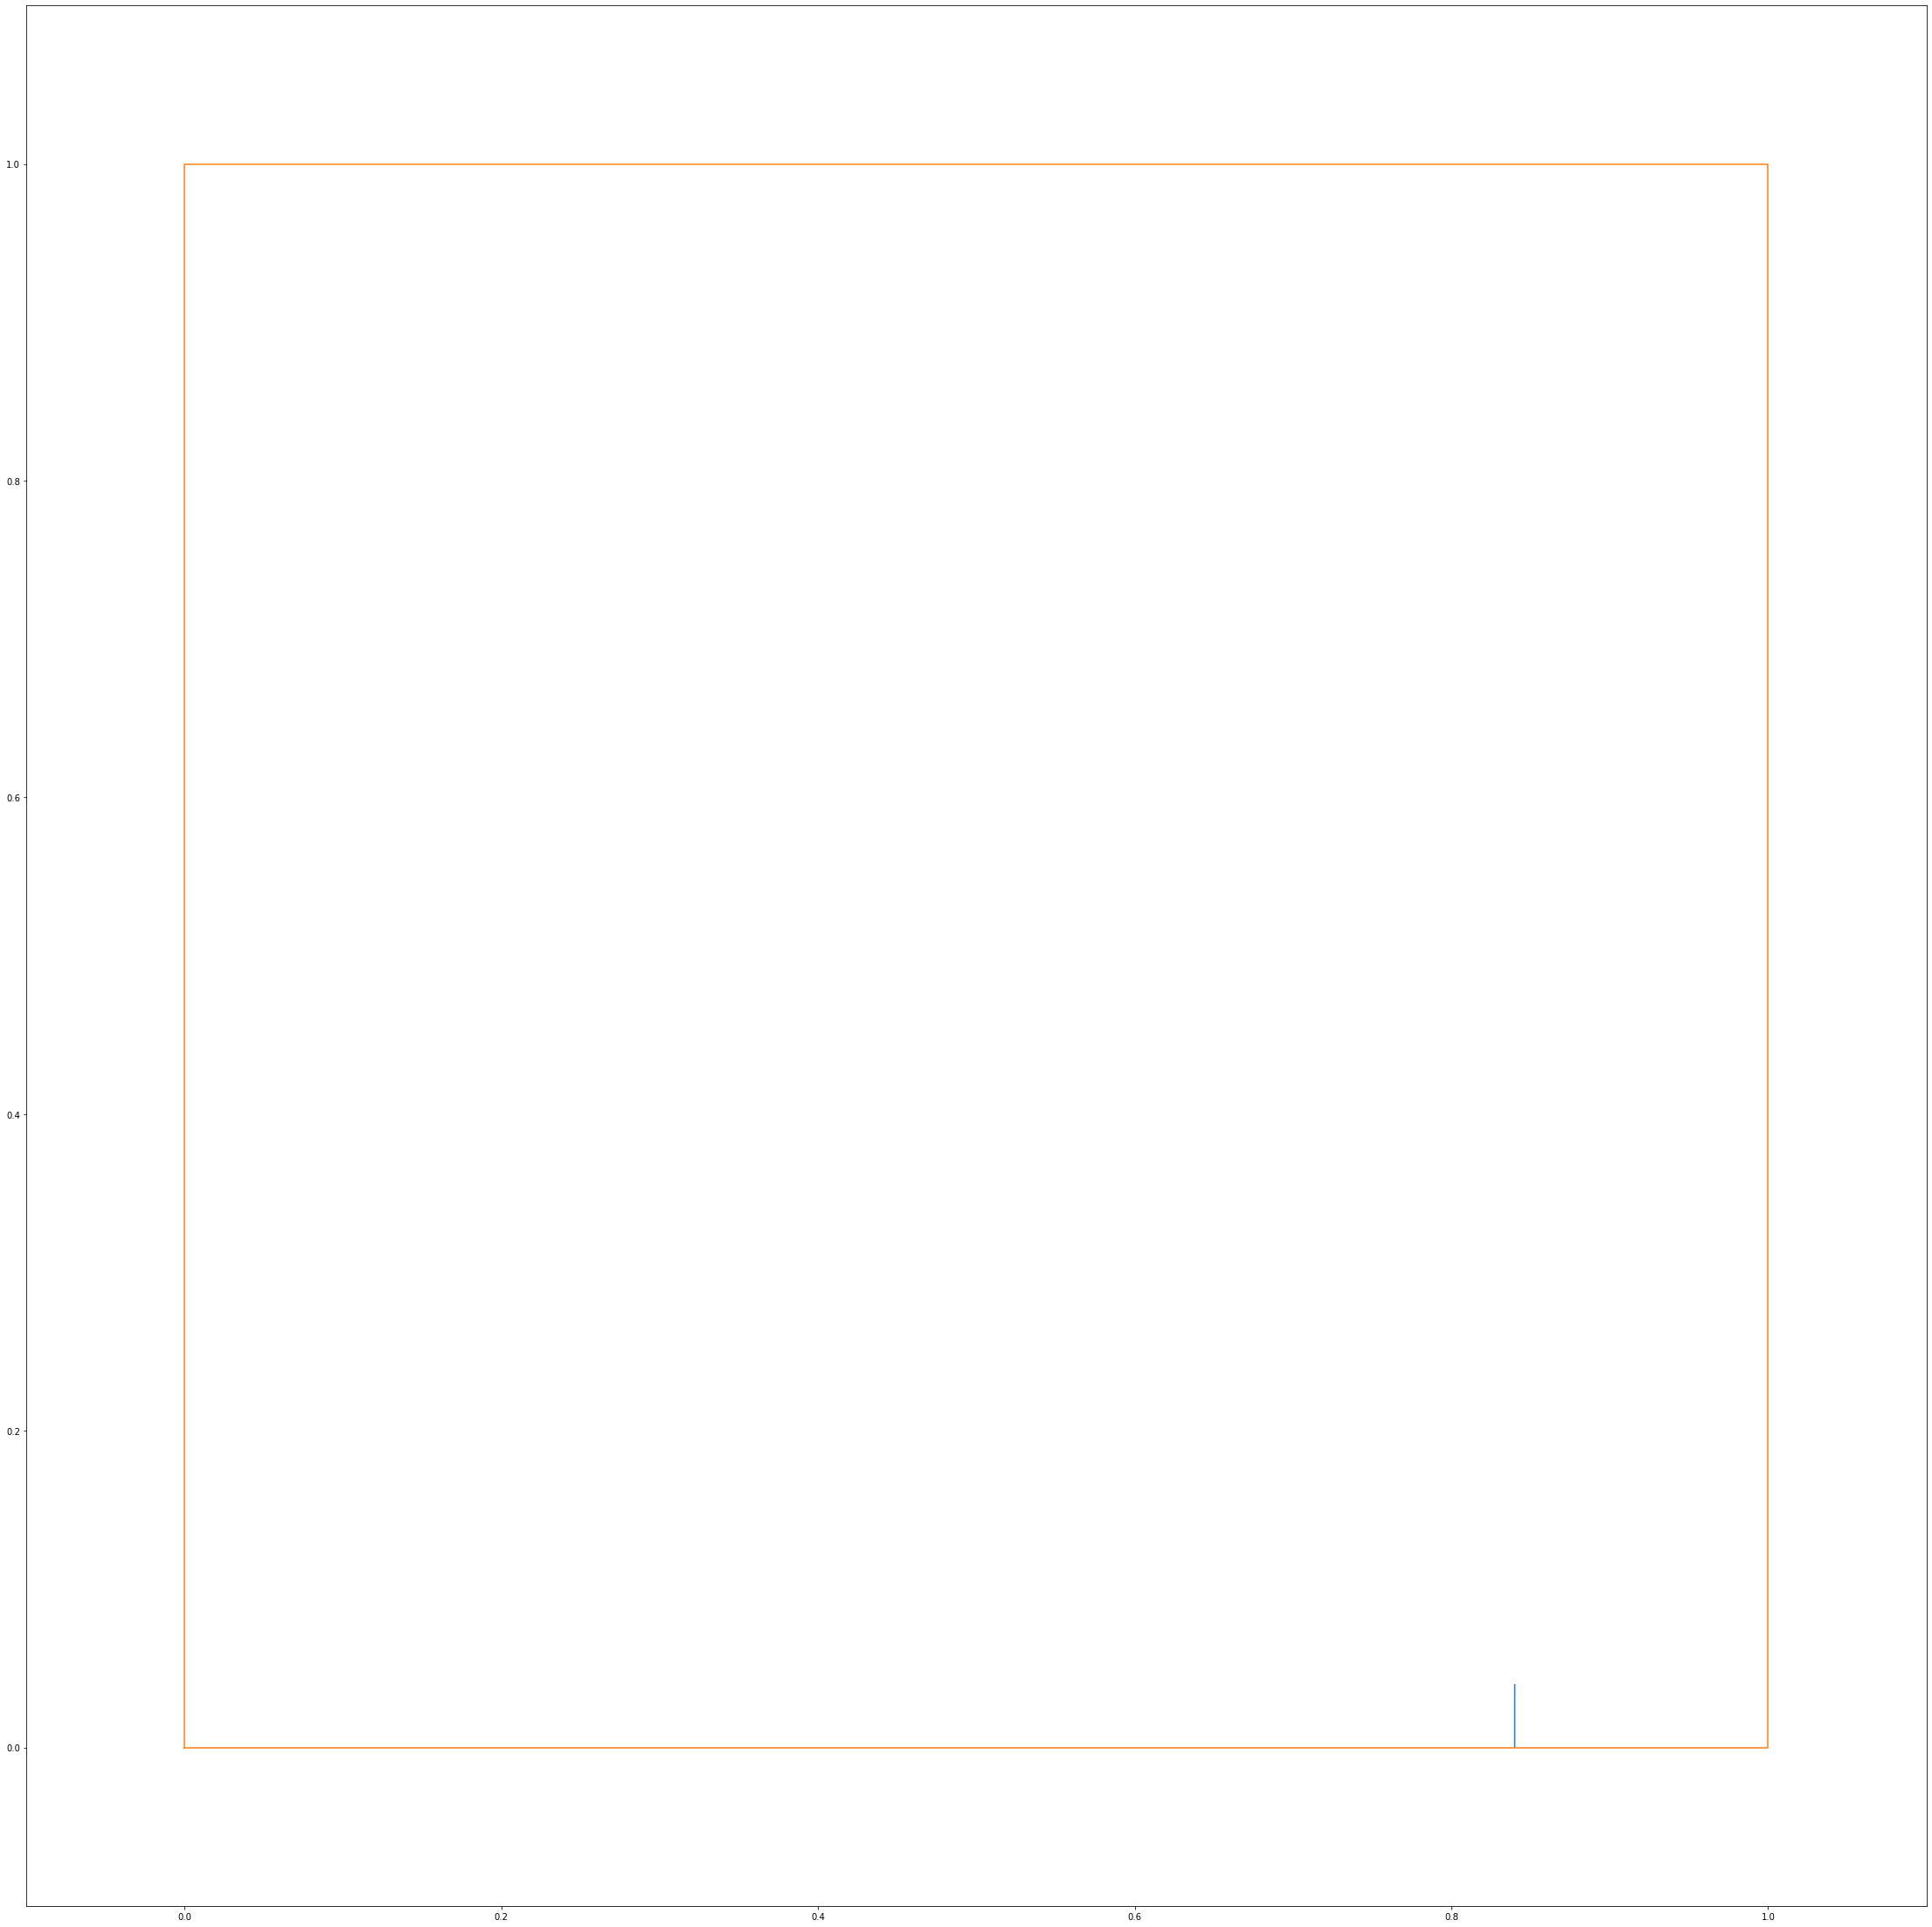

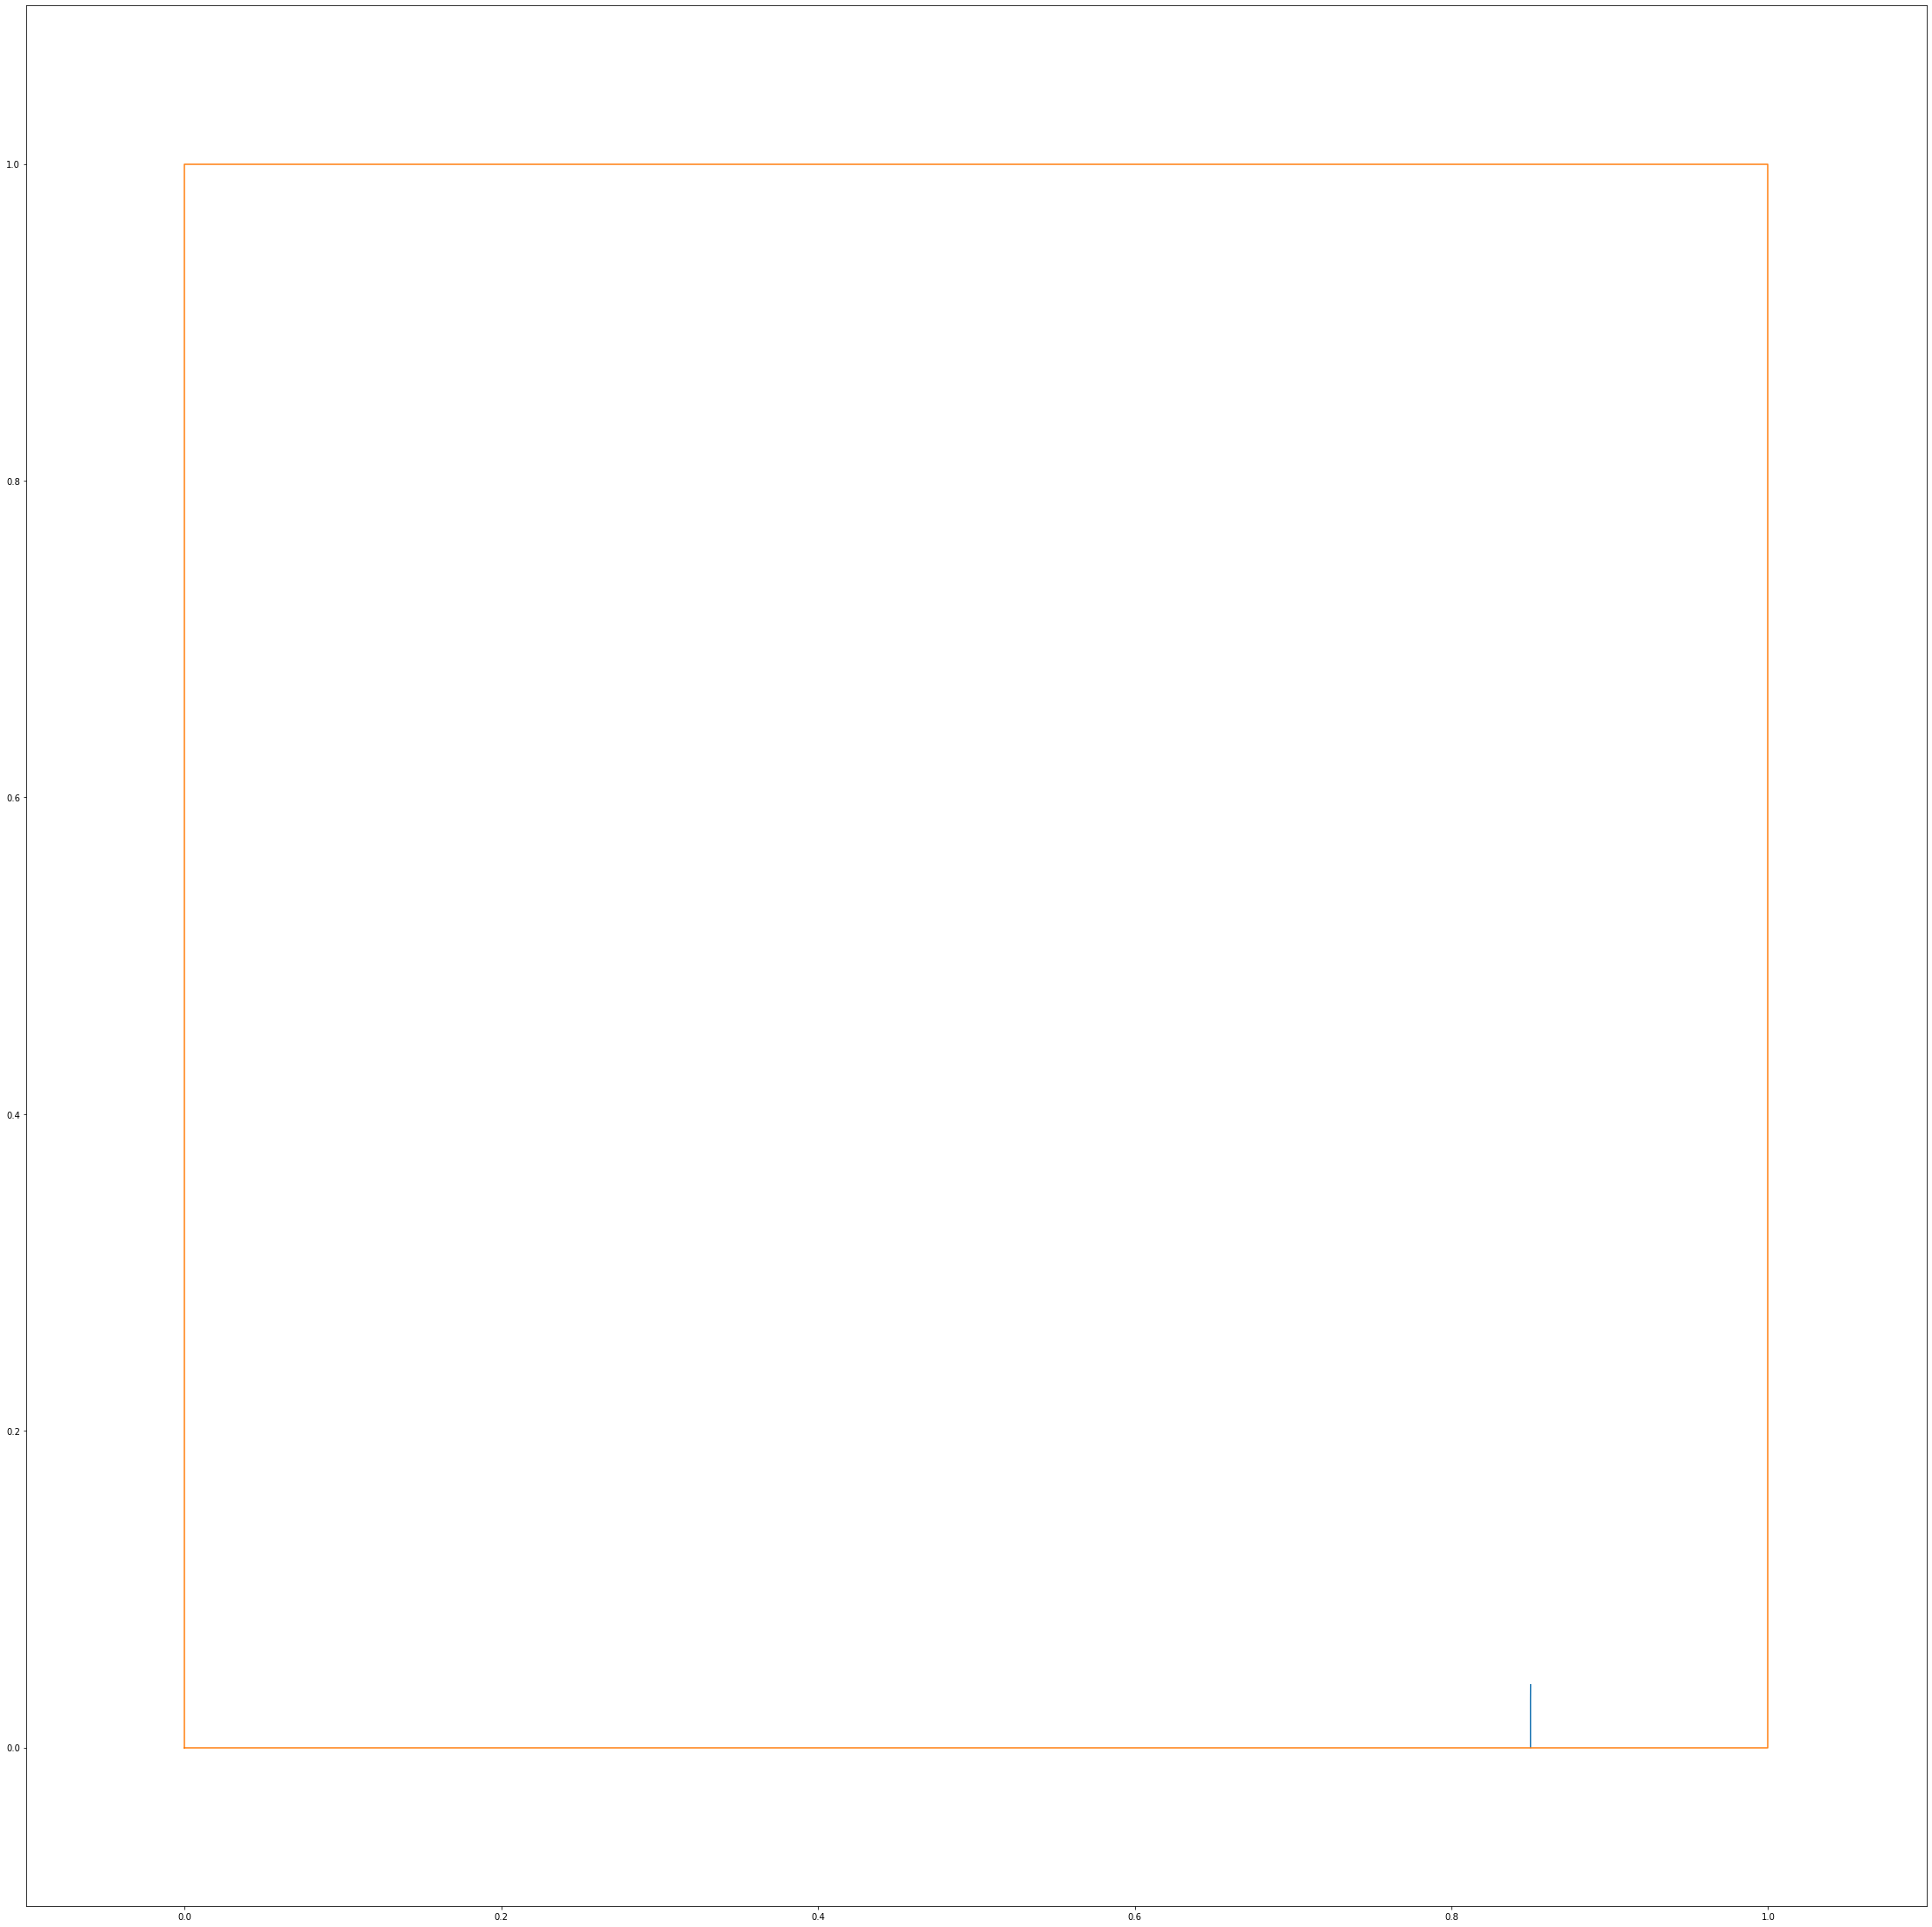

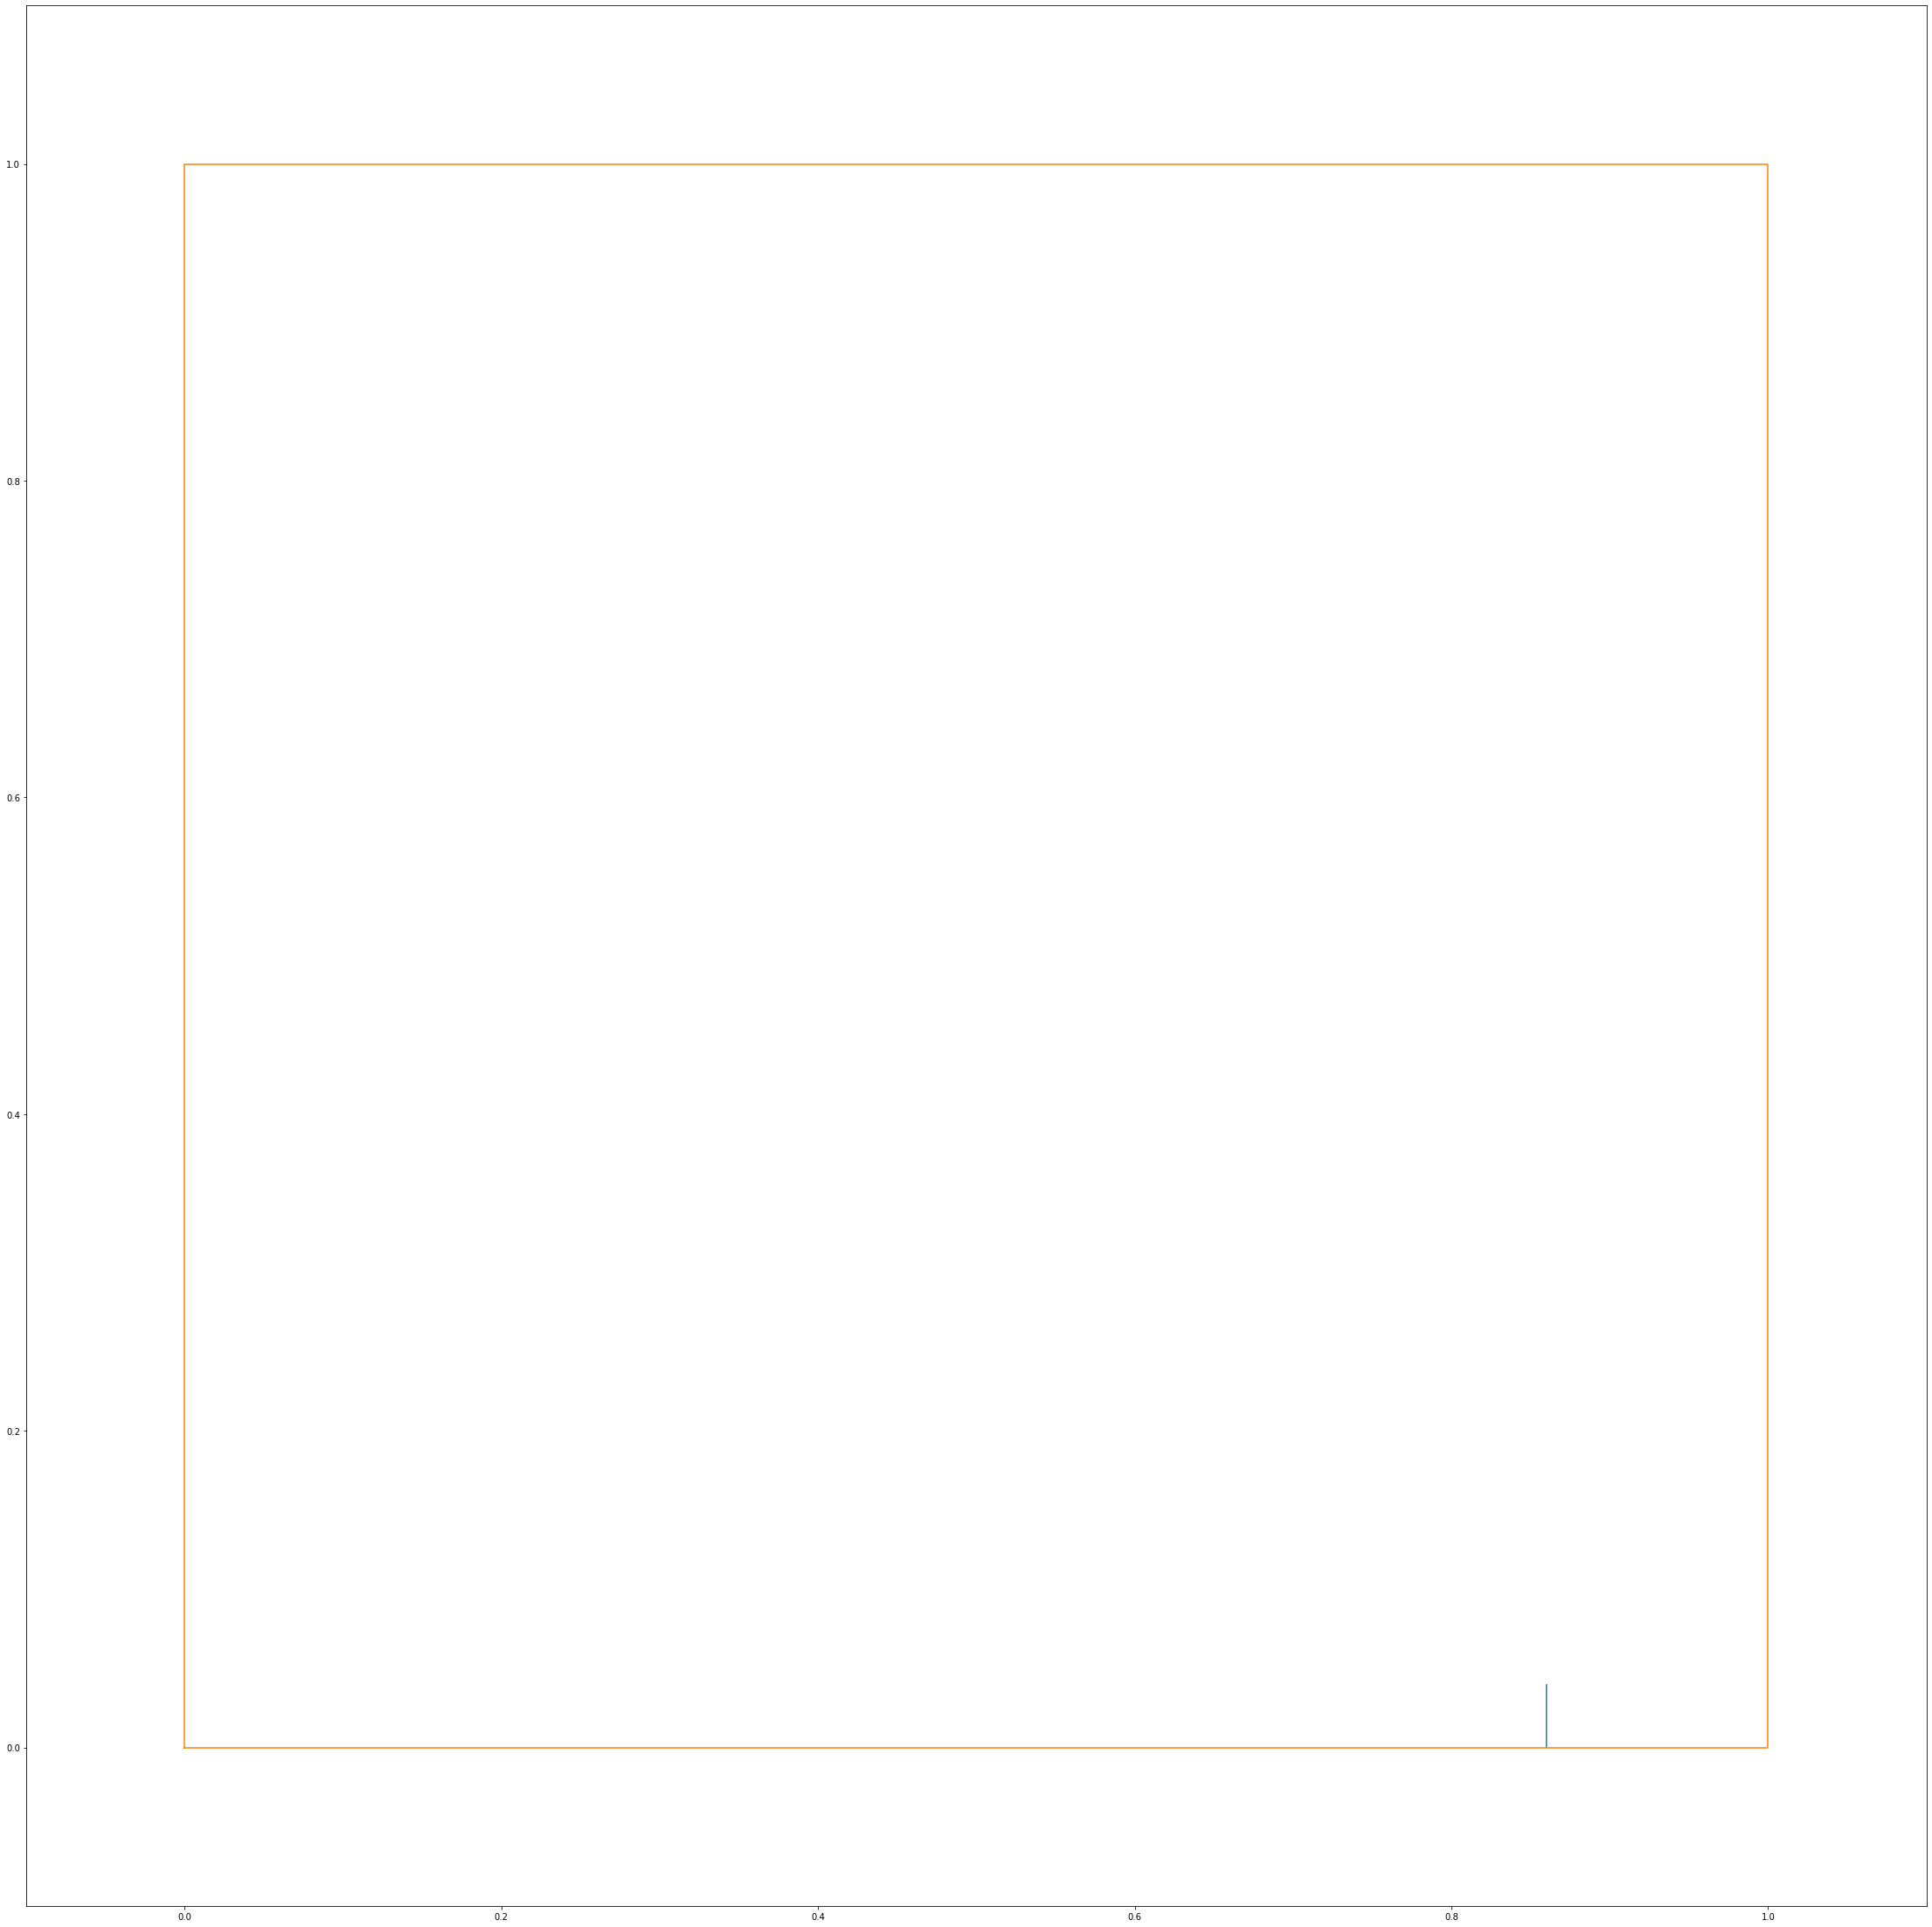

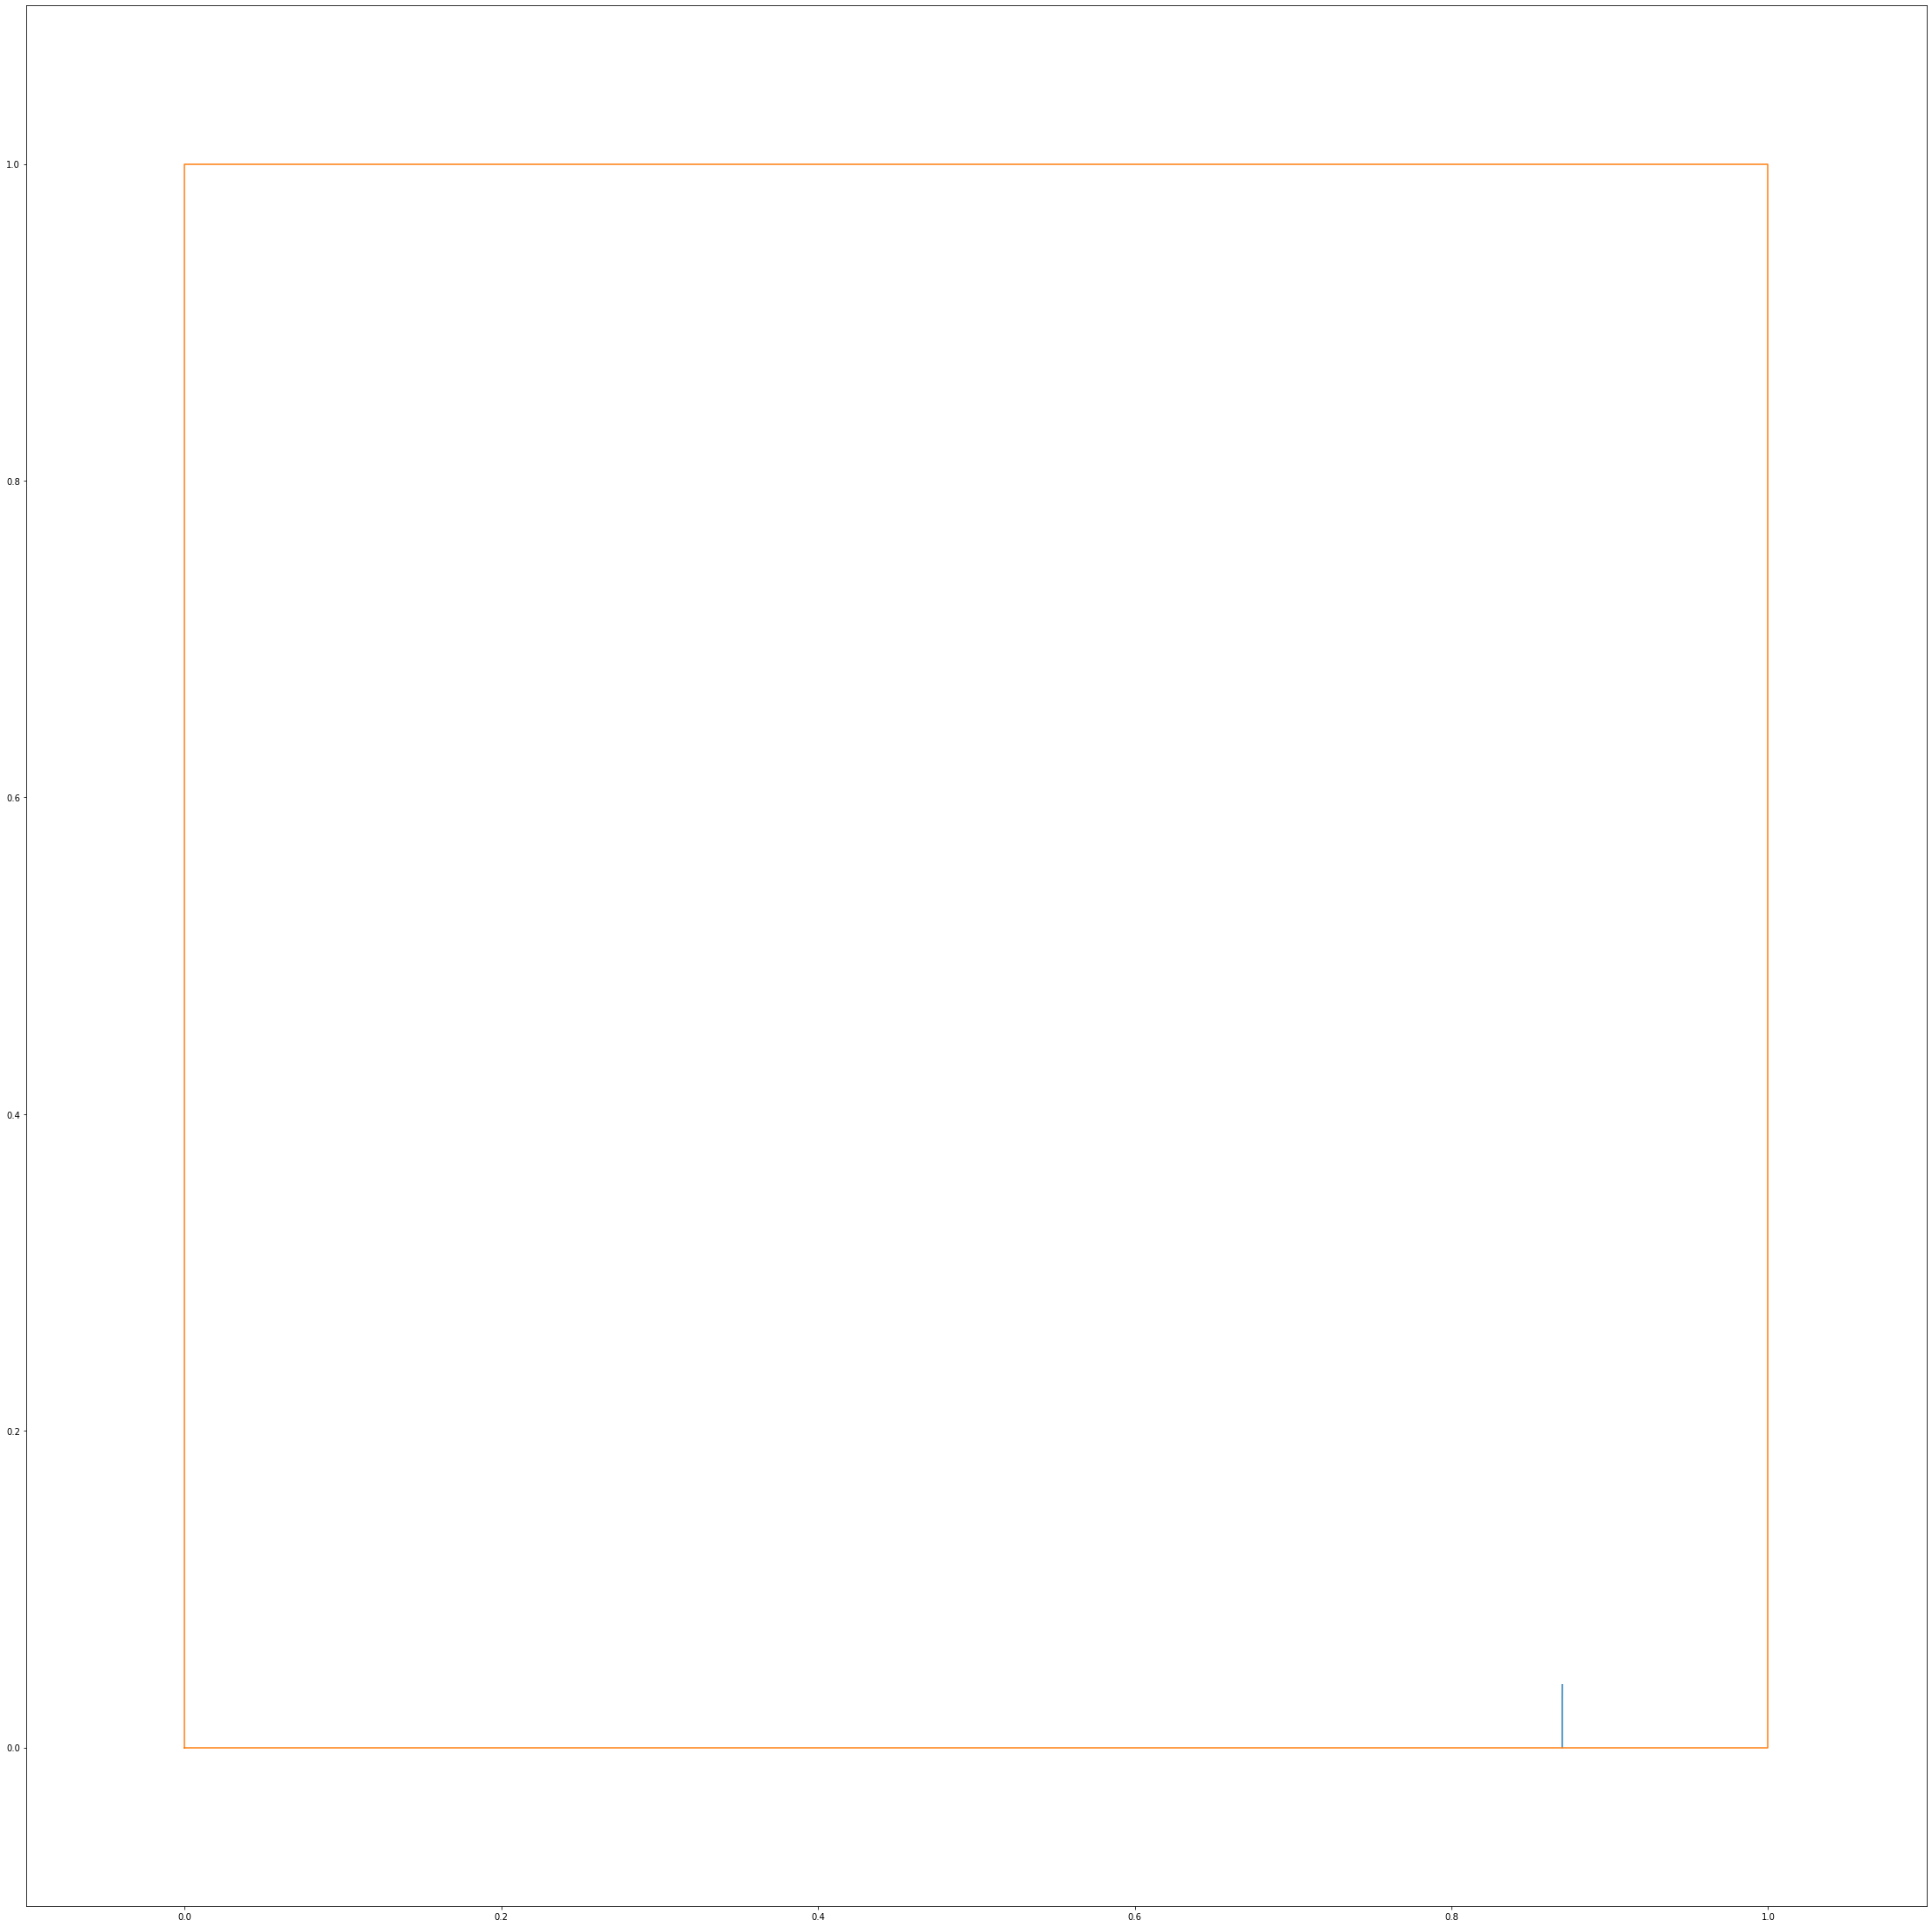

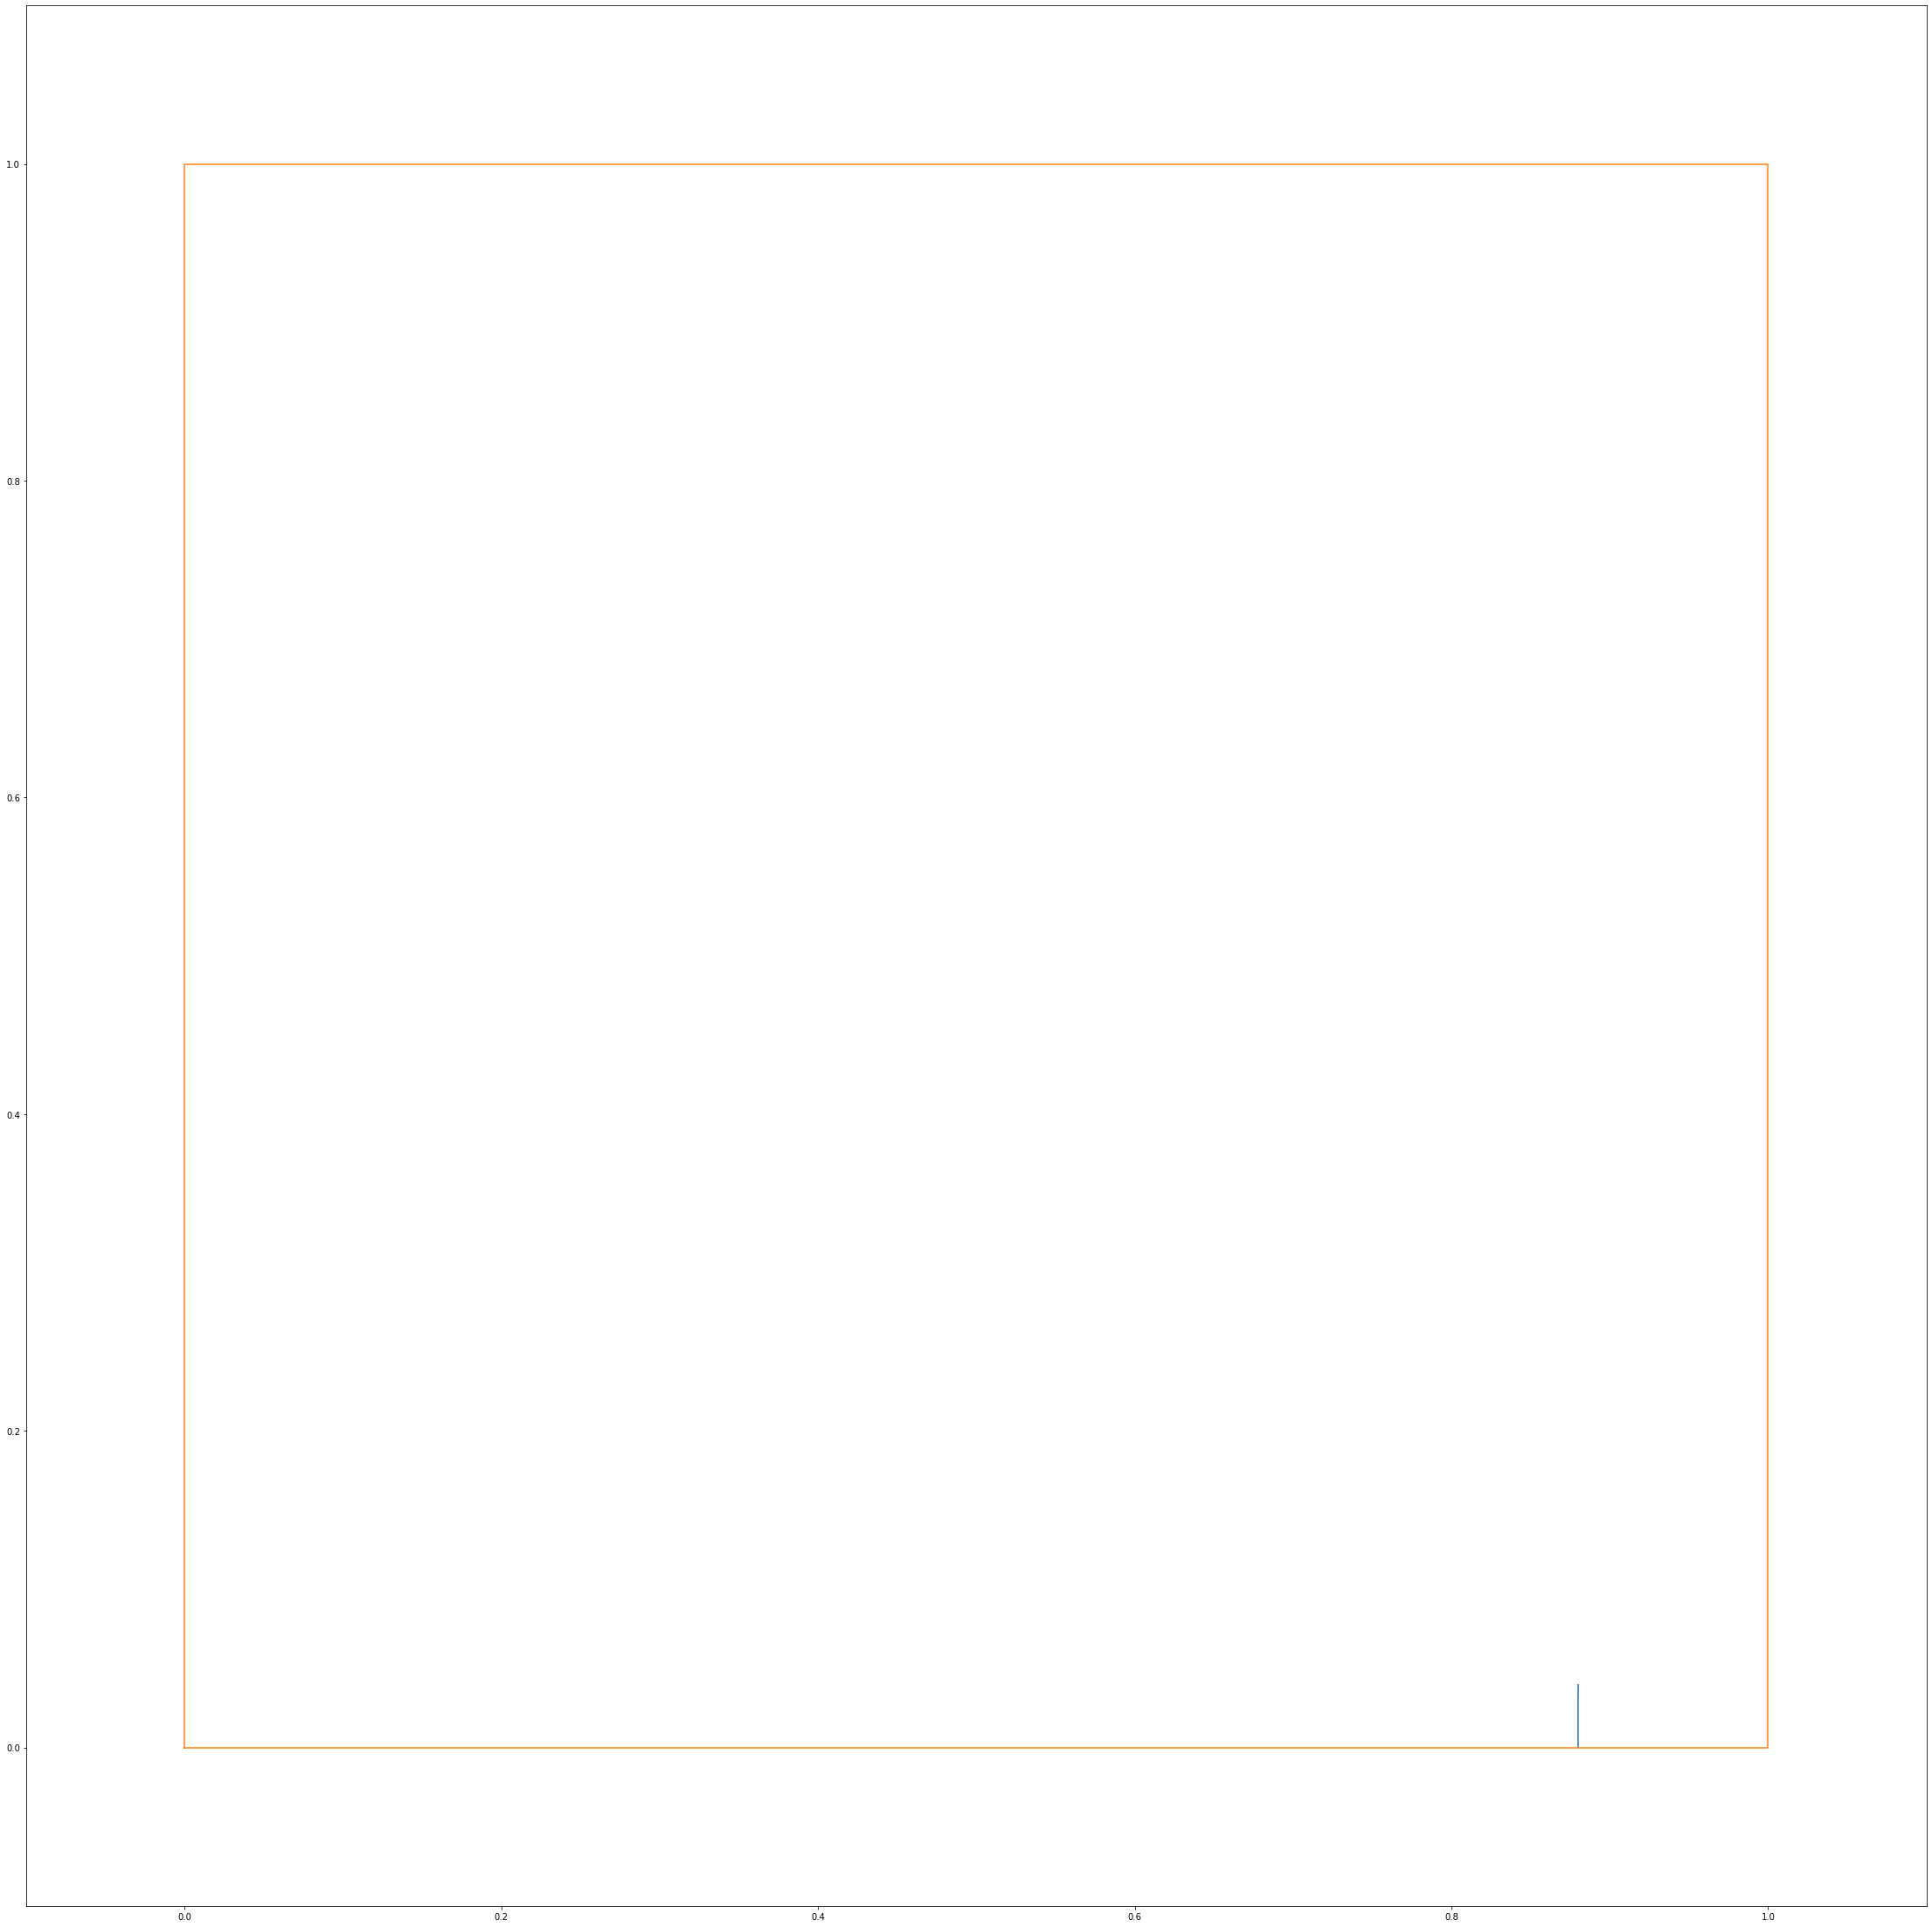

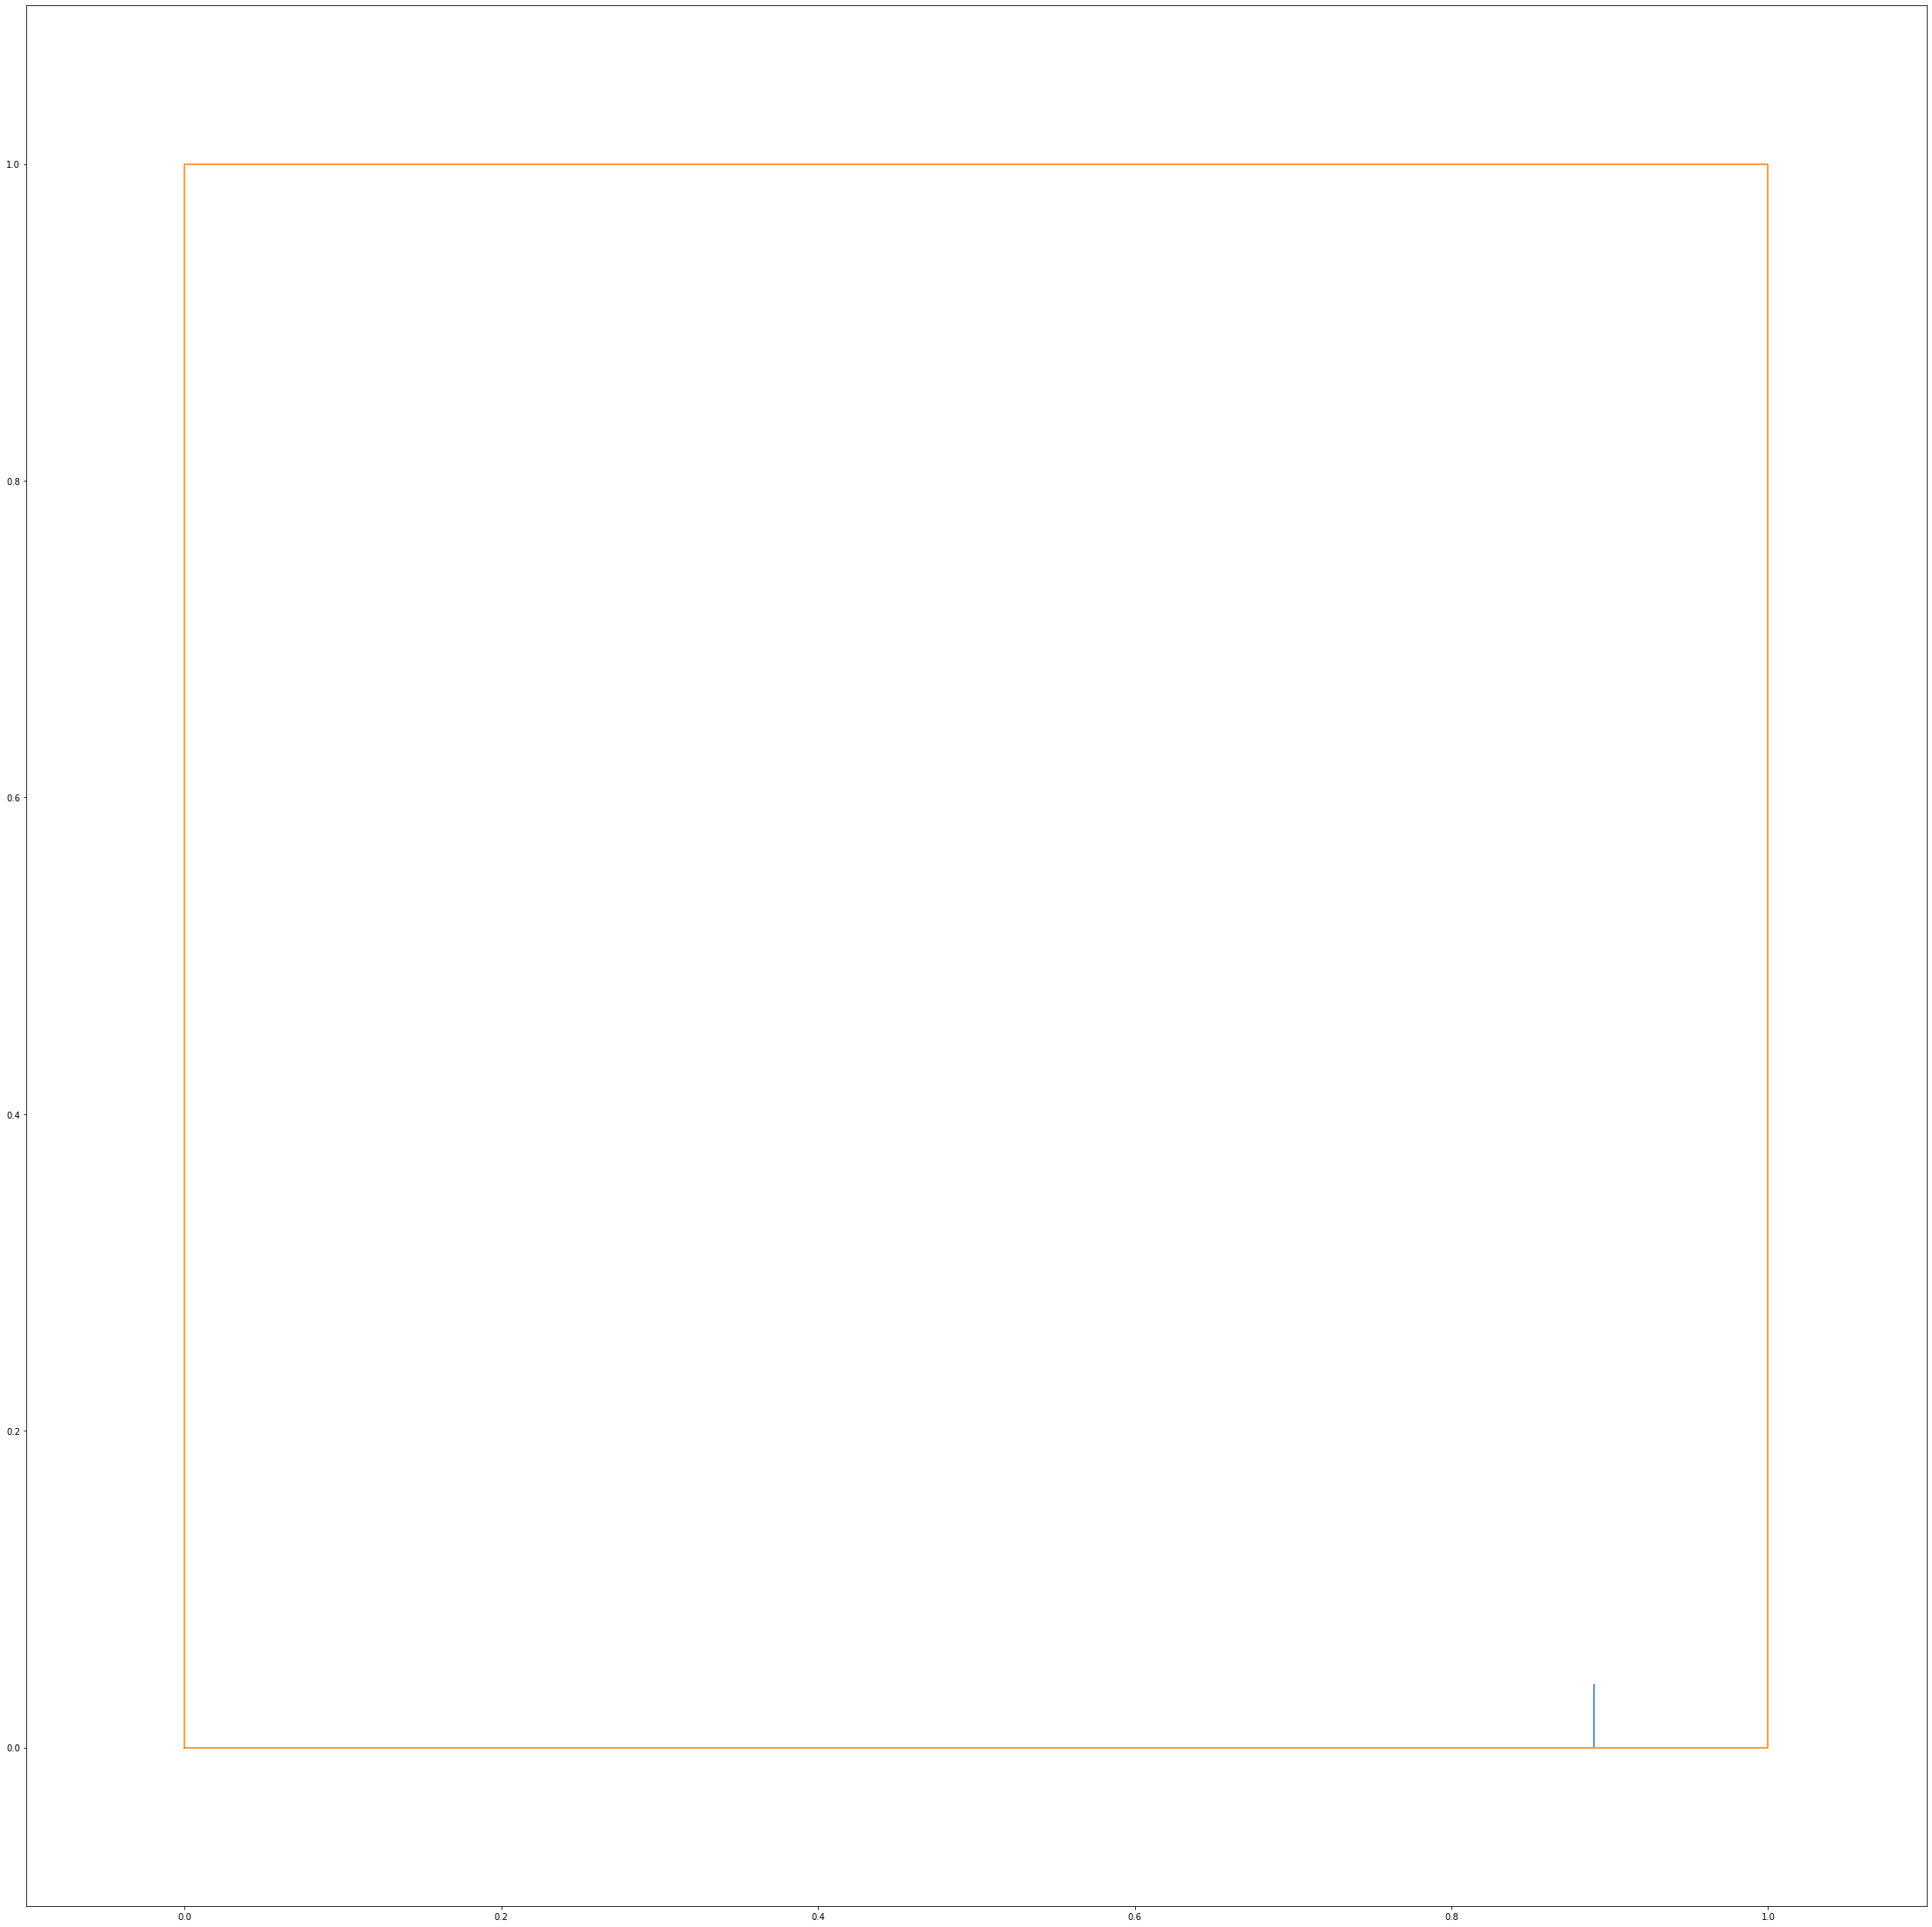

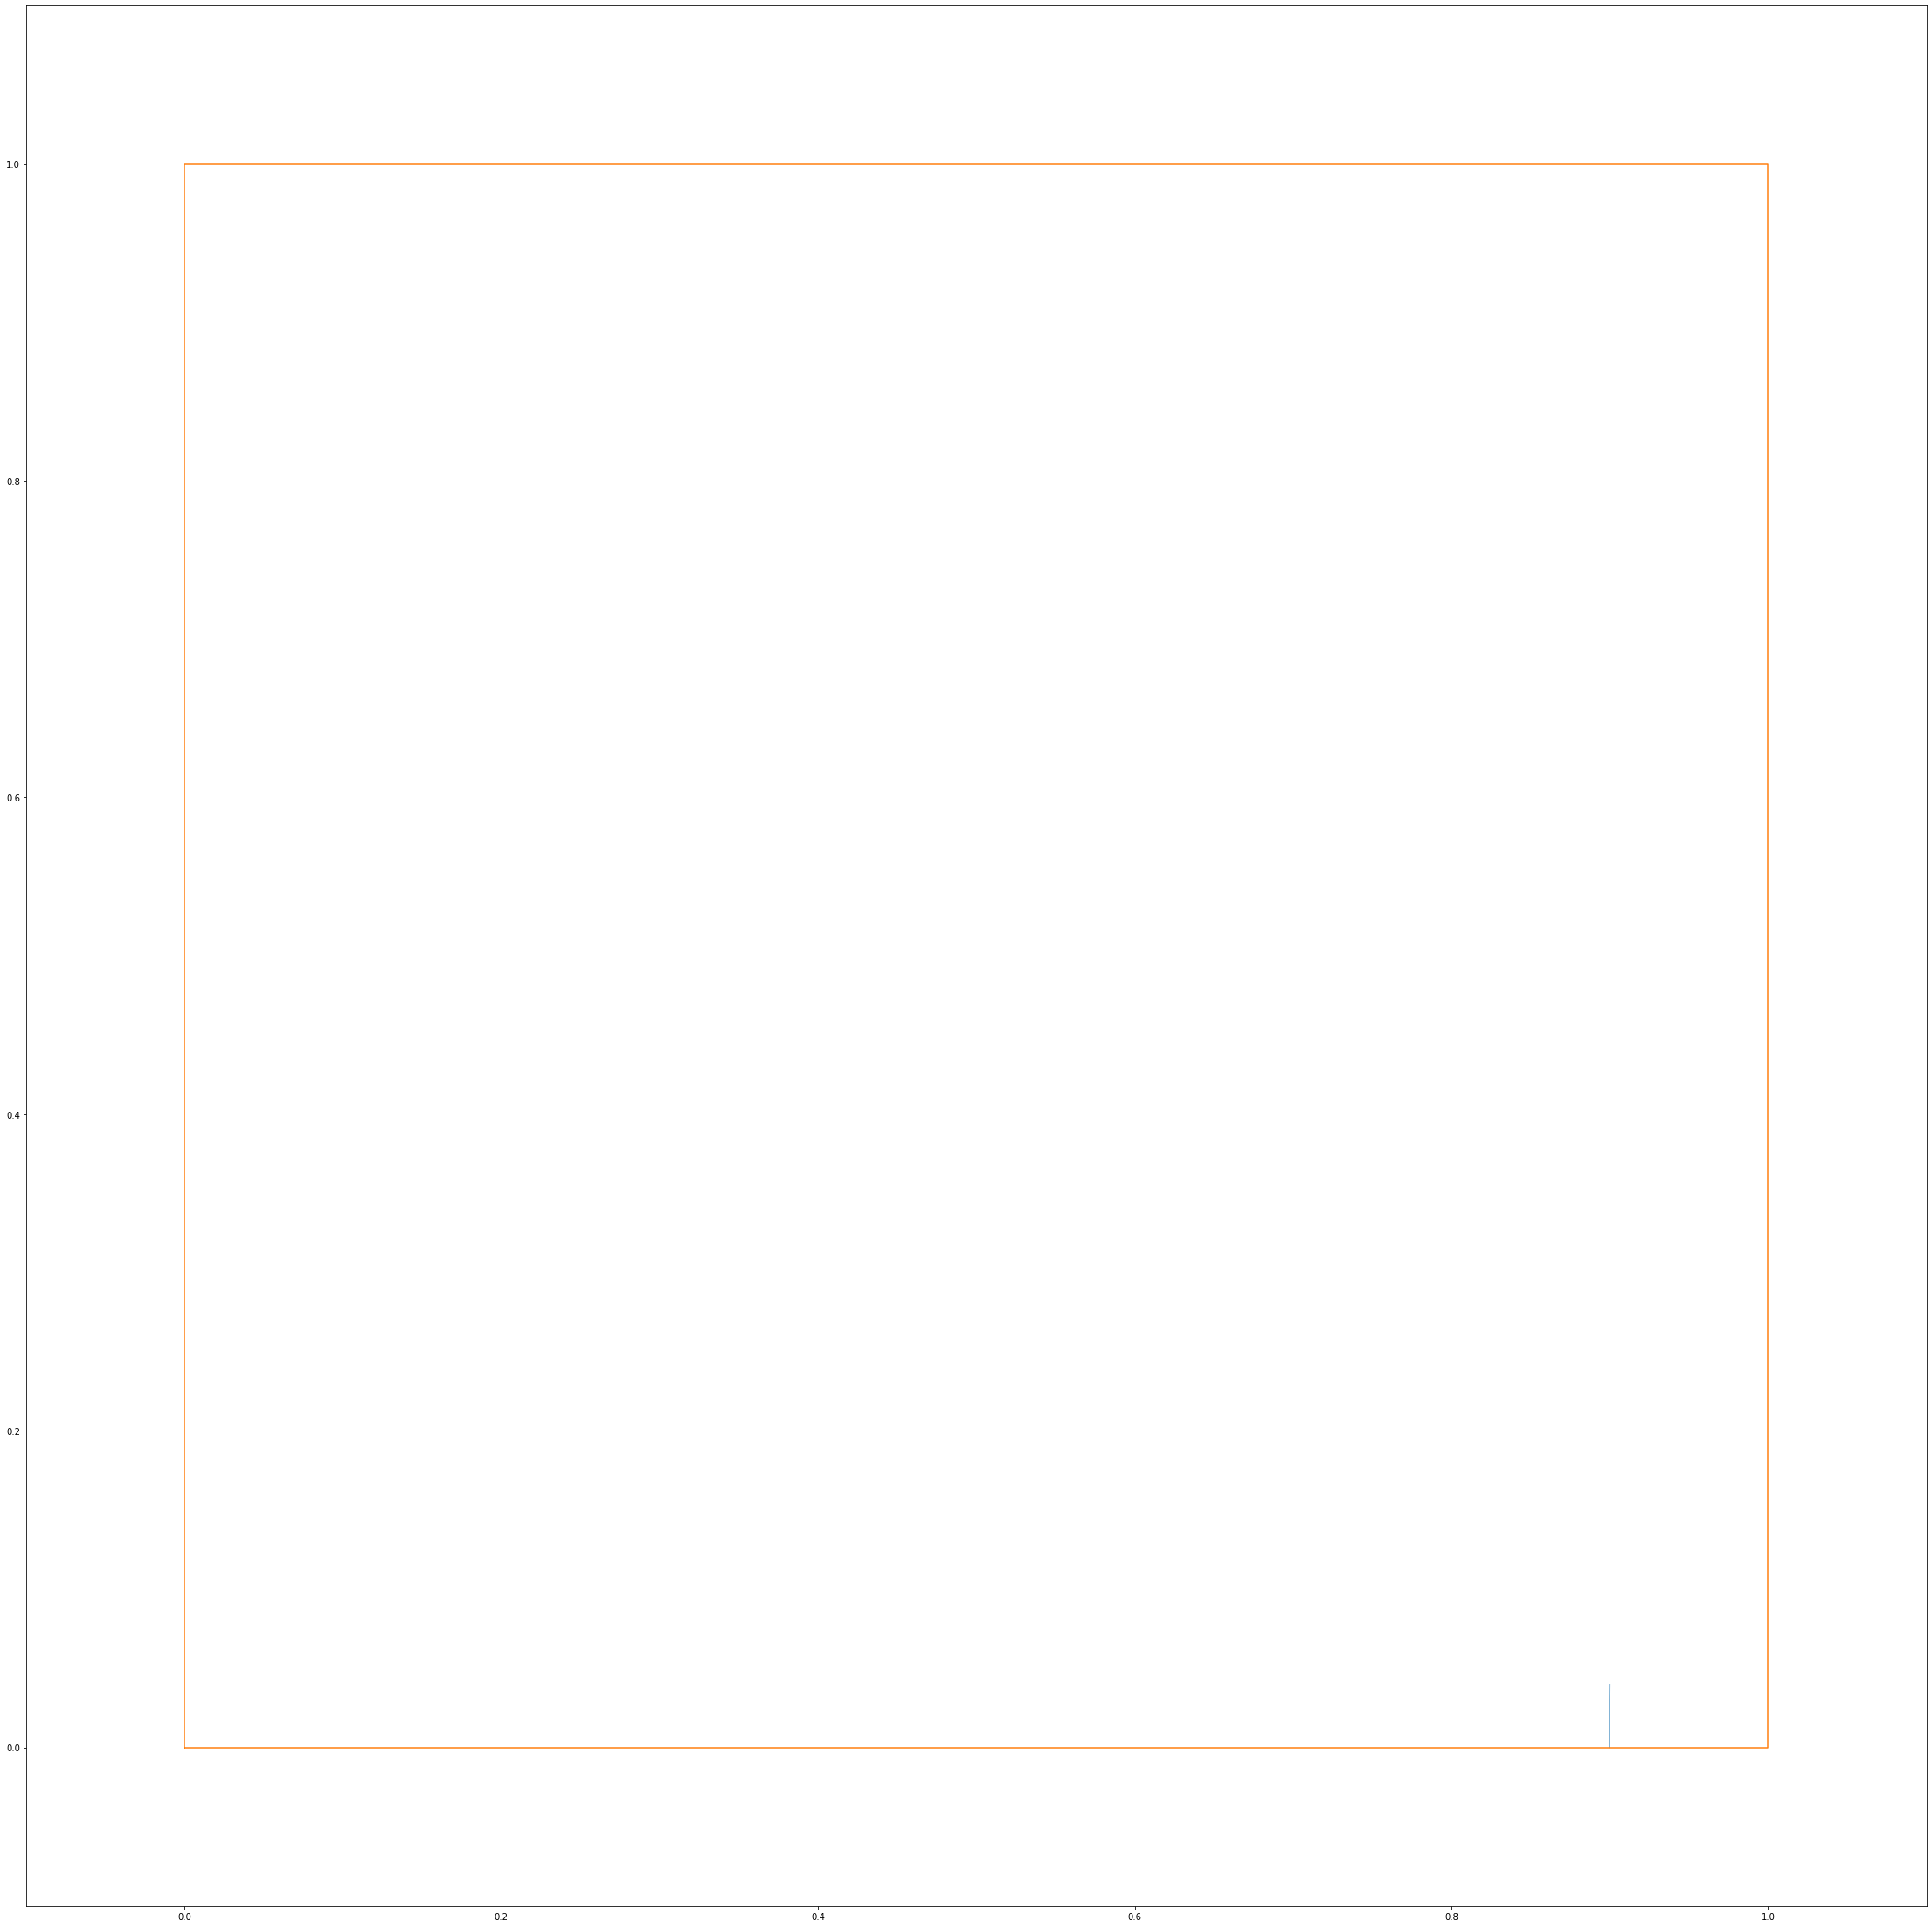

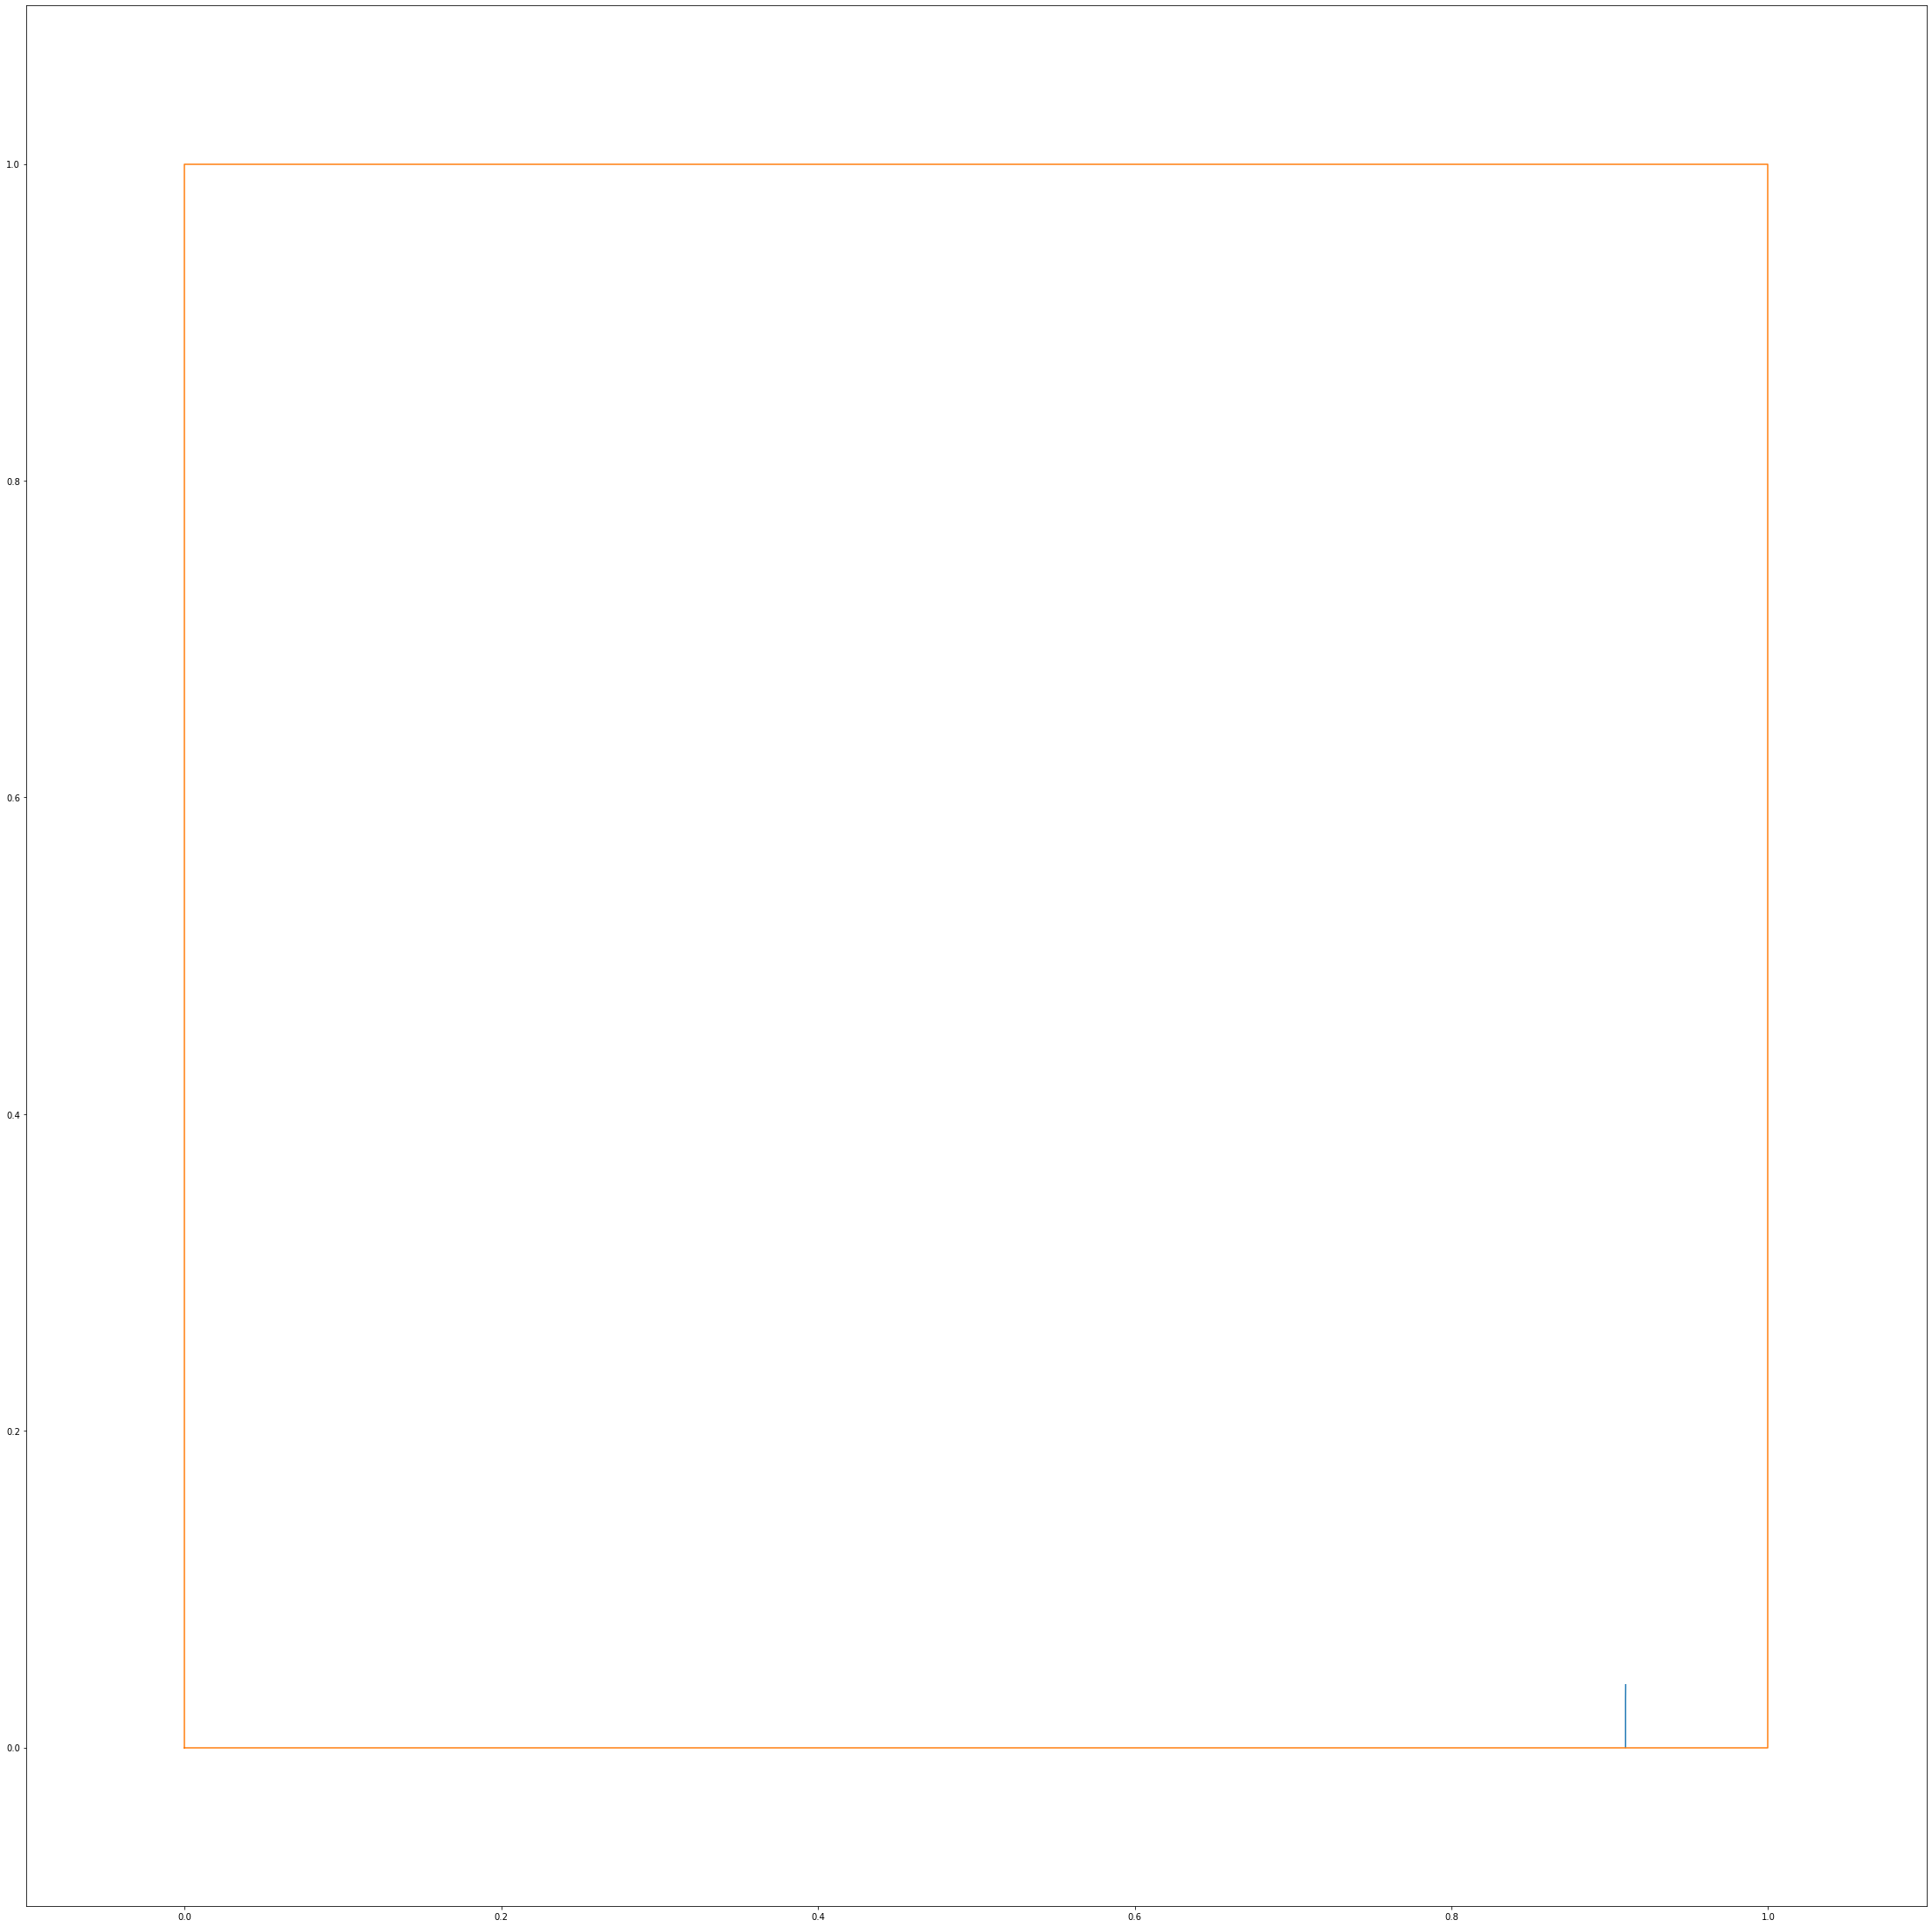

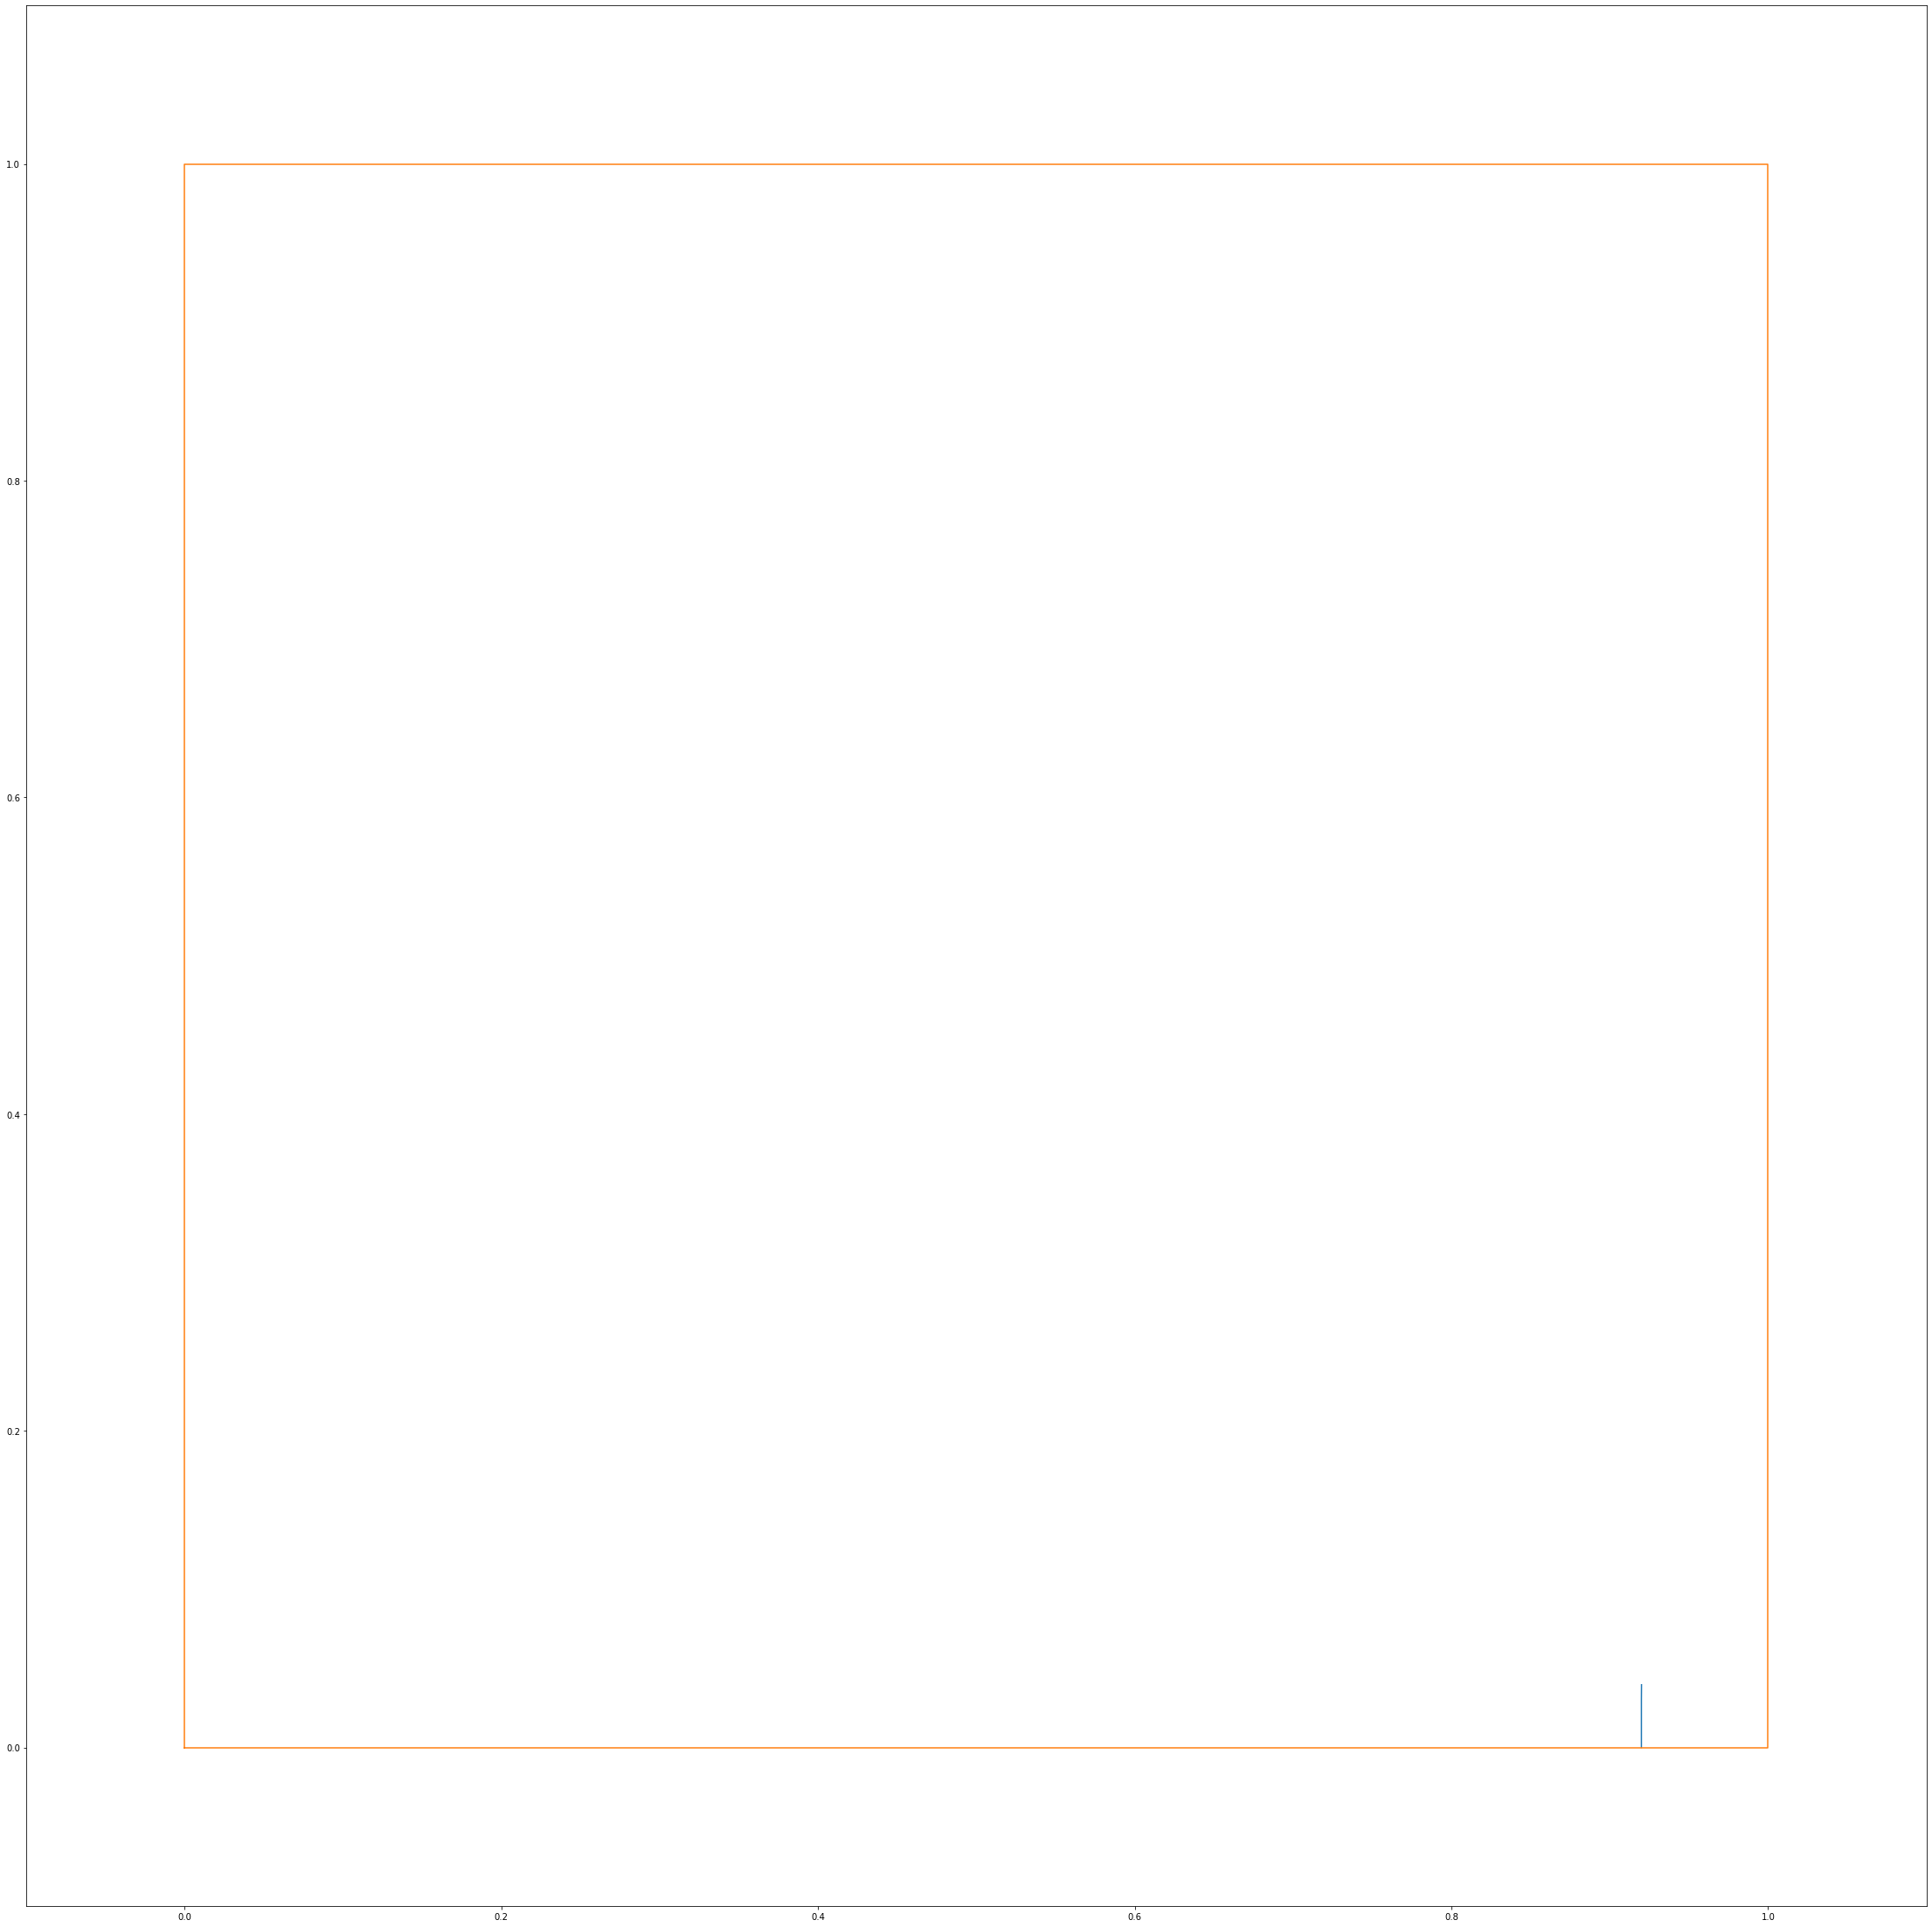

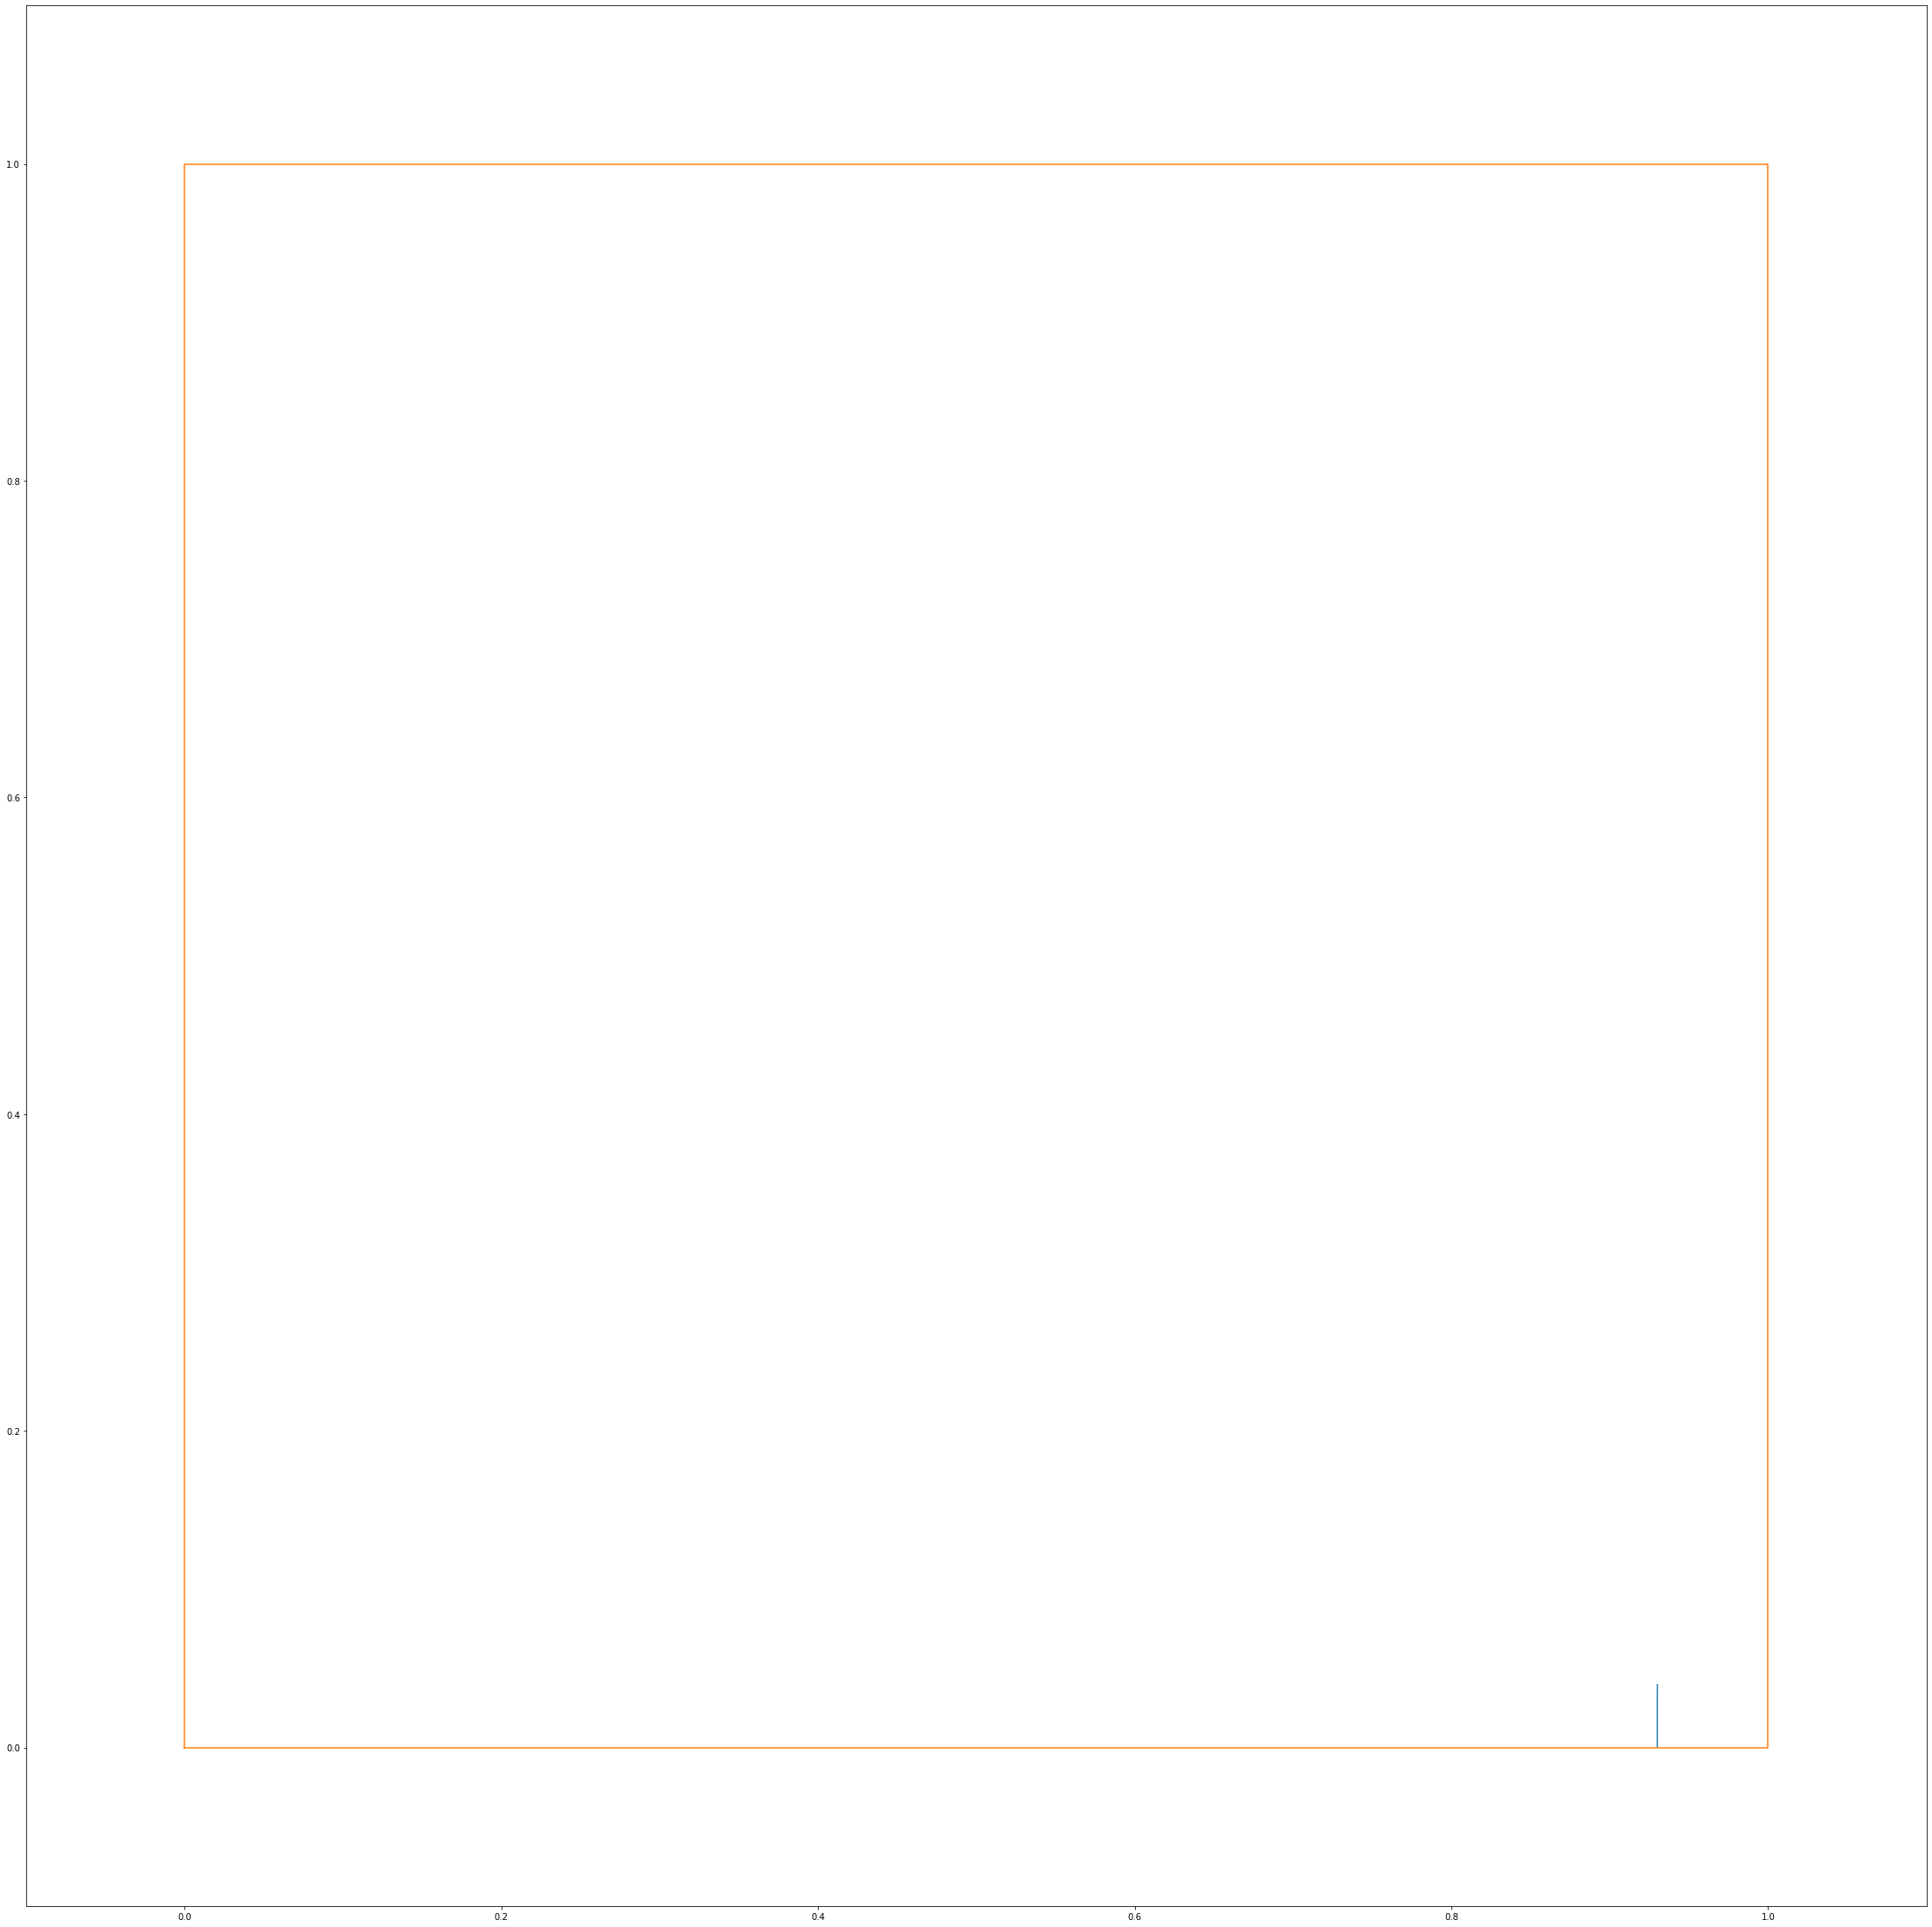

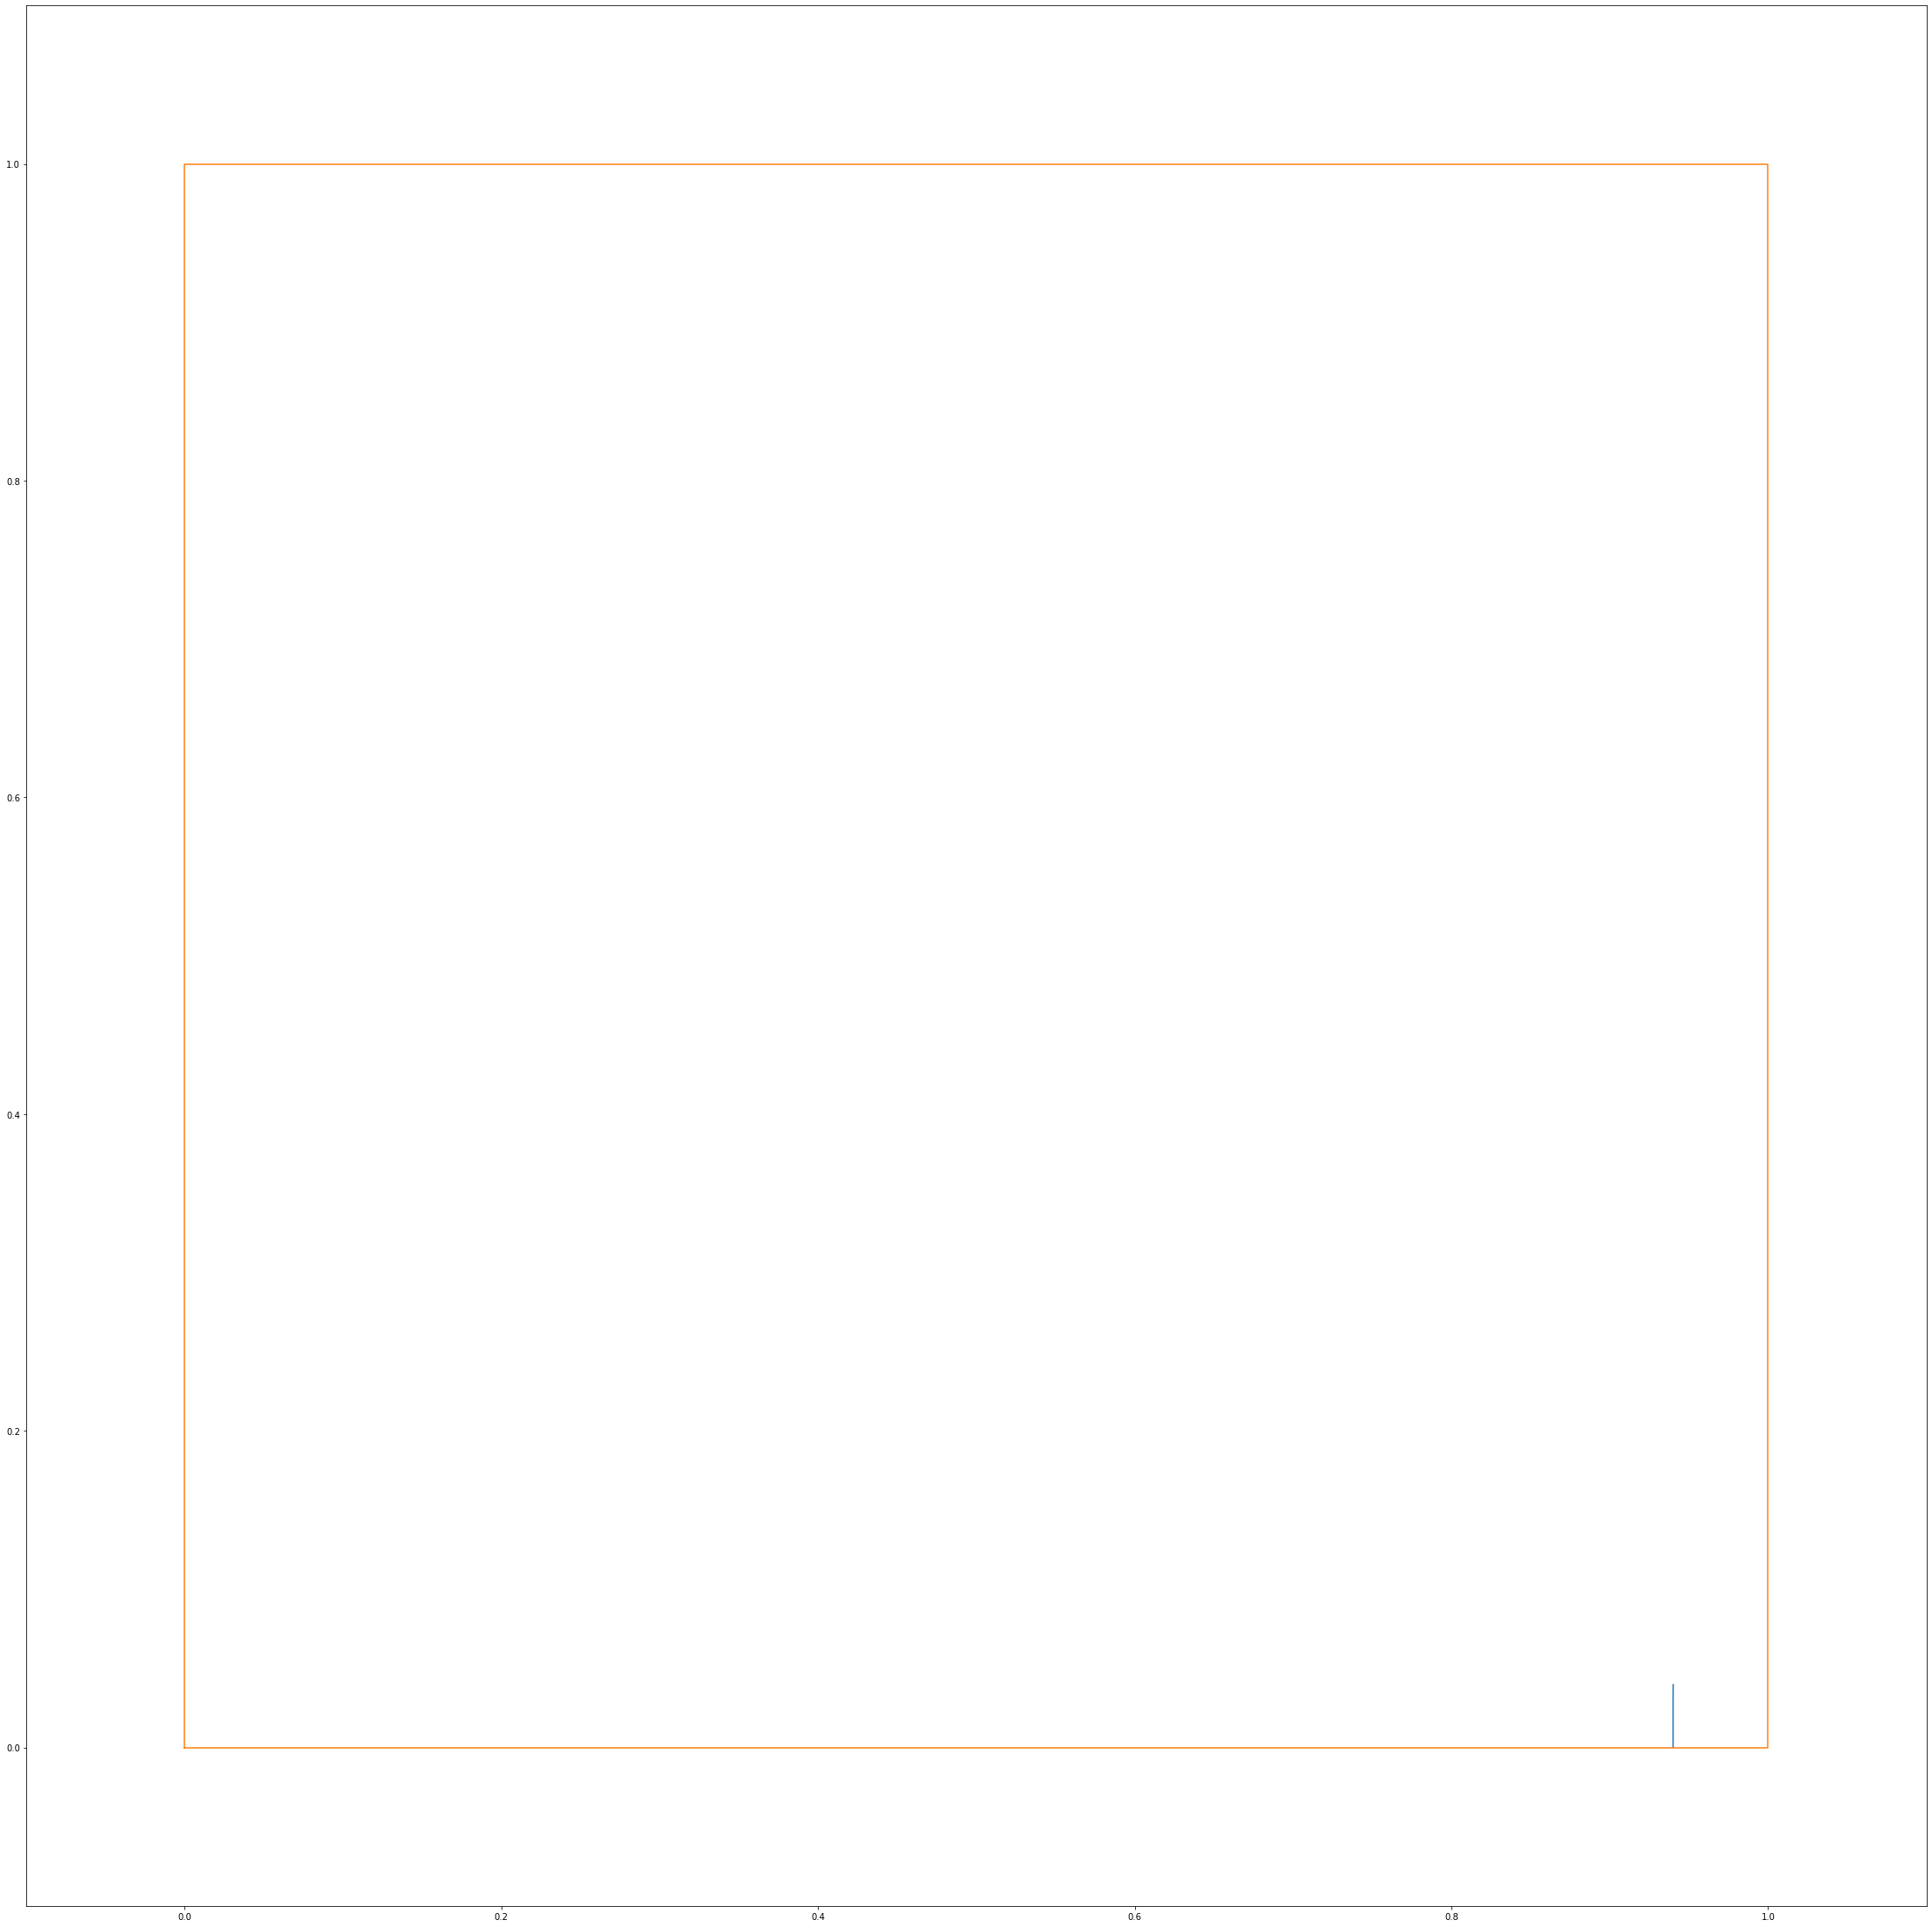

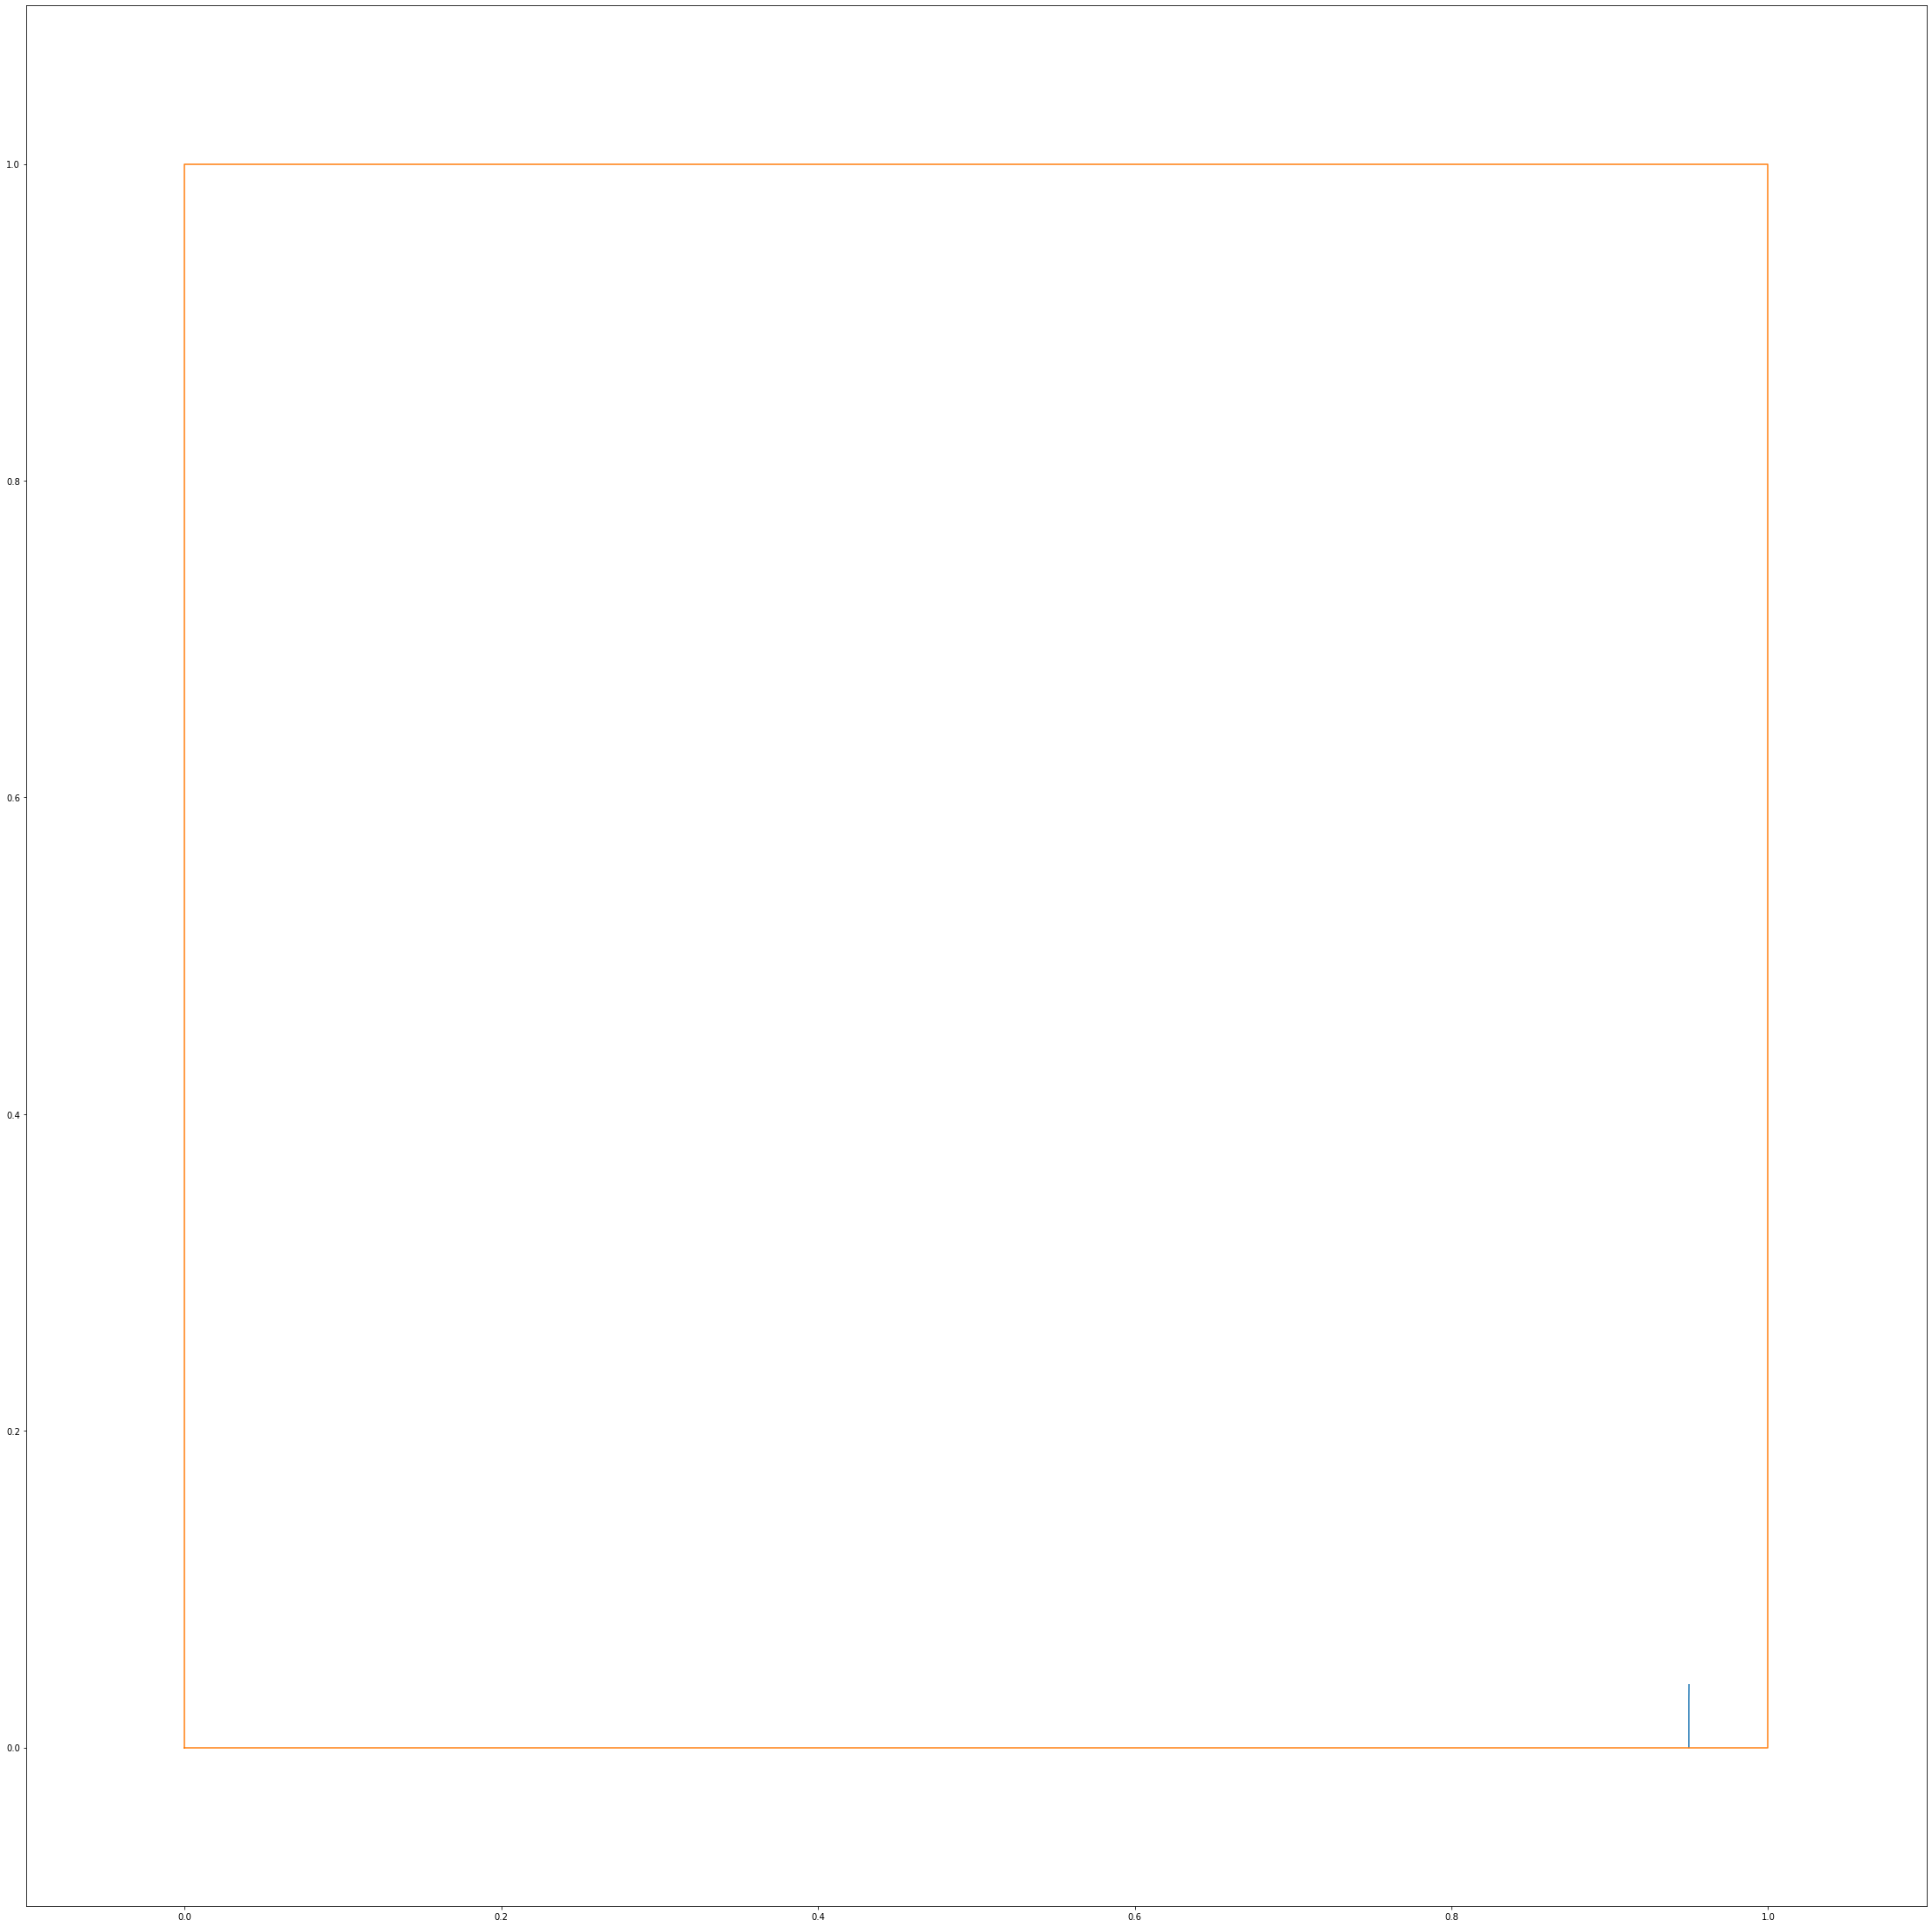

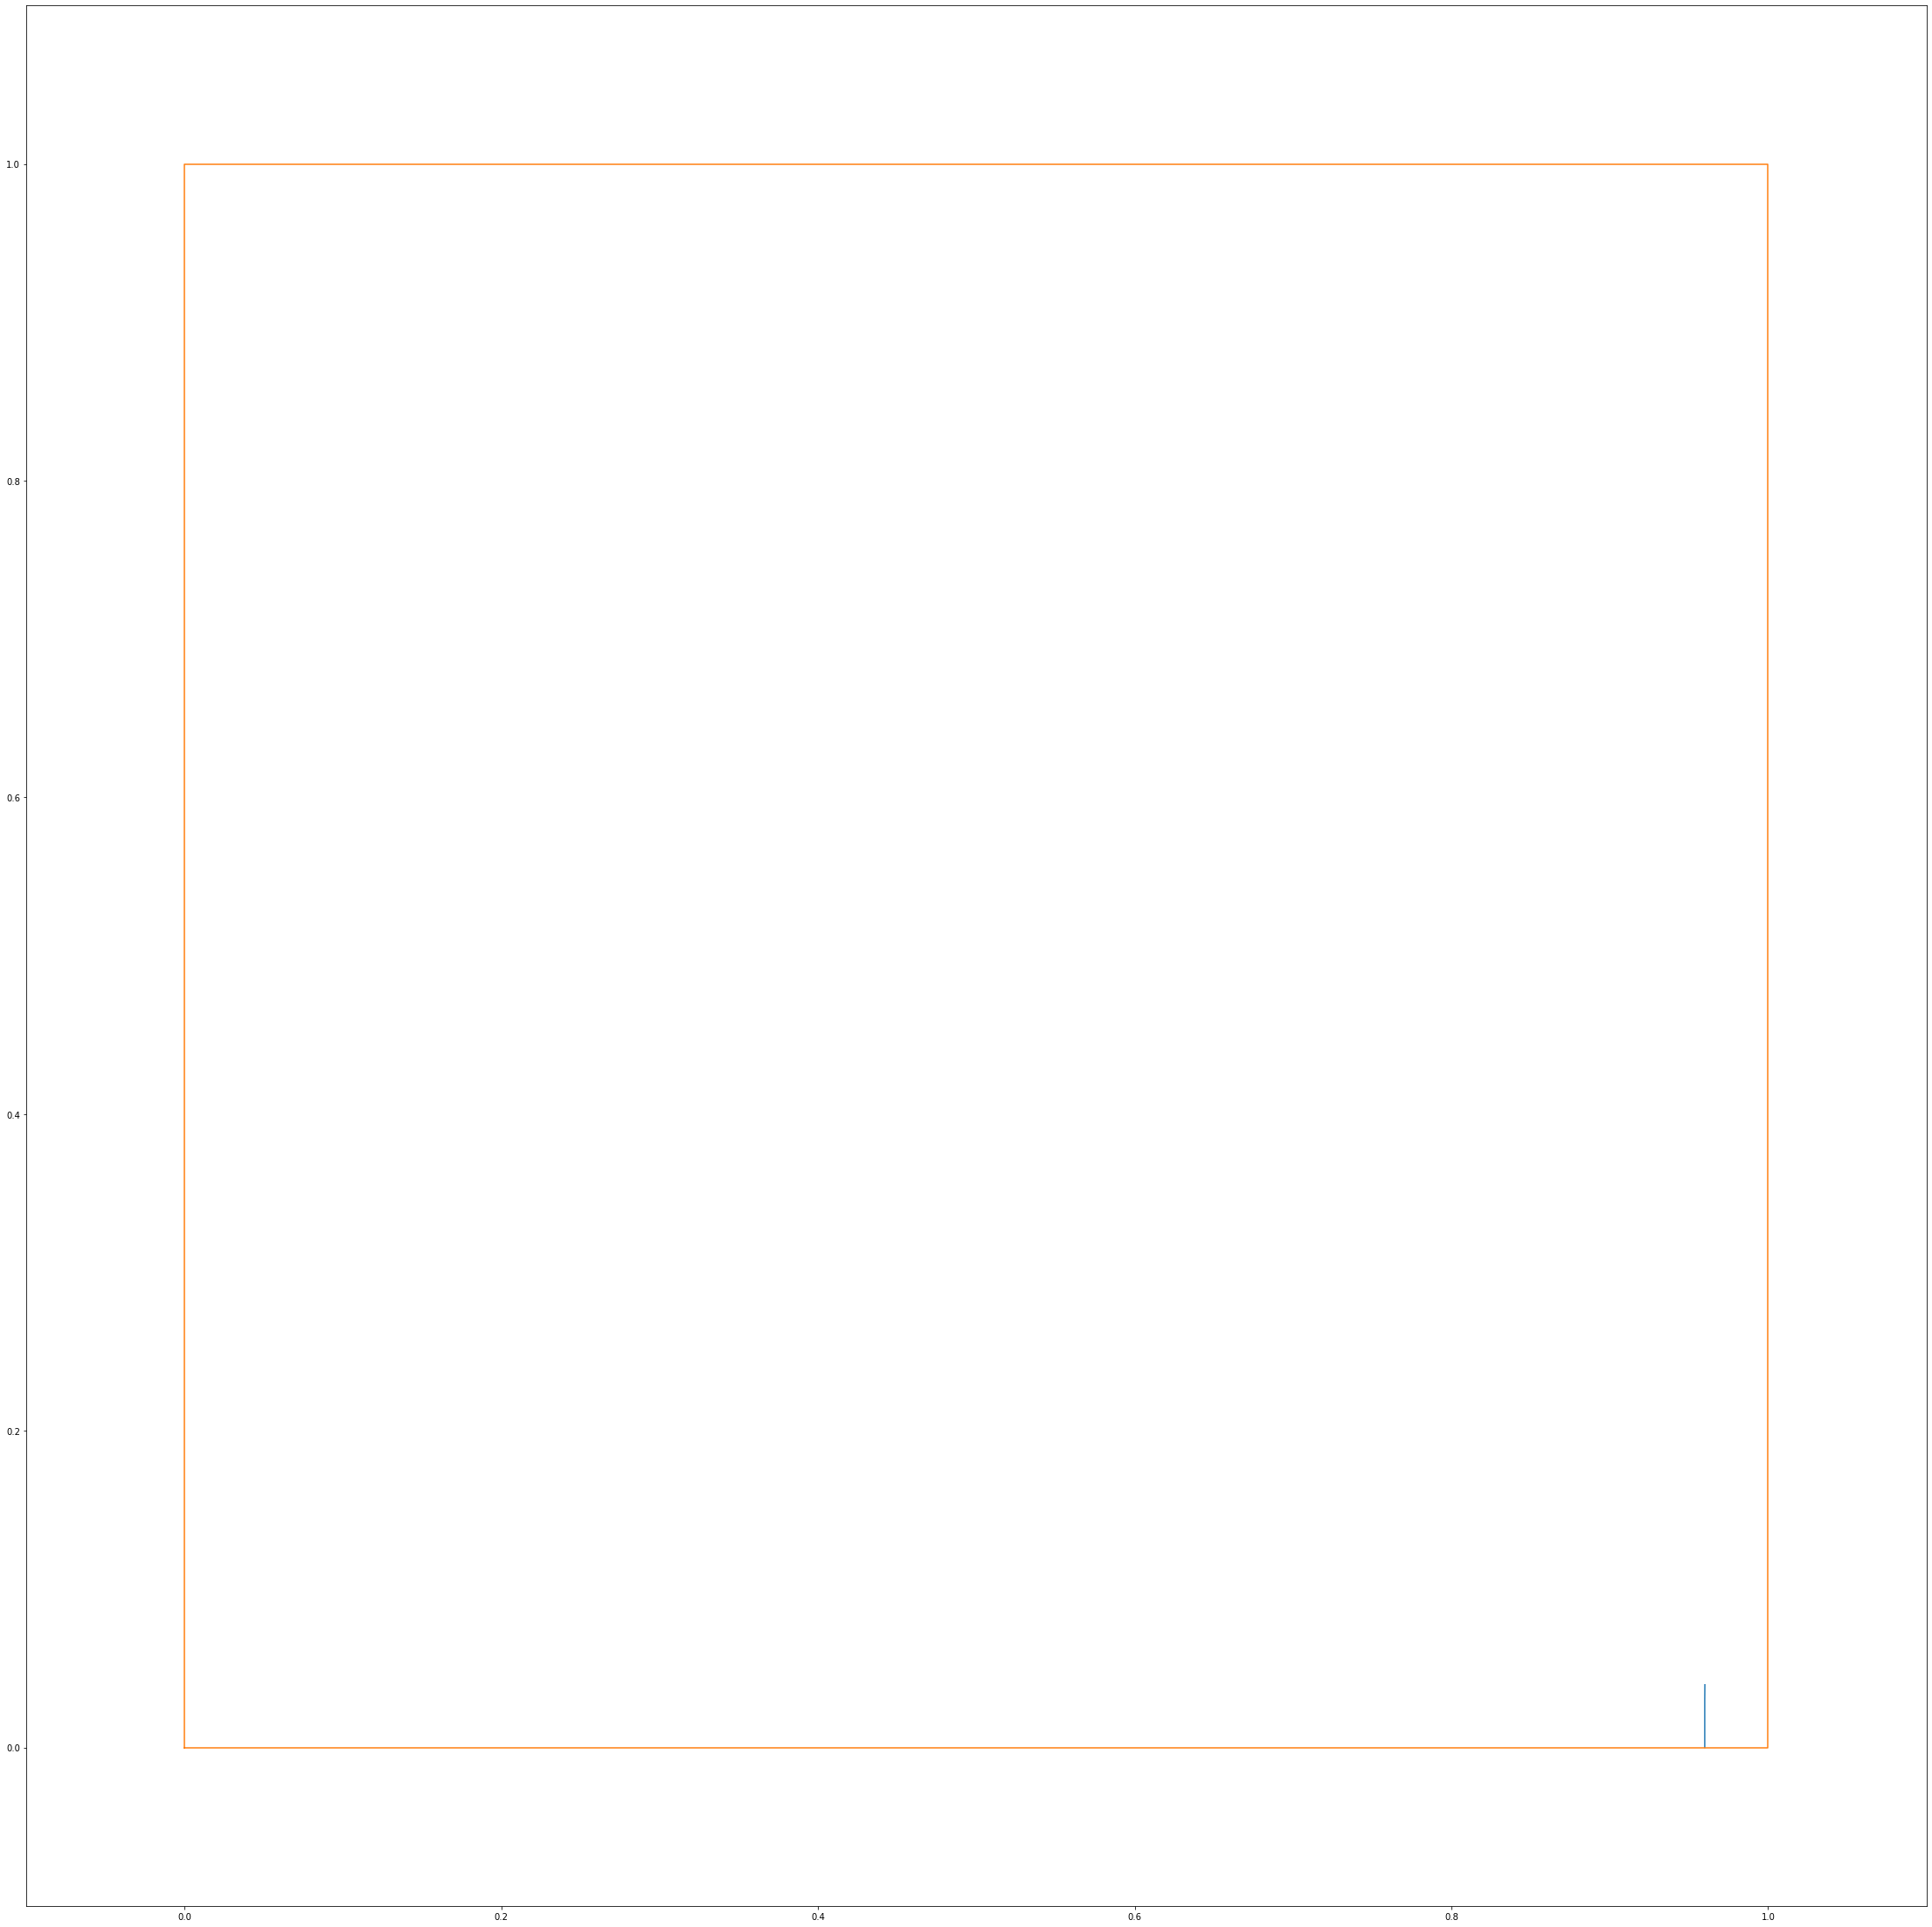

In [3]:
import numpy as np

model = rs.Model()

model.growth_min_distance = 0.005
model.growth_threshold = 0.0001
model.mesh_params.ignored_smoothness_length = 0.02
model.mesh_params.smoothness_degree = 0.2
model.solver_params.adaptive_refinment_steps = 1
model.solver_params.quadrature_degree = 4

model.number_of_steps = 100

model.ds = 0.005
model.bifurcation_min_dist = 0.005
model.width = 1.
model.height = 1.
model.eta = 1.

for model.dx in np.arange(model.integr_params.integration_radius, model.width - model.integr_params.integration_radius, 0.01):
    model.initializeDirichlet()
    model.rivers[1].addPoint(rs.Polar(model.integr_params.integration_radius, 0), model.river_boundary_id)
    growRiver(model, plot_period = 50)
    rs.save(model, "rivers_generation__dirichlet__width=" + str(model.width) + "__heigth=" + str(model.height) + "__ds="+str(model.ds) + "__bifurcation_min_dist=" + str(model.bifurcation_min_dist) + "__eta=" + str(model.eta) + "__dx=" + str(model.dx) + ".json")